In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9297395315766408502
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6932588160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7242676896101408639
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
]


In [1]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 읽기를 위한 라이브러리
import numpy as np
np.random.seed(0)
import pandas as pd
import gc, os, time
import scipy as sp
from pandas import DataFrame, Series
from datetime import datetime, date, timedelta
from sklearn import decomposition

# 탐색적 데이터 분석을 위한 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

# 모델링을 위한 라이브러리
from sklearn.linear_model import Ridge, BayesianRidge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, VarianceThreshold

import pickle

pd.set_option('display.max_columns',999)

from tqdm import tqdm

def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [2]:
# 학습용 데이터 
train_sensor = pd.read_csv('train_sensor.csv')
train_quality = pd.read_csv('train_quality.csv')
# 평가용 데이터 
predict_sensor = pd.read_csv('predict_sensor.csv')

In [3]:
def make_dataset(X, y=None):
    
    # -----------------------------------
    # train_sensor (X 인자)
    # -----------------------------------
    ''' column을 param_alias 로만 pivot table 만들기. '''
    df_X = X.copy()
    df_X = df_X.sort_values(by='end_time',ascending=True)
    df_X['step_id'] = df_X['step_id'].apply(lambda x: str(x).zfill(2))
    # step_id 와 param_alias 를 결합한 임시 컬럼 step_param 을 생성합니다. ex. 17_EPD_para4
    df_X['step_param'] = df_X[['step_id', 'param_alias']].apply(lambda x: '_'.join(x), axis=1)
    df_X_tmp = df_X.pivot_table(index = ['module_name','key_val'], columns = 'step_param', values='mean_val', aggfunc='sum')
    # 데이터 통합을 위해 인덱스를 key_val 로 재설정합니다. 
    df_X_tmp = df_X_tmp.reset_index(level=[0, 1])
    df_X_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # 시간 데이터 
    # -----------------------------------
    ''' step별 end_time을 column으로 pivot table 만들기 '''
    df_X['end_time_tmp'] = df_X.apply(lambda x: x['step_id'] + '_end_time', axis=1)
    df_X['end_time'] = pd.to_datetime(df_X['end_time'])
    # end_time 은 센서 데이터가 각 para 별로 서버에 도달한 시간으로 스텝 내 오차가 발생할 수 있습니다. 동일 스텝 구간내 공정 완료 시간이 다른 경우, min 함수를 사용하여 최초 수집된 time을 가져옵니다.
    df_time_tmp = df_X.pivot_table(index = ['key_val'], columns = 'end_time_tmp', values='end_time', aggfunc=lambda x : min(x.unique()))
    df_time_tmp = df_time_tmp.reset_index()
    df_time_tmp.set_index('key_val', inplace=True)

    # -----------------------------------
    # train_quality (y 인자)
    # -----------------------------------

    if y is None : # 평가용 데이터 
        col_target = []
        col_idx = ['module_name', 'key_val']
        df_complete = pd.concat([df_X_tmp, df_time_tmp], axis=1).reset_index()
        df_complete.rename(columns={'index':'key_val'},inplace=True)
    else : # 학습용 데이터 
        df_y = y.copy()
        df_y.set_index('key_val', inplace=True)
        col_target = ['y']
        col_idx = ['module_name', 'key_val', 'end_dt_tm']
        # 센서 데이터, 시간데이터, 품질지표에 대하여 인덱스(key_val)기준으로 데이터프레임을 통합합니다.
        df_complete = pd.concat([df_X_tmp, df_time_tmp, df_y], axis=1).reset_index()
        # 컬럼 이름을 변경합니다.  
        df_complete.rename(columns={'msure_val':'y'}, inplace=True)
        df_complete.rename(columns={'index':'key_val'},inplace=True)


    # 컬럼 순서를 정렬합니다. 
    col_feats = df_X['step_param'].unique().tolist()
    col_feats.sort()
    col_time = [s for s in df_complete.columns.tolist() if "_end_time" in s]
    col_all = col_idx + col_target + col_feats + col_time
    df_complete = df_complete[col_all]
    # 처음 step이 시작된 시점을 기준으로 다시 정렬(APC value를 먹고 들어가는 값을 기준으로 정렬하고 싶었음.)
    df_complete = df_complete.set_index(['module_name','key_val','04_end_time']).sort_index(level=[0,2,1],ascending=True).reset_index()
    df_complete = df_complete[col_all]
    
    # 컬럼을 소문자로 변경합니다. 
    df_complete.columns = df_complete.columns.str.lower()

    return df_complete

# 학습용 데이터 
train = make_dataset(train_sensor, train_quality)
# 평가용 데이터 
predict = make_dataset(predict_sensor)

In [4]:
print(len(train.columns))
print(len(predict.columns))

676
674


In [5]:
# 전체 및 개별 공정 소요시간 변수를 생성하는 함수입니다.
def gen_duration_feats(df, lst_stepsgap):
    # 전체 공정 소요시간(초) 변수를 생성합니다. 
    df['gen_tmdiff'] = (df['20_end_time'] - df['04_end_time']).dt.total_seconds()

    for stepgap in lst_stepsgap:
        df[f'gen_tmdiff_{stepgap}'] = (df[f'{stepgap[2:]}_end_time'] - df[f'{stepgap[:2]}_end_time']).dt.total_seconds()
    return df

# Y skew 확인

In [ ]:
fig = plt.figure(figsize = (15, 40))
for num in range(len(df_final.module_name.unique())):
    ax = plt.subplot(10, 5, num+1)
    energy = df_final.loc[df_final.module_name == num, 'y'].values
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.0:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.0:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

In [ ]:
fig = plt.figure(figsize = (15, 40))
for num in range(len(df_final.module_name.unique())):
    ax = plt.subplot(10, 5, num+1)
    energy = df_final.loc[df_final.module_name == num, 'y'].values
    energy = np.log1p(energy)
    mean = energy.mean().round(3)
    std = energy.std().round(3)
    skew = (3*(mean - np.median(energy))/energy.std()).round(3)
    if skew >= 1.0:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'red')
    elif skew <= -1.0:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'blue')
    else:
        plt.hist(energy, alpha = 0.7, bins = 50, color = 'gray')
    plt.title(f'building{num}')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.text(0.35, 0.9, f'mean : {mean}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.8, f'std : {std}',  ha='left', va='center', transform=ax.transAxes)
    plt.text(0.35, 0.7, f'skew : {skew}',  ha='left', va='center', transform=ax.transAxes)

building 31,35는 log 씌우지마.

# 4. 데이터 전처리

In [6]:
# 전처리를 위한 학습용 데이터와 평가용 데이터를 복사합니다.
df_train = train.copy()
df_predict = predict.copy()

In [7]:
# 센서 컬럼과 날짜 컬럼을 정의합니다. 
col_sensor = df_train.iloc[:, 4:-7].columns.tolist() 
col_time = df_train.filter(regex='end').columns.tolist() 

assert len(col_sensor) == 665
assert len(col_time) == 8 

# 3.4절 공정 소요시간 분석에 필요한 변수를 정의합니다. 
lst_steps = ['04','06','12','13','17','18', '20']
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']

''' step별로 fdc para명 따로 수집 '''
lst_sensors = []
for step in lst_steps:
    _ = [col for col in col_sensor if col[:2] == step]
    lst_sensors.append(_)

sensors_nm = list(map(lambda x: x[3:], lst_sensors[0]))

# 시간과 관련한 분석을 진행하기 위하여 날짜형으로 변환합니다. 
df_train[col_time] = df_train[col_time].apply(pd.to_datetime)

In [8]:
for_col_filter = []
for step_para in lst_sensors:
    for para in step_para:
        para = para.split('_')[0]+'_'+para.split('_')[1]
        for_col_filter.append(para)
for_col_filter = sorted(list(set(for_col_filter)))

In [9]:
# 전체 및 개별 공정 소요시간 7개의 변수를 생성합니다(3.4절)
lst_stepsgap = ['0406','0612','1213','1317','1718','1820']
df_train = gen_duration_feats(df_train, lst_stepsgap)
df_predict = gen_duration_feats(df_predict, lst_stepsgap)
df_train.filter(regex='tmdiff').head(2)

,gen_tmdiff,gen_tmdiff_0406,gen_tmdiff_0612,gen_tmdiff_1213,gen_tmdiff_1317,gen_tmdiff_1718,gen_tmdiff_1820
0,1912.0,146.0,846.0,16.0,477.0,16.0,411.0
1,1911.0,145.0,847.0,16.0,476.0,16.0,411.0


# Cyclic Transformation 적용

In [10]:
''' Cyclic Transformation 적용 '''
def cyclic_transformation(df, cols):
    for col in cols:
        step = col[:2]
        df[col] = pd.to_datetime(df[col])
        df[step+'_'+'month'] = df[col].dt.month
        df[step+'_'+'day'] = df[col].dt.day
        df[step+'_'+'hour'] = df[col].dt.hour
        df[step+'_'+'weekday'] = df[col].dt.weekday
        
        ## cyclic transformation on hour
        df[step+'_'+'hour_sin'] = np.sin(2 * np.pi * df[step+'_'+'hour']/23.0)
        df[step+'_'+'hour_cos'] = np.cos(2 * np.pi * df[step+'_'+'hour']/23.0)
        ## cyclic transformation on date 
        df[step+'_'+'date_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        df[step+'_'+'date_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'month']+df[step+'_'+'day']/31)/12)
        ## cyclic transformation on month
        df[step+'_'+'month_sin'] = -np.sin(2 * np.pi * df[step+'_'+'month']/12.0)
        df[step+'_'+'month_cos'] = -np.cos(2 * np.pi * df[step+'_'+'month']/12.0)
        ## cyclic transformation on weekday
        df[step+'_'+'weekday_sin'] = -np.sin(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        df[step+'_'+'weekday_cos'] = -np.cos(2 * np.pi * (df[step+'_'+'weekday']+1)/7.0)
        
        df.drop(step+'_'+'month',axis=1,inplace=True)
        df.drop(step+'_'+'month_sin',axis=1,inplace=True)
        df.drop(step+'_'+'month_cos',axis=1,inplace=True)

In [11]:
endtime_col = df_train.filter(regex='end_time$').columns.tolist()
cyclic_transformation(df_train, endtime_col)
cyclic_transformation(df_predict, endtime_col)

# Category 변수 처리

In [12]:
''' CATEGORY 변수 처리 및 NUM FEATURE 정의 '''
module2idx = {}
for i, module in enumerate(df_train['module_name'].unique()):
    module2idx[module] = i
    
def col2cat(df, col, dict):
    df[col] = df[col].apply(lambda x: dict[x])
    df[col] = df[col].astype('category')
    return df[col]

# module_name cat 화
col2cat(df_train, 'module_name', module2idx)
col2cat(df_predict, 'module_name', module2idx)

0       0
1       0
2       0
3       0
4       0
       ..
257    45
258    46
259    46
260    46
261    46
Name: module_name, Length: 262, dtype: category
Categories (47, int64): [0, 1, 2, 3, ..., 43, 44, 45, 46]

# 각 챔버별 전처리

In [13]:
df_final = df_train.copy()
df_predict_final = df_predict.copy()

In [14]:
module_unique = df_final['module_name'].unique()
df_trains = [df_final[df_final['module_name']==eq] for eq in module_unique]
num_features_lst = []
df_predicts = [df_predict_final[df_predict_final['module_name']==eq] for eq in module_unique]
''' 중복되는 열 제거하기. '''
for i, (trains,predicts) in enumerate(zip(df_trains,df_predicts)):
    drop_col = []
    for para in for_col_filter:
        col = trains.filter(regex='^'+para).columns.tolist()
        duplicate_deleted_df = trains[col].T.drop_duplicates(subset=trains[col].T.columns, keep='first').T
        if len(trains[col].columns.difference(duplicate_deleted_df.columns))==0:  # 다른게 없으면 무시,
            continue
        else:
            drop_col.extend(trains[col].columns.difference(duplicate_deleted_df.columns).tolist())
    trains.drop(drop_col,axis=1,inplace=True)
    predicts.drop(drop_col, axis=1, inplace=True)
    
#     ''' 1부터도 log transformation시 skewness와 kurtois가 많이 줄어듦. 효과적일 것이라 변환진행 ex) '20_time_para42' '''
#     skew1_df = ((trains.skew()>=2.5)|(trains.skew()<=-2.5)).reset_index().iloc[1:].reset_index(drop=True)
#     skew1_df.columns=['param','boolean']
#     high_skew1_col = skew1_df.loc[skew1_df['boolean'],:]['param'].unique().tolist()
#     df = trains[high_skew1_col]
#     ''' 04_fr_para28 , 06_fr_para28 음수를 가진 col인데, skew는 높지만 시각화시 괜찮아서 제외. '''
    
#     minus_col = df[(np.log1p(df).isnull())|(np.log1p(df)==float('-inf'))].dropna(axis=1,how='any').columns.tolist()
#     high_skew1_col = [x for x in high_skew1_col if x not in minus_col]
#     print(len(high_skew1_col))

#     trains.loc[:,high_skew1_col] = np.log1p(trains[high_skew1_col])
#     predicts.loc[:,high_skew1_col] = np.log1p(predicts[high_skew1_col])
    
#     assert predicts[high_skew1_col].isnull().sum().sum() == 0
#     assert (predicts[high_skew1_col]==float('-inf')).sum().sum() == 0
#     assert (predicts[high_skew1_col]==float('inf')).sum().sum() == 0
    
    var0_cols = trains.loc[:,trains.nunique()==1].columns.tolist()
    print(f'module{i}의 drop할 columns : {var0_cols}')
    trains.drop(var0_cols, axis=1, inplace=True)
    predicts.drop(var0_cols, axis=1, inplace=True)
    
    df_trains[i] = trains
    df_predicts[i] = predicts
    
    ''' Cyclic Transformation 된 time만 사용. gen+float f들 '''
    num_features = list(trains.columns[trains.dtypes==float])
    num_features.remove('y')
    num_features_lst.append(num_features)

module0의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para94', '04_fr_para35', '04_gas_para10', '04_gas_para15', '04_gas_para74', '04_he_para1', '04_power_para14', '04_power_para57', '04_temp_para24', '04_temp_para58', '04_time_para5', '06_epd_para80', '06_fr_para35', '06_gas_para10', '06_gas_para70', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_temp_para24', '06_temp_para58', '06_time_para5', '12_epd_para4', '12_esc_para94', '12_fr_para35', '12_fr_para69', '12_gas_para10', '12_gas_para13', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para54', '12_temp_para58', '13_epd_para4', '13_esc_para94', '13_fr_para35', '13_fr_para69', '13_gas_para10', '13_gas_para13', '13_gas_para48', '13_gas_para51', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57', '13_temp_para12', '13_temp_para54', '13_temp_para58', '13_temp_para92', '17_epd_para4', '17_esc_para84', '17_esc_para94', '17_fr_para28', '17_fr_

module5의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_fr_para28', '04_fr_para35', '04_fr_para61', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_he_para1', '04_he_para95', '04_power_para14', '04_power_para57', '04_temp_para17', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_fr_para28', '06_fr_para35', '06_gas_para10', '06_gas_para70', '06_gas_para71', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_fr_para28', '12_fr_para35', '12_fr_para61', '12_gas_para10', '12_gas_para13', '12_gas_para59', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para17', '12_temp_para23', '13_epd_para4', '13_esc_para84', '13_fr_para28', '13_fr_para35', '13_fr_para61', '13_gas_para10', '13_gas_para13', '13_gas_para51', '13_gas_para59', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57',

module10의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_esc_para94', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para74', '04_he_para1', '04_he_para95', '04_power_para14', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para19', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_esc_para94', '12_fr_para28', '12_fr_para35', '12_gas_para13', '12_gas_para50', '12_gas_para51', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_temp_para18', '12_temp_para23', '12_temp_para54', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para13', '13_gas_para48', '13_gas_para50', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57', '13_power_para82', '13_temp_para18

module15의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para19', '04_gas_para27', '04_he_para1', '04_he_para95', '04_power_para14', '04_power_para57', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para19', '06_gas_para27', '06_gas_para59', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_esc_para94', '12_fr_para28', '12_fr_para35', '12_gas_para10', '12_gas_para13', '12_gas_para19', '12_gas_para59', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para23', '12_temp_para54', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para13', '13_gas_para19', '13_gas_para59', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57

module20의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_esc_para94', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para13', '04_gas_para15', '04_gas_para74', '04_gas_para85', '04_he_para1', '04_he_para95', '04_hv_para3', '04_position_para72', '04_power_para14', '04_power_para57', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para10', '06_gas_para13', '06_gas_para59', '06_gas_para70', '06_gas_para71', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_temp_para92', '06_time_para5', '12_epd_para4', '12_esc_para94', '12_fr_para28', '12_fr_para61', '12_gas_para10', '12_gas_para13', '12_gas_para27', '12_gas_para46', '12_gas_para59', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para23', '12_temp_para54', '13_epd_para4', '13_esc_para84', '13_esc_p

module25의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_esc_para94', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_gas_para50', '04_gas_para85', '04_he_para1', '04_he_para95', '04_hv_para47', '04_position_para72', '04_power_para14', '04_temp_para17', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para10', '06_gas_para50', '06_gas_para70', '06_gas_para71', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_esc_para94', '12_fr_para28', '12_gas_para10', '12_gas_para13', '12_gas_para27', '12_gas_para46', '12_gas_para50', '12_he_para1', '12_he_para95', '12_power_para49', '12_temp_para17', '12_temp_para66', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para13', '13_gas_para5

module30의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_esc_para94', '04_fr_para35', '04_fr_para69', '04_gas_para19', '04_gas_para74', '04_he_para1', '04_hv_para3', '04_hv_para47', '04_power_para14', '04_power_para57', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para35', '06_fr_para69', '06_gas_para19', '06_gas_para39', '06_gas_para51', '06_gas_para59', '06_he_para1', '06_hv_para3', '06_power_para14', '06_power_para57', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_esc_para94', '12_fr_para28', '12_fr_para35', '12_gas_para19', '12_gas_para39', '12_gas_para46', '12_gas_para51', '12_gas_para59', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_power_para82', '12_temp_para17', '12_temp_para23', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_fr_para61', '13_gas_para15', '13_gas_para19', '13_gas_para39', '13_gas_para4

module35의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_he_para1', '04_he_para95', '04_hv_para56', '04_power_para14', '04_power_para57', '04_temp_para17', '04_temp_para24', '04_temp_para66', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para10', '06_gas_para70', '06_gas_para71', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_temp_para24', '06_temp_para66', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_fr_para28', '12_fr_para35', '12_gas_para10', '12_gas_para13', '12_gas_para74', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para17', '12_temp_para23', '12_temp_para66', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para13', '13_gas_para48', '13_gas_para51', '13_gas_para59', '13_he_para1', '13_he_para95', 

module40의 drop할 columns : ['module_name', '04_epd_para4', '04_fr_para28', '04_fr_para35', '04_fr_para69', '04_gas_para10', '04_gas_para15', '04_he_para1', '04_he_para95', '04_power_para14', '04_power_para57', '04_temp_para12', '04_temp_para24', '04_time_para5', '06_epd_para80', '06_esc_para84', '06_fr_para28', '06_fr_para35', '06_fr_para69', '06_gas_para10', '06_gas_para70', '06_gas_para71', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para84', '12_fr_para28', '12_fr_para35', '12_gas_para10', '12_gas_para13', '12_gas_para46', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para17', '12_temp_para92', '13_epd_para4', '13_esc_para84', '13_fr_para28', '13_fr_para35', '13_gas_para10', '13_gas_para13', '13_gas_para48', '13_gas_para51', '13_he_para1', '13_he_para22', '13_he_para95', '13_power_para49', '13_power_para57', '13_temp_para12', '13_temp_para17', '13_temp_para23', '13_temp_par

module45의 drop할 columns : ['module_name', '04_epd_para4', '04_esc_para84', '04_esc_para94', '04_fr_para28', '04_fr_para35', '04_gas_para27', '04_gas_para85', '04_he_para1', '04_he_para95', '04_hv_para47', '04_power_para14', '04_power_para57', '04_temp_para24', '04_time_para5', '06_epd_para4', '06_esc_para84', '06_esc_para94', '06_fr_para28', '06_fr_para35', '06_gas_para27', '06_gas_para85', '06_he_para1', '06_he_para95', '06_hv_para3', '06_power_para14', '06_temp_para24', '06_time_para5', '12_epd_para4', '12_esc_para94', '12_fr_para28', '12_fr_para61', '12_gas_para13', '12_gas_para27', '12_gas_para50', '12_gas_para85', '12_he_para1', '12_he_para95', '12_power_para49', '12_power_para57', '12_temp_para23', '12_temp_para54', '13_epd_para4', '13_esc_para84', '13_esc_para94', '13_fr_para28', '13_fr_para35', '13_gas_para13', '13_gas_para50', '13_gas_para85', '13_he_para1', '13_he_para95', '13_power_para49', '13_power_para57', '13_temp_para23', '13_temp_para54', '17_epd_para4', '17_esc_para84

# 모델링

In [78]:
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import LeaveOneOut, KFold ,cross_val_score

# LGB+LooCV로 TEST

In [79]:
lgbs = []
lgb_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_LGB(trial):
        param_lgb = {
            'objective':'regression',
            'metric':'rmse',
            "random_state":42,
            'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.7),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 4e-5),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'bagging_fraction' :trial.suggest_loguniform('bagging_fraction', 0.01, 1.0),
            "n_estimators":trial.suggest_int("n_estimators", 100, 3000),
            "max_depth":trial.suggest_int("n_estimators", 3, 12),
            "colsample_bytree":trial.suggest_float("colsample_bytree", 0.3, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
            "max_bin": trial.suggest_int("max_bin", 200, 500)
        }
        X = train[num_f]
        y = train['y']

        model = lgb.LGBMRegressor(**param_lgb)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_lgb = optuna.create_study(
                study_name="lgb_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
    study_lgb.optimize(objective_LGB, n_trials=5)
    print("Best Score:", study_lgb.best_value)
    print("Best trial:", study_lgb.best_trial.params)
    lgb_scores.append(study_lgb.best_value)
    
    model = lgb.LGBMRegressor(**study_lgb.best_params, objective='regression', metric='rmse', random_state=42)
    model.fit(train[num_f], train['y'])
    print('{}th model training is completed'.format(i+1))
    lgbs.append(model)

[I 2022-07-22 14:06:48,591] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:06:48,842] Trial 0 finished with value: 4.936723586237979 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 4.936723586237979.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 0: [ 3.55740068  3.79592263  8.942537    3.72405807  0.26752858  3.23079454
  1.44253235  4.47920407  1.13073483  9.8908233  10.28741071 11.07584019
  2.35261968]
Mean score :  4.936723586237979
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.87060

[I 2022-07-22 14:06:49,495] Trial 1 finished with value: 4.936723586237979 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 4.936723586237979.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 0: [ 3.55740068  3.79592263  8.942537    3.72405807  0.26752858  3.23079454
  1.44253235  4.47920407  1.13073483  9.8908233  10.28741071 11.07584019
  2.35261968]
Mean score :  4.936723586237979
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is

[I 2022-07-22 14:06:50,109] Trial 2 finished with value: 4.936723586237979 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 4.936723586237979.


CV scores for 0: [ 3.55740068  3.79592263  8.942537    3.72405807  0.26752858  3.23079454
  1.44253235  4.47920407  1.13073483  9.8908233  10.28741071 11.07584019
  2.35261968]
Mean score :  4.936723586237979
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0

[I 2022-07-22 14:06:50,618] Trial 3 finished with value: 4.936723586237979 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 4.936723586237979.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 0: [ 3.55740068  3.79592263  8.942537    3.72405807  0.26752858  3.23079454
  1.44253235  4.47920407  1.13073483  9.8908233  10.28741071 11.07584019
  2.35261968]
Mean score :  4.936723586237979
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.41380

[I 2022-07-22 14:06:50,934] Trial 4 finished with value: 4.936723586237979 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 4.936723586237979.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-22 14:06:50,952] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
1th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsampl

[I 2022-07-22 14:06:51,257] Trial 0 finished with value: 4.46218661132815 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 4.46218661132815.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 1: [ 1.80215586  9.87229095  3.38683241  2.10363221 10.80101945  8.24469699
  3.80364221  1.

[I 2022-07-22 14:06:52,021] Trial 1 finished with value: 4.46218661132815 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 4.46218661132815.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-22 14:06:52,644] Trial 2 finished with value: 4.46218661132815 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 4.46218661132815.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 1: [ 1.80215586  9.87229095  3.38683241  2.10363221 10.80101945  8.24469699
  3.80364221  1.6477923   9.91198435  1.77254853  3.88906076  2.43217574
  0.3940313   2.73088436  6.76122052  1.84101783]
Mean score :  4.46218661132815
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[Li

[I 2022-07-22 14:06:53,223] Trial 3 finished with value: 4.46218661132815 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 4.46218661132815.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 1: [ 1.80215586  9.87229095  3.38683241  2.10363221 10.80101945  8.24469699
  3.80364221  1.6477923   9.91198435  1.77254853  3.88906076  2.43217574
  0.3940313   2.73088436  6.76122052  1.84101783]
Mean score :  4.46218661132815
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warni

[I 2022-07-22 14:06:53,664] Trial 4 finished with value: 4.46218661132815 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 4.46218661132815.
[I 2022-07-22 14:06:53,685] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 1: [ 1.80215586  9.87229095  3.38683241  2.10363221 10.80101945  8.24469699
  3.80364221  1.6477923   9.91198435  1.77254853  3.88906076  2.43217574
  0.3940313   2.73088436  6.76122052  1.84101783]
Mean score :  4.46218661132815
Best Score: 4.46218661132815
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] 

[I 2022-07-22 14:06:53,917] Trial 0 finished with value: 9.20881851592092 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 9.20881851592092.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:06:54,490] Trial 1 finished with value: 9.20881851592092 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 9.20881851592092.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 2: [ 2.8031352   6.79084388  0.94344139 18.78735536  9.50297152 20.89817355
 26.82931625  5.70325223  3.57510626  7.52537147  5.19973333  1.94712175]
Mean score :  9.20881851592092
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347

[I 2022-07-22 14:06:54,939] Trial 2 finished with value: 9.20881851592092 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 9.20881851592092.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 2: [ 2.8031352   6.79084388  0.94344139 18.78735536  9.50297152 20.89817355
 26.82931625  5.70325223  3.57510626  7.52537147  5.19973333  1.94712175]
Mean score :  9.20881851592092
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.106774827

[I 2022-07-22 14:06:55,439] Trial 3 finished with value: 9.20881851592092 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 9.20881851592092.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 2: [ 2.8031352   6.79084388  0.94344139 18.78735536  9.50297152 20.89817355
 26.82931625  5.70325223  3.57510626  7.52537147  5.19973333  1.94712175]
Mean score :  9.20881851592092
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014,

[I 2022-07-22 14:06:55,787] Trial 4 finished with value: 9.20881851592092 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 9.20881851592092.
[I 2022-07-22 14:06:55,808] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 2: [ 2.8031352   6.79084388  0.94344139 18.78735536  9.50297152 20.89817355
 26.82931625  5.70325223  3.57510626  7.52537147  5.19973333  1.94712175]
Mean score :  9.20881851592092
Best Score: 9.20881851592092
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
3th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fract

[I 2022-07-22 14:06:56,058] Trial 0 finished with value: 4.520838905362173 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 4.520838905362173.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 3: [ 2.5318012   3.18634443  0.65203169  4.86468372  8.74819431  2.44444137
  2.94796026  2.10041842  1.74957565 11.50231008  8.36393998  5.15836575]
Mean score :  4.520838905362173
[LightGBM] [Warning] bagging_fraction is set=0.870602087830

[I 2022-07-22 14:06:56,654] Trial 1 finished with value: 4.520838905362173 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 4.520838905362173.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 3: [ 2.5318012   3.18634443  0.65203169  4.86468372  8.74819431  2.44444137
  2.94796026  2.10041842  1.74957565 11.50231008  8.36393998  5.15836575]
Mean score :  4.520838905362173
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234

[I 2022-07-22 14:06:57,097] Trial 2 finished with value: 4.520838905362173 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 4.520838905362173.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 3: [ 2.5318012   3.18634443  0.65203169  4.86468372  8.74819431  2.44444137
  2.94796026  2.10041842  1.74957565 11.50231008  8.36393998  5.15836575]
Mean score :  4.520838905362173
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748270

[I 2022-07-22 14:06:57,546] Trial 3 finished with value: 4.520838905362173 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 4.520838905362173.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 3: [ 2.5318012   3.18634443  0.65203169  4.86468372  8.74819431  2.44444137
  2.94796026  2.10041842  1.74957565 11.50231008  8.36393998  5.15836575]
Mean score :  4.520838905362173
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, su

[I 2022-07-22 14:06:57,848] Trial 4 finished with value: 4.520838905362173 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 4.520838905362173.
[I 2022-07-22 14:06:57,867] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 3: [ 2.5318012   3.18634443  0.65203169  4.86468372  8.74819431  2.44444137
  2.94796026  2.10041842  1.74957565 11.50231008  8.36393998  5.15836575]
Mean score :  4.520838905362173
Best Score: 4.520838905362173
Best trial: {'learning_rate': 0.2684326

[I 2022-07-22 14:06:58,126] Trial 0 finished with value: 8.584949086538472 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 8.584949086538472.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-22 14:06:58,745] Trial 1 finished with value: 8.584949086538472 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 8.584949086538472.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 4: [20.42598032 10.18588094  5.35743708  1.34250378 13.45928148  3.97076797
  8.45750144 16.67744531  6.10744548  6.81260015  8.1707674   7.06077922
  3.57594757]
Mean score :  8.584949086538472
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0

[I 2022-07-22 14:06:59,221] Trial 2 finished with value: 8.584949086538472 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 8.584949086538472.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:06:59,720] Trial 3 finished with value: 8.584949086538472 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 8.584949086538472.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 4: [20.42598032 10.18588094  5.35743708  1.34250378 13.45928148  3.97076797
  8.45750144 16.67744531  6.10744548  6.81260015  8.1707674   7.06077922
  3.57594757]
Mean score :  8.584949086538472
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040

[I 2022-07-22 14:07:00,041] Trial 4 finished with value: 8.584949086538472 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 8.584949086538472.
[I 2022-07-22 14:07:00,060] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 4: [20.42598032 10.18588094  5.35743708  1.34250378 13.45928148  3.97076797
  8.45750144 16.67744531  6.10744548  6.81260015  8.1707674   7.06077922
  3.57594757]
Mean score :  8.584949086538472
Best Score: 8.584949086538472
Best trial: {'learning_rat

[I 2022-07-22 14:07:00,358] Trial 0 finished with value: 5.800541332589304 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 5.800541332589304.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 5: [19.11061817  9.20727217  4.5366676  11.09959184  0.95316728  7.69827943
  0.90375138  0.33675318 13.41469423  1.80284598  1.06441677  6.00375208
  1.21934915  4.71143659  4.94552415]
Mean score :  5.800541332589304
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging

[I 2022-07-22 14:07:01,084] Trial 1 finished with value: 5.800541332589304 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 5.800541332589304.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 5: [19.11061817  9.20727217  4.5366676  11.09959184  0.95316728  7.69827943
  0.90375138  0.33675318 13.41469423  1.80284598  1.06441677  6.00375208
  1.21934915  4.71143659  4.94552415]
Mean score :  5.800541332589304
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning]

[I 2022-07-22 14:07:01,673] Trial 2 finished with value: 5.800541332589304 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 5.800541332589304.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 5: [19.11061817  9.20727217  4.5366676  11.09959184  0.95316728  7.69827943
  0.90375138  0.33675318 13.41469423  1.80284598  1.06441677  6.00375208
  1.21934915  4.71143659  4.94552415]
Mean score :  5.800541332589304
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning]

[I 2022-07-22 14:07:02,223] Trial 3 finished with value: 5.800541332589304 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 5.800541332589304.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 5: [19.11061817  9.20727217  4.5366676  11.09959184  0.95316728  7.69827943
  0.90375138  0.33675318 13.41469423  1.80284598  1.06441677  6.00375208
  1.21934915  4.71143659  4.94552415]
Mean score :  5.800541332589304
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bag

[I 2022-07-22 14:07:02,621] Trial 4 finished with value: 5.800541332589304 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 5.800541332589304.
[I 2022-07-22 14:07:02,642] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 5: [19.11061817  9.20727217  4.5366676  11.09959184  0.95316728  7.69827943
  0.90375138  0.33675318 13.41469423  1.80284598  1.06441677  6.00375208
  1.21934915  4.71143659  4.94552415]
Mean score :  5.800541332589304
Best Score: 5.800541332589304
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fr

[I 2022-07-22 14:07:02,858] Trial 0 finished with value: 4.975700484434166 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 4.975700484434166.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 6: [ 3.20448997 10.17626697  3.65994261  4.97907248  2.26017888  3.09037958
  0.30769038  3.

[I 2022-07-22 14:07:03,416] Trial 1 finished with value: 4.975700484434166 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 4.975700484434166.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-22 14:07:03,883] Trial 2 finished with value: 4.975700484434166 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 4.975700484434166.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 6: [ 3.20448997 10.17626697  3.65994261  4.97907248  2.26017888  3.09037958
  0.30769038  3.74713135  9.19835937  6.00950339  5.10441516  7.97097567]
Mean score :  4.975700484434166
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748270

[I 2022-07-22 14:07:04,351] Trial 3 finished with value: 4.975700484434166 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 4.975700484434166.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 6: [ 3.20448997 10.17626697  3.65994261  4.97907248  2.26017888  3.09037958
  0.30769038  3.74713135  9.19835937  6.00950339  5.10441516  7.97097567]
Mean score :  4.975700484434166
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, 

[I 2022-07-22 14:07:04,659] Trial 4 finished with value: 4.975700484434166 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 4.975700484434166.
[I 2022-07-22 14:07:04,678] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 6: [ 3.20448997 10.17626697  3.65994261  4.97907248  2.26017888  3.09037958
  0.30769038  3.74713135  9.

[I 2022-07-22 14:07:04,929] Trial 0 finished with value: 5.1173757065590735 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 5.1173757065590735.


CV scores for 7: [ 2.27952531  1.94860603  5.34793786  5.88144258 10.619906    0.60667267
  9.78533353  3.36631264  6.68332173  6.92571234  1.29543159  9.56662853
  6.98869016  0.34773891]
Mean score :  5.1173757065590735
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is se

[I 2022-07-22 14:07:05,623] Trial 1 finished with value: 5.1173757065590735 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 5.1173757065590735.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 7: [ 2.27952531  1.94860603  5.34793786  5.88144258 10.619906    0.60667267
  9.78533353  3.36631264  6.68332173  6.92571234  1.29543159  9.56662853
  6.98869016  0.34773891]
Mean score :  5.1173757065590735
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] baggin

[I 2022-07-22 14:07:06,151] Trial 2 finished with value: 5.1173757065590735 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 5.1173757065590735.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 7: [ 2.27952531  1.94860603  5.34793786  5.88144258 10.619906    0.60667267
  9.78533353  3.36631264  6.68332173  6.92571234  1.29543159  9.56662853
  6.98869016  0.34773891]
Mean score :  5.1173757065590735
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] baggin

[I 2022-07-22 14:07:06,679] Trial 3 finished with value: 5.1173757065590735 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 5.1173757065590735.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-22 14:07:07,011] Trial 4 finished with value: 5.1173757065590735 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 5.1173757065590735.
[I 2022-07-22 14:07:07,030] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 7: [ 2.27952531  1.94860603  5.34793786  5.88144258 10.619906    0.60667267
  9.78533353  3.36631264  6.68332173  6.92571234  1.29543159  9.56662853
  6.98869016  0.34773891]
Mean score :  5.1173757065590735
Best Score: 5.1173757065590735
Best trial: 

[I 2022-07-22 14:07:07,245] Trial 0 finished with value: 6.606208025568136 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.606208025568136.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:07:07,777] Trial 1 finished with value: 6.606208025568136 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.606208025568136.


CV scores for 8: [12.6775623   1.72837656  2.39850186  1.60641258  1.11559588  3.61938066
 20.04488576 12.66982678  2.74372613  5.47506936  8.58895041]
Mean score :  6.606208025568136
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823475224675

[I 2022-07-22 14:07:08,193] Trial 2 finished with value: 6.606208025568136 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.606208025568136.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352


[I 2022-07-22 14:07:08,605] Trial 3 finished with value: 6.606208025568136 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.606208025568136.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 8: [12.6775623   1.72837656  2.39850186  1.60641258  1.11559588  3.61938066
 20.04488576 12.66982678  2.74372613  5.47506936  8.58895041]
Mean score :  6.606208025568136
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsam

[I 2022-07-22 14:07:08,878] Trial 4 finished with value: 6.606208025568136 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.606208025568136.
[I 2022-07-22 14:07:08,896] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 8: [12.6775623   1.72837656  2.39850186  1.60641258  1.11559588  3.61938066
 20.04488576 12.66982678  2.74372613  5.47506936  8.58895041]
Mean score :  6.606208025568136
Best Score: 6.606208025568136
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
9th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0

[I 2022-07-22 14:07:09,088] Trial 0 finished with value: 7.467347297309016 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 7.467347297309016.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 9: [ 6.81910759  7.04479703  0.64141686  4.33297966  8.44995352  8.38080482
 15.55351641  4.95524839  4.11414195 14.38150674]
Mean score :  7.467347297309016
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be 

[I 2022-07-22 14:07:09,560] Trial 1 finished with value: 7.467347297309016 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 7.467347297309016.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 9: [ 6.81910759  7.04479703  0.64141686  4.33297966  8.44995352  8.38080482
 15.55351641  4.95524839  4.11414195 14.38150674]
Mean score :  7.467347297309016
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 

[I 2022-07-22 14:07:09,948] Trial 2 finished with value: 7.467347297309016 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 7.467347297309016.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 9: [ 6.81910759  7.04479703  0.64141686  4.33297966  8.44995352  8.38080482
 15.55351641  4.95524839  4.11414195 14.38150674]
Mean score :  7.467347297309016
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 w

[I 2022-07-22 14:07:10,323] Trial 3 finished with value: 7.467347297309016 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 7.467347297309016.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 9: [ 6.81910759  7.04479703  0.64141686  4.33297966  8.44995352  8.38080482
 15.55351641  4.95524839  4.11414195 14.38150674]
Mean score :  7.467347297309016
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will

[I 2022-07-22 14:07:10,579] Trial 4 finished with value: 7.467347297309016 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 7.467347297309016.
[I 2022-07-22 14:07:10,600] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 9: [ 6.81910759  7.04479703  0.64141686  4.33297966  8.44995352  8.38080482
 15.55351641  4.95524839  4.11414195 14.38150674]
Mean score :  7.467347297309016
Best Score: 7.467347297309016
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
10th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320

[I 2022-07-22 14:07:10,834] Trial 0 finished with value: 11.579470527047798 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 11.579470527047798.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 10: [12.12190331 10.57451267  6.99969672  8.97336982  4.35807955  3.25708707
 23.38125266 19.37342829  8.75639376 12.65338518 23.19214195  5.31239536]
Mean score :  11.579470527047798
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.870602087830

[I 2022-07-22 14:07:11,415] Trial 1 finished with value: 11.579470527047798 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 11.579470527047798.


CV scores for 10: [12.12190331 10.57451267  6.99969672  8.97336982  4.35807955  3.25708707
 23.38125266 19.37342829  8.75639376 12.65338518 23.19214195  5.31239536]
Mean score :  11.579470527047798
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.

[I 2022-07-22 14:07:11,930] Trial 2 finished with value: 11.579470527047798 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 11.579470527047798.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 10: [12.12190331 10.57451267  6.99969672  8.97336982  4.35807955  3.25708707
 23.38125266 19.37342829  8.75639376 12.65338518 23.19214195  5.31239536]
Mean score :  11.579470527047798
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.106774

[I 2022-07-22 14:07:12,409] Trial 3 finished with value: 11.579470527047798 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 11.579470527047798.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 10: [12.12190331 10.57451267  6.99969672  8.97336982  4.35807955  3.25708707
 23.38125266 19.37342829  8.75639376 12.65338518 23.19214195  5.31239536]
Mean score :  11.579470527047798
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.41380401125610

[I 2022-07-22 14:07:12,716] Trial 4 finished with value: 11.579470527047798 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 11.579470527047798.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-22 14:07:12,735] A new study created in memory with name: lgb_parameter_opt


Best Score: 11.579470527047798
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
11th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample

[I 2022-07-22 14:07:12,974] Trial 0 finished with value: 7.763637838541683 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 7.763637838541683.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 11: [12.17281101  2.87497292 11.58210338 14.06945877 12.89117643 16.21090105
  3.07296803  1.95520386  2.45536533  7.23529185  2.95888422  5.68451721]
Mean score :  7.763637838541683
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853,

[I 2022-07-22 14:07:13,583] Trial 1 finished with value: 7.763637838541683 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 7.763637838541683.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 11: [12.17281101  2.87497292 11.58210338 14.06945877 12.89117643 16.21090105
  3.07296803  1.95520386  2.45536533  7.23529185  2.95888422  5.68451721]
Mean score :  7.763637838541683
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522467

[I 2022-07-22 14:07:14,050] Trial 2 finished with value: 7.763637838541683 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 7.763637838541683.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 11: [12.17281101  2.87497292 11.58210338 14.06945877 12.89117643 16.21090105
  3.07296803  1.95520386  2.45536533  7.23529185  2.95888422  5.68451721]
Mean score :  7.763637838541683
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.106

[I 2022-07-22 14:07:14,503] Trial 3 finished with value: 7.763637838541683 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 7.763637838541683.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 11: [12.17281101  2.87497292 11.58210338 14.06945877 12.89117643 16.21090105
  3.07296803  1.95520386  2.45536533  7.23529185  2.95888422  5.68451721]
Mean score :  7.763637838541683
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561

[I 2022-07-22 14:07:14,811] Trial 4 finished with value: 7.763637838541683 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 7.763637838541683.
[I 2022-07-22 14:07:14,829] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 11: [12.17281101  2.87497292 11.58210338 14.06945877 12.89117643 16.21090105
  3.07296803  1.95520386  2.45536533  7.23529185  2.95888422  5.68451721]
Mean score :  7.763637838541683
Best Score: 7.763637838541683
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
12th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_f

[I 2022-07-22 14:07:15,128] Trial 0 finished with value: 7.54690723921132 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 7.54690723921132.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:07:15,845] Trial 1 finished with value: 7.54690723921132 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 7.54690723921132.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 12: [11.59931056 12.59817992  5.77094946 13.17533564 11.3916643  10.94985048
  5.92896496  4.98962031  2.93230818  1.20156557  0.4138066   3.20612383
  8.40511632  9.11706424 11.52374822]
Mean score :  7.54690723921132
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bag

[I 2022-07-22 14:07:16,437] Trial 2 finished with value: 7.54690723921132 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 7.54690723921132.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 12: [11.59931056 12.59817992  5.77094946 13.17533564 11.3916643  10.94985048
  5.92896496  4.98962031  2.93230818  1.20156557  0.4138066   3.20612383
  8.40511632  9.11706424 11.52374822]
Mean score :  7.54690723921132
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning]

[I 2022-07-22 14:07:16,990] Trial 3 finished with value: 7.54690723921132 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 7.54690723921132.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 12: [11.59931056 12.59817992  5.77094946 13.17533564 11.3916643  10.94985048
  5.92896496  4.98962031  2.93230818  1.20156557  0.4138066   3.20612383
  8.40511632  9.11706424 11.52374822]
Mean score :  7.54690723921132
[LightGBM] [Warning] b

[I 2022-07-22 14:07:17,384] Trial 4 finished with value: 7.54690723921132 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 7.54690723921132.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 12: [11.59931056 12.59817992  5.77094946 13.17533564 11.3916643  10.94985048
  5.92896496  4.98962031  2

[I 2022-07-22 14:07:17,405] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:07:17,663] Trial 0 finished with value: 6.230154087540068 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.230154087540068.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 13: [10.29582894  2.3207609   6.80251149 13.9807627   2.60403046  7.49251174
  1.21749152  2.39923689 14.9106959  13.50587684  4.27413929  0.44412259
  0.74403388]
Mean score :  6.230154087540068
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706

[I 2022-07-22 14:07:18,288] Trial 1 finished with value: 6.230154087540068 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.230154087540068.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-22 14:07:18,787] Trial 2 finished with value: 6.230154087540068 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.230154087540068.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 13: [10.29582894  2.3207609   6.80251149 13.9807627   2.60403046  7.49251174
  1.21749152  2.39923689 14.9106959  13.50587684  4.27413929  0.44412259
  0.74403388]
Mean score :  6.230154087540068
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is se

[I 2022-07-22 14:07:19,287] Trial 3 finished with value: 6.230154087540068 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.230154087540068.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 13: [10.29582894  2.3207609   6.80251149 13.9807627   2.60403046  7.49251174
  1.21749152  2.39923689 14.9106959  13.50587684  4.27413929  0.44412259
  0.74403388]
Mean score :  6.230154087540068
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138

[I 2022-07-22 14:07:19,630] Trial 4 finished with value: 6.230154087540068 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.230154087540068.
[I 2022-07-22 14:07:19,650] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 13: [10.29582894  2.3207609   6.80251149 13.9807627   2.60403046  7.49251174
  1.21749152  2.39923689 14.9106959  13.50587684  4.27413929  0.44412259
  0.74403388]
Mean score :  6.230154087540068
Best Score: 6.230154087540068
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
14th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warni

[I 2022-07-22 14:07:19,888] Trial 0 finished with value: 4.462297700935172 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 4.462297700935172.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 14: [ 0.6743517   2.65877374  0.10089678 11.68477772 13.29529842  6.35056307
  4.36718102  7.96216376  3.12134461  1.22822538  0.53004223  1.57395397]
Mean score :  4.462297700935172
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.870602087830485

[I 2022-07-22 14:07:20,468] Trial 1 finished with value: 4.462297700935172 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 4.462297700935172.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-22 14:07:20,914] Trial 2 finished with value: 4.462297700935172 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 4.462297700935172.


CV scores for 14: [ 0.6743517   2.65877374  0.10089678 11.68477772 13.29529842  6.35056307
  4.36718102  7.96216376  3.12134461  1.22822538  0.53004223  1.57395397]
Mean score :  4.462297700935172
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709

[I 2022-07-22 14:07:21,367] Trial 3 finished with value: 4.462297700935172 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 4.462297700935172.


CV scores for 14: [ 0.6743517   2.65877374  0.10089678 11.68477772 13.29529842  6.35056307
  4.36718102  7.96216376  3.12134461  1.22822538  0.53004223  1.57395397]
Mean score :  4.462297700935172
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, sub

[I 2022-07-22 14:07:21,694] Trial 4 finished with value: 4.462297700935172 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 4.462297700935172.
[I 2022-07-22 14:07:21,713] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 14: [ 0.6743517   2.65877374  0.10089678 11.68477772 13.29529842  6.35056307
  4.36718102  7.96216376  3.12134461  1.22822538  0.53004223  1.57395397]
Mean score :  4.462297700935172
Best Score: 4.462297700935172
Best trial: {'learning_rate': 0.268432

[I 2022-07-22 14:07:21,970] Trial 0 finished with value: 6.709324662960748 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.709324662960748.


CV scores for 15: [11.01181587  5.76176658  6.5149097   3.80822861  2.13478547  4.18487996
  7.20506953  8.42512126 10.15153417  0.3350468  10.87172316 13.80817468
  3.00816483]
Mean score :  6.709324662960748
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.87060208

[I 2022-07-22 14:07:22,595] Trial 1 finished with value: 6.709324662960748 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.709324662960748.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 15: [11.01181587  5.76176658  6.5149097   3.80822861  2.13478547  4.18487996
  7.20506953  8.42512126 10.15153417  0.3350468  10.87172316 13.80817468
  3.00816483]
Mean score :  6.709324662960748
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.

[I 2022-07-22 14:07:23,073] Trial 2 finished with value: 6.709324662960748 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.709324662960748.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 15: [11.01181587  5.76176658  6.5149097   3.80822861  2.13478547  4.18487996
  7.20506953  8.42512126 10.15153417  0.3350468  10.87172316 13.80817468
  3.00816483]
Mean score :  6.709324662960748
[LightGBM] [Warning] bagging_fracti

[I 2022-07-22 14:07:23,564] Trial 3 finished with value: 6.709324662960748 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.709324662960748.


CV scores for 15: [11.01181587  5.76176658  6.5149097   3.80822861  2.13478547  4.18487996
  7.20506953  8.42512126 10.15153417  0.3350468  10.87172316 13.80817468
  3.00816483]
Mean score :  6.709324662960748
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.41380401

[I 2022-07-22 14:07:23,907] Trial 4 finished with value: 6.709324662960748 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.709324662960748.
[I 2022-07-22 14:07:23,926] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 15: [11.01181587  5.76176658  6.5149097   3.80822861  2.13478547  4.18487996
  7.20506953  8.42512126 10.15153417  0.3350468  10.87172316 13.80817468
  3.00816483]
Mean score :  6.709324662960748
Best Score: 6.709324662960748
Best trial: {'learning_ra

[I 2022-07-22 14:07:24,117] Trial 0 finished with value: 5.835217864149286 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 5.835217864149286.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:07:24,592] Trial 1 finished with value: 5.835217864149286 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 5.835217864149286.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 16: [12.35963548  4.80754714  2.26048066  0.71181412  3.92752089  6.94632077
  9.03661296  3.63009642 10.67627339  3.99587682]
Mean score :  5.835217864149286
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 wil

[I 2022-07-22 14:07:24,959] Trial 2 finished with value: 5.835217864149286 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 5.835217864149286.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 16: [12.35963548  4.80754714  2.26048066  0.71181412  3.92752089  6.94632077
  9.03661296  3.63009642 10.67627339  3.99587682]
Mean score :  5.835217864149286
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.

[I 2022-07-22 14:07:25,345] Trial 3 finished with value: 5.835217864149286 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 5.835217864149286.


CV scores for 16: [12.35963548  4.80754714  2.26048066  0.71181412  3.92752089  6.94632077
  9.03661296  3.63009642 10.67627339  3.99587682]
Mean score :  5.835217864149286
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignor

[I 2022-07-22 14:07:25,598] Trial 4 finished with value: 5.835217864149286 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 5.835217864149286.
[I 2022-07-22 14:07:25,617] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 16: [12.35963548  4.80754714  2.26048066  0.71181412  3.92752089  6.94632077
  9.03661296  3.63009642 10.67627339  3.99587682]
Mean score :  5.835217864149286
Best Score: 5.835217864149286
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
17th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.1575132

[I 2022-07-22 14:07:25,819] Trial 0 finished with value: 7.400218057528429 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 7.400218057528429.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 17: [13.27196406  9.28151551  9.84158885  7.30829318  8.58248352 13.86921875
  5.26743852  5.57196406  2.47660539  2.25321289  3.67811391]
Mean score :  7.400218057528429
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1

[I 2022-07-22 14:07:26,329] Trial 1 finished with value: 7.400218057528429 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 7.400218057528429.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 17: [13.27196406  9.28151551  9.84158885  7.30829318  8.58248352 13.86921875
  5.26743852  5.57196406  2.47660539  2.25321289  3.67811391]
Mean score :  7.400218057528429
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, s

[I 2022-07-22 14:07:26,744] Trial 2 finished with value: 7.400218057528429 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 7.400218057528429.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 17: [13.27196406  9.28151551  9.84158885  7.30829318  8.58248352 13.86921875
  5.26743852  5.57196406  2.47660539  2.25321289  3.67811391]
Mean score :  7.400218057528429
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, 

[I 2022-07-22 14:07:27,142] Trial 3 finished with value: 7.400218057528429 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 7.400218057528429.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 17: [13.27196406  9.28151551  9.84158885  7.30829318  8.58248352 13.86921875
  5.26743852  5.57196406  2.47660539  2.25321289  3.67811391]
Mean score :  7.400218057528429
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0

[I 2022-07-22 14:07:27,415] Trial 4 finished with value: 7.400218057528429 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 7.400218057528429.
[I 2022-07-22 14:07:27,434] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 17: [13.27196406  9.28151551  9.84158885  7.30829318  8.58248352 13.86921875
  5.26743852  5.57196406  2.47660539  2.25321289  3.67811391]
Mean score :  7.400218057528429
Best Score: 7.400218057528429
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_byt

[I 2022-07-22 14:07:27,618] Trial 0 finished with value: 3.871302327473965 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 3.871302327473965.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 18: [ 0.29189376 10.74003528  3.03463989  3.54233404 11.15079673  2.66424693
  0.98196677  0.97044744  1.46536011]
Mean score :  3.871302327473965
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored

[I 2022-07-22 14:07:28,093] Trial 1 finished with value: 3.871302327473965 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 3.871302327473965.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 18: [ 0.29189376 10.74003528  3.03463989  3.54233404 11.15079673  2.66424693
  0.98196677  0.97044744  1.46536011]
Mean score :  3.871302327473965
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored

[I 2022-07-22 14:07:28,440] Trial 2 finished with value: 3.871302327473965 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 3.871302327473965.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 18: [ 0.29189376 10.74003528  3.03463989  3.54233404 11.15079673  2.66424693
  0.98196677  0.97044744  1.46536011]
Mean score :  3.871302327473965
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be igno

[I 2022-07-22 14:07:28,762] Trial 3 finished with value: 3.871302327473965 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 3.871302327473965.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 18: [ 0.29189376 10.74003528  3.03463989  3.54233404 11.15079673  2.66424693
  0.98196677  0.97044744  1.46536011]
Mean score :  3.871302327473965
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. 

[I 2022-07-22 14:07:28,980] Trial 4 finished with value: 3.871302327473965 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 3.871302327473965.
[I 2022-07-22 14:07:29,000] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 18: [ 0.29189376 10.74003528  3.03463989  3.54233404 11.15079673  2.66424693
  0.98196677  0.97044744  1

[I 2022-07-22 14:07:29,225] Trial 0 finished with value: 5.901548728693153 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 5.901548728693153.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:07:29,789] Trial 1 finished with value: 5.901548728693153 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 5.901548728693153.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 19: [ 8.95384116  8.01395641  7.91331409  1.27720614  5.63414379 14.5594382
  1.08247803  5.75161161  3.50265314  0.46825728  1.94527021 11.71641468]
Mean score :  5.901548728693153
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234

[I 2022-07-22 14:07:30,249] Trial 2 finished with value: 5.901548728693153 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 5.901548728693153.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 19: [ 8.95384116  8.01395641  7.91331409  1.27720614  5.63414379 14.5594382
  1.08247803  5.75161161  3.50265314  0.46825728  1.94527021 11.71641468]
Mean score :  5.901548728693153
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482

[I 2022-07-22 14:07:30,684] Trial 3 finished with value: 5.901548728693153 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 5.901548728693153.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 19: [ 8.95384116  8.01395641  7.91331409  1.27720614  5.63414379 14.5594382
  1.08247803  5.75161161  3.50265314  0.46825728  1.94527021 11.71641468]
Mean score :  5.901548728693153
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, 

[I 2022-07-22 14:07:30,967] Trial 4 finished with value: 5.901548728693153 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 5.901548728693153.
[I 2022-07-22 14:07:30,986] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 19: [ 8.95384116  8.01395641  7.91331409  1.27720614  5.63414379 14.5594382
  1.08247803  5.75161161  3.

[I 2022-07-22 14:07:31,169] Trial 0 finished with value: 7.113515247395829 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 7.113515247395829.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 20: [ 5.38577209 13.74195889 11.91154868  3.68274785  0.84501442 11.96685797
  9.20033548  6

[I 2022-07-22 14:07:31,657] Trial 1 finished with value: 7.113515247395829 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 7.113515247395829.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 20: [ 5.38577209 13.74195889 11.91154868  3.68274785  0.84501442 11.96685797
  9.20033548  6.11352261  1.17387922]
Mean score :  7.113515247395829
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored

[I 2022-07-22 14:07:32,010] Trial 2 finished with value: 7.113515247395829 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 7.113515247395829.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 20: [ 5.38577209 13.74195889 11.91154868  3.68274785  0.84501442 11.96685797
  9.20033548  6.11352261  1.17387922]
Mean score :  7.113515247395829
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be igno

[I 2022-07-22 14:07:32,349] Trial 3 finished with value: 7.113515247395829 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 7.113515247395829.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 20: [ 5.38577209 13.74195889 11.91154868  3.68274785  0.84501442 11.96685797
  9.20033548  6.11352261  1.17387922]
Mean score :  7.113515247395829
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. 

[I 2022-07-22 14:07:32,575] Trial 4 finished with value: 7.113515247395829 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 7.113515247395829.
[I 2022-07-22 14:07:32,594] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 20: [ 5.38577209 13.74195889 11.91154868  3.68274785  0.84501442 11.96685797
  9.20033548  6.11352261  1

[I 2022-07-22 14:07:32,765] Trial 0 finished with value: 6.065886527777796 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.065886527777796.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:07:33,178] Trial 1 finished with value: 6.065886527777796 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.065886527777796.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 21: [ 2.95158585  3.84807523  4.3453499   6.78569858  7.81153914  5.89613215
  9.82152937 12.68535356  0.44771495]
Mean score :  6.065886527777796
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ign

[I 2022-07-22 14:07:33,534] Trial 2 finished with value: 6.065886527777796 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.065886527777796.


CV scores for 21: [ 2.95158585  3.84807523  4.3453499   6.78569858  7.81153914  5.89613215
  9.82152937 12.68535356  0.44771495]
Mean score :  6.065886527777796
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignore

[I 2022-07-22 14:07:33,877] Trial 3 finished with value: 6.065886527777796 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.065886527777796.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 21: [ 2.95158585  3.84807523  4.3453499   6.78569858  7.81153914  5.89613215
  9.82152937 12.68535356  0.44771495]
Mean score :  6.065886527777796
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014


[I 2022-07-22 14:07:34,109] Trial 4 finished with value: 6.065886527777796 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.065886527777796.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-22 14:07:34,129] A new study created in memory with name: lgb_parameter_opt
[I 2022-07-22 14:07:34,302] Trial 0 finished with value: 2.820509914279506 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 2.820509914279506.



[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current 

[I 2022-07-22 14:07:34,757] Trial 1 finished with value: 2.820509914279506 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 2.820509914279506.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 22: [2.70276926 4.66687839 1.15540849 0.23461831 2.67154552 4.82803428
 5.4873144  1.09996394 2.53805665]
Mean score :  2.820509914279506
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current

[I 2022-07-22 14:07:35,088] Trial 2 finished with value: 2.820509914279506 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 2.820509914279506.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 22: [2.70276926 4.66687839 1.15540849 0.23461831 2.67154552 4.82803428
 5.4873144  1.09996394 2.53805665]
Mean score :  2.820509914279506
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Curr

[I 2022-07-22 14:07:35,433] Trial 3 finished with value: 2.820509914279506 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 2.820509914279506.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 22: [2.70276926 4.66687839 1.15540849 0.23461831 2.67154552 4.82803428
 5.4873144  1.09996394 2.53805665]
Mean score :  2.820509914279506
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:07:35,665] Trial 4 finished with value: 2.820509914279506 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 2.820509914279506.
[I 2022-07-22 14:07:35,683] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 22: [2.70276926 4.66687839 1.15540849 0.23461831 2.67154552 4.82803428
 5.4873144  1.09996394 2.53805665

[I 2022-07-22 14:07:35,839] Trial 0 finished with value: 4.722529169224373 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 4.722529169224373.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 23: [ 4.51741024  4.95338592  0.25100166  0.41978238 10.95870776  4.81182489
  9.41935089  2

[I 2022-07-22 14:07:36,217] Trial 1 finished with value: 4.722529169224373 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 4.722529169224373.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 23: [ 4.51741024  4.95338592  0.25100166  0.41978238 10.95870776  4.81182489
  9.41935089  2.44876961]
Mean score :  4.722529169224373
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Cu

[I 2022-07-22 14:07:36,529] Trial 2 finished with value: 4.722529169224373 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 4.722529169224373.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 23: [ 4.51741024  4.95338592  0.25100166  0.41978238 10.95870776  4.81182489
  9.41935089  2.44876961]
Mean score :  4.722529169224373
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Cur

[I 2022-07-22 14:07:36,819] Trial 3 finished with value: 4.722529169224373 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 4.722529169224373.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 23: [ 4.51741024  4.95338592  0.25100166  0.41978238 10.95870776  4.81182489
  9.41935089  2.44876961]
Mean score :  4.722529169224373


[I 2022-07-22 14:07:37,017] Trial 4 finished with value: 4.722529169224373 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 4.722529169224373.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-22 14:07:37,036] A new study created in memory with name: lgb_parameter_opt


Best Score: 4.722529169224373
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
24th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=

[I 2022-07-22 14:07:37,261] Trial 0 finished with value: 6.866789278823414 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.866789278823414.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 24: [22.7315646   1.38607432  2.72196245  9.18413396  6.69346113 11.71105247
  2.20172529  2.59164206  4.28619135  5.03141184  6.98479815  6.87745373]
Mean score :  6.866789278823414
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853,

[I 2022-07-22 14:07:37,846] Trial 1 finished with value: 6.866789278823414 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.866789278823414.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 24: [22.7315646   1.38607432  2.72196245  9.18413396  6.69346113 11.71105247
  2.20172529  2.59164206  4.28619135  5.03141184  6.98479815  6.87745373]
Mean score :  6.866789278823414
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522467

[I 2022-07-22 14:07:38,291] Trial 2 finished with value: 6.866789278823414 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.866789278823414.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 24: [22.7315646   1.38607432  2.72196245  9.18413396  6.69346113 11.71105247
  2.20172529  2.59164206  4.28619135  5.03141184  6.98479815  6.87745373]
Mean score :  6.866789278823414
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.106

[I 2022-07-22 14:07:38,742] Trial 3 finished with value: 6.866789278823414 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.866789278823414.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 24: [22.7315646   1.38607432  2.72196245  9.18413396  6.69346113 11.71105247
  2.20172529  2.59164206  4.28619135  5.03141184  6.98479815  6.87745373]
Mean score :  6.866789278823414
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561

[I 2022-07-22 14:07:39,027] Trial 4 finished with value: 6.866789278823414 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.866789278823414.
[I 2022-07-22 14:07:39,046] A new study created in memory with name: lgb_parameter_opt


CV scores for 24: [22.7315646   1.38607432  2.72196245  9.18413396  6.69346113 11.71105247
  2.20172529  2.59164206  4.28619135  5.03141184  6.98479815  6.87745373]
Mean score :  6.866789278823414
Best Score: 6.866789278823414
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
25th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging

[I 2022-07-22 14:07:39,341] Trial 0 finished with value: 4.684720308431011 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 4.684720308431011.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 25: [ 0.50255859  2.53659095  4.76515318  4.66343738  7.87986277  7.57540775
  5.70789225  1

[I 2022-07-22 14:07:40,123] Trial 1 finished with value: 4.684720308431011 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 4.684720308431011.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 25: [ 0.50255859  2.53659095  4.76515318  4.66343738  7.87986277  7.57540775
  5.70789225  1.40517135 15.19952142  1.80879922  1.67997091  1.12530294
  7.65330262  2.40945991  2.86897898  7.1741147 ]
Mean score :  4.684720308431011
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [War

[I 2022-07-22 14:07:40,730] Trial 2 finished with value: 4.684720308431011 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 4.684720308431011.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 25: [ 0.50255859  2.53659095  4.76515318  4.66343738  7.87986277  7.57540775
  5.70789225  1.40517135 15.19952142  1.80879922  1.67997091  1.12530294
  7.65330262  2.40945991  2.86897898  7.1741147 ]
Mean score :  4.684720308431011
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[

[I 2022-07-22 14:07:41,305] Trial 3 finished with value: 4.684720308431011 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 4.684720308431011.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 25: [ 0.50255859  2.53659095  4.76515318  4.66343738  7.87986277  7.57540775
  5.70789225  1.40517135 15.19952142  1.80879922  1.67997091  1.12530294
  7.65330262  2.40945991  2.86897898  7.1741147 ]
Mean score :  4.684720308431011
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [War

[I 2022-07-22 14:07:41,720] Trial 4 finished with value: 4.684720308431011 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 4.684720308431011.
[I 2022-07-22 14:07:41,740] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 25: [ 0.50255859  2.53659095  4.76515318  4.66343738  7.87986277  7.57540775
  5.70789225  1.40517135 15.19952142  1.80879922  1.67997091  1.12530294
  7.65330262  2.40945991  2.86897898  7.1741147 ]
Mean score :  4.684720308431011
Best Score: 4.684720308431011
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
26th model train

[I 2022-07-22 14:07:42,028] Trial 0 finished with value: 11.653787250744033 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 11.653787250744033.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:07:42,725] Trial 1 finished with value: 11.653787250744033 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 11.653787250744033.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignor

[I 2022-07-22 14:07:43,286] Trial 2 finished with value: 11.653787250744033 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 11.653787250744033.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 26: [34.76000698 30.74129752  2.46639223  2.53230676 16.13360672  1.43773487
 16.53013071  1.68506309  0.98202104 12.84767859 11.43347671 18.86413548
  8.5389897   4.78640828 11.06756009]
Mean score :  11.653787250744033
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [

[I 2022-07-22 14:07:43,904] Trial 3 finished with value: 11.653787250744033 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 11.653787250744033.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 26: [34.76000698 30.74129752  2.46639223  2.53230676 16.13360672  1.43773487
 16.53013071  1.68506309  0.98202104 12.84767859 11.43347671 18.86413548
  8.5389897   4.78640828 11.06756009]
Mean score :  11.653787250744033
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bag

[I 2022-07-22 14:07:44,312] Trial 4 finished with value: 11.653787250744033 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 11.653787250744033.
[I 2022-07-22 14:07:44,330] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 26: [34.76000698 30.74129752  2.46639223  2.53230676 16.13360672  1.43773487
 16.53013071  1.68506309  0.98202104 12.84767859 11.43347671 18.86413548
  8.5389897   4.78640828 11.06756009]
Mean score :  11.653787250744033
Best Score: 11.653787250744033

[I 2022-07-22 14:07:44,624] Trial 0 finished with value: 6.813962413690478 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.813962413690478.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 27: [14.51039499  9.22568263 10.03688834  2.0292887   3.14005323 12.6940298
  7.03697357  3.37075409  1.50510172 10.81166152  3.73671071  1.5378817
  5.29268432 10.29055524  6.99077565]
Mean score :  6.813962413690478
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fr

[I 2022-07-22 14:07:45,346] Trial 1 finished with value: 6.813962413690478 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.813962413690478.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 27: [14.51039499  9.22568263 10.03688834  2.0292887   3.14005323 12.6940298
  7.03697357  3.37075409  1.50510172 10.81166152  3.73671071  1.5378817
  5.29268432 10.29055524  6.99077565]
Mean score :  6.813962413690478
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warni

[I 2022-07-22 14:07:45,980] Trial 2 finished with value: 6.813962413690478 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.813962413690478.


CV scores for 27: [14.51039499  9.22568263 10.03688834  2.0292887   3.14005323 12.6940298
  7.03697357  3.37075409  1.50510172 10.81166152  3.73671071  1.5378817
  5.29268432 10.29055524  6.99077565]
Mean score :  6.813962413690478
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] ba

[I 2022-07-22 14:07:46,577] Trial 3 finished with value: 6.813962413690478 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.813962413690478.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 27: [14.51039499  9.22568263 10.03688834  2.0292887   3.14005323 12.6940298
  7.03697357  3.37075409  1.50510172 10.81166152  3.73671071  1.5378817
  5.29268432 10.29055524  6.99077565]
Mean score :  6.813962413690478
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagg

[I 2022-07-22 14:07:46,979] Trial 4 finished with value: 6.813962413690478 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.813962413690478.
[I 2022-07-22 14:07:47,000] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 27: [14.51039499  9.22568263 10.03688834  2.0292887   3.14005323 12.6940298
  7.03697357  3.37075409  1.

[I 2022-07-22 14:07:47,344] Trial 0 finished with value: 8.280194503580702 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 8.280194503580702.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 28: [12.51485945 10.43396574  8.10052427 10.54805121 14.94608914  4.52876678
 17.26318522  1.96548171  6.21000835  0.36147286  4.11938428  3.75107839
 12.78071729 11.72057753  2.50052083 10.738429  ]
Mean score :  8.280194503580702
[LightGBM

[I 2022-07-22 14:07:48,173] Trial 1 finished with value: 8.280194503580702 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 8.280194503580702.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 28: [12.51485945 10.43396574  8.10052427 10.54805121 14.94608914  4.52876678
 17.26318522  1.96548171  6.21000835  0.36147286  4.11938428  3.75107839
 12.78071729 11.72057753  2.50052083 10.738429  ]
Mean score :  8.280194503580702
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[Li

[I 2022-07-22 14:07:48,806] Trial 2 finished with value: 8.280194503580702 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 8.280194503580702.


CV scores for 28: [12.51485945 10.43396574  8.10052427 10.54805121 14.94608914  4.52876678
 17.26318522  1.96548171  6.21000835  0.36147286  4.11938428  3.75107839
 12.78071729 11.72057753  2.50052083 10.738429  ]
Mean score :  8.280194503580702
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM

[I 2022-07-22 14:07:49,421] Trial 3 finished with value: 8.280194503580702 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 8.280194503580702.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 28: [12.51485945 10.43396574  8.10052427 10.54805121 14.94608914  4.52876678
 17.26318522  1.96548171  6.21000835  0.36147286  4.11938428  3.75107839
 12.78071729 11.72057753  2.50052083 10.738429  ]
Mean score :  8.280194503580702
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] 

[I 2022-07-22 14:07:49,857] Trial 4 finished with value: 8.280194503580702 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 8.280194503580702.
[I 2022-07-22 14:07:49,876] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 28: [12.51485945 10.43396574  8.10052427 10.54805121 14.94608914  4.52876678
 17.26318522  1.96548171  6.21000835  0.36147286  4.11938428  3.75107839
 12.78071729 11.72057753  2.50052083 10.738429  ]
Mean score :  8.280194503580702
Best Score: 8.28019

[I 2022-07-22 14:07:50,131] Trial 0 finished with value: 6.299305442412428 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.299305442412428.


CV scores for 29: [ 0.80058915  8.09795471 10.29657115  0.03517751 15.86181391  3.86522699
  5.56022889  8.89335888  0.96169689  8.66853099  5.94296253  6.60755371]
Mean score :  6.299305442412428
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, sub

[I 2022-07-22 14:07:50,719] Trial 1 finished with value: 6.299305442412428 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.299305442412428.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 29: [ 0.80058915  8.09795471 10.29657115  0.03517751 15.86181391  3.86522699
  5.56022889  8.89335888  0.96169689  8.66853099  5.94296253  6.60755371]
Mean score :  6.299305442412428
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.0382347522467

[I 2022-07-22 14:07:51,178] Trial 2 finished with value: 6.299305442412428 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.299305442412428.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 29: [ 0.80058915  8.09795471 10.29657115  0.03517751 15.86181391  3.86522699
  5.56022889  8.89335888  0.96169689  8.66853099  5.94296253  6.60755371]
Mean score :  6.299305442412428
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.106

[I 2022-07-22 14:07:51,649] Trial 3 finished with value: 6.299305442412428 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.299305442412428.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 29: [ 0.80058915  8.09795471 10.29657115  0.03517751 15.86181391  3.86522699
  5.56022889  8.89335888  0.96169689  8.66853099  5.94296253  6.60755371]
Mean score :  6.299305442412428
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561

[I 2022-07-22 14:07:51,981] Trial 4 finished with value: 6.299305442412428 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.299305442412428.
[I 2022-07-22 14:07:52,001] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 29: [ 0.80058915  8.09795471 10.29657115  0.03517751 15.86181391  3.86522699
  5.56022889  8.89335888  0.96169689  8.66853099  5.94296253  6.60755371]
Mean score :  6.299305442412428
Best Score: 6.299305442412428
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
30th model training is completed
[LightGBM] [Warning] bagging_fra

[I 2022-07-22 14:07:52,197] Trial 0 finished with value: 7.90111297265621 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 7.90111297265621.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 30: [ 7.39115874 16.21507077  1.41160409 20.15075234  5.97631257 10.57475143
  5.4970263   3.93125078  2.80373182  5.05947088]
Mean score :  7.90111297265621
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be 

[I 2022-07-22 14:07:52,697] Trial 1 finished with value: 7.90111297265621 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 7.90111297265621.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 30: [ 7.39115874 16.21507077  1.41160409 20.15075234  5.97631257 10.57475143
  5.4970263   3.93125078  2.80373182  5.05947088]
Mean score :  7.90111297265621
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will

[I 2022-07-22 14:07:53,074] Trial 2 finished with value: 7.90111297265621 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 7.90111297265621.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 30: [ 7.39115874 16.21507077  1.41160409 20.15075234  5.97631257 10.57475143
  5.4970263   3.93125078  2.80373182  5.05947088]
Mean score :  7.90111297265621
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0

[I 2022-07-22 14:07:53,468] Trial 3 finished with value: 7.90111297265621 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 7.90111297265621.


CV scores for 30: [ 7.39115874 16.21507077  1.41160409 20.15075234  5.97631257 10.57475143
  5.4970263   3.93125078  2.80373182  5.05947088]
Mean score :  7.90111297265621
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignore

[I 2022-07-22 14:07:53,744] Trial 4 finished with value: 7.90111297265621 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 7.90111297265621.
[I 2022-07-22 14:07:53,764] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 30: [ 7.39115874 16.21507077  1.41160409 20.15075234  5.97631257 10.57475143
  5.4970263   3.93125078  2.80373182  5.05947088]
Mean score :  7.90111297265621
Best Score: 7.90111297265621
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
31th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499

[I 2022-07-22 14:07:54,053] Trial 0 finished with value: 6.94703449347529 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.94703449347529.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:07:54,727] Trial 1 finished with value: 6.94703449347529 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.94703449347529.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 31: [ 9.39053748  1.88856637  3.46632687  9.98084951  5.029861    8.64832141
  3.09508944 15.54063098  8.13139983  5.28878077  6.9224306   9.46052379
  6.76662342  3.64854144]
Mean score :  6.94703449347529
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fractio

[I 2022-07-22 14:07:55,261] Trial 2 finished with value: 6.94703449347529 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.94703449347529.


CV scores for 31: [ 9.39053748  1.88856637  3.46632687  9.98084951  5.029861    8.64832141
  3.09508944 15.54063098  8.13139983  5.28878077  6.9224306   9.46052379
  6.76662342  3.64854144]
Mean score :  6.94703449347529
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fract

[I 2022-07-22 14:07:55,804] Trial 3 finished with value: 6.94703449347529 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.94703449347529.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 31: [ 9.39053748  1.88856637  3.46632687  9.98084951  5.029861    8.64832141
  3.09508944 15.54063098  8.13139983  5.28878077  6.9224306   9.46052379
  6.76662342  3.64854144]
Mean score :  6.94703449347529
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction 

[I 2022-07-22 14:07:56,189] Trial 4 finished with value: 6.94703449347529 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.94703449347529.
[I 2022-07-22 14:07:56,209] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 31: [ 9.39053748  1.88856637  3.46632687  9.98084951  5.029861    8.64832141
  3.09508944 15.54063098  8.13139983  5.28878077  6.9224306   9.46052379
  6.76662342  3.64854144]
Mean score :  6.94703449347529
Best Score: 6.94703449347529
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
32th model training is completed
[LightGBM

[I 2022-07-22 14:07:56,523] Trial 0 finished with value: 7.729143230282731 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 7.729143230282731.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:07:57,312] Trial 1 finished with value: 7.729143230282731 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 7.729143230282731.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 32: [ 9.64153499 16.21843411 15.93831735  7.9570303   0.46680425  0.12724893
  4.61005313 13.03970997  2.27340405  0.72993742  3.01782427  5.34587804
  8.79689562 11.46068177 16.31339425]
Mean score :  7.729143230282731
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [War

[I 2022-07-22 14:07:57,943] Trial 2 finished with value: 7.729143230282731 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 7.729143230282731.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 32: [ 9.64153499 16.21843411 15.93831735  7.9570303   0.46680425  0.12724893
  4.61005313 13.03970997  2.27340405  0.72993742  3.01782427  5.34587804
  8.79689562 11.46068177 16.31339425]
Mean score :  7.729143230282731
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning

[I 2022-07-22 14:07:58,562] Trial 3 finished with value: 7.729143230282731 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 7.729143230282731.


CV scores for 32: [ 9.64153499 16.21843411 15.93831735  7.9570303   0.46680425  0.12724893
  4.61005313 13.03970997  2.27340405  0.72993742  3.01782427  5.34587804
  8.79689562 11.46068177 16.31339425]
Mean score :  7.729143230282731
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fr

[I 2022-07-22 14:07:58,967] Trial 4 finished with value: 7.729143230282731 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 7.729143230282731.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-22 14:07:58,986] A new study created in memory with name: lgb_parameter_opt


 {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
33th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: baggi

[I 2022-07-22 14:07:59,230] Trial 0 finished with value: 6.749839893329321 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.749839893329321.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 33: [10.96104137  4.94771626  7.32771121 13.80235534  5.25888947 11.74571222
  8.9256231  10.6677587   0.86099469  0.08575042  5.29433845  3.81437771
  4.05564965]
Mean score :  6.749839893329321
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.87

[I 2022-07-22 14:07:59,941] Trial 1 finished with value: 6.749839893329321 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.749839893329321.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 33: [10.96104137  4.94771626  7.32771121 13.80235534  5.25888947 11.74571222
  8.9256231  10.6677587   0.86099469  0.08575042  5.29433845  3.81437771
  4.05564965]
Mean score :  6.749839893329321
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is se

[I 2022-07-22 14:08:00,470] Trial 2 finished with value: 6.749839893329321 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.749839893329321.


CV scores for 33: [10.96104137  4.94771626  7.32771121 13.80235534  5.25888947 11.74571222
  8.9256231  10.6677587   0.86099469  0.08575042  5.29433845  3.81437771
  4.05564965]
Mean score :  6.749839893329321
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=

[I 2022-07-22 14:08:00,964] Trial 3 finished with value: 6.749839893329321 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.749839893329321.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 33: [10.96104137  4.94771626  7.32771121 13.80235534  5.25888947 11.74571222
  8.9256231  10.6677587   0.86099469  0.08575042  5.29433845  3.81437771
  4.05564965]
Mean score :  6.749839893329321
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.413804

[I 2022-07-22 14:08:01,303] Trial 4 finished with value: 6.749839893329321 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.749839893329321.
[I 2022-07-22 14:08:01,322] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 33: [10.96104137  4.94771626  7.32771121 13.80235534  5.25888947 11.74571222
  8.9256231  10.6677587   0

[I 2022-07-22 14:08:01,668] Trial 0 finished with value: 7.371850142846193 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 7.371850142846193.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 34: [10.43890912  6.51643207  6.06681074  6.5815711   3.15968968 13.46127839
 10.60076438 12.91386852  6.60976161  4.80489162  3.55387053  3.85141514
  5.58466708  2.7859854   4.32060075 11.2424961  10.42590388  9.77438644]
Mean score :  7.3

[I 2022-07-22 14:08:02,533] Trial 1 finished with value: 7.371850142846193 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 7.371850142846193.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 34: [10.43890912  6.51643207  6.06681074  6.5815711   3.15968968 13.46127839
 10.60076438 12.91386852  6.60976161  4.80489162  3.55387053  3.85141514
  5.58466708  2.7859854   4.32060075 11.2424961  10.42590388  9.77438644]
Mean score :  7.371850142846193
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=

[I 2022-07-22 14:08:03,203] Trial 2 finished with value: 7.371850142846193 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 7.371850142846193.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 34: [10.43890912  6.51643207  6.06681074  6.5815711   3.15968968 13.46127839
 10.60076438 12.91386852  6.60976161  4.80489162  3.55387053  3.85141514
  5.58466708  2.7859854   4.32060075 11.2424961  10.42590388  9.77438644]
Mean score :  7.371850142846193
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0

[I 2022-07-22 14:08:03,876] Trial 3 finished with value: 7.371850142846193 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 7.371850142846193.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 34: [10.43890912  6.51643207  6.06681074  6.5815711   3.15968968 13.46127839
 10.60076438 12.91386852  6.60976161  4.80489162  3.55387053  3.85141514
  5.58466708  2.7859854   4.32060075 11.2424961  10.42590388  9.77438644]
Mean score :  7.371850142846193
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41380401

[I 2022-07-22 14:08:04,358] Trial 4 finished with value: 7.371850142846193 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 7.371850142846193.
[I 2022-07-22 14:08:04,377] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 34: [10.43890912  6.51643207  6.06681074  6.5815711   3.15968968 13.46127839
 10.60076438 12.91386852  6.60976161  4.80489162  3.55387053  3.85141514
  5.58466708  2.7859854   4.32060075 11.2424961  10.42590388  9.77438644]
Mean score :  7.371850142846193
Best Score: 7.371850142846193
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.0658794574

[I 2022-07-22 14:08:04,621] Trial 0 finished with value: 4.860599378505605 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 4.860599378505605.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:08:05,219] Trial 1 finished with value: 4.860599378505605 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 4.860599378505605.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 35: [13.83235983  3.1977279   2.47765849  9.08109341  2.300988    4.49566898
  1.60102482  0.52894406  4.42568771  1.36224115  6.94898968  1.77769531
 11.15771258]
Mean score :  4.860599378505605
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is se

[I 2022-07-22 14:08:05,734] Trial 2 finished with value: 4.860599378505605 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 4.860599378505605.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 35: [13.83235983  3.1977279   2.47765849  9.08109341  2.300988    4.49566898
  1.60102482  0.52894406  4.42568771  1.36224115  6.94898968  1.77769531
 11.15771258]
Mean score :  4.860599378505605
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction

[I 2022-07-22 14:08:06,201] Trial 3 finished with value: 4.860599378505605 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 4.860599378505605.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 35: [13.83235983  3.1977279   2.47765849  9.08109341  2.300988    4.49566898
  1.60102482  0.52894406  4.42568771  1.36224115  6.94898968  1.77769531
 11.15771258]
Mean score :  4.860599378505605
[LightGBM] [Warning] bagging_fraction is set=

[I 2022-07-22 14:08:06,531] Trial 4 finished with value: 4.860599378505605 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 4.860599378505605.
[I 2022-07-22 14:08:06,552] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 35: [13.83235983  3.1977279   2.47765849  9.08109341  2.300988    4.49566898
  1.60102482  0.52894406  4.42568771  1.36224115  6.94898968  1.77769531
 11.15771258]
Mean score :  4.860599378505605
Best Score: 4.860599378505605
Best trial: {'learning_ra

[I 2022-07-22 14:08:06,785] Trial 0 finished with value: 6.499328895733225 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.499328895733225.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:08:07,362] Trial 1 finished with value: 6.499328895733225 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.499328895733225.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 36: [ 1.38153472 10.74816457  3.11486602 10.6951207   8.78845322  1.47821084
  3.9251084   7.48824163  4.89482822  6.0949439  12.428452    6.40849827
  7.04485315]
Mean score :  6.499328895733225
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is se

[I 2022-07-22 14:08:07,885] Trial 2 finished with value: 6.499328895733225 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.499328895733225.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:08:08,364] Trial 3 finished with value: 6.499328895733225 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.499328895733225.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 36: [ 1.38153472 10.74816457  3.11486602 10.6951207   8.78845322  1.47821084
  3.9251084   7.48824163  4.89482822  6.0949439  12.428452    6.40849827
  7.04485315]
Mean score :  6.499328895733225
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.413804

[I 2022-07-22 14:08:08,687] Trial 4 finished with value: 6.499328895733225 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.499328895733225.
[I 2022-07-22 14:08:08,704] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 36: [ 1.38153472 10.74816457  3.11486602 10.6951207   8.78845322  1.47821084
  3.9251084   7.48824163  4

[I 2022-07-22 14:08:08,915] Trial 0 finished with value: 6.282781785629784 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.282781785629784.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:08:09,473] Trial 1 finished with value: 6.282781785629784 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.282781785629784.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 37: [ 1.19741001  1.81005144  5.67183933 12.54971274  7.0866509   3.37591076
  3.80728876  7.74464266 16.6095389   3.03685703  0.63854848 11.86493042]
Mean score :  6.282781785629784
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823

[I 2022-07-22 14:08:09,948] Trial 2 finished with value: 6.282781785629784 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.282781785629784.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 37: [ 1.19741001  1.81005144  5.67183933 12.54971274  7.0866509   3.37591076
  3.80728876  7.74464266 16.6095389   3.03685703  0.63854848 11.86493042]
Mean score :  6.282781785629784
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.1067748

[I 2022-07-22 14:08:10,404] Trial 3 finished with value: 6.282781785629784 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.282781785629784.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 37: [ 1.19741001  1.81005144  5.67183933 12.54971274  7.0866509   3.37591076
  3.80728876  7.74464266 16.6095389   3.03685703  0.63854848 11.86493042]
Mean score :  6.282781785629784
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.413804011256101

[I 2022-07-22 14:08:10,714] Trial 4 finished with value: 6.282781785629784 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.282781785629784.
[I 2022-07-22 14:08:10,733] A new study created in memory with name: lgb_parameter_opt


CV scores for 37: [ 1.19741001  1.81005144  5.67183933 12.54971274  7.0866509   3.37591076
  3.80728876  7.74464266 16.6095389   3.03685703  0.63854848 11.86493042]
Mean score :  6.282781785629784
Best Score: 6.282781785629784
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
38th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging

[I 2022-07-22 14:08:10,925] Trial 0 finished with value: 7.248005475852282 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 7.248005475852282.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 38: [ 1.2252751  15.69448408 12.25227684 12.06951494  5.92982877  2.09166299
  4.15976756  1.8683627  22.40951738  1.31325883  0.71411105]
Mean score :  7.248005475852282
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0

[I 2022-07-22 14:08:11,483] Trial 1 finished with value: 7.248005475852282 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 7.248005475852282.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 38: [ 1.2252751  15.69448408 12.25227684 12.06951494  5.92982877  2.09166299
  4.15976756  1.8683627  22.40951738  1.31325883  0.71411105]
Mean score :  7.248005475852282
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsa

[I 2022-07-22 14:08:11,931] Trial 2 finished with value: 7.248005475852282 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 7.248005475852282.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 38: [ 1.2252751  15.69448408 12.25227684 12.06951494  5.92982877  2.09166299
  4.15976756  1.8683627  22.40951738  1.31325883  0.71411105]
Mean score :  7.248005475852282
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.106774827094813

[I 2022-07-22 14:08:12,451] Trial 3 finished with value: 7.248005475852282 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 7.248005475852282.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 38: [ 1.2252751  15.69448408 12.25227684 12.06951494  5.92982877  2.09166299
  4.15976756  1.8683627  22.40951738  1.31325883  0.71411105]
Mean score :  7.248005475852282
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0

[I 2022-07-22 14:08:12,726] Trial 4 finished with value: 7.248005475852282 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 7.248005475852282.
[I 2022-07-22 14:08:12,745] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 38: [ 1.2252751  15.69448408 12.25227684 12.06951494  5.92982877  2.09166299
  4.15976756  1.8683627  22.40951738  1.31325883  0.71411105]
Mean score :  7.248005475852282
Best Score: 7.248005475852282
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_byt

[I 2022-07-22 14:08:13,073] Trial 0 finished with value: 6.411428297526044 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.411428297526044.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 39: [15.29477099  2.17228009  4.67322706 11.34972523  1.39853699  0.57398589
  1.61195521  9.82353949  1.00714108 10.48653829  1.32638853  1.66356484
 12.23179917 11.79198893  9.10731922  8.07009174]
Mean score :  6.411428297526044
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warni

[I 2022-07-22 14:08:13,898] Trial 1 finished with value: 6.411428297526044 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.411428297526044.


CV scores for 39: [15.29477099  2.17228009  4.67322706 11.34972523  1.39853699  0.57398589
  1.61195521  9.82353949  1.00714108 10.48653829  1.32638853  1.66356484
 12.23179917 11.79198893  9.10731922  8.07009174]
Mean score :  6.411428297526044
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866

[I 2022-07-22 14:08:14,556] Trial 2 finished with value: 6.411428297526044 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.411428297526044.


CV scores for 39: [15.29477099  2.17228009  4.67322706 11.34972523  1.39853699  0.57398589
  1.61195521  9.82353949  1.00714108 10.48653829  1.32638853  1.66356484
 12.23179917 11.79198893  9.10731922  8.07009174]
Mean score :  6.411428297526044
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM

[I 2022-07-22 14:08:15,172] Trial 3 finished with value: 6.411428297526044 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.411428297526044.


CV scores for 39: [15.29477099  2.17228009  4.67322706 11.34972523  1.39853699  0.57398589
  1.61195521  9.82353949  1.00714108 10.48653829  1.32638853  1.66356484
 12.23179917 11.79198893  9.10731922  8.07009174]
Mean score :  6.411428297526044
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning

[I 2022-07-22 14:08:15,622] Trial 4 finished with value: 6.411428297526044 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.411428297526044.
[I 2022-07-22 14:08:15,644] A new study created in memory with name: lgb_parameter_opt


CV scores for 39: [15.29477099  2.17228009  4.67322706 11.34972523  1.39853699  0.57398589
  1.61195521  9.82353949  1.00714108 10.48653829  1.32638853  1.66356484
 12.23179917 11.79198893  9.10731922  8.07009174]
Mean score :  6.411428297526044
Best Score: 6.411428297526044
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
40th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2022-07-22 14:08:15,998] Trial 0 finished with value: 3.019678156020251 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 3.019678156020251.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:08:16,850] Trial 1 finished with value: 3.019678156020251 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 3.019678156020251.


CV scores for 40: [5.5591896  5.56242033 3.04199831 1.28313609 3.44086935 2.92746155
 3.23835223 2.44054383 3.72212988 0.79596008 2.31941495 0.34150668
 4.82381395 8.00154175 0.53772996 0.03750338 3.26095673]
Mean score :  3.019678156020251
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[Lig

[I 2022-07-22 14:08:17,521] Trial 2 finished with value: 3.019678156020251 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 3.019678156020251.


CV scores for 40: [5.5591896  5.56242033 3.04199831 1.28313609 3.44086935 2.92746155
 3.23835223 2.44054383 3.72212988 0.79596008 2.31941495 0.34150668
 4.82381395 8.00154175 0.53772996 0.03750338 3.26095673]
Mean score :  3.019678156020251
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Wa

[I 2022-07-22 14:08:18,187] Trial 3 finished with value: 3.019678156020251 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 3.019678156020251.


CV scores for 40: [5.5591896  5.56242033 3.04199831 1.28313609 3.44086935 2.92746155
 3.23835223 2.44054383 3.72212988 0.79596008 2.31941495 0.34150668
 4.82381395 8.00154175 0.53772996 0.03750338 3.26095673]
Mean score :  3.019678156020251
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bag

[I 2022-07-22 14:08:18,610] Trial 4 finished with value: 3.019678156020251 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 3.019678156020251.
[I 2022-07-22 14:08:18,629] A new study created in memory with name: lgb_parameter_opt


Best Score: 3.019678156020251
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
41th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=

[I 2022-07-22 14:08:18,919] Trial 0 finished with value: 5.000212715657511 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 5.000212715657511.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 41: [ 4.75686698  9.06380697  4.92513997  2.08285512  1.07532311 13.84247233
  3.75923346  6

[I 2022-07-22 14:08:19,688] Trial 1 finished with value: 5.000212715657511 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 5.000212715657511.


CV scores for 41: [ 4.75686698  9.06380697  4.92513997  2.08285512  1.07532311 13.84247233
  3.75923346  6.93619303  7.83219076  2.46941823  0.13337267  9.14504642
  6.65143385  2.22724018  3.04371504  2.05909533]
Mean score :  5.000212715657511
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866

[I 2022-07-22 14:08:20,299] Trial 2 finished with value: 5.000212715657511 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 5.000212715657511.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 41: [ 4.75686698  9.06380697  4.92513997  2.08285512  1.07532311 13.84247233
  3.75923346  6.93619303  7.83219076  2.46941823  0.13337267  9.14504642
  6.65143385  2.22724018  3.04371504  2.05909533]
Mean score :  5.000212715657511
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[

[I 2022-07-22 14:08:20,895] Trial 3 finished with value: 5.000212715657511 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 5.000212715657511.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 41: [ 4.75686698  9.06380697  4.92513997  2.08285512  1.07532311 13.84247233
  3.75923346  6.93619303  7.83219076  2.46941823  0.13337267  9.14504642
  6.65143385  2.22724018  3.04371504  2.05909533]
Mean score :  5.000212715657511
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [War

[I 2022-07-22 14:08:21,292] Trial 4 finished with value: 5.000212715657511 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 5.000212715657511.
[I 2022-07-22 14:08:21,311] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 41: [ 4.75686698  9.06380697  4.92513997  2.08285512  1.07532311 13.84247233
  3.75923346  6.93619303  7.83219076  2.46941823  0.13337267  9.14504642
  6.65143385  2.22724018  3.04371504  2.05909533]
Mean score :  5.000212715657511
Best Score: 5.000212715657511
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
42th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0

[I 2022-07-22 14:08:21,588] Trial 0 finished with value: 5.421195788762053 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 5.421195788762053.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 42: [ 0.39174651  7.96849206  7.50455467  5.06256558 11.27693928 10.01435749
  0.79458906  3

[I 2022-07-22 14:08:22,327] Trial 1 finished with value: 5.421195788762053 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 5.421195788762053.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 42: [ 0.39174651  7.96849206  7.50455467  5.06256558 11.27693928 10.01435749
  0.79458906  3.81329218  1.18035727  8.97727959  0.87083528  9.19114868
  6.10762476  2.74295861]
Mean score :  5.421195788762053
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fracti

[I 2022-07-22 14:08:22,883] Trial 2 finished with value: 5.421195788762053 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 5.421195788762053.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 42: [ 0.39174651  7.96849206  7.50455467  5.06256558 11.27693928 10.01435749
  0.79458906  3.81329218  1.18035727  8.97727959  0.87083528  9.19114868
  6.10762476  2.74295861]
Mean score :  5.421195788762053
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fr

[I 2022-07-22 14:08:23,420] Trial 3 finished with value: 5.421195788762053 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 5.421195788762053.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 42: [ 0.39174651  7.96849206  7.50455467  5.06256558 11.27693928 10.01435749
  0.79458906  3.81329218  1.18035727  8.97727959  0.87083528  9.19114868
  6.10762476  2.74295861]
Mean score :  5.421195788762053
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction

[I 2022-07-22 14:08:23,802] Trial 4 finished with value: 5.421195788762053 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 5.421195788762053.
[I 2022-07-22 14:08:23,821] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 42: [ 0.39174651  7.96849206  7.50455467  5.06256558 11.27693928 10.01435749
  0.79458906  3.81329218  1.18035727  8.97727959  0.87083528  9.19114868
  6.10762476  2.74295861]
Mean score :  5.421195788762053
Best Score: 5.421195788762053
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
43th model training is completed
[LightG

[I 2022-07-22 14:08:24,086] Trial 0 finished with value: 8.97360387920669 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 8.97360387920669.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 43: [13.06980296 11.76642254 11.63967726  8.66635819 15.50692871 14.13694134
  9.68019704 13

[I 2022-07-22 14:08:24,718] Trial 1 finished with value: 8.97360387920669 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 8.97360387920669.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 43: [13.06980296 11.76642254 11.63967726  8.66635819 15.50692871 14.13694134
  9.68019704 13.79690778  4.14028958 12.28967523  0.66698818  0.4001902
  0.89647142]
Mean score :  8.97360387920669
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=

[I 2022-07-22 14:08:25,221] Trial 2 finished with value: 8.97360387920669 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 8.97360387920669.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:08:25,744] Trial 3 finished with value: 8.97360387920669 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 8.97360387920669.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 43: [13.06980296 11.76642254 11.63967726  8.66635819 15.50692871 14.13694134
  9.68019704 13.79690778  4.14028958 12.28967523  0.66698818  0.4001902
  0.89647142]
Mean score :  8.97360387920669
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.41380401

[I 2022-07-22 14:08:26,087] Trial 4 finished with value: 8.97360387920669 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 8.97360387920669.
[I 2022-07-22 14:08:26,107] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 43: [13.06980296 11.76642254 11.63967726  8.66635819 15.50692871 14.13694134
  9.68019704 13.79690778  4

[I 2022-07-22 14:08:26,348] Trial 0 finished with value: 6.394959564393901 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 6.394959564393901.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 44: [ 6.88951488  5.63745805  0.85089666 14.08613431  5.81204662  2.44196722
 15.87854399  9.27602961  4.74799827  3.65708918  0.58576194  6.87607405]
Mean score :  6.394959564393901
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, s

[I 2022-07-22 14:08:26,948] Trial 1 finished with value: 6.394959564393901 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 6.394959564393901.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 44: [ 6.88951488  5.63745805  0.85089666 14.08613431  5.81204662  2.44196722
 15.87854399  9.27602961  4.74799827  3.65708918  0.58576194  6.87607405]
Mean score :  6.394959564393901
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.03823475224675186

[I 2022-07-22 14:08:27,450] Trial 2 finished with value: 6.394959564393901 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 6.394959564393901.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 44: [ 6.88951488  5.63745805  0.85089666 14.08613431  5.81204662  2.44196722
 15.87854399  9.27602961  4.74799827  3.65708918  0.58576194  6.87607405]
Mean score :  6.394959564393901
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.106774827

[I 2022-07-22 14:08:27,932] Trial 3 finished with value: 6.394959564393901 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 6.394959564393901.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 44: [ 6.88951488  5.63745805  0.85089666 14.08613431  5.81204662  2.44196722
 15.87854399  9.27602961  4.74799827  3.65708918  0.58576194  6.87607405]
Mean score :  6.394959564393901
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.413804011256101

[I 2022-07-22 14:08:28,243] Trial 4 finished with value: 6.394959564393901 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 6.394959564393901.
[I 2022-07-22 14:08:28,263] A new study created in memory with name: lgb_parameter_opt


CV scores for 44: [ 6.88951488  5.63745805  0.85089666 14.08613431  5.81204662  2.44196722
 15.87854399  9.27602961  4.74799827  3.65708918  0.58576194  6.87607405]
Mean score :  6.394959564393901
Best Score: 6.394959564393901
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
45th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging

[I 2022-07-22 14:08:28,612] Trial 0 finished with value: 7.3755079647288335 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 7.3755079647288335.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current v

[I 2022-07-22 14:08:29,425] Trial 1 finished with value: 7.3755079647288335 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 7.3755079647288335.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 45: [ 6.20978541  4.65062194 14.21941867  2.82618976  6.68060011  8.09614732
 12.50956036 12.15005168  4.94476541  2.96358641  6.72984877 10.26389451
 11.94749168  8.34484999  1.97962219  2.03198447  8.83521673]
Mean score :  7.3755079647288335
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752

[I 2022-07-22 14:08:30,101] Trial 2 finished with value: 7.3755079647288335 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 7.3755079647288335.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 45: [ 6.20978541  4.65062194 14.21941867  2.82618976  6.68060011  8.09614732
 12.50956036 12.15005168  4.94476541  2.96358641  6.72984877 10.26389451
 11.94749168  8.34484999  1.97962219  2.03198447  8.83521673]
Mean score :  7.3755079647288335
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1067748270

[I 2022-07-22 14:08:30,744] Trial 3 finished with value: 7.3755079647288335 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 7.3755079647288335.


[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10677482709481352
CV scores for 45: [ 6.20978541  4.65062194 14.21941867  2.82618976  6.68060011  8.09614732
 12.50956036 12.15005168  4.94476541  2.96358641  6.72984877 10.26389451
 11.94749168  8.34484999  1.97962219  2.03198447  8.83521673]
Mean score :  7.3755079647288335
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[Lig

[I 2022-07-22 14:08:31,176] Trial 4 finished with value: 7.3755079647288335 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 7.3755079647288335.
[I 2022-07-22 14:08:31,196] A new study created in memory with name: lgb_parameter_opt


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 45: [ 6.20978541  4.65062194 14.21941867  2.82618976  6.68060011  8.09614732
 12.50956036 12.15005168  4.94476541  2.96358641  6.72984877 10.26389451
 11.94749168  8.34484999  1.97962219  2.03198447  8.83521673]
Mean score :  7.3755079647288335
Best Score: 7.3755079647288335
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
46th model training is completed
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagg

[I 2022-07-22 14:08:31,579] Trial 0 finished with value: 4.652446131670307 and parameters: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}. Best is trial 0 with value: 4.652446131670307.


[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15751320499779725
CV scores for 46: [ 4.0928156   0.37400942  3.49195261  1.33211802 10.39688949  0.28533246
  1.91249156  0.02220426 11.62689628  8.94730438  4.74463298  0.70207559
  1.64615382  2.59454702  7.73257345  4.68615409  4.77816738  2.88133421
 16.14882387]
Mean score :  4.652446131670307
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction

[I 2022-07-22 14:08:32,576] Trial 1 finished with value: 4.652446131670307 and parameters: {'learning_rate': 0.4247693581028141, 'reg_alpha': 2.832582238606386e-05, 'reg_lambda': 0.0018526142807772773, 'bagging_fraction': 0.8706020878304853, 'n_estimators': 2514, 'colsample_bytree': 0.44863737747479326, 'min_child_samples': 22, 'max_bin': 255}. Best is trial 0 with value: 4.652446131670307.


[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
[LightGBM] [Warning] bagging_fraction is set=0.8706020878304853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8706020878304853
CV scores for 46: [ 4.0928156   0.37400942  3.49195261  1.33211802 10.39688949  0.28533246
  1.91249156  0.02220426 11.62689628  8.94730438  4.74463298  0.70207559
  1.64615382  2.59454702  7.73257345  4.68615409  4.77816738  2.88133421
 16.14882387]
Mean score :  4.652446131670307
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_

[I 2022-07-22 14:08:33,308] Trial 2 finished with value: 4.652446131670307 and parameters: {'learning_rate': 0.21992714764208102, 'reg_alpha': 2.0995009700973194e-05, 'reg_lambda': 0.03887505735834024, 'bagging_fraction': 0.038234752246751866, 'n_estimators': 1874, 'colsample_bytree': 0.3976457024564293, 'min_child_samples': 33, 'max_bin': 310}. Best is trial 0 with value: 4.652446131670307.


[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
[LightGBM] [Warning] bagging_fraction is set=0.038234752246751866, subsample=1.0 will be ignored. Current value: bagging_fraction=0.038234752246751866
CV scores for 46: [ 4.0928156   0.37400942  3.49195261  1.33211802 10.39688949  0.28533246
  1.91249156  0.02220426 11.62689628  8.94730438  4.74463298  0.70207559
  1.64615382  2.59454702  7.73257345  4.68615409  4.77816738  2.88133421
 16.14882387]
Mean score :  4.652446131670307
[LightGBM] [Warning] bagging_fraction is set=0.10677482709481352, subsample=1.0 will be ignored. Current value: b

[I 2022-07-22 14:08:34,031] Trial 3 finished with value: 4.652446131670307 and parameters: {'learning_rate': 0.3246882891097548, 'reg_alpha': 3.140918669610662e-05, 'reg_lambda': 0.017970648397514558, 'bagging_fraction': 0.10677482709481352, 'n_estimators': 1818, 'colsample_bytree': 0.3325152889039984, 'min_child_samples': 63, 'max_bin': 251}. Best is trial 0 with value: 4.652446131670307.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging

[I 2022-07-22 14:08:34,524] Trial 4 finished with value: 4.652446131670307 and parameters: {'learning_rate': 0.05488559915984286, 'reg_alpha': 3.79559326347608e-05, 'reg_lambda': 0.08690688332039001, 'bagging_fraction': 0.4138040112561014, 'n_estimators': 983, 'colsample_bytree': 0.3683704798044687, 'min_child_samples': 70, 'max_bin': 332}. Best is trial 0 with value: 4.652446131670307.


[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
[LightGBM] [Warning] bagging_fraction is set=0.4138040112561014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4138040112561014
CV scores for 46: [ 4.0928156   0.37400942  3.49195261  1.33211802 10.39688949  0.28533246
  1.91249156  0.02220426 11.62689628  8.94730438  4.74463298  0.70207559
  1.64615382  2.59454702  7.73257345  4.68615409  4.77816738  2.88133421
 16.14882387]
Mean score :  4.652446131670307
Best Score: 4.652446131670307
Best trial: {'learning_rate': 0.2684326820046801, 'reg_alpha': 3.802906511333255e-05, 'reg_lambda': 0.06587945744308704, 'bagging_fraction': 0.15751320499779725, 'n_estimators': 552, 'colsample_bytree': 0.40919616423534183, 'min_child_samples': 10, 'max_bin': 460}
[LightGBM] [Warning] bagging_fraction is set=0.15751320499779725, subsample=1.0 will be ignored. Current value: bagging_fraction

In [80]:
np.mean(lgb_scores)

6.4498020725226555

1.005113027136717

In [ ]:
# save
with open('lgbs.p', 'wb') as f:
    pickle.dump(lgbs, f)
    
with open('lgb_scores.p', 'wb') as f:
    pickle.dump(lgb_scores, f)

# XGB

In [ ]:
xgbs = []
xgb_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_XGB(trial):
        param = {
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 12, step=2),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "eta": trial.suggest_float("eta", 0.01,0.8),
            # defines how selective algorithm is.
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            'colsample_bytree': trial.suggest_int('colsample_bytree', 0.3, 1.0),
            "sample_type": trial.suggest_categorical("sample_type", ["uniform", "weighted"]),
            "normalize_type": trial.suggest_categorical("normalize_type", ["tree", "forest"]),
            "rate_drop": trial.suggest_float("rate_drop", 1e-8, 1.0, log=True),
            "skip_drop": trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    }
        
        X = train[num_f]
        y = np.log1p(train['y'])

        model = xgb.XGBRegressor(**param, booster='dart', tree_method='gpu_hist', gpu_id='0', random_state=0)
        cv = KFold(5,shuffle=True, random_state=0)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_xgb = optuna.create_study(
            study_name="xgb_parameter_opt",
            direction="minimize",
            sampler=sampler,
    )
    study_xgb.optimize(objective_XGB, n_trials=5)
    print("Best Score:", study_xgb.best_value)
    print("Best trial:", study_xgb.best_trial.params)
    xgb_scores.append(study_xgb.best_value)
    
    model = xgb.XGBRegressor(**study_xgb.best_params, booster='dart', tree_method='gpu_hist', gpu_id='0', random_state=0)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    xgbs.append(model)

In [ ]:
# save
with open('xgbs.p', 'wb') as f:
    pickle.dump(xgbs, f)
    
with open('xgb_scores.p', 'wb') as f:
    pickle.dump(xgb_scores, f)

# load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

# CAT

In [ ]:
cats = []
cat_scores= []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_CAT(trial):
        param = {
          "random_state":42,
          'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.7),
          'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
#           "n_estimators":trial.suggest_int("n_estimators", 100, 10000),
          "max_depth":trial.suggest_int("max_depth", 4, 16),  # max depth 는 16이 끝.
          'random_strength' :trial.suggest_int('random_strength', 0, 30),
#           "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0),
          "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",0,10),
          "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
          "max_bin": trial.suggest_int("max_bin", 200, 400),
          'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
          'boosting_type':trial.suggest_categorical('boosting_type', ['Plain', 'Ordered']),
          'iterations':trial.suggest_int("iterations", 50, 200),
          'task_type':'GPU',
          'devices':'0',
#           'rsm':1
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = CatBoostRegressor(**param,loss_function='RMSE', eval_metric='RMSE', silent=True)
        cv = KFold(5, shuffle=True, random_state=42)
        scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', error_score='raise')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_cat = optuna.create_study(
            study_name="cat_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_cat.optimize(objective_CAT, n_trials=5)
    print("Best Score:", study_cat.best_value)
    print("Best trial:", study_cat.best_trial.params)
    cat_scores.append(study_cat.best_value)
    
    model = CatBoostRegressor(**study_cat.best_params,
                                loss_function='RMSE', eval_metric='RMSE',
                                task_type='GPU',devices='0',random_state=42, silent=True)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    cats.append(model)

In [ ]:
# save
with open('cats.p', 'wb') as f:
    pickle.dump(cats, f)
    
with open('cat_scores.p', 'wb') as f:
    pickle.dump(cat_scores, f)

# load
# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)

# ElasticNet

In [70]:
ens = []
en_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_en(trial):
        param = {
            'alpha':trial.suggest_float("alpha",1e-4,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'tol':trial.suggest_float("tol",1e-6,1e-2),
            'selection':trial.suggest_categorical('selection', ['cyclic','random']),
            'l1_ratio':trial.suggest_float("l1_ratio",1e-6,1.0)
        }
        X = train[num_f]
        y = train['y']

        model = ElasticNet(**param)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_en = optuna.create_study(
            study_name="en_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_en.optimize(objective_en, n_trials=30)
    print("Best Score:", study_en.best_value)
    print("Best trial:", study_en.best_trial.params)
    en_scores.append(study_en.best_value)
    
    model = ElasticNet(**study_en.best_params)
    model.fit(train[num_f], train['y'])
    print('{} model training is completed'.format(i))
    ens.append(model)


[I 2022-07-22 13:58:32,807] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:58:32,897] Trial 0 finished with value: 4.936722051282056 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:33,041] Trial 1 finished with value: 6.048772621335589 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [8.06422043e+00 8.64544975e-01 8.39563383e+00 4.35729588e+00
 9.66706692e-04 3.00488327e+00 2.52220964e+00 7.31464371e+00
 2.71065893e+00 9.38433089e+00 1.63344916e+01 1.31618310e+01
 2.51833321e+00]
Mean score :  6.048772621335589


[I 2022-07-22 13:58:33,177] Trial 2 finished with value: 5.570165446901648 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:33,266] Trial 3 finished with value: 4.936722051282056 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 6.39859232  1.8736468   7.51864643  4.26018003  1.41093526  3.54075826
  2.16556607  7.37448962  3.1113205   2.23119931 16.48035098 13.85746873
  2.1889965 ]
Mean score :  5.570165446901648
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 13:58:33,388] Trial 4 finished with value: 7.415975469347324 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:33,484] Trial 5 finished with value: 10.523791479976266 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:33,577] Trial 6 finished with value: 4.936722051282056 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [7.90171236e+00 2.22554518e+00 6.81829355e+00 4.31166996e+00
 1.68527683e-02 2.88757639e+00 2.13660284e+00 7.68900933e+00
 3.66991735e+00 7.52195836e+00 3.44095154e+01 1.43737725e+01
 2.44525516e+00]
Mean score :  7.415975469347324
CV scores for 0: [10.8401625   1.03249327 15.01959678  4.3391723   0.11116611  3.6226993
  4.52987881  2.94659564 35.53366155  8.82980885 13.08046414 30.42784234
  6.49574765]
Mean score :  10.523791479976266
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 13:58:33,675] Trial 7 finished with value: 6.081582345821778 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 7.40123904  0.22041722  9.38681848  5.77068079  0.92449207  1.74416772
  3.35929338  7.44653337  1.24797918 10.33127324 15.29248492 12.9394574
  2.99573369]
Mean score :  6.081582345821778


[I 2022-07-22 13:58:33,923] Trial 8 finished with value: 8.279023181434695 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:34,049] Trial 9 finished with value: 6.400284679373621 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 7.73669361  5.94728217 10.48174522  4.84760397  0.54355741  6.10631545
 12.91928036  6.97425292  8.97217361 10.64840053 11.5382421  15.0605121
  5.85124191]
Mean score :  8.279023181434695
CV scores for 0: [ 7.66198572  4.81541451  8.45051392  5.07834234  0.03502029  2.53642016
  1.17889303  7.799034    3.56906389 10.20163871 15.87631099 13.76826269
  2.23280056]
Mean score :  6.400284679373621


[I 2022-07-22 13:58:34,148] Trial 10 finished with value: 4.936722051282056 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:34,247] Trial 11 finished with value: 4.936722051282056 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]


[I 2022-07-22 13:58:34,345] Trial 12 finished with value: 4.936722051282056 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:34,444] Trial 13 finished with value: 4.936722051282056 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:34,542] Trial 14 finished with value: 4.936722051282056 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.936722051282056.


Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 13:58:34,640] Trial 15 finished with value: 4.936722051282056 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:34,740] Trial 16 finished with value: 5.6899873849962 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 5.80400101  4.27660638  9.94691542  3.56118863  0.72747882  2.67517558
  1.31689747  5.30616124  2.14179959  9.85417264 11.49485662 13.76430381
  3.10027879]
Mean score :  5.6899873849962


[I 2022-07-22 13:58:34,841] Trial 17 finished with value: 4.936722051282056 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:34,962] Trial 18 finished with value: 6.364059976953758 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 7.78571763  4.28704281  8.50881061  5.03756251  0.13544225  2.59837261
  1.51350698  7.8287605   3.10270845  9.94582339 15.83994339 13.77558175
  2.37350681]
Mean score :  6.364059976953758


[I 2022-07-22 13:58:35,059] Trial 19 finished with value: 4.936722051282056 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.7788276570657028}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:35,156] Trial 20 finished with value: 4.936722051282056 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:35,253] Trial 21 finished with value: 4.936722051282056 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 13:58:35,351] Trial 22 finished with value: 4.936722051282056 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:35,448] Trial 23 finished with value: 4.936722051282056 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 13:58:35,547] Trial 24 finished with value: 4.936722051282056 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:35,646] Trial 25 finished with value: 4.936722051282056 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:35,752] Trial 26 finished with value: 5.798207783624635 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004052290928636565, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 6.30377916  0.58034256  9.96141628  5.60890103  0.60157553  1.84759352
  3.05146483  6.03638412  0.02462367 10.64294121 14.47177098 12.75276087
  3.49314743]
Mean score :  5.798207783624635


[I 2022-07-22 13:58:35,849] Trial 27 finished with value: 4.936722051282056 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005797592564697973, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:35,949] Trial 28 finished with value: 5.2340526941592405 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 4.2381549   4.60370813  9.99433691  3.29321636  0.28632608  0.48267761
  1.49623447  5.04686342  1.98595258 10.18503789 11.38098955 13.01244189
  2.03674524]
Mean score :  5.2340526941592405


[I 2022-07-22 13:58:36,160] Trial 29 finished with value: 6.420503181733361 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0015279235297352004, 'selection': 'random', 'l1_ratio': 0.049306607580214046}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 13:58:36,166] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:58:36,281] Trial 0 finished with value: 4.462187333333333 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.462187333333333.


CV scores for 0: [10.70035975  1.97210429  8.94274688  3.16179405  0.35209589  4.58437342
  0.61119804  8.78159333  1.67479559  9.72160554 16.49927909 14.87706743
  1.58752806]
Mean score :  6.420503181733361
Best Score: 4.936722051282056
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
0 model training is completed
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 13:58:36,475] Trial 1 finished with value: 5.016501225454348 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 13:58:36,651] Trial 2 finished with value: 4.924753085028371 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [5.80608978 6.89863377 2.4030197  4.481093   5.27560816 6.14236745
 8.34935428 1.55611692 7.57493235 0.68560358 6.27139047 1.99104298
 1.96793525 4.72147109 9.11320268 7.02615814]
Mean score :  5.016501225454348
CV scores for 1: [ 4.79906191  5.10377843  3.34125736  4.57317251  5.92390828  5.32566343
  7.52141031  1.514252   12.54145465  0.61961568  5.94694658  3.85354542
  1.6953465   1.77859537  7.53701053  6.72103039]
Mean score :  4.924753085028371


[I 2022-07-22 13:58:36,765] Trial 3 finished with value: 4.462187333333333 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 13:58:36,903] Trial 4 finished with value: 4.051416052708177 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [6.63400537 2.55393035 1.4974478  4.35086761 4.95250493 5.13815505
 7.82682962 4.69983967 7.50303201 3.11249646 4.7582258  0.00974463
 0.2289997  2.07665134 2.74215811 6.73776839]
Mean score :  4.051416052708177


[I 2022-07-22 13:58:37,022] Trial 5 finished with value: 8.708113021110677 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:37,133] Trial 6 finished with value: 4.462187333333333 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [ 5.72777211  5.87051316  0.83600817  3.79998467  5.32170433 26.39563408
  8.88794393  3.88280407  7.68076117  1.21568444  1.49806166  0.2637791
  0.34761144 10.87913997  5.39018898 51.33221707]
Mean score :  8.708113021110677
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 13:58:37,280] Trial 7 finished with value: 5.053058262219025 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [4.70585123 5.66608453 1.52952902 6.6071955  6.25002487 4.80496007
 9.08018209 2.0812674  6.61641311 0.70517797 4.75771128 3.90934635
 2.77869253 5.01203931 8.27156149 8.07289544]
Mean score :  5.053058262219025


[I 2022-07-22 13:58:37,638] Trial 8 finished with value: 6.648226777768201 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:37,758] Trial 9 finished with value: 4.826359106915518 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [ 3.98072269  3.30094755  8.43978038 10.43971662  6.71298076  9.86302333
  8.56693032  3.87400468  9.96270736  9.1169072   1.9022971   4.19640609
  0.24895824 13.07027015  6.44212194  6.25385404]
Mean score :  6.648226777768201
CV scores for 1: [6.55581368 7.11281954 1.37061351 5.71056291 5.39738984 5.17394595
 8.8205759  2.10752437 7.41187251 0.7529571  5.84877784 1.31938349
 0.71919197 4.24967112 7.31654912 7.35409685]
Mean score :  4.826359106915518


[I 2022-07-22 13:58:37,881] Trial 10 finished with value: 4.875696288507598 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': True, 'tol': 0.006393622796928424, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:38,004] Trial 11 finished with value: 4.462187333333333 and parameters: {'alpha': 3.936652396597481, 'fit_intercept': True, 'normalize': True, 'tol': 0.005137410674072822, 'selection': 'random', 'l1_ratio': 0.5217696263894566}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [5.03491971 5.27633554 1.47730256 5.830402   6.49467248 4.98922562
 8.55709991 1.98731662 6.67771305 0.98177118 5.05751277 3.75663037
 2.21731821 2.80553491 8.66049635 8.20688933]
Mean score :  4.875696288507598
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 13:58:38,178] Trial 12 finished with value: 5.112490002288524 and parameters: {'alpha': 4.290566535075425, 'fit_intercept': False, 'normalize': True, 'tol': 0.003183544214997957, 'selection': 'random', 'l1_ratio': 0.3673206233911026}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:38,301] Trial 13 finished with value: 4.462187333333333 and parameters: {'alpha': 5.339894759800098, 'fit_intercept': True, 'normalize': True, 'tol': 0.007908567146414568, 'selection': 'random', 'l1_ratio': 0.6768183812775569}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [ 5.5974454   6.33461508  4.02161125  4.81438145  6.54374172  4.99801006
  7.87266127  0.70420039  5.9040225   0.88908146 13.97144834  0.27156688
  0.39141471  4.36836411  7.5908443   7.52643111]
Mean score :  5.112490002288524
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 13:58:38,432] Trial 14 finished with value: 4.174064644670992 and parameters: {'alpha': 0.9538058742399436, 'fit_intercept': True, 'normalize': True, 'tol': 0.004983183299660222, 'selection': 'random', 'l1_ratio': 0.29965473484977156}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:38,595] Trial 15 finished with value: 13.305407899923779 and parameters: {'alpha': 0.04334560087592221, 'fit_intercept': False, 'normalize': True, 'tol': 0.005182853276214003, 'selection': 'random', 'l1_ratio': 0.30155943319598816}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [5.60139568e+00 8.80102687e+00 1.04131069e+00 1.63942715e+00
 8.18364189e+00 7.45164423e+00 6.51707830e+00 4.41400510e-01
 8.31853423e+00 8.04042393e-05 4.68897275e+00 1.59261833e+00
 1.30859786e+00 2.03184470e+00 6.57737407e+00 2.59008667e+00]
Mean score :  4.174064644670992
CV scores for 1: [  8.38504434  10.08385921   0.86846678   1.89749828 105.63622917
  13.52151782  13.01435133   2.89235398  12.60348784   2.70931371
   5.52666783  12.37439893   5.06448013   2.3178523    8.02031529
   7.97068946]
Mean score :  13.305407899923779


[I 2022-07-22 13:58:38,740] Trial 16 finished with value: 5.0808829569484715 and parameters: {'alpha': 2.025025519776676, 'fit_intercept': False, 'normalize': True, 'tol': 0.006383624173060877, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:38,866] Trial 17 finished with value: 4.2365557324203 and parameters: {'alpha': 2.8426608248900047, 'fit_intercept': True, 'normalize': True, 'tol': 0.004256469054173925, 'selection': 'random', 'l1_ratio': 0.19495058749738592}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [ 5.84235843  1.19796591  2.93094739  2.8435292  15.54926738  4.11908083
  4.57922228  2.21237454  8.09393646  3.65260205  4.75243999  2.74028763
  0.73772383  2.92765022 10.07271121  9.04202995]
Mean score :  5.0808829569484715
CV scores for 1: [ 3.27395912  9.44649463  2.25508565  0.42582926 10.52998523  7.79175237
  5.22627298  0.7387169   9.44370408  1.00622093  4.47764581  1.97537064
  0.04152955  2.45895575  6.68273466  2.01063416]
Mean score :  4.2365557324203


[I 2022-07-22 13:58:39,021] Trial 18 finished with value: 5.26515364542206 and parameters: {'alpha': 5.912292725523487, 'fit_intercept': True, 'normalize': False, 'tol': 0.008629410291210678, 'selection': 'cyclic', 'l1_ratio': 0.3852616898471052}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:39,153] Trial 19 finished with value: 6.75971651864873 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': False, 'normalize': True, 'tol': 0.006260353250339857, 'selection': 'random', 'l1_ratio': 0.2904664488832871}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [6.2689668  7.32587538 2.65036948 7.80481443 5.30315867 5.97837708
 8.44738611 1.02017744 7.25183523 2.90170612 5.64028501 1.05256891
 1.14799965 6.775053   7.40513766 7.26874736]
Mean score :  5.26515364542206
CV scores for 1: [9.07147278e+00 6.30839442e+00 2.72684209e+00 5.08857559e+00
 8.00913754e+00 1.48900820e+00 1.09270223e+01 3.14251644e+00
 8.40116445e+00 2.68893081e-02 5.56550475e+00 3.11566523e+01
 5.06309195e-01 3.23582292e-01 7.33027466e+00 8.08211805e+00]
Mean score :  6.75971651864873


[I 2022-07-22 13:58:39,310] Trial 20 finished with value: 4.600280561869454 and parameters: {'alpha': 15.988863584576904, 'fit_intercept': False, 'normalize': True, 'tol': 0.004340408195683253, 'selection': 'random', 'l1_ratio': 0.09657822385432951}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:39,434] Trial 21 finished with value: 4.127254290202643 and parameters: {'alpha': 2.485059598459337, 'fit_intercept': True, 'normalize': True, 'tol': 0.004365909479060001, 'selection': 'random', 'l1_ratio': 0.17508586549426836}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [6.8754929  6.11035843 4.73341036 4.43701092 4.97838666 5.35726479
 7.47505698 0.39989161 6.70021955 0.70371211 6.76449056 0.3620454
 0.86661931 3.46977452 7.57195094 6.79880394]
Mean score :  4.600280561869454
CV scores for 1: [3.87913675 9.09638972 1.75404041 0.29626062 9.86739638 7.51396649
 5.68162295 0.35101167 9.06372253 0.68776929 4.64811697 1.81056081
 0.32564422 2.34665089 6.64764581 2.06613313]
Mean score :  4.127254290202643


[I 2022-07-22 13:58:39,568] Trial 22 finished with value: 4.085750196604849 and parameters: {'alpha': 2.18606793740186, 'fit_intercept': True, 'normalize': True, 'tol': 0.005595647890811457, 'selection': 'random', 'l1_ratio': 0.1585009060507032}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:39,698] Trial 23 finished with value: 4.144456263205001 and parameters: {'alpha': 3.573310956842734, 'fit_intercept': True, 'normalize': True, 'tol': 0.0026296796539187865, 'selection': 'random', 'l1_ratio': 0.12942574044926022}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [4.48506216e+00 8.82980598e+00 1.39683901e+00 7.73212317e-01
 9.16644557e+00 7.33536459e+00 6.02588315e+00 7.68455340e-04
 8.77134733e+00 4.53852268e-01 4.76803741e+00 1.70487684e+00
 6.13512531e-01 2.20576144e+00 6.61155876e+00 2.22967531e+00]
Mean score :  4.085750196604849
CV scores for 1: [ 3.49689542  9.21717132  2.00874876  0.11353174 10.09671164  7.60897305
  5.39182076  0.55230197  9.24059247  0.881176    4.56778761  1.90707092
  0.15145841  2.42101887  6.66204167  1.99399959]
Mean score :  4.144456263205001


[I 2022-07-22 13:58:39,831] Trial 24 finished with value: 4.454702798318266 and parameters: {'alpha': 6.020679763456008, 'fit_intercept': True, 'normalize': True, 'tol': 0.005786399889916736, 'selection': 'random', 'l1_ratio': 0.12778624774052522}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:39,960] Trial 25 finished with value: 4.462187333333333 and parameters: {'alpha': 9.429992758569682, 'fit_intercept': True, 'normalize': True, 'tol': 0.007275645089521482, 'selection': 'random', 'l1_ratio': 0.4090016620692525}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [ 2.20819167  9.87277534  3.16886206  1.67895646 10.80363559  8.2307551
  4.29571889  1.43287171  9.89998054  1.63710579  4.09054743  2.33570017
  0.30552021  2.67670923  6.74906613  1.88884845]
Mean score :  4.454702798318266
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 13:58:40,189] Trial 26 finished with value: 5.413298349590292 and parameters: {'alpha': 5.312209042958803, 'fit_intercept': True, 'normalize': False, 'tol': 0.003986941805990072, 'selection': 'cyclic', 'l1_ratio': 0.2485875247961684}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:40,317] Trial 27 finished with value: 4.332454279566164 and parameters: {'alpha': 2.038848332477712, 'fit_intercept': True, 'normalize': True, 'tol': 0.005527492720665894, 'selection': 'random', 'l1_ratio': 0.01109153447639441}. Best is trial 4 with value: 4.051416052708177.


CV scores for 1: [6.14136568 7.12746616 2.80290398 8.30297021 5.67081809 6.24158612
 8.02766283 0.87965011 6.93450045 4.03861724 5.12578916 1.83580135
 1.48369776 7.75888909 7.16251197 7.07854339]
Mean score :  5.413298349590292
CV scores for 1: [7.64637401 7.69869929 0.60541456 2.61476524 6.10763249 7.17037884
 6.83961783 1.60725447 8.29764169 0.63680388 4.81589824 2.24361469
 1.73443265 1.76839879 6.33276737 3.19957444]
Mean score :  4.332454279566164


[I 2022-07-22 13:58:40,511] Trial 28 finished with value: 5.32361127819172 and parameters: {'alpha': 7.75706895272833, 'fit_intercept': False, 'normalize': True, 'tol': 0.004560777588928909, 'selection': 'random', 'l1_ratio': 0.09838584140493467}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:40,632] Trial 29 finished with value: 4.462187333333333 and parameters: {'alpha': 7.0712824535674095, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028162500792704116, 'selection': 'random', 'l1_ratio': 0.6680842084089669}. Best is trial 4 with value: 4.051416052708177.
[I 2022-07-22 13:58:40,638] A new study created in memory with name: en_parameter_opt


CV scores for 1: [ 5.7670622   6.58317157  4.06268596  5.26019281  4.49489904  4.08973128
 16.5201896   0.98047896  7.61408109  0.54926141  5.94296539  0.94357325
  2.41866195  6.1013165   7.46445569  6.38505374]
Mean score :  5.32361127819172
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
Best Score: 4.051416052708177
Best trial: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}
1 model training is completed


[I 2022-07-22 13:58:40,721] Trial 0 finished with value: 9.20881454545463 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:40,831] Trial 1 finished with value: 10.942296049187442 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 7.15960268  9.29080702  0.67796831 20.77303888  9.89179651 19.43299551
 26.17841528 15.01814778 14.70540066  5.53050632  2.02470689  0.62416675]
Mean score :  10.942296049187442


[I 2022-07-22 13:58:40,954] Trial 2 finished with value: 10.93156135328824 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:41,034] Trial 3 finished with value: 9.20881454545463 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 6.3175877   3.6812159   5.62812452 18.09122943  8.92883585 17.14036909
 24.04643261 13.32400559 15.45651561 10.68093914  5.0363119   2.84716888]
Mean score :  10.93156135328824
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 3.34116455  4.5534074  11.39734485 21.15039025  8.56112884 17.43405688
 23.92271061 11.96560672 15.32332655  1.15978403 43.18672488 35.11451065]


[I 2022-07-22 13:58:41,146] Trial 4 finished with value: 16.425846351912128 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:41,231] Trial 5 finished with value: 11.505237500309155 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:41,313] Trial 6 finished with value: 9.20881454545463 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 9.20881454545463.


Mean score :  16.425846351912128
CV scores for 2: [19.28232998  6.02195148  1.83624131 22.52132688 13.00020168 21.06451615
 26.97510979  8.53950902 11.09107456  0.53706521  7.02103642  0.17248754]
Mean score :  11.505237500309155
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 13:58:41,440] Trial 7 finished with value: 11.80951632384091 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 4.42044579  4.8290194   8.44015959 20.05257561  8.8495973  19.01057419
 26.12123975 17.91083011 15.57062869  9.32231629  3.86091331  3.32589586]
Mean score :  11.80951632384091


[I 2022-07-22 13:58:41,668] Trial 8 finished with value: 10.052047327253623 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:41,823] Trial 9 finished with value: 11.192183417189844 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 4.51772772  2.45481148  0.43835897  9.55434441  6.45804108 10.01909074
 19.53946419 13.20399502 27.13471748 22.65976015  2.69323057  1.95102611]
Mean score :  10.052047327253623
CV scores for 2: [ 7.7519545   4.39078137  4.43868229 16.58666675 11.15198154 13.90400383
 21.10789118 10.37819433 19.74479826 12.62172833  5.88073801  6.34878062]
Mean score :  11.192183417189844


[I 2022-07-22 13:58:41,915] Trial 10 finished with value: 9.20881454545463 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:42,006] Trial 11 finished with value: 9.224820790781868 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:42,098] Trial 12 finished with value: 9.20881454545463 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.7603317   6.77376581  0.92158178 18.66767457  9.56112124 20.93873179
 26.82932364  6.0528162   3.61315052  7.59850217  5.09627941  1.88457067]
Mean score :  9.224820790781868
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 13:58:42,191] Trial 13 finished with value: 9.213109956784118 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:42,280] Trial 14 finished with value: 9.209062995857323 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:42,370] Trial 15 finished with value: 9.20881454545463 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 2.79748011  6.78931194  0.94791159 18.78734545  9.50296727 20.89818182
 26.82932364  5.76615415  3.56166006  7.53014708  5.19972364  1.94711273]
Mean score :  9.213109956784118
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70622504  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.209062995857323
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 13:58:42,463] Trial 16 finished with value: 9.350867027247716 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:42,552] Trial 17 finished with value: 9.20881454545463 and parameters: {'alpha': 7.39884951019581, 'fit_intercept': True, 'normalize': True, 'tol': 0.0033584410923808445, 'selection': 'random', 'l1_ratio': 0.7741238380188542}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 4.37045305  1.57068419  0.07334642 20.24055705  8.46104231 20.67071045
 25.99641196  5.84323095  6.5307606   7.54053389  9.41619361  1.49647985]
Mean score :  9.350867027247716
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 13:58:42,778] Trial 18 finished with value: 11.32860590998259 and parameters: {'alpha': 10.585585510382524, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6387865866201072}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:42,873] Trial 19 finished with value: 9.20881454545463 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.4037751158919007}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:42,962] Trial 20 finished with value: 9.20881454545463 and parameters: {'alpha': 6.3637576506933655, 'fit_intercept': True, 'normalize': True, 'tol': 0.0035306646376134098, 'selection': 'random', 'l1_ratio': 0.7794434623323301}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 8.85954637  4.71284239  6.52432011 16.45946139 11.01620922 13.04431691
 21.20331256  9.20236711 19.85361266 13.22676015  5.72231612  6.11820593]
Mean score :  11.32860590998259
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 13:58:43,052] Trial 21 finished with value: 9.20881454545463 and parameters: {'alpha': 8.076780089030015, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027840950754710516, 'selection': 'random', 'l1_ratio': 0.7295426516386391}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:43,140] Trial 22 finished with value: 9.20881454545463 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.4421360221243666}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:43,231] Trial 23 finished with value: 9.20881454545463 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.00423152216954503, 'selection': 'random', 'l1_ratio': 0.3970881239731161}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 13:58:43,322] Trial 24 finished with value: 9.209146226213912 and parameters: {'alpha': 5.612189917615257, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028903431490303008, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:43,411] Trial 25 finished with value: 9.20881454545463 and parameters: {'alpha': 8.582551724702101, 'fit_intercept': True, 'normalize': True, 'tol': 0.0019907864931350753, 'selection': 'random', 'l1_ratio': 0.5182907207415539}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:43,506] Trial 26 finished with value: 10.521260276666908 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004325702181874031, 'selection': 'cyclic', 'l1_ratio': 0.38839679419809364}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70722381  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.209146226213912
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 6.04487033  4.66452775  1.48016894 21.56740912 11.12416736 21.10399985
 28.83566423 12.65764703 13.40141542  2.36598845  2.67666371  0.33260114]
Mean score :  10.521260276666908


[I 2022-07-22 13:58:43,600] Trial 27 finished with value: 9.20881454545463 and parameters: {'alpha': 17.48304540167829, 'fit_intercept': True, 'normalize': True, 'tol': 0.005982302802748826, 'selection': 'random', 'l1_ratio': 0.9591578152755372}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 13:58:43,692] Trial 28 finished with value: 8.500837663185868 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.008459231017549374, 'selection': 'random', 'l1_ratio': 0.30249353208389235}. Best is trial 28 with value: 8.500837663185868.
[I 2022-07-22 13:58:43,786] Trial 29 finished with value: 8.923477520291405 and parameters: {'alpha': 0.5338832184781549, 'fit_intercept': True, 'normalize': True, 'tol': 0.008128563525025745, 'selection': 'random', 'l1_ratio': 0.2896108582653294}. Best is trial 28 with value: 8.500837663185868.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 5.88198093  0.65388692  0.1759177  17.77820826  5.09617942 20.40106575
 25.22833605  4.97003452  4.939451    7.65607057  8.59496193  0.63395892]
Mean score :  8.500837663185868
CV scores for 2: [ 7.54601531  1.57610738  0.04346631 18.18388862  4.91692393 20.06842534
 24.40706824  4.58139645  5.7287197   7.93612529 11.55866459  0.53492909]
Mean score :  8.923477520291405


[I 2022-07-22 13:58:43,793] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:58:43,878] Trial 0 finished with value: 4.520838787878802 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.520838787878802.


Best Score: 8.500837663185868
Best trial: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.008459231017549374, 'selection': 'random', 'l1_ratio': 0.30249353208389235}
2 model training is completed
CV scores for 3: [ 2.5318      3.18634545  0.65203273  4.86468727  8.74819273  2.44444
  2.94796     2.10041818  1.74957455 11.50230909  8.36393818  5.15836727]
Mean score :  4.520838787878802


[I 2022-07-22 13:58:44,008] Trial 1 finished with value: 4.295497210242028 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 4.295497210242028.
[I 2022-07-22 13:58:44,118] Trial 2 finished with value: 4.693546636098158 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 1 with value: 4.295497210242028.


CV scores for 3: [ 4.58928417  2.56913939  3.01523217  1.95785185 10.01451632  0.41502281
  4.23826783  1.32803862  5.30686646 11.3615927   3.46971344  3.28044075]
Mean score :  4.295497210242028
CV scores for 3: [ 5.93649148  1.05934692  3.02649656  1.6455332   6.05089891  0.93386361
  8.33688798  1.03582971  5.91513918 10.7260878   7.35902011  4.29696417]
Mean score :  4.693546636098158


[I 2022-07-22 13:58:44,203] Trial 3 finished with value: 4.520838787878802 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 1 with value: 4.295497210242028.
[I 2022-07-22 13:58:44,303] Trial 4 finished with value: 4.396766074020017 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 1 with value: 4.295497210242028.
[I 2022-07-22 13:58:44,396] Trial 5 finished with value: 8.185005324945186 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 1 with value: 4.295497210242028.


CV scores for 3: [ 2.5318      3.18634545  0.65203273  4.86468727  8.74819273  2.44444
  2.94796     2.10041818  1.74957455 11.50230909  8.36393818  5.15836727]
Mean score :  4.520838787878802
CV scores for 3: [ 3.191284    0.4482947   5.09063539  2.30005288  8.11484063  0.99661597
  3.02831935  0.25607121  5.62746514 12.30376533  5.51263346  5.89121484]
Mean score :  4.396766074020017
CV scores for 3: [ 5.36294615  4.23866033  4.43976527  1.80271177  7.16857982  1.42612101
  2.7003865  31.44113537 20.49689551 11.26961396  5.76694065  2.10630755]
Mean score :  8.185005324945186


[I 2022-07-22 13:58:44,487] Trial 6 finished with value: 4.520838787878802 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 1 with value: 4.295497210242028.
[I 2022-07-22 13:58:44,594] Trial 7 finished with value: 4.172577210632805 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 4.172577210632805.


CV scores for 3: [ 2.5318      3.18634545  0.65203273  4.86468727  8.74819273  2.44444
  2.94796     2.10041818  1.74957455 11.50230909  8.36393818  5.15836727]
Mean score :  4.520838787878802
CV scores for 3: [ 5.47554943  0.78716466  4.08441964  2.19205837  8.49079699  2.08530845
  2.24927128  3.490712    6.57978406 11.00141253  1.92405109  1.71039804]
Mean score :  4.172577210632805


[I 2022-07-22 13:58:44,822] Trial 8 finished with value: 3.10757545996942 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 3.10757545996942.
[I 2022-07-22 13:58:44,908] Trial 9 finished with value: 3.968258995239694 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 3.10757545996942.


CV scores for 3: [4.91476332 2.40128058 1.75939654 2.04105096 0.8529934  3.0330977
 0.5111793  0.12570314 4.37764361 6.79405353 5.15820621 5.32153723]
Mean score :  3.10757545996942
CV scores for 3: [ 4.74621267  1.34351531  2.9855235   2.11073846  7.12088316  0.92149108
  3.0859709   1.01448458  5.44140015 11.92715682  3.59621458  3.32551673]
Mean score :  3.968258995239694


[I 2022-07-22 13:58:45,137] Trial 10 finished with value: 2.5044168738864037 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 10 with value: 2.5044168738864037.


CV scores for 3: [4.63339405 0.12141089 0.01977775 0.17497172 1.68567596 3.15642766
 1.35445732 1.4013604  4.81768853 8.91536751 1.88084678 1.89162391]
Mean score :  2.5044168738864037


[I 2022-07-22 13:58:45,371] Trial 11 finished with value: 2.862707147014248 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 10 with value: 2.5044168738864037.


CV scores for 3: [4.66973526 1.54322148 1.34598101 1.63400295 0.1559023  3.3056137
 0.74957617 0.30228732 4.69628103 7.26694843 4.33708293 4.34585318]
Mean score :  2.862707147014248


[I 2022-07-22 13:58:45,611] Trial 12 finished with value: 2.5186923733718154 and parameters: {'alpha': 0.4694283455843741, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.6637356950932917}. Best is trial 10 with value: 2.5044168738864037.
[I 2022-07-22 13:58:45,786] Trial 13 finished with value: 4.097214615762728 and parameters: {'alpha': 3.5506724510789835, 'fit_intercept': True, 'normalize': False, 'tol': 0.007324052875676495, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 10 with value: 2.5044168738864037.


CV scores for 3: [4.65315249 0.37428524 0.15661187 0.08319573 2.05438635 3.13966494
 1.45231047 1.49572524 4.92373454 9.02593761 1.43946063 1.42584338]
Mean score :  2.5186923733718154
CV scores for 3: [ 5.16424363  2.84224919  2.61499599  2.03612876  7.0835596   2.41603288
  3.30527572  2.02826568  6.61856586 11.33610183  1.93434652  1.78680971]
Mean score :  4.097214615762728


[I 2022-07-22 13:58:45,885] Trial 14 finished with value: 3.9209028974399303 and parameters: {'alpha': 17.931637513553802, 'fit_intercept': True, 'normalize': False, 'tol': 0.009076143158389987, 'selection': 'cyclic', 'l1_ratio': 0.6672459432330247}. Best is trial 10 with value: 2.5044168738864037.
[I 2022-07-22 13:58:45,997] Trial 15 finished with value: 4.27038709551789 and parameters: {'alpha': 3.899373192233242, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'cyclic', 'l1_ratio': 0.995419043793217}. Best is trial 10 with value: 2.5044168738864037.


CV scores for 3: [ 4.21155654  1.28479584  2.94753581  2.1410896   7.13904367  0.93682839
  3.06272891  1.02420205  5.42729021 11.97015467  3.717911    3.18769809]
Mean score :  3.9209028974399303
CV scores for 3: [ 5.19911596  1.53841815  3.13998956  2.55977783  7.21440987  1.13703777
  3.42736974  2.27133011  5.5309088  11.86595438  3.74055554  3.61977742]
Mean score :  4.27038709551789


[I 2022-07-22 13:58:46,270] Trial 16 finished with value: 3.3198630341433386 and parameters: {'alpha': 2.9042869179191744, 'fit_intercept': True, 'normalize': False, 'tol': 0.008551596612353619, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 10 with value: 2.5044168738864037.
[I 2022-07-22 13:58:46,441] Trial 17 finished with value: 3.590898910862999 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.0056058407444213925, 'selection': 'cyclic', 'l1_ratio': 0.7000709030568142}. Best is trial 10 with value: 2.5044168738864037.


CV scores for 3: [5.29317051 1.90899307 1.4432992  1.04583241 5.35491104 2.16296093
 3.1070993  0.02142544 6.84626646 9.92997445 1.35059397 1.37382964]
Mean score :  3.3198630341433386
CV scores for 3: [ 4.37744445  2.62205066  1.59807617  1.0087018   5.92164125  2.47317858
  2.44428789  2.92377236  6.3779631  10.46072435  1.53819689  1.34474942]
Mean score :  3.590898910862999


[I 2022-07-22 13:58:46,541] Trial 18 finished with value: 4.295831073769364 and parameters: {'alpha': 5.693909509818426, 'fit_intercept': True, 'normalize': False, 'tol': 0.006407125964182144, 'selection': 'cyclic', 'l1_ratio': 0.4611867053615184}. Best is trial 10 with value: 2.5044168738864037.
[I 2022-07-22 13:58:46,639] Trial 19 finished with value: 4.323562117139943 and parameters: {'alpha': 4.630568520423254, 'fit_intercept': True, 'normalize': False, 'tol': 0.008311682184836132, 'selection': 'cyclic', 'l1_ratio': 0.5901791949596995}. Best is trial 10 with value: 2.5044168738864037.
[I 2022-07-22 13:58:46,737] Trial 20 finished with value: 3.949948533459178 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.006698039464907445, 'selection': 'cyclic', 'l1_ratio': 0.34267656194832197}. Best is trial 10 with value: 2.5044168738864037.


CV scores for 3: [ 5.48773338  2.09769404  3.26267284  2.51988895  7.43031192  1.60036474
  3.54275402  2.5838668   6.14179881 11.79842281  2.56826054  2.51620404]
Mean score :  4.295831073769364
CV scores for 3: [ 5.48725025  2.10456938  3.20916539  2.56754142  7.40307369  1.5842434
  3.55503817  2.89287789  6.27672589 11.80159503  2.55190459  2.44876031]
Mean score :  4.323562117139943
CV scores for 3: [ 4.52518806  1.33850332  2.99190243  2.11678995  7.12095626  0.92243041
  3.06225645  1.00829027  5.45957998 11.93744682  3.60601311  3.31002533]
Mean score :  3.949948533459178


[I 2022-07-22 13:58:46,959] Trial 21 finished with value: 2.5475990580791668 and parameters: {'alpha': 0.5571531155734857, 'fit_intercept': True, 'normalize': False, 'tol': 0.00784965507071856, 'selection': 'cyclic', 'l1_ratio': 0.7264195554784812}. Best is trial 10 with value: 2.5044168738864037.
[I 2022-07-22 13:58:47,093] Trial 22 finished with value: 3.8548824121290863 and parameters: {'alpha': 1.8369771044961514, 'fit_intercept': True, 'normalize': False, 'tol': 0.008264112554906018, 'selection': 'cyclic', 'l1_ratio': 0.7461385636679582}. Best is trial 10 with value: 2.5044168738864037.


CV scores for 3: [4.38628904 1.12766651 0.48161424 0.18932254 2.53373118 3.0918549
 1.46119485 1.71071357 5.11607288 9.19777692 0.65541626 0.6195358 ]
Mean score :  2.5475990580791668
CV scores for 3: [ 4.55835538  2.84913084  1.7037737   1.31629146  6.51139361  2.41951801
  2.52340309  3.43651465  6.45184336 11.24811924  1.75558784  1.48465776]
Mean score :  3.8548824121290863


[I 2022-07-22 13:58:47,241] Trial 23 finished with value: 3.7762552528756905 and parameters: {'alpha': 1.9175959575110118, 'fit_intercept': True, 'normalize': False, 'tol': 0.00991091709245669, 'selection': 'cyclic', 'l1_ratio': 0.5994910379522386}. Best is trial 10 with value: 2.5044168738864037.


CV scores for 3: [ 4.65371543  2.67259543  1.92581196  1.31010652  6.4704564   2.460945
  2.65389627  2.81493701  6.64397799 10.83693615  1.47092774  1.40075714]
Mean score :  3.7762552528756905


[I 2022-07-22 13:58:47,464] Trial 24 finished with value: 2.5624701823846485 and parameters: {'alpha': 0.564913323101683, 'fit_intercept': True, 'normalize': False, 'tol': 0.0045411231995652656, 'selection': 'cyclic', 'l1_ratio': 0.9693625147014823}. Best is trial 10 with value: 2.5044168738864037.
[I 2022-07-22 13:58:47,588] Trial 25 finished with value: 4.096924328475343 and parameters: {'alpha': 2.316668240275163, 'fit_intercept': True, 'normalize': False, 'tol': 0.006335536839471495, 'selection': 'cyclic', 'l1_ratio': 0.7719243083567231}. Best is trial 10 with value: 2.5044168738864037.


CV scores for 3: [3.64115539 1.49223657 0.48739568 0.09326294 3.16017437 3.18970702
 1.34633865 2.87582441 4.57096107 9.31478363 0.12208555 0.4557169 ]
Mean score :  2.5624701823846485
CV scores for 3: [ 4.93528251  2.70582724  2.25911239  1.8078303   7.01855434  2.2295245
  2.77164067  3.48477909  6.32115121 11.70018888  2.10130261  1.82789821]
Mean score :  4.096924328475343


[I 2022-07-22 13:58:47,679] Trial 26 finished with value: 3.9410984300858822 and parameters: {'alpha': 4.837407817877626, 'fit_intercept': False, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.6392842934575705}. Best is trial 10 with value: 2.5044168738864037.
[I 2022-07-22 13:58:47,776] Trial 27 finished with value: 3.928473984187349 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.00901101518933001, 'selection': 'cyclic', 'l1_ratio': 0.5517928626851525}. Best is trial 10 with value: 2.5044168738864037.


CV scores for 3: [ 4.13410346  1.15882305  3.90703368  2.41382063  8.4928817   1.59402278
  2.11623887  3.20038961  5.8787065  11.11299115  1.85074341  1.43342633]
Mean score :  3.9410984300858822
CV scores for 3: [ 4.27326578  1.31733608  2.97303688  2.1308061   7.12923944  0.92901629
  3.06311627  1.02331608  5.43880527 11.9510163   3.65341751  3.25931583]
Mean score :  3.928473984187349


[I 2022-07-22 13:58:47,881] Trial 28 finished with value: 4.34899793405998 and parameters: {'alpha': 3.184966383384575, 'fit_intercept': True, 'normalize': False, 'tol': 0.005746234024807724, 'selection': 'cyclic', 'l1_ratio': 0.7437902942232923}. Best is trial 10 with value: 2.5044168738864037.
[I 2022-07-22 13:58:47,975] Trial 29 finished with value: 4.520838787878802 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.006687990642039447, 'selection': 'cyclic', 'l1_ratio': 0.9044915483152688}. Best is trial 10 with value: 2.5044168738864037.
[I 2022-07-22 13:58:47,993] A new study created in memory with name: en_parameter_opt


CV scores for 3: [ 5.34532225  2.48445856  2.89761648  2.37721852  7.59867825  1.85990371
  3.29641628  3.36455941  6.80982823 11.79084171  2.20960475  2.15352707]
Mean score :  4.34899793405998
CV scores for 3: [ 2.5318      3.18634545  0.65203273  4.86468727  8.74819273  2.44444
  2.94796     2.10041818  1.74957455 11.50230909  8.36393818  5.15836727]
Mean score :  4.520838787878802
Best Score: 2.5044168738864037
Best trial: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}
3 model training is completed


[I 2022-07-22 13:58:48,086] Trial 0 finished with value: 8.58495076923079 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 8.58495076923079.
[I 2022-07-22 13:58:48,236] Trial 1 finished with value: 7.100839520067684 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
CV scores for 4: [17.74470243  2.59503709 13.81599591  8.3085256   6.02780463  2.75119372
  2.25026753 11.84300943  0.5383282   7.49275244  4.44849733  3.50172506
 10.99307438]
Mean score :  7.100839520067684


[I 2022-07-22 13:58:48,378] Trial 2 finished with value: 7.653294994039277 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:48,471] Trial 3 finished with value: 8.58495076923079 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [17.56207635  1.97118136 15.40098369  7.20274407  5.72307626  3.27329206
  2.25764155 12.88505524  1.62162856 12.75504692  4.15882696  4.67595618
 10.00532573]
Mean score :  7.653294994039277
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079


[I 2022-07-22 13:58:48,592] Trial 4 finished with value: 7.703381053645059 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:48,689] Trial 5 finished with value: 14.761545458594792 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:48,782] Trial 6 finished with value: 8.58495076923079 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [18.19053056  2.41659508 15.93824891  6.05928016  6.63895638  1.63909299
  2.18085423 12.73251131  2.30292171 13.01207287  3.84384604  6.85707009
  8.33197338]
Mean score :  7.703381053645059
CV scores for 4: [17.65254335  2.1601305  31.17426997  7.31637441 76.80391611  2.24874752
  3.40713336 12.69407221  0.77763408 12.85992696  5.72011447  3.58092841
 15.50429961]
Mean score :  14.761545458594792
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079


[I 2022-07-22 13:58:48,912] Trial 7 finished with value: 7.677169540942836 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [18.81560521  1.86125999 18.27783115  7.11539899  7.40071615  3.75482958
  4.23762419  9.91508697  2.45861615 12.35887468  2.49106648  3.46169998
  7.65459451]
Mean score :  7.677169540942836


[I 2022-07-22 13:58:49,187] Trial 8 finished with value: 9.34732464211365 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:49,317] Trial 9 finished with value: 8.210530524962993 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [10.60927113  0.86437127  9.35990175 11.5814143  15.51854109 16.14258435
  3.67554301  6.1500355   7.68249634 18.73608394  7.81668167 10.22264041
  3.15565559]
Mean score :  9.34732464211365
CV scores for 4: [17.15673134  1.96323732 14.96159885  7.58550607  9.58059027  5.86244756
  1.30357025 12.24433766  2.08521266 13.58460485  4.5337159   5.52419534
 10.35114877]
Mean score :  8.210530524962993


[I 2022-07-22 13:58:49,417] Trial 10 finished with value: 7.226243385859316 and parameters: {'alpha': 19.35876380392832, 'fit_intercept': False, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.4917839051288022}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:49,517] Trial 11 finished with value: 7.222371203785717 and parameters: {'alpha': 19.731551444880605, 'fit_intercept': False, 'normalize': True, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.5297488398046266}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [16.94779478  2.21547613 18.6999835   7.65700905  7.84259108  1.29569627
  4.69537147  9.87912958  1.181203   10.58358351  2.72856301  1.60099454
  8.6137681 ]
Mean score :  7.226243385859316
CV scores for 4: [16.93071843  2.20964689 18.70002108  7.65382208  7.84619138  1.28011963
  4.70614151  9.88273049  1.1858788  10.58245349  2.72025402  1.58666538
  8.60618247]
Mean score :  7.222371203785717


[I 2022-07-22 13:58:49,618] Trial 12 finished with value: 7.215602433477863 and parameters: {'alpha': 19.4263353974988, 'fit_intercept': False, 'normalize': True, 'tol': 0.007860961633858396, 'selection': 'cyclic', 'l1_ratio': 0.6256578554065317}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:49,722] Trial 13 finished with value: 7.219649520423445 and parameters: {'alpha': 16.449298765614206, 'fit_intercept': False, 'normalize': True, 'tol': 0.009715350949053509, 'selection': 'cyclic', 'l1_ratio': 0.6768183812775569}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [16.90083193  2.20041    18.70031638  7.64872731  7.84985241  1.25374265
  4.71757113  9.88995926  1.19391814 10.58116876  2.70830511  1.56561949
  8.59240906]
Mean score :  7.215602433477863
CV scores for 4: [16.91879602  2.2059715  18.70015981  7.65163019  7.84807359  1.26905882
  4.71078442  9.88569608  1.18909174 10.58202261  2.71531318  1.57828832
  8.6005575 ]
Mean score :  7.219649520423445


[I 2022-07-22 13:58:49,828] Trial 14 finished with value: 7.421691913874681 and parameters: {'alpha': 15.438503055200194, 'fit_intercept': False, 'normalize': True, 'tol': 0.005919293458069749, 'selection': 'cyclic', 'l1_ratio': 0.0241407851582659}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:49,952] Trial 15 finished with value: 8.451564015213657 and parameters: {'alpha': 16.602374415555087, 'fit_intercept': False, 'normalize': True, 'tol': 0.008331916810741961, 'selection': 'random', 'l1_ratio': 0.3529355259422397}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [17.61924693  1.75078187 18.26823698  6.53397966  7.47869348  3.53153073
  2.81486073 10.06586684  2.78492331 11.02052138  2.24339348  3.8657654
  8.50419408]
Mean score :  7.421691913874681
CV scores for 4: [17.50877204  1.5552792  15.90489365  8.31428895  5.89837284  2.24342086
  2.40864236 13.5129698   0.40318921 11.43377471  8.97382826  3.95304821
 17.75985209]
Mean score :  8.451564015213657


[I 2022-07-22 13:58:50,093] Trial 16 finished with value: 7.292765100808083 and parameters: {'alpha': 17.713926674996898, 'fit_intercept': False, 'normalize': True, 'tol': 0.0026485427819498515, 'selection': 'random', 'l1_ratio': 0.6812230913335366}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:50,192] Trial 17 finished with value: 7.244492740410561 and parameters: {'alpha': 13.567744356594547, 'fit_intercept': False, 'normalize': True, 'tol': 0.004611848548012583, 'selection': 'cyclic', 'l1_ratio': 0.3920228468888549}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:50,294] Trial 18 finished with value: 7.702947219866176 and parameters: {'alpha': 2.5565737032203684, 'fit_intercept': False, 'normalize': False, 'tol': 0.008507152844859268, 'selection': 'cyclic', 'l1_ratio': 0.9772664883286125}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [17.49957448  2.55021337 15.57298929  7.63033776  5.79162611  2.15693628
  2.31204188 10.46267992  0.82886795 11.37220045  3.51469994  3.51909592
 11.59468297]
Mean score :  7.292765100808083
CV scores for 4: [17.02420833  2.24628158 18.69632138  7.67157161  7.82245972  1.37262379
  4.64316222  9.8540015   1.15694157 10.59053936  2.76754166  1.67162572
  8.66112718]
Mean score :  7.244492740410561
CV scores for 4: [17.47725076  2.29407483 18.65736137  7.85677373  7.8460002   4.00079501
  3.35361792 10.3604253   2.56827393 10.87294274  2.71998515  3.49786494
  8.63294799]
Mean score :  7.702947219866176


[I 2022-07-22 13:58:50,450] Trial 19 finished with value: 7.59102781852901 and parameters: {'alpha': 14.81530774133805, 'fit_intercept': False, 'normalize': True, 'tol': 0.0026430456343967614, 'selection': 'random', 'l1_ratio': 0.6540095385036557}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:50,556] Trial 20 finished with value: 7.9942214198760775 and parameters: {'alpha': 17.918136157378314, 'fit_intercept': False, 'normalize': True, 'tol': 0.005764691669279297, 'selection': 'random', 'l1_ratio': 0.7389822162107141}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [17.48042598  2.54420191 15.65731504  7.79410898  5.78231837  2.12863851
  3.45150683 11.93985902  0.84470303 11.44765124  4.24391146  3.56882922
 11.79989204]
Mean score :  7.59102781852901
CV scores for 4: [15.25789484  0.98630199 17.09714214  7.41825685  5.84793822  9.15101717
  1.19570287 13.90839767  1.60889161 12.04745137  4.14903869  2.68806925
 12.56877579]
Mean score :  7.9942214198760775


[I 2022-07-22 13:58:50,659] Trial 21 finished with value: 7.226120760949523 and parameters: {'alpha': 16.205384781278212, 'fit_intercept': False, 'normalize': True, 'tol': 0.009742994093905631, 'selection': 'cyclic', 'l1_ratio': 0.5895378603562482}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:50,757] Trial 22 finished with value: 7.211366003845587 and parameters: {'alpha': 18.015054139842764, 'fit_intercept': False, 'normalize': True, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.7415571765348945}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:50,854] Trial 23 finished with value: 7.208905285814335 and parameters: {'alpha': 18.536865909291123, 'fit_intercept': False, 'normalize': True, 'tol': 0.008662185041540003, 'selection': 'cyclic', 'l1_ratio': 0.7682747405862758}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [16.94724339  2.2152629  18.70001775  7.65690047  7.84272616  1.29516353
  4.69576239  9.8792669   1.18137834 10.58354616  2.72828427  1.60049473
  8.61352292]
Mean score :  7.226120760949523
CV scores for 4: [16.87960465  2.19440706 18.70052473  7.64588156  7.85243414  1.23791655
  4.72398045  9.89478155  1.19913518 10.58014767  2.70080667  1.55223975
  8.58589809]
Mean score :  7.211366003845587
CV scores for 4: [16.86396342  2.19099665 18.70073458  7.64367451  7.85442046  1.22730973
  4.72856914  9.90333899  1.20306535 10.57941558  2.69583469  1.54305974
  8.58138587]
Mean score :  7.208905285814335


[I 2022-07-22 13:58:50,950] Trial 24 finished with value: 7.211131082682344 and parameters: {'alpha': 17.88022283003036, 'fit_intercept': False, 'normalize': True, 'tol': 0.008865597873908601, 'selection': 'cyclic', 'l1_ratio': 0.7515293954238411}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:51,046] Trial 25 finished with value: 7.209840859605667 and parameters: {'alpha': 14.317655957998793, 'fit_intercept': False, 'normalize': True, 'tol': 0.006468275284287664, 'selection': 'cyclic', 'l1_ratio': 0.9726444045713613}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [16.87821901  2.19408858 18.7005437   7.64571275  7.85260754  1.23695861
  4.7243935   9.89521757  1.19947024 10.58007931  2.70037853  1.55142527
  8.58560947]
Mean score :  7.211131082682344
CV scores for 4: [16.86961925  2.19209965 18.7006726   7.64466205  7.85371223  1.23105409
  4.72694876  9.90048557  1.20157417 10.57967408  2.69762604  1.54635188
  8.58345081]
Mean score :  7.209840859605667


[I 2022-07-22 13:58:51,150] Trial 26 finished with value: 7.914358200651122 and parameters: {'alpha': 10.842180072373854, 'fit_intercept': True, 'normalize': False, 'tol': 0.0062881656885245924, 'selection': 'cyclic', 'l1_ratio': 0.9111586911946205}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:51,256] Trial 27 finished with value: 7.210489617073668 and parameters: {'alpha': 14.39957143573557, 'fit_intercept': False, 'normalize': True, 'tol': 0.005437995811778712, 'selection': 'cyclic', 'l1_ratio': 0.9504893194714599}. Best is trial 1 with value: 7.100839520067684.


CV scores for 4: [17.0609809   2.80543479 15.49392172  8.16081883  7.57294598  4.28300955
  2.57564187 12.14844102  1.35714916 12.65767538  4.60222765  4.21354981
  9.95485995]
Mean score :  7.914358200651122
CV scores for 4: [16.87385994  2.19307265 18.70061384  7.64517838  7.85316689  1.23395133
  4.72570584  9.89787713  1.20053623 10.57986561  2.69898304  1.54884232
  8.58471183]
Mean score :  7.210489617073668


[I 2022-07-22 13:58:51,365] Trial 28 finished with value: 8.107118073671018 and parameters: {'alpha': 11.776202147552056, 'fit_intercept': False, 'normalize': True, 'tol': 0.00425465452329788, 'selection': 'random', 'l1_ratio': 0.9932810218098189}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:51,465] Trial 29 finished with value: 8.58495076923079 and parameters: {'alpha': 8.780182875216209, 'fit_intercept': True, 'normalize': True, 'tol': 0.002078145218311229, 'selection': 'random', 'l1_ratio': 0.559380060988551}. Best is trial 1 with value: 7.100839520067684.
[I 2022-07-22 13:58:51,473] A new study created in memory with name: en_parameter_opt


CV scores for 4: [16.555862    2.58725782 19.58721524  9.20791078  8.23578311  2.08216662
  4.55272346 12.41678767  4.50834603  7.08094857  4.49893904  2.77307195
 11.30552268]
Mean score :  8.107118073671018
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
Best Score: 7.100839520067684
Best trial: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}
4 model training is completed


[I 2022-07-22 13:58:51,578] Trial 0 finished with value: 5.8005428571428945 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 5.8005428571428945.
[I 2022-07-22 13:58:51,762] Trial 1 finished with value: 5.106588712516911 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 5.106588712516911.


CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945
CV scores for 5: [13.34488785  0.30655961 17.17001091  3.56416633  2.53572983  7.1487956
  1.61280528  2.68144293 12.46142543  5.40725386  3.77628707  2.49065697
  2.44944429  0.79580427  0.85356048]
Mean score :  5.106588712516911


[I 2022-07-22 13:58:51,944] Trial 2 finished with value: 5.600569962142663 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 1 with value: 5.106588712516911.
[I 2022-07-22 13:58:52,054] Trial 3 finished with value: 5.8005428571428945 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 1 with value: 5.106588712516911.


CV scores for 5: [13.25956414  0.46695548 16.97217783  3.55843864  0.5125011   6.71616668
  2.28791581  2.73714844 11.16242293 11.70605279  4.49122391  2.53060866
  5.98574908  0.42283875  1.1987852 ]
Mean score :  5.600569962142663
CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945


[I 2022-07-22 13:58:52,195] Trial 4 finished with value: 5.446308903794791 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 1 with value: 5.106588712516911.
[I 2022-07-22 13:58:52,309] Trial 5 finished with value: 5.269632178868005 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 1 with value: 5.106588712516911.


CV scores for 5: [13.10633201  2.50044324 17.25842436  3.66182525  0.76220689  8.02468758
  1.42511175  2.65252512 11.44662447  4.79163057  4.82129848  2.53019922
  5.62011992  1.94596511  1.14723957]
Mean score :  5.446308903794791
CV scores for 5: [12.92878279  0.96076881 16.13911949  3.6191199   0.17882035  6.39053739
  3.90483191  1.8340262  11.39607467  4.995131    4.12785984  2.81497796
  2.24788118  6.787195    0.71935619]
Mean score :  5.269632178868005


[I 2022-07-22 13:58:52,415] Trial 6 finished with value: 5.8005428571428945 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 1 with value: 5.106588712516911.
[I 2022-07-22 13:58:52,524] Trial 7 finished with value: 5.191584681234311 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 1 with value: 5.106588712516911.


CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945
CV scores for 5: [14.32148246  1.10445484 17.17480189  4.83423051  0.82049354  5.81863353
  2.75798049  2.96019493  9.56203066  4.37852712  2.40294846  0.35940917
  6.54763212  2.79911684  2.03183369]
Mean score :  5.191584681234311


[I 2022-07-22 13:58:52,836] Trial 8 finished with value: 8.926773078668491 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 1 with value: 5.106588712516911.
[I 2022-07-22 13:58:52,941] Trial 9 finished with value: 5.644485375269929 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 1 with value: 5.106588712516911.


CV scores for 5: [ 5.38391577 10.96856113 11.65076442 14.39106911  6.58996098 13.72656696
  7.73522545  4.9210564  15.39553721  5.18520619  5.28277758  0.09420697
 16.25746672  5.36119562 10.95808565]
Mean score :  8.926773078668491
CV scores for 5: [13.03539628  0.61513849 16.4098378   7.15831482  1.83477899  6.4153311
  1.80728531  3.37686315 10.49007711  5.59240872  4.44656901  3.00244449
  6.10645764  1.10782679  3.26855093]
Mean score :  5.644485375269929


[I 2022-07-22 13:58:53,052] Trial 10 finished with value: 5.178649030449651 and parameters: {'alpha': 19.35876380392832, 'fit_intercept': False, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.4917839051288022}. Best is trial 1 with value: 5.106588712516911.
[I 2022-07-22 13:58:53,167] Trial 11 finished with value: 5.181186629333372 and parameters: {'alpha': 19.731551444880605, 'fit_intercept': False, 'normalize': True, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.5297488398046266}. Best is trial 1 with value: 5.106588712516911.


CV scores for 5: [14.44352032  0.96793683 17.13868636  4.58855483  1.31714566  5.27155519
  3.08427216  3.14192834  9.20535968  4.38073919  2.31002943  0.65544186
  5.59173429  3.1037006   2.47913072]
Mean score :  5.178649030449651
CV scores for 5: [14.45690479  0.96243901 17.13801812  4.58188556  1.3372508   5.25044033
  3.09606873  3.14972857  9.19659476  4.38158338  2.30795692  0.66550434
  5.57099153  3.1231722   2.49926041]
Mean score :  5.181186629333372


[I 2022-07-22 13:58:53,282] Trial 12 finished with value: 5.176947201513303 and parameters: {'alpha': 19.432445436047686, 'fit_intercept': False, 'normalize': True, 'tol': 0.006618156388845588, 'selection': 'cyclic', 'l1_ratio': 0.4573599870269579}. Best is trial 1 with value: 5.106588712516911.
[I 2022-07-22 13:58:53,395] Trial 13 finished with value: 5.167710051715691 and parameters: {'alpha': 16.449298765614206, 'fit_intercept': False, 'normalize': True, 'tol': 0.00546624832378272, 'selection': 'cyclic', 'l1_ratio': 0.35339678493082227}. Best is trial 1 with value: 5.106588712516911.


CV scores for 5: [14.43443883  0.97163715 17.13875596  4.59307732  1.30388396  5.28559314
  3.07652387  3.13680329  9.21127499  4.37960032  2.31158112  0.6476281
  5.60627538  3.09113502  2.46599959]
Mean score :  5.176947201513303
CV scores for 5: [14.3870653   0.99005966 17.13393971  4.61525094  1.23475507  5.3544158
  3.0400646   3.10853013  9.23970757  4.37343336  2.31920252  0.60631966
  5.67809047  3.03116439  2.40365159]
Mean score :  5.167710051715691


[I 2022-07-22 13:58:53,513] Trial 14 finished with value: 5.318674462339596 and parameters: {'alpha': 15.736937428184415, 'fit_intercept': False, 'normalize': True, 'tol': 0.003398873305692669, 'selection': 'cyclic', 'l1_ratio': 0.0241407851582659}. Best is trial 1 with value: 5.106588712516911.
[I 2022-07-22 13:58:53,654] Trial 15 finished with value: 5.260787625842643 and parameters: {'alpha': 15.998471013779213, 'fit_intercept': False, 'normalize': True, 'tol': 0.005105219502792487, 'selection': 'random', 'l1_ratio': 0.6855049226243262}. Best is trial 1 with value: 5.106588712516911.


CV scores for 5: [14.28215639  2.12518364 17.13732124  5.68714365  0.61760608  5.73863383
  2.85744756  3.08595776 10.17395975  3.9722433   2.72493107  0.20779865
  6.53902957  2.61208803  2.01861642]
Mean score :  5.318674462339596
CV scores for 5: [13.23267942  0.15077337 16.68069228  3.70168187  1.49228355  6.43617504
  2.310961    2.49114593 12.53166197  5.1710913   3.91361688  3.65887158
  6.36777268  0.46191272  0.3104948 ]
Mean score :  5.260787625842643


[I 2022-07-22 13:58:53,811] Trial 16 finished with value: 5.153141862804205 and parameters: {'alpha': 16.643040270529813, 'fit_intercept': False, 'normalize': True, 'tol': 0.002105083851958607, 'selection': 'random', 'l1_ratio': 0.34768595538369274}. Best is trial 1 with value: 5.106588712516911.
[I 2022-07-22 13:58:53,968] Trial 17 finished with value: 5.060246028826092 and parameters: {'alpha': 14.669131627991446, 'fit_intercept': False, 'normalize': True, 'tol': 0.0022978247895494492, 'selection': 'random', 'l1_ratio': 0.32768355320920384}. Best is trial 17 with value: 5.060246028826092.


CV scores for 5: [13.36493305  0.41307846 16.23635681  3.09466115  0.46467304  6.42187587
  2.56953125  2.62728533 10.99262709  5.12405707  4.4255818   2.6071514
  7.31087636  0.75614018  0.88829908]
Mean score :  5.153141862804205
CV scores for 5: [13.59214943  0.38779151 17.06361954  3.44054941  1.15201141  5.76019173
  2.19704167  2.656755   11.27486384  5.10973406  4.05981935  1.86025126
  6.07125349  0.44974178  0.82791695]
Mean score :  5.060246028826092


[I 2022-07-22 13:58:54,122] Trial 18 finished with value: 5.69088394460479 and parameters: {'alpha': 2.5565737032203684, 'fit_intercept': False, 'normalize': False, 'tol': 0.0023451234634410973, 'selection': 'random', 'l1_ratio': 0.7015860208557692}. Best is trial 17 with value: 5.060246028826092.


CV scores for 5: [13.55999055  6.23974055 14.95783705  7.2121431   1.27612434  6.48437254
  2.51617696  2.59193367  9.43505373  5.0454505   5.74350958  2.98800049
  4.76607835  2.02890511  0.51794263]
Mean score :  5.69088394460479


[I 2022-07-22 13:58:54,492] Trial 19 finished with value: 5.077698367141602 and parameters: {'alpha': 14.118805453396266, 'fit_intercept': False, 'normalize': True, 'tol': 6.141802059509869e-05, 'selection': 'random', 'l1_ratio': 0.04304369084396481}. Best is trial 17 with value: 5.060246028826092.


CV scores for 5: [13.36279443  0.58443502 16.88394543  1.25040598  1.73473751  5.59450866
  3.05320584  3.16623098 10.14406284  5.04273559  4.66811168  2.09054414
  5.86838007  1.05726884  1.6641085 ]
Mean score :  5.077698367141602


[I 2022-07-22 13:58:54,924] Trial 20 finished with value: 5.942000705602747 and parameters: {'alpha': 10.371903923020152, 'fit_intercept': False, 'normalize': True, 'tol': 0.00011644334498250213, 'selection': 'random', 'l1_ratio': 0.022580577413367265}. Best is trial 17 with value: 5.060246028826092.


CV scores for 5: [13.37446281  1.47279817 16.50460111 11.61551052  1.12019501  5.19149571
  2.28818184  3.34483774 14.06249297  4.64256669  4.96168708  1.84034263
  5.70814589  1.06877441  1.93391799]
Mean score :  5.942000705602747


[I 2022-07-22 13:58:55,138] Trial 21 finished with value: 5.03827725104261 and parameters: {'alpha': 14.233272759217622, 'fit_intercept': False, 'normalize': True, 'tol': 0.0016413913042363209, 'selection': 'random', 'l1_ratio': 0.15175574368211237}. Best is trial 21 with value: 5.03827725104261.


CV scores for 5: [13.39248059  0.36968354 16.9864645   3.53637696  0.18867258  6.13904673
  2.42509177  2.75666598 11.0103671   5.16390483  2.74543605  2.82816809
  5.94350697  0.43578702  1.65250605]
Mean score :  5.03827725104261


[I 2022-07-22 13:58:55,519] Trial 22 finished with value: 6.140119473402835 and parameters: {'alpha': 14.51805142801873, 'fit_intercept': False, 'normalize': True, 'tol': 6.077902258917051e-06, 'selection': 'random', 'l1_ratio': 0.0981712164787002}. Best is trial 21 with value: 5.03827725104261.
[I 2022-07-22 13:58:55,676] Trial 23 finished with value: 5.10728053537955 and parameters: {'alpha': 18.10223854140628, 'fit_intercept': False, 'normalize': True, 'tol': 0.002734746502359568, 'selection': 'random', 'l1_ratio': 0.12308336954238562}. Best is trial 21 with value: 5.03827725104261.


CV scores for 5: [13.56093888  0.2031151  17.12391408  3.76318447  7.80087058  5.92601651
 10.23797473  2.90685872 11.30876955  4.59687596  3.45161658  2.85783747
  6.17074725  0.90736217  1.28571003]
Mean score :  6.140119473402835
CV scores for 5: [13.41311378  0.38279505 15.76596987  3.86485848  2.78560151  6.19709249
  1.4453167   2.911625   11.2782654   4.42894334  4.88915782  2.44435207
  4.50338755  1.24932451  1.04940446]
Mean score :  5.10728053537955


[I 2022-07-22 13:58:55,916] Trial 24 finished with value: 5.162767247034602 and parameters: {'alpha': 11.603510255165382, 'fit_intercept': False, 'normalize': True, 'tol': 0.0015072738341774619, 'selection': 'random', 'l1_ratio': 0.3292684841318761}. Best is trial 21 with value: 5.03827725104261.
[I 2022-07-22 13:58:56,081] Trial 25 finished with value: 4.950177018688797 and parameters: {'alpha': 14.425009878384568, 'fit_intercept': False, 'normalize': True, 'tol': 0.0041527187512091935, 'selection': 'random', 'l1_ratio': 0.14054167268946285}. Best is trial 25 with value: 4.950177018688797.


CV scores for 5: [13.58255528  1.55195061 17.1034811   3.37424099  1.16904749  6.33210051
  2.3448464   2.98186263 10.74981717  4.88813809  3.7480436   2.00656588
  5.84632542  0.71040999  1.05212355]
Mean score :  5.162767247034602
CV scores for 5: [13.94853536  0.05150138 16.22806494  1.40961612  0.65048793  6.39796192
  1.90366193  2.70198078 11.21062612  5.14556158  4.47005563  2.53448308
  5.89895259  0.60893014  1.09223576]
Mean score :  4.950177018688797


[I 2022-07-22 13:58:56,209] Trial 26 finished with value: 5.57734308111288 and parameters: {'alpha': 17.60181614852133, 'fit_intercept': True, 'normalize': False, 'tol': 0.0041612926289389725, 'selection': 'random', 'l1_ratio': 0.2485875247961684}. Best is trial 25 with value: 4.950177018688797.
[I 2022-07-22 13:58:56,377] Trial 27 finished with value: 5.784810298184584 and parameters: {'alpha': 15.10036734582393, 'fit_intercept': False, 'normalize': True, 'tol': 0.003846865101471135, 'selection': 'random', 'l1_ratio': 0.13740392988847833}. Best is trial 25 with value: 4.950177018688797.


CV scores for 5: [12.9493199   0.42292857 16.32469901  7.02885867  1.8001717   6.3230097
  1.75587162  3.51387798 10.48449866  5.26689021  4.67715178  2.94249505
  5.92430622  1.09272194  3.15334522]
Mean score :  5.57734308111288
CV scores for 5: [15.3558558   0.94847684 16.95169049  3.16759616  0.6315601   6.01500324
  2.13525431  9.38730208 11.20797083  5.08525531  5.7174821   2.46679345
  5.75058032  0.68667906  1.26465439]
Mean score :  5.784810298184584


[I 2022-07-22 13:58:56,542] Trial 28 finished with value: 5.2817221279600135 and parameters: {'alpha': 13.175829609057983, 'fit_intercept': False, 'normalize': True, 'tol': 0.004384009860346033, 'selection': 'random', 'l1_ratio': 0.28813686206007644}. Best is trial 25 with value: 4.950177018688797.
[I 2022-07-22 13:58:56,659] Trial 29 finished with value: 5.804570208464884 and parameters: {'alpha': 8.913673552766113, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028162500792704116, 'selection': 'random', 'l1_ratio': 0.17751202303356978}. Best is trial 25 with value: 4.950177018688797.
[I 2022-07-22 13:58:56,666] A new study created in memory with name: en_parameter_opt


CV scores for 5: [13.42295823  2.71024532 16.95825567  3.40192601  0.57588552  6.2769205
  2.30867488  2.31017459 12.08176879  5.43778203  4.30188836  2.42429795
  5.99793483  0.07546737  0.94165189]
Mean score :  5.2817221279600135
CV scores for 5: [19.11061429  9.20727143  4.59806473 11.09958571  0.95317143  7.70363227
  0.90343354  0.33640561 13.4147      1.80159355  1.06441429  6.00375714
  1.21784192  4.70927151  4.94479571]
Mean score :  5.804570208464884
Best Score: 4.950177018688797
Best trial: {'alpha': 14.425009878384568, 'fit_intercept': False, 'normalize': True, 'tol': 0.0041527187512091935, 'selection': 'random', 'l1_ratio': 0.14054167268946285}
5 model training is completed


[I 2022-07-22 13:58:56,759] Trial 0 finished with value: 4.97570181818179 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:56,869] Trial 1 finished with value: 7.669342866201589 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 2.71030452 11.1513626   4.75524344 10.88999131  2.60872697  4.07282536
  1.65084338  2.15515146 27.55635923  3.69881016 12.64889439  8.13360158]
Mean score :  7.669342866201589


[I 2022-07-22 13:58:56,991] Trial 2 finished with value: 5.157171851843998 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:57,074] Trial 3 finished with value: 4.97570181818179 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 0.44433791 10.35185345  4.55618751  5.68732162  3.19918891  4.6034759
  1.78840993  2.39179209  4.10154277  4.81629663 12.55638919  7.38926631]
Mean score :  5.157171851843998
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 13:58:57,190] Trial 4 finished with value: 7.861201495175578 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:57,277] Trial 5 finished with value: 34.310085239609066 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:57,360] Trial 6 finished with value: 4.97570181818179 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 2.34299343 11.19358768  3.25514133  5.88479213  2.95449413  4.78857383
  1.55704995  2.22377323  8.58554811  3.47466952 37.39010464 10.68368996]
Mean score :  7.861201495175578
CV scores for 6: [2.08918403e+00 1.05537651e+01 2.14674067e-01 6.00065960e+00
 3.00648370e+00 1.33105637e+01 1.96661125e+00 3.26725279e+00
 5.98668522e+00 4.08974667e+00 8.18241985e+00 3.53052977e+02]
Mean score :  34.310085239609066
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 13:58:57,444] Trial 7 finished with value: 6.426195994767511 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 4.3116495  11.12772974  6.96447514  8.0234227   1.92767501  4.28038194
  1.57409236  1.10940651  9.80681871  3.09332947 12.8737008  12.02167007]
Mean score :  6.426195994767511


[I 2022-07-22 13:58:57,677] Trial 8 finished with value: 15.661037252559632 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:57,766] Trial 9 finished with value: 5.632118283013028 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:57,864] Trial 10 finished with value: 4.97570181818179 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 2.71045951 31.31320035 16.61822492 18.32942053  0.60086908  6.63202507
 13.7798386  14.52685776 13.4429204  12.15471454 15.09929784 42.72461845]
Mean score :  15.661037252559632
CV scores for 6: [ 1.88497178 10.43924283  4.9362767   6.02111808  2.52105712  4.11335519
  1.7747791   2.19359565  7.60729114  3.8169757  11.35423022 10.92252589]
Mean score :  5.632118283013028
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 13:58:57,959] Trial 11 finished with value: 4.97570181818179 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:58,053] Trial 12 finished with value: 4.97570181818179 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:58,147] Trial 13 finished with value: 4.97570181818179 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 13:58:58,239] Trial 14 finished with value: 4.97570181818179 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:58,331] Trial 15 finished with value: 4.97570181818179 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:58,427] Trial 16 finished with value: 4.9897084363646895 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 0.20135018 10.46248016  4.43247028  4.86617791  1.80838699  3.18345059
  1.69417845  3.03906764  8.98967507  4.88449033  8.06442186  8.25035177]
Mean score :  4.9897084363646895


[I 2022-07-22 13:58:58,518] Trial 17 finished with value: 4.97570181818179 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:58,614] Trial 18 finished with value: 5.6433694906252 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:58,707] Trial 19 finished with value: 4.97570181818179 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.7788276570657028}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 2.01060675 10.4142799   4.93791031  5.96238871  2.5258914   4.14385817
  1.73979773  2.24463457  7.71953047  3.78305689 11.32800894 10.91047004]
Mean score :  5.6433694906252
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 13:58:58,801] Trial 20 finished with value: 4.97570181818179 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:58,896] Trial 21 finished with value: 4.97570181818179 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:58,990] Trial 22 finished with value: 4.97570181818179 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 13:58:59,083] Trial 23 finished with value: 4.97570181818179 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:59,176] Trial 24 finished with value: 4.97570181818179 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:59,267] Trial 25 finished with value: 4.97570181818179 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 13:58:59,357] Trial 26 finished with value: 6.3733739546370884 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004052290928636565, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:59,458] Trial 27 finished with value: 4.97570181818179 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005797592564697973, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 4.92204321 11.3196763   6.93501868  7.87620393  1.52071673  3.65259854
  1.26680916  0.80541971  9.681152    3.74558765 12.31439013 12.44087142]
Mean score :  6.3733739546370884
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 13:58:59,554] Trial 28 finished with value: 5.5058690710445335 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 13:58:59,737] Trial 29 finished with value: 6.242671871569503 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0015279235297352004, 'selection': 'random', 'l1_ratio': 0.049306607580214046}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 1.74490523 10.91812839  5.05450749  5.17303598  2.2185939   3.52863281
  2.90674634  2.97063203  9.52283873  5.77180372  7.59153641  8.66906782]
Mean score :  5.5058690710445335
CV scores for 6: [11.04345693 10.191411    4.35779832  5.24971857  3.68844276  5.84398062
  2.3924267   2.73750531  6.77516049  3.55504117 12.23769159  6.839429  ]
Mean score :  6.242671871569503


[I 2022-07-22 13:58:59,743] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:58:59,841] Trial 0 finished with value: 5.117375824175805 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 5.117375824175805.


Best Score: 4.97570181818179
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
6 model training is completed
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 13:59:00,000] Trial 1 finished with value: 5.488897038133863 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:00,154] Trial 2 finished with value: 6.516798091833526 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 1.08711955  6.51841983  1.52562961  1.93050303  6.87651827  4.39433133
 11.78522255  7.91688705  9.37075125  3.50337482  4.22472684  7.71714298
  4.55113242  5.44279899]
Mean score :  5.488897038133863
CV scores for 7: [ 0.86398976  7.15719985  1.70467563  2.28475917  8.65508605  5.56947573
 11.51782121  8.79431077 10.28457799  5.2039198   3.64907469  9.35654686
  9.95768234  6.23605344]
Mean score :  6.516798091833526


[I 2022-07-22 13:59:00,253] Trial 3 finished with value: 5.117375824175805 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:00,392] Trial 4 finished with value: 6.568325936190766 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805
CV scores for 7: [ 4.77298741  6.63612685  1.78547233  2.41838946 11.39591477  5.31842856
 10.31088188  3.77366288 10.53919406 13.22621939  4.96545074  8.92019004
  5.16088778  2.73275696]
Mean score :  6.568325936190766


[I 2022-07-22 13:59:00,493] Trial 5 finished with value: 8.685871194963722 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:00,592] Trial 6 finished with value: 5.117375824175805 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 0.2901958   5.80678809  1.71448161  2.93104844  9.49642814  4.34423267
  5.69582754 53.34525602 11.5767444   5.67402086  4.2077803   6.69992773
  0.7595812   9.05988394]
Mean score :  8.685871194963722
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 13:59:00,704] Trial 7 finished with value: 5.464517933563782 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 1.18486493  4.57230218  1.59177837  1.30037318  6.10269668  5.6605009
 11.89821396  7.34772731 11.28348117  4.16777271  2.93804201  8.10393578
  4.46602224  5.88553965]
Mean score :  5.464517933563782


[I 2022-07-22 13:59:00,983] Trial 8 finished with value: 6.270679374297174 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:01,083] Trial 9 finished with value: 6.090394370007028 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 2.03807837  2.40866523  4.99519134  1.4698906   4.02025273  9.6030972
 14.04377895  9.60038862 13.93023874  3.01170313  2.1727999   8.90095105
  5.17711036  6.41736502]
Mean score :  6.270679374297174
CV scores for 7: [ 1.53043297  6.24593599  2.62138191  2.71523924  7.95285906  5.96028236
 11.558029    9.06618489 10.35891643  4.55726459  4.1319586   8.48438719
  5.12487579  4.95777315]
Mean score :  6.090394370007028


[I 2022-07-22 13:59:01,188] Trial 10 finished with value: 5.117375824175805 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:01,294] Trial 11 finished with value: 5.117375824175805 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 13:59:01,399] Trial 12 finished with value: 5.117375824175805 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:01,504] Trial 13 finished with value: 5.117375824175805 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 13:59:01,610] Trial 14 finished with value: 5.117375824175805 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:01,717] Trial 15 finished with value: 5.117375824175805 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 13:59:01,827] Trial 16 finished with value: 5.460334501175566 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:01,932] Trial 17 finished with value: 5.117375824175805 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [0.7922576  5.02424708 3.25670993 4.29317185 8.53161791 3.67781003
 8.63858838 5.23706705 9.3216448  5.73937922 3.45636646 9.3956948
 6.18159181 2.89853611]
Mean score :  5.460334501175566
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 13:59:02,040] Trial 18 finished with value: 5.876262462405115 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:02,149] Trial 19 finished with value: 5.117375824175805 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.7788276570657028}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 1.50078695  6.22968323  2.00641033  2.58254917  7.94865917  5.45443948
 11.16738828  8.43091947 10.32337281  4.63043577  4.24233476  8.04010827
  5.13049348  4.58009329]
Mean score :  5.876262462405115
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 13:59:02,256] Trial 20 finished with value: 5.117375824175805 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:02,366] Trial 21 finished with value: 5.117375824175805 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 13:59:02,480] Trial 22 finished with value: 5.117375824175805 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:02,587] Trial 23 finished with value: 5.117375824175805 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 13:59:02,695] Trial 24 finished with value: 5.117375824175805 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 13:59:02,803] Trial 25 finished with value: 5.117375824175805 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 13:59:02,908] Trial 26 finished with value: 4.879503371408077 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004052290928636565, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 26 with value: 4.879503371408077.
[I 2022-07-22 13:59:03,010] Trial 27 finished with value: 4.876845671772377 and parameters: {'alpha': 19.745883187426326, 'fit_intercept': False, 'normalize': False, 'tol': 0.003894516308229181, 'selection': 'cyclic', 'l1_ratio': 0.4900040858394743}. Best is trial 27 with value: 4.876845671772377.


CV scores for 7: [ 1.68069739  4.45968154  2.24535337  1.00196844  5.78806587  5.90679538
  8.2622068   6.4577732  11.26303477  3.8527741   2.18962611  7.23269055
  4.7107167   3.26166298]
Mean score :  4.879503371408077
CV scores for 7: [ 1.68468534  4.45762875  2.2474853   1.0001705   5.78513565  5.90506782
  8.24259653  6.45838651 11.260842    3.8489291   2.1915306   7.23040774
  4.71257849  3.25039507]
Mean score :  4.876845671772377


[I 2022-07-22 13:59:03,113] Trial 28 finished with value: 4.895294521577755 and parameters: {'alpha': 17.869618856800944, 'fit_intercept': False, 'normalize': False, 'tol': 0.005769426126493798, 'selection': 'cyclic', 'l1_ratio': 0.27065060578615613}. Best is trial 27 with value: 4.876845671772377.
[I 2022-07-22 13:59:03,220] Trial 29 finished with value: 5.0254257077272575 and parameters: {'alpha': 18.077055258651164, 'fit_intercept': False, 'normalize': False, 'tol': 0.005776337073920416, 'selection': 'cyclic', 'l1_ratio': 0.03917342771313964}. Best is trial 27 with value: 4.876845671772377.
[I 2022-07-22 13:59:03,225] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:03,309] Trial 0 finished with value: 6.606203636363654 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.606203636363654.


CV scores for 7: [ 1.65636558  4.47181134  2.23835803  1.01258904  5.80532265  5.913937
  8.3901017   6.44720574 11.27675374  3.87495846  2.18371703  7.2322725
  4.69968525  3.33104522]
Mean score :  4.895294521577755
CV scores for 7: [ 1.57117884  4.44681474  1.6459327   1.31360566  5.68247275  5.75692511
  8.91470957  6.07971034 11.20609601  3.83402295  2.86606281  7.93453731
  4.16111145  4.94277967]
Mean score :  5.0254257077272575
Best Score: 4.876845671772377
Best trial: {'alpha': 19.745883187426326, 'fit_intercept': False, 'normalize': False, 'tol': 0.003894516308229181, 'selection': 'cyclic', 'l1_ratio': 0.4900040858394743}
7 model training is completed
CV scores for 8: [12.677552  1.728372  2.398492  1.606404  1.115584  3.619388 20.044896
 12.669836  2.743716  5.47506   8.58894 ]
Mean score :  6.606203636363654


[I 2022-07-22 13:59:03,425] Trial 1 finished with value: 7.547955185988175 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.606203636363654.
[I 2022-07-22 13:59:03,549] Trial 2 finished with value: 7.541177852738098 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.606203636363654.


CV scores for 8: [15.46382596  1.07794637  2.12896307  0.18059867  2.20165939  4.46775203
 20.03130348 12.88103218  1.28380724  8.20760513 15.10301353]
Mean score :  7.547955185988175
CV scores for 8: [11.29594764  2.22640529  2.50958924  1.30703216  0.37603321  4.5299115
 22.03731449 12.08092048  9.67021352  3.85541259 13.06417626]
Mean score :  7.541177852738098


[I 2022-07-22 13:59:03,634] Trial 3 finished with value: 6.606203636363654 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.606203636363654.
[I 2022-07-22 13:59:03,734] Trial 4 finished with value: 7.693868569936182 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.606203636363654.
[I 2022-07-22 13:59:03,818] Trial 5 finished with value: 10.159415100616819 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.606203636363654.


CV scores for 8: [12.677552  1.728372  2.398492  1.606404  1.115584  3.619388 20.044896
 12.669836  2.743716  5.47506   8.58894 ]
Mean score :  6.606203636363654
CV scores for 8: [15.60179398  3.15766088  3.16265234  1.48641638  0.16803248  4.8568986
 20.36333869 12.82709139  4.00637494  6.90216136 12.10013323]
Mean score :  7.693868569936182
CV scores for 8: [14.74457733  0.26373722  1.93681122  2.26265029  0.94868953  4.88110821
 20.20604123 12.69217939  5.08055418  8.17724845 40.55996906]
Mean score :  10.159415100616819


[I 2022-07-22 13:59:03,902] Trial 6 finished with value: 6.606203636363654 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.606203636363654.
[I 2022-07-22 13:59:04,016] Trial 7 finished with value: 8.32704940949882 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.606203636363654.


CV scores for 8: [12.677552  1.728372  2.398492  1.606404  1.115584  3.619388 20.044896
 12.669836  2.743716  5.47506   8.58894 ]
Mean score :  6.606203636363654
CV scores for 8: [18.42583317  3.2788219   3.43175076  2.07719513  0.97468284  4.7427665
 19.10835347 14.05181674  1.84554838  5.34208834 18.31868629]
Mean score :  8.32704940949882


[I 2022-07-22 13:59:04,243] Trial 8 finished with value: 3.827141861217466 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 3.827141861217466.
[I 2022-07-22 13:59:04,352] Trial 9 finished with value: 5.831036686399619 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 3.827141861217466.


CV scores for 8: [6.04404426 1.79854222 1.97553676 0.16429468 2.38858097 3.56246091
 7.91954971 7.56536981 7.71388398 1.39604144 1.57025573]
Mean score :  3.827141861217466
CV scores for 8: [ 8.0220042   1.86236513  0.38858321  1.85453557  0.18467791  0.86550703
 17.37307218 10.74396411 14.23714067  4.50539832  4.10415523]
Mean score :  5.831036686399619


[I 2022-07-22 13:59:04,589] Trial 10 finished with value: 4.718008222875059 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 3.827141861217466.
[I 2022-07-22 13:59:04,764] Trial 11 finished with value: 4.4341601016146175 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 3.827141861217466.


CV scores for 8: [ 4.11922845  2.62689511  1.28875002  1.19016795  2.84511006  4.21912062
 10.57558527 11.38671384 10.05590551  1.87092321  1.7196904 ]
Mean score :  4.718008222875059
CV scores for 8: [5.22947516 0.79664401 1.74788898 1.06551503 3.85549891 4.48242779
 9.80452463 9.36532007 8.58646719 1.92890466 1.91309469]
Mean score :  4.4341601016146175


[I 2022-07-22 13:59:04,931] Trial 12 finished with value: 4.048790724187691 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 8 with value: 3.827141861217466.
[I 2022-07-22 13:59:05,043] Trial 13 finished with value: 4.255544778647101 and parameters: {'alpha': 3.56500222573626, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.9577943256396773}. Best is trial 8 with value: 3.827141861217466.


CV scores for 8: [7.90066247 2.26718341 2.0655764  2.22886632 2.99456966 1.70045789
 7.77436408 7.39527731 9.13713952 0.37844436 0.69415655]
Mean score :  4.048790724187691
CV scores for 8: [ 0.89371068  0.61967431  0.86666957  0.12769574  1.16948406  1.82857575
 14.63211125 11.55271658 12.79644037  0.86956282  1.45435143]
Mean score :  4.255544778647101


[I 2022-07-22 13:59:05,145] Trial 14 finished with value: 6.563816833793866 and parameters: {'alpha': 17.997289583692194, 'fit_intercept': True, 'normalize': False, 'tol': 0.005542591651021557, 'selection': 'cyclic', 'l1_ratio': 0.9916970975135297}. Best is trial 8 with value: 3.827141861217466.
[I 2022-07-22 13:59:05,286] Trial 15 finished with value: 5.192150733261356 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00824842374110135, 'selection': 'cyclic', 'l1_ratio': 0.3676229839496824}. Best is trial 8 with value: 3.827141861217466.


CV scores for 8: [11.8586897   1.83053495  0.60005518  1.22920435  0.14755346  1.68940464
 18.77334032  9.52090033 11.23726776  5.19850519 10.11652928]
Mean score :  6.563816833793866
CV scores for 8: [ 1.26397467  1.91271178  0.66645851  2.24463806  1.29469795  4.15347424
 14.06882006 12.62049195 13.36679975  3.72110342  1.80048767]
Mean score :  5.192150733261356


[I 2022-07-22 13:59:05,548] Trial 16 finished with value: 6.756847881686719 and parameters: {'alpha': 2.914448052411141, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 8 with value: 3.827141861217466.
[I 2022-07-22 13:59:05,725] Trial 17 finished with value: 4.307261537529505 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.003402097244434407, 'selection': 'cyclic', 'l1_ratio': 0.7704378837367423}. Best is trial 8 with value: 3.827141861217466.


CV scores for 8: [ 1.11667802  4.56645359  1.09639873  2.01403967  1.75910419  6.56272574
 13.82231494 13.51953361 13.39152193  8.2134036   8.2631527 ]
Mean score :  6.756847881686719
CV scores for 8: [ 3.16402151  1.55457021  1.0116853   0.38203383  2.13925192  3.26403023
 10.52932986 12.21960785 11.63926584  0.73495653  0.74112383]
Mean score :  4.307261537529505


[I 2022-07-22 13:59:05,847] Trial 18 finished with value: 5.3518831470689125 and parameters: {'alpha': 5.725198608030507, 'fit_intercept': True, 'normalize': False, 'tol': 0.00858514017966868, 'selection': 'cyclic', 'l1_ratio': 0.8937787168831133}. Best is trial 8 with value: 3.827141861217466.
[I 2022-07-22 13:59:05,981] Trial 19 finished with value: 4.893768675682085 and parameters: {'alpha': 4.557365608844492, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.6996044533957688}. Best is trial 8 with value: 3.827141861217466.


CV scores for 8: [ 4.83303502  1.62100539  0.49339805  1.4481334   0.7202254   1.38778753
 16.99912577 11.88517818 14.58310258  2.30424837  2.59547493]
Mean score :  5.3518831470689125
CV scores for 8: [ 2.51042988  1.82846771  0.53255362  1.6327202   0.89403874  2.60265935
 15.44706825 11.90636303 13.35559495  2.59168418  0.52987553]
Mean score :  4.893768675682085


[I 2022-07-22 13:59:06,088] Trial 20 finished with value: 6.642712202588737 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.9768824965488562}. Best is trial 8 with value: 3.827141861217466.
[I 2022-07-22 13:59:06,211] Trial 21 finished with value: 3.728284348635663 and parameters: {'alpha': 2.485059598459337, 'fit_intercept': True, 'normalize': False, 'tol': 0.00972058731903215, 'selection': 'cyclic', 'l1_ratio': 0.9972791812579069}. Best is trial 21 with value: 3.728284348635663.


CV scores for 8: [12.05059705  1.8351315   0.65077563  1.1230247   0.19981786  1.79261111
 18.91171162  9.78574689 10.87929046  5.33788497 10.50324245]
Mean score :  6.642712202588737
CV scores for 8: [ 1.54173428  0.18112961  1.03964569  0.87532859  1.40730811  2.34336198
 12.19341106  9.1639028  11.39865261  0.11396031  0.75269279]
Mean score :  3.728284348635663


[I 2022-07-22 13:59:06,349] Trial 22 finished with value: 3.8801579375340225 and parameters: {'alpha': 1.8378626869526626, 'fit_intercept': True, 'normalize': False, 'tol': 0.009026668830004688, 'selection': 'cyclic', 'l1_ratio': 0.8875346419332532}. Best is trial 21 with value: 3.728284348635663.
[I 2022-07-22 13:59:06,476] Trial 23 finished with value: 3.8799564337516377 and parameters: {'alpha': 2.129679758794975, 'fit_intercept': True, 'normalize': False, 'tol': 0.009037822564972329, 'selection': 'cyclic', 'l1_ratio': 0.8772264143801428}. Best is trial 21 with value: 3.728284348635663.


CV scores for 8: [ 2.42133074  0.52893993  1.04744442  0.375412    1.50372086  2.67456243
 11.2511169  10.95050501 10.82090067  0.65894497  0.4488594 ]
Mean score :  3.8801579375340225
CV scores for 8: [ 1.78324775  0.68902143  0.9896829   0.10819887  1.38709197  2.60256358
 11.88351834 10.7311911  11.28490129  0.90458751  0.31551604]
Mean score :  3.8799564337516377


[I 2022-07-22 13:59:06,611] Trial 24 finished with value: 4.141863455536581 and parameters: {'alpha': 2.0407950099708145, 'fit_intercept': True, 'normalize': False, 'tol': 0.009107883193852948, 'selection': 'cyclic', 'l1_ratio': 0.7812729998707222}. Best is trial 21 with value: 3.728284348635663.
[I 2022-07-22 13:59:06,733] Trial 25 finished with value: 5.112834779800985 and parameters: {'alpha': 5.012972899833931, 'fit_intercept': True, 'normalize': False, 'tol': 0.008261648873598874, 'selection': 'cyclic', 'l1_ratio': 0.879809174796892}. Best is trial 21 with value: 3.728284348635663.


CV scores for 8: [ 1.73364309  0.991744    0.94224812  0.34110725  1.47603718  2.81976516
 11.90164577 11.86482551 11.27987216  1.37999686  0.8296129 ]
Mean score :  4.141863455536581
CV scores for 8: [ 3.60360623  1.51261222  0.58131061  1.26334765  0.84237868  1.71230689
 16.69922169 11.80524812 14.14283143  2.12975903  1.94856003]
Mean score :  5.112834779800985


[I 2022-07-22 13:59:06,844] Trial 26 finished with value: 8.493744382850991 and parameters: {'alpha': 2.7754849116180296, 'fit_intercept': False, 'normalize': False, 'tol': 0.0024148716130443716, 'selection': 'cyclic', 'l1_ratio': 0.5970450779947651}. Best is trial 21 with value: 3.728284348635663.
[I 2022-07-22 13:59:06,956] Trial 27 finished with value: 6.070674912132125 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.0062563238587734354, 'selection': 'cyclic', 'l1_ratio': 0.7442086953741505}. Best is trial 21 with value: 3.728284348635663.


CV scores for 8: [19.73115092  4.82227617  4.77101182  2.00940615  0.26768409  5.55277099
 19.02254597 13.39921594  2.79410323  4.04441029 17.01661264]
Mean score :  8.493744382850991
CV scores for 8: [10.54773599  1.93983197  0.28364333  1.79702822  0.03910835  1.19485154
 17.90190838  8.50850722 12.82250428  3.96255641  7.77974834]
Mean score :  6.070674912132125


[I 2022-07-22 13:59:07,070] Trial 28 finished with value: 5.89239239387044 and parameters: {'alpha': 9.92865510021111, 'fit_intercept': True, 'normalize': False, 'tol': 0.009936732865514684, 'selection': 'cyclic', 'l1_ratio': 0.851013366025729}. Best is trial 21 with value: 3.728284348635663.
[I 2022-07-22 13:59:07,163] Trial 29 finished with value: 6.606203636363654 and parameters: {'alpha': 7.420177611826663, 'fit_intercept': True, 'normalize': True, 'tol': 0.00028834344880906016, 'selection': 'cyclic', 'l1_ratio': 0.9339426758946695}. Best is trial 21 with value: 3.728284348635663.
[I 2022-07-22 13:59:07,171] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:07,248] Trial 0 finished with value: 7.46734666666664 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.46734666666664.


CV scores for 8: [ 9.45323288  1.90446253  0.0577843   1.94580982  0.15603459  0.49835556
 17.48784834 10.15883356 14.09217089  3.44079193  5.62099194]
Mean score :  5.89239239387044
CV scores for 8: [12.677552  1.728372  2.398492  1.606404  1.115584  3.619388 20.044896
 12.669836  2.743716  5.47506   8.58894 ]
Mean score :  6.606203636363654
Best Score: 3.728284348635663
Best trial: {'alpha': 2.485059598459337, 'fit_intercept': True, 'normalize': False, 'tol': 0.00972058731903215, 'selection': 'cyclic', 'l1_ratio': 0.9972791812579069}
8 model training is completed
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 13:59:07,367] Trial 1 finished with value: 80.18856471436717 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 13:59:07,480] Trial 2 finished with value: 9.6189052708914 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 13:59:07,558] Trial 3 finished with value: 7.46734666666664 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [725.00531002  10.06117121   1.12669375   4.15448481   9.25374621
   7.52712121  14.8617646    3.95202824   2.49466251  23.44866458]
Mean score :  80.18856471436717
CV scores for 9: [13.59042009 10.49030888  1.52334298  4.93572588 12.07967667  6.0347029
 14.85409975  3.86757756  2.79226873 26.02092927]
Mean score :  9.6189052708914
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 13:59:07,670] Trial 4 finished with value: 27.28482685693441 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 13:59:07,748] Trial 5 finished with value: 9.194746864098239 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 13:59:07,825] Trial 6 finished with value: 7.46734666666664 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [172.17969068  11.21642668   9.46783398  22.86374853   9.76803501
   0.89843256  15.28734418   3.62942299   3.29347732  24.24385663]
Mean score :  27.28482685693441
CV scores for 9: [12.46442902  5.96168917  0.33236318  4.05807449  9.25808241  7.8801058
 16.41720457  9.80744909  2.22168144 23.54638946]
Mean score :  9.194746864098239
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 13:59:07,916] Trial 7 finished with value: 10.086627328741224 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [15.46272837 11.44770771  1.30950189  6.01359498 11.50984807  9.73443479
 16.74518024  3.7806691   1.45787993 23.4047282 ]
Mean score :  10.086627328741224


[I 2022-07-22 13:59:08,120] Trial 8 finished with value: 9.379304852577253 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 13:59:08,209] Trial 9 finished with value: 12.118304562175581 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 13:59:08,295] Trial 10 finished with value: 7.46734666666664 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [13.26993683  3.8220044   5.50120806  1.05247886 16.56322188 14.23961348
  5.60584254  2.62739363  7.56937363 23.54197522]
Mean score :  9.379304852577253
CV scores for 9: [41.78413903  8.45199085  0.10409273  3.13772782 14.4063522  16.0417302
 12.41712312  3.00456411  1.99633157 19.838994  ]
Mean score :  12.118304562175581
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 13:59:08,383] Trial 11 finished with value: 7.467929474069729 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 13:59:08,468] Trial 12 finished with value: 7.46734666666664 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 13:59:08,553] Trial 13 finished with value: 7.46734666666664 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.6259646   4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.13541903 14.38149778]
Mean score :  7.467929474069729
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 13:59:08,641] Trial 14 finished with value: 7.46734666666664 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 13:59:08,731] Trial 15 finished with value: 7.46734666666664 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 13:59:08,823] Trial 16 finished with value: 7.213709587635321 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 7.213709587635321.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 5.15294284  6.66696775  1.39296685  4.39760691  9.75375278  6.00656428
 14.73221899  4.130645    0.91125147 18.992179  ]
Mean score :  7.213709587635321


[I 2022-07-22 13:59:08,910] Trial 17 finished with value: 7.306941317492829 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 16 with value: 7.213709587635321.
[I 2022-07-22 13:59:09,042] Trial 18 finished with value: 8.306734180570288 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 16 with value: 7.213709587635321.


CV scores for 9: [ 4.83271956  6.13377284  1.98053216  4.30039072 10.03926031  5.07087359
 14.30281758  3.88044914  2.93765513 19.59094215]
Mean score :  7.306941317492829
CV scores for 9: [12.70175617  5.30250322  7.6101791   1.54996347 14.65348024 15.56338737
  5.17112601  0.20250345  3.19476312 17.11767966]
Mean score :  8.306734180570288


[I 2022-07-22 13:59:09,130] Trial 19 finished with value: 7.24313403400979 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 16 with value: 7.213709587635321.
[I 2022-07-22 13:59:09,216] Trial 20 finished with value: 7.370716815294054 and parameters: {'alpha': 2.812203496778837, 'fit_intercept': True, 'normalize': True, 'tol': 0.008522977410717638, 'selection': 'random', 'l1_ratio': 0.0995487642920058}. Best is trial 16 with value: 7.213709587635321.
[I 2022-07-22 13:59:09,302] Trial 21 finished with value: 7.255366062664916 and parameters: {'alpha': 2.085612849857908, 'fit_intercept': True, 'normalize': True, 'tol': 0.00627457084632306, 'selection': 'random', 'l1_ratio': 0.013987691768068978}. Best is trial 16 with value: 7.213709587635321.


CV scores for 9: [ 5.16377643  6.3872678   1.48751249  4.42179797  9.77922393  5.87514104
 14.65554743  4.04065881  1.37358617 19.24682826]
Mean score :  7.24313403400979
CV scores for 9: [ 5.76758182  7.01951992  1.24415475  4.62943575  9.76065103  6.51912852
 15.04441989  4.36032231  0.67236544 18.68958873]
Mean score :  7.370716815294054
CV scores for 9: [ 4.98238851  6.31526258  1.6337458   4.38401288  9.87278762  5.60763852
 14.52846488  3.98803401  1.90731575 19.33401009]
Mean score :  7.255366062664916


[I 2022-07-22 13:59:09,389] Trial 22 finished with value: 7.562477704022513 and parameters: {'alpha': 5.322549841346973, 'fit_intercept': True, 'normalize': True, 'tol': 0.005901405643539588, 'selection': 'random', 'l1_ratio': 0.12253700976693532}. Best is trial 16 with value: 7.213709587635321.
[I 2022-07-22 13:59:09,475] Trial 23 finished with value: 7.353717069409958 and parameters: {'alpha': 1.594200529254047, 'fit_intercept': True, 'normalize': True, 'tol': 0.00798450667121147, 'selection': 'random', 'l1_ratio': 0.4009668366860118}. Best is trial 16 with value: 7.213709587635321.
[I 2022-07-22 13:59:09,563] Trial 24 finished with value: 7.270367203258002 and parameters: {'alpha': 2.024505975203921, 'fit_intercept': True, 'normalize': True, 'tol': 0.00947873644417832, 'selection': 'random', 'l1_ratio': 0.10579789477605}. Best is trial 16 with value: 7.213709587635321.


CV scores for 9: [ 6.41013487  7.039321    0.48501127  4.522951    9.02779554  7.43745194
 15.57914323  4.69987036  3.3303578  17.09274003]
Mean score :  7.562477704022513
CV scores for 9: [ 5.50918347  6.52729307  1.32697082  4.7135263   9.00151085  6.09512916
 15.42229999  4.07206244  3.52858027 17.34061433]
Mean score :  7.353717069409958
CV scores for 9: [ 5.49588267  6.91582607  1.51044321  4.58989842  9.92176792  6.120062
 14.83792772  4.21024417  0.1607392  18.94088066]
Mean score :  7.270367203258002


[I 2022-07-22 13:59:09,651] Trial 25 finished with value: 7.419779350259978 and parameters: {'alpha': 4.63862502253896, 'fit_intercept': True, 'normalize': True, 'tol': 0.0057390728800179504, 'selection': 'random', 'l1_ratio': 0.2400792527952445}. Best is trial 16 with value: 7.213709587635321.
[I 2022-07-22 13:59:09,735] Trial 26 finished with value: 9.313678151236854 and parameters: {'alpha': 3.4489063056704685, 'fit_intercept': False, 'normalize': False, 'tol': 0.008532733420968329, 'selection': 'cyclic', 'l1_ratio': 0.00664961640361962}. Best is trial 16 with value: 7.213709587635321.
[I 2022-07-22 13:59:09,821] Trial 27 finished with value: 7.517216493633805 and parameters: {'alpha': 6.382339979692715, 'fit_intercept': True, 'normalize': True, 'tol': 0.005821229893921396, 'selection': 'random', 'l1_ratio': 0.13740392988847833}. Best is trial 16 with value: 7.213709587635321.


CV scores for 9: [ 6.46587433  6.97206616  0.14553711  4.42223331  8.64653953  7.6906334
 15.69375873  4.7559541   4.0613299  15.34386694]
Mean score :  7.419779350259978
CV scores for 9: [ 8.71800411 11.9720023   3.61765188  2.91193399 10.31910403  9.81657601
 16.22231647  3.9192204   1.06103395 24.57893838]
Mean score :  9.313678151236854
CV scores for 9: [ 6.54076403  7.00445491  0.15726383  4.47452924  8.7845045   7.7010439
 15.61515194  4.76106597  3.9732749  16.16011172]
Mean score :  7.517216493633805


[I 2022-07-22 13:59:09,908] Trial 28 finished with value: 7.453914341868858 and parameters: {'alpha': 2.605780840529225, 'fit_intercept': True, 'normalize': True, 'tol': 0.007702064982449781, 'selection': 'random', 'l1_ratio': 0.3176953041216691}. Best is trial 16 with value: 7.213709587635321.
[I 2022-07-22 13:59:09,993] Trial 29 finished with value: 7.536815967850908 and parameters: {'alpha': 7.956760916350007, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043516800075987, 'selection': 'random', 'l1_ratio': 0.06379303500954736}. Best is trial 16 with value: 7.213709587635321.
[I 2022-07-22 13:59:10,000] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:10,097] Trial 0 finished with value: 11.579470909090938 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 11.579470909090938.


CV scores for 9: [ 6.09890587  6.81500103  0.74855647  4.58432023  8.890839    6.91910952
 15.6059579   4.47458293  3.82812491 16.57374556]
Mean score :  7.453914341868858
CV scores for 9: [ 6.46531536  7.10852908  0.28580593  4.53112159  9.10281111  7.59853865
 15.46426647  4.73399358  2.79710418 17.28067371]
Mean score :  7.536815967850908
Best Score: 7.213709587635321
Best trial: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}
9 model training is completed
CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938


[I 2022-07-22 13:59:10,247] Trial 1 finished with value: 23.136035106590025 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 11.579470909090938.
[I 2022-07-22 13:59:10,394] Trial 2 finished with value: 22.069572609285746 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 11.579470909090938.


CV scores for 10: [  8.3202041    7.7401789    3.56432917   5.82919446   7.62168531
   5.17691191  21.50824253  16.99688478  18.23298419  19.1332278
  38.78756464 124.72101349]
Mean score :  23.136035106590025
CV scores for 10: [  4.63123864   0.77812536   0.16418397   6.75832073   6.90670654
   8.95101903  15.332078     9.52436879  18.7300235   18.3510209
  41.40148892 133.30629695]
Mean score :  22.069572609285746


[I 2022-07-22 13:59:10,492] Trial 3 finished with value: 11.579470909090938 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 11.579470909090938.
[I 2022-07-22 13:59:10,606] Trial 4 finished with value: 16.391527752488553 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 11.579470909090938.


CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938
CV scores for 10: [13.73312809 27.4482781   2.17888575  7.82797101  8.41993652 12.89798185
 16.2936536   9.60167606 23.36582952 20.64111006 36.03760572 18.25227675]
Mean score :  16.391527752488553


[I 2022-07-22 13:59:10,705] Trial 5 finished with value: 41.61957061754276 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 11.579470909090938.
[I 2022-07-22 13:59:10,800] Trial 6 finished with value: 11.579470909090938 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 11.579470909090938.


CV scores for 10: [ 10.93876865 149.75675855   1.99927022   8.68494723   4.15125646
  22.61356198  20.85984446   8.817714    25.61180634  18.41537444
  37.87319593 189.71234915]
Mean score :  41.61957061754276
CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938


[I 2022-07-22 13:59:10,923] Trial 7 finished with value: 11.089203796095395 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 11.089203796095395.


CV scores for 10: [ 5.30882858  0.15802881  4.61634413  6.52183275  3.30110519 12.19283143
 15.41981226  9.0263572  16.45137778 22.45139474 37.1101379   0.51239478]
Mean score :  11.089203796095395


[I 2022-07-22 13:59:11,197] Trial 8 finished with value: 16.479778762934625 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 11.089203796095395.
[I 2022-07-22 13:59:11,309] Trial 9 finished with value: 12.29246538188886 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 11.089203796095395.


CV scores for 10: [22.64814133  5.49786104  6.66944105  8.40642658 19.10969367 11.55886476
  2.77671203  7.4394561  21.92327542 17.60656629 37.4182099  36.70269699]
Mean score :  16.479778762934625
CV scores for 10: [15.62405672  3.73398099  6.5971221   3.50779058 10.17379833  9.55842574
 13.79973096  9.03923252 10.21308039 17.39717322 38.40895571  9.45623733]
Mean score :  12.29246538188886


[I 2022-07-22 13:59:11,416] Trial 10 finished with value: 10.660059272337852 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 10 with value: 10.660059272337852.
[I 2022-07-22 13:59:11,527] Trial 11 finished with value: 10.528782590150607 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 11 with value: 10.528782590150607.


CV scores for 10: [ 1.34297154  0.36159549  1.23107098  6.30879739  5.21682544  9.58721678
 17.25410576 10.00685098 16.19091063 20.99747846 36.76141844  2.66146936]
Mean score :  10.660059272337852
CV scores for 10: [ 0.84207137  0.29489695  0.99410073  6.11899164  5.17225346  9.87389379
 15.92509675 10.07222931 16.34707021 21.25915533 37.06283321  2.38279832]
Mean score :  10.528782590150607


[I 2022-07-22 13:59:11,643] Trial 12 finished with value: 10.512333844266644 and parameters: {'alpha': 19.468368724556182, 'fit_intercept': False, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.004236793252198273}. Best is trial 12 with value: 10.512333844266644.
[I 2022-07-22 13:59:11,755] Trial 13 finished with value: 10.610335433215235 and parameters: {'alpha': 19.03000868622839, 'fit_intercept': False, 'normalize': False, 'tol': 0.007908567146414568, 'selection': 'cyclic', 'l1_ratio': 0.04552131902755166}. Best is trial 12 with value: 10.512333844266644.


CV scores for 10: [ 0.71089264  0.24924386  0.89599301  6.0810315   5.16521239  9.97353788
 15.89525873 10.07054495 16.38142485 21.32266322 37.12201675  2.28018635]
Mean score :  10.512333844266644
CV scores for 10: [ 0.43858308  0.5684267   1.25498535  6.3900532   5.33724609  9.362094
 17.3358334  10.30913364 15.9632334  20.94470328 36.70730773  2.71242533]
Mean score :  10.610335433215235


[I 2022-07-22 13:59:11,868] Trial 14 finished with value: 10.507773397162376 and parameters: {'alpha': 16.21444888015366, 'fit_intercept': False, 'normalize': False, 'tol': 0.009076143158389987, 'selection': 'cyclic', 'l1_ratio': 0.0029531157768110288}. Best is trial 14 with value: 10.507773397162376.
[I 2022-07-22 13:59:11,975] Trial 15 finished with value: 11.47492398019053 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': False, 'normalize': False, 'tol': 0.00995101922062747, 'selection': 'cyclic', 'l1_ratio': 0.32575995964199234}. Best is trial 14 with value: 10.507773397162376.


CV scores for 10: [ 0.05985223  0.25977511  0.68815134  5.95084795  5.19081684 10.18663897
 16.30509578 10.17318081 16.47298121 21.52824446 37.13959698  2.13809908]
Mean score :  10.507773397162376
CV scores for 10: [ 4.78068279  5.19539175  3.58828635  8.15888962  5.43579644  7.41678622
 20.78219019 14.8440922  14.28698197 20.76948258 29.31556825  3.1249394 ]
Mean score :  11.47492398019053


[I 2022-07-22 13:59:12,083] Trial 16 finished with value: 10.828964991680076 and parameters: {'alpha': 16.223688480468294, 'fit_intercept': False, 'normalize': False, 'tol': 0.008796259653338401, 'selection': 'cyclic', 'l1_ratio': 0.14650418157673545}. Best is trial 14 with value: 10.507773397162376.
[I 2022-07-22 13:59:12,188] Trial 17 finished with value: 11.535360785673959 and parameters: {'alpha': 16.524029313458147, 'fit_intercept': False, 'normalize': False, 'tol': 0.005700366233380129, 'selection': 'cyclic', 'l1_ratio': 0.2989747757750341}. Best is trial 14 with value: 10.507773397162376.
[I 2022-07-22 13:59:12,291] Trial 18 finished with value: 12.33212106232179 and parameters: {'alpha': 17.233982719971394, 'fit_intercept': False, 'normalize': False, 'tol': 0.005814281372145947, 'selection': 'cyclic', 'l1_ratio': 0.42056071624520075}. Best is trial 14 with value: 10.507773397162376.


CV scores for 10: [ 1.54418679  2.91901022  2.26641702  7.30012623  5.63518798  8.06682293
 17.94477935 12.4150581  15.2440151  20.6072039  33.12632272  2.87844956]
Mean score :  10.828964991680076
CV scores for 10: [ 3.58864627  4.34164157  3.11558997  7.83264752  5.48644522  7.89718654
 19.9379204  13.98931088 15.48415281 20.51126068 33.16089276  3.07863479]
Mean score :  11.535360785673959
CV scores for 10: [ 7.82253026  6.34303021  4.28356863  8.60629917  5.27577231  6.966485
 21.90450883 17.19175935 14.65426684 20.78903004 30.95864407  3.18955803]
Mean score :  12.33212106232179


[I 2022-07-22 13:59:12,405] Trial 19 finished with value: 11.451746592584376 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': False, 'normalize': False, 'tol': 0.008600332013410372, 'selection': 'cyclic', 'l1_ratio': 0.1153289067119036}. Best is trial 14 with value: 10.507773397162376.
[I 2022-07-22 13:59:12,507] Trial 20 finished with value: 12.422556046731245 and parameters: {'alpha': 14.686241708914288, 'fit_intercept': False, 'normalize': False, 'tol': 0.006439732119576368, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 14 with value: 10.507773397162376.


CV scores for 10: [ 4.48176601  1.40951405  1.85864116  3.18259922  2.28719819 17.41513937
 12.08252807  8.8624827  20.41713691 26.31291364 38.73563823  0.37540157]
Mean score :  11.451746592584376
CV scores for 10: [ 9.68666795  7.62134283  4.35562219  9.12915393  5.03493505  6.47150726
 21.97357788 17.26942519 14.21528433 20.75324579 29.34773249  3.21217768]
Mean score :  12.422556046731245


[I 2022-07-22 13:59:12,613] Trial 21 finished with value: 10.571296878883649 and parameters: {'alpha': 19.677731132703833, 'fit_intercept': False, 'normalize': False, 'tol': 0.008338781383980962, 'selection': 'cyclic', 'l1_ratio': 0.01353586537147829}. Best is trial 14 with value: 10.507773397162376.
[I 2022-07-22 13:59:12,717] Trial 22 finished with value: 11.281809481056428 and parameters: {'alpha': 19.98455695388682, 'fit_intercept': False, 'normalize': False, 'tol': 0.009154528220186376, 'selection': 'cyclic', 'l1_ratio': 0.0981712164787002}. Best is trial 14 with value: 10.507773397162376.


CV scores for 10: [ 0.11131634  0.45577107  0.99219119  6.15134966  5.28014819  9.70251558
 17.04420341 10.28545826 16.18854396 21.23203291 36.95477398  2.45725799]
Mean score :  10.571296878883649
CV scores for 10: [ 2.57891036  3.0226107   2.51463414  7.49976944  5.57960648  7.95939045
 18.39120029 12.48020558 15.43803042 20.91796751 35.97503329  3.02435512]
Mean score :  11.281809481056428


[I 2022-07-22 13:59:12,823] Trial 23 finished with value: 10.53350934080072 and parameters: {'alpha': 18.069243456131794, 'fit_intercept': False, 'normalize': False, 'tol': 0.007478570826180274, 'selection': 'cyclic', 'l1_ratio': 0.020719662763877038}. Best is trial 14 with value: 10.507773397162376.
[I 2022-07-22 13:59:12,926] Trial 24 finished with value: 11.631826824285364 and parameters: {'alpha': 15.21446055149076, 'fit_intercept': False, 'normalize': False, 'tol': 0.004940374409202014, 'selection': 'cyclic', 'l1_ratio': 0.3782806272702738}. Best is trial 14 with value: 10.507773397162376.


CV scores for 10: [ 0.9242578   0.27395371  1.02582361  6.12712876  5.17359188  9.82370819
 15.93665469  9.98458765 16.34352299 21.23742602 37.0626626   2.48879419]
Mean score :  10.53350934080072
CV scores for 10: [ 3.68174171  4.41428991  3.62137938  8.17287113  5.41488373  7.39061345
 20.83289469 14.90111346 15.27350222 20.59825948 32.19393826  3.08643448]
Mean score :  11.631826824285364


[I 2022-07-22 13:59:13,029] Trial 25 finished with value: 11.093911754935164 and parameters: {'alpha': 17.787857722642798, 'fit_intercept': False, 'normalize': False, 'tol': 0.00622466501135271, 'selection': 'cyclic', 'l1_ratio': 0.19068680983897512}. Best is trial 14 with value: 10.507773397162376.
[I 2022-07-22 13:59:13,197] Trial 26 finished with value: 11.410758406445325 and parameters: {'alpha': 18.10465491871307, 'fit_intercept': True, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.10240057174590537}. Best is trial 14 with value: 10.507773397162376.


CV scores for 10: [ 2.40533012  2.97008014  2.36508287  7.33228873  5.57782179  7.98390525
 18.5389523  12.55366111 14.64286886 20.48164529 35.36986897  2.90543563]
Mean score :  11.093911754935164
CV scores for 10: [19.31198891  3.1236804   6.51561422  1.90753266  8.34432207 10.37637215
 12.32761256  8.01766362 10.25369784 17.83764444 38.733927    0.17904501]
Mean score :  11.410758406445325


[I 2022-07-22 13:59:13,307] Trial 27 finished with value: 10.499499303679821 and parameters: {'alpha': 15.185052240928018, 'fit_intercept': False, 'normalize': False, 'tol': 0.009182327888140872, 'selection': 'cyclic', 'l1_ratio': 0.005329388481975393}. Best is trial 27 with value: 10.499499303679821.
[I 2022-07-22 13:59:13,414] Trial 28 finished with value: 10.618207648159833 and parameters: {'alpha': 11.657927572047194, 'fit_intercept': False, 'normalize': False, 'tol': 0.009257271767650621, 'selection': 'cyclic', 'l1_ratio': 0.2494345607275807}. Best is trial 27 with value: 10.499499303679821.


CV scores for 10: [ 0.28417077  0.18362252  0.66404291  5.9065715   5.19236254 10.24628684
 16.0550807  10.06986814 16.54182497 21.58046817 37.14472504  2.12496753]
Mean score :  10.499499303679821
CV scores for 10: [ 0.69371091  2.40124986  2.03282829  7.2899649   5.70679855  8.25686687
 17.57586156 11.94056651 15.09979199 20.48042193 33.11616021  2.8242702 ]
Mean score :  10.618207648159833


[I 2022-07-22 13:59:13,520] Trial 29 finished with value: 11.579470909090938 and parameters: {'alpha': 4.814231151428992, 'fit_intercept': True, 'normalize': True, 'tol': 0.009702325979982095, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}. Best is trial 27 with value: 10.499499303679821.
[I 2022-07-22 13:59:13,527] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:13,620] Trial 0 finished with value: 7.763639393939475 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.763639393939475.


CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938
Best Score: 10.499499303679821
Best trial: {'alpha': 15.185052240928018, 'fit_intercept': False, 'normalize': False, 'tol': 0.009182327888140872, 'selection': 'cyclic', 'l1_ratio': 0.005329388481975393}
10 model training is completed
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 13:59:13,752] Trial 1 finished with value: 9.057607830329724 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:13,910] Trial 2 finished with value: 8.013389222407284 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [10.98813777  6.07730674 10.1203244  13.62104325 14.32823019 17.45302932
  2.84369783  0.78138331  1.80809989 13.98810853  0.71694519 15.96498756]
Mean score :  9.057607830329724
CV scores for 11: [12.17414796  6.10807598 10.20194926 12.97079495 13.0862578  17.07062709
  3.3364201   1.00716205  1.44159411  5.36421836  0.7853207  12.61410231]
Mean score :  8.013389222407284


[I 2022-07-22 13:59:14,007] Trial 3 finished with value: 7.763639393939475 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:14,129] Trial 4 finished with value: 7.976358116153468 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [ 1.84749563  9.98050849  8.94365965 13.18554747 18.3013366  14.63235427
  3.96272057  1.4046063   1.40637131  6.3162997   0.82128743 14.91410998]
Mean score :  7.976358116153468


[I 2022-07-22 13:59:14,228] Trial 5 finished with value: 8.3008531453497 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:14,325] Trial 6 finished with value: 7.763639393939475 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [10.83847655  7.15985262 10.18203913 12.93097459 14.36158721 16.82230805
  2.28887259  1.23163853  1.69301007  5.49289634  2.57503255 14.03354953]
Mean score :  8.3008531453497
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 13:59:14,452] Trial 7 finished with value: 9.318691204582953 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [14.25956079  4.96321818  9.33147866 13.37090925 15.42784709 17.59274652
  2.80761217  2.54055685  2.75303016  8.30613862  2.11951557 18.35168059]
Mean score :  9.318691204582953


[I 2022-07-22 13:59:14,712] Trial 8 finished with value: 8.25840604647349 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:14,819] Trial 9 finished with value: 8.615580191962843 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [ 5.4478583  12.06978407  7.35616976  2.4271705   0.18770135 12.18456076
  7.11910185  7.28018784  6.91759278  4.48454259  6.92075188 26.70545087]
Mean score :  8.25840604647349
CV scores for 11: [ 7.63881555 13.83854792  8.69106029 13.24964982 12.79031218 15.57418407
  7.7968595   2.45379897  0.41213897  5.49470376  1.93235716 13.51453412]
Mean score :  8.615580191962843


[I 2022-07-22 13:59:14,921] Trial 10 finished with value: 7.763639393939475 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:15,020] Trial 11 finished with value: 7.763639393939475 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:15,127] Trial 12 finished with value: 7.763639393939475 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 13:59:15,229] Trial 13 finished with value: 7.763639393939475 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:15,330] Trial 14 finished with value: 7.763639393939475 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 13:59:15,433] Trial 15 finished with value: 7.763639393939475 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:15,538] Trial 16 finished with value: 8.786686979166669 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [11.835675    7.28625    14.85083562 13.34575937 12.69872703 15.53672891
  4.46974094  3.99195813  1.87914906  6.91699906  2.26475969 10.36366094]
Mean score :  8.786686979166669


[I 2022-07-22 13:59:15,641] Trial 17 finished with value: 7.763639393939475 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:15,770] Trial 18 finished with value: 8.697982084818895 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [ 8.07136447 13.96383321  8.75965956 13.12062511 12.74083559 16.10966254
  8.16623397  2.35614779  0.68495302  5.29993104  1.4144427  13.68809601]
Mean score :  8.697982084818895


[I 2022-07-22 13:59:15,872] Trial 19 finished with value: 7.763639393939475 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:15,973] Trial 20 finished with value: 7.763639393939475 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 13:59:16,077] Trial 21 finished with value: 7.763639393939475 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.36499265459136965}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:16,180] Trial 22 finished with value: 7.763639393939475 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 13:59:16,281] Trial 23 finished with value: 7.763639393939475 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:16,382] Trial 24 finished with value: 7.763732465503949 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.96000777  5.68451273]
Mean score :  7.763732465503949


[I 2022-07-22 13:59:16,486] Trial 25 finished with value: 7.763639393939475 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.5509180542984543}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:16,586] Trial 26 finished with value: 8.949902128953378 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.003951470702420154, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [13.16069338  5.241549    9.13072725 12.84000759 13.58202831 16.83458263
  3.25431439  2.97305572  3.08454473  8.04627213  1.57090501 17.68014541]
Mean score :  8.949902128953378


[I 2022-07-22 13:59:16,687] Trial 27 finished with value: 7.763639393939475 and parameters: {'alpha': 19.775067269577857, 'fit_intercept': True, 'normalize': True, 'tol': 0.005672954505675953, 'selection': 'random', 'l1_ratio': 0.7611985597876605}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:16,791] Trial 28 finished with value: 7.763639393939475 and parameters: {'alpha': 17.798665822601098, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.5414428134328912}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 13:59:16,917] Trial 29 finished with value: 9.016024296880573 and parameters: {'alpha': 17.313985464876588, 'fit_intercept': False, 'normalize': True, 'tol': 0.005445670971937941, 'selection': 'random', 'l1_ratio': 0.5138576049615765}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 13:59:16,923] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:17,043] Trial 0 finished with value: 7.546907428571436 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.546907428571436.


CV scores for 11: [10.71671591  7.97250189 10.06429078 13.57304968 14.34977018 17.50050071
  3.18697155  1.35427092  1.4110187   6.74067908  1.01133536 20.31118681]
Mean score :  9.016024296880573
Best Score: 7.763639393939475
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
11 model training is completed
CV scores for 12: [11.59930286 12.59817429  5.77095429 13.17534    11.39166    10.94984571
  5.92896     4.98962571  2.93230286  1.20156     0.41381143  3.20612571
  8.40512571  9.11706857 11.52375429]
Mean score :  7.546907428571436


[I 2022-07-22 13:59:17,233] Trial 1 finished with value: 6.040777046708172 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 6.040777046708172.
[I 2022-07-22 13:59:17,414] Trial 2 finished with value: 5.871391327349451 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 5.871391327349451.


CV scores for 12: [ 7.0782175   9.62396201 10.63460426 19.91265062  7.99525771  7.9469295
  2.3819117   6.81035686  3.20040926  0.80847685  0.09246092  4.49682094
  1.3116674   0.85271394  7.46521622]
Mean score :  6.040777046708172
CV scores for 12: [ 8.35628264  8.44106949 11.86480918 20.28241106  7.8279188   8.20500118
  2.62657488  6.37589425  2.94307788  0.42821442  0.47142171  5.05989068
  1.42959274  0.92500833  2.83370268]
Mean score :  5.871391327349451


[I 2022-07-22 13:59:17,535] Trial 3 finished with value: 7.546907428571436 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 5.871391327349451.
[I 2022-07-22 13:59:17,701] Trial 4 finished with value: 6.70596664646229 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 2 with value: 5.871391327349451.


CV scores for 12: [11.59930286 12.59817429  5.77095429 13.17534    11.39166    10.94984571
  5.92896     4.98962571  2.93230286  1.20156     0.41381143  3.20612571
  8.40512571  9.11706857 11.52375429]
Mean score :  7.546907428571436
CV scores for 12: [ 6.93115095  8.87091698 12.21390406 20.17312839  8.00702542  7.35895868
  2.46862573  7.15026504  2.80136155  0.83587853  4.03358886 13.61742463
  2.26905488  0.3032058   3.55501018]
Mean score :  6.70596664646229


[I 2022-07-22 13:59:17,827] Trial 5 finished with value: 13.933167313932154 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 2 with value: 5.871391327349451.
[I 2022-07-22 13:59:17,946] Trial 6 finished with value: 7.546907428571436 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 2 with value: 5.871391327349451.


CV scores for 12: [  6.57018299   9.72433315  11.93590411   2.04529886   7.89951113
   7.65261434   7.40125565   8.29314346   2.11767279   2.66583106
 131.01389029   4.74859781   2.24694296   1.17583146   3.50649965]
Mean score :  13.933167313932154
CV scores for 12: [11.59930286 12.59817429  5.77095429 13.17534    11.39166    10.94984571
  5.92896     4.98962571  2.93230286  1.20156     0.41381143  3.20612571
  8.40512571  9.11706857 11.52375429]
Mean score :  7.546907428571436


[I 2022-07-22 13:59:18,101] Trial 7 finished with value: 5.78459996898664 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 5.78459996898664.


CV scores for 12: [ 9.20524042  8.513597   12.02818824 19.83998392  7.37291302  8.66375574
  2.7944497   7.000552    2.53043501  0.77052239  0.71777365  3.10332085
  0.35755405  0.3585919   3.51212163]
Mean score :  5.78459996898664


[I 2022-07-22 13:59:18,460] Trial 8 finished with value: 5.6329425360693826 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 5.6329425360693826.
[I 2022-07-22 13:59:18,608] Trial 9 finished with value: 6.09457876243752 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 5.6329425360693826.


CV scores for 12: [11.96250076  9.71784607  0.33329906  9.3837945   4.38928671  4.25125837
  6.20902797  1.80337677  0.22282591  1.73678466  4.33182995  3.46180888
  2.25184942  5.38055414 19.05809486]
Mean score :  5.6329425360693826
CV scores for 12: [ 7.25285786  9.11385609 11.62343579 19.48319847  8.29795954  7.94921041
  3.51737937  6.3490556   2.84681601  1.28412881  0.27318087  5.64897401
  0.0813705   0.98919194  6.70806616]
Mean score :  6.09457876243752


[I 2022-07-22 13:59:18,978] Trial 10 finished with value: 5.431160235558127 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 10 with value: 5.431160235558127.


CV scores for 12: [12.75974113  8.24579955  3.76748232 11.45951528  0.8908685   2.77043938
  5.17277008  1.59669863  0.95242103  1.38553628  3.66754307  1.22497858
  2.03087331  5.80931531 19.73342109]
Mean score :  5.431160235558127


[I 2022-07-22 13:59:19,352] Trial 11 finished with value: 5.593668039232883 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 10 with value: 5.431160235558127.


CV scores for 12: [13.18561081  8.3425829   2.76700764  9.842957    2.95354183  3.51366152
  5.33658981  1.76819516  0.89252009  1.49260897  4.76712295  3.34082444
  2.44280167  5.78795308 17.47104272]
Mean score :  5.593668039232883


[I 2022-07-22 13:59:19,727] Trial 12 finished with value: 5.3997886315811074 and parameters: {'alpha': 0.4694283455843741, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.6637356950932917}. Best is trial 12 with value: 5.3997886315811074.


CV scores for 12: [12.82114618  8.28277824  3.94226212 11.69436526  0.53462835  2.78053259
  5.09501315  1.62923211  1.09194508  1.33984106  3.29637013  0.9184258
  1.96680639  5.80877011 19.79471291]
Mean score :  5.3997886315811074


[I 2022-07-22 13:59:20,059] Trial 13 finished with value: 6.541553764329774 and parameters: {'alpha': 3.5506724510789835, 'fit_intercept': True, 'normalize': False, 'tol': 0.007324052875676495, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 12 with value: 5.3997886315811074.
[I 2022-07-22 13:59:20,195] Trial 14 finished with value: 5.852457897072357 and parameters: {'alpha': 17.931637513553802, 'fit_intercept': True, 'normalize': False, 'tol': 0.009076143158389987, 'selection': 'cyclic', 'l1_ratio': 0.6672459432330247}. Best is trial 12 with value: 5.3997886315811074.


CV scores for 12: [11.50791854  9.40728272  8.48712223 17.37690955  5.85071487  5.91811626
  4.15778057  4.03750759  2.74015174  0.95687233  0.79493391  5.08415122
  1.13133723  3.26615238 17.4063553 ]
Mean score :  6.541553764329774
CV scores for 12: [7.48899830e+00 8.85186138e+00 1.18699638e+01 1.94137793e+01
 7.96966432e+00 7.69105287e+00 3.12442952e+00 6.96059940e+00
 2.79311534e+00 1.08918627e+00 3.31573342e-03 5.00100421e+00
 1.04967102e+00 1.05120346e+00 3.42902355e+00]
Mean score :  5.852457897072357


[I 2022-07-22 13:59:20,436] Trial 15 finished with value: 6.328499809293225 and parameters: {'alpha': 3.899373192233242, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'cyclic', 'l1_ratio': 0.995419043793217}. Best is trial 12 with value: 5.3997886315811074.


CV scores for 12: [10.84075555  9.38877411 10.01165038 18.33876627  6.49617762  5.27645435
  3.86314958  4.01449621  2.01121697  2.79511246  0.39131525  6.26575075
  1.99393383  0.15801387 13.08192994]
Mean score :  6.328499809293225


[I 2022-07-22 13:59:20,864] Trial 16 finished with value: 6.1266416917706765 and parameters: {'alpha': 2.9042869179191744, 'fit_intercept': True, 'normalize': False, 'tol': 0.008551596612353619, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 12 with value: 5.3997886315811074.


CV scores for 12: [ 9.76235585 10.49864231  7.33224549 16.1211891   4.7760435   5.48282254
  3.19458448  4.07465999  3.51669272  0.85332008  0.21099531  4.16432053
  0.24869344  3.96458586 17.69847419]
Mean score :  6.1266416917706765


[I 2022-07-22 13:59:21,205] Trial 17 finished with value: 6.06796247600599 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.0056058407444213925, 'selection': 'cyclic', 'l1_ratio': 0.7000709030568142}. Best is trial 12 with value: 5.3997886315811074.


CV scores for 12: [14.72881067  9.56129405  6.01932345 14.27419776  2.79131203  3.36241156
  5.05936534  2.38396748  1.23949751  1.79135625  1.14230241  2.95264816
  1.26399395  5.68455826 18.76439826]
Mean score :  6.06796247600599


[I 2022-07-22 13:59:21,464] Trial 18 finished with value: 6.592899734298301 and parameters: {'alpha': 5.693909509818426, 'fit_intercept': True, 'normalize': False, 'tol': 0.006407125964182144, 'selection': 'cyclic', 'l1_ratio': 0.4611867053615184}. Best is trial 12 with value: 5.3997886315811074.


CV scores for 12: [10.53513563  9.535263   10.27223815 18.70662056  6.98573947  6.51736014
  4.26263831  4.8907006   2.56360801  1.64575951  0.69072567  6.15968526
  1.19392715  0.91725024 14.0168443 ]
Mean score :  6.592899734298301


[I 2022-07-22 13:59:21,730] Trial 19 finished with value: 6.555699075723381 and parameters: {'alpha': 4.630568520423254, 'fit_intercept': True, 'normalize': False, 'tol': 0.008311682184836132, 'selection': 'cyclic', 'l1_ratio': 0.5901791949596995}. Best is trial 12 with value: 5.3997886315811074.
[I 2022-07-22 13:59:21,874] Trial 20 finished with value: 6.074733289917413 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.006698039464907445, 'selection': 'cyclic', 'l1_ratio': 0.34267656194832197}. Best is trial 12 with value: 5.3997886315811074.


CV scores for 12: [10.98483063  9.4879207  10.03976491 18.50109451  6.65799772  6.10874163
  4.30575506  4.59031921  2.25042677  1.84778866  0.59407632  6.00908554
  1.50101485  1.20046752 14.25620211]
Mean score :  6.555699075723381
CV scores for 12: [ 7.3403735   9.26019415 11.72524449 19.47051966  8.25768097  7.96117372
  3.47853565  6.65352302  2.94571796  1.11802362  0.25118688  5.5506541
  0.27423352  1.01250126  5.82143685]
Mean score :  6.074733289917413


[I 2022-07-22 13:59:22,242] Trial 21 finished with value: 5.193204093297679 and parameters: {'alpha': 0.5571531155734857, 'fit_intercept': True, 'normalize': False, 'tol': 0.00784965507071856, 'selection': 'cyclic', 'l1_ratio': 0.7264195554784812}. Best is trial 21 with value: 5.193204093297679.


CV scores for 12: [12.37827252  8.47265414  3.45728161 11.77789069  0.09919224  2.27328306
  5.1113088   1.54787504  0.91921825  1.64668308  2.57542342  0.0361132
  1.61142982  5.80636069 20.18507484]
Mean score :  5.193204093297679


[I 2022-07-22 13:59:22,562] Trial 22 finished with value: 6.362556432806317 and parameters: {'alpha': 1.8369771044961514, 'fit_intercept': True, 'normalize': False, 'tol': 0.008264112554906018, 'selection': 'cyclic', 'l1_ratio': 0.7461385636679582}. Best is trial 21 with value: 5.193204093297679.


CV scores for 12: [14.40849164  9.69794432  7.11648843 15.53864864  3.6135883   3.70925491
  4.97722167  2.76850059  1.29671317  1.95118506  0.95983694  3.80303361
  2.47666629  5.09594599 18.02482692]
Mean score :  6.362556432806317


[I 2022-07-22 13:59:22,892] Trial 23 finished with value: 6.414037923641809 and parameters: {'alpha': 1.9175959575110118, 'fit_intercept': True, 'normalize': False, 'tol': 0.00991091709245669, 'selection': 'cyclic', 'l1_ratio': 0.5994910379522386}. Best is trial 21 with value: 5.193204093297679.


CV scores for 12: [14.28108164  9.58292121  6.92638044 15.65842026  4.0158598   4.19596255
  4.7248976   2.92065052  1.88484013  1.6322339   0.93839695  3.70512615
  1.68191927  5.02215609 19.03972235]
Mean score :  6.414037923641809


[I 2022-07-22 13:59:23,253] Trial 24 finished with value: 5.62388515962269 and parameters: {'alpha': 0.564913323101683, 'fit_intercept': True, 'normalize': False, 'tol': 0.0045411231995652656, 'selection': 'cyclic', 'l1_ratio': 0.9693625147014823}. Best is trial 21 with value: 5.193204093297679.


CV scores for 12: [14.01738078 11.20731556  2.84059631 11.69290247  0.33418854  2.25670864
  5.75288441  0.97867471  0.22955512  1.95624077  2.6187659   1.97230031
  0.18174934  5.92725128 22.39176324]
Mean score :  5.62388515962269


[I 2022-07-22 13:59:23,570] Trial 25 finished with value: 6.530216367869131 and parameters: {'alpha': 2.316668240275163, 'fit_intercept': True, 'normalize': False, 'tol': 0.006335536839471495, 'selection': 'cyclic', 'l1_ratio': 0.7719243083567231}. Best is trial 21 with value: 5.193204093297679.
[I 2022-07-22 13:59:23,697] Trial 26 finished with value: 5.551463927238971 and parameters: {'alpha': 4.837407817877626, 'fit_intercept': False, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.6392842934575705}. Best is trial 21 with value: 5.193204093297679.


CV scores for 12: [13.92146507  9.70275699  8.30311302 16.74161032  4.46203105  4.29684271
  4.71600002  3.22860344  1.44636685  2.06177054  0.63868306  4.95012396
  2.38495149  4.08174415 17.01718284]
Mean score :  6.530216367869131
CV scores for 12: [ 9.46761279  8.41037516 10.70753847 18.34822229  7.90831214  8.77024077
  2.72744844  7.4788437   1.07268804  0.59364062  0.37824285  3.30241218
  0.5124549   1.02939042  2.56453613]
Mean score :  5.551463927238971


[I 2022-07-22 13:59:23,839] Trial 27 finished with value: 5.931505465275677 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.00901101518933001, 'selection': 'cyclic', 'l1_ratio': 0.5517928626851525}. Best is trial 21 with value: 5.193204093297679.


CV scores for 12: [ 7.44174959  9.04905231 11.87754656 19.45255087  8.10544596  7.81901505
  3.31861362  6.80909112  2.91139918  1.05702684  0.10442172  5.23360923
  0.68157841  1.03728951  4.07419202]
Mean score :  5.931505465275677


[I 2022-07-22 13:59:24,138] Trial 28 finished with value: 6.612160723376792 and parameters: {'alpha': 3.184966383384575, 'fit_intercept': True, 'normalize': False, 'tol': 0.005746234024807724, 'selection': 'cyclic', 'l1_ratio': 0.7437902942232923}. Best is trial 21 with value: 5.193204093297679.
[I 2022-07-22 13:59:24,270] Trial 29 finished with value: 7.546907428571436 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.006687990642039447, 'selection': 'cyclic', 'l1_ratio': 0.9044915483152688}. Best is trial 21 with value: 5.193204093297679.
[I 2022-07-22 13:59:24,293] A new study created in memory with name: en_parameter_opt


CV scores for 12: [12.77957502  9.51216536  9.32342005 17.80508796  5.67486935  5.02470341
  4.49325659  3.85719931  1.82732492  2.09451115  0.48264438  6.16023864
  2.10536046  2.60433732 15.43771694]
Mean score :  6.612160723376792
CV scores for 12: [11.59930286 12.59817429  5.77095429 13.17534    11.39166    10.94984571
  5.92896     4.98962571  2.93230286  1.20156     0.41381143  3.20612571
  8.40512571  9.11706857 11.52375429]
Mean score :  7.546907428571436
Best Score: 5.193204093297679
Best trial: {'alpha': 0.5571531155734857, 'fit_intercept': True, 'normalize': False, 'tol': 0.00784965507071856, 'selection': 'cyclic', 'l1_ratio': 0.7264195554784812}
12 model training is completed


[I 2022-07-22 13:59:24,399] Trial 0 finished with value: 6.230151794871762 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 13:59:24,542] Trial 1 finished with value: 7.124913198202316 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [12.34383158  1.07776353  6.69361649 15.52708694  4.76616224  8.475441
  2.61207759  0.37163423 14.06462759 14.18130908  4.15431332  2.69624158
  5.65976642]
Mean score :  7.124913198202316


[I 2022-07-22 13:59:24,703] Trial 2 finished with value: 6.911322513243459 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 13:59:24,807] Trial 3 finished with value: 6.230151794871762 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [ 9.07792094  0.95831995  6.69118248 14.81424107  3.60467969  2.75538529
  3.63049656  0.03254299 17.27958812 15.67850251  4.2359212   2.77664293
  8.31176895]
Mean score :  6.911322513243459
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 13:59:24,944] Trial 4 finished with value: 6.547626809629806 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 13:59:25,044] Trial 5 finished with value: 7.700756027943096 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [ 8.74507206  3.29578619  8.60707165 17.56988499  0.63574048  1.55293208
  3.03269718  2.76945742 17.56402847 14.34085761  3.15376839  2.50406311
  1.34778888]
Mean score :  6.547626809629806
CV scores for 13: [12.45426171  6.12512859  8.54593769 15.89087879  5.54659631  7.66258382
  1.90248057  2.66114103 15.83230491 13.81049541  4.86092327  4.40246597
  0.4146303 ]
Mean score :  7.700756027943096


[I 2022-07-22 13:59:25,143] Trial 6 finished with value: 6.230151794871762 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 13:59:25,274] Trial 7 finished with value: 7.022381698245069 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [ 9.66708256  2.14588735  7.62705193 16.50916777  1.97967912  6.21574421
  4.45926625  2.05889907 15.98657977 14.43477161  4.15403654  2.74413125
  3.30866463]
Mean score :  7.022381698245069


[I 2022-07-22 13:59:25,567] Trial 8 finished with value: 4.695828002809969 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 4.695828002809969.
[I 2022-07-22 13:59:25,728] Trial 9 finished with value: 7.345067544205851 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [ 5.36699793  1.03346016  1.42772157  3.79060944 17.47117796  0.4555385
  5.62336049  4.14285195 10.59774196  4.43694306  0.58334045  5.43614376
  0.67987681]
Mean score :  4.695828002809969
CV scores for 13: [ 9.66763126  1.49765716  6.56549229 15.57344387 10.94568749  4.0135191
  4.212125    0.96152484 17.36871839 14.35613311  3.88526048  2.16498705
  4.27369804]
Mean score :  7.345067544205851


[I 2022-07-22 13:59:26,034] Trial 10 finished with value: 6.631754768556588 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [ 7.15230144  1.82744388  2.76307026  5.59165588 21.34797994  0.96941838
  6.86110296  1.13023048 15.25051309  8.24569865  3.97464135 10.51376456
  0.58499111]
Mean score :  6.631754768556588


[I 2022-07-22 13:59:26,319] Trial 11 finished with value: 6.350113857378504 and parameters: {'alpha': 0.3119944336891578, 'fit_intercept': True, 'normalize': False, 'tol': 4.669237322033949e-05, 'selection': 'cyclic', 'l1_ratio': 0.6152384095544892}. Best is trial 8 with value: 4.695828002809969.
[I 2022-07-22 13:59:26,427] Trial 12 finished with value: 6.230151794871762 and parameters: {'alpha': 3.8481793469583954, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'cyclic', 'l1_ratio': 0.9983582992010887}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [7.44769917e+00 1.88183683e+00 1.39285248e+00 5.02353432e+00
 2.04309681e+01 1.60973609e-02 6.76159477e+00 2.12093237e+00
 1.53926252e+01 7.95347298e+00 3.29767998e+00 9.65731899e+00
 1.17486752e+00]
Mean score :  6.350113857378504
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 13:59:26,571] Trial 13 finished with value: 7.143008214838766 and parameters: {'alpha': 17.726067265910988, 'fit_intercept': True, 'normalize': False, 'tol': 0.004569356465652289, 'selection': 'cyclic', 'l1_ratio': 0.3939902135981722}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [10.09722342  1.51278659  6.80566931 15.80733369  7.87370964  4.64221766
  4.15695589  0.38882115 17.25191786 14.2568964   3.67113663  2.00334675
  4.39109179]
Mean score :  7.143008214838766


[I 2022-07-22 13:59:26,912] Trial 14 finished with value: 7.012634590480415 and parameters: {'alpha': 2.26684141157079, 'fit_intercept': True, 'normalize': False, 'tol': 0.0022721629774971356, 'selection': 'cyclic', 'l1_ratio': 0.03567253389529157}. Best is trial 8 with value: 4.695828002809969.
[I 2022-07-22 13:59:27,019] Trial 15 finished with value: 6.230151794871762 and parameters: {'alpha': 3.948581065293583, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7048394642957396}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [ 6.06012694  3.55347584  4.69213335  7.64719124 15.80169338  2.09930764
  3.96801594  0.80790031 18.48893493 13.07533971  5.47253301  4.63555872
  4.86203864]
Mean score :  7.012634590480415
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 13:59:27,127] Trial 16 finished with value: 6.230151794871762 and parameters: {'alpha': 18.703834158006014, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.9527994035757874}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 13:59:27,409] Trial 17 finished with value: 6.586964264566072 and parameters: {'alpha': 3.6015847194459223, 'fit_intercept': True, 'normalize': False, 'tol': 0.003223003450432189, 'selection': 'cyclic', 'l1_ratio': 0.9692698827788658}. Best is trial 8 with value: 4.695828002809969.
[I 2022-07-22 13:59:27,525] Trial 18 finished with value: 6.230151794871762 and parameters: {'alpha': 4.289865171494868, 'fit_intercept': True, 'normalize': True, 'tol': 0.00979427649213567, 'selection': 'random', 'l1_ratio': 0.7225485283197292}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [ 8.1252951   0.93431887  3.51605305 11.55952677 14.36348405  0.90440612
  4.07638965  1.3360693  16.41428373 14.99086236  3.93172951  5.10326024
  0.37485669]
Mean score :  6.586964264566072
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 13:59:27,810] Trial 19 finished with value: 7.0590139605930675 and parameters: {'alpha': 16.2713066259186, 'fit_intercept': True, 'normalize': False, 'tol': 3.258371456874422e-05, 'selection': 'cyclic', 'l1_ratio': 0.5692382506091942}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [10.47301085  1.43523773  6.8652281  16.00673593  6.60622544  5.14634001
  4.10359794  0.23901901 17.17130378 14.16450999  3.4102581   1.96469602
  4.1810186 ]
Mean score :  7.0590139605930675


[I 2022-07-22 13:59:28,129] Trial 20 finished with value: 7.369202044516249 and parameters: {'alpha': 6.596531745569279, 'fit_intercept': True, 'normalize': False, 'tol': 0.0019193656901854868, 'selection': 'random', 'l1_ratio': 0.40368892915767385}. Best is trial 8 with value: 4.695828002809969.
[I 2022-07-22 13:59:28,239] Trial 21 finished with value: 6.319365434290271 and parameters: {'alpha': 1.7919482099806787, 'fit_intercept': True, 'normalize': True, 'tol': 0.009452039340205609, 'selection': 'random', 'l1_ratio': 0.7710774287020087}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [ 8.33288091  1.83464006  5.57058896 12.92460659 15.84570276  2.00129486
  4.23520675  2.69169426 17.08148014 14.20179797  4.58791679  2.7798475
  3.71196904]
Mean score :  7.369202044516249
CV scores for 13: [10.25258841  2.8336432   6.98982985 13.97894195  2.72078099  7.53094554
  1.32767023  2.68140216 14.90882726 13.47492196  4.32307301  0.4194198
  0.70970627]
Mean score :  6.319365434290271


[I 2022-07-22 13:59:28,347] Trial 22 finished with value: 6.230151794871762 and parameters: {'alpha': 5.761977631614958, 'fit_intercept': True, 'normalize': True, 'tol': 0.008557696918388969, 'selection': 'random', 'l1_ratio': 0.6883428861899547}. Best is trial 8 with value: 4.695828002809969.
[I 2022-07-22 13:59:28,455] Trial 23 finished with value: 6.230151794871762 and parameters: {'alpha': 9.845426504769593, 'fit_intercept': True, 'normalize': True, 'tol': 0.0059957633148684086, 'selection': 'random', 'l1_ratio': 0.8659011520335752}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 13:59:28,565] Trial 24 finished with value: 6.230151794871762 and parameters: {'alpha': 4.789318079813457, 'fit_intercept': True, 'normalize': True, 'tol': 0.008122348048302856, 'selection': 'random', 'l1_ratio': 0.74590783912511}. Best is trial 8 with value: 4.695828002809969.
[I 2022-07-22 13:59:28,674] Trial 25 finished with value: 6.230151794871762 and parameters: {'alpha': 8.39902653821568, 'fit_intercept': True, 'normalize': True, 'tol': 0.008688894806693994, 'selection': 'random', 'l1_ratio': 0.6387921676755443}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 13:59:28,782] Trial 26 finished with value: 7.206836969433111 and parameters: {'alpha': 10.754938436603206, 'fit_intercept': False, 'normalize': True, 'tol': 0.005907978763336105, 'selection': 'cyclic', 'l1_ratio': 0.8742558147188797}. Best is trial 8 with value: 4.695828002809969.
[I 2022-07-22 13:59:28,892] Trial 27 finished with value: 6.463241693235379 and parameters: {'alpha': 2.0059774387008136, 'fit_intercept': True, 'normalize': True, 'tol': 0.0037238052249872556, 'selection': 'random', 'l1_ratio': 0.4698153644604361}. Best is trial 8 with value: 4.695828002809969.


CV scores for 13: [12.11157249  2.8801827   8.54196226 17.59659935  3.69897756  8.96128962
  2.84925233  3.06300843 14.41935656 14.09658395  5.04854347  0.02111809
  0.40043379]
Mean score :  7.206836969433111
CV scores for 13: [ 9.92902521  3.42968166  7.60168323 13.64126899  3.44136703  7.20515932
  0.96549784  3.41200143 14.74385789 13.76708176  3.81021429  0.1728593
  1.90244405]
Mean score :  6.463241693235379


[I 2022-07-22 13:59:29,158] Trial 28 finished with value: 7.440245740251857 and parameters: {'alpha': 8.12912696222517, 'fit_intercept': True, 'normalize': False, 'tol': 0.0013365449089854028, 'selection': 'cyclic', 'l1_ratio': 0.5985674212120897}. Best is trial 8 with value: 4.695828002809969.
[I 2022-07-22 13:59:29,278] Trial 29 finished with value: 6.618812308052961 and parameters: {'alpha': 15.359500204916305, 'fit_intercept': False, 'normalize': True, 'tol': 0.005939641091197338, 'selection': 'random', 'l1_ratio': 0.9059499182764262}. Best is trial 8 with value: 4.695828002809969.
[I 2022-07-22 13:59:29,300] A new study created in memory with name: en_parameter_opt


CV scores for 13: [ 9.05365027  1.64135953  6.13446248 14.49068135 13.63997332  3.07834722
  4.11544131  1.92434657 17.48482299 14.60447847  4.32871389  2.43819399
  3.78872322]
Mean score :  7.440245740251857
CV scores for 13: [ 9.37242189  1.06425998  8.3903685  14.80381927  4.0712386   8.19577025
  0.66880672  2.28683988 17.65783247 14.67647616  0.42080711  0.9689121
  3.46700707]
Mean score :  6.618812308052961
Best Score: 4.695828002809969
Best trial: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}
13 model training is completed


[I 2022-07-22 13:59:29,400] Trial 0 finished with value: 4.462296969696979 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:29,563] Trial 1 finished with value: 5.1625956309598 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 1.82952374  2.5080561   0.17868107 13.32197155 14.79731383 10.13944892
  4.90495216  8.48540619  3.43246869  0.08076519  0.27882423  1.99373589]
Mean score :  5.1625956309598


[I 2022-07-22 13:59:29,715] Trial 2 finished with value: 4.992235246659315 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:29,811] Trial 3 finished with value: 4.462296969696979 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 3.90329902  2.89870304  0.66466278 13.77213135 14.94816353  5.45426151
  4.95554062  8.52677077  3.54379823  0.42185341  0.42799571  0.38964298]
Mean score :  4.992235246659315
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 13:59:29,940] Trial 4 finished with value: 5.268536385536227 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:30,039] Trial 5 finished with value: 5.690113286636347 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.26359383  2.49826691  1.26126138 13.09931213 14.82535666  9.24220586
  4.91336409  7.84815724  3.78946564  0.85998514  2.20186394  2.41960381]
Mean score :  5.268536385536227
CV scores for 14: [ 0.6477325   3.7449516   4.74198658 12.77002321 15.57567693 10.0374557
  4.60230178  7.27668681  4.23477673  1.6398487   2.27648804  0.73343087]
Mean score :  5.690113286636347


[I 2022-07-22 13:59:30,137] Trial 6 finished with value: 4.462296969696979 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:30,256] Trial 7 finished with value: 5.2732066824062445 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 1.03642345  2.79961414  0.33654433 12.96466609 15.44594109 12.68576041
  4.9117263   8.6827374   2.9011439   0.14994152  0.90867727  0.45530427]
Mean score :  5.2732066824062445


[I 2022-07-22 13:59:30,533] Trial 8 finished with value: 7.0867591087439905 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:30,640] Trial 9 finished with value: 5.627270686019092 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 5.29368508  3.44242209  1.05921236 12.74168164 17.039519    5.96335333
  9.49467644  1.52726381  7.55510409  5.44561515  4.4846352  10.99394112]
Mean score :  7.0867591087439905
CV scores for 14: [ 3.19731499  3.18735071  0.302804   14.04088321 15.52591658 10.96820404
  6.33843906  8.22915615  3.73120754  0.0533804   1.06340531  0.88918623]
Mean score :  5.627270686019092


[I 2022-07-22 13:59:30,743] Trial 10 finished with value: 4.462296969696979 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:30,847] Trial 11 finished with value: 4.462296969696979 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 13:59:30,950] Trial 12 finished with value: 4.462296969696979 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:31,053] Trial 13 finished with value: 4.462296969696979 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 13:59:31,161] Trial 14 finished with value: 4.462296969696979 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:31,271] Trial 15 finished with value: 4.462296969696979 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 13:59:31,382] Trial 16 finished with value: 5.890497417699426 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:31,486] Trial 17 finished with value: 4.462296969696979 and parameters: {'alpha': 7.39884951019581, 'fit_intercept': True, 'normalize': True, 'tol': 0.0033584410923808445, 'selection': 'random', 'l1_ratio': 0.7741238380188542}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 2.40720943  3.31403936  0.15302661 12.64904446 15.63619869  8.63171557
  5.04218876  9.14937128  3.30762613  4.610453    1.52373337  4.26136234]
Mean score :  5.890497417699426
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 13:59:31,605] Trial 18 finished with value: 5.646313389205545 and parameters: {'alpha': 10.585585510382524, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6387865866201072}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:31,712] Trial 19 finished with value: 4.462296969696979 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.4037751158919007}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 3.26849254  3.41518397  0.10093912 14.07070026 15.47671527 11.07263617
  6.19005496  8.33408049  3.83683907  0.32792745  1.00560526  0.65658611]
Mean score :  5.646313389205545
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 13:59:31,818] Trial 20 finished with value: 4.462296969696979 and parameters: {'alpha': 6.3637576506933655, 'fit_intercept': True, 'normalize': True, 'tol': 0.0035306646376134098, 'selection': 'random', 'l1_ratio': 0.7794434623323301}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:31,922] Trial 21 finished with value: 4.462296969696979 and parameters: {'alpha': 8.076780089030015, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027840950754710516, 'selection': 'random', 'l1_ratio': 0.7295426516386391}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 13:59:32,040] Trial 22 finished with value: 4.462296969696979 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.4421360221243666}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:32,144] Trial 23 finished with value: 4.462296969696979 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.00423152216954503, 'selection': 'random', 'l1_ratio': 0.3970881239731161}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 13:59:32,249] Trial 24 finished with value: 4.462296969696979 and parameters: {'alpha': 5.612189917615257, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028903431490303008, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:32,358] Trial 25 finished with value: 4.462296969696979 and parameters: {'alpha': 8.582551724702101, 'fit_intercept': True, 'normalize': True, 'tol': 0.0019907864931350753, 'selection': 'random', 'l1_ratio': 0.5182907207415539}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 13:59:32,459] Trial 26 finished with value: 4.970186646365032 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004325702181874031, 'selection': 'cyclic', 'l1_ratio': 0.38839679419809364}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:32,564] Trial 27 finished with value: 4.462296969696979 and parameters: {'alpha': 4.636638742839582, 'fit_intercept': True, 'normalize': True, 'tol': 0.0057870714597355166, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.09838233  2.71453467  0.34849054 12.80484718 15.34740477 10.51427942
  4.81499232  8.32197967  2.66909042  0.01706875  0.30738012  1.68378957]
Mean score :  4.970186646365032
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 13:59:32,670] Trial 28 finished with value: 5.495297989172646 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.0016535794163798, 'selection': 'random', 'l1_ratio': 0.5252555724883883}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:32,780] Trial 29 finished with value: 5.322797422491988 and parameters: {'alpha': 5.940592616863441, 'fit_intercept': False, 'normalize': True, 'tol': 0.00251973536566144, 'selection': 'random', 'l1_ratio': 0.5214877349593336}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 13:59:32,786] A new study created in memory with name: en_parameter_opt


CV scores for 14: [ 8.80730382  3.39973398  0.61682373 12.11846578 13.88328338  6.57260717
  4.6566416   7.94072735  3.09074432  2.452928    1.13534449  1.26897224]
Mean score :  5.495297989172646
CV scores for 14: [ 1.42854483  2.59508069  0.38883395 13.71843853 16.04382267 11.74231227
  3.65332769  8.77584288  3.48699088  0.49819795  0.54691249  0.99526423]
Mean score :  5.322797422491988
Best Score: 4.462296969696979
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
14 model training is completed


[I 2022-07-22 13:59:32,886] Trial 0 finished with value: 6.709323076923056 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:33,034] Trial 1 finished with value: 9.024146131925189 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [ 9.37728782  3.60813106  9.787831    6.16688213  4.87090556  6.31628699
  6.17991247  9.80897621  9.18284934  3.44099087 16.05158781 14.38310991
 18.13914853]
Mean score :  9.024146131925189


[I 2022-07-22 13:59:33,164] Trial 2 finished with value: 7.044898513271007 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:33,263] Trial 3 finished with value: 6.709323076923056 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [ 7.97843403  2.72604044  9.85596575  4.5499228   2.79032249  3.56193474
  5.56322896  9.34995146  8.81940761  2.08364208 15.83642128 14.47157256
  3.99683648]
Mean score :  7.044898513271007
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 13:59:33,411] Trial 4 finished with value: 7.209394291537119 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:33,521] Trial 5 finished with value: 9.110458051965155 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [ 8.37592929  1.93043492 11.00293736  5.00736331  4.25421202  4.37831462
  6.76116855  8.81006301  6.35487162  1.99519025 15.8229394  14.4679001
  4.56080134]
Mean score :  7.209394291537119
CV scores for 15: [ 6.60833641  4.14220419  7.47094548  3.60602575  3.55490317  5.52322205
  7.13437598  6.63625166  8.67566312  2.85380912 15.61500881 14.89534227
 31.71986667]
Mean score :  9.110458051965155


[I 2022-07-22 13:59:33,620] Trial 6 finished with value: 6.709323076923056 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:33,765] Trial 7 finished with value: 7.11991680465429 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [ 8.70902705  2.83017202 10.72644609  4.48425391  2.15221029  4.07066534
  5.19480625 10.7073997   9.8032628   2.9097417  15.40920792 15.2399145
  0.3218109 ]
Mean score :  7.11991680465429


[I 2022-07-22 13:59:34,046] Trial 8 finished with value: 8.496450828777457 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:34,149] Trial 9 finished with value: 7.786225500430944 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [14.01714008  4.24023775 16.03632881  5.02319767  2.03933436  3.02215272
  4.4402161  16.26949039  2.85261533  8.01742912 11.3529376  20.98858465
  2.1541962 ]
Mean score :  8.496450828777457
CV scores for 15: [12.46316787  3.37346095  9.50583849  5.95239815  3.83206655  5.67060502
  5.76389639  9.55648717  8.72629252  1.90804967 16.10092137 14.94153783
  3.42620952]
Mean score :  7.786225500430944


[I 2022-07-22 13:59:34,255] Trial 10 finished with value: 6.709323076923056 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:34,362] Trial 11 finished with value: 6.709323076923056 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 13:59:34,469] Trial 12 finished with value: 6.709323076923056 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:34,577] Trial 13 finished with value: 6.709323076923056 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 13:59:34,684] Trial 14 finished with value: 6.709323076923056 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:34,791] Trial 15 finished with value: 6.709323076923056 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 13:59:34,904] Trial 16 finished with value: 7.468717915495675 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:35,017] Trial 17 finished with value: 6.709323076923056 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [ 8.41538694  5.31395958  8.65928961  2.73889239  2.7083959   3.41324827
  8.49222704  9.7838992   8.90056215  0.84600923 17.97797028 13.91647557
  5.92701674]
Mean score :  7.468717915495675
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 13:59:35,132] Trial 18 finished with value: 7.532430681710016 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:35,240] Trial 19 finished with value: 6.709323076923056 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.7788276570657028}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [11.74989053  3.47633867  9.51341135  5.84859106  3.80349497  5.52948411
  5.85075982  9.24039311  9.07746798  1.97740515 15.98065405 14.73010079
  1.14360728]
Mean score :  7.532430681710016
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 13:59:35,348] Trial 20 finished with value: 6.709323076923056 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:35,456] Trial 21 finished with value: 6.709323076923056 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 13:59:35,566] Trial 22 finished with value: 6.709323076923056 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:35,672] Trial 23 finished with value: 6.709323076923056 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 13:59:35,781] Trial 24 finished with value: 6.709323076923056 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:35,888] Trial 25 finished with value: 6.709323076923056 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 13:59:35,995] Trial 26 finished with value: 7.466160795536343 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004052290928636565, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 13:59:36,105] Trial 27 finished with value: 6.709323076923056 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005797592564697973, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 6.709323076923056.


CV scores for 15: [10.51880638  4.86192592  8.84704952  4.61929063  2.61532425  4.84796068
  5.44062687  8.38522241 11.0981325   3.41780314 14.12009848 14.90065746
  3.38719212]
Mean score :  7.466160795536343
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 13:59:36,235] Trial 28 finished with value: 6.370932882211071 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}. Best is trial 28 with value: 6.370932882211071.
[I 2022-07-22 13:59:36,419] Trial 29 finished with value: 7.828553533573156 and parameters: {'alpha': 0.36598333286605744, 'fit_intercept': True, 'normalize': True, 'tol': 0.0028811786521412614, 'selection': 'random', 'l1_ratio': 0.04164764004714061}. Best is trial 28 with value: 6.370932882211071.


CV scores for 15: [ 8.29139449  5.36160052  7.91126209  3.66469414  2.09812123  2.62419286
  6.22878644  9.38817614  8.80453125  0.09218073 11.34721975 13.3020335
  3.70793433]
Mean score :  6.370932882211071
CV scores for 15: [ 6.02008896  5.33137597  9.0726737   1.21413555  3.07985695  2.31321866
 10.18585747 11.10605945  8.34605821  0.69464002 24.00935404 14.0160817
  6.38179524]
Mean score :  7.828553533573156
Best Score: 6.370932882211071
Best trial: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}


[I 2022-07-22 13:59:36,429] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:36,523] Trial 0 finished with value: 5.835217777777825 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 5.835217777777825.


15 model training is completed
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 13:59:36,664] Trial 1 finished with value: 132.3977398934344 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 13:59:36,774] Trial 2 finished with value: 9.226070207247698 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 13:59:36,849] Trial 3 finished with value: 5.835217777777825 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [8.84899534e+00 4.33325872e-01 2.57663665e+00 2.35895732e+00
 5.88586672e+00 9.23243436e+00 2.15592746e+01 5.38889711e+00
 5.45893607e+00 1.26223407e+03]
Mean score :  132.3977398934344
CV scores for 16: [10.78930514  0.19627954  2.54762203  6.46024608  5.46632848  8.43177111
 17.77428956  6.36000815  6.07023902 28.16461297]
Mean score :  9.226070207247698
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 13:59:36,937] Trial 4 finished with value: 6.666009092984382 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 13:59:37,012] Trial 5 finished with value: 26.39812652773505 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 13:59:37,085] Trial 6 finished with value: 5.835217777777825 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [ 9.30723307  0.4610368   2.65946731  6.30954346  6.08531334  7.9009571
 23.48007553  6.88836875  2.08480906  1.48328651]
Mean score :  6.666009092984382
CV scores for 16: [  5.16031276   3.56597374   2.51599233   2.07155782   5.45209525
  13.11981451   8.78631432 208.22324182   6.83200289   8.25395982]
Mean score :  26.39812652773505
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 13:59:37,183] Trial 7 finished with value: 6.583885246304521 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.38764559  1.71657855  2.69537416  5.05205633  2.74724847 10.11435975
 19.33728506  4.9698905   5.00385038  1.81456366]
Mean score :  6.583885246304521


[I 2022-07-22 13:59:37,388] Trial 8 finished with value: 9.433501254252429 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 13:59:37,480] Trial 9 finished with value: 6.710080223669593 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 13:59:37,564] Trial 10 finished with value: 5.835217777777825 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [ 7.3306645   0.53242112  3.49365239  2.90522755  7.51980113 13.62787336
 25.3671083   8.31281345  8.4910562  16.75439455]
Mean score :  9.433501254252429
CV scores for 16: [ 9.84186623  0.50470804  1.71855986  0.76790077  5.44102888 10.0306843
 18.91072334  5.56239706  5.74181642  8.58111734]
Mean score :  6.710080223669593
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 13:59:37,645] Trial 11 finished with value: 5.835217777777825 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 13:59:37,726] Trial 12 finished with value: 5.835217777777825 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 13:59:37,812] Trial 13 finished with value: 5.835217777777825 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 13:59:37,898] Trial 14 finished with value: 5.835217777777825 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 13:59:38,004] Trial 15 finished with value: 5.835217777777825 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 13:59:38,092] Trial 16 finished with value: 5.3705453829214775 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 5.3705453829214775.
[I 2022-07-22 13:59:38,191] Trial 17 finished with value: 5.518866051360282 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 16 with value: 5.3705453829214775.


CV scores for 16: [11.43416345  2.49177121  0.66884493  2.43240071  5.42592229  8.42112557
 11.21577657  0.69111078  9.64936788  1.27497044]
Mean score :  5.3705453829214775
CV scores for 16: [11.09899137  2.23757058  1.21024364  3.5202063   5.25053043  7.99605943
 11.9898194   1.98588356  9.45610324  0.44325255]
Mean score :  5.518866051360282


[I 2022-07-22 13:59:38,398] Trial 18 finished with value: 8.824377273622394 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 16 with value: 5.3705453829214775.
[I 2022-07-22 13:59:38,501] Trial 19 finished with value: 5.3259799911991195 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 19 with value: 5.3259799911991195.
[I 2022-07-22 13:59:38,595] Trial 20 finished with value: 5.402940140200485 and parameters: {'alpha': 2.812203496778837, 'fit_intercept': True, 'normalize': True, 'tol': 0.008522977410717638, 'selection': 'random', 'l1_ratio': 0.0995487642920058}. Best is trial 19 with value: 5.3259799911991195.


CV scores for 16: [ 9.9556038   1.90579801  3.74747689  1.26427687  4.61133635 10.71688927
 22.68204585  9.85577677  8.75307598 14.75149295]
Mean score :  8.824377273622394
CV scores for 16: [11.16992978  2.46962906  0.70906903  2.64899512  5.42743777  8.27998391
 11.19225917  1.1856316   9.35729118  0.81957329]
Mean score :  5.3259799911991195
CV scores for 16: [11.92130178  2.69372425  0.29430852  1.71227898  5.00152742  8.37650027
 11.02375886  0.48847352 10.258951    2.25857681]
Mean score :  5.402940140200485


[I 2022-07-22 13:59:38,688] Trial 21 finished with value: 5.374647173131348 and parameters: {'alpha': 3.144168178962177, 'fit_intercept': True, 'normalize': True, 'tol': 0.008655826549642724, 'selection': 'random', 'l1_ratio': 0.0917141735816956}. Best is trial 19 with value: 5.3259799911991195.
[I 2022-07-22 13:59:38,780] Trial 22 finished with value: 5.499432478229278 and parameters: {'alpha': 5.001979439503161, 'fit_intercept': True, 'normalize': True, 'tol': 0.009007870321828303, 'selection': 'random', 'l1_ratio': 0.12253700976693532}. Best is trial 19 with value: 5.3259799911991195.


CV scores for 16: [11.87626123  2.75909412  0.19950769  1.59957666  5.0210165   8.36972553
 10.90736658  0.55460838 10.20098494  2.25833011]
Mean score :  5.374647173131348
CV scores for 16: [12.27172436  3.35804575  0.740826    0.5553404   4.52869665  7.99224583
  9.9176307   1.90434538 10.44460171  3.280868  ]
Mean score :  5.499432478229278
CV scores for 16: [12.54759109  3.755439    1.37736862  0.38663185  4.15455     7.7225099
  9.75275233  2.92565435 11.07521592  3.81527224]


[I 2022-07-22 13:59:38,877] Trial 23 finished with value: 5.751298529246242 and parameters: {'alpha': 2.5774129567138897, 'fit_intercept': True, 'normalize': True, 'tol': 0.00793895734152448, 'selection': 'random', 'l1_ratio': 0.34777437416850504}. Best is trial 19 with value: 5.3259799911991195.
[I 2022-07-22 13:59:38,975] Trial 24 finished with value: 5.489565723355599 and parameters: {'alpha': 5.504041564829018, 'fit_intercept': True, 'normalize': True, 'tol': 0.0055372104971682925, 'selection': 'random', 'l1_ratio': 0.11011825303822917}. Best is trial 19 with value: 5.3259799911991195.
[I 2022-07-22 13:59:39,072] Trial 25 finished with value: 5.716470530719039 and parameters: {'alpha': 1.9135337939377113, 'fit_intercept': True, 'normalize': True, 'tol': 0.009735749060831017, 'selection': 'random', 'l1_ratio': 0.31874327725356066}. Best is trial 19 with value: 5.3259799911991195.


Mean score :  5.751298529246242
CV scores for 16: [12.23302074  3.39971064  0.78339362  0.51364532  4.5476209   7.97946816
  9.88277204  1.90673352 10.40463671  3.24465559]
Mean score :  5.489565723355599
CV scores for 16: [12.89774453  3.03515976  0.31342096  1.13710373  4.23137576  8.23513858
 10.32813721  2.10943767 11.14447984  3.73270725]
Mean score :  5.716470530719039


[I 2022-07-22 13:59:39,165] Trial 26 finished with value: 6.053821087859637 and parameters: {'alpha': 7.044274480291603, 'fit_intercept': False, 'normalize': False, 'tol': 0.007978021653672498, 'selection': 'cyclic', 'l1_ratio': 0.00664961640361962}. Best is trial 19 with value: 5.3259799911991195.
[I 2022-07-22 13:59:39,257] Trial 27 finished with value: 5.612615211892626 and parameters: {'alpha': 4.15807895738164, 'fit_intercept': True, 'normalize': True, 'tol': 0.005949541234797994, 'selection': 'random', 'l1_ratio': 0.19403977479174628}. Best is trial 19 with value: 5.3259799911991195.


CV scores for 16: [12.49346923  1.0913663   2.19277348  6.16282518  2.96125743  8.91668933
 18.36075791  3.98601981  4.10978109  0.26327113]
Mean score :  6.053821087859637
CV scores for 16: [12.50122079  3.66186044  1.13950299  0.29162748  4.29629929  7.73565885
  9.72432148  2.49098446 10.73549951  3.54917683]
Mean score :  5.612615211892626


[I 2022-07-22 13:59:39,358] Trial 28 finished with value: 5.623029456787026 and parameters: {'alpha': 1.4523826514094371, 'fit_intercept': True, 'normalize': True, 'tol': 0.009089064363501221, 'selection': 'random', 'l1_ratio': 0.07480334835875584}. Best is trial 19 with value: 5.3259799911991195.
[I 2022-07-22 13:59:39,494] Trial 29 finished with value: 5.835217777777825 and parameters: {'alpha': 6.336772541631335, 'fit_intercept': True, 'normalize': True, 'tol': 0.007871846822619648, 'selection': 'random', 'l1_ratio': 0.44495883335933323}. Best is trial 19 with value: 5.3259799911991195.
[I 2022-07-22 13:59:39,503] A new study created in memory with name: en_parameter_opt


CV scores for 16: [11.78165737  2.31238873  1.09054048  2.94664348  5.33915146  8.37069063
 11.97190451  0.76235965 10.13613112  1.51882714]
Mean score :  5.623029456787026
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
Best Score: 5.3259799911991195
Best trial: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}
16 model training is completed


[I 2022-07-22 13:59:39,612] Trial 0 finished with value: 7.40021745454543 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.40021745454543.
[I 2022-07-22 13:59:39,766] Trial 1 finished with value: 7.346578199824927 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 7.346578199824927.


CV scores for 17: [13.271968  9.28152   9.841584  7.308296  8.58248  13.869212  5.267444
  5.571968  2.4766    2.253212  3.678108]
Mean score :  7.40021745454543
CV scores for 17: [12.6048283   9.11616218 13.76626167  5.37111117  9.70548969 14.22493616
  5.68910971  7.81107209  2.02546272  0.043666    0.45426052]
Mean score :  7.346578199824927


[I 2022-07-22 13:59:39,922] Trial 2 finished with value: 7.3471962596377125 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 1 with value: 7.346578199824927.
[I 2022-07-22 13:59:40,010] Trial 3 finished with value: 7.40021745454543 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 1 with value: 7.346578199824927.


CV scores for 17: [13.09945471  7.91550175 15.34791488  5.41814795 10.303137   15.24573025
  1.40333285  8.72076526  1.92305409  0.77183582  0.67028428]
Mean score :  7.3471962596377125
CV scores for 17: [13.271968  9.28152   9.841584  7.308296  8.58248  13.869212  5.267444
  5.571968  2.4766    2.253212  3.678108]
Mean score :  7.40021745454543
CV scores for 17: [13.65059104  7.45473192 15.40040279  6.45692205 10.04542334 13.51153669
  5.68823713 21.69972748  2.56383877  0.14931569  0.90934357]
Mean score :  8.866370042119529


[I 2022-07-22 13:59:40,120] Trial 4 finished with value: 8.866370042119529 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 1 with value: 7.346578199824927.
[I 2022-07-22 13:59:40,222] Trial 5 finished with value: 6.554842671405409 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 5 with value: 6.554842671405409.
[I 2022-07-22 13:59:40,310] Trial 6 finished with value: 7.40021745454543 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 5 with value: 6.554842671405409.


CV scores for 17: [ 7.28669242  8.33711059 10.56406171  5.48577499 10.07046348 14.0590635
  4.79475568  8.31890952  0.86428476  0.37893214  1.94322059]
Mean score :  6.554842671405409
CV scores for 17: [13.271968  9.28152   9.841584  7.308296  8.58248  13.869212  5.267444
  5.571968  2.4766    2.253212  3.678108]
Mean score :  7.40021745454543


[I 2022-07-22 13:59:40,424] Trial 7 finished with value: 7.642776149673926 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 5 with value: 6.554842671405409.


CV scores for 17: [13.67160153  7.89998956 15.49172731  4.91661774 10.81895039 15.46105117
  5.6198077   6.46937205  1.7006558   1.00148338  1.01928101]
Mean score :  7.642776149673926


[I 2022-07-22 13:59:40,632] Trial 8 finished with value: 6.48326235801677 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:40,730] Trial 9 finished with value: 8.12427177365151 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 6.48326235801677.


CV scores for 17: [ 7.06043503 13.68899988 14.61327479  1.5759806   5.70885588 10.597937
  2.09700585  8.12224501  3.33542705  3.61119966  0.90452519]
Mean score :  6.48326235801677
CV scores for 17: [11.58603005 10.53053709 14.16023803  8.54594711  9.37074009 14.53756896
  8.88500064  6.90577481  1.04014528  1.36414491  2.44086254]
Mean score :  8.12427177365151


[I 2022-07-22 13:59:40,959] Trial 10 finished with value: 6.820333322330333 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:41,045] Trial 11 finished with value: 7.205350583606952 and parameters: {'alpha': 18.894714952585588, 'fit_intercept': False, 'normalize': False, 'tol': 0.00981685897315625, 'selection': 'cyclic', 'l1_ratio': 0.9458097741639935}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:41,134] Trial 12 finished with value: 7.657543489111194 and parameters: {'alpha': 1.4464670503614845, 'fit_intercept': True, 'normalize': True, 'tol': 0.009401107468614065, 'selection': 'cyclic', 'l1_ratio': 0.9980526011799895}. Best is trial 8 with value: 6.48326235801677.


CV scores for 17: [ 5.67698513 12.91731863 14.30900756  8.51667834  1.53201584 11.93585671
  2.37450142  7.20888307  0.62829954  7.82218652  2.10193377]
Mean score :  6.820333322330333
CV scores for 17: [13.93381001  7.78371346 12.97663577  5.41362238 10.29577243 14.54594954
  7.29099888  5.3116038   0.85343226  0.32672992  0.52658796]
Mean score :  7.205350583606952
CV scores for 17: [13.88509061  9.83468114 12.65696069  7.9547906   6.11557984 13.76543432
  4.91878445  4.26220094  2.11663592  4.02999567  4.69282418]
Mean score :  7.657543489111194


[I 2022-07-22 13:59:41,227] Trial 13 finished with value: 7.207103096143741 and parameters: {'alpha': 16.5573696390776, 'fit_intercept': False, 'normalize': False, 'tol': 0.0071337101207390756, 'selection': 'cyclic', 'l1_ratio': 0.7894772768423983}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:41,393] Trial 14 finished with value: 6.920864608618103 and parameters: {'alpha': 2.26684141157079, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.3815963948194082}. Best is trial 8 with value: 6.48326235801677.


CV scores for 17: [13.87710889  7.72202464 13.02923403  5.37441392 10.32822776 14.55660582
  7.29738824  5.34376297  0.91282955  0.38762912  0.44890912]
Mean score :  7.207103096143741
CV scores for 17: [ 2.72700486 12.57234322 15.13530187  8.83085702  3.34026489 13.7862407
  5.94557681  7.03182504  1.09667449  4.80292572  0.86049607]
Mean score :  6.920864608618103


[I 2022-07-22 13:59:41,490] Trial 15 finished with value: 6.648616641909174 and parameters: {'alpha': 4.523681836205004, 'fit_intercept': False, 'normalize': True, 'tol': 0.00853491840754283, 'selection': 'random', 'l1_ratio': 0.6855049226243262}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:41,630] Trial 16 finished with value: 8.058366457295381 and parameters: {'alpha': 16.111218873653648, 'fit_intercept': False, 'normalize': True, 'tol': 0.003456811635596695, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 8 with value: 6.48326235801677.


CV scores for 17: [12.68652279  5.3777531  15.10603327  6.02561814  4.36381002 14.85165809
  5.65079507  7.88927855  0.11350367  0.4037664   0.66604396]
Mean score :  6.648616641909174
CV scores for 17: [13.24032783  8.55038067 16.38274964  6.32184767 10.14471485 15.06657071
  5.7173641   9.48134774  2.75757625  0.59652699  0.38262458]
Mean score :  8.058366457295381


[I 2022-07-22 13:59:41,724] Trial 17 finished with value: 7.939121186170744 and parameters: {'alpha': 10.115751931736083, 'fit_intercept': True, 'normalize': False, 'tol': 0.005496985415503622, 'selection': 'cyclic', 'l1_ratio': 0.9692698827788658}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:41,859] Trial 18 finished with value: 8.454754497717907 and parameters: {'alpha': 4.369810753440538, 'fit_intercept': True, 'normalize': False, 'tol': 0.002327411591005019, 'selection': 'cyclic', 'l1_ratio': 0.865076655463876}. Best is trial 8 with value: 6.48326235801677.


CV scores for 17: [12.49792599 10.22965303 13.69107709  8.04833052  9.68331958 14.20635806
  8.43761978  7.02474006  0.85189078  0.73527192  1.92414625]
Mean score :  7.939121186170744
CV scores for 17: [ 8.79723708 12.516206   15.35733101  9.58841124  8.23037498 15.52562398
  8.93126339  7.85993996  0.02968959  2.68943055  3.47679171]
Mean score :  8.454754497717907


[I 2022-07-22 13:59:42,083] Trial 19 finished with value: 7.294799664607684 and parameters: {'alpha': 19.142097822073783, 'fit_intercept': False, 'normalize': True, 'tol': 4.8053237751431764e-05, 'selection': 'random', 'l1_ratio': 0.6729571354017603}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:42,180] Trial 20 finished with value: 12.22640949676274 and parameters: {'alpha': 14.438937416666, 'fit_intercept': False, 'normalize': False, 'tol': 0.00850050085690583, 'selection': 'random', 'l1_ratio': 0.7217681092415276}. Best is trial 8 with value: 6.48326235801677.


CV scores for 17: [12.51686855  8.17320121 14.45950844  5.61722555  9.55799736 14.55108705
  6.1632962   7.9296949   0.22494585  0.56333017  0.48564103]
Mean score :  7.294799664607684
CV scores for 17: [11.93069295  7.74279402 14.14663802  5.45397192 19.30469269 14.23875716
 51.55695426  8.79513167  0.38907527  0.31555719  0.61623932]
Mean score :  12.22640949676274


[I 2022-07-22 13:59:42,283] Trial 21 finished with value: 23.421015728922985 and parameters: {'alpha': 3.7420686023242666, 'fit_intercept': False, 'normalize': True, 'tol': 0.008785024006733961, 'selection': 'random', 'l1_ratio': 0.8952960714332672}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:42,376] Trial 22 finished with value: 14.42949877040306 and parameters: {'alpha': 4.383638449332822, 'fit_intercept': False, 'normalize': True, 'tol': 0.008417514067412434, 'selection': 'random', 'l1_ratio': 0.7461385636679582}. Best is trial 8 with value: 6.48326235801677.


CV scores for 17: [ 13.30106312  12.24310026  13.80747715   5.94658315 142.19409785
  15.57032332   5.97080047   7.25750284  18.48163681  22.41075191
   0.44783614]
Mean score :  23.421015728922985
CV scores for 17: [12.74602387  7.61001297 16.25811745  1.5390701  85.14191503 14.63253253
  6.73771479  7.54516931  3.46358581  0.95621391  2.0941307 ]
Mean score :  14.42949877040306


[I 2022-07-22 13:59:42,490] Trial 23 finished with value: 13.69395947730279 and parameters: {'alpha': 0.061100622994218895, 'fit_intercept': False, 'normalize': True, 'tol': 0.0078048619635036, 'selection': 'random', 'l1_ratio': 0.6489942864632884}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:42,584] Trial 24 finished with value: 11.86476460626043 and parameters: {'alpha': 3.2085616807095607, 'fit_intercept': False, 'normalize': True, 'tol': 0.006326671297230422, 'selection': 'random', 'l1_ratio': 0.5533590195270415}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:42,676] Trial 25 finished with value: 11.495925770983005 and parameters: {'alpha': 5.284570299994639, 'fit_intercept': False, 'normalize': True, 'tol': 0.009134570730327569, 'selection': 'random', 'l1_ratio': 0.9035089983819071}. Best is trial 8 with value: 6.48326235801677.


CV scores for 17: [ 4.58714853  7.21601751 18.69461888 19.89523461 20.00228235  6.84812226
 21.03143866 16.29096199  9.52510101 21.94858143  4.59404703]
Mean score :  13.69395947730279
CV scores for 17: [ 7.7910048   9.60585005 14.36033087 55.2693741   9.68429804 14.17012926
  7.44734131  9.2526953   0.12197413  1.92712561  0.88228719]
Mean score :  11.86476460626043
CV scores for 17: [10.62789124  7.95737962 14.42625077  5.90794225 10.56219328 61.5818454
  5.81790633  8.45120458  0.27739228  0.7766283   0.06854943]
Mean score :  11.495925770983005


[I 2022-07-22 13:59:42,765] Trial 26 finished with value: 7.362383209224597 and parameters: {'alpha': 1.9032536323830724, 'fit_intercept': True, 'normalize': True, 'tol': 0.009868137915713667, 'selection': 'cyclic', 'l1_ratio': 0.7626627803813495}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:42,863] Trial 27 finished with value: 9.187767393473946 and parameters: {'alpha': 11.455190749629057, 'fit_intercept': False, 'normalize': True, 'tol': 0.0050476380466759245, 'selection': 'random', 'l1_ratio': 0.8786271279560268}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:42,966] Trial 28 finished with value: 8.177569748651711 and parameters: {'alpha': 8.93552991095603, 'fit_intercept': True, 'normalize': False, 'tol': 0.00806863462816675, 'selection': 'cyclic', 'l1_ratio': 0.44913506040111506}. Best is trial 8 with value: 6.48326235801677.


CV scores for 17: [13.1440728   8.87425454 11.92485184  7.39554922  7.36479782 13.77513612
  4.66928808  5.24757827  2.07602872  2.51542025  3.99923764]
Mean score :  7.362383209224597
CV scores for 17: [12.53447862 31.10752151 13.90707011  6.49496479  8.28989354 13.60569424
  6.17506247  7.9250033   0.22561604  0.44499843  0.35513827]
Mean score :  9.187767393473946
CV scores for 17: [10.23003386 11.24109661 14.84189154  8.72584408  8.38394842 14.99191727
  9.13722053  7.3026671   0.60807014  2.20665888  2.28391882]
Mean score :  8.177569748651711


[I 2022-07-22 13:59:43,059] Trial 29 finished with value: 7.40021745454543 and parameters: {'alpha': 6.336772541631335, 'fit_intercept': True, 'normalize': True, 'tol': 0.004405262139254441, 'selection': 'random', 'l1_ratio': 0.606890689984039}. Best is trial 8 with value: 6.48326235801677.
[I 2022-07-22 13:59:43,077] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:43,153] Trial 0 finished with value: 3.871303333333344 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 3.871303333333344.


CV scores for 17: [13.271968  9.28152   9.841584  7.308296  8.58248  13.869212  5.267444
  5.571968  2.4766    2.253212  3.678108]
Mean score :  7.40021745454543
Best Score: 6.48326235801677
Best trial: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}
17 model training is completed
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 13:59:43,258] Trial 1 finished with value: 6.404777790433248 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:43,350] Trial 2 finished with value: 6.556875663037267 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:43,421] Trial 3 finished with value: 3.871303333333344 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 3.871303333333344.


CV scores for 18: [ 7.71901558 10.55229391  2.10411464  4.39121103 11.60782483  3.33933674
  3.63532406  1.11732442 13.17655491]
Mean score :  6.404777790433248
CV scores for 18: [ 4.148572   10.90197647  0.96398125  4.82232919 25.00425346  2.53401164
  6.48303947  2.04098558  2.11273191]
Mean score :  6.556875663037267
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 13:59:43,501] Trial 4 finished with value: 7.73478573818036 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:43,574] Trial 5 finished with value: 7.338755062904637 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:43,649] Trial 6 finished with value: 3.871303333333344 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 3.871303333333344.


CV scores for 18: [ 3.27378641 32.44450672  1.97434656  4.58540696 11.55248001  4.53090116
  4.25251839  2.56994444  4.42918099]
Mean score :  7.73478573818036
CV scores for 18: [ 8.64133686 10.18305471  3.41662794  4.19483507  4.93975587  1.75974249
  3.951267    4.68248651 24.27968912]
Mean score :  7.338755062904637
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 13:59:43,729] Trial 7 finished with value: 5.429901789529266 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:43,876] Trial 8 finished with value: 4.653886182130716 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 3.871303333333344.


CV scores for 18: [ 4.01690149 10.8351215   0.94888079  5.81332693 10.01232369  3.94055922
  6.17597456  1.64878235  5.47724557]
Mean score :  5.429901789529266
CV scores for 18: [ 4.95010096  8.45903789  2.10829483  3.10064555 11.41775954  6.40096017
  0.20717978  1.27109478  3.96990213]
Mean score :  4.653886182130716


[I 2022-07-22 13:59:43,948] Trial 9 finished with value: 5.90217526104296 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:44,026] Trial 10 finished with value: 3.871303333333344 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:44,105] Trial 11 finished with value: 3.871303333333344 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 3.871303333333344.


CV scores for 18: [ 7.22743432 10.65074761  1.64188198  4.13127047 11.30294486  3.40517002
  2.70544226  2.22862724  9.82605859]
Mean score :  5.90217526104296
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 13:59:44,185] Trial 12 finished with value: 3.871303333333344 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:44,262] Trial 13 finished with value: 3.871303333333344 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:44,341] Trial 14 finished with value: 3.871303333333344 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 3.871303333333344.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 13:59:44,428] Trial 15 finished with value: 3.871303333333344 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:44,518] Trial 16 finished with value: 4.676192587661692 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:44,617] Trial 17 finished with value: 3.871303333333344 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 3.871303333333344.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.61378599 11.03239969  1.54779014  3.97428879 12.94106113  7.37293031
  2.65442337  0.63979392  1.30925995]
Mean score :  4.676192587661692
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 13:59:44,718] Trial 18 finished with value: 5.847745500289092 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:44,794] Trial 19 finished with value: 3.871303333333344 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:44,872] Trial 20 finished with value: 3.871303333333344 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 3.871303333333344.


CV scores for 18: [ 6.58669701 10.69158807  1.89291409  4.22397133 11.30170941  3.45967443
  2.78252021  2.30127781  9.38935715]
Mean score :  5.847745500289092
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 13:59:44,954] Trial 21 finished with value: 3.871303333333344 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.36499265459136965}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:45,028] Trial 22 finished with value: 3.871303333333344 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:45,103] Trial 23 finished with value: 3.871303333333344 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 3.871303333333344.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 13:59:45,181] Trial 24 finished with value: 3.871303333333344 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:45,256] Trial 25 finished with value: 3.871303333333344 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.5509180542984543}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:45,330] Trial 26 finished with value: 4.702237271786771 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.003951470702420154, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 0 with value: 3.871303333333344.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 1.89137772 11.12321842  1.86604351  5.08111236  9.55536211  2.41250158
  4.5637837   1.80899575  4.0177403 ]
Mean score :  4.702237271786771


[I 2022-07-22 13:59:45,405] Trial 27 finished with value: 3.874385059322953 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005605660923292975, 'selection': 'random', 'l1_ratio': 0.30207087919601305}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:45,480] Trial 28 finished with value: 3.990443924776249 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:45,565] Trial 29 finished with value: 8.500562498421004 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0056994848508217745, 'selection': 'random', 'l1_ratio': 0.5176789857854193}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 13:59:45,572] A new study created in memory with name: en_parameter_opt


CV scores for 18: [ 0.2919     10.74003     3.034635    3.53702383 11.150805    2.66946406
  0.97683858  0.96699006  1.50177901]
Mean score :  3.874385059322953
CV scores for 18: [3.22153433e-03 1.08849822e+01 1.04041426e+00 3.14195219e+00
 1.09991610e+01 4.32373463e+00 1.29355671e+00 1.57323802e+00
 2.65373478e+00]
Mean score :  3.990443924776249
CV scores for 18: [ 4.81524014 11.97345991  1.74123212  1.35335534  5.81643382  2.84044046
  3.21279743  3.32197304 41.43013021]
Mean score :  8.500562498421004
Best Score: 3.871303333333344
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
18 model training is completed


[I 2022-07-22 13:59:45,663] Trial 0 finished with value: 5.901549090909062 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 13:59:45,811] Trial 1 finished with value: 7.772375338340093 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 5.901549090909062.


CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [12.65039659  7.6299934   8.25835647  1.74045476  4.55861642 13.66997889
  2.62767265  3.15480362 12.75163286  9.6258427   3.51494875 13.08580694]
Mean score :  7.772375338340093


[I 2022-07-22 13:59:45,946] Trial 2 finished with value: 6.84650832678049 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 13:59:46,045] Trial 3 finished with value: 5.901549090909062 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 5.901549090909062.


CV scores for 19: [ 8.91444791  8.69445122  9.24003433  0.7207426   1.3752432  14.2292407
  3.4801449   2.17472936 10.0749414   9.25610795  3.86105427 10.13696208]
Mean score :  6.84650832678049
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 13:59:46,167] Trial 4 finished with value: 7.093288250748856 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 13:59:46,261] Trial 5 finished with value: 11.667118870646467 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 13:59:46,349] Trial 6 finished with value: 5.901549090909062 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 5.901549090909062.


CV scores for 19: [ 8.1667686   9.91256068  9.04908096  0.59214992  3.51843917  8.50409353
  3.64722015  5.58081128 11.76657217  9.17121676  3.53487449 11.67567131]
Mean score :  7.093288250748856
CV scores for 19: [ 4.93727608  7.93718845 10.19648605  4.93150596 52.24274882 13.32919002
  2.55994459  2.37123452 15.71339575 10.2744928   3.27009373 12.2418697 ]
Mean score :  11.667118870646467
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 13:59:46,446] Trial 7 finished with value: 6.955828054129768 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 5.901549090909062.


CV scores for 19: [ 8.1641945  10.00746595  9.55197635  0.63535492  1.37633392 11.77308885
  2.87136701  2.39529421 10.70130262 10.6263299   3.12014744 12.24708098]
Mean score :  6.955828054129768


[I 2022-07-22 13:59:46,689] Trial 8 finished with value: 10.125901820114734 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 13:59:46,778] Trial 9 finished with value: 7.613571745489348 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 13:59:46,872] Trial 10 finished with value: 5.901549090909062 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 5.901549090909062.


CV scores for 19: [25.00372158  6.05470198 10.55872513  6.30620204  1.14591965 11.09463011
  6.84726     0.46134265 16.80727257  8.97449999 14.13062129 14.12592485]
Mean score :  10.125901820114734
CV scores for 19: [10.51696972  8.09953032 10.12244603  2.11988072  3.42408251 12.24880788
  2.86712274  2.48610534 11.43672024  9.72521948  5.60230779 12.71366817]
Mean score :  7.613571745489348
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 13:59:46,965] Trial 11 finished with value: 5.901549090909062 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 13:59:47,057] Trial 12 finished with value: 5.901549090909062 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 13:59:47,150] Trial 13 finished with value: 5.901549090909062 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 5.901549090909062.


CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 13:59:47,248] Trial 14 finished with value: 5.901549090909062 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 13:59:47,350] Trial 15 finished with value: 5.901549090909062 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 5.901549090909062.


CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 13:59:47,462] Trial 16 finished with value: 5.584966060814395 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 5.584966060814395.
[I 2022-07-22 13:59:47,588] Trial 17 finished with value: 5.549950273483887 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 17 with value: 5.549950273483887.


CV scores for 19: [8.30845395 9.96677492 8.67155536 0.68376959 5.45080602 9.11957158
 3.3822778  1.94426862 3.49169617 4.50490273 2.45993209 9.03558391]
Mean score :  5.584966060814395
CV scores for 19: [ 8.28049311 10.94087253  9.32613818  0.14687122  6.3757519   5.7579344
  4.82715321  0.38366701  3.52565987  5.22640282  3.12088458  8.68757445]
Mean score :  5.549950273483887


[I 2022-07-22 13:59:47,902] Trial 18 finished with value: 9.630553713808146 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 17 with value: 5.549950273483887.
[I 2022-07-22 13:59:47,999] Trial 19 finished with value: 5.644016919791606 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 17 with value: 5.549950273483887.
[I 2022-07-22 13:59:48,097] Trial 20 finished with value: 5.413646168791445 and parameters: {'alpha': 2.171218186557723, 'fit_intercept': True, 'normalize': True, 'tol': 0.005996808803351819, 'selection': 'random', 'l1_ratio': 0.09749437279657269}. Best is trial 20 with value: 5.413646168791445.


CV scores for 19: [19.39646426 10.05963785 10.73341185  4.95245572  6.93011625  9.74259315
  9.44765403  1.01986323 10.74273577  6.29450345 12.91292071 13.3342883 ]
Mean score :  9.630553713808146
CV scores for 19: [ 8.46353679 10.14139122  8.84893387  0.67741986  5.55873719  8.41346953
  3.61934261  1.57367201  3.75957667  4.89050383  2.6250244   9.15659506]
Mean score :  5.644016919791606
CV scores for 19: [ 8.07099413  9.6963364   8.62785166  0.41856892  5.35307044 10.06165495
  3.20895459  2.26938046  3.034092    3.49790526  1.94109653  8.7838487 ]
Mean score :  5.413646168791445


[I 2022-07-22 13:59:48,195] Trial 21 finished with value: 5.370634771326176 and parameters: {'alpha': 2.085612849857908, 'fit_intercept': True, 'normalize': True, 'tol': 0.005977972595556882, 'selection': 'random', 'l1_ratio': 0.1136843599637514}. Best is trial 21 with value: 5.370634771326176.
[I 2022-07-22 13:59:48,291] Trial 22 finished with value: 5.311632109580766 and parameters: {'alpha': 1.1597124701995976, 'fit_intercept': True, 'normalize': True, 'tol': 0.007988557930043315, 'selection': 'random', 'l1_ratio': 0.0981712164787002}. Best is trial 22 with value: 5.311632109580766.
[I 2022-07-22 13:59:48,388] Trial 23 finished with value: 5.587208320135669 and parameters: {'alpha': 4.914403302087857, 'fit_intercept': True, 'normalize': True, 'tol': 0.008113141493611933, 'selection': 'random', 'l1_ratio': 0.1363401855454151}. Best is trial 22 with value: 5.311632109580766.


CV scores for 19: [ 8.07131385  9.64178563  8.65164651  0.35223175  5.30833023 10.13619616
  3.13395129  2.34937015  2.95348156  3.26522006  1.83411531  8.74997475]
Mean score :  5.370634771326176
CV scores for 19: [ 7.93936624 10.5217112   8.90060059  0.01385016  6.09140755  7.19354541
  4.41114406  1.21948456  2.72644585  3.85193565  2.81556172  8.05453232]
Mean score :  5.311632109580766
CV scores for 19: [ 8.66036042  8.55360648  8.30056008  0.76379195  5.12774607 13.7025884
  0.53083801  4.55487936  3.56127406  1.91514712  0.40667954 10.96902834]
Mean score :  5.587208320135669


[I 2022-07-22 13:59:48,489] Trial 24 finished with value: 5.448696340374435 and parameters: {'alpha': 1.7167339388948943, 'fit_intercept': True, 'normalize': True, 'tol': 0.009132257533582577, 'selection': 'random', 'l1_ratio': 0.36113232983253113}. Best is trial 22 with value: 5.311632109580766.
[I 2022-07-22 13:59:48,590] Trial 25 finished with value: 5.517136970813624 and parameters: {'alpha': 4.943248187945644, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.11795860083613038}. Best is trial 22 with value: 5.311632109580766.


CV scores for 19: [ 8.53537658  9.2344271   8.82941564  0.10669378  5.21759614 12.28662764
  1.69277545  3.81669505  3.33500463  1.52717736  0.53508555 10.26748115]
Mean score :  5.448696340374435
CV scores for 19: [ 8.57024694  8.59909414  8.29543388  0.76957337  5.02270139 13.30816735
  0.77225201  4.31711078  3.52486494  2.17004854  0.12720838 10.72894193]
Mean score :  5.517136970813624


[I 2022-07-22 13:59:48,698] Trial 26 finished with value: 6.642060302409884 and parameters: {'alpha': 1.5703095172672563, 'fit_intercept': False, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.33157151018746805}. Best is trial 22 with value: 5.311632109580766.
[I 2022-07-22 13:59:48,796] Trial 27 finished with value: 5.598220642464109 and parameters: {'alpha': 5.698876028227314, 'fit_intercept': True, 'normalize': True, 'tol': 0.0058197633716441915, 'selection': 'random', 'l1_ratio': 0.116367423135135}. Best is trial 22 with value: 5.311632109580766.
[I 2022-07-22 13:59:48,893] Trial 28 finished with value: 5.668676244968765 and parameters: {'alpha': 3.184966383384575, 'fit_intercept': True, 'normalize': True, 'tol': 0.004060488214802215, 'selection': 'random', 'l1_ratio': 0.2638680157454778}. Best is trial 22 with value: 5.311632109580766.


CV scores for 19: [ 5.74624232 11.94928224  8.68461715  3.53015097  2.8596511  10.61814388
  5.49645139  0.42345579 11.15827132  6.34387949  3.76374516  9.13083282]
Mean score :  6.642060302409884
CV scores for 19: [ 8.66142982  8.49890442  8.2540129   0.83378537  5.13544241 13.75979048
  0.41456181  4.6272613   3.57024003  1.92564908  0.48104153 11.01652856]
Mean score :  5.598220642464109
CV scores for 19: [ 8.75106488  8.63180768  8.39998873  0.53455243  5.36820542 14.243199
  0.39105318  4.80562865  3.54477179  1.52821096  0.59508926 11.23054296]
Mean score :  5.668676244968765


[I 2022-07-22 13:59:48,990] Trial 29 finished with value: 5.901549090909062 and parameters: {'alpha': 7.138277700788613, 'fit_intercept': True, 'normalize': True, 'tol': 0.005530048819639622, 'selection': 'random', 'l1_ratio': 0.4425401721072846}. Best is trial 22 with value: 5.311632109580766.
[I 2022-07-22 13:59:48,997] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:49,068] Trial 0 finished with value: 7.113515555555523 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.113515555555523.
[I 2022-07-22 13:59:49,167] Trial 1 finished with value: 7.567108395878146 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.113515555555523.


CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
Best Score: 5.311632109580766
Best trial: {'alpha': 1.1597124701995976, 'fit_intercept': True, 'normalize': True, 'tol': 0.007988557930043315, 'selection': 'random', 'l1_ratio': 0.0981712164787002}
19 model training is completed
CV scores for 20: [ 5.385775 13.74196  11.91155   3.68275   0.845015 11.966855  9.200335
  6.113525  1.173875]
Mean score :  7.113515555555523
CV scores for 20: [ 2.22943847 11.2443434  14.83839301  5.58626797  0.38647603  5.18255868
  4.10417654 11.99375054 12.5385709 ]
Mean score :  7.567108395878146


[I 2022-07-22 13:59:49,269] Trial 2 finished with value: 8.870498205538045 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 7.113515555555523.
[I 2022-07-22 13:59:49,343] Trial 3 finished with value: 7.113515555555523 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 7.113515555555523.
[I 2022-07-22 13:59:49,437] Trial 4 finished with value: 6.8957786969968105 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 4 with value: 6.8957786969968105.


CV scores for 20: [ 4.25610516 12.33802481 14.66716126  6.29311718  0.64671025  3.12330239
  2.17904954 11.98190593 24.34910733]
Mean score :  8.870498205538045
CV scores for 20: [ 5.385775 13.74196  11.91155   3.68275   0.845015 11.966855  9.200335
  6.113525  1.173875]
Mean score :  7.113515555555523
CV scores for 20: [ 0.62236915 10.38012229 11.86751685  6.35198978  2.01279683  4.1897168
  2.7696971  11.12789096 12.73990852]
Mean score :  6.8957786969968105


[I 2022-07-22 13:59:49,514] Trial 5 finished with value: 13.709971811577159 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 4 with value: 6.8957786969968105.
[I 2022-07-22 13:59:49,585] Trial 6 finished with value: 7.113515555555523 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 4 with value: 6.8957786969968105.
[I 2022-07-22 13:59:49,669] Trial 7 finished with value: 6.306675758607753 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 6.306675758607753.


CV scores for 20: [ 1.01043772 13.06535991 14.93569213  4.84837962  1.10123845  9.50004309
 43.88504782 17.93834296 17.10520461]
Mean score :  13.709971811577159
CV scores for 20: [ 5.385775 13.74196  11.91155   3.68275   0.845015 11.966855  9.200335
  6.113525  1.173875]
Mean score :  7.113515555555523
CV scores for 20: [ 2.83700432  9.81306601 15.58545009  5.47632191  0.59913378  5.35025134
  8.27556552  7.63849836  1.1847905 ]
Mean score :  6.306675758607753


[I 2022-07-22 13:59:49,852] Trial 8 finished with value: 8.333510943463933 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:49,961] Trial 9 finished with value: 7.384224913490698 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:50,040] Trial 10 finished with value: 6.316556791783341 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 7 with value: 6.306675758607753.


CV scores for 20: [ 1.0550359   8.51938246 19.72736207  6.55436537  8.04233417  8.9519205
  2.99908245  6.26380712 12.88830845]
Mean score :  8.333510943463933
CV scores for 20: [ 0.02700624 11.02784646 15.46983127  5.78238985  0.94385159  0.48167871
 10.72844374 10.88938707 11.10758928]
Mean score :  7.384224913490698
CV scores for 20: [ 3.00098468 11.38134356 13.66267412  5.35206621  0.03373575  3.39733102
 10.02463246  7.29304926  2.70319405]
Mean score :  6.316556791783341


[I 2022-07-22 13:59:50,124] Trial 11 finished with value: 6.406341936319829 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:50,205] Trial 12 finished with value: 6.428907496377557 and parameters: {'alpha': 19.05751921249978, 'fit_intercept': False, 'normalize': False, 'tol': 0.00700821834298346, 'selection': 'cyclic', 'l1_ratio': 0.004657587294856998}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:50,288] Trial 13 finished with value: 6.755096131844943 and parameters: {'alpha': 3.6577396671801017, 'fit_intercept': False, 'normalize': False, 'tol': 0.005748825443430229, 'selection': 'cyclic', 'l1_ratio': 0.2243287083526803}. Best is trial 7 with value: 6.306675758607753.


CV scores for 20: [ 3.1231911  11.07990594 13.74682907  5.55095627  0.04176043  3.46684452
 10.18206101  7.08156099  3.3839681 ]
Mean score :  6.406341936319829
CV scores for 20: [ 3.36340207 10.89744004 13.810454    5.59742031  0.0602644   3.7026438
 10.02642312  7.17760551  3.22451422]
Mean score :  6.428907496377557
CV scores for 20: [ 4.53309977  9.93019967 13.99151599  6.12856212  0.55084194  5.99592019
  8.31980792  7.77143319  3.57448439]
Mean score :  6.755096131844943


[I 2022-07-22 13:59:50,366] Trial 14 finished with value: 6.4250907242346535 and parameters: {'alpha': 16.285638439956493, 'fit_intercept': False, 'normalize': False, 'tol': 0.009960169300942606, 'selection': 'cyclic', 'l1_ratio': 0.11245330279797724}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:50,446] Trial 15 finished with value: 6.950589951485603 and parameters: {'alpha': 2.539784181537339, 'fit_intercept': False, 'normalize': False, 'tol': 0.008733243417622811, 'selection': 'cyclic', 'l1_ratio': 0.369046104427015}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:50,522] Trial 16 finished with value: 7.56695318151315 and parameters: {'alpha': 16.753808665604915, 'fit_intercept': False, 'normalize': False, 'tol': 0.005203292509586149, 'selection': 'cyclic', 'l1_ratio': 0.32578552538093786}. Best is trial 7 with value: 6.306675758607753.


CV scores for 20: [ 1.23696862 12.947497   13.70954898  5.07477903  0.12097806  0.9917504
 13.0591978   7.03743638  3.64766026]
Mean score :  6.4250907242346535
CV scores for 20: [ 5.23788324 10.40985841 13.80895012  6.25783214  0.4073582   5.9838953
  8.4464473   7.95055298  4.05253189]
Mean score :  6.950589951485603
CV scores for 20: [ 0.29762199 13.69666776 13.90946425  4.79780942  0.06393139  7.70161224
 15.16660998  7.74869389  4.72016772]
Mean score :  7.56695318151315


[I 2022-07-22 13:59:50,621] Trial 17 finished with value: 6.477532100262857 and parameters: {'alpha': 6.269490588691861, 'fit_intercept': False, 'normalize': False, 'tol': 0.003401144486517727, 'selection': 'cyclic', 'l1_ratio': 0.1180548888899318}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:50,703] Trial 18 finished with value: 6.777669976246241 and parameters: {'alpha': 4.13197242713785, 'fit_intercept': False, 'normalize': False, 'tol': 0.005968059289277106, 'selection': 'cyclic', 'l1_ratio': 0.11441789818545185}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:50,778] Trial 19 finished with value: 8.679509291877618 and parameters: {'alpha': 10.094732183665856, 'fit_intercept': False, 'normalize': False, 'tol': 0.008360892074954246, 'selection': 'cyclic', 'l1_ratio': 0.7140032220222701}. Best is trial 7 with value: 6.306675758607753.


CV scores for 20: [ 4.08139591  9.87111445 14.06606671  5.88539737  0.31502619  5.52615357
  8.48753086  7.74967051  2.31543334]
Mean score :  6.477532100262857
CV scores for 20: [ 5.19301412  9.80603516 13.83390117  6.45044818  0.22352922  6.00607093
  8.42524689  7.45362408  3.60716003]
Mean score :  6.777669976246241
CV scores for 20: [ 4.24947063 14.44041791 13.19514423  4.38621081  0.23479307  9.52413393
 16.36560114  5.42073961 10.2990723 ]
Mean score :  8.679509291877618


[I 2022-07-22 13:59:50,854] Trial 20 finished with value: 7.542417363140228 and parameters: {'alpha': 16.55673962014311, 'fit_intercept': False, 'normalize': False, 'tol': 0.004248056982554798, 'selection': 'cyclic', 'l1_ratio': 0.43045265245152775}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:50,932] Trial 21 finished with value: 6.358724088962743 and parameters: {'alpha': 19.22812842304409, 'fit_intercept': False, 'normalize': False, 'tol': 0.007025228116643634, 'selection': 'cyclic', 'l1_ratio': 0.01391169900801631}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:51,009] Trial 22 finished with value: 6.360637107292279 and parameters: {'alpha': 17.685262579750262, 'fit_intercept': False, 'normalize': False, 'tol': 0.008123585379437831, 'selection': 'cyclic', 'l1_ratio': 0.053960449630788776}. Best is trial 7 with value: 6.306675758607753.


CV scores for 20: [ 1.05943617 13.14521778 13.65539592  4.65862488  0.03002187  6.30177699
 14.2562172   7.16588254  7.60918291]
Mean score :  7.542417363140228
CV scores for 20: [3.26346899e+00 1.09423386e+01 1.37393807e+01 5.53397899e+00
 9.74365632e-03 3.59275458e+00 1.00111037e+01 7.10444599e+00
 3.03130160e+00]
Mean score :  6.358724088962743
CV scores for 20: [ 2.74317148 11.97735311 13.69030998  5.29761138  0.01410097  3.01241501
 10.40557764  7.17797945  2.92721494]
Mean score :  6.360637107292279


[I 2022-07-22 13:59:51,093] Trial 23 finished with value: 6.430052040319349 and parameters: {'alpha': 14.60286023957567, 'fit_intercept': False, 'normalize': False, 'tol': 0.0063522925776334, 'selection': 'cyclic', 'l1_ratio': 0.15886413148927922}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:51,170] Trial 24 finished with value: 7.9626590645541455 and parameters: {'alpha': 19.877567409197844, 'fit_intercept': False, 'normalize': False, 'tol': 0.006753001275013737, 'selection': 'cyclic', 'l1_ratio': 0.2843609024920366}. Best is trial 7 with value: 6.306675758607753.
[I 2022-07-22 13:59:51,258] Trial 25 finished with value: 6.062898935246242 and parameters: {'alpha': 17.801709212942825, 'fit_intercept': False, 'normalize': False, 'tol': 0.0020294663463259616, 'selection': 'cyclic', 'l1_ratio': 0.0783260385880462}. Best is trial 25 with value: 6.062898935246242.


CV scores for 20: [ 2.84443126 12.49088142 13.72062698  4.94314689  0.04805344  3.53790991
 10.81201254  8.04685782  1.42654811]
Mean score :  6.430052040319349
CV scores for 20: [ 1.89654598 14.41757048 13.38893877  4.76080417  0.07722075  9.4683364
 15.17468851  6.00822707  6.47159945]
Mean score :  7.9626590645541455
CV scores for 20: [3.35572974e+00 1.03120393e+01 1.42252099e+01 5.23083039e+00
 2.08803108e-02 4.42884218e+00 8.94281527e+00 8.04854405e+00
 1.19926580e-03]
Mean score :  6.062898935246242


[I 2022-07-22 13:59:51,439] Trial 26 finished with value: 7.037559279498989 and parameters: {'alpha': 15.535569475131943, 'fit_intercept': True, 'normalize': False, 'tol': 5.20851009705621e-06, 'selection': 'cyclic', 'l1_ratio': 0.18801268935599452}. Best is trial 25 with value: 6.062898935246242.
[I 2022-07-22 13:59:51,536] Trial 27 finished with value: 6.077205418899843 and parameters: {'alpha': 17.48304540167829, 'fit_intercept': False, 'normalize': False, 'tol': 0.0025444165788564453, 'selection': 'cyclic', 'l1_ratio': 0.09228095723608087}. Best is trial 25 with value: 6.062898935246242.
[I 2022-07-22 13:59:51,628] Trial 28 finished with value: 6.0909115326179135 and parameters: {'alpha': 11.085236982966977, 'fit_intercept': False, 'normalize': False, 'tol': 0.002452133193318092, 'selection': 'cyclic', 'l1_ratio': 0.32334144078363997}. Best is trial 25 with value: 6.062898935246242.


CV scores for 20: [ 0.08005241 10.12028359 16.06627399  5.84102677  1.69078591  1.37930713
  8.97607811 10.25842114  8.92580447]
Mean score :  7.037559279498989
CV scores for 20: [ 3.28656388 10.3667191  14.19991276  5.17655177  0.02106396  4.37568154
  9.10197537  8.0443647   0.12201569]
Mean score :  6.077205418899843
CV scores for 20: [2.95069771e+00 1.11132508e+01 1.40831341e+01 5.02688334e+00
 1.28387966e-02 4.07918493e+00 9.47423980e+00 8.05759064e+00
 2.03836300e-02]
Mean score :  6.0909115326179135


[I 2022-07-22 13:59:51,713] Trial 29 finished with value: 7.113515555555523 and parameters: {'alpha': 17.85233052233913, 'fit_intercept': True, 'normalize': True, 'tol': 0.0019500313475756524, 'selection': 'cyclic', 'l1_ratio': 0.5873020272027277}. Best is trial 25 with value: 6.062898935246242.
[I 2022-07-22 13:59:51,720] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:51,792] Trial 0 finished with value: 6.065887777777789 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.065887777777789.
[I 2022-07-22 13:59:51,892] Trial 1 finished with value: 10.937725397847165 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.065887777777789.


CV scores for 20: [ 5.385775 13.74196  11.91155   3.68275   0.845015 11.966855  9.200335
  6.113525  1.173875]
Mean score :  7.113515555555523
Best Score: 6.062898935246242
Best trial: {'alpha': 17.801709212942825, 'fit_intercept': False, 'normalize': False, 'tol': 0.0020294663463259616, 'selection': 'cyclic', 'l1_ratio': 0.0783260385880462}
20 model training is completed
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 5.01467678  0.4630181   2.74149576 19.67236375 10.69125798  9.10814227
 14.30187087 16.02972697 20.4169761 ]
Mean score :  10.937725397847165


[I 2022-07-22 13:59:51,999] Trial 2 finished with value: 8.382207449962632 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.065887777777789.
[I 2022-07-22 13:59:52,086] Trial 3 finished with value: 6.065887777777789 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.065887777777789.
[I 2022-07-22 13:59:52,164] Trial 4 finished with value: 8.267461205140787 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.065887777777789.


CV scores for 21: [ 4.51949399  4.80277877  2.29329872  7.84944205 10.90183407  9.08403512
 15.61415044 16.08705993  4.28777396]
Mean score :  8.382207449962632
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 4.1551637   3.79429853  4.16779732  6.97314503 13.94523785  5.00395728
 17.16721941 18.9056065   0.29472522]
Mean score :  8.267461205140787


[I 2022-07-22 13:59:52,238] Trial 5 finished with value: 8.598510321130057 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.065887777777789.
[I 2022-07-22 13:59:52,313] Trial 6 finished with value: 6.065887777777789 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.065887777777789.
[I 2022-07-22 13:59:52,407] Trial 7 finished with value: 10.224844322287026 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.065887777777789.


CV scores for 21: [ 3.99599343  5.4996202   4.08785244  6.83149669  9.38257886 14.49344975
 15.5422023  15.96768233  1.58571689]
Mean score :  8.598510321130057
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 7.40670401  5.72403194  3.63847875  6.76252223 11.03445385 14.31445706
 22.19311493 11.16821985  9.78161627]
Mean score :  10.224844322287026


[I 2022-07-22 13:59:52,584] Trial 8 finished with value: 4.759699059190805 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 4.759699059190805.
[I 2022-07-22 13:59:52,661] Trial 9 finished with value: 8.55986359462453 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 4.759699059190805.


CV scores for 21: [ 0.3798454   0.17096314  1.21343649  3.49484005  2.60816178  6.2799178
 20.58878311  7.22859384  0.87274991]
Mean score :  4.759699059190805
CV scores for 21: [ 3.36740031  3.03406355  2.45949617  6.15333288 10.94748667  8.87041791
 20.19022151 19.31635325  2.7000001 ]
Mean score :  8.55986359462453


[I 2022-07-22 13:59:52,795] Trial 10 finished with value: 5.027234989759285 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 4.759699059190805.
[I 2022-07-22 13:59:52,944] Trial 11 finished with value: 4.047286947099287 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 11 with value: 4.047286947099287.


CV scores for 21: [ 0.83445976  0.12217274  1.12197858  3.14683324  0.15566809  3.22653851
 24.81817532 11.77362004  0.04566864]
Mean score :  5.027234989759285
CV scores for 21: [ 0.02344856  0.19317349  1.25286701  3.04904007  0.58235264  5.65516217
 16.44783962  8.57529475  0.6464042 ]
Mean score :  4.047286947099287


[I 2022-07-22 13:59:53,089] Trial 12 finished with value: 5.1140463930326705 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:53,175] Trial 13 finished with value: 7.735791575979344 and parameters: {'alpha': 3.5710054586151165, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.7138490331893786}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:53,254] Trial 14 finished with value: 8.531677654975839 and parameters: {'alpha': 18.02276863366134, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.391387026660193}. Best is trial 11 with value: 4.047286947099287.


CV scores for 21: [ 0.64209719  0.38979278  1.12329644  3.77079351  0.39189623  6.51117409
 25.87779812  7.02068387  0.29888532]
Mean score :  5.1140463930326705
CV scores for 21: [ 2.49762897  1.50705191  0.76374843  4.69439985  8.19131775  4.59363965
 23.73302142 20.84761793  2.79369827]
Mean score :  7.735791575979344
CV scores for 21: [ 3.64491852  3.6540151   3.05297191  6.46517998 11.111152    8.91708829
 19.13460441 18.59623995  2.20892873]
Mean score :  8.531677654975839


[I 2022-07-22 13:59:53,339] Trial 15 finished with value: 7.063488527789534 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00816872383214161, 'selection': 'cyclic', 'l1_ratio': 0.9962214255843613}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:53,527] Trial 16 finished with value: 7.091149876197935 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 11 with value: 4.047286947099287.


CV scores for 21: [ 2.15869668  1.59675047  0.76375452  4.72246671  7.4124003   1.429945
 23.16660941 21.14868797  1.17208569]
Mean score :  7.063488527789534
CV scores for 21: [ 4.96058628  1.0488863   1.04891029  4.26596659  6.0783999   2.25017547
 21.67418713 18.97645397  3.51678295]
Mean score :  7.091149876197935


[I 2022-07-22 13:59:53,635] Trial 17 finished with value: 6.2507450092219745 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.003402097244434407, 'selection': 'cyclic', 'l1_ratio': 0.7240716351859348}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:53,718] Trial 18 finished with value: 7.482607111491562 and parameters: {'alpha': 4.364988532752355, 'fit_intercept': True, 'normalize': False, 'tol': 0.006287503797332389, 'selection': 'cyclic', 'l1_ratio': 0.8665919554110806}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:53,819] Trial 19 finished with value: 6.848245997435773 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': True, 'normalize': False, 'tol': 0.008360892074954246, 'selection': 'cyclic', 'l1_ratio': 0.6109534105860515}. Best is trial 11 with value: 4.047286947099287.


CV scores for 21: [ 2.15783168  0.80979675  0.29889095  3.84888486  3.75362648  0.63430423
 25.28716835 16.96989369  2.49630808]
Mean score :  6.2507450092219745
CV scores for 21: [ 2.35764473  1.8936934   1.07830065  4.97254485  9.01180574  2.64906407
 22.98643267 21.04916862  1.34480928]
Mean score :  7.482607111491562
CV scores for 21: [ 2.45115705  0.76044013  0.42730507  3.77735371  5.18862587  3.21015571
 24.41130039 17.46831156  3.93956449]
Mean score :  6.848245997435773


[I 2022-07-22 13:59:53,900] Trial 20 finished with value: 8.11795248681973 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.7708155901648301}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:54,024] Trial 21 finished with value: 5.0896474100614135 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.00627457084632306, 'selection': 'cyclic', 'l1_ratio': 0.6595087571810285}. Best is trial 11 with value: 4.047286947099287.


CV scores for 21: [ 3.93852737  4.82962094  4.18112308  6.78260712 10.82609993  8.80920329
 15.79311435 16.34102523  1.56025107]
Mean score :  8.11795248681973
CV scores for 21: [ 1.33717148  0.032344    1.05317919  3.15605793  0.46486064  2.21521799
 24.5232178  12.77858492  0.24619274]
Mean score :  5.0896474100614135


[I 2022-07-22 13:59:54,108] Trial 22 finished with value: 7.479924613379 and parameters: {'alpha': 5.245801200090922, 'fit_intercept': True, 'normalize': False, 'tol': 0.008756905387005716, 'selection': 'cyclic', 'l1_ratio': 0.9208351802769045}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:54,204] Trial 23 finished with value: 7.015638804473863 and parameters: {'alpha': 2.129679758794975, 'fit_intercept': True, 'normalize': False, 'tol': 0.006654136695116185, 'selection': 'cyclic', 'l1_ratio': 0.5295532576365517}. Best is trial 11 with value: 4.047286947099287.


CV scores for 21: [ 2.43604636  2.09794376  1.30242945  5.05706852  9.72236838  2.74521185
 22.26350606 20.54980925  1.14493789]
Mean score :  7.479924613379
CV scores for 21: [ 2.85047019  0.27745778  0.56354952  3.77445742  5.73043998  4.26589905
 23.07936591 17.32554576  5.27356362]
Mean score :  7.015638804473863


[I 2022-07-22 13:59:54,313] Trial 24 finished with value: 5.499730278808051 and parameters: {'alpha': 0.8641126707346647, 'fit_intercept': True, 'normalize': False, 'tol': 0.007136270792362157, 'selection': 'cyclic', 'l1_ratio': 0.6730285604571887}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:54,431] Trial 25 finished with value: 7.522763170055618 and parameters: {'alpha': 2.652039031509068, 'fit_intercept': True, 'normalize': False, 'tol': 0.002355564711359826, 'selection': 'cyclic', 'l1_ratio': 0.4090016620692525}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:54,509] Trial 26 finished with value: 9.484940161877502 and parameters: {'alpha': 15.88912573395518, 'fit_intercept': False, 'normalize': False, 'tol': 0.005795528254149356, 'selection': 'cyclic', 'l1_ratio': 0.7604700520208327}. Best is trial 11 with value: 4.047286947099287.


CV scores for 21: [ 2.01337645  0.32697422  0.8355611   3.37178183  1.96945852  0.73848535
 24.78401663 14.58204826  0.87587016]
Mean score :  5.499730278808051
CV scores for 21: [ 3.48233272  0.54257338  0.71047448  3.88869856  6.63691868  5.4832019
 22.46309101 17.55219903  6.94537877]
Mean score :  7.522763170055618
CV scores for 21: [ 6.77781604  6.38828787  3.76588257  5.78749909  7.69812716 13.26197844
 20.65475757 10.8741567  10.15595602]
Mean score :  9.484940161877502


[I 2022-07-22 13:59:54,671] Trial 27 finished with value: 5.07714239578503 and parameters: {'alpha': 0.25430858461241573, 'fit_intercept': True, 'normalize': False, 'tol': 0.004538404443549597, 'selection': 'cyclic', 'l1_ratio': 0.5952212081450639}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:54,766] Trial 28 finished with value: 7.463003413122073 and parameters: {'alpha': 5.196528884764069, 'fit_intercept': True, 'normalize': False, 'tol': 0.007860854260991177, 'selection': 'cyclic', 'l1_ratio': 0.9328330717242524}. Best is trial 11 with value: 4.047286947099287.
[I 2022-07-22 13:59:54,848] Trial 29 finished with value: 6.065887777777789 and parameters: {'alpha': 8.5722861448019, 'fit_intercept': True, 'normalize': True, 'tol': 0.00028834344880906016, 'selection': 'cyclic', 'l1_ratio': 0.6083419286493237}. Best is trial 11 with value: 4.047286947099287.


CV scores for 21: [ 0.88591233  0.19539497  1.31232821  2.9262101   0.97548384  4.21096007
 23.51579967 11.26861591  0.40357646]
Mean score :  5.07714239578503
CV scores for 21: [ 2.42102334  2.07248002  1.27903639  5.0412075   9.70222961  2.68111007
 22.22280024 20.55207512  1.19506843]
Mean score :  7.463003413122073
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
Best Score: 4.047286947099287
Best trial: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}
21 model training is completed


[I 2022-07-22 13:59:54,860] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:54,936] Trial 0 finished with value: 2.8205066666666627 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:55,048] Trial 1 finished with value: 6.403338270720521 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 2.8205066666666627.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.93346695e+00 5.98481988e+00 1.18522569e+00 8.49007061e-03
 2.30210861e+00 5.09775700e+00 8.87147951e+00 1.07340962e+00
 3.01732871e+01]
Mean score :  6.403338270720521


[I 2022-07-22 13:59:55,142] Trial 2 finished with value: 120.80129639059874 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:55,217] Trial 3 finished with value: 2.8205066666666627 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:55,299] Trial 4 finished with value: 4.643384069303289 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 2.8205066666666627.


CV scores for 22: [3.01490775e+00 5.72515870e+00 1.37948380e+00 6.51513664e-01
 2.31257763e+00 6.22521577e+00 7.22594549e+00 1.39969682e+00
 1.05927717e+03]
Mean score :  120.80129639059874
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [ 1.50491914  7.41692048  1.80568721  0.33289432 11.9251274   5.37177271
  8.4456036   2.3028584   2.68467336]
Mean score :  4.643384069303289


[I 2022-07-22 13:59:55,374] Trial 5 finished with value: 4.711364085012469 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:55,443] Trial 6 finished with value: 2.8205066666666627 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:55,512] Trial 7 finished with value: 4.267991608073721 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 2.8205066666666627.


CV scores for 22: [2.83260004 8.62130593 3.47234588 9.22740265 2.58616526 4.83363883
 7.16287265 1.64504792 2.02089761]
Mean score :  4.711364085012469
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [ 1.75691625  5.38468889  0.513039    0.42326444  2.22642706  6.49014227
  9.46721504  1.41560593 10.73462559]
Mean score :  4.267991608073721


[I 2022-07-22 13:59:55,691] Trial 8 finished with value: 3.5899165650987976 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:55,761] Trial 9 finished with value: 3.4971374054576296 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:55,836] Trial 10 finished with value: 2.8205066666666627 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 2.8205066666666627.


CV scores for 22: [4.17434614 4.47824082 0.59103958 0.90543791 2.20070077 2.95248922
 5.93569382 8.91959742 2.15170341]
Mean score :  3.5899165650987976
CV scores for 22: [2.83000321 6.26849293 0.89764907 0.11773617 2.43657698 5.87796546
 8.98799819 1.43053956 2.62727509]
Mean score :  3.4971374054576296
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 13:59:55,912] Trial 11 finished with value: 2.8205066666666627 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:55,989] Trial 12 finished with value: 2.8205066666666627 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:56,064] Trial 13 finished with value: 2.8205066666666627 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 2.8205066666666627.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 13:59:56,140] Trial 14 finished with value: 2.8205066666666627 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:56,215] Trial 15 finished with value: 2.8205066666666627 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:56,292] Trial 16 finished with value: 3.529412885499394 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 2.8205066666666627.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [3.78141207 5.33601186 1.19014949 0.15998579 1.92168016 4.79897166
 6.57844146 1.41482823 6.58323526]
Mean score :  3.529412885499394


[I 2022-07-22 13:59:56,369] Trial 17 finished with value: 2.8205066666666627 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:56,450] Trial 18 finished with value: 3.394233792040824 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:56,528] Trial 19 finished with value: 2.8205066666666627 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 2.8205066666666627.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.80948629 6.15032051 0.9027482  0.10891975 2.43588419 5.64435826
 8.64224059 1.3586887  2.49545765]
Mean score :  3.394233792040824
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 13:59:56,610] Trial 20 finished with value: 2.8205066666666627 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:56,693] Trial 21 finished with value: 2.8205066666666627 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.36499265459136965}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:56,774] Trial 22 finished with value: 2.8205066666666627 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 0 with value: 2.8205066666666627.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 13:59:56,850] Trial 23 finished with value: 2.8205066666666627 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:56,926] Trial 24 finished with value: 2.8205066666666627 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:57,000] Trial 25 finished with value: 2.8205066666666627 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.5509180542984543}. Best is trial 0 with value: 2.8205066666666627.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 13:59:57,077] Trial 26 finished with value: 3.9534252404819705 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.003951470702420154, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:57,152] Trial 27 finished with value: 2.8205066666666627 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005605660923292975, 'selection': 'random', 'l1_ratio': 0.30207087919601305}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:57,227] Trial 28 finished with value: 2.8205066666666627 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 0 with value: 2.8205066666666627.


CV scores for 22: [ 1.22157964  5.34750913  0.34545758  0.29043111  2.24202684  6.11526468
  7.8615459   1.47588941 10.68112287]
Mean score :  3.9534252404819705
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 13:59:57,308] Trial 29 finished with value: 3.411719493129289 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0056994848508217745, 'selection': 'random', 'l1_ratio': 0.5176789857854193}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 13:59:57,314] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 13:59:57,378] Trial 0 finished with value: 4.72253000000012 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:57,462] Trial 1 finished with value: 5.960930423512508 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.72253000000012.


CV scores for 22: [0.74051078 5.94950572 1.06117687 0.58524112 2.15324503 5.3582793
 8.32456035 1.64428064 4.88867563]
Mean score :  3.411719493129289
Best Score: 2.8205066666666627
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
22 model training is completed
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 4.03395367  3.6179935   4.02601847  4.32101768  6.64310487  1.77010072
 11.86074041 11.41451406]
Mean score :  5.960930423512508


[I 2022-07-22 13:59:57,562] Trial 2 finished with value: 4.786498065900872 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:57,625] Trial 3 finished with value: 4.72253000000012 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:57,703] Trial 4 finished with value: 5.325054287453156 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:57,765] Trial 5 finished with value: 15.211058746112997 and parameters: {'alpha': 13.25047943485120

CV scores for 23: [ 8.55847079  0.42564788  2.18224291  3.50564598  5.96363969  1.30099933
 10.35575722  5.99958072]
Mean score :  4.786498065900872
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 6.9737836   2.7676222   2.44779492  4.19139508  9.89971203  0.52540082
 10.57281333  5.22191231]
Mean score :  5.325054287453156
CV scores for 23: [ 4.40955353  3.61289327  4.05599361 11.35523049 11.54608391  1.68856006
 67.25377904 17.76637605]
Mean score :  15.211058746112997


[I 2022-07-22 13:59:57,827] Trial 6 finished with value: 4.72253000000012 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:57,914] Trial 7 finished with value: 6.205043805790865 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.72253000000012.


CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 8.4427254   0.32297845  3.02461917  4.27774275  9.2113826   1.43707888
 13.660808    9.2630152 ]
Mean score :  6.205043805790865


[I 2022-07-22 13:59:58,050] Trial 8 finished with value: 6.0793327820426555 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:58,114] Trial 9 finished with value: 4.746572019775755 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:58,184] Trial 10 finished with value: 4.72253000000012 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:58,251] Trial 11 finished with value: 4.72253000000012 and parameters: {'alpha': 3.49386309431

CV scores for 23: [ 7.20486824  6.32110207  2.90166843  5.20251928  1.75206285  2.50127472
  8.75804295 13.99312371]
Mean score :  6.0793327820426555
CV scores for 23: [ 5.61007369  1.4692953   1.62026329  2.86924997  5.88086804  1.35164927
 13.02628536  6.14489124]
Mean score :  4.746572019775755
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012


[I 2022-07-22 13:59:58,320] Trial 12 finished with value: 4.72253000000012 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:58,390] Trial 13 finished with value: 4.72253000000012 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:58,458] Trial 14 finished with value: 4.72253000000012 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.72253000000012.


CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012


[I 2022-07-22 13:59:58,529] Trial 15 finished with value: 4.72253000000012 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:58,622] Trial 16 finished with value: 4.829320931712772 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 13:59:58,699] Trial 17 finished with value: 4.72253000000012 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 4.72253000000012.


CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 1.62394111  4.11226588  0.70407146  2.99944151 10.6419005   1.02068134
 13.04615451  4.48611114]
Mean score :  4.829320931712772
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012


[I 2022-07-22 13:59:58,773] Trial 18 finished with value: 4.558103807696881 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 18 with value: 4.558103807696881.
[I 2022-07-22 13:59:58,842] Trial 19 finished with value: 4.9426791493117435 and parameters: {'alpha': 15.682283976865694, 'fit_intercept': True, 'normalize': False, 'tol': 0.0038875133222669674, 'selection': 'cyclic', 'l1_ratio': 0.7176692085596855}. Best is trial 18 with value: 4.558103807696881.
[I 2022-07-22 13:59:58,912] Trial 20 finished with value: 4.6098464827067005 and parameters: {'alpha': 5.550361890697734, 'fit_intercept': True, 'normalize': False, 'tol': 0.008015886449911273, 'selection': 'cyclic', 'l1_ratio': 0.5878652307490806}. Best is trial 18 with value: 4.558103807696881.


CV scores for 23: [ 5.58940271  1.48224643  1.61249154  2.7925963   5.95682151  1.3650661
 13.03651347  4.62969238]
Mean score :  4.558103807696881
CV scores for 23: [ 5.33027402  0.35533744  1.97850996  3.07327176  7.54425186  1.46906943
 13.04377284  6.74694588]
Mean score :  4.9426791493117435
CV scores for 23: [ 5.9415015   3.56878663  1.1213072   2.47822697  4.38123953  1.30193916
 11.83766381  6.24810707]
Mean score :  4.6098464827067005


[I 2022-07-22 13:59:58,983] Trial 21 finished with value: 4.891377104876483 and parameters: {'alpha': 5.404786192791018, 'fit_intercept': True, 'normalize': False, 'tol': 0.009398794932351278, 'selection': 'cyclic', 'l1_ratio': 0.3589011538607821}. Best is trial 18 with value: 4.558103807696881.
[I 2022-07-22 13:59:59,054] Trial 22 finished with value: 5.073035538101436 and parameters: {'alpha': 1.3151118237051023, 'fit_intercept': True, 'normalize': False, 'tol': 0.008527500869160622, 'selection': 'cyclic', 'l1_ratio': 0.5915180794780545}. Best is trial 18 with value: 4.558103807696881.
[I 2022-07-22 13:59:59,124] Trial 23 finished with value: 4.72132275143079 and parameters: {'alpha': 6.685739220699943, 'fit_intercept': True, 'normalize': False, 'tol': 0.0059957633148684086, 'selection': 'cyclic', 'l1_ratio': 0.4692354907353974}. Best is trial 18 with value: 4.558103807696881.


CV scores for 23: [ 5.97326958  4.3150242   0.91514545  2.3008512   3.6486443   1.26930779
 11.079969    9.62880532]
Mean score :  4.891377104876483
CV scores for 23: [ 6.23345322  6.09461524  0.91248343  2.38905919  1.94854198  1.54025049
 10.0552732  11.41060756]
Mean score :  5.073035538101436
CV scores for 23: [ 5.91121541  3.40068848  1.14016292  2.51945831  4.47321099  1.29475032
 11.78862691  7.24246866]
Mean score :  4.72132275143079


[I 2022-07-22 13:59:59,198] Trial 24 finished with value: 4.753867977140146 and parameters: {'alpha': 6.020679763456008, 'fit_intercept': True, 'normalize': False, 'tol': 0.005833141155459387, 'selection': 'cyclic', 'l1_ratio': 0.4506151928140629}. Best is trial 18 with value: 4.558103807696881.
[I 2022-07-22 13:59:59,268] Trial 25 finished with value: 4.557738525429073 and parameters: {'alpha': 10.181245672364366, 'fit_intercept': True, 'normalize': False, 'tol': 0.007873937084056485, 'selection': 'cyclic', 'l1_ratio': 0.6203173489183567}. Best is trial 25 with value: 4.557738525429073.
[I 2022-07-22 13:59:59,336] Trial 26 finished with value: 7.041953786189254 and parameters: {'alpha': 10.62658076599817, 'fit_intercept': False, 'normalize': False, 'tol': 0.007847075888250664, 'selection': 'cyclic', 'l1_ratio': 0.6546283159162}. Best is trial 25 with value: 4.557738525429073.


CV scores for 23: [ 5.92991022  3.69390001  1.0444494   2.48435258  4.17719005  1.28564729
 11.53537661  7.88011766]
Mean score :  4.753867977140146
CV scores for 23: [ 5.71465301  1.77799843  1.54920586  2.7662217   6.03972941  1.33276362
 13.07923551  4.20210067]
Mean score :  4.557738525429073
CV scores for 23: [ 6.65160303  4.23499359  5.0868749   5.96791025 12.13652351  2.29408248
 14.59154419  5.37209834]
Mean score :  7.041953786189254


[I 2022-07-22 13:59:59,407] Trial 27 finished with value: 4.928652087113363 and parameters: {'alpha': 14.725888130463364, 'fit_intercept': True, 'normalize': False, 'tol': 0.008549169338650131, 'selection': 'cyclic', 'l1_ratio': 0.7611985597876605}. Best is trial 25 with value: 4.557738525429073.
[I 2022-07-22 13:59:59,484] Trial 28 finished with value: 4.6349511068102345 and parameters: {'alpha': 9.010910621045156, 'fit_intercept': True, 'normalize': False, 'tol': 0.008623440280738711, 'selection': 'cyclic', 'l1_ratio': 0.5468696718297339}. Best is trial 25 with value: 4.557738525429073.
[I 2022-07-22 13:59:59,561] Trial 29 finished with value: 4.583796772383948 and parameters: {'alpha': 7.6480069975938, 'fit_intercept': True, 'normalize': False, 'tol': 0.007277647799158437, 'selection': 'cyclic', 'l1_ratio': 0.617554597887433}. Best is trial 25 with value: 4.557738525429073.
[I 2022-07-22 13:59:59,568] A new study created in memory with name: en_parameter_opt


CV scores for 23: [ 5.37742673  0.42191815  1.97100253  3.11564778  7.50462645  1.36242833
 13.04336838  6.63279834]
Mean score :  4.928652087113363
CV scores for 23: [ 5.78950991  2.23417471  1.43646623  2.67276096  5.51018791  1.3227942
 12.80581707  5.30789785]
Mean score :  4.6349511068102345
CV scores for 23: [ 5.83717679  2.53917476  1.36381453  2.61167754  5.2065464   1.32485253
 12.78037056  5.00676105]
Mean score :  4.583796772383948
Best Score: 4.557738525429073
Best trial: {'alpha': 10.181245672364366, 'fit_intercept': True, 'normalize': False, 'tol': 0.007873937084056485, 'selection': 'cyclic', 'l1_ratio': 0.6203173489183567}
23 model training is completed


[I 2022-07-22 13:59:59,661] Trial 0 finished with value: 6.866792727272771 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.866792727272771.
[I 2022-07-22 13:59:59,814] Trial 1 finished with value: 14.842214927285264 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.866792727272771.


CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771
CV scores for 24: [17.87835068 12.29667745 10.04946397  6.98010615  2.70426501 11.09800158
  9.33115601  5.6685331   0.19298319  0.86943114  1.7938093  99.24380154]
Mean score :  14.842214927285264


[I 2022-07-22 13:59:59,944] Trial 2 finished with value: 26.20673152806853 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.866792727272771.
[I 2022-07-22 14:00:00,035] Trial 3 finished with value: 6.866792727272771 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.866792727272771.


CV scores for 24: [ 18.41479287  13.19659245  11.45544296   5.89280804   4.11929837
  10.76031853   0.66930691   6.19764365   0.4645144    0.3523223
   0.73576282 242.22197503]
Mean score :  26.20673152806853
CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771


[I 2022-07-22 14:00:00,167] Trial 4 finished with value: 11.48933588880224 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.866792727272771.
[I 2022-07-22 14:00:00,256] Trial 5 finished with value: 26.187254163387554 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.866792727272771.
[I 2022-07-22 14:00:00,344] Trial 6 finished with value: 6.866792727272771 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.866792727272771.


CV scores for 24: [19.41722741 13.36553714 13.68580837  5.97854583  4.1826031   8.08820111
  1.50993018  5.79277516  0.74736626  1.44748611  0.69982103 62.95672896]
Mean score :  11.48933588880224
CV scores for 24: [ 20.21877001  13.29732681  11.17416465   5.8622459    4.74122886
  11.63421219   0.78962429   5.47993284   0.64811774   0.85781562
   0.68571284 238.8578982 ]
Mean score :  26.187254163387554
CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771


[I 2022-07-22 14:00:00,444] Trial 7 finished with value: 6.342650561436453 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 6.342650561436453.


CV scores for 24: [18.59963411 11.31098825 12.14147961  4.51394441  2.83300464  9.58816041
  2.66602279  6.45008231  0.48551208  0.24235696  1.20240565  6.07821553]
Mean score :  6.342650561436453


[I 2022-07-22 14:00:00,689] Trial 8 finished with value: 13.996282280865293 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 6.342650561436453.
[I 2022-07-22 14:00:00,792] Trial 9 finished with value: 7.819432104970986 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 6.342650561436453.
[I 2022-07-22 14:00:00,885] Trial 10 finished with value: 6.473133117743392 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 7 with value: 6.342650561436453.


CV scores for 24: [28.29283986  1.80344355 13.63849465  1.10566916  9.98005036  8.33423193
  1.93773846  9.10465929  1.23022872  6.81427338  1.69718916 84.01656885]
Mean score :  13.996282280865293
CV scores for 24: [17.87805951 10.42920983 10.75683508  5.09377028  5.86232436 12.33801378
  0.96994797  6.1710181   1.13259798  0.5032936   0.51226428 22.18585049]
Mean score :  7.819432104970986
CV scores for 24: [19.36910617 10.76354897 11.76810198  4.73454435  2.54973694  9.59143636
  2.25759911  6.18185104  0.39816866  0.25139132  1.24263687  8.56947564]
Mean score :  6.473133117743392


[I 2022-07-22 14:00:00,978] Trial 11 finished with value: 6.35450369145705 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 7 with value: 6.342650561436453.
[I 2022-07-22 14:00:01,071] Trial 12 finished with value: 6.320967168674106 and parameters: {'alpha': 19.055402905421097, 'fit_intercept': False, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.004236793252198273}. Best is trial 12 with value: 6.320967168674106.
[I 2022-07-22 14:00:01,165] Trial 13 finished with value: 6.593455669905798 and parameters: {'alpha': 3.6577396671801017, 'fit_intercept': False, 'normalize': False, 'tol': 0.009873949497062558, 'selection': 'cyclic', 'l1_ratio': 0.20883065210194657}. Best is trial 12 with value: 6.320967168674106.


CV scores for 24: [19.45697776 10.69546491 11.75904014  4.30557851  2.41939384  9.31802054
  2.43240729  6.09872271  0.19989571  0.17697293  0.75126417  8.64030579]
Mean score :  6.35450369145705
CV scores for 24: [19.48815128 10.64417105 11.73626617  4.16726802  2.36233193  9.29390039
  2.46354394  6.0882249   0.13841896  0.20289981  0.56912554  8.69730405]
Mean score :  6.320967168674106
CV scores for 24: [19.19418323 11.15146277 11.91140249  4.05149504  1.4280895   8.82711171
  3.77270616  6.67828828  0.62702933  2.27341626  0.55377615  8.65250713]
Mean score :  6.593455669905798


[I 2022-07-22 14:00:01,259] Trial 14 finished with value: 6.597494073542198 and parameters: {'alpha': 16.285638439956493, 'fit_intercept': False, 'normalize': False, 'tol': 0.005542591651021557, 'selection': 'cyclic', 'l1_ratio': 0.378935726808638}. Best is trial 12 with value: 6.320967168674106.
[I 2022-07-22 14:00:01,359] Trial 15 finished with value: 6.822267065433512 and parameters: {'alpha': 2.539784181537339, 'fit_intercept': False, 'normalize': False, 'tol': 0.00824842374110135, 'selection': 'cyclic', 'l1_ratio': 0.11197700502202723}. Best is trial 12 with value: 6.320967168674106.
[I 2022-07-22 14:00:01,454] Trial 16 finished with value: 6.350818257592853 and parameters: {'alpha': 16.753808665604915, 'fit_intercept': False, 'normalize': False, 'tol': 0.005203292509586149, 'selection': 'cyclic', 'l1_ratio': 0.30668318151001017}. Best is trial 12 with value: 6.320967168674106.


CV scores for 24: [20.0205922   9.84023697 11.19715874  5.20127358  3.18231915 10.00273035
  1.54352574  5.62059972  0.03764935  0.69629455  4.0046879   7.82286063]
Mean score :  6.597494073542198
CV scores for 24: [19.48456044 11.6481376  12.17600118  2.71362692  1.49940786  7.81908655
  4.43342418  6.43646177  1.69333039  2.62215413  1.40511626  9.93589751]
Mean score :  6.822267065433512
CV scores for 24: [19.98664956  7.96196775  9.81877091  5.02765419  3.05328942  9.89688376
  1.65827649  5.81916617  0.57666229  0.67614723  3.96571779  7.76863354]
Mean score :  6.350818257592853


[I 2022-07-22 14:00:01,555] Trial 17 finished with value: 6.437610941443855 and parameters: {'alpha': 6.19649161558012, 'fit_intercept': False, 'normalize': False, 'tol': 0.003401144486517727, 'selection': 'cyclic', 'l1_ratio': 0.1187904109533199}. Best is trial 12 with value: 6.320967168674106.
[I 2022-07-22 14:00:01,648] Trial 18 finished with value: 6.318683133681948 and parameters: {'alpha': 10.771919882529147, 'fit_intercept': False, 'normalize': False, 'tol': 0.00858514017966868, 'selection': 'cyclic', 'l1_ratio': 0.6423624137774391}. Best is trial 18 with value: 6.318683133681948.


CV scores for 24: [18.92852697 11.36558359 12.28947851  4.24885445  2.38422535  9.07372412
  3.14193502  6.58157219  0.31239946  0.99295006  0.36436202  7.56771954]
Mean score :  6.437610941443855
CV scores for 24: [20.04496888  7.91772809  9.78440079  5.57615621  3.46752545 10.00415956
  1.29509978  5.19453721  0.02740462  0.71019121  4.03152822  7.77049758]
Mean score :  6.318683133681948
CV scores for 24: [20.15416175  7.82939492  9.71576621  5.61196172  3.49538155 10.01165736
  1.268888    5.1481634   0.02484776  0.78048716  4.16591234  7.97398264]


[I 2022-07-22 14:00:01,739] Trial 19 finished with value: 6.348383735265581 and parameters: {'alpha': 15.841507059223785, 'fit_intercept': False, 'normalize': False, 'tol': 0.008600332013410372, 'selection': 'cyclic', 'l1_ratio': 0.6670849724784275}. Best is trial 18 with value: 6.318683133681948.
[I 2022-07-22 14:00:01,831] Trial 20 finished with value: 6.318367667019743 and parameters: {'alpha': 9.788043436596405, 'fit_intercept': False, 'normalize': False, 'tol': 0.006381320013558052, 'selection': 'cyclic', 'l1_ratio': 0.7169776262836638}. Best is trial 20 with value: 6.318367667019743.
[I 2022-07-22 14:00:01,920] Trial 21 finished with value: 6.395787249747703 and parameters: {'alpha': 10.327423880294221, 'fit_intercept': False, 'normalize': False, 'tol': 0.00627457084632306, 'selection': 'cyclic', 'l1_ratio': 0.7101207194958545}. Best is trial 20 with value: 6.318367667019743.


Mean score :  6.348383735265581
CV scores for 24: [20.0481915   7.91539905  9.7825736   5.57708405  3.46824592 10.00434958
  1.29443328  5.19337265  0.02605944  0.71200419  4.03506117  7.76363757]
Mean score :  6.318367667019743
CV scores for 24: [20.05866969  7.90767658 10.7180118   5.58016265  3.47064292 10.00498128
  1.2922004   5.1894179   0.02159691  0.71808432  4.04671844  7.74128411]
Mean score :  6.395787249747703


[I 2022-07-22 14:00:02,013] Trial 22 finished with value: 6.319285584905913 and parameters: {'alpha': 9.03390099775832, 'fit_intercept': False, 'normalize': False, 'tol': 0.00862695260476484, 'selection': 'cyclic', 'l1_ratio': 0.7461385636679582}. Best is trial 20 with value: 6.318367667019743.
[I 2022-07-22 14:00:02,107] Trial 23 finished with value: 6.318053223513573 and parameters: {'alpha': 9.440337244962903, 'fit_intercept': False, 'normalize': False, 'tol': 0.008873552612331997, 'selection': 'cyclic', 'l1_ratio': 0.7535733923119217}. Best is trial 23 with value: 6.318053223513573.
[I 2022-07-22 14:00:02,202] Trial 24 finished with value: 6.349042711499692 and parameters: {'alpha': 11.273560896012201, 'fit_intercept': False, 'normalize': False, 'tol': 0.009265963739105418, 'selection': 'cyclic', 'l1_ratio': 0.9743324090503173}. Best is trial 23 with value: 6.318053223513573.


CV scores for 24: [20.03898539  7.92222714  9.78793193  5.57437932  3.46614144 10.00379358
  1.29638624  5.19679713  0.02998674  0.70671083  4.02480611  7.7832812 ]
Mean score :  6.319285584905913
CV scores for 24: [20.05136442  7.91307543  9.78075015  5.57800782  3.46896333 10.00453895
  1.29376858  5.19218939  0.02472033  0.71381734  4.03856768  7.75687526]
Mean score :  6.318053223513573
CV scores for 24: [20.16566398  7.819568    9.70813584  5.61593542  3.49848803 10.01249259
  1.26596799  5.14300393  0.03069189  0.7883188   4.18065409  7.95959198]
Mean score :  6.349042711499692


[I 2022-07-22 14:00:02,298] Trial 25 finished with value: 6.360156821255468 and parameters: {'alpha': 8.882855972847333, 'fit_intercept': False, 'normalize': False, 'tol': 0.006319400724550324, 'selection': 'cyclic', 'l1_ratio': 0.5809137217179344}. Best is trial 23 with value: 6.318053223513573.
[I 2022-07-22 14:00:02,398] Trial 26 finished with value: 8.573526250049136 and parameters: {'alpha': 14.070260722979027, 'fit_intercept': True, 'normalize': False, 'tol': 0.008111980751796062, 'selection': 'cyclic', 'l1_ratio': 0.6434328567823634}. Best is trial 23 with value: 6.318053223513573.
[I 2022-07-22 14:00:02,489] Trial 27 finished with value: 6.371776687183815 and parameters: {'alpha': 4.28572091429855, 'fit_intercept': False, 'normalize': False, 'tol': 0.009116809947388452, 'selection': 'cyclic', 'l1_ratio': 0.7611985597876605}. Best is trial 23 with value: 6.318053223513573.


CV scores for 24: [19.98710359  7.96207517  9.8188356   5.55890662  3.0531942  10.0012518
  1.65829448  5.81929006  0.05327722  0.67617883  3.96589434  7.76757995]
Mean score :  6.360156821255468
CV scores for 24: [18.08990775 11.0970234  10.68073394  5.77223308  5.2470938  12.40111218
  0.48687454  6.38423339  0.2791281   0.51396273  1.40995517 30.52005692]
Mean score :  8.573526250049136
CV scores for 24: [19.92409861  8.04415235  9.85120713  5.54027745  3.47278869 10.00402198
  1.3038399   5.23622063  0.08613644  0.63591456  3.91462703  8.44803548]
Mean score :  6.371776687183815


[I 2022-07-22 14:00:02,582] Trial 28 finished with value: 6.3599944321811295 and parameters: {'alpha': 10.775694103013457, 'fit_intercept': False, 'normalize': False, 'tol': 0.006422116094595182, 'selection': 'cyclic', 'l1_ratio': 0.4810442849707186}. Best is trial 23 with value: 6.318053223513573.
[I 2022-07-22 14:00:02,676] Trial 29 finished with value: 6.866792727272771 and parameters: {'alpha': 7.6547884848717, 'fit_intercept': True, 'normalize': True, 'tol': 0.008185488478264388, 'selection': 'cyclic', 'l1_ratio': 0.9599235944868465}. Best is trial 23 with value: 6.318053223513573.
[I 2022-07-22 14:00:02,682] A new study created in memory with name: en_parameter_opt


CV scores for 24: [19.98794521  7.96130746  9.81820551  5.55919454  3.05343519 10.00127901
  1.65801338  5.81873215  0.05275548  0.6768121   3.96695606  7.7652971 ]
Mean score :  6.3599944321811295
CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771
Best Score: 6.318053223513573
Best trial: {'alpha': 9.440337244962903, 'fit_intercept': False, 'normalize': False, 'tol': 0.008873552612331997, 'selection': 'cyclic', 'l1_ratio': 0.7535733923119217}
24 model training is completed


[I 2022-07-22 14:00:02,795] Trial 0 finished with value: 4.6847199999999845 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:00:02,989] Trial 1 finished with value: 5.3650512512140835 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:00:03,163] Trial 2 finished with value: 5.8430172890683565 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.58390229  2.8506254   5.36267157  5.00018059  8.43904193  6.95359157
  5.74029181  2.2054669  14.85270709  1.58623728  2.00111066  0.88064924
  8.52605826  8.8124475   3.32361385  8.72222407]
Mean score :  5.3650512512140835
CV scores for 25: [ 1.61664538 16.00561509  5.5332507   5.57899619  8.28475851  6.07629771
  3.59660651  1.78366688 15.45452938  1.76093043  3.30507964  0.38084039
  8.95305749  3.9985955   2.73580869  8.42359814]
Mean score :  5.8430172890683565


[I 2022-07-22 14:00:03,278] Trial 3 finished with value: 4.6847199999999845 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:00:03,400] Trial 4 finished with value: 5.0588028532745 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 3.62760684  0.0515932   2.56162407  4.49966039 11.66644946  7.35447976
  3.34731556  1.5595045  16.59932511  1.41180721  1.54338944  0.3627246
 10.70036332  3.64902549  3.29613294  8.70984376]
Mean score :  5.0588028532745


[I 2022-07-22 14:00:03,516] Trial 5 finished with value: 8.098639156792359 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:00:03,626] Trial 6 finished with value: 4.6847199999999845 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.49912477  3.15371328  5.5753165   5.64349368 19.19451356  4.13390177
  4.98812278  1.0602258  14.94836073  4.5026942   2.12089543  7.85301668
  8.32562559 34.28525322  4.56210704  8.73186147]
Mean score :  8.098639156792359
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:00:03,753] Trial 7 finished with value: 5.222084237694247 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 4.04020848  1.44672906  5.10525635  6.78684602 12.54553267  5.2988065
  2.34015467  3.18706574 13.42119774  2.59425553  0.18155788  0.26925278
  8.78385045  5.38107359  3.43922734  8.73233302]
Mean score :  5.222084237694247


[I 2022-07-22 14:00:04,073] Trial 8 finished with value: 7.987873554175437 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:00:04,184] Trial 9 finished with value: 4.811083693512643 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 5.39448649 11.90040202  7.55459213  1.37051279  4.27728147 10.46539832
  6.53778254  3.35976414 19.20499763  9.41876455  6.21368405  0.99792487
 12.57537054 10.49118736  7.5530984  10.49072956]
Mean score :  7.987873554175437
CV scores for 25: [ 1.77759736  1.84338458  4.16082845  3.98249269  9.6603413   7.07573829
  4.85156978  0.17661632 14.89085465  2.34266032  1.61395099  1.24943697
  8.23268709  3.48347259  3.29782637  8.33788135]
Mean score :  4.811083693512643


[I 2022-07-22 14:00:04,307] Trial 10 finished with value: 4.6847199999999845 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:00:04,428] Trial 11 finished with value: 4.6847199999999845 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:00:04,555] Trial 12 finished with value: 4.6847199999999845 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:00:04,676] Trial 13 finished with value: 4.6847199999999845 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:00:04,793] Trial 14 finished with value: 4.6847199999999845 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:00:04,910] Trial 15 finished with value: 4.6847199999999845 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:00:05,032] Trial 16 finished with value: 4.599252295296921 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 4.599252295296921.
[I 2022-07-22 14:00:05,153] Trial 17 finished with value: 4.444197614231243 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 17 with value: 4.444197614231243.


CV scores for 25: [ 0.60691762  1.73966352  5.12344959  4.49794221  8.67811741  6.92968813
  4.31925008  1.02114489 14.77672532  1.78541806  1.31323821  1.37753557
  6.64222093  3.67166298  3.21318567  7.89187654]
Mean score :  4.599252295296921
CV scores for 25: [ 0.80076882  0.63330717  5.26293822  4.41836756  8.93940793  6.41782374
  2.92366496  0.6276795  14.17819419  1.93569802  1.18618614  1.82269579
  5.86004734  4.36875951  3.43928039  8.29234255]
Mean score :  4.444197614231243


[I 2022-07-22 14:00:05,558] Trial 18 finished with value: 8.611297335273747 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 17 with value: 4.444197614231243.
[I 2022-07-22 14:00:05,681] Trial 19 finished with value: 4.580481554369655 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 17 with value: 4.444197614231243.


CV scores for 25: [ 8.25132504 14.64156918  0.58859854  4.57602958 14.62713985  7.07447994
  3.90603993  6.97445313 18.60497526 11.66673845  8.01041152  0.51006408
 13.52950489 13.46954031  4.346288    7.00359967]
Mean score :  8.611297335273747
CV scores for 25: [ 0.61487715  1.52826776  5.10711332  4.51141514  8.64961872  6.87326284
  4.01123148  0.92734188 14.63152695  1.80548549  1.3339908   1.46802543
  6.649332    3.77011484  3.3244891   8.08161196]
Mean score :  4.580481554369655


[I 2022-07-22 14:00:05,805] Trial 20 finished with value: 4.610696941713101 and parameters: {'alpha': 1.724387720445733, 'fit_intercept': True, 'normalize': True, 'tol': 0.008522977410717638, 'selection': 'random', 'l1_ratio': 0.12084311998705821}. Best is trial 17 with value: 4.444197614231243.
[I 2022-07-22 14:00:05,929] Trial 21 finished with value: 4.604455278046245 and parameters: {'alpha': 3.2850254791316043, 'fit_intercept': True, 'normalize': True, 'tol': 0.00627457084632306, 'selection': 'random', 'l1_ratio': 0.013987691768068978}. Best is trial 17 with value: 4.444197614231243.


CV scores for 25: [ 0.84444942  1.86876709  5.23577759  4.5592209   8.83155012  6.95385731
  4.51925202  0.97431691 14.84785235  1.66707999  1.0543718   1.40331277
  6.44929626  3.80321311  3.16063245  7.59820099]
Mean score :  4.610696941713101
CV scores for 25: [ 0.58037667  1.69651924  5.07174691  4.52972652  8.5764531   6.96469867
  4.26416369  0.99554789 14.7331801   1.79602814  1.36906196  1.39938655
  6.78509884  3.61794799  3.2826742   8.00867399]
Mean score :  4.604455278046245


[I 2022-07-22 14:00:06,052] Trial 22 finished with value: 4.690354293148147 and parameters: {'alpha': 5.017434348160834, 'fit_intercept': True, 'normalize': True, 'tol': 0.008517237280175212, 'selection': 'random', 'l1_ratio': 0.0981712164787002}. Best is trial 17 with value: 4.444197614231243.
[I 2022-07-22 14:00:06,171] Trial 23 finished with value: 4.725314173108018 and parameters: {'alpha': 2.0859476393638916, 'fit_intercept': True, 'normalize': True, 'tol': 0.0057157133240988795, 'selection': 'random', 'l1_ratio': 0.4009668366860118}. Best is trial 17 with value: 4.444197614231243.


CV scores for 25: [ 0.61279473  2.48516767  4.84220647  4.68970099  8.06606789  7.54399084
  5.58907113  1.32139789 15.13676246  1.76624575  1.52138165  1.19929355
  7.46453164  2.64373996  2.95140495  7.21191113]
Mean score :  4.690354293148147
CV scores for 25: [ 0.53384461  2.66964474  4.78714949  4.77923132  7.91876012  7.66344174
  5.76861589  1.32731776 15.19951467  1.81312288  1.61911344  1.14881789
  7.65163798  2.50565964  2.95517272  7.26398187]
Mean score :  4.725314173108018


[I 2022-07-22 14:00:06,295] Trial 24 finished with value: 4.6174822428265685 and parameters: {'alpha': 1.8863923375898382, 'fit_intercept': True, 'normalize': True, 'tol': 0.007830489327412374, 'selection': 'random', 'l1_ratio': 0.10748726275702192}. Best is trial 17 with value: 4.444197614231243.
[I 2022-07-22 14:00:06,415] Trial 25 finished with value: 4.6847199999999845 and parameters: {'alpha': 5.480259506635686, 'fit_intercept': True, 'normalize': True, 'tol': 0.00969299354501571, 'selection': 'random', 'l1_ratio': 0.2400792527952445}. Best is trial 17 with value: 4.444197614231243.


CV scores for 25: [ 0.82414573  1.88761515  5.20476791  4.5682612   8.79419326  6.98205543
  4.54230903  1.0003649  14.86643104  1.68760265  1.11329284  1.389368
  6.51941097  3.74780486  3.1602043   7.59188862]
Mean score :  4.6174822428265685
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:00:06,549] Trial 26 finished with value: 5.261549351316106 and parameters: {'alpha': 2.7754849116180296, 'fit_intercept': False, 'normalize': False, 'tol': 0.005579720291395565, 'selection': 'cyclic', 'l1_ratio': 0.006438650526581253}. Best is trial 17 with value: 4.444197614231243.
[I 2022-07-22 14:00:06,671] Trial 27 finished with value: 4.437792696129279 and parameters: {'alpha': 0.45145273909939787, 'fit_intercept': True, 'normalize': True, 'tol': 0.008805313657269448, 'selection': 'random', 'l1_ratio': 0.3445972784779254}. Best is trial 27 with value: 4.437792696129279.


CV scores for 25: [ 2.01380404  3.62202445  1.25337272  7.34382318 14.96258458  5.44785108
  0.88632662  2.52401209 14.73824524  2.85638213  0.69175042  1.39116802
  8.63481496  7.49019761  3.43335576  6.89507672]
Mean score :  5.261549351316106
CV scores for 25: [ 1.15006009  1.50000209  5.77104829  4.13998837  9.61702682  6.09222926
  3.85516278  0.63587502 14.03286126  1.57792334  0.10683423  1.91901121
  4.58162716  4.90874394  3.35943624  7.75685304]
Mean score :  4.437792696129279


[I 2022-07-22 14:00:06,794] Trial 28 finished with value: 4.671939548847462 and parameters: {'alpha': 1.2302247057562976, 'fit_intercept': True, 'normalize': True, 'tol': 0.008459231017549374, 'selection': 'random', 'l1_ratio': 0.32334144078363997}. Best is trial 27 with value: 4.437792696129279.
[I 2022-07-22 14:00:06,912] Trial 29 finished with value: 4.6847199999999845 and parameters: {'alpha': 7.4834376593282155, 'fit_intercept': True, 'normalize': True, 'tol': 0.009404317883982305, 'selection': 'random', 'l1_ratio': 0.169492825576129}. Best is trial 27 with value: 4.437792696129279.
[I 2022-07-22 14:00:06,919] A new study created in memory with name: en_parameter_opt


CV scores for 25: [ 0.95013579  2.35838011  5.11199924  4.69273988  8.63003256  7.27430676
  5.17042573  1.07589363 14.88459865  1.64597858  0.94117064  1.4489892
  6.58836007  3.40962789  3.2350805   7.33331353]
Mean score :  4.671939548847462
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
Best Score: 4.437792696129279
Best trial: {'alpha': 0.45145273909939787, 'fit_intercept': True, 'normalize': True, 'tol': 0.008805313657269448, 'selection': 'random', 'l1_ratio': 0.3445972784779254}
25 model training is completed


[I 2022-07-22 14:00:07,023] Trial 0 finished with value: 11.65378476190467 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 11.65378476190467.
[I 2022-07-22 14:00:07,165] Trial 1 finished with value: 11.60185904570353 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 11.60185904570353.


CV scores for 26: [34.76001714 30.74130286  2.46638286  2.53229714 16.13361714  1.43772571
 16.53012571  1.68505429  0.98203143 12.84766857 11.43346857 18.86412571
  8.53898286  4.78641714 11.06755429]
Mean score :  11.65378476190467
CV scores for 26: [26.02475375 22.18002979 14.18135626 14.68897295 10.03723847  6.47620563
 18.34150414  2.08887041  1.84508963  8.04086265  6.15716552 12.5547337
  0.37074635 24.43238727  6.60796918]
Mean score :  11.60185904570353


[I 2022-07-22 14:00:07,293] Trial 2 finished with value: 10.207266956987102 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 10.207266956987102.
[I 2022-07-22 14:00:07,397] Trial 3 finished with value: 11.65378476190467 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 10.207266956987102.


CV scores for 26: [21.21825276 20.66615912 14.07288775 12.82142235 10.16190963  6.22746812
 18.74063692  0.20308953  1.70786626  2.40686677  5.13864324 12.24805671
  2.30608138 19.96928276  5.22038106]
Mean score :  10.207266956987102
CV scores for 26: [34.76001714 30.74130286  2.46638286  2.53229714 16.13361714  1.43772571
 16.53012571  1.68505429  0.98203143 12.84766857 11.43346857 18.86412571
  8.53898286  4.78641714 11.06755429]
Mean score :  11.65378476190467


[I 2022-07-22 14:00:07,527] Trial 4 finished with value: 10.411069593233075 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 2 with value: 10.207266956987102.
[I 2022-07-22 14:00:07,637] Trial 5 finished with value: 10.789082298528017 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 2 with value: 10.207266956987102.


CV scores for 26: [24.66541045 18.61917243 14.2925583  11.35886692 10.74688269  7.97227502
 15.96016274  3.78078625  1.24101973  3.59027474  1.53665484 12.50866836
  3.86237001 20.47817776  5.55276368]
Mean score :  10.411069593233075
CV scores for 26: [28.13359711 22.8225966  15.85401028  3.42141391 11.93382672  4.25686358
 19.36014021  4.21762585  2.32227503 10.09942182  7.25786101 12.75215966
  0.32993787 18.94091959  0.13358524]
Mean score :  10.789082298528017


[I 2022-07-22 14:00:07,741] Trial 6 finished with value: 11.65378476190467 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 2 with value: 10.207266956987102.
[I 2022-07-22 14:00:07,878] Trial 7 finished with value: 10.296020525167387 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 2 with value: 10.207266956987102.


CV scores for 26: [34.76001714 30.74130286  2.46638286  2.53229714 16.13361714  1.43772571
 16.53012571  1.68505429  0.98203143 12.84766857 11.43346857 18.86412571
  8.53898286  4.78641714 11.06755429]
Mean score :  11.65378476190467
CV scores for 26: [22.45822909 18.53091382 12.07148845 12.88275466 10.88762634  6.86514488
 14.76592126  3.93881983  2.38027724  1.3075464   5.84898539 15.0389517
  2.10901266 19.84659255  5.50804359]
Mean score :  10.296020525167387


[I 2022-07-22 14:00:08,183] Trial 8 finished with value: 11.871825767413672 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 2 with value: 10.207266956987102.
[I 2022-07-22 14:00:08,317] Trial 9 finished with value: 9.22609586298889 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 9.22609586298889.


CV scores for 26: [ 0.06107466  4.72025127  5.37336543 15.00801686 18.44385399  3.31974941
 30.01465345  9.46622263 16.0722029  24.48717672  0.03698803 10.61796958
 13.30332165 13.09780349 14.05473643]
Mean score :  11.871825767413672
CV scores for 26: [16.21286688 10.02536168 11.71390116 12.80458428  8.9745039   1.22575715
 17.53575023  3.28742989  7.94053153 11.52319721  0.40531765 12.9287447
  1.94736313 16.30815403  5.55797454]
Mean score :  9.22609586298889


[I 2022-07-22 14:00:08,587] Trial 10 finished with value: 9.481305895112776 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 9.22609586298889.


CV scores for 26: [16.10925414  9.67722847 11.53324922 12.14099896  7.69052093  0.08279265
 22.58921847  3.80747314  9.86534979  8.36355373  1.30954212 13.49572865
  0.81583307 17.9457142   6.79313087]
Mean score :  9.481305895112776


[I 2022-07-22 14:00:08,943] Trial 11 finished with value: 9.45523184488937 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 9 with value: 9.22609586298889.
[I 2022-07-22 14:00:09,066] Trial 12 finished with value: 9.271787000524698 and parameters: {'alpha': 19.263902193348933, 'fit_intercept': True, 'normalize': False, 'tol': 0.007240064917762363, 'selection': 'cyclic', 'l1_ratio': 0.3493507277974233}. Best is trial 9 with value: 9.22609586298889.


CV scores for 26: [16.17250933  9.5401791  11.60152067 11.80765255  7.42738862  0.14182387
 22.59929706  3.76433414 10.18124458  8.11682443  1.1400997  13.39313235
  0.9232108  17.9342717   7.08498877]
Mean score :  9.45523184488937
CV scores for 26: [17.79798892 11.85167023 12.16324344 12.77123427  9.17447236  2.05184362
 17.97261886  2.54108408  7.4550666   7.79109418  1.19767108 12.98869991
  1.86620099 17.64675403  3.80716244]
Mean score :  9.271787000524698


[I 2022-07-22 14:00:09,199] Trial 13 finished with value: 9.250385667021858 and parameters: {'alpha': 16.30954157960854, 'fit_intercept': True, 'normalize': False, 'tol': 0.007076259374665363, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 9 with value: 9.22609586298889.
[I 2022-07-22 14:00:09,312] Trial 14 finished with value: 9.320886395064024 and parameters: {'alpha': 15.660636363354666, 'fit_intercept': True, 'normalize': False, 'tol': 0.006529644570659743, 'selection': 'cyclic', 'l1_ratio': 0.660312672669858}. Best is trial 9 with value: 9.22609586298889.


CV scores for 26: [17.08799801 11.03970365 11.96243274 12.76137449  9.04409608  1.60392978
 18.13139896  2.84904009  7.56310725  9.23712191  0.87504002 13.00401804
  1.85752311 17.17217686  4.56682402]
Mean score :  9.250385667021858
CV scores for 26: [18.01097182 12.10336562 12.24443764 12.98570548  9.39852754  2.56099545
 16.30049172  2.56505728  7.55084694  9.18676943  0.81187809 12.78852889
  2.70654373 16.60030434  3.99887194]
Mean score :  9.320886395064024


[I 2022-07-22 14:00:09,454] Trial 15 finished with value: 9.212825955764053 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': True, 'normalize': False, 'tol': 0.005555363559737639, 'selection': 'random', 'l1_ratio': 0.3608325868368226}. Best is trial 15 with value: 9.212825955764053.


CV scores for 26: [16.95728113 10.89164481 11.84691864 12.7468754   9.00557536  1.4848429
 17.91221489  2.89191484  7.68098883  9.22771792  0.87316474 13.00584898
  1.68794127 17.29673836  4.68272128]
Mean score :  9.212825955764053


[I 2022-07-22 14:00:09,789] Trial 16 finished with value: 10.53076401558275 and parameters: {'alpha': 3.1504877400236593, 'fit_intercept': True, 'normalize': False, 'tol': 0.005719801825172893, 'selection': 'random', 'l1_ratio': 0.4225714124517508}. Best is trial 15 with value: 9.212825955764053.
[I 2022-07-22 14:00:09,927] Trial 17 finished with value: 9.237143199965233 and parameters: {'alpha': 16.583444567679148, 'fit_intercept': True, 'normalize': False, 'tol': 0.004256469054173925, 'selection': 'random', 'l1_ratio': 0.45956364817675116}. Best is trial 15 with value: 9.212825955764053.


CV scores for 26: [11.22588575  6.11587902  8.98837604 13.37937344 12.26907648  4.36280849
 27.62013319  3.87140372 12.1943535  15.74166126  1.14116587 12.53541801
  3.13684675 14.20503743 11.17404128]
Mean score :  10.53076401558275
CV scores for 26: [17.56983551 11.55293732 12.07197222 12.80934825  9.18538491  1.99389554
 16.96963958  2.69576678  7.37806917  9.05041704  0.9243878  12.83650913
  2.04240426 17.12996837  4.34661212]
Mean score :  9.237143199965233


[I 2022-07-22 14:00:10,047] Trial 18 finished with value: 9.355955447200268 and parameters: {'alpha': 11.134513875902579, 'fit_intercept': True, 'normalize': False, 'tol': 0.008490721894560661, 'selection': 'random', 'l1_ratio': 0.6934440722629185}. Best is trial 15 with value: 9.212825955764053.
[I 2022-07-22 14:00:10,180] Trial 19 finished with value: 9.308431265629725 and parameters: {'alpha': 14.053420085366158, 'fit_intercept': True, 'normalize': False, 'tol': 0.005755654301242826, 'selection': 'random', 'l1_ratio': 0.5309680585047496}. Best is trial 15 with value: 9.212825955764053.


CV scores for 26: [16.51466839 10.44823407 12.08947529 12.97692679  9.20543109  1.87903526
 16.23581803  3.22046813  8.36671384 13.05296423  0.3648513  12.81960191
  2.60159158 15.46747289  5.09607891]
Mean score :  9.355955447200268
CV scores for 26: [17.05925964 10.98985014 12.04156825 12.8909768   9.23281652  1.84613067
 17.17527442  2.97700398  7.7311991  10.66118749  0.59754998 12.78160775
  2.27687471 16.4452355   4.91993403]
Mean score :  9.308431265629725


[I 2022-07-22 14:00:10,317] Trial 20 finished with value: 9.243418779057917 and parameters: {'alpha': 17.915225496989258, 'fit_intercept': True, 'normalize': False, 'tol': 0.007709232053930713, 'selection': 'random', 'l1_ratio': 0.31613335643948853}. Best is trial 15 with value: 9.212825955764053.
[I 2022-07-22 14:00:10,459] Trial 21 finished with value: 9.23512627711663 and parameters: {'alpha': 16.48891698189754, 'fit_intercept': True, 'normalize': False, 'tol': 0.0041648287610608035, 'selection': 'random', 'l1_ratio': 0.44482581575583807}. Best is trial 15 with value: 9.212825955764053.


CV scores for 26: [17.23996665 11.23792288 11.98193536 12.71190268  9.07149746  1.63452202
 18.13386029  2.76306872  7.78341118  8.47424745  1.04071272 13.04582581
  1.71277061 17.53632002  4.28331784]
Mean score :  9.243418779057917
CV scores for 26: [17.46745186 11.43507595 11.97804589 12.79545943  9.20547955  1.80706601
 17.22522121  2.74325115  7.42812266  9.15880147  0.91228203 12.86087034
  1.94068182 17.16677972  4.40230504]
Mean score :  9.23512627711663


[I 2022-07-22 14:00:10,593] Trial 22 finished with value: 9.373986272162256 and parameters: {'alpha': 14.870662052892213, 'fit_intercept': True, 'normalize': False, 'tol': 0.002828214723741838, 'selection': 'random', 'l1_ratio': 0.5812136419631266}. Best is trial 15 with value: 9.212825955764053.
[I 2022-07-22 14:00:10,779] Trial 23 finished with value: 9.566565997359687 and parameters: {'alpha': 12.733652007853536, 'fit_intercept': True, 'normalize': False, 'tol': 0.0059957633148684086, 'selection': 'random', 'l1_ratio': 0.12954484296004826}. Best is trial 15 with value: 9.212825955764053.


CV scores for 26: [17.54386187 11.56621912 12.11628408 12.90914314  9.35664571  2.21736734
 16.86602195  2.77135483  7.58822875 10.20642148  0.71955011 12.78087348
  2.79485672 16.5391835   4.63378199]
Mean score :  9.373986272162256
CV scores for 26: [14.82083681  9.02841636 11.11620329 12.61404494  8.2972012   0.61192045
 22.62589832  4.08708995  9.93177927 11.1413801   0.64195557 13.48505118
  0.32259872 17.32412044  7.44999337]
Mean score :  9.566565997359687


[I 2022-07-22 14:00:10,909] Trial 24 finished with value: 9.272066947505921 and parameters: {'alpha': 17.168278406901205, 'fit_intercept': True, 'normalize': False, 'tol': 0.004690726097748659, 'selection': 'random', 'l1_ratio': 0.46199525224747257}. Best is trial 15 with value: 9.212825955764053.
[I 2022-07-22 14:00:11,021] Trial 25 finished with value: 9.310367740773138 and parameters: {'alpha': 18.006481503581945, 'fit_intercept': True, 'normalize': False, 'tol': 0.005389286485941801, 'selection': 'random', 'l1_ratio': 0.7263361649300226}. Best is trial 15 with value: 9.212825955764053.


CV scores for 26: [17.80842007 11.79570573 12.17211358 12.81634941  9.24814431  2.16724848
 17.12799956  2.61209294  7.29202538  8.74839353  0.98751055 12.78356416
  2.20826903 17.14648822  4.16667925]
Mean score :  9.272066947505921
CV scores for 26: [19.21401325 13.42125383 12.28873675 13.01302054  9.39103318  2.89721745
 15.87761509  2.11595398  7.15163978  7.50197637  1.41148593 12.74228373
  2.56078868 17.31104824  2.75744931]
Mean score :  9.310367740773138


[I 2022-07-22 14:00:11,159] Trial 26 finished with value: 11.53538889968254 and parameters: {'alpha': 15.32077869638287, 'fit_intercept': False, 'normalize': False, 'tol': 0.0041726116147375964, 'selection': 'random', 'l1_ratio': 0.2784655080189176}. Best is trial 15 with value: 9.212825955764053.
[I 2022-07-22 14:00:11,335] Trial 27 finished with value: 9.203285813700314 and parameters: {'alpha': 9.78980922668382, 'fit_intercept': True, 'normalize': False, 'tol': 0.002506848471483103, 'selection': 'random', 'l1_ratio': 0.4104890612643033}. Best is trial 27 with value: 9.203285813700314.


CV scores for 26: [29.68584896 22.26278449 14.43778943 12.55466174 11.25852163  5.42696479
 18.49816028  0.96059978  3.92421346  5.0930835   5.88603348 12.97818912
  0.4998782  23.64373031  5.92037434]
Mean score :  11.53538889968254
CV scores for 26: [14.89009503  8.61792898 11.18849546 12.59205127  8.3995065   0.23702357
 20.04486719  3.77988957  8.44512703 12.84852647  0.09598089 13.09067853
  1.03572432 16.11671279  6.6666796 ]
Mean score :  9.203285813700314


[I 2022-07-22 14:00:11,503] Trial 28 finished with value: 9.287691450451666 and parameters: {'alpha': 9.40727514712168, 'fit_intercept': True, 'normalize': False, 'tol': 0.006529469049858257, 'selection': 'random', 'l1_ratio': 0.3913447777049714}. Best is trial 27 with value: 9.203285813700314.
[I 2022-07-22 14:00:11,613] Trial 29 finished with value: 11.666757403799284 and parameters: {'alpha': 4.814231151428992, 'fit_intercept': True, 'normalize': True, 'tol': 0.0020817945923040275, 'selection': 'random', 'l1_ratio': 0.6384558275539004}. Best is trial 27 with value: 9.203285813700314.
[I 2022-07-22 14:00:11,624] A new study created in memory with name: en_parameter_opt


CV scores for 26: [14.70576421  8.46469394 11.12739469 12.64925584  8.34870398  0.35008156
 20.50568324  3.73736261  8.76569257 13.15027026  0.129069   13.2044046
  1.13706276 16.089498    6.9504345 ]
Mean score :  9.287691450451666
CV scores for 26: [34.76001714 30.74130286  2.57368449  2.55258079 16.13361714  1.45201745
 16.53012571  1.68505429  0.98203143 12.84766857 11.43346857 18.86412571
  8.53886194  4.83925068 11.06755429]
Mean score :  11.666757403799284
Best Score: 9.203285813700314
Best trial: {'alpha': 9.78980922668382, 'fit_intercept': True, 'normalize': False, 'tol': 0.002506848471483103, 'selection': 'random', 'l1_ratio': 0.4104890612643033}
26 model training is completed


[I 2022-07-22 14:00:11,735] Trial 0 finished with value: 6.813962666666657 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:11,902] Trial 1 finished with value: 7.396969746857591 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [16.51711711  9.52885784 11.6356906   4.34967642  4.57404352 12.37476286
  7.23237376  2.39393051  0.07947382  9.53973315  2.82339173  1.86067539
  6.28405251 14.53892748  7.22183947]
Mean score :  7.396969746857591


[I 2022-07-22 14:00:12,086] Trial 2 finished with value: 7.904975169939947 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:12,193] Trial 3 finished with value: 6.813962666666657 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [19.70878412  7.21830733 12.37683673  3.67654186  5.0722585  12.13514767
  8.53535131  3.89094131  5.80201847  8.95535337  2.62271207  1.10314005
  4.56254014 15.41734157  7.49735305]
Mean score :  7.904975169939947
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:00:12,324] Trial 4 finished with value: 7.741032883644675 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:12,437] Trial 5 finished with value: 8.839910626461444 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [16.30832255  6.99707028 12.4177801   5.01621964  5.12547457 13.11099329
  5.82521702  4.21007911  1.15274474 10.85663073  4.38912216  1.71600579
  6.28321411 14.683198    8.02342116]
Mean score :  7.741032883644675
CV scores for 27: [15.6870895   9.60208486 14.08682191  9.12996442  3.46264726 18.11187582
  7.15271575 10.28296399  1.4281231  11.79521743  1.693039    2.09170363
  6.60984847 14.40186774  7.06269649]
Mean score :  8.839910626461444


[I 2022-07-22 14:00:12,545] Trial 6 finished with value: 6.813962666666657 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:12,675] Trial 7 finished with value: 7.905880345226145 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [17.49199198  7.93884293 13.43087862  4.02606154  3.69419938 10.43915403
  9.99919629  3.62340319  0.81302643 12.57919278  3.1346587   2.53155241
  7.36198129 14.02065006  7.50341552]
Mean score :  7.905880345226145


[I 2022-07-22 14:00:12,980] Trial 8 finished with value: 9.515587090632925 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:13,094] Trial 9 finished with value: 7.943290178583433 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [ 8.89106282  0.11869931 23.38523641  8.45358147  1.59210513 14.48038623
  4.9654568   7.59156493 13.74949724 13.55774365 10.12469314  4.75302093
  4.34728405 16.37332132 10.35015292]
Mean score :  9.515587090632925
CV scores for 27: [15.59924919  7.72131398 12.96297872  2.2833944   4.8576118  13.37197217
  8.93207795  6.18347083  0.51588641 10.43023627  2.93869651  1.32429746
  5.54813174 16.69985495  9.78018029]
Mean score :  7.943290178583433


[I 2022-07-22 14:00:13,209] Trial 10 finished with value: 6.813962666666657 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:13,323] Trial 11 finished with value: 6.813962666666657 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:00:13,442] Trial 12 finished with value: 6.813962666666657 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:13,556] Trial 13 finished with value: 6.813962666666657 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:00:13,671] Trial 14 finished with value: 6.813962666666657 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:13,784] Trial 15 finished with value: 6.813962666666657 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:00:13,902] Trial 16 finished with value: 7.5933172915374145 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:14,015] Trial 17 finished with value: 6.813962666666657 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [16.25451789  8.8714247  10.89989144  3.20907234  3.00517394 13.34755464
  5.5684558   6.8988424   0.92640441 12.02403219  4.97925316  1.49058292
  4.21999505 11.97144223 10.23311625]
Mean score :  7.5933172915374145
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:00:14,140] Trial 18 finished with value: 8.09069517066652 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:14,253] Trial 19 finished with value: 6.813962666666657 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.7788276570657028}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [15.56392748  8.92768434 12.74858987  2.75485008  4.88630847 13.59835907
  9.33327029  6.00311087  0.1258824  10.52239552  3.36054203  1.61962922
  5.69543699 16.57414487  9.64629605]
Mean score :  8.09069517066652
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:00:14,366] Trial 20 finished with value: 6.813962666666657 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:14,481] Trial 21 finished with value: 6.813962666666657 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:00:14,596] Trial 22 finished with value: 6.813962666666657 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:14,709] Trial 23 finished with value: 6.813962666666657 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:00:14,822] Trial 24 finished with value: 6.813962666666657 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:14,935] Trial 25 finished with value: 6.813962666666657 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:00:15,047] Trial 26 finished with value: 7.389812234171829 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004052290928636565, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:15,160] Trial 27 finished with value: 6.813962666666657 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005797592564697973, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.68328645  9.46767731 12.80306663  2.43149696  2.84527036 10.4482647
  8.88146763  2.63816636  0.17375863 11.19674589  2.28501864  3.23289649
  8.0686848  11.20055535  7.49082731]
Mean score :  7.389812234171829
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:00:15,276] Trial 28 finished with value: 7.3557303794616775 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [15.61672969  8.2770387  10.11629206  3.40952054  4.28961673 13.24840587
  5.75021964  6.78502709  1.16393512 12.82753349  4.95637681  0.76080544
  2.63372928 10.81624331  9.6844819 ]
Mean score :  7.3557303794616775


[I 2022-07-22 14:00:15,524] Trial 29 finished with value: 7.864799238897043 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0015279235297352004, 'selection': 'random', 'l1_ratio': 0.049306607580214046}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:00:15,530] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 14:00:15,663] Trial 0 finished with value: 8.280194666666631 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 8.280194666666631.


CV scores for 27: [15.38517406  4.78909126 10.40009748  5.32878615  4.98946404 13.28967592
  7.92623758  5.48997053  0.38064834 10.19586552  4.79296664  0.36815716
  4.90738779 20.67664905  9.05181706]
Mean score :  7.864799238897043
Best Score: 6.813962666666657
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
27 model training is completed
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:00:15,859] Trial 1 finished with value: 9.625668547315016 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 8.280194666666631.
[I 2022-07-22 14:00:16,066] Trial 2 finished with value: 8.78380683369295 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 8.280194666666631.


CV scores for 28: [13.88333905  7.0449782   6.37536575 12.71181293 14.72880487  9.17394438
 20.8269652   3.42488378 19.87786493  3.67698933  0.51161476  9.7509376
 11.54218209 10.32316447  2.45946228  7.69838715]
Mean score :  9.625668547315016
CV scores for 28: [14.2987491   0.29615749  6.50417794 12.12155421 14.79372322  2.12166943
 22.4363846   1.60738272 19.76298647  7.85180414  0.99231358  8.78928073
 11.3259985  10.64216469  0.14931776  6.84724479]
Mean score :  8.78380683369295


[I 2022-07-22 14:00:16,197] Trial 3 finished with value: 8.280194666666631 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 8.280194666666631.
[I 2022-07-22 14:00:16,377] Trial 4 finished with value: 9.85604263710438 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 8.280194666666631.


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631
CV scores for 28: [ 9.94928604  6.70309976  8.92359296 12.31909812 15.87486392  6.62829013
 22.74676752  1.71716371 24.79466228  8.14116959  0.85964322  8.79833243
  7.85458966 10.78505963  2.4220343   9.17902893]
Mean score :  9.85604263710438


[I 2022-07-22 14:00:16,521] Trial 5 finished with value: 10.28824403854017 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 8.280194666666631.
[I 2022-07-22 14:00:16,649] Trial 6 finished with value: 8.280194666666631 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 8.280194666666631.


CV scores for 28: [11.81230122 17.05911936  8.25134132 11.85578755 10.10648767  0.20581854
 22.98711715  3.67432876 24.8811136   9.54529814  0.79090593 10.55570725
 11.90219623 10.95738747  3.06888121  6.9581132 ]
Mean score :  10.28824403854017
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:00:16,795] Trial 7 finished with value: 9.018451890902 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 8.280194666666631.


CV scores for 28: [ 8.80907814  7.6129482   7.3174696  12.35852576 13.50848886  4.13756205
 22.04405623  0.66054643 20.03128722  5.11546983  0.84823211 10.63034066
 10.90870207 10.40221545  2.13297401  7.77733364]
Mean score :  9.018451890902


[I 2022-07-22 14:00:17,186] Trial 8 finished with value: 6.123870055367135 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 6.123870055367135.
[I 2022-07-22 14:00:17,378] Trial 9 finished with value: 10.068394148451716 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 6.123870055367135.


CV scores for 28: [ 2.75302631  1.63947288  9.96180624  5.78852504 18.74212112 12.04157974
  9.56054221  4.68161607  5.94954312  0.52098079  3.67725333  9.55194946
  3.33532077  7.56600197  0.86169307  1.35048878]
Mean score :  6.123870055367135
CV scores for 28: [ 9.2118255   7.13474471  8.92440299 12.17766843 17.193319    8.24269347
 22.61850456  0.71570511 22.25579419  8.38255508  0.76688153 10.12381317
 11.71269846 10.74721695  2.25990448  8.62657872]
Mean score :  10.068394148451716


[I 2022-07-22 14:00:17,794] Trial 10 finished with value: 6.738523029754333 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 6.123870055367135.


CV scores for 28: [ 5.42844295  1.14909429 10.27161645  5.83821073 22.01200872 10.13071929
 11.95059821  0.74994965 13.27998622  2.31407361  3.44336252 10.15419774
  4.70182909  5.49245168  0.13091879  0.76890855]
Mean score :  6.738523029754333


[I 2022-07-22 14:00:18,215] Trial 11 finished with value: 6.351710689757979 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 6.123870055367135.


CV scores for 28: [ 5.91134999  0.02435914 10.163356    6.16825291 19.37638276 10.75765199
  8.8519511   3.26304852  8.97226608  0.75392403  5.3195568  10.06839982
  4.78850556  5.56549781  0.70643956  0.93642897]
Mean score :  6.351710689757979


[I 2022-07-22 14:00:18,633] Trial 12 finished with value: 5.949987396846552 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [ 0.49972108  5.5695248   9.92499605  4.98520295 20.48348061  9.50373152
  9.69839472  5.09017866  3.39541563  1.35638583  2.18614367  8.95338762
  3.39277154  8.01990126  0.84946758  1.29109483]
Mean score :  5.949987396846552


[I 2022-07-22 14:00:18,954] Trial 13 finished with value: 11.37917030219468 and parameters: {'alpha': 3.56500222573626, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.9577943256396773}. Best is trial 12 with value: 5.949987396846552.
[I 2022-07-22 14:00:19,090] Trial 14 finished with value: 9.245282312545385 and parameters: {'alpha': 17.997289583692194, 'fit_intercept': True, 'normalize': False, 'tol': 0.005542591651021557, 'selection': 'cyclic', 'l1_ratio': 0.9916970975135297}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [10.41042745  7.15325609 11.07308346  9.62777489 22.78587802 14.65719762
 22.53215762  4.00924149 25.67801012 11.03799233  0.50380152 12.64377723
  9.82459047 10.44342848  4.29822761  5.38788044]
Mean score :  11.37917030219468
CV scores for 28: [ 9.17999106  7.85627092  6.96044646 11.99210229 13.56845     3.60895434
 22.43376876  3.30060389 19.02099466  7.2156338   0.24817771  9.13145944
 12.17149281 11.06465681  0.60028531  9.57122874]
Mean score :  9.245282312545385


[I 2022-07-22 14:00:19,487] Trial 15 finished with value: 10.46756405068831 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00824842374110135, 'selection': 'cyclic', 'l1_ratio': 0.3676229839496824}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [ 8.35165963  6.27699365 11.20990082  8.08632831 23.08863775 10.85427288
 22.04724466  4.58025081 26.39004003  9.55219795  0.50815508 11.08864572
  8.01870973  9.08364589  3.17171987  5.17262202]
Mean score :  10.46756405068831


[I 2022-07-22 14:00:19,948] Trial 16 finished with value: 10.077258530716207 and parameters: {'alpha': 2.914448052411141, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [10.7077026   2.86878643 11.1021229  11.074621   23.9576174  15.44326385
 17.76986608  5.07987898 25.64435778  8.44372427  0.16154882 10.2457057
  7.79169056  6.1984098   1.86821113  2.87862919]
Mean score :  10.077258530716207


[I 2022-07-22 14:00:20,342] Trial 17 finished with value: 9.926434921672495 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.003402097244434407, 'selection': 'cyclic', 'l1_ratio': 0.7704378837367423}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [ 7.20771778  6.75665183 10.79463451  6.53436755 24.97965566 10.81915201
 19.62387042  2.42736032 25.55316144  8.4664856   2.8067     11.84806357
  6.27341664  8.54980816  2.19344441  3.98846885]
Mean score :  9.926434921672495


[I 2022-07-22 14:00:20,570] Trial 18 finished with value: 10.607229611595471 and parameters: {'alpha': 5.725198608030507, 'fit_intercept': True, 'normalize': False, 'tol': 0.00858514017966868, 'selection': 'cyclic', 'l1_ratio': 0.8937787168831133}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [10.12293554  6.70380234  9.47691135 11.44145332 20.14648518 10.12449414
 22.54958053  2.09148995 23.93907921  9.44712739  1.00465469 10.3793782
 11.30772299 10.5954687   2.61093824  7.77415202]
Mean score :  10.607229611595471


[I 2022-07-22 14:00:20,909] Trial 19 finished with value: 10.760451126115498 and parameters: {'alpha': 4.557365608844492, 'fit_intercept': True, 'normalize': False, 'tol': 0.006260353250339857, 'selection': 'cyclic', 'l1_ratio': 0.6996044533957688}. Best is trial 12 with value: 5.949987396846552.
[I 2022-07-22 14:00:21,045] Trial 20 finished with value: 9.241300018717794 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.9768824965488562}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [ 8.88596842  6.96418984 10.66608939  9.59669118 21.48026292 11.62958069
 22.59817843  3.87525882 25.53633501  9.80041816  0.07179533 11.65926601
 10.06286048 10.11969977  3.75280955  5.46781404]
Mean score :  10.760451126115498
CV scores for 28: [ 9.22778172  7.88528324  6.97345111 11.99251035 13.60202429  3.54238879
 22.41255501  3.30098953 18.99018192  7.18192611  0.2300492   9.11368767
 12.17109106 11.06393772  0.5647471   9.60819549]
Mean score :  9.241300018717794


[I 2022-07-22 14:00:21,449] Trial 21 finished with value: 6.980144193107094 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.00814012306207274, 'selection': 'cyclic', 'l1_ratio': 0.7264195554784812}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [ 4.87208732  2.19149256  9.92413503  4.98031211 22.63036333 10.35283353
 13.69890278  0.37434762 13.94935205  2.49867681  2.97548861 10.09233358
  4.8902614   6.06440438  0.7256998   1.46161618]
Mean score :  6.980144193107094


[I 2022-07-22 14:00:21,834] Trial 22 finished with value: 10.731707117292075 and parameters: {'alpha': 1.8432739665165265, 'fit_intercept': True, 'normalize': False, 'tol': 0.00742601576869244, 'selection': 'cyclic', 'l1_ratio': 0.8544155036451572}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [ 8.30401213  7.90909634 11.0769889   7.80777675 25.01789767 11.3809946
 21.39237422  2.07252062 26.86818632  9.5463143   2.54081636 12.98121185
  7.57224343  9.21123478  2.84655566  5.17908997]
Mean score :  10.731707117292075


[I 2022-07-22 14:00:22,271] Trial 23 finished with value: 6.641672014663399 and parameters: {'alpha': 0.05607737260423046, 'fit_intercept': True, 'normalize': False, 'tol': 0.006129609109366049, 'selection': 'cyclic', 'l1_ratio': 0.6131361709989391}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [ 8.05816908  0.9910829  10.51908497  6.86392472 19.88522563 13.28027602
  7.15225968  0.87707799  7.7022107   2.55288655  6.61810248 11.14719691
  4.76929149  4.29247279  0.3112681   1.24622224]
Mean score :  6.641672014663399


[I 2022-07-22 14:00:22,663] Trial 24 finished with value: 10.6578463860683 and parameters: {'alpha': 1.7167956706509386, 'fit_intercept': True, 'normalize': False, 'tol': 0.008936838655602122, 'selection': 'cyclic', 'l1_ratio': 0.8977380107280835}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [ 7.97092062  8.06835839 11.04867679  7.64921956 25.12955705 11.60668037
 21.10759686  1.08930048 26.87070626  9.26340814  2.48704033 13.39946111
  7.61014398  9.24521076  2.76147569  5.21778577]
Mean score :  10.6578463860683


[I 2022-07-22 14:00:23,049] Trial 25 finished with value: 10.729339829329447 and parameters: {'alpha': 2.8902608682842676, 'fit_intercept': True, 'normalize': False, 'tol': 0.002503111581419708, 'selection': 'cyclic', 'l1_ratio': 0.605026942181841}. Best is trial 12 with value: 5.949987396846552.
[I 2022-07-22 14:00:23,178] Trial 26 finished with value: 9.239185306217536 and parameters: {'alpha': 15.88912573395518, 'fit_intercept': False, 'normalize': False, 'tol': 0.006536749090714264, 'selection': 'cyclic', 'l1_ratio': 0.7685840844525774}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [ 8.66328936  7.25627471 11.21516467  7.80799076 23.51591345 10.86169344
 22.49726757  4.41185827 26.6630016  10.02302049  1.44294657 11.92758538
  7.90993892  9.220102    3.19823219  5.0551579 ]
Mean score :  10.729339829329447
CV scores for 28: [13.61717163 11.2325068   8.17920539 12.12511815 14.87516673  3.68208814
 17.66268437  2.63589139 16.91038267  0.85528187  0.53463454  8.63611796
 10.80652883 10.40434385  3.32834918 12.34149339]
Mean score :  9.239185306217536


[I 2022-07-22 14:00:23,464] Trial 27 finished with value: 10.802126422038967 and parameters: {'alpha': 4.779962983637219, 'fit_intercept': True, 'normalize': False, 'tol': 0.004683197861191892, 'selection': 'cyclic', 'l1_ratio': 0.921619024920851}. Best is trial 12 with value: 5.949987396846552.


CV scores for 28: [ 9.88049049  6.47606374 10.14146331 10.57910319 21.1697047  11.55926348
 22.3697589   3.28141209 24.54616194  9.88226375  1.04358956 10.69959032
 11.04771171 10.29092523  3.23355236  6.63296798]
Mean score :  10.802126422038967


[I 2022-07-22 14:00:23,858] Trial 28 finished with value: 10.473429944493034 and parameters: {'alpha': 2.1123986442791787, 'fit_intercept': True, 'normalize': False, 'tol': 0.007642928767627791, 'selection': 'cyclic', 'l1_ratio': 0.6672990188697726}. Best is trial 12 with value: 5.949987396846552.
[I 2022-07-22 14:00:23,994] Trial 29 finished with value: 8.280194666666631 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.005776337073920416, 'selection': 'cyclic', 'l1_ratio': 0.7953828431493755}. Best is trial 12 with value: 5.949987396846552.
[I 2022-07-22 14:00:24,016] A new study created in memory with name: en_parameter_opt


CV scores for 28: [ 8.1688107   6.94089427 11.03938668  7.1512026  24.4194418  10.98905506
 21.50189901  3.90629067 26.56917586  9.64352237  2.0996109  11.92477574
  7.04963747  8.86449423  2.79363812  4.51304363]
Mean score :  10.473429944493034
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631
Best Score: 5.949987396846552
Best trial: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}
28 model training is completed


[I 2022-07-22 14:00:24,108] Trial 0 finished with value: 6.299305454545428 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:24,256] Trial 1 finished with value: 7.88586881494651 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 2.4748404   8.46557429  9.24639927  0.81352361 18.4224079   4.07713182
  9.31950234  9.82113193  0.06546153  8.53944231  7.79603378 15.58897661]
Mean score :  7.88586881494651


[I 2022-07-22 14:00:24,385] Trial 2 finished with value: 8.33816841018313 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:24,476] Trial 3 finished with value: 6.299305454545428 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [4.79474535e+00 2.47027796e+00 1.68512579e+01 2.20438142e+00
 1.72017775e+01 7.72226488e+00 9.53791467e+00 1.05658043e+01
 1.02640416e-02 9.66855289e+00 4.19481612e+00 1.48359640e+01]
Mean score :  8.33816841018313
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:00:24,584] Trial 4 finished with value: 8.202210057823416 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:24,682] Trial 5 finished with value: 9.045877467354975 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:24,774] Trial 6 finished with value: 6.299305454545428 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 5.27168471  7.78820305 10.55571329  3.7493355  18.11352894  6.65566708
  6.14744966 10.71457052  0.02320948  7.96617139  5.58849755 15.85248951]
Mean score :  8.202210057823416
CV scores for 29: [ 6.46929041  7.73057364  8.51784219  0.73348438 18.23565273 12.48944835
  9.55612599 11.64879233  0.44596772  8.4739572  15.38221511  8.86717954]
Mean score :  9.045877467354975
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:00:24,878] Trial 7 finished with value: 8.385393735236448 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 3.67426794  7.12901773  8.76769159  1.00288779 18.25864592  7.16676499
  8.84464883 12.6714861   0.31670219  9.59905613  5.87605729 17.31749832]
Mean score :  8.385393735236448


[I 2022-07-22 14:00:25,134] Trial 8 finished with value: 8.922498315025015 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:25,228] Trial 9 finished with value: 8.157453690299937 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:25,326] Trial 10 finished with value: 6.299305454545428 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [10.57082665  4.44222734 16.26006976  9.34550355 11.65861164  5.95464922
  4.88173644 15.28693104  0.70750006  6.59802221  0.5916286  20.77227327]
Mean score :  8.922498315025015
CV scores for 29: [6.07470416e+00 7.52513238e+00 1.06302830e+01 1.79999451e-02
 1.89408959e+01 6.63187711e+00 7.96144783e+00 1.13658503e+01
 6.06958163e-01 8.32123375e+00 5.23623348e+00 1.45768284e+01]
Mean score :  8.157453690299937
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:00:25,427] Trial 11 finished with value: 6.299305454545428 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:25,528] Trial 12 finished with value: 6.299305454545428 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]


[I 2022-07-22 14:00:25,629] Trial 13 finished with value: 6.299305454545428 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:25,731] Trial 14 finished with value: 6.299305454545428 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.299305454545428.


Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:00:25,831] Trial 15 finished with value: 6.299305454545428 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:25,935] Trial 16 finished with value: 26759926.893715527 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [3.21119039e+08 9.19995000e+00 1.04952927e+01 1.02100812e+00
 1.85375841e+01 3.70340910e+00 5.97825313e+00 1.07298512e+01
 7.39020000e-01 9.02284562e+00 4.99930712e+00 8.85826477e+00]
Mean score :  26759926.893715527


[I 2022-07-22 14:00:26,036] Trial 17 finished with value: 6.299305454545428 and parameters: {'alpha': 7.39884951019581, 'fit_intercept': True, 'normalize': True, 'tol': 0.0033584410923808445, 'selection': 'random', 'l1_ratio': 0.7741238380188542}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:26,146] Trial 18 finished with value: 8.146426273487805 and parameters: {'alpha': 10.585585510382524, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6387865866201072}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 5.91395113  7.55753037 10.46737806  0.28158232 18.92309099  6.59380638
  7.93718723 11.27371183  0.65376955  8.32760242  5.28857754 14.53892745]
Mean score :  8.146426273487805


[I 2022-07-22 14:00:26,251] Trial 19 finished with value: 6.299305454545428 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.4037751158919007}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:26,352] Trial 20 finished with value: 6.299305454545428 and parameters: {'alpha': 6.3637576506933655, 'fit_intercept': True, 'normalize': True, 'tol': 0.0035306646376134098, 'selection': 'random', 'l1_ratio': 0.7794434623323301}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:26,454] Trial 21 finished with value: 6.299305454545428 and parameters: {'alpha': 8.076780089030015, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027840950754710516, 'selection': 'random', 'l1_ratio': 0.7295426516386391}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:00:26,555] Trial 22 finished with value: 6.299305454545428 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.009026668830004688, 'selection': 'random', 'l1_ratio': 0.4421360221243666}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:26,656] Trial 23 finished with value: 6.299305454545428 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.007984127543310153, 'selection': 'random', 'l1_ratio': 0.3970881239731161}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:00:26,757] Trial 24 finished with value: 6.299305454545428 and parameters: {'alpha': 5.612189917615257, 'fit_intercept': True, 'normalize': True, 'tol': 0.004185033795442276, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:26,857] Trial 25 finished with value: 6.299305454545428 and parameters: {'alpha': 8.582551724702101, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.5182907207415539}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.13014875  8.91908518  8.62220381  1.6857587  18.45044884  3.56945605
  6.67771308 12.17979379  0.30955906 10.06706104  6.40596136  9.99432872]


[I 2022-07-22 14:00:26,956] Trial 26 finished with value: 7.250959864972572 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.008690324889247153, 'selection': 'cyclic', 'l1_ratio': 0.38839679419809364}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:27,069] Trial 27 finished with value: 6.299305454545428 and parameters: {'alpha': 4.636638742839582, 'fit_intercept': True, 'normalize': True, 'tol': 0.007746815898319278, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 6.299305454545428.


Mean score :  7.250959864972572
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:00:27,176] Trial 28 finished with value: 6.514890699581656 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.005805150556662733, 'selection': 'random', 'l1_ratio': 0.5252555724883883}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:27,302] Trial 29 finished with value: 10.512709266642787 and parameters: {'alpha': 5.940592616863441, 'fit_intercept': False, 'normalize': True, 'tol': 0.004443437776965608, 'selection': 'random', 'l1_ratio': 0.5214877349593336}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:00:27,309] A new study created in memory with name: en_parameter_opt


CV scores for 29: [ 1.4253265   7.95530372  9.99677114  1.43545361 16.60226538  3.38442522
  5.15821935  8.0781037   4.07875051  9.25098371  5.19938896  5.6136966 ]
Mean score :  6.514890699581656
CV scores for 29: [ 7.94049325  7.16589877  9.74214375  3.6791225  28.21534323  8.54073908
  8.34519017 10.19358901 11.32290875 10.03796587  4.58898849 16.38012834]
Mean score :  10.512709266642787
Best Score: 6.299305454545428
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
29 model training is completed


[I 2022-07-22 14:00:27,386] Trial 0 finished with value: 7.901111111111026 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.901111111111026.
[I 2022-07-22 14:00:27,500] Trial 1 finished with value: 8.599806985543774 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.901111111111026.


CV scores for 30: [ 7.39115556 16.21506667  1.4116     20.15075556  5.97631111 10.57475556
  5.49702222  3.93124444  2.80373333  5.05946667]
Mean score :  7.901111111111026
CV scores for 30: [ 6.60328397 17.53281934  0.58422678 19.81993224  5.15752114  9.33944073
  8.0240544   7.76752226  1.33177103  9.83749797]
Mean score :  8.599806985543774


[I 2022-07-22 14:00:27,597] Trial 2 finished with value: 8.401178518766073 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 7.901111111111026.
[I 2022-07-22 14:00:27,684] Trial 3 finished with value: 7.901111111111026 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 7.901111111111026.
[I 2022-07-22 14:00:27,788] Trial 4 finished with value: 7.864089516020795 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 4 with value: 7.864089516020795.


CV scores for 30: [ 6.26930011 17.3000123   2.42139321 19.95959109  3.95325061  8.9411126
  7.66747665  6.89125739  1.98936936  8.61902188]
Mean score :  8.401178518766073
CV scores for 30: [ 7.39115556 16.21506667  1.4116     20.15075556  5.97631111 10.57475556
  5.49702222  3.93124444  2.80373333  5.05946667]
Mean score :  7.901111111111026
CV scores for 30: [ 6.97917732 14.38012083  3.45741886 19.53689069  2.5397434   9.23307684
  5.13473113  7.48489485  3.05524351  6.83959774]
Mean score :  7.864089516020795


[I 2022-07-22 14:00:27,867] Trial 5 finished with value: 8.648346178551696 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 4 with value: 7.864089516020795.
[I 2022-07-22 14:00:27,942] Trial 6 finished with value: 7.901111111111026 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 4 with value: 7.864089516020795.
[I 2022-07-22 14:00:28,049] Trial 7 finished with value: 8.510281875753368 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 4 with value: 7.864089516020795.


CV scores for 30: [ 7.33042134 17.42435706  0.96460396 20.05264854  6.38234483 10.39849591
  6.95557311  3.84889736  2.6026985  10.52342118]
Mean score :  8.648346178551696
CV scores for 30: [ 7.39115556 16.21506667  1.4116     20.15075556  5.97631111 10.57475556
  5.49702222  3.93124444  2.80373333  5.05946667]
Mean score :  7.901111111111026
CV scores for 30: [ 7.05120687 15.91377451  4.46002041 19.28013283  2.27173502  8.1197575
 11.68048789  6.98971451  2.24780079  7.08818844]
Mean score :  8.510281875753368


[I 2022-07-22 14:00:28,248] Trial 8 finished with value: 6.1171054794805055 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:28,332] Trial 9 finished with value: 8.234150667126688 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 6.1171054794805055.


CV scores for 30: [ 0.48156376  0.56948785 10.74970681 11.42385951  0.42427076  2.1899839
  8.13584441 11.21593904 12.62269576  3.357703  ]
Mean score :  6.1171054794805055
CV scores for 30: [ 2.34621102 14.13466549  0.75161645 20.23133138  2.47578276  7.3650279
 14.7101215   6.8059862   9.2113676   4.30939636]
Mean score :  8.234150667126688


[I 2022-07-22 14:00:28,511] Trial 10 finished with value: 6.68567035110957 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:28,650] Trial 11 finished with value: 6.381888542281445 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 8 with value: 6.1171054794805055.


CV scores for 30: [ 1.66128531  2.41245826  9.94303811 13.15206032  0.37924245  2.79657556
 12.42541769  9.26368957 14.08913515  0.73380107]
Mean score :  6.68567035110957
CV scores for 30: [ 1.02274335  1.41365935  9.92548251 11.93637117  0.42953154  1.98556126
 10.50629088  9.30976021 12.57338592  4.71609923]
Mean score :  6.381888542281445


[I 2022-07-22 14:00:28,781] Trial 12 finished with value: 6.529573668967555 and parameters: {'alpha': 0.2508026682574207, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.9964226224746722}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:28,881] Trial 13 finished with value: 7.635072940519558 and parameters: {'alpha': 3.5710054586151165, 'fit_intercept': True, 'normalize': False, 'tol': 0.009874299708035553, 'selection': 'cyclic', 'l1_ratio': 0.7138490331893786}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:28,976] Trial 14 finished with value: 8.30659657095946 and parameters: {'alpha': 18.02276863366134, 'fit_intercept': True, 'normalize': False, 'tol': 0.005532104477983248, 'selection': 'cyclic', 'l1_ratio': 0.391387026660193}. Best is trial 8 with value: 6.1171054794805055.


CV scores for 30: [ 0.16349492  1.23066142 11.06021761 10.84100799  1.00045467  4.15734219
  6.33641205 12.82029545 13.03299405  4.65285635]
Mean score :  6.529573668967555
CV scores for 30: [ 2.35290307  7.28127737  6.48131494 16.55908824  1.58796457  5.38140117
 13.41943074  8.46675417 13.22579678  1.59479835]
Mean score :  7.635072940519558
CV scores for 30: [ 3.46625976 15.44143764  0.21474701 20.26985275  2.77020232  7.74803495
 14.43504287  6.28779855  7.25639409  5.17619576]
Mean score :  8.30659657095946


[I 2022-07-22 14:00:29,083] Trial 15 finished with value: 7.672337486002197 and parameters: {'alpha': 3.7753790168674892, 'fit_intercept': True, 'normalize': False, 'tol': 0.00816872383214161, 'selection': 'cyclic', 'l1_ratio': 0.9962214255843613}. Best is trial 8 with value: 6.1171054794805055.


CV scores for 30: [ 1.30323058  7.11802455  8.64168938 17.36859945  1.35616749  6.3007646
 11.86041621  8.86237592 12.46883707  1.4432696 ]
Mean score :  7.672337486002197


[I 2022-07-22 14:00:29,320] Trial 16 finished with value: 7.496542259954436 and parameters: {'alpha': 3.0984948531930634, 'fit_intercept': True, 'normalize': False, 'tol': 0.005205220657379471, 'selection': 'cyclic', 'l1_ratio': 0.03623865188220915}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:29,507] Trial 17 finished with value: 7.363594444013188 and parameters: {'alpha': 1.4468984238414535, 'fit_intercept': True, 'normalize': False, 'tol': 0.003402097244434407, 'selection': 'cyclic', 'l1_ratio': 0.7240716351859348}. Best is trial 8 with value: 6.1171054794805055.


CV scores for 30: [ 2.68880621  6.0022563   1.06318279 18.77090368  0.74002297  4.40537994
 14.41614725  7.70995092 15.3169374   3.85183514]
Mean score :  7.496542259954436
CV scores for 30: [ 2.80438958  3.77095924  8.94080227 13.56405917  1.09464915  4.77371698
 12.89548647  9.8398377  15.11838519  0.83365868]
Mean score :  7.363594444013188


[I 2022-07-22 14:00:29,611] Trial 18 finished with value: 7.79824819509613 and parameters: {'alpha': 4.364988532752355, 'fit_intercept': True, 'normalize': False, 'tol': 0.006287503797332389, 'selection': 'cyclic', 'l1_ratio': 0.8665919554110806}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:29,761] Trial 19 finished with value: 7.416519606575366 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': True, 'normalize': False, 'tol': 0.008360892074954246, 'selection': 'cyclic', 'l1_ratio': 0.6109534105860515}. Best is trial 8 with value: 6.1171054794805055.


CV scores for 30: [ 1.01489102  8.62146507  6.56689657 17.97655171  1.80092511  6.35540576
 12.80078895  8.29716504 13.11988712  1.42850562]
Mean score :  7.79824819509613
CV scores for 30: [ 3.04758441  4.81317015  8.00422526 14.50346571  1.19121936  4.71522543
 13.75585336  8.94873176 14.23189245  0.95382816]
Mean score :  7.416519606575366


[I 2022-07-22 14:00:29,851] Trial 20 finished with value: 8.879236412773821 and parameters: {'alpha': 19.28506488055953, 'fit_intercept': True, 'normalize': False, 'tol': 0.004249467992878344, 'selection': 'cyclic', 'l1_ratio': 0.7708155901648301}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:30,000] Trial 21 finished with value: 6.576056677893485 and parameters: {'alpha': 0.5263848357672721, 'fit_intercept': True, 'normalize': False, 'tol': 0.00814012306207274, 'selection': 'cyclic', 'l1_ratio': 0.9979223322871611}. Best is trial 8 with value: 6.1171054794805055.


CV scores for 30: [ 6.049738   17.10154228  0.53837251 20.57112959  4.41171994  9.51679213
 12.6286358   5.52795036  3.54154362  8.9049399 ]
Mean score :  8.879236412773821
CV scores for 30: [ 0.52813695  0.41646087 11.15041255 10.8795303   1.78974552  2.98636853
  6.44612638 12.60497473 13.15226721  5.80654374]
Mean score :  6.576056677893485


[I 2022-07-22 14:00:30,106] Trial 22 finished with value: 6.660010229948102 and parameters: {'alpha': 0.15552388178651996, 'fit_intercept': True, 'normalize': False, 'tol': 0.009008386769768714, 'selection': 'cyclic', 'l1_ratio': 0.9219156815690217}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:30,210] Trial 23 finished with value: 8.253680576560692 and parameters: {'alpha': 5.466324438727678, 'fit_intercept': True, 'normalize': False, 'tol': 0.0067856126391940205, 'selection': 'cyclic', 'l1_ratio': 0.9253374806405144}. Best is trial 8 with value: 6.1171054794805055.


CV scores for 30: [ 0.3603657   0.21733613 11.36240001 12.23706863  1.00381772  3.36132331
  7.20226167 11.57518933 12.56138853  6.71895127]
Mean score :  6.660010229948102
CV scores for 30: [ 0.24982469 10.58861426  5.95580309 19.97772542  1.95835127  6.86213232
 13.49136268  7.96599318 12.05543545  3.43156339]
Mean score :  8.253680576560692


[I 2022-07-22 14:00:30,371] Trial 24 finished with value: 7.414070985103217 and parameters: {'alpha': 1.7167956706509386, 'fit_intercept': True, 'normalize': False, 'tol': 0.005920821807293407, 'selection': 'cyclic', 'l1_ratio': 0.6410414365447925}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:30,526] Trial 25 finished with value: 7.635401293010409 and parameters: {'alpha': 2.215245942444257, 'fit_intercept': True, 'normalize': False, 'tol': 0.002503111581419708, 'selection': 'cyclic', 'l1_ratio': 0.8019772248280955}. Best is trial 8 with value: 6.1171054794805055.


CV scores for 30: [ 3.01872717  4.46433753  8.31191307 14.23408323  1.17336407  4.71505114
 13.49407733  9.16855287 14.52903359  1.03156986]
Mean score :  7.414070985103217
CV scores for 30: [ 3.01304732  5.19074242  8.446021   14.09756779  1.25316533  5.11081711
 12.71621178  9.70490134 14.35828688  2.46325197]
Mean score :  7.635401293010409


[I 2022-07-22 14:00:30,612] Trial 26 finished with value: 8.530483940985391 and parameters: {'alpha': 15.88912573395518, 'fit_intercept': False, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.924518822581589}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:30,711] Trial 27 finished with value: 7.710933858138697 and parameters: {'alpha': 4.779962983637219, 'fit_intercept': True, 'normalize': False, 'tol': 0.00886675494462054, 'selection': 'cyclic', 'l1_ratio': 0.7537170325772884}. Best is trial 8 with value: 6.1171054794805055.


CV scores for 30: [ 7.64604312 17.81839361  0.62535662 19.82930289  5.68187928 10.83156019
  5.8398342   5.11584049  2.44923679  9.46739221]
Mean score :  8.530483940985391
CV scores for 30: [ 0.9841297   9.03786595  5.45393864 18.10902413  1.87964401  6.12932307
 13.27636093  8.13398707 12.84721444  1.25785065]
Mean score :  7.710933858138697


[I 2022-07-22 14:00:30,853] Trial 28 finished with value: 7.471677277667823 and parameters: {'alpha': 2.5783083274353644, 'fit_intercept': True, 'normalize': False, 'tol': 0.004577329612440605, 'selection': 'cyclic', 'l1_ratio': 0.5365347622709102}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:30,937] Trial 29 finished with value: 7.901111111111026 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.006368603169934001, 'selection': 'cyclic', 'l1_ratio': 0.9960295881381135}. Best is trial 8 with value: 6.1171054794805055.
[I 2022-07-22 14:00:30,955] A new study created in memory with name: en_parameter_opt


CV scores for 30: [ 2.7660821   5.92493864  6.99220036 15.34461579  1.26639109  4.73060924
 14.22413582  8.41739855 13.86084086  1.18956032]
Mean score :  7.471677277667823
CV scores for 30: [ 7.39115556 16.21506667  1.4116     20.15075556  5.97631111 10.57475556
  5.49702222  3.93124444  2.80373333  5.05946667]
Mean score :  7.901111111111026
Best Score: 6.1171054794805055
Best trial: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}
30 model training is completed


[I 2022-07-22 14:00:31,066] Trial 0 finished with value: 6.947037362637324 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.947037362637324.
[I 2022-07-22 14:00:31,226] Trial 1 finished with value: 10.098922302589504 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.947037362637324.


CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324
CV scores for 31: [ 5.98009034  0.88945588  2.89322911 25.24317288  5.16050379  1.94939291
 57.03756118 13.78082732  7.96125261  2.12072742  2.67563731  9.41687411
  0.46759883  5.80858856]
Mean score :  10.098922302589504


[I 2022-07-22 14:00:31,374] Trial 2 finished with value: 6.712768216145752 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 6.712768216145752.
[I 2022-07-22 14:00:31,487] Trial 3 finished with value: 6.947037362637324 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 6.712768216145752.


CV scores for 31: [11.23298599  0.86515315  2.43073112  6.76261653  5.85063384  5.09755705
 13.67781557 13.46885241  5.98639562  6.96694357  6.23368821  3.94111804
  6.09933933  5.36492462]
Mean score :  6.712768216145752
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:00:31,660] Trial 4 finished with value: 6.1613981268516875 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 4 with value: 6.1613981268516875.
[I 2022-07-22 14:00:31,787] Trial 5 finished with value: 11.820816869631276 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 4 with value: 6.1613981268516875.


CV scores for 31: [11.78799761  4.59154183  1.14062965 10.46110142  5.24424306  2.66218304
 13.76924103 13.48554152  6.47454662  2.94105169  5.10563463  4.37153142
  0.02077035  4.20355993]
Mean score :  6.1613981268516875
CV scores for 31: [13.64890066  3.38076021  1.98718366 17.10135875 73.38545532  0.68460198
  7.23050087 13.21989076  4.90874148  2.42150517  0.71875605  6.02713732
  1.26075563 19.51588832]
Mean score :  11.820816869631276


[I 2022-07-22 14:00:31,904] Trial 6 finished with value: 6.947037362637324 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 4 with value: 6.1613981268516875.
[I 2022-07-22 14:00:32,037] Trial 7 finished with value: 5.531279124253842 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 5.531279124253842.


CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324
CV scores for 31: [ 8.08190637  0.92676807  2.99385253  5.15759831  4.77657666  0.7943188
 16.84866582 14.49492965  7.82896664  5.39898356  3.26414142  2.37722495
  1.34508839  3.14888656]
Mean score :  5.531279124253842


[I 2022-07-22 14:00:32,375] Trial 8 finished with value: 8.818963297878668 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 5.531279124253842.
[I 2022-07-22 14:00:32,494] Trial 9 finished with value: 5.459917703829904 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 5.459917703829904.


CV scores for 31: [ 4.99276475  3.2510241   5.04590745 10.10946982  6.55861409 15.17155722
 19.77919469 16.11288079  1.29711883  8.1301835  20.07288856  2.70268951
  3.33662194  6.90457092]
Mean score :  8.818963297878668
CV scores for 31: [ 4.58858783  1.07022682  2.03397114  3.11525012  4.58030993  4.52969446
 15.1316315  14.26048509  7.22260158  3.46400598  7.38880498  5.19553725
  0.08965839  3.76808278]
Mean score :  5.459917703829904


[I 2022-07-22 14:00:32,684] Trial 10 finished with value: 5.307622819097121 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 10 with value: 5.307622819097121.


CV scores for 31: [ 1.14550015  1.40966351  1.05224644  1.78224223  4.81380809  6.57121309
 16.11314922 13.72399769  6.39458974  1.73920181 10.63648451  5.44071186
  0.44498469  3.03892644]
Mean score :  5.307622819097121


[I 2022-07-22 14:00:33,044] Trial 11 finished with value: 5.211459783580104 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 11 with value: 5.211459783580104.


CV scores for 31: [ 0.76925378  1.38815769  0.78128697  2.00807696  4.50866733  6.78927102
 16.25131643 13.51415917  5.86906069  1.17764885 10.80102461  5.60722342
  0.41828021  3.07700985]
Mean score :  5.211459783580104


[I 2022-07-22 14:00:33,438] Trial 12 finished with value: 5.087085822686569 and parameters: {'alpha': 19.476592114844347, 'fit_intercept': True, 'normalize': False, 'tol': 0.00935408089886981, 'selection': 'cyclic', 'l1_ratio': 0.0043248460619992515}. Best is trial 12 with value: 5.087085822686569.
[I 2022-07-22 14:00:33,618] Trial 13 finished with value: 5.30660492985107 and parameters: {'alpha': 19.04425020637998, 'fit_intercept': True, 'normalize': False, 'tol': 0.009987537422294324, 'selection': 'cyclic', 'l1_ratio': 0.04547700119031439}. Best is trial 12 with value: 5.087085822686569.


CV scores for 31: [ 0.34807548  1.38773725  0.45210438  2.25327837  4.21279352  6.62954119
 16.33545286 13.32005722  5.48880039  0.8307203  10.94867974  5.54397705
  0.35271246  3.1152713 ]
Mean score :  5.087085822686569
CV scores for 31: [ 1.26363898  1.39870099  1.1418292   1.71669373  4.72421394  6.42090318
 16.09895957 13.78454364  6.50995418  1.88032906 10.56029177  5.35927794
  0.41151547  3.02161738]
Mean score :  5.30660492985107


[I 2022-07-22 14:00:34,027] Trial 14 finished with value: 5.065386041515272 and parameters: {'alpha': 16.213865179723037, 'fit_intercept': True, 'normalize': False, 'tol': 0.007120066044331903, 'selection': 'cyclic', 'l1_ratio': 0.0029519109642959403}. Best is trial 14 with value: 5.065386041515272.
[I 2022-07-22 14:00:34,151] Trial 15 finished with value: 5.396459360973446 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': True, 'normalize': False, 'tol': 0.006634400879691215, 'selection': 'cyclic', 'l1_ratio': 0.3257445733311172}. Best is trial 14 with value: 5.065386041515272.


CV scores for 31: [ 0.14824223  1.43772119  0.18975853  2.38739498  4.13340695  6.67283066
 16.40145401 13.19862163  5.27763531  0.43688833 11.6214871   5.60500223
  0.34416473  3.06079672]
Mean score :  5.065386041515272
CV scores for 31: [ 4.32361041  1.03902134  2.02532772  2.90150773  4.5651199   4.70766969
 15.20873729 14.19969063  7.20244239  3.41082494  7.31740196  4.83898083
  0.13621925  3.67387697]
Mean score :  5.396459360973446


[I 2022-07-22 14:00:34,282] Trial 16 finished with value: 5.214566483403522 and parameters: {'alpha': 16.227102559686834, 'fit_intercept': True, 'normalize': False, 'tol': 0.006116673693347109, 'selection': 'cyclic', 'l1_ratio': 0.14650418157673545}. Best is trial 14 with value: 5.065386041515272.
[I 2022-07-22 14:00:34,406] Trial 17 finished with value: 5.376382007118472 and parameters: {'alpha': 16.527264218466815, 'fit_intercept': True, 'normalize': False, 'tol': 0.008305238278518588, 'selection': 'cyclic', 'l1_ratio': 0.2989612431494752}. Best is trial 14 with value: 5.065386041515272.


CV scores for 31: [2.85373999e+00 1.09170181e+00 1.91384932e+00 1.57020524e+00
 4.29576699e+00 5.41341665e+00 1.57835253e+01 1.39099894e+01
 7.06782112e+00 2.70876930e+00 9.01970159e+00 4.43281111e+00
 2.07892311e-03 2.94055403e+00]
Mean score :  5.214566483403522
CV scores for 31: [ 4.17664923  1.03146303  2.01348336  2.73415189  4.56180105  4.87869108
 15.23759421 14.16660888  7.20599993  3.38190398  7.42492842  4.72988089
  0.15062006  3.57557211]
Mean score :  5.376382007118472


[I 2022-07-22 14:00:34,531] Trial 18 finished with value: 5.602748668658137 and parameters: {'alpha': 17.236746772528974, 'fit_intercept': True, 'normalize': False, 'tol': 0.005447628520842756, 'selection': 'cyclic', 'l1_ratio': 0.42055996946007634}. Best is trial 14 with value: 5.065386041515272.


CV scores for 31: [ 5.27057561  1.11440406  2.11038296  3.84186982  4.55937533  4.22010381
 15.02318791 14.32281968  7.12968188  3.59255098  6.85427969  6.04077437
  0.0285766   4.32989866]
Mean score :  5.602748668658137


[I 2022-07-22 14:00:34,902] Trial 19 finished with value: 6.980391759866604 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': True, 'normalize': False, 'tol': 0.008177051790751115, 'selection': 'cyclic', 'l1_ratio': 0.11532856431914301}. Best is trial 14 with value: 5.065386041515272.
[I 2022-07-22 14:00:35,023] Trial 20 finished with value: 5.839539539163086 and parameters: {'alpha': 14.686241708914288, 'fit_intercept': True, 'normalize': False, 'tol': 0.007338604589236093, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 14 with value: 5.065386041515272.


CV scores for 31: [ 4.36874195  2.0880876   2.66603882  5.49283561  6.01709367 10.96488328
 17.93488664 12.58511711  3.59301588  3.5939507  17.69977574  7.34053984
  0.03980701  3.34071078]
Mean score :  6.980391759866604
CV scores for 31: [ 6.62748646  1.22576501  2.23422733  5.3897861   4.71180415  3.53911274
 14.76901503 14.37678545  7.07425078  3.87855132  6.34948622  6.16242421
  0.12535676  5.28950197]
Mean score :  5.839539539163086


[I 2022-07-22 14:00:35,397] Trial 21 finished with value: 5.190559781688502 and parameters: {'alpha': 19.684106358812045, 'fit_intercept': True, 'normalize': False, 'tol': 0.00901883451293861, 'selection': 'cyclic', 'l1_ratio': 0.013535802571008244}. Best is trial 14 with value: 5.065386041515272.
[I 2022-07-22 14:00:35,538] Trial 22 finished with value: 5.289841006680831 and parameters: {'alpha': 17.841495940139286, 'fit_intercept': True, 'normalize': False, 'tol': 0.008865404084018133, 'selection': 'cyclic', 'l1_ratio': 0.0981712164787002}. Best is trial 14 with value: 5.065386041515272.


CV scores for 31: [ 0.68623638  1.38798541  0.71501215  2.07050924  4.46690252  6.78148387
 16.27774417 13.48676931  5.78283146  1.10523746 10.82026836  5.60485346
  0.40045908  3.08154408]
Mean score :  5.190559781688502
CV scores for 31: [ 2.48870814  1.1688946   1.81693068  1.46101318  4.41670797  5.785324
 15.97106686 13.94313067  6.97067817  2.48193132  9.606704    4.83188822
  0.22011565  2.89468066]
Mean score :  5.289841006680831


[I 2022-07-22 14:00:35,927] Trial 23 finished with value: 5.144354992773986 and parameters: {'alpha': 19.739345383674436, 'fit_intercept': True, 'normalize': False, 'tol': 0.007114920053124846, 'selection': 'cyclic', 'l1_ratio': 0.008842772584110356}. Best is trial 14 with value: 5.065386041515272.
[I 2022-07-22 14:00:36,055] Trial 24 finished with value: 5.5727217709669175 and parameters: {'alpha': 18.07847623481681, 'fit_intercept': True, 'normalize': False, 'tol': 0.007102159613193881, 'selection': 'cyclic', 'l1_ratio': 0.3774429561210389}. Best is trial 14 with value: 5.065386041515272.


CV scores for 31: [ 0.53806419  1.38722888  0.59650745  2.17014236  4.35096446  6.72324295
 16.31113929 13.41730436  5.64327682  0.98447597 10.84885179  5.57288516
  0.37489816  3.10198806]
Mean score :  5.144354992773986
CV scores for 31: [ 5.09709298  1.1032225   2.09604517  3.75889879  4.63120139  4.30081075
 15.07227827 14.31024693  7.13815816  3.56219063  6.90992458  5.78165935
  0.04497861  4.21139667]
Mean score :  5.5727217709669175


[I 2022-07-22 14:00:36,193] Trial 25 finished with value: 5.19657643557803 and parameters: {'alpha': 14.93634092252314, 'fit_intercept': True, 'normalize': False, 'tol': 0.0045025284240832845, 'selection': 'cyclic', 'l1_ratio': 0.19068680983897512}. Best is trial 14 with value: 5.065386041515272.
[I 2022-07-22 14:00:36,317] Trial 26 finished with value: 6.278975565819711 and parameters: {'alpha': 18.102833006071698, 'fit_intercept': False, 'normalize': False, 'tol': 0.005892258171606725, 'selection': 'cyclic', 'l1_ratio': 0.10200525426902851}. Best is trial 14 with value: 5.065386041515272.


CV scores for 31: [ 3.04412567  1.05081846  1.92713798  1.65474331  4.27029985  5.29478316
 15.62267002 13.91779801  7.14737133  2.85181882  8.69406927  4.23321396
  0.04560823  2.99761203]
Mean score :  5.19657643557803
CV scores for 31: [12.93824611  2.53373918  3.77473806  9.03286497  0.82343594  5.60424333
  8.16717424 15.08562827  7.30826547  8.36966503  7.18246917  3.51002995
  1.66041561  1.91474259]
Mean score :  6.278975565819711


[I 2022-07-22 14:00:36,459] Trial 27 finished with value: 5.1853099224262 and parameters: {'alpha': 10.775425563769474, 'fit_intercept': True, 'normalize': False, 'tol': 0.00653738306298406, 'selection': 'cyclic', 'l1_ratio': 0.2654927197465972}. Best is trial 14 with value: 5.065386041515272.


CV scores for 31: [2.82278797e+00 1.09414089e+00 1.91391457e+00 1.51776882e+00
 4.23624281e+00 5.26914038e+00 1.56732726e+01 1.38881936e+01
 7.16392337e+00 2.63674219e+00 9.29231836e+00 4.22661911e+00
 3.62635924e-04 2.85891168e+00]
Mean score :  5.1853099224262
CV scores for 31: [ 1.42423585  1.38735857  1.39192867  1.51307713  4.57981935  6.26798421
 16.07649589 13.90051725  6.71039191  2.01654444 10.78575833  5.26204136
  0.34434997  2.92354877]


[I 2022-07-22 14:00:36,646] Trial 28 finished with value: 5.327432263984925 and parameters: {'alpha': 15.724482675773285, 'fit_intercept': True, 'normalize': False, 'tol': 0.007747376085823358, 'selection': 'cyclic', 'l1_ratio': 0.07528594926140224}. Best is trial 14 with value: 5.065386041515272.
[I 2022-07-22 14:00:36,766] Trial 29 finished with value: 6.947037362637324 and parameters: {'alpha': 4.814231151428992, 'fit_intercept': True, 'normalize': True, 'tol': 0.008695084434615724, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}. Best is trial 14 with value: 5.065386041515272.
[I 2022-07-22 14:00:36,794] A new study created in memory with name: en_parameter_opt


Mean score :  5.327432263984925
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324
Best Score: 5.065386041515272
Best trial: {'alpha': 16.213865179723037, 'fit_intercept': True, 'normalize': False, 'tol': 0.007120066044331903, 'selection': 'cyclic', 'l1_ratio': 0.0029519109642959403}
31 model training is completed


[I 2022-07-22 14:00:36,907] Trial 0 finished with value: 7.729142476190433 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.729142476190433.
[I 2022-07-22 14:00:37,096] Trial 1 finished with value: 5.270311320557312 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 5.270311320557312.


CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433
CV scores for 32: [ 6.71124101  4.52084494  5.44498877  4.09002495  2.24551207  1.91384019
  3.53260661 11.75928687  6.26105279  6.44713146  1.72754828 11.53734077
  2.23299453  2.98437924  7.64587734]
Mean score :  5.270311320557312


[I 2022-07-22 14:00:37,258] Trial 2 finished with value: 5.076913135078257 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 5.076913135078257.
[I 2022-07-22 14:00:37,371] Trial 3 finished with value: 7.729142476190433 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 5.076913135078257.


CV scores for 32: [ 5.19750397  5.15766181  5.88727047  4.2656263   0.50209261  1.64504147
  0.22804052 11.14207243  9.33934288  6.79985128  0.50763106 12.98177954
  1.48711697  3.27348931  7.73917642]
Mean score :  5.076913135078257
CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433


[I 2022-07-22 14:00:37,511] Trial 4 finished with value: 5.07277760043803 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:37,629] Trial 5 finished with value: 5.6288544096555295 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 2.21985426  4.44840545  5.35809422  4.47882816  1.08694032  1.37561014
  4.74861229 10.71513008  7.90217591  8.00836006  0.57245314 11.19258355
  3.28475185  1.85876485  8.84109972]
Mean score :  5.07277760043803
CV scores for 32: [ 5.0713895   6.53110285  6.38670846  4.09597254  4.43430844  2.46590364
  4.38384002 12.68480053  6.64106714  5.30871577  3.49533511 13.30051397
  2.76922286  4.0462329   2.81770241]
Mean score :  5.6288544096555295


[I 2022-07-22 14:00:37,744] Trial 6 finished with value: 7.729142476190433 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:37,881] Trial 7 finished with value: 5.796762319684921 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433
CV scores for 32: [ 6.00236877  5.17630114  3.38363054  2.84058478  2.20456639  2.13506789
  3.09830407 10.38101817  9.27043115 10.46435347  3.11686342 12.66845836
  2.45645777  5.49263065  8.26039821]
Mean score :  5.796762319684921


[I 2022-07-22 14:00:38,197] Trial 8 finished with value: 6.284610217413304 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:38,312] Trial 9 finished with value: 5.2208654126726435 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 9.62502525  2.85862249  3.17422223  9.31507667  6.92611572  3.93104339
  3.7689167   6.40275706  6.21840801 11.0618463   0.78832602  9.1825199
  6.33738865  7.40581237  7.2730725 ]
Mean score :  6.284610217413304
CV scores for 32: [ 3.99617126  3.93962712  5.29897697  5.15870449  0.02352432  0.09052367
  5.10717882 11.74936221  9.00058305  7.3423962   1.36833461 14.02583953
  0.89456119  3.5586003   6.75859742]
Mean score :  5.2208654126726435


[I 2022-07-22 14:00:38,427] Trial 10 finished with value: 5.9710291987963195 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': True, 'tol': 0.006393622796928424, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:38,612] Trial 11 finished with value: 9.537961228238524 and parameters: {'alpha': 3.4967675537124734, 'fit_intercept': False, 'normalize': False, 'tol': 0.004361384702775764, 'selection': 'random', 'l1_ratio': 0.27393689994061515}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 5.40496694  6.49653136  4.14703111  2.25508999  3.64741093  2.50704754
  3.97446639 10.85834271  8.44848282  8.85395894  5.05106882 12.8993181
  2.27553873  4.64386998  8.10231365]
Mean score :  5.9710291987963195
CV scores for 32: [ 4.73039011  5.56923117  7.84852384  4.41202002  2.31376779  0.51558883
  2.2810935  10.44307046  9.1208423   9.29729487  3.78184566 13.45168817
  1.2904159   1.5622428  66.45140302]
Mean score :  9.537961228238524


[I 2022-07-22 14:00:38,762] Trial 12 finished with value: 6.745707735865972 and parameters: {'alpha': 5.7171575834711374, 'fit_intercept': False, 'normalize': False, 'tol': 0.005418622347614486, 'selection': 'random', 'l1_ratio': 0.28060148440549904}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:38,951] Trial 13 finished with value: 6.297343388985974 and parameters: {'alpha': 2.8369947405083513, 'fit_intercept': False, 'normalize': False, 'tol': 0.00345759175873742, 'selection': 'random', 'l1_ratio': 0.04809753751576171}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 4.2733458   6.40822004 20.43079085  6.43262308  2.68604359  1.60488626
  2.48662434 10.77610673  8.39313148  8.84089828  1.91397949 13.153413
  2.15618375  3.91462207  7.71474729]
Mean score :  6.745707735865972
CV scores for 32: [ 7.3032269   4.17504057  6.67921422  5.48410259  1.72322157  1.41110488
  2.62243541 14.77320422 10.46655316 11.16895533  1.62834542 12.54534067
  1.0860291   5.63889789  7.7544789 ]
Mean score :  6.297343388985974


[I 2022-07-22 14:00:39,089] Trial 14 finished with value: 8.78190661964298 and parameters: {'alpha': 9.018929715537528, 'fit_intercept': False, 'normalize': False, 'tol': 0.007607140836055543, 'selection': 'random', 'l1_ratio': 0.38444316410936075}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:39,241] Trial 15 finished with value: 5.43008647010547 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': False, 'normalize': True, 'tol': 0.00503484254783544, 'selection': 'random', 'l1_ratio': 0.15953173877594845}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 6.276906    4.54920481  5.74404873  2.30691832  2.75221622  1.31839282
  4.34804043 10.82462747 11.2067056   7.84139286  0.07833808 12.80569646
  4.45154273  3.37634096 53.84822781]
Mean score :  8.78190661964298
CV scores for 32: [ 5.03272613  4.47367788  5.77768593  3.88098334  1.42401572  2.8197287
  2.9154872  11.78432214  9.83568854  8.14916992  0.39314718 12.47134047
  0.77474076  3.50622868  8.21235449]
Mean score :  5.43008647010547


[I 2022-07-22 14:00:39,402] Trial 16 finished with value: 6.08732907759301 and parameters: {'alpha': 3.8259680709467965, 'fit_intercept': False, 'normalize': True, 'tol': 0.002855513929919435, 'selection': 'random', 'l1_ratio': 0.6531967442470913}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:39,554] Trial 17 finished with value: 5.442209740400009 and parameters: {'alpha': 9.70625539292962, 'fit_intercept': False, 'normalize': False, 'tol': 0.0058968078811810105, 'selection': 'random', 'l1_ratio': 0.36762625261956616}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 7.75056255  2.76153575  5.67672745  3.9689521   0.524778    0.99430675
  2.24849387 11.79539446  9.20908126 12.81209677  2.62877385 13.7103102
  1.90919174  3.45753735 11.86219407]
Mean score :  6.08732907759301
CV scores for 32: [ 5.6413113   3.61732559  6.22854356  4.27156961  0.18665691  1.74663943
  2.77480968 11.11598084  9.62793776  7.65467685  3.02844238 13.34456561
  1.94714149  3.57267714  6.87486795]
Mean score :  5.442209740400009


[I 2022-07-22 14:00:39,689] Trial 18 finished with value: 7.914763331147302 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': False, 'normalize': True, 'tol': 0.004271940744765544, 'selection': 'cyclic', 'l1_ratio': 0.15704146592284884}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:39,817] Trial 19 finished with value: 5.549431920834922 and parameters: {'alpha': 5.5258053726663015, 'fit_intercept': False, 'normalize': False, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.3508230118972341}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [12.27074072  6.65967355  4.83032318  0.88679329  2.03690762  0.76032432
  5.27969196 16.42910623 10.21949531 17.36593495  3.45515224 14.04223969
  3.04246641  7.34038044 14.10222006]
Mean score :  7.914763331147302
CV scores for 32: [ 6.81951245  5.98143746  7.32250535  1.44020835  1.18294716  1.71821578
  2.83214557 10.41100647  9.86601873  2.90889996  7.88192465 14.38943419
  0.27127272  5.75150508  4.46444489]
Mean score :  5.549431920834922


[I 2022-07-22 14:00:40,015] Trial 20 finished with value: 5.458597231405823 and parameters: {'alpha': 7.909598642776487, 'fit_intercept': False, 'normalize': False, 'tol': 0.0021336200729755927, 'selection': 'random', 'l1_ratio': 0.08196297538337619}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:40,142] Trial 21 finished with value: 5.2352013429400355 and parameters: {'alpha': 11.343751906344593, 'fit_intercept': True, 'normalize': False, 'tol': 0.006989538626093768, 'selection': 'random', 'l1_ratio': 0.45027350319139153}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 5.3420885   3.81747919  5.77396461  3.56895906  0.29370653  1.84998012
  0.85588878 11.95866777 10.03691766  9.65217721  1.12806953 13.73585563
  2.68649185  4.14521646  7.03349557]
Mean score :  5.458597231405823
CV scores for 32: [ 3.72719517  3.85714562  5.16446382  5.15749476  0.01653976  0.10937983
  5.36125026 11.79669584  9.03528751  7.5289104   1.57563549 14.00345214
  0.79928117  3.69825466  6.69703373]
Mean score :  5.2352013429400355


[I 2022-07-22 14:00:40,269] Trial 22 finished with value: 5.16711515415753 and parameters: {'alpha': 15.53977924448094, 'fit_intercept': True, 'normalize': False, 'tol': 0.008305586614809717, 'selection': 'random', 'l1_ratio': 0.5014575139653514}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:40,388] Trial 23 finished with value: 5.146846021831364 and parameters: {'alpha': 16.37515488595878, 'fit_intercept': True, 'normalize': False, 'tol': 0.009630829298416788, 'selection': 'random', 'l1_ratio': 0.6733470313077301}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 4.24366202  4.15741844  5.47542386  4.45796389  0.26631655  0.62101708
  5.03038806 11.89215992  8.92734637  6.95715456  0.51268458 13.70855502
  0.94451277  3.07042833  7.24169584]
Mean score :  5.16711515415753
CV scores for 32: [ 4.41459922  4.40066076  5.92256669  3.86350149  0.39629949  0.95681701
  4.44199812 12.11857759  8.64387432  6.48890603  0.69161016 12.93972053
  1.03901244  3.06191682  7.82262968]
Mean score :  5.146846021831364


[I 2022-07-22 14:00:40,511] Trial 24 finished with value: 5.248570238084964 and parameters: {'alpha': 19.82554479515239, 'fit_intercept': True, 'normalize': False, 'tol': 0.0046011265739673264, 'selection': 'random', 'l1_ratio': 0.7062468463027188}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:40,637] Trial 25 finished with value: 5.236886004624148 and parameters: {'alpha': 17.548520155433874, 'fit_intercept': True, 'normalize': False, 'tol': 0.009651139765919362, 'selection': 'random', 'l1_ratio': 0.7435777321784129}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 4.61944314  4.6920244   6.15535467  3.39311108  1.1462896   1.56995886
  4.5993954  12.17512946  8.55124613  6.07371367  0.93176822 12.8363397
  1.12884792  3.04604313  7.80988818]
Mean score :  5.248570238084964
CV scores for 32: [ 4.54952831  4.58940236  6.02193024  3.73935387  0.9641632   1.77305435
  4.81696219 12.04984817  8.55230417  6.20496958  0.74078773 12.7211656
  0.95465447  3.04269115  7.83247468]
Mean score :  5.236886004624148


[I 2022-07-22 14:00:40,761] Trial 26 finished with value: 7.729142476190433 and parameters: {'alpha': 6.389161301514527, 'fit_intercept': True, 'normalize': True, 'tol': 0.0038159595508803785, 'selection': 'cyclic', 'l1_ratio': 0.5931318581904338}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:40,934] Trial 27 finished with value: 7.908024009972678 and parameters: {'alpha': 8.846945848720145, 'fit_intercept': False, 'normalize': False, 'tol': 0.0025306129099690686, 'selection': 'random', 'l1_ratio': 0.26385222863763375}. Best is trial 4 with value: 5.07277760043803.


CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433
CV scores for 32: [ 2.86721835  3.59576019 17.85066456  3.65468375  2.25739051  1.74591456
  2.86467775  9.24432732  9.43115857  8.21226862 30.28327633 11.98358923
  2.72900995  4.21469245  7.685728  ]
Mean score :  7.908024009972678


[I 2022-07-22 14:00:41,053] Trial 28 finished with value: 7.729142476190433 and parameters: {'alpha': 5.036629798470378, 'fit_intercept': True, 'normalize': True, 'tol': 0.005471264593810421, 'selection': 'random', 'l1_ratio': 0.9633379047691819}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:41,168] Trial 29 finished with value: 7.729142476190433 and parameters: {'alpha': 10.740369433988876, 'fit_intercept': True, 'normalize': True, 'tol': 0.006233288147245561, 'selection': 'random', 'l1_ratio': 0.5654292904417053}. Best is trial 4 with value: 5.07277760043803.
[I 2022-07-22 14:00:41,174] A new study created in memory with name: en_parameter_opt


CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433
CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433
Best Score: 5.07277760043803
Best trial: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}
32 model training is completed


[I 2022-07-22 14:00:41,277] Trial 0 finished with value: 6.749840512820478 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.749840512820478.
[I 2022-07-22 14:00:41,405] Trial 1 finished with value: 7.28491857314169 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.749840512820478.


CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [10.05703092  2.40946428  5.40556624 15.26904543  2.40515376 10.85428066
  6.20231105 20.1843033   4.29705582  2.3641078   5.25362444  5.4716257
  4.53037205]
Mean score :  7.28491857314169


[I 2022-07-22 14:00:41,563] Trial 2 finished with value: 7.889577064036407 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.749840512820478.
[I 2022-07-22 14:00:41,653] Trial 3 finished with value: 6.749840512820478 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.749840512820478.


CV scores for 33: [ 9.44420758  2.16011656 13.53323129 14.60125661  2.22887001 10.66667908
  7.14473911 23.77942494  2.93178225  2.24333532  6.59247502  3.81512524
  3.42325883]
Mean score :  7.889577064036407
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:00:41,777] Trial 4 finished with value: 15.120051416937539 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.749840512820478.
[I 2022-07-22 14:00:41,866] Trial 5 finished with value: 8.551646841651046 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.749840512820478.
[I 2022-07-22 14:00:41,954] Trial 6 finished with value: 6.749840512820478 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.749840512820478.


CV scores for 33: [  9.04111259   2.73360643  11.53359396 116.31992723   1.81166927
   9.69492446   7.64515853  17.98310301   3.1568417    2.26487736
   6.00106157   3.85401829   4.52077402]
Mean score :  15.120051416937539
CV scores for 33: [16.11301629  1.91872621  2.61279834 13.66696602  1.12928366 11.82868179
  6.02019701 20.87582608  2.659489    1.92735273 24.00314282  4.78170445
  3.63422454]
Mean score :  8.551646841651046
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:00:42,045] Trial 7 finished with value: 8.218152276481497 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.749840512820478.


CV scores for 33: [11.49116713  4.8616074   5.84056626 16.39014949  1.74727942 11.29245413
  8.39148974 23.78491693  6.17660119  1.10982767  5.99460773  5.11031702
  4.64499549]
Mean score :  8.218152276481497


[I 2022-07-22 14:00:42,291] Trial 8 finished with value: 6.65355127513371 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 8 with value: 6.65355127513371.
[I 2022-07-22 14:00:42,411] Trial 9 finished with value: 7.212641942437515 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 8 with value: 6.65355127513371.


CV scores for 33: [ 1.65340161  2.66959333 16.58791091  7.31180578  2.37477011 12.38027044
  0.55647516 14.10838109  8.81138662  5.55476098  4.58124462  4.38171871
  5.52444722]
Mean score :  6.65355127513371
CV scores for 33: [ 8.64137578  2.41148116  9.21213633 14.80143557  1.35170204  9.90538757
  6.99729219 23.34008868  3.41196338  1.16044056  4.54841066  3.42396358
  4.55866775]
Mean score :  7.212641942437515


[I 2022-07-22 14:00:42,671] Trial 10 finished with value: 6.042563527078528 and parameters: {'alpha': 0.4112950656856253, 'fit_intercept': True, 'normalize': False, 'tol': 0.006969915398831768, 'selection': 'cyclic', 'l1_ratio': 0.6787937051086659}. Best is trial 10 with value: 6.042563527078528.


CV scores for 33: [ 0.55030847  2.48812625 16.61536699  6.39907423  1.6019842  12.75748651
  5.50601675 14.14289057  4.02727246  4.90322737  2.18069864  2.38924788
  4.99162552]
Mean score :  6.042563527078528


[I 2022-07-22 14:00:42,930] Trial 11 finished with value: 6.490330783227976 and parameters: {'alpha': 0.16175981636870282, 'fit_intercept': True, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.6971562011841961}. Best is trial 10 with value: 6.042563527078528.


CV scores for 33: [ 0.88333634  2.70104551 17.60972035  7.34298233  1.62239414 12.37286023
  4.38175087 14.33547948  5.30673446  5.44137886  3.79045559  2.44491645
  6.14124558]
Mean score :  6.490330783227976


[I 2022-07-22 14:00:43,186] Trial 12 finished with value: 5.999754497006681 and parameters: {'alpha': 0.4694283455843741, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.6637356950932917}. Best is trial 12 with value: 5.999754497006681.


CV scores for 33: [ 0.42302366  2.46224574 16.50376324  6.56476836  1.49046198 12.84135247
  5.75945202 14.50795147  3.91870369  4.68598847  1.76843913  2.22688216
  4.84377605]
Mean score :  5.999754497006681


[I 2022-07-22 14:00:43,441] Trial 13 finished with value: 6.041769805574456 and parameters: {'alpha': 3.5506724510789835, 'fit_intercept': True, 'normalize': False, 'tol': 0.007324052875676495, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 12 with value: 5.999754497006681.


CV scores for 33: [6.16215239e-01 1.31070752e+00 1.33800171e+01 9.48550312e+00
 8.79242116e-03 1.09750384e+01 7.38246072e+00 2.11896831e+01
 1.87234914e+00 1.47479542e+00 2.98306014e+00 2.00587709e+00
 5.85850806e+00]
Mean score :  6.041769805574456


[I 2022-07-22 14:00:43,660] Trial 14 finished with value: 6.077360355794081 and parameters: {'alpha': 4.610980600620859, 'fit_intercept': True, 'normalize': False, 'tol': 0.009054037306323258, 'selection': 'cyclic', 'l1_ratio': 0.38283693611712627}. Best is trial 12 with value: 5.999754497006681.
[I 2022-07-22 14:00:43,835] Trial 15 finished with value: 7.047643782313029 and parameters: {'alpha': 19.506477706439714, 'fit_intercept': True, 'normalize': False, 'tol': 0.00839662363957348, 'selection': 'cyclic', 'l1_ratio': 0.08268369401764852}. Best is trial 12 with value: 5.999754497006681.


CV scores for 33: [ 0.23550234  1.74285494 12.41188449 10.00792517  0.30069245 10.68009877
  6.98897931 22.15635863  1.9956664   1.1281846   3.19119816  2.27846065
  5.88787871]
Mean score :  6.077360355794081
CV scores for 33: [ 6.01504499  2.63704151 10.84395275 13.68658314  1.52482255  9.94634635
  7.47648914 22.68535308  1.87999989  1.11168573  4.46259693  3.4858695
  5.8635836 ]
Mean score :  7.047643782313029


[I 2022-07-22 14:00:44,091] Trial 16 finished with value: 6.03736002373183 and parameters: {'alpha': 3.3597981135475052, 'fit_intercept': True, 'normalize': False, 'tol': 0.00591231835660591, 'selection': 'cyclic', 'l1_ratio': 0.37819845314482003}. Best is trial 12 with value: 5.999754497006681.


CV scores for 33: [ 0.64881097  1.15661957 13.5883291   9.39959481  0.08700591 11.03998004
  7.47247353 20.96254351  1.8577671   1.54157108  2.92169966  1.9395975
  5.86968753]
Mean score :  6.03736002373183


[I 2022-07-22 14:00:44,303] Trial 17 finished with value: 6.3824242215590195 and parameters: {'alpha': 3.2272596222621135, 'fit_intercept': True, 'normalize': False, 'tol': 0.005742735583236111, 'selection': 'cyclic', 'l1_ratio': 0.9692698827788658}. Best is trial 12 with value: 5.999754497006681.


CV scores for 33: [ 2.00849715  1.19963768 11.57906151 12.08604727  0.8687505  10.99805521
  8.89467252 24.34883662  2.34007585  2.00691296  0.47770837  2.14537625
  4.01788297]
Mean score :  6.3824242215590195


[I 2022-07-22 14:00:44,557] Trial 18 finished with value: 6.0093774466655265 and parameters: {'alpha': 2.4920041070870016, 'fit_intercept': True, 'normalize': False, 'tol': 0.005682749220052559, 'selection': 'cyclic', 'l1_ratio': 0.3671286583461819}. Best is trial 12 with value: 5.999754497006681.


CV scores for 33: [ 0.56345209  0.1893621  14.7167679   8.73833842  0.56105432 11.36935928
  8.2048876  19.73513979  1.74477277  2.01580698  2.55773365  1.84098365
  5.88424827]
Mean score :  6.0093774466655265


[I 2022-07-22 14:00:44,850] Trial 19 finished with value: 6.523954599416111 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': True, 'normalize': False, 'tol': 0.0043552510346675614, 'selection': 'cyclic', 'l1_ratio': 0.05269016396744436}. Best is trial 12 with value: 5.999754497006681.
[I 2022-07-22 14:00:44,951] Trial 20 finished with value: 7.598725942277654 and parameters: {'alpha': 17.918136157378314, 'fit_intercept': True, 'normalize': False, 'tol': 0.005996808803351819, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 12 with value: 5.999754497006681.


CV scores for 33: [ 1.95832995  1.13304978 16.54635286 10.56956564  0.19581074 10.05950744
 11.69053538 18.02313189  1.49327352  1.841189    1.56159164  1.71158608
  8.02748586]
Mean score :  6.523954599416111
CV scores for 33: [11.15773271  3.40640686  6.94091053 14.59375205  3.23645529 10.3707165
  6.71159078 22.57972608  2.94328364  2.91721935  5.64681948  4.02728272
  4.25154128]
Mean score :  7.598725942277654


[I 2022-07-22 14:00:45,195] Trial 21 finished with value: 6.078669960715038 and parameters: {'alpha': 4.834529296442201, 'fit_intercept': True, 'normalize': False, 'tol': 0.00627457084632306, 'selection': 'cyclic', 'l1_ratio': 0.3533391849130443}. Best is trial 12 with value: 5.999754497006681.


CV scores for 33: [ 0.05638315  1.80077089 12.47849506 10.18847611  0.15345706 10.60471991
  7.05345761 22.10822158  1.91857947  1.04624553  3.28261308  2.29429315
  6.03699689]
Mean score :  6.078669960715038


[I 2022-07-22 14:00:45,452] Trial 22 finished with value: 5.951860565451013 and parameters: {'alpha': 2.1888631391451865, 'fit_intercept': True, 'normalize': False, 'tol': 0.008498256217511312, 'selection': 'cyclic', 'l1_ratio': 0.5014575139653514}. Best is trial 22 with value: 5.951860565451013.


CV scores for 33: [ 1.63887605  0.72348565 14.47416961  8.04047848  0.06849021 11.70439469
  7.34159695 19.78852513  2.16377192  2.12901733  2.37696565  1.6145915
  5.3098242 ]
Mean score :  5.951860565451013


[I 2022-07-22 14:00:45,713] Trial 23 finished with value: 5.988602423986444 and parameters: {'alpha': 2.248041522257841, 'fit_intercept': True, 'normalize': False, 'tol': 0.008407002574258013, 'selection': 'cyclic', 'l1_ratio': 0.5276521647424309}. Best is trial 22 with value: 5.951860565451013.


CV scores for 33: [ 1.93245116  1.02078576 14.25989671  7.88490022  0.31632195 11.70889058
  7.24335911 19.99124607  2.13898182  2.12767914  2.39058809  1.5707594
  5.26597151]
Mean score :  5.988602423986444


[I 2022-07-22 14:00:45,970] Trial 24 finished with value: 5.849377112015173 and parameters: {'alpha': 1.2463397249701444, 'fit_intercept': True, 'normalize': False, 'tol': 0.008371598757650226, 'selection': 'cyclic', 'l1_ratio': 0.5446133805850008}. Best is trial 24 with value: 5.849377112015173.
[I 2022-07-22 14:00:46,154] Trial 25 finished with value: 6.201169560772314 and parameters: {'alpha': 5.064928962089827, 'fit_intercept': True, 'normalize': False, 'tol': 0.008416214774147997, 'selection': 'cyclic', 'l1_ratio': 0.5065075036961304}. Best is trial 24 with value: 5.849377112015173.


CV scores for 33: [ 0.93746097  0.7462902  15.74445191  7.20543413  0.65386622 12.34226777
  7.01339844 17.53993991  2.58250138  3.07147674  1.46153611  1.74138821
  5.00189046]
Mean score :  5.849377112015173
CV scores for 33: [ 1.31888786  1.5781443  11.32125697 11.17261779  0.40096249 10.60744017
  6.64056086 23.22779627  2.34671794  1.06654558  3.05722033  2.3541173
  5.52293643]
Mean score :  6.201169560772314


[I 2022-07-22 14:00:46,269] Trial 26 finished with value: 8.17082527570336 and parameters: {'alpha': 2.0031548363444336, 'fit_intercept': False, 'normalize': False, 'tol': 0.009770105750731638, 'selection': 'cyclic', 'l1_ratio': 0.5970450779947651}. Best is trial 24 with value: 5.849377112015173.
[I 2022-07-22 14:00:46,405] Trial 27 finished with value: 6.836112610927417 and parameters: {'alpha': 9.492146902747637, 'fit_intercept': True, 'normalize': False, 'tol': 0.008373729479672644, 'selection': 'cyclic', 'l1_ratio': 0.45365686859863885}. Best is trial 24 with value: 5.849377112015173.


CV scores for 33: [ 9.81694946  4.09954917  7.02145021 17.47989392  0.23684658 10.29148049
 10.65498684 22.94829158  6.038861    0.28398227  6.55467998  4.6630931
  6.13066398]
Mean score :  8.17082527570336
CV scores for 33: [ 6.40014913  1.98694474 10.02237527 14.07686375  0.60759956 10.06585686
  6.52002541 23.68143275  3.0350896   0.35152824  3.89974133  3.15662908
  5.06522821]
Mean score :  6.836112610927417


[I 2022-07-22 14:00:46,660] Trial 28 finished with value: 5.88063939235737 and parameters: {'alpha': 1.7241197081401647, 'fit_intercept': True, 'normalize': False, 'tol': 0.008687379680331576, 'selection': 'cyclic', 'l1_ratio': 0.5486172933006002}. Best is trial 24 with value: 5.849377112015173.
[I 2022-07-22 14:00:46,759] Trial 29 finished with value: 6.749840512820478 and parameters: {'alpha': 6.99214171116627, 'fit_intercept': True, 'normalize': True, 'tol': 0.00915591675436374, 'selection': 'cyclic', 'l1_ratio': 0.6071662292850868}. Best is trial 24 with value: 5.849377112015173.
[I 2022-07-22 14:00:46,778] A new study created in memory with name: en_parameter_opt


CV scores for 33: [ 1.88172638  0.27937574 15.12071634  7.52474129  0.11863431 12.03149912
  7.12674607 18.8555416   2.32087207  2.51141354  2.02413715  1.60456669
  5.0483418 ]
Mean score :  5.88063939235737
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
Best Score: 5.849377112015173
Best trial: {'alpha': 1.2463397249701444, 'fit_intercept': True, 'normalize': False, 'tol': 0.008371598757650226, 'selection': 'cyclic', 'l1_ratio': 0.5446133805850008}
33 model training is completed


[I 2022-07-22 14:00:46,905] Trial 0 finished with value: 7.3718499346405855 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:00:47,081] Trial 1 finished with value: 9.397675266203086 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [10.43890353  6.51642824  6.06680941  6.58156706  3.15969412 13.46128471
 10.60076706 12.91387294  6.60976471  4.80489412  3.55387294  3.85141176
  5.58466353  2.78598118  4.32059765 11.24249882 10.42590118  9.77438588]
Mean score :  7.3718499346405855
CV scores for 34: [12.85720874  5.79491821  7.26737245 10.81686562  2.70219012 11.17666695
  8.00440039  9.2468856  10.22882185 12.75600371  7.53632787  0.54737614
  4.36232114  1.60230703  0.60138352 12.84025181 12.16674916 38.65010449]
Mean score :  9.397675266203086


[I 2022-07-22 14:00:47,252] Trial 2 finished with value: 7.86642769064493 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:00:47,379] Trial 3 finished with value: 7.3718499346405855 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [10.31473816  5.57625161  7.33523275  8.06347374  3.17390182  8.69241601
  6.10355619 13.74715272  0.23679024 11.52000859  7.82436162  3.351515
  3.54075436  1.47770127  0.34569115 13.64217585 12.11023196 24.53974539]
Mean score :  7.86642769064493
CV scores for 34: [10.43890353  6.51642824  6.06680941  6.58156706  3.15969412 13.46128471
 10.60076706 12.91387294  6.60976471  4.80489412  3.55387294  3.85141176
  5.58466353  2.78598118  4.32059765 11.24249882 10.42590118  9.77438588]
Mean score :  7.3718499346405855


[I 2022-07-22 14:00:47,561] Trial 4 finished with value: 7.814289948000363 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:00:47,696] Trial 5 finished with value: 9.352321181969147 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [12.21815241  5.97235271  7.66274183  8.45094924  0.94910991 11.42793972
  6.55174786  8.40097224  0.49981144 12.08880846  7.89322022  7.7142018
  4.40660951  0.55479672  2.00319062 14.23766985 10.56274614 19.06219839]
Mean score :  7.814289948000363
CV scores for 34: [11.44207793  1.88736718  7.43771997  8.47854403  1.54226326 10.86377464
  8.9609168   8.14978733  5.44634148 15.77036039 22.18605966  5.57000172
  5.60062267  0.2164094   0.98988215  2.58296095 11.2755966  39.94109513]
Mean score :  9.352321181969147


[I 2022-07-22 14:00:47,831] Trial 6 finished with value: 7.3718499346405855 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:00:48,011] Trial 7 finished with value: 8.191804704115182 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [10.43890353  6.51642824  6.06680941  6.58156706  3.15969412 13.46128471
 10.60076706 12.91387294  6.60976471  4.80489412  3.55387294  3.85141176
  5.58466353  2.78598118  4.32059765 11.24249882 10.42590118  9.77438588]
Mean score :  7.3718499346405855
CV scores for 34: [ 9.33664969  4.95378141  9.94044723  9.98455931  3.36549698  9.62208451
  7.28077075 13.82050324  0.63149745 11.77997471 10.32263704  5.08356024
  4.84974566  3.40618311  0.53875496 10.94672063 12.83396632 18.75515145]
Mean score :  8.191804704115182


[I 2022-07-22 14:00:48,378] Trial 8 finished with value: 8.0780122343214 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:00:48,510] Trial 9 finished with value: 7.130283920671875 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 7.130283920671875.


CV scores for 34: [13.94542785 20.17349327  4.35819373  2.8771535   1.77287251  5.64106537
 14.09280119 13.53424429  5.08244789  8.20869705  2.93578064  6.68799095
  3.59404831  5.95854663  4.4228984  16.39114359  8.00314254  7.72427249]
Mean score :  8.0780122343214
CV scores for 34: [ 9.38673648  5.27116739  6.16471289  8.0233299   1.95172911 10.16255357
  5.62771189  9.47706438  0.6129363  11.18181665  7.82359396  1.91837473
  5.09576363  0.64869432  1.6543268  13.75148021 11.58486037 18.00825799]
Mean score :  7.130283920671875


[I 2022-07-22 14:00:48,911] Trial 10 finished with value: 7.154276567609283 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 7.130283920671875.


CV scores for 34: [10.02444964  9.46877908  4.2926528   8.5336838   2.63352828 10.12173066
  6.20978314  9.00237415  1.53546386  9.62574449  6.88356015  1.3895179
  5.35966324  0.46974582  0.76132206 14.44089867 10.72876006 17.29532042]
Mean score :  7.154276567609283


[I 2022-07-22 14:00:49,329] Trial 11 finished with value: 7.087514733768141 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 11 with value: 7.087514733768141.
[I 2022-07-22 14:00:49,468] Trial 12 finished with value: 7.315421857861882 and parameters: {'alpha': 19.263902193348933, 'fit_intercept': True, 'normalize': False, 'tol': 0.007240064917762363, 'selection': 'cyclic', 'l1_ratio': 0.3493507277974233}. Best is trial 11 with value: 7.087514733768141.


CV scores for 34: [10.25492447  9.87025485  3.59498552  8.5176701   2.75907619  9.97814106
  6.3981939   8.77104363  1.91922039  9.37421039  6.45501243  1.3436693
  5.22854229  0.49564422  0.90044485 14.29221337 10.33518107 17.08683717]
Mean score :  7.087514733768141
CV scores for 34: [ 9.88470529  5.79491637  6.66751703  8.64213085  1.68776598 10.68217432
  6.16302769  9.44275494  0.96533964 11.65656849  8.01972411  1.56675255
  4.50628144  0.44743882  1.85486343 13.81397864 11.97108825 17.9105656 ]
Mean score :  7.315421857861882


[I 2022-07-22 14:00:49,609] Trial 13 finished with value: 7.41546908424127 and parameters: {'alpha': 16.33103888079866, 'fit_intercept': True, 'normalize': False, 'tol': 0.007219220456425073, 'selection': 'cyclic', 'l1_ratio': 0.6526815475437806}. Best is trial 11 with value: 7.087514733768141.


CV scores for 34: [10.62645566  6.26378601  6.96772118  8.61712926  1.05735256 11.21145622
  6.7718804   9.49527611  1.68076543 11.87098038  7.99138009  1.64482968
  3.59816054  0.42981699  2.16339845 13.81117818 12.21555977 17.06131661]
Mean score :  7.41546908424127


[I 2022-07-22 14:00:50,053] Trial 14 finished with value: 7.0660097333537175 and parameters: {'alpha': 15.957969926224687, 'fit_intercept': True, 'normalize': False, 'tol': 0.009960169300942606, 'selection': 'cyclic', 'l1_ratio': 0.006957971579504618}. Best is trial 14 with value: 7.0660097333537175.


CV scores for 34: [10.55838828 10.74285592  2.52911372  8.40323525  2.99302859  9.63790302
  6.49847062  8.57153404  2.57439119  8.98774694  5.95836106  1.41474459
  5.36945141  0.52628362  1.40312513 14.30456969  9.73912249 16.97584965]
Mean score :  7.0660097333537175


[I 2022-07-22 14:00:50,465] Trial 15 finished with value: 7.074301717439842 and parameters: {'alpha': 16.310569425475144, 'fit_intercept': True, 'normalize': False, 'tol': 0.009964666092472173, 'selection': 'cyclic', 'l1_ratio': 0.018510925281441687}. Best is trial 14 with value: 7.0660097333537175.


CV scores for 34: [10.36755054 10.36697552  3.02679985  8.38800004  2.8171048   9.76963045
  6.39613607  8.73978465  2.30844935  9.05302019  6.19991657  1.3926489
  5.40487213  0.53643227  1.21415658 14.33798517 10.02196902 16.9959988 ]
Mean score :  7.074301717439842


[I 2022-07-22 14:00:50,775] Trial 16 finished with value: 7.218307404947319 and parameters: {'alpha': 17.321927713583396, 'fit_intercept': True, 'normalize': False, 'tol': 0.009960173876622777, 'selection': 'cyclic', 'l1_ratio': 0.08852119007467134}. Best is trial 14 with value: 7.0660097333537175.
[I 2022-07-22 14:00:50,909] Trial 17 finished with value: 7.267179904789398 and parameters: {'alpha': 15.302070524215823, 'fit_intercept': True, 'normalize': False, 'tol': 0.005992216356717344, 'selection': 'cyclic', 'l1_ratio': 0.3704492047235073}. Best is trial 14 with value: 7.0660097333537175.


CV scores for 34: [ 9.71023935  8.60229934  5.02743648  8.52132987  2.45741153 10.22707474
  6.00459904  9.13042238  1.13861252  9.97835606  7.63820206  1.67586664
  5.47926111  0.47236507  0.34191018 14.73139625 11.14503858 17.64771211]
Mean score :  7.218307404947319
CV scores for 34: [ 9.65775945  5.62060418  6.43369914  8.54923784  2.01302949 10.4127245
  5.89510075  9.42535416  0.70404787 11.46988369  7.99699064  1.68396409
  4.92621195  0.58349972  1.75811441 13.9005136  11.75585523 18.02264759]
Mean score :  7.267179904789398


[I 2022-07-22 14:00:51,262] Trial 18 finished with value: 7.063008052932092 and parameters: {'alpha': 2.5565737032203684, 'fit_intercept': True, 'normalize': False, 'tol': 0.008629410291210678, 'selection': 'cyclic', 'l1_ratio': 0.1351428335930725}. Best is trial 18 with value: 7.063008052932092.


CV scores for 34: [11.5034919  15.2428575   2.52794838  5.97455694  1.46493585  5.92840173
  6.98920132  9.37082215  5.59439159  5.96212492  3.95449758  3.38231135
  6.97799251  1.62719411  3.54039995 15.12695934  7.64251526 14.32354257]
Mean score :  7.063008052932092


[I 2022-07-22 14:00:51,561] Trial 19 finished with value: 6.910707223267372 and parameters: {'alpha': 3.2025004061494133, 'fit_intercept': True, 'normalize': False, 'tol': 0.008414753928615867, 'selection': 'cyclic', 'l1_ratio': 0.16193273102653044}. Best is trial 19 with value: 6.910707223267372.


CV scores for 34: [10.27005197 14.00847479  1.15006061  5.9002671   1.57258178  6.83290697
  6.48470865  9.43333554  5.09171353  6.34589137  4.63568116  3.11255636
  6.95815955  1.40439092  3.23485535 14.9990953   8.08830767 14.86969138]
Mean score :  6.910707223267372


[I 2022-07-22 14:00:51,871] Trial 20 finished with value: 6.948756510504002 and parameters: {'alpha': 2.762473305816458, 'fit_intercept': True, 'normalize': False, 'tol': 0.008411365049537276, 'selection': 'cyclic', 'l1_ratio': 0.16926310138456535}. Best is trial 19 with value: 6.910707223267372.


CV scores for 34: [10.51445349 14.51008863  1.70202618  5.72701298  1.44050051  6.33139877
  6.71947183  9.49796378  5.4205865   6.06544687  4.35323767  3.34795461
  7.05154499  1.57543071  3.38807997 15.04966951  7.86264038 14.5201098 ]
Mean score :  6.948756510504002


[I 2022-07-22 14:00:52,221] Trial 21 finished with value: 6.9690591062762905 and parameters: {'alpha': 2.88812055193205, 'fit_intercept': True, 'normalize': False, 'tol': 0.008377736387190051, 'selection': 'cyclic', 'l1_ratio': 0.15164453151489848}. Best is trial 19 with value: 6.910707223267372.
[I 2022-07-22 14:00:52,417] Trial 22 finished with value: 6.860483024168364 and parameters: {'alpha': 4.091918815097559, 'fit_intercept': True, 'normalize': False, 'tol': 0.006057622408861596, 'selection': 'cyclic', 'l1_ratio': 0.3249830251365722}. Best is trial 22 with value: 6.860483024168364.


CV scores for 34: [10.76401345 14.5721037   1.76915958  5.91286413  1.47814769  6.43441748
  6.69246556  9.41483682  5.33002535  6.15099971  4.3018235   3.24109845
  6.98825445  1.51160269  3.37962042 15.02879224  7.86812051 14.6047182 ]
Mean score :  6.9690591062762905
CV scores for 34: [ 8.55294663 10.83840281  1.44070974  5.96788283  1.9058029   7.64706694
  5.73964065  9.94900425  4.33746301  7.7889122   6.44658026  3.4759345
  6.51481822  1.24537686  1.61724028 15.02089569  9.12064246 15.87937422]
Mean score :  6.860483024168364


[I 2022-07-22 14:00:52,619] Trial 23 finished with value: 6.795039749967954 and parameters: {'alpha': 3.726792861164296, 'fit_intercept': True, 'normalize': False, 'tol': 0.0059957633148684086, 'selection': 'cyclic', 'l1_ratio': 0.30880622841536187}. Best is trial 23 with value: 6.795039749967954.
[I 2022-07-22 14:00:52,790] Trial 24 finished with value: 6.994175738340725 and parameters: {'alpha': 5.153613413779052, 'fit_intercept': True, 'normalize': False, 'tol': 0.005837065796676296, 'selection': 'cyclic', 'l1_ratio': 0.3348132228162232}. Best is trial 23 with value: 6.795039749967954.


CV scores for 34: [ 8.50964605 11.48800817  0.88042075  5.70509698  1.77973057  7.2922639
  5.82644362  9.88977489  4.6092729   7.3518543   6.17147663  3.4446768
  6.6502204   1.37046781  2.00514291 14.96736731  8.80628022 15.56257128]
Mean score :  6.795039749967954
CV scores for 34: [ 8.54561169  9.42136748  2.65848795  6.62657631  2.08962766  8.34090078
  5.7547839   9.90712958  3.52781493  8.8955138   7.08539789  3.44336407
  6.40395362  0.97429011  0.84523211 14.98578251  9.7791874  16.61014152]
Mean score :  6.994175738340725


[I 2022-07-22 14:00:52,988] Trial 25 finished with value: 6.9009011420648045 and parameters: {'alpha': 4.469469045942204, 'fit_intercept': True, 'normalize': False, 'tol': 0.006009951249762491, 'selection': 'cyclic', 'l1_ratio': 0.2899487412139652}. Best is trial 23 with value: 6.795039749967954.
[I 2022-07-22 14:00:53,134] Trial 26 finished with value: 8.371949476918694 and parameters: {'alpha': 0.6374766547965316, 'fit_intercept': False, 'normalize': False, 'tol': 0.0049000200479980185, 'selection': 'cyclic', 'l1_ratio': 0.4221317228925894}. Best is trial 23 with value: 6.795039749967954.


CV scores for 34: [ 8.79326765 10.91152988  1.58134004  6.13879572  1.97475948  7.90010889
  5.77127109  9.79432136  4.06540741  7.82832729  6.52356482  3.22636481
  6.54189223  1.1519568   1.67855024 15.01901432  9.2287834  16.08696514]
Mean score :  6.9009011420648045
CV scores for 34: [13.61077326  5.28973706  4.58634372 13.6079948   6.77964998  9.4251429
  3.22198522 11.81143277  1.84469531 17.71183568 10.41820053  5.50970061
  5.67364062  1.9678981   1.37126422  9.36849463 13.13183512 15.36446603]
Mean score :  8.371949476918694


[I 2022-07-22 14:00:53,342] Trial 27 finished with value: 6.904173421304601 and parameters: {'alpha': 4.563823610248449, 'fit_intercept': True, 'normalize': False, 'tol': 0.006201223951671923, 'selection': 'cyclic', 'l1_ratio': 0.27373153877782697}. Best is trial 23 with value: 6.795039749967954.


CV scores for 34: [ 8.85574176 11.03102775  1.54507872  6.16706259  1.97509944  7.94238876
  5.81162129  9.7279303   4.0080408   7.76879329  6.50282702  3.13024064
  6.56919235  1.13344976  1.76273934 15.01354311  9.22952986 16.10081479]
Mean score :  6.904173421304601


[I 2022-07-22 14:00:53,715] Trial 28 finished with value: 7.148806168227225 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': False, 'tol': 0.004083098701339043, 'selection': 'cyclic', 'l1_ratio': 0.27062822384294105}. Best is trial 23 with value: 6.795039749967954.
[I 2022-07-22 14:00:53,847] Trial 29 finished with value: 7.3718499346405855 and parameters: {'alpha': 9.308543446062506, 'fit_intercept': True, 'normalize': True, 'tol': 0.006620800726461656, 'selection': 'cyclic', 'l1_ratio': 0.5771592592196804}. Best is trial 23 with value: 6.795039749967954.
[I 2022-07-22 14:00:53,855] A new study created in memory with name: en_parameter_opt


CV scores for 34: [11.35508288 16.61804241  3.61895928  4.89818866  0.8302637   3.3683116
  8.18767549 10.46249047  6.94326425  4.98389228  4.03170379  4.74785088
  6.97787965  2.43053608  3.97340318 15.36341215  6.76977645 13.11777781]
Mean score :  7.148806168227225
CV scores for 34: [10.43890353  6.51642824  6.06680941  6.58156706  3.15969412 13.46128471
 10.60076706 12.91387294  6.60976471  4.80489412  3.55387294  3.85141176
  5.58466353  2.78598118  4.32059765 11.24249882 10.42590118  9.77438588]
Mean score :  7.3718499346405855
Best Score: 6.795039749967954
Best trial: {'alpha': 3.726792861164296, 'fit_intercept': True, 'normalize': False, 'tol': 0.0059957633148684086, 'selection': 'cyclic', 'l1_ratio': 0.30880622841536187}
34 model training is completed


[I 2022-07-22 14:00:53,945] Trial 0 finished with value: 4.860598974358954 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:54,112] Trial 1 finished with value: 5.917944153713069 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.43633348  5.96355997  4.81775324 10.49735988  2.60137382  5.31698081
  1.83927277  6.96300642  1.9511018   0.97454306  9.01777143  1.0907523
 11.46346503]
Mean score :  5.917944153713069


[I 2022-07-22 14:00:54,256] Trial 2 finished with value: 5.969814839012333 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:54,344] Trial 3 finished with value: 4.860598974358954 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:54,456] Trial 4 finished with value: 5.6024951956010405 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [14.30902833  6.14224677  4.66887539 10.50521304  2.83883487  5.31546307
  0.14393319  7.53728026  3.21905661  0.98106854  9.51800099  0.6339574
 11.79463444]
Mean score :  5.969814839012333
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.35938354  3.32034195  6.12293925 10.93188992  2.78081276  2.39793948
  2.57820976  4.62903304  1.83751673  0.99984066 10.00052222  0.82140581
 12.05260241]
Mean score :  5.6024951956010405


[I 2022-07-22 14:00:54,546] Trial 5 finished with value: 8.522992256666402 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:54,635] Trial 6 finished with value: 4.860598974358954 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:54,722] Trial 7 finished with value: 6.088066833462178 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [14.26805235  5.03902435  3.91314769 13.29210131  2.43715446 13.00185544
  1.1945753   8.39332245 14.69194384  1.72171641 10.05591979  6.85071817
 15.93936775]
Mean score :  8.522992256666402
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.35941902  8.6195104   3.4088129   9.50562136  1.5300964   4.56936502
  0.73568284  9.12869604  3.52015794  0.58168466  9.42617665  2.79143654
 10.96820907]
Mean score :  6.088066833462178


[I 2022-07-22 14:00:54,959] Trial 8 finished with value: 7.960913540806814 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:55,047] Trial 9 finished with value: 5.929405992527966 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:55,143] Trial 10 finished with value: 4.860598974358954 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [ 7.57278431 10.22091011  2.18195409  9.19894432  0.33794707  5.54864091
 11.10461441 18.85893207  6.95241206  9.21825552  5.43207914  3.11293857
 13.75146346]
Mean score :  7.960913540806814
CV scores for 35: [13.92374677  5.35493043  4.04436918 10.4042199   2.25629376  5.19074063
  0.84334214 10.16379629  2.53104346  0.78844103  8.90818831  0.52820791
 12.14495808]
Mean score :  5.929405992527966
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:00:55,239] Trial 11 finished with value: 4.860598974358954 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:55,337] Trial 12 finished with value: 4.860598974358954 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:00:55,434] Trial 13 finished with value: 4.860598974358954 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:55,534] Trial 14 finished with value: 4.860598974358954 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:55,631] Trial 15 finished with value: 4.860598974358954 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:55,730] Trial 16 finished with value: 5.245316276341223 and parameters: {'alpha': 2.6952410

CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.30313626  4.04366418  2.6612732  10.66398605  2.53944121  6.14049995
  0.46343804  2.21189522  2.15718748  1.4778438   8.42975624  1.61842761
 11.47856234]
Mean score :  5.245316276341223


[I 2022-07-22 14:00:55,829] Trial 17 finished with value: 4.860598974358954 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:55,929] Trial 18 finished with value: 6.000753978878108 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:56,025] Trial 19 finished with value: 4.860598974358954 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 3.157804933870607e-05, 'selection': 'random', 'l1_ratio': 0.7788276570657028}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.24752464  5.40023218  4.4516355  10.53963078  2.31541743  5.29033554
  0.99095196  9.61236261  2.72840435  0.77550182  9.07142541  0.63030106
 11.95607843]
Mean score :  6.000753978878108
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:00:56,123] Trial 20 finished with value: 4.860598974358954 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032305785737427994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:56,221] Trial 21 finished with value: 4.860598974358954 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.5895378603562482}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]


[I 2022-07-22 14:00:56,318] Trial 22 finished with value: 4.860598974358954 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 4.470750788923995e-06, 'selection': 'random', 'l1_ratio': 0.3610625044605614}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:56,416] Trial 23 finished with value: 4.860598974358954 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.003961267529492472, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 4.860598974358954.


Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:00:56,514] Trial 24 finished with value: 4.860598974358954 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.5843212521586474}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:56,612] Trial 25 finished with value: 4.860598974358954 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015566166392939212, 'selection': 'random', 'l1_ratio': 0.30641649900779117}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:00:56,707] Trial 26 finished with value: 5.954453711028061 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.004052290928636565, 'selection': 'cyclic', 'l1_ratio': 0.4696337753699878}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:56,806] Trial 27 finished with value: 4.860598974358954 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005797592564697973, 'selection': 'random', 'l1_ratio': 0.5988855961316477}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:56,903] Trial 28 finished with value: 5.429141165751284 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.002791668922046017, 'selection': 'random', 'l1_ratio': 0.2802672996207858}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [14.64059728  8.47735644  3.55918474  9.17917877  0.96957759  4.12712417
  1.01739864  8.28213452  3.8092509   0.49077759  9.33532634  2.37950597
 11.14048529]
Mean score :  5.954453711028061
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.49955531  3.43479404  2.87651668 11.01585777  2.45288088  5.90265785
  1.40946784  1.96822809  3.34127986  1.78724999  8.15314129  1.89999
 11.83721555]
Mean score :  5.429141165751284


[I 2022-07-22 14:00:57,109] Trial 29 finished with value: 6.713480263877377 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0015279235297352004, 'selection': 'random', 'l1_ratio': 0.049306607580214046}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:00:57,115] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 14:00:57,203] Trial 0 finished with value: 6.499328717948769 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.499328717948769.


CV scores for 35: [13.62352231  5.08034078  3.78822645  9.71485314  4.07541723  7.23474793
  5.00597731  9.72437251  3.73910821  2.0688248   9.24735156  2.20157357
 11.77092762]
Mean score :  6.713480263877377
Best Score: 4.860598974358954
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
35 model training is completed
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:00:57,363] Trial 1 finished with value: 6.855832326902723 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:00:57,531] Trial 2 finished with value: 7.493872733355129 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 3.45306306 12.58581628  3.37883002 11.64472861  8.71490368  0.21168085
  5.91965987  5.5852834   2.47537149 15.0100101  11.98761003  3.20995702
  4.94890584]
Mean score :  6.855832326902723
CV scores for 36: [ 2.57299492 12.18423052  5.21117461 11.78622001  9.98706687  0.42734508
  7.30103267  5.48748755  2.15337692 15.45848587 11.75056888  3.88138987
  9.21897175]
Mean score :  7.493872733355129


[I 2022-07-22 14:00:57,623] Trial 3 finished with value: 6.499328717948769 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:00:57,723] Trial 4 finished with value: 7.073300631533619 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:00:57,817] Trial 5 finished with value: 8.581418063708671 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 0.33813012 11.33605693  3.71006124 10.29846557  9.62168779  1.53566306
  7.94112555  4.90710891  2.42610821 15.79820702 11.90263636  5.20079896
  6.93685848]
Mean score :  7.073300631533619
CV scores for 36: [ 3.58984848 12.61637943  7.40365692 12.14550668 10.81874214  4.68063816
 18.39448726  4.89040691  0.41922041 15.32876294 11.64047159  3.74487589
  5.88543802]
Mean score :  8.581418063708671


[I 2022-07-22 14:00:57,909] Trial 6 finished with value: 6.499328717948769 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:00:58,004] Trial 7 finished with value: 6.978346128637808 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [1.92242657e+00 1.15680138e+01 5.33979351e+00 1.23563714e+01
 9.55264386e+00 1.31215684e-02 7.32987417e+00 5.38744204e+00
 1.41284533e+00 1.48279689e+01 1.16366460e+01 2.63138295e+00
 6.73996970e+00]
Mean score :  6.978346128637808


[I 2022-07-22 14:00:58,248] Trial 8 finished with value: 15.430416754081953 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:00:58,340] Trial 9 finished with value: 7.08259700514948 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:00:58,437] Trial 10 finished with value: 6.499328717948769 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.66308459  9.30243116 19.92142849 16.650429   15.59892857 12.51437905
 16.02577431  7.39526625  8.81832865 29.06127607 17.49880197 19.82589563
 26.31939407]
Mean score :  15.430416754081953
CV scores for 36: [1.06400984e-02 1.22506796e+01 5.86254848e+00 1.19409217e+01
 1.02008284e+01 2.24722500e-01 6.46455931e+00 5.47975124e+00
 2.57825403e+00 1.61608751e+01 1.09792953e+01 4.48304534e+00
 5.43763994e+00]
Mean score :  7.08259700514948
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:00:58,536] Trial 11 finished with value: 6.499328717948769 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:00:58,636] Trial 12 finished with value: 6.499328717948769 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:00:58,735] Trial 13 finished with value: 6.499328717948769 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:00:58,832] Trial 14 finished with value: 6.499328717948769 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:00:58,928] Trial 15 finished with value: 6.499328717948769 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:00:59,026] Trial 16 finished with value: 6.461953565110434 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 6.461953565110434.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 0.12174285 10.0601022   2.11430041 10.43866285  3.83189566  1.80721844
  5.76513006  7.34165659  3.17155268  9.09149816 12.69163414  7.16397377
 10.40602853]
Mean score :  6.461953565110434


[I 2022-07-22 14:00:59,124] Trial 17 finished with value: 6.531822710960621 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 16 with value: 6.461953565110434.


CV scores for 36: [ 0.68310722 10.14586455  1.23446088 10.68375464  0.62907256  2.0353884
  6.72049676  7.6899314   2.42232286 10.95230447 12.42854172  7.33832265
 11.95012714]
Mean score :  6.531822710960621


[I 2022-07-22 14:00:59,416] Trial 18 finished with value: 10.002942930298891 and parameters: {'alpha': 3.2601143598986613, 'fit_intercept': True, 'normalize': False, 'tol': 0.008375751224134058, 'selection': 'cyclic', 'l1_ratio': 0.07328005917684478}. Best is trial 16 with value: 6.461953565110434.
[I 2022-07-22 14:00:59,512] Trial 19 finished with value: 6.499328717948769 and parameters: {'alpha': 6.397519484680392, 'fit_intercept': True, 'normalize': True, 'tol': 0.005769550943040316, 'selection': 'random', 'l1_ratio': 0.4037751158919007}. Best is trial 16 with value: 6.461953565110434.
[I 2022-07-22 14:00:59,610] Trial 20 finished with value: 6.469067063917919 and parameters: {'alpha': 2.1594307406594253, 'fit_intercept': True, 'normalize': True, 'tol': 0.003970285908787443, 'selection': 'random', 'l1_ratio': 0.5878652307490806}. Best is trial 16 with value: 6.461953565110434.


CV scores for 36: [ 5.27500856 12.02470633  9.94139089  9.20842167 11.37376784  1.76109629
 12.23232383  5.10472221  0.62947026 24.36255398 13.08554867  9.15655353
 15.88269405]
Mean score :  10.002942930298891
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.29264266 10.77278608  2.99716684 10.63037859  8.46100965  1.43146397
  4.05957808  7.41540411  4.81855459  6.12322562 12.5072311   6.54264527
  7.04578526]
Mean score :  6.469067063917919


[I 2022-07-22 14:00:59,710] Trial 21 finished with value: 6.46286728189863 and parameters: {'alpha': 1.9231724814531672, 'fit_intercept': True, 'normalize': True, 'tol': 0.003932282312353619, 'selection': 'random', 'l1_ratio': 0.6714781187512253}. Best is trial 16 with value: 6.461953565110434.
[I 2022-07-22 14:00:59,815] Trial 22 finished with value: 6.457591633412239 and parameters: {'alpha': 1.9732899772439687, 'fit_intercept': True, 'normalize': True, 'tol': 0.0041199947334603, 'selection': 'random', 'l1_ratio': 0.40738332593123655}. Best is trial 22 with value: 6.457591633412239.


CV scores for 36: [ 1.2664815  10.77969789  2.97579251 10.62668021  8.51117828  1.38323123
  4.07427269  7.40011256  4.79532648  6.09088093 12.52063543  6.56870236
  7.0242826 ]
Mean score :  6.46286728189863
CV scores for 36: [ 0.91512453 10.76463101  2.64570954 10.73063424  6.61595485  1.70885154
  4.50254731  7.55552012  4.3870256   6.90942768 12.62927282  6.81315024
  7.77084177]
Mean score :  6.457591633412239


[I 2022-07-22 14:00:59,920] Trial 23 finished with value: 6.499328717948769 and parameters: {'alpha': 4.81542282739872, 'fit_intercept': True, 'normalize': True, 'tol': 0.005707035223096171, 'selection': 'random', 'l1_ratio': 0.35365736666965414}. Best is trial 22 with value: 6.457591633412239.
[I 2022-07-22 14:01:00,022] Trial 24 finished with value: 6.544488217921963 and parameters: {'alpha': 0.7615426205222087, 'fit_intercept': True, 'normalize': True, 'tol': 0.002761463001895997, 'selection': 'random', 'l1_ratio': 0.09637663378381961}. Best is trial 22 with value: 6.457591633412239.
[I 2022-07-22 14:01:00,119] Trial 25 finished with value: 6.447502850454839 and parameters: {'alpha': 2.20879887021202, 'fit_intercept': True, 'normalize': True, 'tol': 0.004305209392660829, 'selection': 'random', 'l1_ratio': 0.43584860265809106}. Best is trial 25 with value: 6.447502850454839.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 0.58815475  9.58664254  1.03462427 10.9231951   0.55899936  2.68207532
  7.07591134  7.33816208  1.88009651 11.06106802 12.37400574  7.22317931
 12.75223248]
Mean score :  6.544488217921963
CV scores for 36: [ 1.08762709 10.86250204  2.77252172 10.67075937  7.40037013  1.61205154
  4.24611849  7.50897699  4.68697756  6.36756355 12.52181587  6.68755657
  7.39269614]
Mean score :  6.447502850454839


[I 2022-07-22 14:01:00,217] Trial 26 finished with value: 6.883025165712192 and parameters: {'alpha': 2.7754849116180296, 'fit_intercept': False, 'normalize': False, 'tol': 0.007752507563396875, 'selection': 'cyclic', 'l1_ratio': 0.2485875247961684}. Best is trial 25 with value: 6.447502850454839.
[I 2022-07-22 14:01:00,324] Trial 27 finished with value: 6.499328717948769 and parameters: {'alpha': 5.537146943291711, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056109471613569085, 'selection': 'random', 'l1_ratio': 0.45787093021936065}. Best is trial 25 with value: 6.447502850454839.


CV scores for 36: [ 0.20300831 10.57981175  6.14222711 11.11373059  7.93457754  0.83638336
  9.52908649  4.74066377  0.6104486  15.18502305 11.01988611  2.84581334
  8.73866715]
Mean score :  6.883025165712192
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:01:00,421] Trial 28 finished with value: 6.4950373756888755 and parameters: {'alpha': 4.338566290390423, 'fit_intercept': True, 'normalize': True, 'tol': 0.004527624260047284, 'selection': 'random', 'l1_ratio': 0.32334144078363997}. Best is trial 25 with value: 6.447502850454839.
[I 2022-07-22 14:01:00,519] Trial 29 finished with value: 6.494609632114623 and parameters: {'alpha': 7.862412411046542, 'fit_intercept': True, 'normalize': True, 'tol': 0.006500700262908193, 'selection': 'random', 'l1_ratio': 0.12188001938540222}. Best is trial 25 with value: 6.447502850454839.
[I 2022-07-22 14:01:00,526] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 14:01:00,613] Trial 0 finished with value: 6.282781818181832 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.282781818181832.


CV scores for 36: [ 1.36242283 10.74816333  3.09802273 10.69512     8.77452091  1.45922592
  3.95115965  7.4848811   4.88031331  6.08200191 12.42845333  6.43779702
  7.03340384]
Mean score :  6.4950373756888755
CV scores for 36: [ 1.2984545  10.76600776  3.03290921 10.6954186   8.44840176  1.51421957
  4.02806614  7.49034518  4.81991934  6.23789942 12.46068812  6.48882056
  7.14877505]
Mean score :  6.494609632114623
Best Score: 6.447502850454839
Best trial: {'alpha': 2.20879887021202, 'fit_intercept': True, 'normalize': True, 'tol': 0.004305209392660829, 'selection': 'random', 'l1_ratio': 0.43584860265809106}
36 model training is completed
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832


[I 2022-07-22 14:01:00,754] Trial 1 finished with value: 11.727799892732813 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.282781818181832.
[I 2022-07-22 14:01:00,876] Trial 2 finished with value: 48.64725328323674 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.282781818181832.


CV scores for 37: [ 0.7645405   4.8133919   3.89609329 11.39795974  9.46231965  1.53256466
  4.26259321  2.35043825 13.32893651 12.43949211  4.60466327 71.88060562]
Mean score :  11.727799892732813
CV scores for 37: [  1.18230546   4.58748334   4.10808598  10.99214592  10.03687764
   2.07219012   3.28414101   2.50179351  13.15305212  11.92600606
   2.19432187 517.72863638]
Mean score :  48.64725328323674


[I 2022-07-22 14:01:00,962] Trial 3 finished with value: 6.282781818181832 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.282781818181832.
[I 2022-07-22 14:01:01,079] Trial 4 finished with value: 15.281436398314156 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.282781818181832.


CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [  5.10315863   3.51049801   4.01081441  11.49865776   9.640576
   2.48624378   3.19416248   2.4404526   13.40888369  11.82744932
   4.37742866 111.87891145]
Mean score :  15.281436398314156


[I 2022-07-22 14:01:01,174] Trial 5 finished with value: 6.570137575465253 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.282781818181832.
[I 2022-07-22 14:01:01,259] Trial 6 finished with value: 6.282781818181832 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.282781818181832.
[I 2022-07-22 14:01:01,356] Trial 7 finished with value: 7.586477239644277 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.282781818181832.


CV scores for 37: [ 0.20383535  4.88974179  5.56071957 12.15874389  9.11013664  9.66175444
  1.67828395  2.732243   12.83687292 11.97479276  6.73375662  1.30076996]
Mean score :  6.570137575465253
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 3.30206389  5.32538827  6.29589143 11.70504694  9.7136332   3.21961486
  3.45632595  1.94806404 14.30886104 12.96586421  7.26224458 11.53472848]
Mean score :  7.586477239644277


[I 2022-07-22 14:01:01,599] Trial 8 finished with value: 13.433316870021693 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.282781818181832.
[I 2022-07-22 14:01:01,693] Trial 9 finished with value: 5.928559489164627 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 5.928559489164627.


CV scores for 37: [ 8.07558346  7.49715821  6.128009   12.53059436 12.66055514  3.22688691
  1.61021379  4.12932078 10.84910401  9.29117094  2.26874592 82.93245991]
Mean score :  13.433316870021693
CV scores for 37: [ 0.70216597  4.63870092  4.64643075 11.56477268 10.31486057  1.60917597
  2.59628969  1.59573267 12.60636608 11.52671859  4.44568983  4.89581014]
Mean score :  5.928559489164627


[I 2022-07-22 14:01:01,931] Trial 10 finished with value: 9.694319991430064 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 5.928559489164627.


CV scores for 37: [ 0.51565024  4.67428478  6.13736939 12.1206617  11.2256637   2.26939614
  1.13399465  0.7423718  11.50731304 11.19936052  2.0102522  52.79552173]
Mean score :  9.694319991430064


[I 2022-07-22 14:01:02,134] Trial 11 finished with value: 16.307622035920435 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': False, 'tol': 0.006987572460271187, 'selection': 'random', 'l1_ratio': 0.5585251722545594}. Best is trial 9 with value: 5.928559489164627.
[I 2022-07-22 14:01:02,227] Trial 12 finished with value: 6.282781818181832 and parameters: {'alpha': 15.96545429362226, 'fit_intercept': True, 'normalize': True, 'tol': 0.006533342242222145, 'selection': 'random', 'l1_ratio': 0.636373163698465}. Best is trial 9 with value: 5.928559489164627.


CV scores for 37: [  2.360308     4.09102471   7.72737041  13.04029865  11.48817181
   1.22397554   2.06169582   0.21698138  10.53833655  11.67729065
   0.61151338 130.65449752]
Mean score :  16.307622035920435
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832


[I 2022-07-22 14:01:02,432] Trial 13 finished with value: 9.887578257493752 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': False, 'tol': 0.0052782611514072915, 'selection': 'random', 'l1_ratio': 0.37749490789123213}. Best is trial 9 with value: 5.928559489164627.
[I 2022-07-22 14:01:02,531] Trial 14 finished with value: 6.271679329976583 and parameters: {'alpha': 17.290712161326333, 'fit_intercept': True, 'normalize': False, 'tol': 0.008983984675556228, 'selection': 'random', 'l1_ratio': 0.6672459432330247}. Best is trial 9 with value: 5.928559489164627.
[I 2022-07-22 14:01:02,627] Trial 15 finished with value: 6.336641327768443 and parameters: {'alpha': 19.98724883658717, 'fit_intercept': True, 'normalize': False, 'tol': 0.009944091858993469, 'selection': 'random', 'l1_ratio': 0.7199586976388082}. Best is trial 9 with value: 5.928559489164627.


CV scores for 37: [ 2.1147598   4.19766615  7.33229123 12.98568596 11.6368221   1.08805747
  1.6425175   0.4803325  10.5459258  11.45038056  0.80290367 54.37359634]
Mean score :  9.887578257493752
CV scores for 37: [ 1.13891859  4.58780629  4.18238223 11.52970762  9.75127975  2.006355
  2.87387557  1.88238135 12.7190086  11.54724625  3.86488871  9.17630199]
Mean score :  6.271679329976583
CV scores for 37: [ 1.41033885  4.50502218  4.14037878 11.58526134  9.65162626  1.8601574
  2.80918077  1.90575827 12.73814109 11.61625645  4.63225051  9.18532403]
Mean score :  6.336641327768443


[I 2022-07-22 14:01:02,726] Trial 16 finished with value: 6.473360135845553 and parameters: {'alpha': 16.49243030582064, 'fit_intercept': True, 'normalize': False, 'tol': 0.008384614182840045, 'selection': 'random', 'l1_ratio': 0.4225714124517508}. Best is trial 9 with value: 5.928559489164627.
[I 2022-07-22 14:01:02,825] Trial 17 finished with value: 6.236081692791136 and parameters: {'alpha': 17.0573835230415, 'fit_intercept': True, 'normalize': False, 'tol': 0.008541199023437383, 'selection': 'random', 'l1_ratio': 0.9692698827788658}. Best is trial 9 with value: 5.928559489164627.
[I 2022-07-22 14:01:02,929] Trial 18 finished with value: 6.272724960640119 and parameters: {'alpha': 11.134513875902579, 'fit_intercept': True, 'normalize': False, 'tol': 0.007073829692538926, 'selection': 'cyclic', 'l1_ratio': 0.9772664883286125}. Best is trial 9 with value: 5.928559489164627.


CV scores for 37: [ 0.9532714   4.64105938  4.57231937 11.54668554 10.06665572  1.70176431
  2.79608259  1.73919454 12.67079506 11.60950188  4.36754212 11.01544972]
Mean score :  6.473360135845553
CV scores for 37: [ 1.54169943  4.46192874  4.10840045 11.54093346  9.65457351  1.90609123
  2.78868358  1.92440443 12.75517475 11.47405535  3.48524465  9.19179073]
Mean score :  6.236081692791136
CV scores for 37: [ 1.1311145   4.56901603  4.23035463 11.52349388  9.87145674  1.83781867
  2.86284287  1.87679851 12.7092722  11.56418747  3.9223279   9.17401613]
Mean score :  6.272724960640119


[I 2022-07-22 14:01:03,033] Trial 19 finished with value: 6.239091385757074 and parameters: {'alpha': 14.502473085945724, 'fit_intercept': True, 'normalize': False, 'tol': 0.005599592925929898, 'selection': 'random', 'l1_ratio': 0.40293851454459706}. Best is trial 9 with value: 5.928559489164627.


CV scores for 37: [ 0.67679349  4.63022171  4.64500104 11.5313037  10.30787338  1.61672066
  2.55615404  1.57367435 12.62524258 11.55205467  4.29077878  8.86327823]
Mean score :  6.239091385757074


[I 2022-07-22 14:01:03,275] Trial 20 finished with value: 8.513867406894576 and parameters: {'alpha': 17.918136157378314, 'fit_intercept': True, 'normalize': False, 'tol': 0.007709232053930713, 'selection': 'random', 'l1_ratio': 0.02369638781042077}. Best is trial 9 with value: 5.928559489164627.
[I 2022-07-22 14:01:03,380] Trial 21 finished with value: 8.353506410499241 and parameters: {'alpha': 14.568519041196799, 'fit_intercept': True, 'normalize': False, 'tol': 0.005606002074334531, 'selection': 'random', 'l1_ratio': 0.41800567506409186}. Best is trial 9 with value: 5.928559489164627.


CV scores for 37: [ 0.67566856  4.77388693  6.23400087 12.03614278 11.17132626  2.66750228
  1.14066005  0.55102195 11.32411975 11.10913095  2.03374597 38.44920253]
Mean score :  8.513867406894576
CV scores for 37: [ 0.70564966  4.64598117  4.6367595  11.52769791 10.22313983  1.65433698
  2.73033087  1.64484635 12.6512769  11.57941886  4.50472112 33.73791778]
Mean score :  8.353506410499241


[I 2022-07-22 14:01:03,496] Trial 22 finished with value: 6.249653456663263 and parameters: {'alpha': 12.687094752342016, 'fit_intercept': True, 'normalize': False, 'tol': 0.006157649404368259, 'selection': 'random', 'l1_ratio': 0.33888480384304354}. Best is trial 9 with value: 5.928559489164627.
[I 2022-07-22 14:01:03,602] Trial 23 finished with value: 5.637592990068886 and parameters: {'alpha': 15.51815570442651, 'fit_intercept': True, 'normalize': False, 'tol': 0.004424919745703851, 'selection': 'random', 'l1_ratio': 0.4650583363553291}. Best is trial 23 with value: 5.637592990068886.


CV scores for 37: [ 0.14463543  4.52768593  4.94023301 11.55671376 10.74368296  1.42045235
  1.84649991  1.1449307  12.4880691  11.42934809  3.69351916 11.06007109]
Mean score :  6.249653456663263
CV scores for 37: [ 0.96464264  4.62805801  4.52551341 11.52867625 10.12502799  1.71782984
  2.88176523  1.76092756 12.68187242 11.60029599  4.21693018  1.01957636]
Mean score :  5.637592990068886


[I 2022-07-22 14:01:03,707] Trial 24 finished with value: 6.255861962688357 and parameters: {'alpha': 15.749550989016942, 'fit_intercept': True, 'normalize': False, 'tol': 0.004267592092221519, 'selection': 'random', 'l1_ratio': 0.7454030685037389}. Best is trial 23 with value: 5.637592990068886.
[I 2022-07-22 14:01:03,810] Trial 25 finished with value: 6.330244223050481 and parameters: {'alpha': 17.939850770181145, 'fit_intercept': True, 'normalize': False, 'tol': 0.0075302179952381545, 'selection': 'random', 'l1_ratio': 0.49445752050311104}. Best is trial 23 with value: 5.637592990068886.
[I 2022-07-22 14:01:03,910] Trial 26 finished with value: 7.3397973137470744 and parameters: {'alpha': 10.112257922100252, 'fit_intercept': False, 'normalize': False, 'tol': 0.008690324889247153, 'selection': 'cyclic', 'l1_ratio': 0.3067359066324523}. Best is trial 23 with value: 5.637592990068886.


CV scores for 37: [ 1.22746942  4.53895195  4.18027382 11.53478538  9.73700299  1.86631163
  2.83970142  1.88240766 12.71554341 11.55526299  3.81567699  9.17695589]
Mean score :  6.255861962688357
CV scores for 37: [ 1.50159795  4.62240884  4.36237674 11.54843565  9.96918034  1.83352057
  2.84591054  1.81243501 12.69454825 11.60566426  3.99874535  9.16810719]
Mean score :  6.330244223050481
CV scores for 37: [ 3.21709926  5.31212016  6.21544835 11.7164287   9.58211196  3.03100628
  3.23216678  1.9895095  14.16057574 12.92473584  5.54897566 11.14738952]
Mean score :  7.3397973137470744


[I 2022-07-22 14:01:04,019] Trial 27 finished with value: 5.882818614791556 and parameters: {'alpha': 15.336644578998197, 'fit_intercept': True, 'normalize': False, 'tol': 0.004101212886169249, 'selection': 'random', 'l1_ratio': 0.4856385050607059}. Best is trial 23 with value: 5.637592990068886.
[I 2022-07-22 14:01:04,130] Trial 28 finished with value: 6.920564077600507 and parameters: {'alpha': 13.175829609057983, 'fit_intercept': True, 'normalize': False, 'tol': 0.002704679912853978, 'selection': 'random', 'l1_ratio': 0.4763885112941283}. Best is trial 23 with value: 5.637592990068886.


CV scores for 37: [ 0.93904572  4.62686699  4.48450303 11.52447944 10.09446028  1.71076584
  2.90464993  1.77369956 12.68450072 11.61032282  4.22147402  4.01905503]
Mean score :  5.882818614791556
CV scores for 37: [ 0.74897774  4.62946855  4.65021173 11.51953702 10.24853445  1.6410807
  2.80828531  1.62870811 12.65570628 11.56647857  4.28027641 16.66950406]
Mean score :  6.920564077600507


[I 2022-07-22 14:01:04,260] Trial 29 finished with value: 8.864199841234514 and parameters: {'alpha': 8.554722441449798, 'fit_intercept': True, 'normalize': False, 'tol': 0.002420014945493587, 'selection': 'random', 'l1_ratio': 0.5823117644622104}. Best is trial 23 with value: 5.637592990068886.
[I 2022-07-22 14:01:04,267] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 14:01:04,341] Trial 0 finished with value: 7.248007999999985 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:04,457] Trial 1 finished with value: 9.41919945211552 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.248007999999985.


CV scores for 37: [ 0.14824912  4.59013309  4.89087155 11.52865621 10.66018278  1.34248497
  1.78831968  1.0928624  12.48149059 11.37543897  3.60398469 42.86772405]
Mean score :  8.864199841234514
Best Score: 5.637592990068886
Best trial: {'alpha': 15.51815570442651, 'fit_intercept': True, 'normalize': False, 'tol': 0.004424919745703851, 'selection': 'random', 'l1_ratio': 0.4650583363553291}
37 model training is completed
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 4.03780273 16.28467854 11.24309886 17.49217615  0.97917708 10.02876582
  2.33361001  4.14684216 19.59168461  9.70158262  7.7717754 ]
Mean score :  9.41919945211552


[I 2022-07-22 14:01:04,577] Trial 2 finished with value: 10.154895173177652 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:04,651] Trial 3 finished with value: 7.248007999999985 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:04,753] Trial 4 finished with value: 9.915159916329086 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 0.28689164 16.21858766 11.53989896 27.04636639  0.23953232 12.19993805
  2.4701288   3.91109371 20.89755084  9.19553525  7.69832328]
Mean score :  10.154895173177652
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 3.8938068  16.30268733 11.49285791 19.12295348  3.13663237 13.3289888
  3.9729168   2.71471078 18.85473482  8.7442751   7.50219488]
Mean score :  9.915159916329086


[I 2022-07-22 14:01:04,830] Trial 5 finished with value: 9.028442130892161 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:04,905] Trial 6 finished with value: 7.248007999999985 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:05,017] Trial 7 finished with value: 10.873269642457961 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 6.03563974 15.27523176 11.64047402 16.93743198  0.59141942  2.32617681
  2.80988976  4.35379617 21.29240043  9.90767226  8.1427311 ]
Mean score :  9.028442130892161
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 4.78296663 16.54749815 13.91900374 17.87908441  0.23761158 14.44497162
  6.38572026  6.50848582 21.81962419  7.59139589  9.48960379]
Mean score :  10.873269642457961


[I 2022-07-22 14:01:05,219] Trial 8 finished with value: 11.343825332939952 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:05,305] Trial 9 finished with value: 8.362213444113609 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:05,388] Trial 10 finished with value: 7.248007999999985 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 7.35978133 18.51561074  5.52399878 18.43463008 10.82202126 15.52753862
  3.73422567  3.58780502 27.64729223  9.74260198  3.88657294]
Mean score :  11.343825332939952
CV scores for 38: [ 1.64790204 16.00459612  8.73579293 17.4656217   2.72100145  6.79066817
  1.7407762   1.42553538 20.99743018  9.01071002  5.44431369]
Mean score :  8.362213444113609
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:01:05,476] Trial 11 finished with value: 7.250106074674746 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:05,561] Trial 12 finished with value: 7.248007999999985 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:05,645] Trial 13 finished with value: 7.248007999999985 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.23270737 15.694492   12.252284   12.069508    5.92556592  2.08191429
  4.15591375  1.88260482 22.409508    1.32030466  0.72636402]
Mean score :  7.250106074674746
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:01:05,728] Trial 14 finished with value: 7.248007999999985 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:05,812] Trial 15 finished with value: 7.248007999999985 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:05,897] Trial 16 finished with value: 7.8156185310058595 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 2.53194972 12.54359539  9.96443184 17.87653755  1.16770234  5.07494909
  0.5461404   7.28346703 22.34541071  3.56156336  3.07605643]
Mean score :  7.8156185310058595


[I 2022-07-22 14:01:05,981] Trial 17 finished with value: 7.248007999999985 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:06,079] Trial 18 finished with value: 8.275114482558262 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:06,161] Trial 19 finished with value: 7.248007999999985 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.80407462 15.63675185  9.4659596  17.16484541  2.49177277  7.23727529
  0.45612353  0.07587863 21.33863615  9.13538717  6.21955429]
Mean score :  8.275114482558262
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:01:06,245] Trial 20 finished with value: 7.248007999999985 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:06,328] Trial 21 finished with value: 7.248007999999985 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.36499265459136965}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:06,411] Trial 22 finished with value: 7.248007999999985 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:01:06,494] Trial 23 finished with value: 7.248007999999985 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:01:06,578] Trial 24 finished with value: 7.221018885263882 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 24 with value: 7.221018885263882.
[I 2022-07-22 14:01:06,664] Trial 25 finished with value: 7.1310010196711 and parameters: {'alpha': 4.939172219921522, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.31874327725356066}. Best is trial 25 with value: 7.1310010196711.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.23241366 15.69449295 12.252284   12.069508    5.61621574  2.08023078
  4.15165353  1.87986689 22.409508    1.3200681   0.72496609]
Mean score :  7.221018885263882
CV scores for 38: [ 1.04017841 15.44312636 12.10147651 12.16801176  4.44981762  1.9682399
  4.20122767  2.56427916 22.38018276  1.37728155  0.74718951]
Mean score :  7.1310010196711


[I 2022-07-22 14:01:06,751] Trial 26 finished with value: 11.035365011503679 and parameters: {'alpha': 5.2636293563997025, 'fit_intercept': False, 'normalize': False, 'tol': 0.0055819719462857, 'selection': 'cyclic', 'l1_ratio': 0.26691546428710283}. Best is trial 25 with value: 7.1310010196711.
[I 2022-07-22 14:01:06,836] Trial 27 finished with value: 7.901093190286764 and parameters: {'alpha': 1.8327226812467998, 'fit_intercept': True, 'normalize': True, 'tol': 0.008294086441833066, 'selection': 'random', 'l1_ratio': 0.09228095723608087}. Best is trial 25 with value: 7.1310010196711.
[I 2022-07-22 14:01:06,919] Trial 28 finished with value: 7.177910127379681 and parameters: {'alpha': 4.820946404287126, 'fit_intercept': True, 'normalize': True, 'tol': 0.005538652629133385, 'selection': 'random', 'l1_ratio': 0.29678086657171293}. Best is trial 25 with value: 7.1310010196711.


CV scores for 38: [ 5.58223452 16.2971044  14.32443254 18.0107396   0.72261658 14.34419013
  6.94313029  7.04388073 21.85203831  7.08634026  9.18230775]
Mean score :  11.035365011503679
CV scores for 38: [ 2.46903147 12.44266628  9.93381469 18.00896029  0.76387005  5.31895023
  0.45936311  8.23067604 22.88185293  3.31852203  3.08431796]
Mean score :  7.901093190286764
CV scores for 38: [ 1.01074507 15.41308856 12.06937889 12.45013388  4.28658157  1.88349963
  4.15274858  3.03716932 22.40154415  1.46208408  0.7900377 ]
Mean score :  7.177910127379681


[I 2022-07-22 14:01:07,004] Trial 29 finished with value: 7.867680398827836 and parameters: {'alpha': 0.8330190995530997, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056994848508217745, 'selection': 'random', 'l1_ratio': 0.2849512671298831}. Best is trial 25 with value: 7.1310010196711.
[I 2022-07-22 14:01:07,010] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 14:01:07,128] Trial 0 finished with value: 6.411428666666694 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.411428666666694.


CV scores for 38: [ 1.41140632 11.66464193  9.62420774 17.68555251  1.06581138  4.66882901
  0.88999543 10.73695391 23.39787209  2.53073386  2.86848021]
Mean score :  7.867680398827836
Best Score: 7.1310010196711
Best trial: {'alpha': 4.939172219921522, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.31874327725356066}
38 model training is completed
CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694


[I 2022-07-22 14:01:07,314] Trial 1 finished with value: 11.994965863526588 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:01:07,506] Trial 2 finished with value: 12.114626304242634 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [109.382347     6.751193     7.49500304  14.64711795   0.8787149
   5.48190462   0.46966051  10.35860213   1.09468274   7.55586046
   2.44202819   5.16806763   9.25630708   3.30323345   0.76882934
   6.86590176]
Mean score :  11.994965863526588
CV scores for 39: [112.63302799   6.6087847    7.70790385  16.56610771   0.82992584
   3.75596247   0.55030173  10.77614824   0.24651305   7.15261544
   4.29837065   4.74936351   7.35512318   2.81122392   1.68252209
   6.11012651]
Mean score :  12.114626304242634


[I 2022-07-22 14:01:07,626] Trial 3 finished with value: 6.411428666666694 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:01:07,771] Trial 4 finished with value: 11.50142388876391 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694
CV scores for 39: [1.02683862e+02 6.72578748e+00 8.24108878e+00 1.39182277e+01
 7.95952601e-01 8.08437383e+00 6.05388863e-01 1.06039845e+01
 3.01830282e-02 8.38323263e+00 2.87198090e+00 3.58102679e+00
 8.53943387e+00 1.66739328e+00 2.26201957e+00 5.02884638e+00]
Mean score :  11.50142388876391


[I 2022-07-22 14:01:07,893] Trial 5 finished with value: 14.971991659818428 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:01:08,012] Trial 6 finished with value: 6.411428666666694 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [1.34090986e+02 7.12925427e+00 8.09018624e+00 2.46890797e+01
 7.44008476e+00 6.42688494e+00 1.07443784e+00 1.13907994e+01
 9.41820414e+00 8.66540655e+00 2.90422500e+00 4.77097427e+00
 7.50472921e+00 8.09152821e-02 1.28368160e+00 4.59201752e+00]
Mean score :  14.971991659818428
CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694


[I 2022-07-22 14:01:08,152] Trial 7 finished with value: 11.023297276208055 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [92.47562566  6.22687079  8.05043481 14.84717259  0.7272343   5.35348633
  0.44654977 12.25222547  1.56401618  8.20668986  0.88271319  7.68104085
  8.32042688  2.41806121  0.89344257  6.02676597]
Mean score :  11.023297276208055


[I 2022-07-22 14:01:08,508] Trial 8 finished with value: 22.058522525006282 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:01:08,637] Trial 9 finished with value: 7.100470673439119 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [263.43690946   2.61454781   4.65392392  13.26327441  10.74969649
   4.17336428   1.45116688  12.52805293   0.74731357   4.14219664
   5.32405113  12.14907355   8.67429852   3.28238533   0.72928161
   5.01682386]
Mean score :  22.058522525006282
CV scores for 39: [36.57749221  6.20087087  7.67657078 13.07059576  0.21126602  5.22386823
  0.34271343 10.82231909  0.46702099  7.85426888  2.36344336  5.27143161
  7.40888853  3.55669913  1.61164207  4.94843983]
Mean score :  7.100470673439119


[I 2022-07-22 14:01:08,764] Trial 10 finished with value: 6.411428666666694 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:01:08,889] Trial 11 finished with value: 6.411428666666694 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694
CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694


[I 2022-07-22 14:01:09,014] Trial 12 finished with value: 6.411428666666694 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:01:09,140] Trial 13 finished with value: 6.411428666666694 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694
CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694


[I 2022-07-22 14:01:09,269] Trial 14 finished with value: 6.411428666666694 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:01:09,397] Trial 15 finished with value: 6.411428666666694 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694
CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694


[I 2022-07-22 14:01:09,531] Trial 16 finished with value: 6.51744973688119 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:01:09,663] Trial 17 finished with value: 6.411428666666694 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [25.27888558  4.88195815  7.58959705 12.00740753  0.12106717  0.78129225
  1.98294025 10.40693401  1.01932739 10.88942543  0.87660794  1.14487118
 11.09421994  9.33508353  4.0628014   2.80677699]
Mean score :  6.51744973688119
CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694


[I 2022-07-22 14:01:09,813] Trial 18 finished with value: 5.283109429344705 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 18 with value: 5.283109429344705.
[I 2022-07-22 14:01:09,949] Trial 19 finished with value: 6.470876501611215 and parameters: {'alpha': 15.682283976865694, 'fit_intercept': True, 'normalize': False, 'tol': 0.0038875133222669674, 'selection': 'cyclic', 'l1_ratio': 0.7176692085596855}. Best is trial 18 with value: 5.283109429344705.


CV scores for 39: [ 6.84523907  6.3682446   7.91057171 13.16733396  0.39715243  4.96296672
  0.60770107 10.84722556  0.61334909  8.0004043   2.44164091  5.06694547
  7.44964948  3.48082723  1.46965436  4.90084492]
Mean score :  5.283109429344705
CV scores for 39: [24.95467669  6.45200332  7.91896419 13.14616743  1.04216329  4.92662387
  0.48965149 10.84456945  0.77429304  8.20830625  2.86407243  4.80082928
  7.60259371  3.52157257  1.12680502  4.860732  ]
Mean score :  6.470876501611215


[I 2022-07-22 14:01:10,114] Trial 20 finished with value: 8.33809984871057 and parameters: {'alpha': 5.550361890697734, 'fit_intercept': True, 'normalize': False, 'tol': 0.008015886449911273, 'selection': 'cyclic', 'l1_ratio': 0.5878652307490806}. Best is trial 18 with value: 5.283109429344705.
[I 2022-07-22 14:01:10,282] Trial 21 finished with value: 6.90955544235058 and parameters: {'alpha': 8.445858196358436, 'fit_intercept': True, 'normalize': False, 'tol': 0.0027840950754710516, 'selection': 'cyclic', 'l1_ratio': 0.43480168185871787}. Best is trial 18 with value: 5.283109429344705.


CV scores for 39: [58.47982561  4.31374715  6.28239985 12.36347453  3.55070562  5.75321833
  0.46308333  9.76303121  0.82663094  6.34587791  0.6157965   6.34790876
  6.76619462  4.22058785  2.58624662  4.73086874]
Mean score :  8.33809984871057
CV scores for 39: [37.11711922  4.75694406  6.44688317 12.44156227  2.51894872  5.65727641
  0.41480037  9.78887715  0.50611752  6.66710102  0.05604756  6.11394586
  6.92037273  4.00983686  2.37229205  4.76476212]
Mean score :  6.90955544235058


[I 2022-07-22 14:01:10,472] Trial 22 finished with value: 7.716639764336918 and parameters: {'alpha': 6.998374605321106, 'fit_intercept': True, 'normalize': False, 'tol': 0.0019772428923675645, 'selection': 'cyclic', 'l1_ratio': 0.3610625044605614}. Best is trial 18 with value: 5.283109429344705.
[I 2022-07-22 14:01:10,632] Trial 23 finished with value: 6.34167659827375 and parameters: {'alpha': 9.980192507619657, 'fit_intercept': True, 'normalize': False, 'tol': 0.0016045806296885433, 'selection': 'cyclic', 'l1_ratio': 0.3970881239731161}. Best is trial 18 with value: 5.283109429344705.


CV scores for 39: [49.14253514  3.749932    5.67557435 11.9528267   4.29683944  5.95546305
  0.53236394  9.18193223  1.43057465  5.95978785  0.41604542  6.53678051
  6.69788938  4.49102328  2.78505515  4.66161315]
Mean score :  7.716639764336918
CV scores for 39: [27.82916892  4.96998456  6.6244808  12.48382256  2.0558438   5.56022149
  0.43535128  9.93543219  0.33090843  6.84094877  0.42582373  5.98617346
  7.02416883  3.92087245  2.25424915  4.78937514]
Mean score :  6.34167659827375


[I 2022-07-22 14:01:10,783] Trial 24 finished with value: 6.425259107560748 and parameters: {'alpha': 10.731663452151881, 'fit_intercept': True, 'normalize': False, 'tol': 0.002984768725466623, 'selection': 'cyclic', 'l1_ratio': 0.3757447941119489}. Best is trial 18 with value: 5.283109429344705.
[I 2022-07-22 14:01:10,933] Trial 25 finished with value: 6.445348758144874 and parameters: {'alpha': 13.829993814686702, 'fit_intercept': True, 'normalize': False, 'tol': 0.0012955578659751125, 'selection': 'cyclic', 'l1_ratio': 0.5978484315730996}. Best is trial 18 with value: 5.283109429344705.


CV scores for 39: [28.8516862   5.0909506   6.73488402 12.59719066  1.8059586   5.57402696
  0.36707462 10.049268    0.27088275  6.9552325   0.67129373  5.92241062
  7.03395936  3.8879875   2.19097993  4.80035968]
Mean score :  6.425259107560748
CV scores for 39: [24.66930388  6.46455687  7.91456796 13.16376661  0.64168239  4.95433465
  0.56707247 10.84656829  0.6680806   8.14921928  2.79609708  4.98893296
  7.53291531  3.48223125  1.37012828  4.91612226]
Mean score :  6.445348758144874


[I 2022-07-22 14:01:11,264] Trial 26 finished with value: 11.05645191253977 and parameters: {'alpha': 15.233102107967273, 'fit_intercept': False, 'normalize': False, 'tol': 4.258152147781826e-06, 'selection': 'cyclic', 'l1_ratio': 0.516376997174956}. Best is trial 18 with value: 5.283109429344705.
[I 2022-07-22 14:01:11,414] Trial 27 finished with value: 5.277315124426707 and parameters: {'alpha': 9.78980922668382, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.6313317490288011}. Best is trial 27 with value: 5.277315124426707.


CV scores for 39: [97.28913595  6.29484596  8.06575767 14.75325443  0.44040158  5.22661361
  0.1727816  11.57544028  1.10374401  8.47451214  0.29869967  7.55086935
  7.76997713  2.42950998  0.51642135  4.94126589]
Mean score :  11.05645191253977
CV scores for 39: [ 8.17984684  5.97065169  7.56392006 13.00624128  0.1516463   5.12390402
  0.54828547 10.85176153  0.50258757  7.68663767  2.1138327   5.32631071
  7.34183775  3.47471575  1.68765822  4.90720444]
Mean score :  5.277315124426707


[I 2022-07-22 14:01:11,567] Trial 28 finished with value: 7.08186519514058 and parameters: {'alpha': 10.630008946888193, 'fit_intercept': True, 'normalize': False, 'tol': 0.0057655243554810874, 'selection': 'cyclic', 'l1_ratio': 0.28272113221824297}. Best is trial 27 with value: 5.277315124426707.
[I 2022-07-22 14:01:11,710] Trial 29 finished with value: 5.422757551169255 and parameters: {'alpha': 9.901861680867109, 'fit_intercept': True, 'normalize': False, 'tol': 0.0041404760526064874, 'selection': 'cyclic', 'l1_ratio': 0.7727748327771912}. Best is trial 27 with value: 5.277315124426707.
[I 2022-07-22 14:01:11,717] A new study created in memory with name: en_parameter_opt


CV scores for 39: [39.48964636  4.5985504   6.4571251  12.43126653  2.68455466  5.84047062
  0.27336815  9.72786534  0.9172769   6.5366764   0.11401921  6.20012479
  6.79707925  4.09808009  2.39407709  4.74966224]
Mean score :  7.08186519514058
CV scores for 39: [ 8.73001162  6.44817633  7.90997368 13.16984069  0.48416409  4.95611931
  0.59560017 10.84710982  0.63252485  8.13169509  2.49878572  5.06859201
  7.46311703  3.48255007  1.44315296  4.9027074 ]
Mean score :  5.422757551169255
Best Score: 5.277315124426707
Best trial: {'alpha': 9.78980922668382, 'fit_intercept': True, 'normalize': False, 'tol': 0.005605660923292975, 'selection': 'cyclic', 'l1_ratio': 0.6313317490288011}
39 model training is completed


[I 2022-07-22 14:01:11,835] Trial 0 finished with value: 3.019677647058857 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 3.019677647058857.
[I 2022-07-22 14:01:12,018] Trial 1 finished with value: 3.26188160107068 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 3.019677647058857.


CV scores for 40: [5.5591875 5.5624175 3.0419975 1.283135  3.4408675 2.92746   3.238355
 2.440545  3.7221325 0.7959575 2.3194125 0.341505  4.8238175 8.0015425
 0.5377275 0.0375025 3.2609575]
Mean score :  3.019677647058857
CV scores for 40: [5.70822536 4.24679023 2.4822444  0.05507109 2.83114467 1.60077216
 7.42879988 3.87704719 4.74626423 0.02992981 1.33232644 6.02760307
 1.36608642 5.10523607 2.68608248 0.58522421 5.34313953]
Mean score :  3.26188160107068


[I 2022-07-22 14:01:12,193] Trial 2 finished with value: 3.050433923213538 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 3.019677647058857.
[I 2022-07-22 14:01:12,311] Trial 3 finished with value: 3.019677647058857 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 3.019677647058857.


CV scores for 40: [4.77547317 4.53816326 1.70850383 0.08500402 5.31654429 1.92053887
 4.58501116 4.11515995 4.85439308 0.84862433 1.45221413 5.99542383
 1.53889322 5.25051717 0.41836708 0.006884   4.44766129]
Mean score :  3.050433923213538
CV scores for 40: [5.5591875 5.5624175 3.0419975 1.283135  3.4408675 2.92746   3.238355
 2.440545  3.7221325 0.7959575 2.3194125 0.341505  4.8238175 8.0015425
 0.5377275 0.0375025 3.2609575]
Mean score :  3.019677647058857


[I 2022-07-22 14:01:12,468] Trial 4 finished with value: 3.401600659805902 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 3.019677647058857.
[I 2022-07-22 14:01:12,592] Trial 5 finished with value: 4.040559323998035 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 3.019677647058857.


CV scores for 40: [ 4.90442588 11.15798811  3.09393829  0.2502129   5.11297181  1.96920921
  4.68079865  1.62612393  4.44334126  0.33453979  2.11491429  5.73395508
  1.74329482  5.25879755  0.19583864  0.03622308  5.17063794]
Mean score :  3.401600659805902
CV scores for 40: [ 6.57482399 10.35491533  3.82498032  0.59769502  4.33232041  2.11036211
  4.6554994   4.03670147  4.22651421  0.21781906  1.56303791  5.60456735
  8.47374613  5.54915295  0.16544678  1.85488583  4.54704023]
Mean score :  4.040559323998035


[I 2022-07-22 14:01:12,710] Trial 6 finished with value: 3.019677647058857 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 3.019677647058857.
[I 2022-07-22 14:01:12,828] Trial 7 finished with value: 3.3226504230941267 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 3.019677647058857.


CV scores for 40: [5.5591875 5.5624175 3.0419975 1.283135  3.4408675 2.92746   3.238355
 2.440545  3.7221325 0.7959575 2.3194125 0.341505  4.8238175 8.0015425
 0.5377275 0.0375025 3.2609575]
Mean score :  3.019677647058857
CV scores for 40: [6.59594676 3.595499   1.69965507 0.83027573 5.64725702 1.744616
 4.59023809 4.55676036 5.4665023  1.46367689 1.77303585 5.36201253
 1.33740066 6.83472172 0.24245297 1.85984539 2.88516088]
Mean score :  3.3226504230941267


[I 2022-07-22 14:01:13,154] Trial 8 finished with value: 4.423783416576511 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 3.019677647058857.
[I 2022-07-22 14:01:13,278] Trial 9 finished with value: 2.958734826494318 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 2.958734826494318.


CV scores for 40: [5.83449823 3.16084697 9.08778408 1.22787418 7.37800922 2.66027684
 3.47356574 2.50649695 3.21996696 0.51266151 6.01152616 7.31942358
 5.94233705 3.33394603 5.00087647 0.2020732  8.33215491]
Mean score :  4.423783416576511
CV scores for 40: [4.7454389  4.71918069 1.99158709 0.18588487 4.72669889 1.92100941
 4.4367345  3.48888101 4.74117408 0.05617485 1.58476033 6.16510071
 1.00446707 5.42563986 0.24592277 0.25234256 4.60749446]
Mean score :  2.958734826494318


[I 2022-07-22 14:01:13,416] Trial 10 finished with value: 3.2012556315539236 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 2.958734826494318.
[I 2022-07-22 14:01:13,553] Trial 11 finished with value: 3.0346220148524026 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': False, 'tol': 0.006987572460271187, 'selection': 'random', 'l1_ratio': 0.5585251722545594}. Best is trial 9 with value: 2.958734826494318.


CV scores for 40: [4.89585038 5.33789439 2.40812427 0.10031    4.92342148 2.50587699
 4.40267464 3.38175985 4.66313761 0.41933376 1.98387205 6.54386093
 1.6716399  5.3176631  0.10484859 0.63568975 5.12538804]
Mean score :  3.2012556315539236
CV scores for 40: [4.76192634 4.79952051 2.04262885 0.10133687 4.835767   1.97070301
 4.46652373 3.48167268 4.75769518 0.17105617 1.66245732 6.3514481
 1.20103157 5.3516959  0.25704311 0.42896012 4.9471078 ]
Mean score :  3.0346220148524026


[I 2022-07-22 14:01:13,682] Trial 12 finished with value: 3.019677647058857 and parameters: {'alpha': 15.96545429362226, 'fit_intercept': True, 'normalize': True, 'tol': 0.006533342242222145, 'selection': 'random', 'l1_ratio': 0.636373163698465}. Best is trial 9 with value: 2.958734826494318.
[I 2022-07-22 14:01:13,819] Trial 13 finished with value: 3.09954135937524 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': False, 'tol': 0.0052782611514072915, 'selection': 'random', 'l1_ratio': 0.37749490789123213}. Best is trial 9 with value: 2.958734826494318.


CV scores for 40: [5.5591875 5.5624175 3.0419975 1.283135  3.4408675 2.92746   3.238355
 2.440545  3.7221325 0.7959575 2.3194125 0.341505  4.8238175 8.0015425
 0.5377275 0.0375025 3.2609575]
Mean score :  3.019677647058857
CV scores for 40: [4.85159708 4.98172872 2.13079127 0.0381869  4.80836445 2.05944281
 4.40712704 3.48040012 4.75825078 0.31594603 1.753555   6.38750983
 1.4266734  5.41110955 0.22561242 0.67862601 4.97728169]
Mean score :  3.09954135937524


[I 2022-07-22 14:01:13,952] Trial 14 finished with value: 2.9653127942166626 and parameters: {'alpha': 17.290712161326333, 'fit_intercept': True, 'normalize': False, 'tol': 0.008983984675556228, 'selection': 'random', 'l1_ratio': 0.6672459432330247}. Best is trial 9 with value: 2.958734826494318.
[I 2022-07-22 14:01:14,089] Trial 15 finished with value: 2.961959512162794 and parameters: {'alpha': 19.98724883658717, 'fit_intercept': True, 'normalize': False, 'tol': 0.009944091858993469, 'selection': 'random', 'l1_ratio': 0.7199586976388082}. Best is trial 9 with value: 2.958734826494318.


CV scores for 40: [4.75937222 4.76261179 2.04697918 0.23195853 4.68215835 1.96134013
 4.39834524 3.43459782 4.71914328 0.0457462  1.58584006 6.09930541
 1.12562891 5.53282619 0.17676389 0.32702747 4.52067284]
Mean score :  2.9653127942166626
CV scores for 40: [4.76641754 4.76965632 2.06395052 0.25417316 4.66040907 1.98125094
 4.378534   3.42170798 4.70770974 0.03818926 1.58372542 6.06274668
 1.16362843 5.51832639 0.16629241 0.3473806  4.46921325]
Mean score :  2.961959512162794


[I 2022-07-22 14:01:14,228] Trial 16 finished with value: 2.9644243549534943 and parameters: {'alpha': 19.621290355170196, 'fit_intercept': True, 'normalize': False, 'tol': 0.008279519863426586, 'selection': 'random', 'l1_ratio': 0.4225714124517508}. Best is trial 9 with value: 2.958734826494318.
[I 2022-07-22 14:01:14,364] Trial 17 finished with value: 2.9642528035669518 and parameters: {'alpha': 16.157627590292137, 'fit_intercept': True, 'normalize': False, 'tol': 0.009791764405527507, 'selection': 'random', 'l1_ratio': 0.7185661133680611}. Best is trial 9 with value: 2.958734826494318.


CV scores for 40: [4.75132382 4.74646676 2.01723725 0.20686787 4.707946   1.93705265
 4.42036172 3.45020208 4.73202015 0.05042968 1.58444177 6.14135766
 1.07115104 5.46876755 0.21613114 0.29210272 4.60135417]
Mean score :  2.9644243549534943
CV scores for 40: [4.75952725 4.76281734 2.05040678 0.23001174 4.68213321 1.91938899
 4.39781655 3.43769952 4.71854919 0.04553987 1.58586924 6.09845824
 1.11905891 5.53442759 0.17534889 0.34771555 4.52752879]
Mean score :  2.9642528035669518


[I 2022-07-22 14:01:14,504] Trial 18 finished with value: 2.9659590777139195 and parameters: {'alpha': 11.800476839378502, 'fit_intercept': True, 'normalize': False, 'tol': 0.007086867502814039, 'selection': 'cyclic', 'l1_ratio': 0.9772664883286125}. Best is trial 9 with value: 2.958734826494318.
[I 2022-07-22 14:01:14,642] Trial 19 finished with value: 2.963433676499589 and parameters: {'alpha': 18.031380433822044, 'fit_intercept': True, 'normalize': False, 'tol': 0.00802036382035417, 'selection': 'random', 'l1_ratio': 0.4618611653538927}. Best is trial 9 with value: 2.958734826494318.


CV scores for 40: [4.7592706  4.76254445 2.04858577 0.23072876 4.68322505 1.96038198
 4.39845516 3.43610123 4.71931017 0.04578818 1.5839161  6.1013236
 1.11700229 5.53231802 0.17627274 0.34559477 4.52048546]
Mean score :  2.9659590777139195
CV scores for 40: [4.7515742  4.73686344 2.0169851  0.20559889 4.70651491 1.93736741
 4.42000954 3.45007395 4.73135514 0.05895994 1.58433124 6.13993032
 1.06523461 5.47177666 0.21987607 0.29208902 4.58983208]
Mean score :  2.963433676499589


[I 2022-07-22 14:01:14,776] Trial 20 finished with value: 2.9524968526842685 and parameters: {'alpha': 14.686241708914288, 'fit_intercept': True, 'normalize': False, 'tol': 0.005996808803351819, 'selection': 'random', 'l1_ratio': 0.33073035320756045}. Best is trial 20 with value: 2.9524968526842685.
[I 2022-07-22 14:01:14,910] Trial 21 finished with value: 2.958753213087234 and parameters: {'alpha': 14.796483188733289, 'fit_intercept': True, 'normalize': False, 'tol': 0.005815598996610955, 'selection': 'random', 'l1_ratio': 0.32768687419201903}. Best is trial 20 with value: 2.9524968526842685.


CV scores for 40: [4.71937198 4.60501962 1.98307894 0.1776712  4.73473143 1.91207863
 4.44375439 3.46553047 4.74592289 0.05109067 1.58473757 6.18744759
 1.01412592 5.40633337 0.25733507 0.23588632 4.66833044]
Mean score :  2.9524968526842685
CV scores for 40: [4.74292429 4.70742971 1.98243534 0.17760023 4.73394253 1.91196339
 4.44368921 3.4655698  4.74590675 0.05808996 1.5847615  6.17108624
 1.00957936 5.40641663 0.26005094 0.23190595 4.66545279]
Mean score :  2.958753213087234


[I 2022-07-22 14:01:15,042] Trial 22 finished with value: 2.9595223576733027 and parameters: {'alpha': 14.598083821127688, 'fit_intercept': True, 'normalize': False, 'tol': 0.005803921394571611, 'selection': 'random', 'l1_ratio': 0.3264746785280892}. Best is trial 20 with value: 2.9524968526842685.
[I 2022-07-22 14:01:15,190] Trial 23 finished with value: 3.3095125562285963 and parameters: {'alpha': 11.329496038481679, 'fit_intercept': True, 'normalize': False, 'tol': 0.004152429059173195, 'selection': 'random', 'l1_ratio': 0.06075560228251731}. Best is trial 20 with value: 2.9524968526842685.


CV scores for 40: [4.74279927 4.70644009 1.97719334 0.17699382 4.73444156 1.91512719
 4.44429922 3.46586261 4.74636119 0.05817825 1.58475258 6.18913218
 1.00946856 5.39572123 0.26150185 0.2311114  4.67249573]
Mean score :  2.9595223576733027
CV scores for 40: [4.86502076 5.50231334 2.60925167 0.206605   5.00677547 2.89124056
 4.40169639 3.34264018 4.63688687 0.56123659 2.2568953  6.60068606
 1.89489864 5.26759112 0.12784369 0.75901373 5.33111811]
Mean score :  3.3095125562285963


[I 2022-07-22 14:01:15,339] Trial 24 finished with value: 2.956717207596311 and parameters: {'alpha': 13.330240270761433, 'fit_intercept': True, 'normalize': False, 'tol': 0.0061459924824377905, 'selection': 'random', 'l1_ratio': 0.3082766855406353}. Best is trial 20 with value: 2.9524968526842685.
[I 2022-07-22 14:01:15,473] Trial 25 finished with value: 2.953853303443887 and parameters: {'alpha': 13.34954324564929, 'fit_intercept': True, 'normalize': False, 'tol': 0.006432671823422848, 'selection': 'random', 'l1_ratio': 0.18811380976042616}. Best is trial 20 with value: 2.9524968526842685.


CV scores for 40: [4.70742352 4.70585072 1.96112354 0.17477081 4.74050017 1.90655058
 4.44884294 3.46984267 4.74895137 0.05946664 1.5794704  6.19762268
 0.99799665 5.39243885 0.26706209 0.22337325 4.68290566]
Mean score :  2.956717207596311
CV scores for 40: [4.73723204 4.66536544 1.95851542 0.16189144 4.75281416 1.8951807
 4.45919169 3.4765733  4.7551525  0.0623622  1.58592093 6.19825106
 0.94422056 5.36180698 0.28701018 0.19656958 4.71744799]
Mean score :  2.953853303443887


[I 2022-07-22 14:01:15,604] Trial 26 finished with value: 3.325750783648613 and parameters: {'alpha': 9.389315855962291, 'fit_intercept': False, 'normalize': False, 'tol': 0.00629891245552262, 'selection': 'cyclic', 'l1_ratio': 0.10133060097532035}. Best is trial 20 with value: 2.9524968526842685.
[I 2022-07-22 14:01:15,739] Trial 27 finished with value: 2.9563801761469355 and parameters: {'alpha': 16.078051235364885, 'fit_intercept': True, 'normalize': False, 'tol': 0.004695682304838043, 'selection': 'random', 'l1_ratio': 0.15946434810046792}. Best is trial 20 with value: 2.9524968526842685.


CV scores for 40: [6.59414793 3.58861815 1.69513125 0.82367936 5.6611516  1.73892501
 4.5949465  4.55954265 5.47018593 1.46085136 1.77275541 5.37317088
 1.34825288 6.82716115 0.25126251 1.87313146 2.90484929]
Mean score :  3.325750783648613
CV scores for 40: [4.73731716 4.66651883 1.96007958 0.15741274 4.75215913 1.89732578
 4.45937489 3.47556085 4.75529464 0.06241329 1.58497677 6.21345959
 0.97632215 5.36310741 0.28529261 0.19550707 4.71634049]
Mean score :  2.9563801761469355


[I 2022-07-22 14:01:15,880] Trial 28 finished with value: 2.963564667062843 and parameters: {'alpha': 16.166571107906133, 'fit_intercept': True, 'normalize': False, 'tol': 0.004631066223740349, 'selection': 'random', 'l1_ratio': 0.13884568629670277}. Best is trial 20 with value: 2.9524968526842685.
[I 2022-07-22 14:01:16,015] Trial 29 finished with value: 2.9577660877943988 and parameters: {'alpha': 17.90337954836756, 'fit_intercept': True, 'normalize': False, 'tol': 0.0028162500792704116, 'selection': 'random', 'l1_ratio': 0.18829440796749713}. Best is trial 20 with value: 2.9524968526842685.
[I 2022-07-22 14:01:16,022] A new study created in memory with name: en_parameter_opt


CV scores for 40: [4.73652545 4.70946659 1.95992438 0.15690363 4.7551465  1.89425911
 4.45584726 3.47700759 4.7563542  0.06254536 1.60149064 6.25945459
 0.97518999 5.35709495 0.29094176 0.19046662 4.74198074]
Mean score :  2.963564667062843
CV scores for 40: [4.73948364 4.68823134 1.96826296 0.16578418 4.745999   1.90127693
 4.45395185 3.47201144 4.75200388 0.06076114 1.58253364 6.20634952
 0.98682649 5.37988114 0.26934059 0.21071173 4.69861403]
Mean score :  2.9577660877943988
Best Score: 2.9524968526842685
Best trial: {'alpha': 14.686241708914288, 'fit_intercept': True, 'normalize': False, 'tol': 0.005996808803351819, 'selection': 'random', 'l1_ratio': 0.33073035320756045}
40 model training is completed


[I 2022-07-22 14:01:16,138] Trial 0 finished with value: 5.000213333333264 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:01:16,324] Trial 1 finished with value: 14.883949854669538 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [1.40224069e+02 7.53610560e+00 3.20951843e+00 1.02343649e+00
 6.93384829e-02 1.33096101e+01 4.09176712e+00 7.90724929e+00
 9.98417666e+00 4.75618101e+00 6.50557960e+00 1.46757824e+01
 9.34066588e+00 4.85067053e+00 1.76887828e+00 8.89016850e+00]
Mean score :  14.883949854669538


[I 2022-07-22 14:01:16,502] Trial 2 finished with value: 677.7840418829528 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:01:16,619] Trial 3 finished with value: 5.000213333333264 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [1.07288562e+04 7.13450926e+00 2.81690287e+00 6.71816365e-01
 3.57867615e-01 1.40058243e+01 4.84690406e+00 7.74138305e+00
 8.68341461e+00 3.74848856e+00 7.70162468e+00 1.45682590e+01
 9.56817497e+00 2.98645768e+01 2.13366863e+00 1.84505407e+00]
Mean score :  677.7840418829528
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:01:16,780] Trial 4 finished with value: 9.8713049923292 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:01:16,900] Trial 5 finished with value: 601.0165635966559 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [6.53261163e+01 5.03139593e+00 2.78848205e+00 1.49408381e+00
 3.91146277e-02 1.38885113e+01 2.81641703e+00 6.87621805e+00
 9.27611229e+00 3.55318270e+00 9.12557632e+00 1.58678024e+01
 9.52268275e+00 8.16304258e+00 1.50619240e+00 2.66594928e+00]
Mean score :  9.8713049923292
CV scores for 41: [9.50621951e+03 7.95560128e+00 1.87001565e+01 2.33084810e-01
 6.17816931e-02 1.56323839e+01 4.81819075e+00 8.13965080e+00
 1.40692099e+01 4.91001400e+00 3.39796821e+00 1.24436869e+01
 9.36387605e+00 4.00200500e+00 2.12650714e+00 4.19139153e+00]
Mean score :  601.0165635966559


[I 2022-07-22 14:01:17,019] Trial 6 finished with value: 5.000213333333264 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:01:17,152] Trial 7 finished with value: 6.930623228243405 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [17.67628465  5.91933241  2.68354683  1.73929912  1.16967733 12.43284101
  3.75824393  7.03186205  8.04863945  3.47604355  5.13951983 15.73603477
  7.92337348  8.22827854  2.17386844  7.75312626]
Mean score :  6.930623228243405


[I 2022-07-22 14:01:17,494] Trial 8 finished with value: 15.71574825110126 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:01:17,618] Trial 9 finished with value: 6.032838259384619 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [72.0930737   9.63106204  8.48669055  7.28459019  8.86010078 12.73641915
 14.99118753  7.85137982  5.82152427  5.71645956 10.82684455 15.77712597
  6.33065746 18.3936152  15.64289233 31.00834892]
Mean score :  15.71574825110126
CV scores for 41: [ 1.28600603  7.75168902  3.32424952  0.20249708  0.92380476 13.19360624
  4.56618594  7.94250906  8.82151857  2.97766563  7.26986265 15.08554178
  9.58878878  4.93854878  0.78192541  7.87101291]
Mean score :  6.032838259384619


[I 2022-07-22 14:01:17,745] Trial 10 finished with value: 5.000213333333264 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:01:17,869] Trial 11 finished with value: 5.000213333333264 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:01:17,994] Trial 12 finished with value: 5.000213333333264 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:01:18,119] Trial 13 finished with value: 5.000213333333264 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:01:18,243] Trial 14 finished with value: 5.000213333333264 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:01:18,366] Trial 15 finished with value: 5.000213333333264 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:01:18,493] Trial 16 finished with value: 4.2525323405034925 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 16 with value: 4.2525323405034925.
[I 2022-07-22 14:01:18,622] Trial 17 finished with value: 3.9043248333009046 and parameters: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}. Best is trial 17 with value: 3.9043248333009046.


CV scores for 41: [ 1.02467585  6.06929675  3.86648168  0.61275308  0.42864655 12.5740553
  3.00709986  6.01883299  6.89114562  2.59363725  0.12659769 10.56119781
  7.31443261  3.93524661  2.69490761  0.32151017]
Mean score :  4.2525323405034925
CV scores for 41: [3.18411286e-03 3.50500258e+00 3.03783856e+00 9.66214625e-02
 3.51751890e-02 1.16046058e+01 2.34713505e+00 5.19491898e+00
 5.76040962e+00 2.57941762e+00 4.51917652e-01 1.18480605e+01
 8.00307812e+00 5.09594144e+00 2.12527460e+00 7.80616060e-01]
Mean score :  3.9043248333009046


[I 2022-07-22 14:01:19,061] Trial 18 finished with value: 12.990161572156822 and parameters: {'alpha': 0.21988268595650062, 'fit_intercept': True, 'normalize': False, 'tol': 0.006839465872404221, 'selection': 'cyclic', 'l1_ratio': 0.0390390430640529}. Best is trial 17 with value: 3.9043248333009046.
[I 2022-07-22 14:01:19,187] Trial 19 finished with value: 4.105392204654123 and parameters: {'alpha': 2.7575742917398802, 'fit_intercept': True, 'normalize': True, 'tol': 0.008360892074954246, 'selection': 'random', 'l1_ratio': 0.011406026176225704}. Best is trial 17 with value: 3.9043248333009046.


CV scores for 41: [75.84774138  2.83898587  4.95825405  0.1121914   9.01551235 13.27747856
  8.08616458  2.93610067  6.64648755  3.8500152   1.78217194 13.5238206
  4.04011219 17.4315087  14.15368381 29.34235629]
Mean score :  12.990161572156822
CV scores for 41: [ 0.05581593  5.55026632  3.47127017  0.35603824  0.2298519  12.35758885
  2.98257061  5.92913819  6.51803068  2.6116488   0.24517711 10.86180452
  7.6687928   4.34092753  2.37560023  0.13175339]
Mean score :  4.105392204654123


[I 2022-07-22 14:01:19,314] Trial 20 finished with value: 4.470644586214121 and parameters: {'alpha': 1.724387720445733, 'fit_intercept': True, 'normalize': True, 'tol': 0.008522977410717638, 'selection': 'random', 'l1_ratio': 0.12084311998705821}. Best is trial 17 with value: 3.9043248333009046.
[I 2022-07-22 14:01:19,444] Trial 21 finished with value: 4.170571315980098 and parameters: {'alpha': 3.2850254791316043, 'fit_intercept': True, 'normalize': True, 'tol': 0.00627457084632306, 'selection': 'random', 'l1_ratio': 0.013987691768068978}. Best is trial 17 with value: 3.9043248333009046.


CV scores for 41: [ 3.16981294  6.27318004  4.26403373  0.87087913  0.72028698 12.73218527
  2.9289147   5.9474598   7.54638996  2.62244473  0.22730938 10.27302745
  6.67995331  3.61334203  2.91080471  0.75028921]
Mean score :  4.470644586214121
CV scores for 41: [ 0.15375682  6.02615731  3.62618     0.51773406  0.30163698 12.54373625
  3.10335978  6.08754027  6.72482805  2.60266916  0.20491729 10.62104286
  7.55777723  4.10380302  2.4711802   0.08282178]
Mean score :  4.170571315980098


[I 2022-07-22 14:01:19,577] Trial 22 finished with value: 4.353033582531509 and parameters: {'alpha': 4.999267455522679, 'fit_intercept': True, 'normalize': True, 'tol': 0.007988557930043315, 'selection': 'random', 'l1_ratio': 0.014579362920380815}. Best is trial 17 with value: 3.9043248333009046.
[I 2022-07-22 14:01:19,714] Trial 23 finished with value: 4.242307604732204 and parameters: {'alpha': 1.295575859647694, 'fit_intercept': True, 'normalize': True, 'tol': 0.005746784574197902, 'selection': 'random', 'l1_ratio': 0.11186288015540596}. Best is trial 17 with value: 3.9043248333009046.


CV scores for 41: [ 0.65774971  6.94763245  3.95295557  0.87399014  0.44809138 12.9150542
  3.33162196  6.38687681  7.11268199  2.58278352  0.12029    10.17732892
  7.34396766  3.63460053  2.6297836   0.53312888]
Mean score :  4.353033582531509
CV scores for 41: [ 2.61563505  5.06821552  4.00137592  0.50756112  0.57335947 12.28019312
  2.61747421  5.53887603  7.24053491  2.68206031  0.07481269 10.76463495
  6.84318954  3.99244974  2.7184458   0.35810328]
Mean score :  4.242307604732204


[I 2022-07-22 14:01:19,845] Trial 24 finished with value: 5.005416996912643 and parameters: {'alpha': 2.657951966636266, 'fit_intercept': True, 'normalize': True, 'tol': 0.009483781252519873, 'selection': 'random', 'l1_ratio': 0.3829898396089062}. Best is trial 17 with value: 3.9043248333009046.
[I 2022-07-22 14:01:19,981] Trial 25 finished with value: 5.009919107742093 and parameters: {'alpha': 5.712020639167797, 'fit_intercept': True, 'normalize': True, 'tol': 0.008239119736104705, 'selection': 'random', 'l1_ratio': 0.1375455197771814}. Best is trial 17 with value: 3.9043248333009046.


CV scores for 41: [ 4.75666077  9.06381333  4.92514667  2.09086148  1.08011507 13.84248
  3.75815362  6.93559085  7.83218667  2.46381297  0.22376791  9.14820406
  6.65144     2.21862355  3.04370667  2.05210833]
Mean score :  5.005416996912643
CV scores for 41: [ 4.73315807  9.05058619  4.91120616  2.03860045  1.07054053 13.84223329
  3.76353185  6.92987967  7.84856445  2.47376946  0.31581983  9.18838306
  6.6461588   2.25315795  3.05757623  2.03553974]
Mean score :  5.009919107742093


[I 2022-07-22 14:01:20,113] Trial 26 finished with value: 6.874055908975436 and parameters: {'alpha': 4.504028118369472, 'fit_intercept': False, 'normalize': False, 'tol': 0.005766390228620225, 'selection': 'cyclic', 'l1_ratio': 0.3067359066324523}. Best is trial 17 with value: 3.9043248333009046.
[I 2022-07-22 14:01:20,244] Trial 27 finished with value: 4.008603457161229 and parameters: {'alpha': 1.9151269456149171, 'fit_intercept': True, 'normalize': True, 'tol': 0.007591679905338901, 'selection': 'random', 'l1_ratio': 0.008745782922166493}. Best is trial 17 with value: 3.9043248333009046.


CV scores for 41: [20.03453102  6.37239535  2.95848185  1.49508562  1.09676688 12.59193727
  3.50960721  7.18566782  8.51647712  3.84823576  3.68090322 15.76255608
  7.7025704   7.70506049  1.73911896  5.7854995 ]
Mean score :  6.874055908975436
CV scores for 41: [ 0.10265888  4.59336866  3.23843462  0.10038812  0.13520523 11.99488385
  2.70058041  5.57989358  6.12792971  2.62393303  0.32115361 11.33185095
  7.83541701  4.72092446  2.25717293  0.47386026]
Mean score :  4.008603457161229


[I 2022-07-22 14:01:20,373] Trial 28 finished with value: 4.24513307308419 and parameters: {'alpha': 1.4610066306412874, 'fit_intercept': True, 'normalize': True, 'tol': 0.007551151929113676, 'selection': 'random', 'l1_ratio': 0.09439713501681773}. Best is trial 17 with value: 3.9043248333009046.
[I 2022-07-22 14:01:20,497] Trial 29 finished with value: 5.000213333333264 and parameters: {'alpha': 7.2661447605955525, 'fit_intercept': True, 'normalize': True, 'tol': 0.00880947689960143, 'selection': 'random', 'l1_ratio': 0.20589830233462822}. Best is trial 17 with value: 3.9043248333009046.
[I 2022-07-22 14:01:20,505] A new study created in memory with name: en_parameter_opt


CV scores for 41: [ 2.38215523  5.23491098  3.97732659  0.51199524  0.54799338 12.32624791
  2.67625693  5.61531492  7.16697604  2.65962968  0.02045533 10.75698476
  6.95915978  4.0011551   2.71225426  0.37331302]
Mean score :  4.24513307308419
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
Best Score: 3.9043248333009046
Best trial: {'alpha': 1.3074830076016426, 'fit_intercept': True, 'normalize': True, 'tol': 0.006590627019484931, 'selection': 'random', 'l1_ratio': 0.0032924422852413995}
41 model training is completed


[I 2022-07-22 14:01:20,614] Trial 0 finished with value: 5.421194725274745 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:20,759] Trial 1 finished with value: 9.313150045629609 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 5.89016794 13.0440493   2.05457934  0.35637468  7.01109887  7.96397666
 15.9090499   6.35021632  6.24719136 11.41705233  6.58890066 16.8708281
 12.43376905 18.24684612]
Mean score :  9.313150045629609


[I 2022-07-22 14:01:20,891] Trial 2 finished with value: 6.103686731335025 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:20,991] Trial 3 finished with value: 5.421194725274745 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 3.8759307   3.8278684   2.6619245   3.74236191  8.61811019  5.72638635
  5.71297457  8.04975164  2.65100213  6.30975282  8.73612374 13.04449261
 11.78381788  0.71111679]
Mean score :  6.103686731335025
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:01:21,130] Trial 4 finished with value: 6.8782115327883275 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:21,240] Trial 5 finished with value: 9.849396996168009 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 4.45827942  4.18479939  1.35614452  5.26633227  8.47911908  7.00954617
  4.6826771   7.61499015  1.62766908  5.37570736 11.60210748 19.07286658
 12.85919502  2.70552785]
Mean score :  6.8782115327883275
CV scores for 42: [ 6.80352889  3.50000762  2.92474142  2.81195494 11.38870694 16.50539313
  5.91174566 11.87011415 24.17880934 19.572159   14.54950993  7.56349133
  9.37118204  0.94021355]
Mean score :  9.849396996168009


[I 2022-07-22 14:01:21,344] Trial 6 finished with value: 5.421194725274745 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:21,469] Trial 7 finished with value: 6.0981890057036185 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [1.45497774e+00 3.99041308e+00 6.52655181e-03 3.53623595e+00
 8.44592738e+00 6.41638589e+00 7.20855840e+00 8.14317441e+00
 1.82559237e+00 5.47748205e+00 5.24460248e+00 1.82715390e+01
 1.01695245e+01 5.18370627e+00]
Mean score :  6.0981890057036185


[I 2022-07-22 14:01:21,779] Trial 8 finished with value: 7.60128671125798 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:21,943] Trial 9 finished with value: 5.845206781726574 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 5.55849931  6.34056474  7.52614105 12.91914149  3.41254098  4.40313307
  6.02699725  6.05529052 12.05107266  1.56071393  1.03350292 22.35229552
  9.30665808  7.87146243]
Mean score :  7.60128671125798
CV scores for 42: [ 3.87048696  4.49628731  1.58791294  3.09492583  6.37182981  4.82525643
  4.62065634  6.1415493   0.90468986  6.84255745  6.52028606 18.05078309
 11.29936913  3.20630442]
Mean score :  5.845206781726574


[I 2022-07-22 14:01:22,056] Trial 10 finished with value: 5.421194725274745 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': True, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.5756890848256428}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:22,169] Trial 11 finished with value: 5.421194725274745 and parameters: {'alpha': 3.4938630943126423, 'fit_intercept': True, 'normalize': True, 'tol': 4.524291069887441e-05, 'selection': 'random', 'l1_ratio': 0.6837200914411568}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:01:22,280] Trial 12 finished with value: 5.421194725274745 and parameters: {'alpha': 16.64985027668893, 'fit_intercept': True, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.9979630630532534}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:22,390] Trial 13 finished with value: 5.421194725274745 and parameters: {'alpha': 4.316799230653642, 'fit_intercept': True, 'normalize': True, 'tol': 0.004569356465652289, 'selection': 'random', 'l1_ratio': 0.6928262549657955}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:01:22,505] Trial 14 finished with value: 5.421194725274745 and parameters: {'alpha': 9.316546172547922, 'fit_intercept': True, 'normalize': True, 'tol': 0.0022721629774971356, 'selection': 'random', 'l1_ratio': 0.34859262017331777}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:22,617] Trial 15 finished with value: 5.421194725274745 and parameters: {'alpha': 11.287443816660005, 'fit_intercept': True, 'normalize': True, 'tol': 0.0012092092649077747, 'selection': 'random', 'l1_ratio': 0.7035985105984235}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:01:22,731] Trial 16 finished with value: 5.434115586194674 and parameters: {'alpha': 2.6952410080920375, 'fit_intercept': True, 'normalize': True, 'tol': 0.006184290264852946, 'selection': 'random', 'l1_ratio': 0.03623865188220915}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:22,844] Trial 17 finished with value: 5.421194725274745 and parameters: {'alpha': 8.30419080660436, 'fit_intercept': True, 'normalize': True, 'tol': 0.0027110680904915705, 'selection': 'random', 'l1_ratio': 0.3800615680974717}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 4.96177334  5.12489316  3.77080764  0.25088678  9.52651033  8.19280629
  3.45165375  5.8900539   0.21925624  8.48974555  5.32145748 10.32186278
  6.82531467  3.7305963 ]
Mean score :  5.434115586194674
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:01:23,009] Trial 18 finished with value: 5.796081964746983 and parameters: {'alpha': 11.074342529305287, 'fit_intercept': True, 'normalize': False, 'tol': 0.0017097116232983405, 'selection': 'cyclic', 'l1_ratio': 0.6696245998118305}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:23,118] Trial 19 finished with value: 5.421194725274745 and parameters: {'alpha': 15.629043881475269, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043552510346675614, 'selection': 'random', 'l1_ratio': 0.6215738140070108}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 4.01607273  4.41476364  1.69630241  2.99522767  6.47394456  5.00436499
  4.64697568  6.20604654  0.71834221  6.49167953  6.29629873 17.87315121
 11.23432745  3.07765016]
Mean score :  5.796081964746983
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:01:23,229] Trial 20 finished with value: 5.421194725274745 and parameters: {'alpha': 6.972682153196295, 'fit_intercept': True, 'normalize': True, 'tol': 0.003051223095350994, 'selection': 'random', 'l1_ratio': 0.4251311539008399}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:23,341] Trial 21 finished with value: 5.421194725274745 and parameters: {'alpha': 8.306493044819137, 'fit_intercept': True, 'normalize': True, 'tol': 0.001487041084945563, 'selection': 'random', 'l1_ratio': 0.36499265459136965}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:01:23,454] Trial 22 finished with value: 5.421194725274745 and parameters: {'alpha': 15.278819792794668, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.5915180794780545}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:23,566] Trial 23 finished with value: 5.421194725274745 and parameters: {'alpha': 19.716915071583685, 'fit_intercept': True, 'normalize': True, 'tol': 0.0036095567685331606, 'selection': 'random', 'l1_ratio': 0.4692354907353974}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:01:23,679] Trial 24 finished with value: 5.421194725274745 and parameters: {'alpha': 5.815454023484548, 'fit_intercept': True, 'normalize': True, 'tol': 0.002901832958344885, 'selection': 'random', 'l1_ratio': 0.38197069827302144}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:23,790] Trial 25 finished with value: 5.421194725274745 and parameters: {'alpha': 17.337866431970745, 'fit_intercept': True, 'normalize': True, 'tol': 0.0056477392949087725, 'selection': 'random', 'l1_ratio': 0.5509180542984543}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:01:23,904] Trial 26 finished with value: 5.712615687094009 and parameters: {'alpha': 19.11592854208162, 'fit_intercept': False, 'normalize': False, 'tol': 0.003951470702420154, 'selection': 'cyclic', 'l1_ratio': 0.4702799027987123}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:24,017] Trial 27 finished with value: 5.422009252033035 and parameters: {'alpha': 4.790751923260774, 'fit_intercept': True, 'normalize': True, 'tol': 0.005605660923292975, 'selection': 'random', 'l1_ratio': 0.30207087919601305}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 4.08464604  3.00027006  0.41501102  0.82978404 10.14416424  8.23682528
  7.38464506  9.35730493  1.72524734  7.75983126  6.28820476 11.32250462
  9.38595934  0.04222162]
Mean score :  5.712615687094009
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.82468645  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.422009252033035


[I 2022-07-22 14:01:24,132] Trial 28 finished with value: 5.545340158428855 and parameters: {'alpha': 1.2527511285037836, 'fit_intercept': True, 'normalize': True, 'tol': 0.007860854260991177, 'selection': 'random', 'l1_ratio': 0.7568792081283391}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:24,268] Trial 29 finished with value: 11.383836172371357 and parameters: {'alpha': 6.106343950980091, 'fit_intercept': False, 'normalize': True, 'tol': 0.0056994848508217745, 'selection': 'random', 'l1_ratio': 0.5176789857854193}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:01:24,275] A new study created in memory with name: en_parameter_opt


CV scores for 42: [ 1.43502938  7.59029496  6.92520305  4.20106947 10.99337897  9.72515166
  1.36871984  4.89937925  0.45639207  9.03275662  3.11959022  9.17699873
  6.21582126  2.49497674]
Mean score :  5.545340158428855
CV scores for 42: [ 5.26891334  7.84643175  1.38972745  2.22404761  9.1668973  53.76216995
  5.17145729  9.22666871  0.83728218 19.71686675  9.67613594  2.17989329
  7.38382998 25.52338489]
Mean score :  11.383836172371357
Best Score: 5.421194725274745
Best trial: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}
42 model training is completed


[I 2022-07-22 14:01:24,371] Trial 0 finished with value: 8.973603589743597 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:01:24,518] Trial 1 finished with value: 13.672833495388291 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 8.973603589743597.


CV scores for 43: [13.06980667 11.76642667 11.63967667  8.66636    15.50692333 14.13694
  9.68019333 13.79690333  4.14028667 12.28967667  0.66699     0.40018667
  0.89647667]
Mean score :  8.973603589743597
CV scores for 43: [50.78252213 12.0315447   9.16950815  6.15986747 17.82047574 20.31177874
  5.97366706 11.21535478 14.40836319 15.09872514  4.14647732  4.87665815
  5.75189287]
Mean score :  13.672833495388291


[I 2022-07-22 14:01:24,649] Trial 2 finished with value: 10.050361248302316 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:01:24,741] Trial 3 finished with value: 8.973603589743597 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 8.973603589743597.


CV scores for 43: [14.44830044  9.57432768  8.34125803  7.27527579 11.34909554 19.41478197
  5.98233627 12.8866294  12.79251557 14.25007766  4.52419606  7.05303643
  2.76286538]
Mean score :  10.050361248302316
CV scores for 43: [13.06980667 11.76642667 11.63967667  8.66636    15.50692333 14.13694
  9.68019333 13.79690333  4.14028667 12.28967667  0.66699     0.40018667
  0.89647667]
Mean score :  8.973603589743597


[I 2022-07-22 14:01:24,842] Trial 4 finished with value: 10.30296503223779 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:01:24,935] Trial 5 finished with value: 12.781125499669612 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:01:25,026] Trial 6 finished with value: 8.973603589743597 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 8.973603589743597.


CV scores for 43: [13.859055    2.46038307  7.87788079  7.31983603 18.9401029  18.07452285
 17.6873295   9.95468015 18.8773083   5.20190716  6.24642336  5.66825495
  1.77086136]
Mean score :  10.30296503223779
CV scores for 43: [10.18197149 10.70827325 14.97316698 10.91130399 20.93465787  4.92203041
  7.15947481 42.82428413  9.52929046 15.43608602  4.70574057  2.44923031
 11.41912121]
Mean score :  12.781125499669612
CV scores for 43: [13.06980667 11.76642667 11.63967667  8.66636    15.50692333 14.13694
  9.68019333 13.79690333  4.14028667 12.28967667  0.66699     0.40018667
  0.89647667]
Mean score :  8.973603589743597


[I 2022-07-22 14:01:25,161] Trial 7 finished with value: 9.878672405178769 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 8.973603589743597.


CV scores for 43: [15.75832655  7.52589708  7.60605655  6.86493487 21.32550992 17.53357256
  5.7761469  10.95821608 10.77631882 10.89543503  5.07505413  6.74737691
  1.57989587]
Mean score :  9.878672405178769


[I 2022-07-22 14:01:25,431] Trial 8 finished with value: 10.107634786580373 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:01:25,533] Trial 9 finished with value: 8.713986721226389 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 8.713986721226389.


CV scores for 43: [ 2.61121823  4.20177682 10.32287467 16.47810581 18.06033471 26.92157463
  2.03432686  9.04140577  6.19357589  6.18785794  5.1314773  14.67350518
  9.54121841]
Mean score :  10.107634786580373
CV scores for 43: [ 5.71209125  3.80872658 11.73315428 13.47410479 19.57523078 16.806425
  0.86471511  8.9378851  11.50959378 11.910965    2.46495787  5.66843295
  0.8155449 ]
Mean score :  8.713986721226389


[I 2022-07-22 14:01:25,820] Trial 10 finished with value: 8.635152971144425 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 10 with value: 8.635152971144425.


CV scores for 43: [ 7.9683463   0.97530302 11.44129839 13.62888411 17.22879153 18.12463351
  2.20995759  7.78180588 10.72188596 10.705599    3.97051695  5.86224889
  1.63771752]
Mean score :  8.635152971144425


[I 2022-07-22 14:01:26,135] Trial 11 finished with value: 8.524151347604088 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 11 with value: 8.524151347604088.


CV scores for 43: [ 8.33205952  0.50725227 11.37043254 13.40468607 16.60859618 18.06272637
  2.53986841  7.53001391 10.3365548  10.30618016  3.89837529  6.08063462
  1.83658739]
Mean score :  8.524151347604088


[I 2022-07-22 14:01:26,478] Trial 12 finished with value: 8.461997286563019 and parameters: {'alpha': 19.476592114844347, 'fit_intercept': True, 'normalize': False, 'tol': 0.00935408089886981, 'selection': 'cyclic', 'l1_ratio': 0.0043248460619992515}. Best is trial 12 with value: 8.461997286563019.


CV scores for 43: [ 8.45256941  0.12777019 11.34628015 13.3385549  16.23072452 17.964675
  2.79536501  7.41154938 10.13216983 10.11041793  3.91858989  6.25440574
  1.92289278]
Mean score :  8.461997286563019


[I 2022-07-22 14:01:26,765] Trial 13 finished with value: 8.672534821743493 and parameters: {'alpha': 19.04425020637998, 'fit_intercept': True, 'normalize': False, 'tol': 0.009987537422294324, 'selection': 'cyclic', 'l1_ratio': 0.04547700119031439}. Best is trial 12 with value: 8.461997286563019.


CV scores for 43: [ 7.8298798   1.11021595 11.45099456 13.69494436 17.40701116 18.13365352
  2.12377085  7.89590854 10.87474396 10.85323231  4.0058736   5.77684806
  1.585876  ]
Mean score :  8.672534821743493


[I 2022-07-22 14:01:27,108] Trial 14 finished with value: 8.490046505910623 and parameters: {'alpha': 16.213865179723037, 'fit_intercept': True, 'normalize': False, 'tol': 0.007120066044331903, 'selection': 'cyclic', 'l1_ratio': 0.0029519109642959403}. Best is trial 12 with value: 8.461997286563019.
[I 2022-07-22 14:01:27,216] Trial 15 finished with value: 8.801111806275738 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': True, 'normalize': False, 'tol': 0.006634400879691215, 'selection': 'cyclic', 'l1_ratio': 0.3257445733311172}. Best is trial 12 with value: 8.461997286563019.


CV scores for 43: [ 8.34133505  0.72719622 11.38736297 13.62883234 15.89207022 17.93796541
  2.80346167  7.20366341  9.70267828  9.68370203  3.84030491  6.70185897
  2.52017311]
Mean score :  8.490046505910623
CV scores for 43: [ 5.87792058  4.28257415 11.65470631 13.08720255 19.42481615 17.0715275
  1.50833186  8.65111923 11.73696416 11.99286105  3.07492323  4.74617672
  1.30532998]
Mean score :  8.801111806275738


[I 2022-07-22 14:01:27,342] Trial 16 finished with value: 8.727301661345406 and parameters: {'alpha': 16.227102559686834, 'fit_intercept': True, 'normalize': False, 'tol': 0.006116673693347109, 'selection': 'cyclic', 'l1_ratio': 0.14650418157673545}. Best is trial 12 with value: 8.461997286563019.
[I 2022-07-22 14:01:27,449] Trial 17 finished with value: 8.74554786505461 and parameters: {'alpha': 16.527264218466815, 'fit_intercept': True, 'normalize': False, 'tol': 0.008305238278518588, 'selection': 'cyclic', 'l1_ratio': 0.2989612431494752}. Best is trial 12 with value: 8.461997286563019.


CV scores for 43: [ 6.42969918  1.94533961 11.68662764 14.1590001  18.4903746  18.01269096
  1.48734122  8.44194434 11.78372114 11.73917466  3.65070131  5.15683768
  0.47146914]
Mean score :  8.727301661345406
CV scores for 43: [ 5.81117438  4.09522285 11.66186724 13.13444992 19.27197708 17.00864159
  1.47520138  8.55349382 11.76030751 11.92181851  3.16442487  4.58472185
  1.24882124]
Mean score :  8.74554786505461


[I 2022-07-22 14:01:27,561] Trial 18 finished with value: 9.198272388752194 and parameters: {'alpha': 17.236746772528974, 'fit_intercept': True, 'normalize': False, 'tol': 0.005447628520842756, 'selection': 'cyclic', 'l1_ratio': 0.42055996946007634}. Best is trial 12 with value: 8.461997286563019.


CV scores for 43: [ 7.37631269  5.2763264  11.49466183 12.25550638 19.92809481 17.43399425
  2.23549179  9.29206098 11.93245834 12.30968932  2.60553338  5.40222788
  2.035183  ]
Mean score :  9.198272388752194


[I 2022-07-22 14:01:27,850] Trial 19 finished with value: 9.317145570948819 and parameters: {'alpha': 1.8995445584049406, 'fit_intercept': True, 'normalize': False, 'tol': 0.008177051790751115, 'selection': 'cyclic', 'l1_ratio': 0.11532856431914301}. Best is trial 12 with value: 8.461997286563019.
[I 2022-07-22 14:01:27,955] Trial 20 finished with value: 9.285173881299984 and parameters: {'alpha': 14.686241708914288, 'fit_intercept': True, 'normalize': False, 'tol': 0.007338604589236093, 'selection': 'cyclic', 'l1_ratio': 0.6985080090894952}. Best is trial 12 with value: 8.461997286563019.


CV scores for 43: [ 7.37703746  5.56146969 11.37548173 16.8573836  14.91471642 19.13586362
  2.17872399  6.21522674  7.51319978  7.48877851  1.71527309 11.95558988
  8.83414792]
Mean score :  9.317145570948819
CV scores for 43: [ 7.54035113  5.85112793 11.34507336 11.05973268 20.79406021 17.66026041
  2.09772842  9.97385756 11.94903093 12.50794378  1.60090139  5.77279923
  2.55439343]
Mean score :  9.285173881299984


[I 2022-07-22 14:01:28,276] Trial 21 finished with value: 8.512635288081793 and parameters: {'alpha': 19.684106358812045, 'fit_intercept': True, 'normalize': False, 'tol': 0.00901883451293861, 'selection': 'cyclic', 'l1_ratio': 0.013535802571008244}. Best is trial 12 with value: 8.461997286563019.
[I 2022-07-22 14:01:28,389] Trial 22 finished with value: 8.678709098498985 and parameters: {'alpha': 17.841495940139286, 'fit_intercept': True, 'normalize': False, 'tol': 0.008865404084018133, 'selection': 'cyclic', 'l1_ratio': 0.0981712164787002}. Best is trial 12 with value: 8.461997286563019.


CV scores for 43: [ 8.37131362  0.43037957 11.36547429 13.38391901 16.52168276 18.04468123
  2.60699268  7.50817779 10.29614254 10.26799632  3.90114349  6.10799215
  1.85836327]
Mean score :  8.512635288081793
CV scores for 43: [ 7.06662058  1.73913171 11.47183924 13.91205103 18.11194524 18.06385409
  1.68530271  8.15019996 11.34391621 11.31659795  3.83318584  5.21934493
  0.9092288 ]
Mean score :  8.678709098498985


[I 2022-07-22 14:01:28,709] Trial 23 finished with value: 8.490031916793178 and parameters: {'alpha': 19.739345383674436, 'fit_intercept': True, 'normalize': False, 'tol': 0.007114920053124846, 'selection': 'cyclic', 'l1_ratio': 0.008842772584110356}. Best is trial 12 with value: 8.461997286563019.
[I 2022-07-22 14:01:28,817] Trial 24 finished with value: 9.178426682785952 and parameters: {'alpha': 18.07847623481681, 'fit_intercept': True, 'normalize': False, 'tol': 0.007102159613193881, 'selection': 'cyclic', 'l1_ratio': 0.3774429561210389}. Best is trial 12 with value: 8.461997286563019.


CV scores for 43: [ 8.41399145  0.31143336 11.35097916 13.34907736 16.38555628 18.00667567
  2.70712541  7.46219533 10.23349635 10.20455395  3.91419661  6.16114163
  1.86999236]
Mean score :  8.490031916793178
CV scores for 43: [ 7.22667389  5.28335256 11.50012618 12.25406164 19.89104166 17.42488796
  2.24781702  9.0260571  11.97549396 12.32970337  3.05907292  5.11212872
  1.98912989]
Mean score :  9.178426682785952


[I 2022-07-22 14:01:28,944] Trial 25 finished with value: 8.661290245279325 and parameters: {'alpha': 14.93634092252314, 'fit_intercept': True, 'normalize': False, 'tol': 0.0045025284240832845, 'selection': 'cyclic', 'l1_ratio': 0.19068680983897512}. Best is trial 12 with value: 8.461997286563019.
[I 2022-07-22 14:01:29,045] Trial 26 finished with value: 10.30254851782855 and parameters: {'alpha': 18.102833006071698, 'fit_intercept': False, 'normalize': False, 'tol': 0.005892258171606725, 'selection': 'cyclic', 'l1_ratio': 0.10200525426902851}. Best is trial 12 with value: 8.461997286563019.


CV scores for 43: [ 5.93323249  2.0182572  11.88881635 14.24350961 18.58732326 17.79248391
  1.21147013  8.66561084 11.81918485 11.72834927  3.40366241  5.19092591
  0.11394696]
Mean score :  8.661290245279325
CV scores for 43: [15.30510322  8.27222844  8.7995926   6.42086771 20.50336709 18.41955925
  5.63961751 11.27080147 12.49170082 12.65348749  3.93181659  5.99659335
  4.22839519]
Mean score :  10.30254851782855


[I 2022-07-22 14:01:29,158] Trial 27 finished with value: 8.489147289723965 and parameters: {'alpha': 10.775425563769474, 'fit_intercept': True, 'normalize': False, 'tol': 0.00653738306298406, 'selection': 'cyclic', 'l1_ratio': 0.2654927197465972}. Best is trial 12 with value: 8.461997286563019.
[I 2022-07-22 14:01:29,342] Trial 28 finished with value: 9.227855024209616 and parameters: {'alpha': 3.7703728100023097, 'fit_intercept': True, 'normalize': False, 'tol': 0.006358037741114299, 'selection': 'cyclic', 'l1_ratio': 0.25876000046869585}. Best is trial 12 with value: 8.461997286563019.


CV scores for 43: [ 5.02380461  0.73863377 12.12795836 14.941089   18.72489546 17.62467877
  0.32628903  8.66501189 11.23475468 11.21578963  2.90374856  6.10014286
  0.73211815]
Mean score :  8.489147289723965
CV scores for 43: [ 6.81352369  4.16806122 12.79252895 16.8405509  16.87145056 19.02454802
  0.18135869  7.34162014  8.78211699  8.77382192  1.78338669 10.52583993
  6.06330763]
Mean score :  9.227855024209616


[I 2022-07-22 14:01:29,445] Trial 29 finished with value: 8.973603589743597 and parameters: {'alpha': 4.814231151428992, 'fit_intercept': True, 'normalize': True, 'tol': 0.004236084104731275, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}. Best is trial 12 with value: 8.461997286563019.
[I 2022-07-22 14:01:29,469] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 14:01:29,559] Trial 0 finished with value: 6.394959999999988 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 6.394959999999988.


CV scores for 43: [13.06980667 11.76642667 11.63967667  8.66636    15.50692333 14.13694
  9.68019333 13.79690333  4.14028667 12.28967667  0.66699     0.40018667
  0.89647667]
Mean score :  8.973603589743597
Best Score: 8.461997286563019
Best trial: {'alpha': 19.476592114844347, 'fit_intercept': True, 'normalize': False, 'tol': 0.00935408089886981, 'selection': 'cyclic', 'l1_ratio': 0.0043248460619992515}
43 model training is completed
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:01:29,698] Trial 1 finished with value: 6.237520197522504 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 1 with value: 6.237520197522504.
[I 2022-07-22 14:01:29,827] Trial 2 finished with value: 6.593287926087555 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 1 with value: 6.237520197522504.


CV scores for 44: [ 6.92730988  1.39721722  0.09341321 13.99240674  5.18821606  4.89558531
 16.02457429  9.80910677  3.12100274  2.25470326  2.35418923  8.79251765]
Mean score :  6.237520197522504
CV scores for 44: [ 6.22425163  3.6108044   0.20301237 15.27804167  5.14408523  3.70826594
 15.6791064  10.62860105  3.84528235  2.28716119  1.76580508 10.74503781]
Mean score :  6.593287926087555


[I 2022-07-22 14:01:29,919] Trial 3 finished with value: 6.394959999999988 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 1 with value: 6.237520197522504.
[I 2022-07-22 14:01:30,027] Trial 4 finished with value: 6.482255682086854 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 1 with value: 6.237520197522504.
[I 2022-07-22 14:01:30,115] Trial 5 finished with value: 8.493409104084018 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 1 with value: 6.237520197522504.


CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.62339993  3.93972773  0.33645053 14.9777549   5.06165584  1.90002168
 15.91711426 10.75949252  3.63419371  2.73898473  1.91056248  9.9877099 ]
Mean score :  6.482255682086854
CV scores for 44: [ 3.52922687  3.10559248  2.98210908 19.25413458 12.69344707  2.85434765
 16.09557807 10.2906243   4.20839411  2.81477147  3.87282938 20.21985419]
Mean score :  8.493409104084018


[I 2022-07-22 14:01:30,204] Trial 6 finished with value: 6.394959999999988 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 1 with value: 6.237520197522504.
[I 2022-07-22 14:01:30,333] Trial 7 finished with value: 7.082205713091923 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 1 with value: 6.237520197522504.


CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 8.05381016  5.12143121  2.1364138  15.38807054  6.80712973  4.84537379
 17.55201744  9.80073311  2.76421443  1.5467829   0.62083547 10.34965599]
Mean score :  7.082205713091923


[I 2022-07-22 14:01:30,573] Trial 8 finished with value: 7.28206028034909 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 1 with value: 6.237520197522504.
[I 2022-07-22 14:01:30,676] Trial 9 finished with value: 7.624280151742312 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 1 with value: 6.237520197522504.


CV scores for 44: [ 3.20248816  2.58013351 12.00353636  2.98527694  2.79328216  2.04773591
 13.6946445  15.13687564  2.870748    5.09941261 11.76388816 13.20670143]
Mean score :  7.28206028034909
CV scores for 44: [ 6.08575578  4.51173212  2.07397032 14.1973165   8.89076963  5.40742312
 15.54766975 10.49314177  3.56108323  3.90010091  6.56102095 10.26137774]
Mean score :  7.624280151742312


[I 2022-07-22 14:01:30,771] Trial 10 finished with value: 7.43348620970545 and parameters: {'alpha': 19.35876380392832, 'fit_intercept': False, 'normalize': True, 'tol': 0.006713017379312353, 'selection': 'cyclic', 'l1_ratio': 0.4917839051288022}. Best is trial 1 with value: 6.237520197522504.
[I 2022-07-22 14:01:30,867] Trial 11 finished with value: 6.394959999999988 and parameters: {'alpha': 16.072912086035977, 'fit_intercept': True, 'normalize': True, 'tol': 0.0023157872196613778, 'selection': 'random', 'l1_ratio': 0.617454855538548}. Best is trial 1 with value: 6.237520197522504.


CV scores for 44: [10.3553597   4.93918605  2.51943507 15.79634944  7.62071883  4.82409817
 17.70874854  8.59965604  3.19929913  2.77124827  1.41349808  9.45423721]
Mean score :  7.43348620970545
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:01:31,018] Trial 12 finished with value: 6.349816671825313 and parameters: {'alpha': 3.6906090977943107, 'fit_intercept': False, 'normalize': True, 'tol': 0.0024014257648033977, 'selection': 'random', 'l1_ratio': 0.6214585133415278}. Best is trial 1 with value: 6.237520197522504.
[I 2022-07-22 14:01:31,172] Trial 13 finished with value: 5.351147233575887 and parameters: {'alpha': 2.951462370281449, 'fit_intercept': False, 'normalize': True, 'tol': 0.0032183500088250492, 'selection': 'random', 'l1_ratio': 0.36818806296761686}. Best is trial 13 with value: 5.351147233575887.


CV scores for 44: [ 8.86088635  0.05387528  0.23807927 14.23677304  3.2854588   0.400545
 14.84487889 11.23215987  4.08134372  3.08905554  6.15784723  9.71689708]
Mean score :  6.349816671825313
CV scores for 44: [ 0.18451654  5.18848491  0.38361485 15.47161713  4.20445989  0.64607134
  1.07478636 16.64409595  2.56608632  1.68146639  2.61532355 13.55324357]
Mean score :  5.351147233575887


[I 2022-07-22 14:01:31,286] Trial 14 finished with value: 7.84729766645025 and parameters: {'alpha': 0.5684438319777794, 'fit_intercept': False, 'normalize': True, 'tol': 0.004641695174327839, 'selection': 'random', 'l1_ratio': 0.0241407851582659}. Best is trial 13 with value: 5.351147233575887.
[I 2022-07-22 14:01:31,403] Trial 15 finished with value: 6.738897953114114 and parameters: {'alpha': 15.998471013779213, 'fit_intercept': False, 'normalize': True, 'tol': 0.006634400879691215, 'selection': 'random', 'l1_ratio': 0.35342106715119154}. Best is trial 13 with value: 5.351147233575887.


CV scores for 44: [ 9.08962743 12.38798487  4.85491746  7.86596225  2.27928073  5.87448027
 17.67893605 15.10691758  0.19363024  6.37937115  1.97081608 10.4856479 ]
Mean score :  7.84729766645025
CV scores for 44: [ 6.19238244  8.12770362  0.25727035 15.08104327  5.44456216  2.65604229
 15.81955587  9.94597456  2.73314534  2.91025243  2.24259202  9.45625108]
Mean score :  6.738897953114114


[I 2022-07-22 14:01:31,517] Trial 16 finished with value: 7.748405020883657 and parameters: {'alpha': 3.1504877400236593, 'fit_intercept': False, 'normalize': True, 'tol': 0.003608059470086706, 'selection': 'random', 'l1_ratio': 0.36960444983857343}. Best is trial 13 with value: 5.351147233575887.
[I 2022-07-22 14:01:31,714] Trial 17 finished with value: 6.10941565478718 and parameters: {'alpha': 15.722202782631914, 'fit_intercept': False, 'normalize': True, 'tol': 0.0021371221965178766, 'selection': 'random', 'l1_ratio': 0.026626260348010633}. Best is trial 13 with value: 5.351147233575887.


CV scores for 44: [10.76363407  4.73297508  0.28699497 14.51697964  8.4835328   2.44852244
 15.78917019 11.26236922  3.10337765  8.13349028  5.71796007  7.74185383]
Mean score :  7.748405020883657
CV scores for 44: [ 5.42742869  4.752313    0.2930463  14.22237029  5.09298137  2.26414218
 15.4798792  10.19612885  3.59184709  2.13246115  1.73347485  8.12691488]
Mean score :  6.10941565478718


[I 2022-07-22 14:01:31,812] Trial 18 finished with value: 7.265124410236012 and parameters: {'alpha': 18.75122943120452, 'fit_intercept': False, 'normalize': False, 'tol': 0.0054308236847528165, 'selection': 'cyclic', 'l1_ratio': 0.05572276472862799}. Best is trial 13 with value: 5.351147233575887.


CV scores for 44: [ 9.09163585  5.20845281  2.6669582  15.52381903  7.11861233  4.14274867
 17.61512763  9.18703116  2.48498329  2.29223021  1.4812272  10.36866654]
Mean score :  7.265124410236012


[I 2022-07-22 14:01:32,132] Trial 19 finished with value: 6.251330099122185 and parameters: {'alpha': 5.135150158956584, 'fit_intercept': False, 'normalize': True, 'tol': 5.728582861479984e-05, 'selection': 'random', 'l1_ratio': 0.12947832725602904}. Best is trial 13 with value: 5.351147233575887.
[I 2022-07-22 14:01:32,288] Trial 20 finished with value: 6.524585917400486 and parameters: {'alpha': 10.491762015983635, 'fit_intercept': False, 'normalize': True, 'tol': 0.0029417346014555673, 'selection': 'random', 'l1_ratio': 0.3411221894502042}. Best is trial 13 with value: 5.351147233575887.


CV scores for 44: [ 4.27810635  5.26498607  0.73828676 12.85661585  7.3688221   2.26145132
 15.46377945 11.09355628  3.45251524  1.77995691  1.19418466  9.2637002 ]
Mean score :  6.251330099122185
CV scores for 44: [ 7.53807166  8.22326953  0.15496076 10.48867206  5.11184661  2.96797734
 15.75945654  9.99420949  3.45450722  2.14014374  2.67808099  9.78383507]
Mean score :  6.524585917400486


[I 2022-07-22 14:01:32,432] Trial 21 finished with value: 7.0634958178346965 and parameters: {'alpha': 15.462097096091624, 'fit_intercept': False, 'normalize': True, 'tol': 0.001793503493518879, 'selection': 'random', 'l1_ratio': 0.6712372961135844}. Best is trial 13 with value: 5.351147233575887.
[I 2022-07-22 14:01:32,545] Trial 22 finished with value: 6.82692827805018 and parameters: {'alpha': 14.321075320818807, 'fit_intercept': False, 'normalize': True, 'tol': 0.0043280233661937345, 'selection': 'random', 'l1_ratio': 0.7461385636679582}. Best is trial 13 with value: 5.351147233575887.


CV scores for 44: [ 6.91772318  4.95759491  0.07854377 14.15350068  4.79440232  3.17644472
 15.83557903  9.32245678  4.44908948 11.41081982  0.52617781  9.13961732]
Mean score :  7.0634958178346965
CV scores for 44: [ 5.52136959  3.3445703   2.6438205  18.26054184  5.78527734  2.92322099
 15.9383385  10.27621468  4.18046958  2.3026953   1.8187612   8.92785952]
Mean score :  6.82692827805018


[I 2022-07-22 14:01:32,709] Trial 23 finished with value: 6.205071590565505 and parameters: {'alpha': 17.354637358498746, 'fit_intercept': False, 'normalize': True, 'tol': 0.0017089639981133495, 'selection': 'random', 'l1_ratio': 0.4009668366860118}. Best is trial 13 with value: 5.351147233575887.
[I 2022-07-22 14:01:32,840] Trial 24 finished with value: 6.554916175771647 and parameters: {'alpha': 18.001447683771787, 'fit_intercept': False, 'normalize': True, 'tol': 0.002679084925674414, 'selection': 'random', 'l1_ratio': 0.39820635598498044}. Best is trial 13 with value: 5.351147233575887.


CV scores for 44: [ 7.65751919  2.00424926  0.5244069  14.60445364  5.13190081  2.75880916
 15.74964392  9.38465736  2.87242392  2.2776892   2.49348795  9.00161776]
Mean score :  6.205071590565505
CV scores for 44: [ 7.60588348  4.35948196  0.31178736 14.69262411  5.19645464  2.8481517
 15.69504041 10.24405106  3.23236542  3.60053215  1.90064388  8.97197794]
Mean score :  6.554916175771647


[I 2022-07-22 14:01:32,996] Trial 25 finished with value: 6.399049096539083 and parameters: {'alpha': 17.035619301905182, 'fit_intercept': False, 'normalize': True, 'tol': 0.001346448217190833, 'selection': 'random', 'l1_ratio': 0.28245545199303734}. Best is trial 13 with value: 5.351147233575887.
[I 2022-07-22 14:01:33,091] Trial 26 finished with value: 7.380919877263618 and parameters: {'alpha': 17.589481196056248, 'fit_intercept': False, 'normalize': False, 'tol': 0.0038159595508803785, 'selection': 'cyclic', 'l1_ratio': 0.08940443509072504}. Best is trial 13 with value: 5.351147233575887.


CV scores for 44: [ 4.75675252  3.88370605  0.6026448  14.66649324  5.19224195  3.77902359
 15.35423669  9.47083771  4.03327594  3.08002296  2.98600272  8.98335098]
Mean score :  6.399049096539083
CV scores for 44: [ 9.53184173  4.93190212  2.74291909 15.84294768  7.27796832  4.38407238
 17.66637998  9.30729482  2.60067389  2.27962886  1.5375148  10.46789485]
Mean score :  7.380919877263618


[I 2022-07-22 14:01:33,355] Trial 27 finished with value: 6.254593409458702 and parameters: {'alpha': 19.651958091016205, 'fit_intercept': False, 'normalize': True, 'tol': 6.961619564865569e-05, 'selection': 'random', 'l1_ratio': 0.4250924469166776}. Best is trial 13 with value: 5.351147233575887.
[I 2022-07-22 14:01:33,465] Trial 28 finished with value: 6.356735162995771 and parameters: {'alpha': 2.724466846336757, 'fit_intercept': False, 'normalize': True, 'tol': 0.005420872158344707, 'selection': 'random', 'l1_ratio': 0.18946196810792426}. Best is trial 13 with value: 5.351147233575887.


CV scores for 44: [ 7.93301134  3.31534582  0.14833915 14.46426231  5.37871658  3.1336313
 15.90308003  9.45813006  2.79868116  2.34347227  2.78163639  7.39681449]
Mean score :  6.254593409458702
CV scores for 44: [15.75060142  5.57655831  0.55983002 12.55186467  2.22702384  0.56961699
 13.04625157 12.41600862  2.80302943  3.25803501  6.46449862  1.05750346]
Mean score :  6.356735162995771


[I 2022-07-22 14:01:33,565] Trial 29 finished with value: 6.394959999999988 and parameters: {'alpha': 8.07531266858408, 'fit_intercept': True, 'normalize': True, 'tol': 0.0013313695710828076, 'selection': 'random', 'l1_ratio': 0.9697466960315213}. Best is trial 13 with value: 5.351147233575887.
[I 2022-07-22 14:01:33,583] A new study created in memory with name: en_parameter_opt
[I 2022-07-22 14:01:33,716] Trial 0 finished with value: 7.375506764705813 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 7.375506764705813.


CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
Best Score: 5.351147233575887
Best trial: {'alpha': 2.951462370281449, 'fit_intercept': False, 'normalize': True, 'tol': 0.0032183500088250492, 'selection': 'random', 'l1_ratio': 0.36818806296761686}
44 model training is completed
CV scores for 45: [ 6.2097925  4.650615  14.2194275  2.8261975  6.6806075  8.096155
 12.5095675 12.15006    4.9447575  2.9635775  6.7298425 10.2638875
 11.9474825  8.3448425  1.9796175  2.0319775  8.8352075]
Mean score :  7.375506764705813


[I 2022-07-22 14:01:33,955] Trial 1 finished with value: 9.110271343213967 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 7.375506764705813.


CV scores for 45: [ 4.62861461  4.99599716  1.41494227  9.43352272  2.94194265  5.05753536
 11.76286295 11.50574727  3.65041374  0.70633499  3.69307016  7.38505611
  7.79094173  3.10306873  3.73295033  2.94515279 70.12645928]
Mean score :  9.110271343213967


[I 2022-07-22 14:01:34,185] Trial 2 finished with value: 6.695333587711476 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 2 with value: 6.695333587711476.
[I 2022-07-22 14:01:34,319] Trial 3 finished with value: 7.375506764705813 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 2 with value: 6.695333587711476.


CV scores for 45: [ 2.50145672  7.40752453  0.96870409  9.81112654  0.6340384   5.11363702
 12.59522915 10.36565821  3.83725843  0.54180917  3.68497142  7.32702656
  7.35937924  4.11643841  3.592115    3.23301763 30.73128047]
Mean score :  6.695333587711476
CV scores for 45: [ 6.2097925  4.650615  14.2194275  2.8261975  6.6806075  8.096155
 12.5095675 12.15006    4.9447575  2.9635775  6.7298425 10.2638875
 11.9474825  8.3448425  1.9796175  2.0319775  8.8352075]
Mean score :  7.375506764705813


[I 2022-07-22 14:01:34,492] Trial 4 finished with value: 23.34030310235039 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 2 with value: 6.695333587711476.
[I 2022-07-22 14:01:34,633] Trial 5 finished with value: 13.205804646182742 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 2 with value: 6.695333587711476.


CV scores for 45: [7.18272585e+00 3.17922599e-01 1.54481286e+00 1.02479936e+01
 1.57946732e+00 3.95387448e+00 9.98197672e+00 1.22237242e+01
 3.62306576e+00 7.01868089e-01 2.63203260e+00 4.75156107e+00
 8.11601473e+00 3.25451963e+00 4.30904633e+00 3.26859534e+00
 3.19095952e+02]
Mean score :  23.34030310235039
CV scores for 45: [ 10.20964543   6.96063723   0.47591951   3.5038471   19.02180139
   6.76208495  11.77968983  11.37395931   3.89475556   0.23728579
   2.96121039   6.53509524   7.5085312    1.05978225   0.77850348
   0.36677977 131.06915056]
Mean score :  13.205804646182742


[I 2022-07-22 14:01:34,767] Trial 6 finished with value: 7.375506764705813 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 2 with value: 6.695333587711476.
[I 2022-07-22 14:01:34,910] Trial 7 finished with value: 5.380714874829035 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 7 with value: 5.380714874829035.


CV scores for 45: [ 6.2097925  4.650615  14.2194275  2.8261975  6.6806075  8.096155
 12.5095675 12.15006    4.9447575  2.9635775  6.7298425 10.2638875
 11.9474825  8.3448425  1.9796175  2.0319775  8.8352075]
Mean score :  7.375506764705813
CV scores for 45: [ 1.86726338  1.70103958  1.82965688  9.19456221  1.78461966  3.16133894
  9.91431942 13.06023982  2.74061666  1.41429992  2.58830677  7.2013682
  7.95076814  3.46479752  3.40773545  3.25695448 16.93426586]
Mean score :  5.380714874829035


[I 2022-07-22 14:01:35,298] Trial 8 finished with value: 6.452740079610133 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 7 with value: 5.380714874829035.
[I 2022-07-22 14:01:35,433] Trial 9 finished with value: 6.424872225836292 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 7 with value: 5.380714874829035.


CV scores for 45: [ 4.06164453  4.0063409   8.54877764  3.06438926  0.39399935  2.70345251
  9.06158958 17.41765055  1.09635787  2.59415469  2.2890593   4.64666637
  2.25714212  1.80281497  0.52925612  0.31596424 44.90732135]
Mean score :  6.452740079610133
CV scores for 45: [ 6.80533247  6.8135885   1.79327205 10.56447615  0.10977744  4.9948364
 11.44630301 11.09801957  4.02009647  0.78395683  2.6434501   7.18562246
  7.87734853  3.86313145  4.18251962  4.18054533 20.86055147]
Mean score :  6.424872225836292


[I 2022-07-22 14:01:35,579] Trial 10 finished with value: 5.761784522758904 and parameters: {'alpha': 18.90273637095331, 'fit_intercept': False, 'normalize': False, 'tol': 0.006967283921706661, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 7 with value: 5.380714874829035.
[I 2022-07-22 14:01:35,730] Trial 11 finished with value: 5.781809401684902 and parameters: {'alpha': 19.554223029203946, 'fit_intercept': False, 'normalize': False, 'tol': 0.007384317041705483, 'selection': 'cyclic', 'l1_ratio': 0.01001370615518718}. Best is trial 7 with value: 5.380714874829035.


CV scores for 45: [ 6.64798017  1.85379064  6.71658314  3.25611723  1.31794137  4.47576007
 10.23351318 13.73633465  3.14389688  0.02528659  4.09555322  8.35797767
  9.62505255  5.45890113  1.22285873  1.35034701 16.43244264]
Mean score :  5.761784522758904
CV scores for 45: [ 6.80848286  2.05783983  6.21839659  3.19594219  1.1368561   4.52019161
 10.14487291 13.76734658  3.34943366  0.50431159  3.77257604  8.16600221
  9.27230342  5.29337759  1.28128479  1.49404022 17.30750161]
Mean score :  5.781809401684902


[I 2022-07-22 14:01:35,884] Trial 12 finished with value: 5.769823489790095 and parameters: {'alpha': 19.05751921249978, 'fit_intercept': False, 'normalize': False, 'tol': 0.00700821834298346, 'selection': 'cyclic', 'l1_ratio': 0.004657587294856998}. Best is trial 7 with value: 5.380714874829035.
[I 2022-07-22 14:01:36,038] Trial 13 finished with value: 4.969581529970369 and parameters: {'alpha': 3.6577396671801017, 'fit_intercept': False, 'normalize': False, 'tol': 0.005748825443430229, 'selection': 'cyclic', 'l1_ratio': 0.2243287083526803}. Best is trial 13 with value: 4.969581529970369.


CV scores for 45: [ 6.48766754  2.10461831  6.21128981  3.56960849  0.91667417  4.51805841
 10.14279711 13.80296199  3.33653409  0.45064975  3.71480284  8.12327917
  9.21896375  5.09155986  1.28613984  1.69921883 17.41217536]
Mean score :  5.769823489790095
CV scores for 45: [ 3.13560922  0.82827626  3.27998342  5.6592221   1.30296766  1.82540286
  8.27369108 12.99554578  2.41114592  1.13327668  2.52650736  7.16562069
  8.13770405  3.91587422  1.84763345  2.1940265  17.85039875]
Mean score :  4.969581529970369


[I 2022-07-22 14:01:36,189] Trial 14 finished with value: 4.731356138996101 and parameters: {'alpha': 2.26684141157079, 'fit_intercept': False, 'normalize': False, 'tol': 0.004983183299660222, 'selection': 'cyclic', 'l1_ratio': 0.28983633432758227}. Best is trial 14 with value: 4.731356138996101.
[I 2022-07-22 14:01:36,336] Trial 15 finished with value: 4.755891096138505 and parameters: {'alpha': 2.539784181537339, 'fit_intercept': False, 'normalize': False, 'tol': 0.005436259501728497, 'selection': 'cyclic', 'l1_ratio': 0.3477847471241417}. Best is trial 14 with value: 4.731356138996101.


CV scores for 45: [ 2.59495995  0.90230387  2.7145577   5.70622449  2.21403277  0.46082007
  7.30162141 12.6539772   2.15426119  1.48106159  1.60253013  6.71281358
  7.34115271  3.12251773  2.20365256  2.63231309 18.63425433]
Mean score :  4.731356138996101
CV scores for 45: [ 2.01491127  0.428827    2.67312007  5.87160304  1.74555056  1.11382123
  7.88744731 12.78464523  2.23402052  1.4431938   2.23387266  6.94167892
  7.68284048  3.48718434  1.94362795  2.2554008  18.10840347]
Mean score :  4.755891096138505


[I 2022-07-22 14:01:36,503] Trial 16 finished with value: 4.59026309791102 and parameters: {'alpha': 0.2629050003245954, 'fit_intercept': False, 'normalize': False, 'tol': 0.004720186458114278, 'selection': 'cyclic', 'l1_ratio': 0.3433158372301102}. Best is trial 16 with value: 4.59026309791102.
[I 2022-07-22 14:01:36,655] Trial 17 finished with value: 4.832291372057491 and parameters: {'alpha': 0.7502864785744294, 'fit_intercept': False, 'normalize': False, 'tol': 0.0038501060692427095, 'selection': 'cyclic', 'l1_ratio': 0.3781182967330225}. Best is trial 16 with value: 4.59026309791102.


CV scores for 45: [ 3.53368055  3.40381295  5.05204648  0.48256806  4.28350591  3.50674762
  3.92685283 10.7731066   3.83769923  0.18812194  2.41780622  3.9507929
  4.6540625   0.81984399  3.08089176  3.36461844 20.7583147 ]
Mean score :  4.59026309791102
CV scores for 45: [ 3.15658222  2.71060586  3.51903981  4.25108542  3.52552579  2.51331045
  5.02905326 12.03816387  2.73252116  1.85673872  0.66433259  5.7654562
  5.88801264  1.89822191  3.05965358  3.32104841 20.21960146]
Mean score :  4.832291372057491


[I 2022-07-22 14:01:36,793] Trial 18 finished with value: 6.302962274176828 and parameters: {'alpha': 4.295107516345709, 'fit_intercept': False, 'normalize': False, 'tol': 0.008629410291210678, 'selection': 'cyclic', 'l1_ratio': 0.6787668754033445}. Best is trial 16 with value: 4.59026309791102.
[I 2022-07-22 14:01:36,941] Trial 19 finished with value: 4.603771880504382 and parameters: {'alpha': 1.9879646324067826, 'fit_intercept': False, 'normalize': False, 'tol': 0.004517243824230102, 'selection': 'cyclic', 'l1_ratio': 0.3795547603412852}. Best is trial 16 with value: 4.59026309791102.


CV scores for 45: [ 9.65915709  2.37245416  7.00778292  2.36566619  2.34393053  5.6511475
 10.92620374 14.07640236  3.33706585  0.70101086  5.11832927  8.92015873
 10.76339382  6.56225024  1.06784829  1.01420215 15.26335497]
Mean score :  6.302962274176828
CV scores for 45: [ 1.73754112  0.59927391  2.16715918  5.81010873  2.35758317  0.27026041
  7.25013775 12.58631328  2.00641826  1.67672448  1.62088415  6.6984684
  7.23230459  3.01412723  2.17671011  2.51976972 18.54033747]
Mean score :  4.603771880504382


[I 2022-07-22 14:01:37,082] Trial 20 finished with value: 5.502713541500578 and parameters: {'alpha': 5.450609313186086, 'fit_intercept': False, 'normalize': False, 'tol': 0.002749254637003635, 'selection': 'cyclic', 'l1_ratio': 0.4448248594336278}. Best is trial 16 with value: 4.59026309791102.
[I 2022-07-22 14:01:37,225] Trial 21 finished with value: 4.6424589322001095 and parameters: {'alpha': 1.75824314260193, 'fit_intercept': False, 'normalize': False, 'tol': 0.004574428819445732, 'selection': 'cyclic', 'l1_ratio': 0.3241380899246873}. Best is trial 16 with value: 4.59026309791102.


CV scores for 45: [ 3.72900537  2.38311759  0.15768851  5.77204449  0.71570247  4.75567641
  9.91837734 13.57270139  2.93172494  0.76943703  3.5789736   7.99423182
  9.35000002  4.8260659   3.08987877  3.12147323 16.88003134]
Mean score :  5.502713541500578
CV scores for 45: [ 2.26041019  1.21282453  2.34646603  5.46672464  2.54850121  0.27541617
  6.7379066  12.47693699  2.04744617  1.65165687  1.16014295  6.47322374
  6.98817461  2.85749399  2.45065068  2.88317564 19.08465082]
Mean score :  4.6424589322001095


[I 2022-07-22 14:01:37,374] Trial 22 finished with value: 4.757330057984505 and parameters: {'alpha': 1.9156583870229196, 'fit_intercept': False, 'normalize': False, 'tol': 0.0043280233661937345, 'selection': 'cyclic', 'l1_ratio': 0.10995387644017701}. Best is trial 16 with value: 4.59026309791102.
[I 2022-07-22 14:01:37,548] Trial 23 finished with value: 4.498417151842017 and parameters: {'alpha': 0.1309816007128657, 'fit_intercept': False, 'normalize': False, 'tol': 0.006139631287024923, 'selection': 'cyclic', 'l1_ratio': 0.4009668366860118}. Best is trial 23 with value: 4.498417151842017.


CV scores for 45: [ 3.07149324  2.46162166  2.31967199  5.26735852  2.24732016  0.3776755
  6.82357872 12.4444657   2.81826243  1.38936508  0.51507605  6.33260229
  6.54875129  2.4597318   2.87303798  3.35476407 19.56983451]
Mean score :  4.757330057984505
CV scores for 45: [ 3.97403303  3.86548687  5.41218969  1.45266639  4.51687569  3.59382759
  3.71286454  8.67584812  3.85694106  0.67186909  2.95562272  2.80578184
  4.04395041  0.33039935  2.64998274  2.87308926 21.08166321]
Mean score :  4.498417151842017


[I 2022-07-22 14:01:37,694] Trial 24 finished with value: 5.598275488948623 and parameters: {'alpha': 4.011645767019922, 'fit_intercept': False, 'normalize': False, 'tol': 0.00606606669153847, 'selection': 'cyclic', 'l1_ratio': 0.5603601089132864}. Best is trial 23 with value: 4.498417151842017.
[I 2022-07-22 14:01:37,851] Trial 25 finished with value: 4.639317124815641 and parameters: {'alpha': 0.306701025923548, 'fit_intercept': False, 'normalize': False, 'tol': 0.0060592407181527955, 'selection': 'cyclic', 'l1_ratio': 0.4090016620692525}. Best is trial 23 with value: 4.498417151842017.


CV scores for 45: [ 5.15121643  2.17805247  2.33258348  5.68771342  0.24446734  4.75029635
 10.57523095 13.5670724   2.96496917  0.46267689  3.53926657  8.02056364
  8.92237869  4.73699594  2.60011375  2.53162963 16.90545621]
Mean score :  5.598275488948623
CV scores for 45: [ 3.44716555  3.1994552   5.16454695  0.67022077  4.3347208   3.51576868
  3.89305918 11.3879808   3.83417037  0.08856622  2.09864356  4.09432196
  4.84324391  1.00824241  3.19975187  3.44371062 20.64482228]
Mean score :  4.639317124815641


[I 2022-07-22 14:01:37,993] Trial 26 finished with value: 5.63079146639936 and parameters: {'alpha': 15.88912573395518, 'fit_intercept': True, 'normalize': False, 'tol': 0.0024901988929686147, 'selection': 'cyclic', 'l1_ratio': 0.5970450779947651}. Best is trial 23 with value: 4.498417151842017.
[I 2022-07-22 14:01:38,135] Trial 27 finished with value: 4.997331311422185 and parameters: {'alpha': 3.26043085542953, 'fit_intercept': False, 'normalize': False, 'tol': 0.00844340467549744, 'selection': 'cyclic', 'l1_ratio': 0.13740392988847833}. Best is trial 23 with value: 4.498417151842017.


CV scores for 45: [ 6.89930363  6.89895756  1.26645875 10.42896086  0.12626926  4.83839364
 10.90446582 11.10413098  3.73248445  0.45909704  2.81288098  6.91480683
  8.10091699  4.31181156  4.53009942  4.54359651  7.85082066]
Mean score :  5.63079146639936
CV scores for 45: [ 3.76514406  1.67361543  3.74823291  5.4550073   1.5949143   1.04502468
  7.97802126 12.81740018  2.53635462  1.10235026  1.68408851  6.99388507
  7.55692997  3.31751678  2.36257602  2.76598325 18.5575877 ]
Mean score :  4.997331311422185


[I 2022-07-22 14:01:38,272] Trial 28 finished with value: 6.420518564258814 and parameters: {'alpha': 5.0238845911980095, 'fit_intercept': False, 'normalize': False, 'tol': 0.006261523727205017, 'selection': 'cyclic', 'l1_ratio': 0.7387380295722439}. Best is trial 23 with value: 4.498417151842017.
[I 2022-07-22 14:01:38,417] Trial 29 finished with value: 6.908742501872746 and parameters: {'alpha': 1.3462933031013333, 'fit_intercept': True, 'normalize': True, 'tol': 0.0043094304386513725, 'selection': 'cyclic', 'l1_ratio': 0.6680842084089669}. Best is trial 23 with value: 4.498417151842017.
[I 2022-07-22 14:01:38,425] A new study created in memory with name: en_parameter_opt


CV scores for 45: [ 9.6743632   2.22653057  9.88234299  1.73812504  3.1762143   5.86426484
 10.79998335 14.13824024  3.40887133  1.18097126  5.46690639  9.39578665
 10.76545795  6.96084332  0.43156484  0.35683424 13.68151505]
Mean score :  6.420518564258814
CV scores for 45: [ 6.48973289  5.98349023 13.08485822  1.99087165  5.95175285  6.73812205
 11.94176764 12.97041972  3.98460694  1.7141694   5.58775112  9.44106242
 11.12184234  7.26888149  0.40117388  1.66057903 11.11754064]
Mean score :  6.908742501872746
Best Score: 4.498417151842017
Best trial: {'alpha': 0.1309816007128657, 'fit_intercept': False, 'normalize': False, 'tol': 0.006139631287024923, 'selection': 'cyclic', 'l1_ratio': 0.4009668366860118}
45 model training is completed


[I 2022-07-22 14:01:38,570] Trial 0 finished with value: 4.65244608187132 and parameters: {'alpha': 7.490864922935365, 'fit_intercept': True, 'normalize': True, 'tol': 0.0015607892088416904, 'selection': 'random', 'l1_ratio': 0.6011154106281971}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.09282222  0.37401556  3.49195778  1.33212222 10.39689556  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  7.73256667  4.68614889  4.77817333  2.88134
 16.14882889]
Mean score :  4.65244608187132


[I 2022-07-22 14:01:38,778] Trial 1 finished with value: 6.338564938704801 and parameters: {'alpha': 14.16148074866313, 'fit_intercept': False, 'normalize': True, 'tol': 0.0018190678471037992, 'selection': 'random', 'l1_ratio': 0.5247569068758062}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 3.45755853  0.38275397  4.19498729  2.22702506 11.87089574  0.53269023
  1.90083686  8.25150648 12.26622518  9.74158825  5.50890239  2.98394789
  1.93856796  5.80919057  9.07136832  5.02741642  9.46138779  8.02902774
 17.77685715]
Mean score :  6.338564938704801


[I 2022-07-22 14:01:38,999] Trial 2 finished with value: 7.2359878124335095 and parameters: {'alpha': 8.638957178340451, 'fit_intercept': False, 'normalize': False, 'tol': 0.003664252071093624, 'selection': 'random', 'l1_ratio': 0.19967458248457756}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:01:39,141] Trial 3 finished with value: 4.65244608187132 and parameters: {'alpha': 10.284737344828391, 'fit_intercept': True, 'normalize': True, 'tol': 0.00065145087825981, 'selection': 'random', 'l1_ratio': 0.808397539719113}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 3.24674886  0.39830064  4.07923485  1.81800997 10.98608223  3.73226227
  1.91645587  9.75345586 11.20203896  7.39172315  4.48352166  5.05979751
  0.77523846  2.76177184  8.22199855  4.56157051  5.20932701 34.10062017
 17.78561009]
Mean score :  7.2359878124335095
CV scores for 46: [ 4.09282222  0.37401556  3.49195778  1.33212222 10.39689556  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  7.73256667  4.68614889  4.77817333  2.88134
 16.14882889]
Mean score :  4.65244608187132


[I 2022-07-22 14:01:39,351] Trial 4 finished with value: 4.775937180050266 and parameters: {'alpha': 6.092344922090496, 'fit_intercept': False, 'normalize': True, 'tol': 0.004952273924202591, 'selection': 'random', 'l1_ratio': 0.2587807228200353}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:01:39,503] Trial 5 finished with value: 5.297125739556972 and parameters: {'alpha': 13.250479434851204, 'fit_intercept': False, 'normalize': True, 'tol': 0.009695876693017821, 'selection': 'random', 'l1_ratio': 0.8948274556002984}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [3.25955508e+00 1.12390088e+00 3.49318177e+00 1.84558511e+00
 9.83232585e+00 1.63859572e-03 1.60236531e+00 8.05198008e-01
 1.09788215e+01 9.23396078e+00 4.60976031e+00 6.07219870e-01
 1.10166421e+00 3.46011441e+00 8.13773058e+00 5.08206402e+00
 5.31386201e+00 2.23465503e+00 1.80192031e+01]
Mean score :  4.775937180050266
CV scores for 46: [ 4.97732256  2.07435523  2.57415007  2.77141638 10.15096128  3.03239996
  2.19427075  1.09503514 10.14377273  8.83000771  3.77803245  2.24353297
  2.76976453  2.82078435 10.03756517  4.13558421  5.46236952  4.7948196
 16.75924444]
Mean score :  5.297125739556972


[I 2022-07-22 14:01:39,645] Trial 6 finished with value: 4.65244608187132 and parameters: {'alpha': 11.958039786223821, 'fit_intercept': True, 'normalize': True, 'tol': 0.0032539779773018804, 'selection': 'cyclic', 'l1_ratio': 0.8287376804144202}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:01:39,797] Trial 7 finished with value: 4.905270284995499 and parameters: {'alpha': 7.135130858539116, 'fit_intercept': False, 'normalize': False, 'tol': 0.0007464318861540285, 'selection': 'cyclic', 'l1_ratio': 0.19871648281849086}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.09282222  0.37401556  3.49195778  1.33212222 10.39689556  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  7.73256667  4.68614889  4.77817333  2.88134
 16.14882889]
Mean score :  4.65244608187132
CV scores for 46: [ 3.47330443  0.10798047  3.96622203  2.67874919 10.06869008  0.0819297
  2.18907525  0.78984177 11.13836763  7.26797673  5.12038388  2.76832284
  0.23552535  5.95034397  8.08720933  3.5342162   4.81968491  3.12560068
 17.79671098]
Mean score :  4.905270284995499


[I 2022-07-22 14:01:40,201] Trial 8 finished with value: 5.245979460233529 and parameters: {'alpha': 0.11054179026033563, 'fit_intercept': True, 'normalize': False, 'tol': 0.0007413724726891696, 'selection': 'cyclic', 'l1_ratio': 0.8631035627721676}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:01:40,348] Trial 9 finished with value: 4.482105115577245 and parameters: {'alpha': 12.466000206738476, 'fit_intercept': True, 'normalize': False, 'tol': 0.007296332177202303, 'selection': 'random', 'l1_ratio': 0.4722154529470241}. Best is trial 9 with value: 4.482105115577245.


CV scores for 46: [ 0.04791256  4.77284537  1.11750506  0.54424778 12.58343255  3.04689762
  1.71867193  2.18014488 10.6360814   0.66608769  4.53824626 16.32349634
  0.94805125 11.92215378  2.70662173  6.06789245  4.34985443  2.68587079
 12.81759586]
Mean score :  5.245979460233529
CV scores for 46: [ 3.54227031  1.44768783  1.50171102  0.37812393 10.63005894  0.33953321
  1.2327986   1.17530606 10.16279452  7.50238056  1.72941009  4.5332535
  0.45754602  2.02298017  8.14280055  6.9262758   3.67314721  2.0421799
 17.71973897]
Mean score :  4.482105115577245


[I 2022-07-22 14:01:40,616] Trial 10 finished with value: 4.599813172857682 and parameters: {'alpha': 19.148331563955107, 'fit_intercept': True, 'normalize': False, 'tol': 0.008093688984007232, 'selection': 'cyclic', 'l1_ratio': 0.03872616123598299}. Best is trial 9 with value: 4.482105115577245.


CV scores for 46: [ 2.24159514  1.88427008  1.71310053  0.11731504  9.95905515  0.23224756
  0.65833129  1.72092582 10.32885777  7.60790039  1.04052359  6.70558097
  0.36941094  4.16296476  8.5700515   8.01322984  3.01421905  1.70994914
 17.34692171]
Mean score :  4.599813172857682


[I 2022-07-22 14:01:41,065] Trial 11 finished with value: 4.62217329035507 and parameters: {'alpha': 19.654940175957304, 'fit_intercept': True, 'normalize': False, 'tol': 0.009117214505104214, 'selection': 'cyclic', 'l1_ratio': 0.016377501895252927}. Best is trial 9 with value: 4.482105115577245.
[I 2022-07-22 14:01:41,218] Trial 12 finished with value: 4.56774993618361 and parameters: {'alpha': 19.270558953651534, 'fit_intercept': True, 'normalize': False, 'tol': 0.007546711451114753, 'selection': 'cyclic', 'l1_ratio': 0.34409782099003056}. Best is trial 9 with value: 4.482105115577245.


CV scores for 46: [2.02073811e+00 2.03383699e+00 1.65332090e+00 2.89669811e-04
 9.92755108e+00 2.68013037e-01 6.38358392e-01 1.72875529e+00
 1.03311809e+01 7.38384812e+00 1.13258967e+00 6.93893070e+00
 4.31846272e-01 4.83155103e+00 8.70818863e+00 7.79127133e+00
 2.92626365e+00 1.72290021e+00 1.73518585e+01]
Mean score :  4.62217329035507
CV scores for 46: [ 3.76486272  0.96851731  2.09287336  0.0870975  10.74683779  0.21270051
  1.41720173  0.86449461 10.54667632  7.92303445  2.58566331  3.3623996
  0.75193198  2.22218859  8.1893338   6.51265668  4.09530766  2.31576698
 18.12770388]
Mean score :  4.56774993618361


[I 2022-07-22 14:01:41,372] Trial 13 finished with value: 4.526642330434505 and parameters: {'alpha': 16.309962073615257, 'fit_intercept': True, 'normalize': False, 'tol': 0.007076259374665363, 'selection': 'cyclic', 'l1_ratio': 0.37749490789123213}. Best is trial 9 with value: 4.482105115577245.
[I 2022-07-22 14:01:41,526] Trial 14 finished with value: 4.711783265493858 and parameters: {'alpha': 15.660867979490618, 'fit_intercept': True, 'normalize': False, 'tol': 0.006529644570659743, 'selection': 'cyclic', 'l1_ratio': 0.660312672669858}. Best is trial 9 with value: 4.482105115577245.


CV scores for 46: [ 3.62616824  1.21183939  1.81508284  0.14477902 10.6880241   0.29950676
  1.32711654  1.01241625 10.33820697  7.75240705  2.17757915  3.94368715
  0.58453099  2.15351423  8.19230649  6.73979445  3.90117735  2.18944747
 17.90861986]
Mean score :  4.526642330434505
CV scores for 46: [ 4.04557831  0.55023866  2.76353474  0.53593023 10.87423664  0.09633043
  1.54857657  0.64163059 11.1959227   8.35459945  3.48274591  2.04181456
  1.04205296  2.36031687  8.16596418  6.13394988  4.46480128  2.53331681
 18.69234126]
Mean score :  4.711783265493858


[I 2022-07-22 14:01:41,685] Trial 15 finished with value: 4.533934638821045 and parameters: {'alpha': 16.199341557318085, 'fit_intercept': True, 'normalize': False, 'tol': 0.006424292580883952, 'selection': 'random', 'l1_ratio': 0.3608325868368226}. Best is trial 9 with value: 4.482105115577245.
[I 2022-07-22 14:01:41,845] Trial 16 finished with value: 4.544760829679562 and parameters: {'alpha': 16.49243030582064, 'fit_intercept': True, 'normalize': False, 'tol': 0.005719801825172893, 'selection': 'random', 'l1_ratio': 0.4225714124517508}. Best is trial 9 with value: 4.482105115577245.


CV scores for 46: [ 3.62784474  1.22301139  1.95131499  0.13774912 10.68602062  0.28093448
  1.34470144  1.01405865 10.29144939  7.73323616  2.18355855  4.14780227
  0.60491295  2.11658518  8.17064841  6.82502022  3.84241396  2.1423222
 17.82117343]
Mean score :  4.533934638821045
CV scores for 46: [ 3.74698227  0.99581627  2.13105184  0.02731099 10.74007559  0.24220658
  1.37420691  0.86179925 10.47491308  7.93396048  2.48982929  3.33991848
  0.6908108   2.16165443  8.14224195  6.44747978  3.98939675  2.26795243
 18.29284858]
Mean score :  4.544760829679562


[I 2022-07-22 14:01:42,099] Trial 17 finished with value: 4.671974471943426 and parameters: {'alpha': 4.8599757340810905, 'fit_intercept': True, 'normalize': False, 'tol': 0.008172251357361457, 'selection': 'cyclic', 'l1_ratio': 0.4620374609465683}. Best is trial 9 with value: 4.482105115577245.
[I 2022-07-22 14:01:42,261] Trial 18 finished with value: 4.471355086505187 and parameters: {'alpha': 11.134513875902579, 'fit_intercept': True, 'normalize': False, 'tol': 0.00464220079395347, 'selection': 'cyclic', 'l1_ratio': 0.694900848766467}. Best is trial 18 with value: 4.471355086505187.


CV scores for 46: [ 2.64393858  2.50050955  0.29714925  1.35538954 10.11493631  0.10990074
  0.8099802   1.85262601 10.36761308  7.4228663   1.68106981  9.83930454
  1.8693887   1.27538611  8.1558131   8.82038114  2.12811094  0.94152508
 16.581626  ]
Mean score :  4.671974471943426
CV scores for 46: [ 3.60158443  1.32682614  1.69286044  0.24364459 10.67341586  0.34932862
  1.26106836  1.09698116 10.33456226  7.6733103   1.93778904  3.07944831
  0.51693712  2.07399819  8.1218355   6.80061157  3.76591128  2.07099448
 18.33463901]
Mean score :  4.471355086505187


[I 2022-07-22 14:01:42,418] Trial 19 finished with value: 4.512815266733277 and parameters: {'alpha': 11.312838554113288, 'fit_intercept': True, 'normalize': False, 'tol': 0.00447759520701266, 'selection': 'random', 'l1_ratio': 0.7062531184048187}. Best is trial 18 with value: 4.471355086505187.


CV scores for 46: [ 3.69831784  1.2098434   1.77679856  0.06733868 10.71230515  0.28091308
  1.27967174  0.99083764 10.46681173  7.83637906  2.16572234  2.95948616
  0.62345221  2.1312659   8.13039621  6.66505965  3.88111989  2.20370435
 18.66406648]
Mean score :  4.512815266733277


[I 2022-07-22 14:01:42,882] Trial 20 finished with value: 4.769036645957326 and parameters: {'alpha': 1.1719117015924105, 'fit_intercept': True, 'normalize': False, 'tol': 0.003210001613337558, 'selection': 'random', 'l1_ratio': 0.541307974743908}. Best is trial 18 with value: 4.471355086505187.
[I 2022-07-22 14:01:43,033] Trial 21 finished with value: 4.491078848963333 and parameters: {'alpha': 10.6476719829929, 'fit_intercept': True, 'normalize': False, 'tol': 0.004536797926839614, 'selection': 'random', 'l1_ratio': 0.7014074616603598}. Best is trial 18 with value: 4.471355086505187.


CV scores for 46: [ 2.08792777  2.62563092  0.43986086  1.83301261  8.94678028  0.94794267
  0.27876812  2.75785447 10.72924427  8.73488212  0.72684439 13.12410932
  4.44550282  3.41675582  5.77834191  8.38784016  0.69842637  0.7489929
 13.90297849]
Mean score :  4.769036645957326
CV scores for 46: [ 3.6274309   1.43299624  1.6355288   0.2809922  10.6679988   0.36056902
  1.2272641   1.0932022  10.40112968  7.71375563  1.83658501  3.3150909
  0.48215883  2.05861415  8.11818543  6.89834488  3.79370471  2.0386052
 18.34834144]
Mean score :  4.491078848963333


[I 2022-07-22 14:01:43,189] Trial 22 finished with value: 4.438098484720524 and parameters: {'alpha': 9.149409959040423, 'fit_intercept': True, 'normalize': False, 'tol': 0.005526591383198587, 'selection': 'random', 'l1_ratio': 0.7461385636679582}. Best is trial 22 with value: 4.438098484720524.
[I 2022-07-22 14:01:43,374] Trial 23 finished with value: 4.565461091429813 and parameters: {'alpha': 4.328068228589102, 'fit_intercept': True, 'normalize': False, 'tol': 0.0059957633148684086, 'selection': 'random', 'l1_ratio': 0.7605747107680818}. Best is trial 22 with value: 4.438098484720524.


CV scores for 46: [ 3.45271544  1.62633909  1.30114758  0.52287633 10.6083336   0.43804846
  1.17039692  1.24265101 10.04241536  7.489304    1.4397609   4.08460317
  0.36731176  1.96052311  8.10968701  7.10737331  3.53433282  1.92093667
 17.90511466]
Mean score :  4.438098484720524
CV scores for 46: [ 2.67654283  2.90085753  0.63618794  1.81728183 10.26771673  0.75048065
  0.75123456  1.96530794  9.74501329  7.03766634  1.39800041  8.76974844
  0.97028592  1.14129591  8.16824538  8.46273968  2.21901245  0.90571227
 16.16043065]
Mean score :  4.565461091429813


[I 2022-07-22 14:01:43,531] Trial 24 finished with value: 4.566426712969192 and parameters: {'alpha': 9.28407550925259, 'fit_intercept': True, 'normalize': False, 'tol': 0.0054928423451167255, 'selection': 'random', 'l1_ratio': 0.9730753888805541}. Best is trial 22 with value: 4.438098484720524.
[I 2022-07-22 14:01:43,687] Trial 25 finished with value: 4.541059738044995 and parameters: {'alpha': 12.548543200814812, 'fit_intercept': True, 'normalize': False, 'tol': 0.004240911574609856, 'selection': 'random', 'l1_ratio': 0.6036324969371439}. Best is trial 22 with value: 4.438098484720524.


CV scores for 46: [3.73683000e+00 1.08396275e+00 2.07242244e+00 4.13838870e-03
 1.07366116e+01 2.74351078e-01 1.34855551e+00 9.73413090e-01
 1.08149127e+01 7.87605479e+00 2.44567695e+00 2.97135664e+00
 6.62189660e-01 2.12016907e+00 8.14053978e+00 6.60259365e+00
 3.98846107e+00 2.20255047e+00 1.87073179e+01]
Mean score :  4.566426712969192
CV scores for 46: [ 3.66379302  1.24083371  1.96223364  0.07143857 10.71795353  0.29769058
  1.34623589  0.98185212 10.41649657  7.80475888  2.35182061  3.14785326
  0.62175509  2.14327347  8.12414422  6.6569228   3.93076094  2.17607407
 18.62424407]
Mean score :  4.541059738044995


[I 2022-07-22 14:01:43,843] Trial 26 finished with value: 5.3547282842460655 and parameters: {'alpha': 14.091981163096147, 'fit_intercept': False, 'normalize': False, 'tol': 0.0024901988929686147, 'selection': 'cyclic', 'l1_ratio': 0.5970450779947651}. Best is trial 22 with value: 4.438098484720524.
[I 2022-07-22 14:01:44,003] Trial 27 finished with value: 4.418593522550521 and parameters: {'alpha': 8.641949533040055, 'fit_intercept': True, 'normalize': False, 'tol': 0.006958716679646708, 'selection': 'random', 'l1_ratio': 0.7611985597876605}. Best is trial 27 with value: 4.418593522550521.


CV scores for 46: [ 4.56000137  0.92627466  4.77819328  3.28889881  9.85825173  0.89720285
  2.98568367  1.47927532 11.42860556  7.51741839  5.86598909  2.31153407
  0.13805698  5.59370086  8.71803494  4.24530652  5.48551533  3.82867105
 17.83322291]
Mean score :  5.3547282842460655
CV scores for 46: [ 3.41056794  1.62070589  1.2142931   0.63899133 10.57496578  0.45034015
  1.14714092  1.30938061  9.92629968  7.44896618  1.24910307  4.40603156
  0.30648843  1.95757184  8.10834259  7.01062373  3.51295505  1.90454114
 17.75596794]
Mean score :  4.418593522550521


[I 2022-07-22 14:01:44,222] Trial 28 finished with value: 4.613199172759586 and parameters: {'alpha': 3.184966383384575, 'fit_intercept': True, 'normalize': False, 'tol': 0.00521659201234939, 'selection': 'cyclic', 'l1_ratio': 0.9631560527138336}. Best is trial 27 with value: 4.418593522550521.
[I 2022-07-22 14:01:44,375] Trial 29 finished with value: 4.65244608187132 and parameters: {'alpha': 6.909740724511897, 'fit_intercept': True, 'normalize': True, 'tol': 0.006459854828435007, 'selection': 'random', 'l1_ratio': 0.7518320645614098}. Best is trial 27 with value: 4.418593522550521.


CV scores for 46: [ 2.58240172  2.95626625  1.04271942  1.85546834 10.05412334  0.73283812
  0.72360649  2.04247158  9.88086273  7.11055173  1.8546008   9.63486651
  1.55064042  0.59345159  8.19792914  8.61272279  1.74893836  0.54510777
 15.93121718]
Mean score :  4.613199172759586
CV scores for 46: [ 4.09282222  0.37401556  3.49195778  1.33212222 10.39689556  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  7.73256667  4.68614889  4.77817333  2.88134
 16.14882889]
Mean score :  4.65244608187132
Best Score: 4.418593522550521
Best trial: {'alpha': 8.641949533040055, 'fit_intercept': True, 'normalize': False, 'tol': 0.006958716679646708, 'selection': 'random', 'l1_ratio': 0.7611985597876605}
46 model training is completed


In [71]:
np.mean(en_scores)

5.587004593996617

In [ ]:
# save
with open('ens.p', 'wb') as f:
    pickle.dump(ens, f)
    
with open('en_scores.p', 'wb') as f:
    pickle.dump(en_scores, f)

# Lasso

In [18]:
from sklearn.linear_model import Lasso

In [72]:
lss = []
ls_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_LS(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = train['y']

        model = Lasso(**param)
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_ls = optuna.create_study(
            study_name="ls_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_ls.optimize(objective_LS, n_trials=30)
    print("Best Score:", study_ls.best_value)
    print("Best trial:", study_ls.best_trial.params)
    ls_scores.append(study_ls.best_value)
    
    model = ElasticNet(**study_ls.best_params)
    model.fit(train[num_f], train['y'])
    print('{} model training is completed'.format(i))
    lss.append(model)


[I 2022-07-22 14:01:44,398] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:01:44,534] Trial 0 finished with value: 4.936722051282056 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:44,668] Trial 1 finished with value: 6.07739633331791 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 7.33256208  0.10300785  9.50496642  5.74556151  0.76712424  1.63695182
  3.38079236  6.75991603  1.12195033 10.31727722 16.44416405 12.81743065
  3.07444776]
Mean score :  6.07739633331791


[I 2022-07-22 14:01:44,768] Trial 2 finished with value: 7.8427632022455604 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:44,882] Trial 3 finished with value: 6.031157457641729 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:44,978] Trial 4 finished with value: 5.894086464671475 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 6.98518145  6.33960317  9.99613303  3.80824692  0.0842212  25.26923745
  0.65857877  4.76723911  0.67451555 11.93522129 15.64999772 14.8621339
  0.92561207]
Mean score :  7.8427632022455604
CV scores for 0: [ 7.30931276  0.08446924  9.44103351  5.74069025  0.76479126  1.6412095
  3.37664588  6.74769515  1.09645071 10.33220134 16.29458816 12.50737753
  3.06858164]
Mean score :  6.031157457641729
CV scores for 0: [ 6.98324397  0.15050494  9.59054203  5.66992556  0.72088606  1.70299012
  3.28727671  6.56571247  0.78500343 10.39206488 15.0284924  12.5418605
  3.20462098]
Mean score :  5.894086464671475


[I 2022-07-22 14:01:45,073] Trial 5 finished with value: 5.872845170819626 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:45,181] Trial 6 finished with value: 6.052886806975021 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 6.84398199  0.24407162  9.64608866  5.63972678  0.70280031  1.72561855
  3.25097617  6.49981676  0.67158795 10.39682141 14.95542699 12.50487625
  3.26519379]
Mean score :  5.872845170819626
CV scores for 0: [ 7.78302736  2.48051834  8.58299453  4.89897831  0.143355    2.3602238
  2.00785497  7.33235702  2.29434259  9.29365411 15.76345433 13.62402479
  2.12274333]
Mean score :  6.052886806975021


[I 2022-07-22 14:01:45,273] Trial 7 finished with value: 4.936722051282056 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:45,367] Trial 8 finished with value: 4.936722051282056 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:45,463] Trial 9 finished with value: 5.886709343220271 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 6.94100193  0.17925898  9.6095516   5.661055    0.71515153  1.70774831
  3.27736327  6.54198196  0.74874833 10.39171982 14.99754153 12.5316979
  3.2244013 ]
Mean score :  5.886709343220271


[I 2022-07-22 14:01:45,614] Trial 10 finished with value: 6.371724370583793 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:45,715] Trial 11 finished with value: 4.936722051282056 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:45,810] Trial 12 finished with value: 4.936722051282056 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 7.81345906  4.44470523  8.51083325  4.95187975  0.13744955  2.59347847
  1.48726381  8.07808846  3.05396484  9.75536151 15.84259295 13.75032129
  2.41301864]
Mean score :  6.371724370583793
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:45,909] Trial 13 finished with value: 4.936722051282056 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,006] Trial 14 finished with value: 4.936722051282056 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,102] Trial 15 finished with value: 4.936722051282056 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:46,198] Trial 16 finished with value: 4.936722051282056 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,295] Trial 17 finished with value: 4.936722051282056 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:46,415] Trial 18 finished with value: 6.0662392556006965 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,508] Trial 19 finished with value: 4.936722051282056 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,602] Trial 20 finished with value: 4.936722051282056 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 7.94273821  2.60446581  8.62838351  4.83363572  0.12791922  2.4103036
  1.98599887  6.99225925  2.0816458   9.56669698 15.7990191  13.7404664
  2.14757785]
Mean score :  6.0662392556006965
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:46,696] Trial 21 finished with value: 4.936722051282056 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,793] Trial 22 finished with value: 4.936722051282056 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:46,892] Trial 23 finished with value: 4.936722051282056 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:46,988] Trial 24 finished with value: 4.936722051282056 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:47,085] Trial 25 finished with value: 4.936722051282056 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:47,195] Trial 26 finished with value: 6.004140699910033 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:47,291] Trial 27 finished with value: 4.936722051282056 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:47,385] Trial 28 finished with value: 4.936722051282056 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.936722051282056.


CV scores for 0: [ 7.26133238  0.05510422  9.44217978  5.73090549  0.75834584  1.64715537
  3.36277829  6.72492873  1.05843268 10.37416164 16.02467874 12.52424895
  3.089577  ]
Mean score :  6.004140699910033
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056
CV scores for 0: [ 3.55739     3.79593     8.94254333  3.72405     0.26752333  3.23078667
  1.44254     4.47921     1.13072333  9.89081667 10.28740333 11.07584333
  2.35262667]
Mean score :  4.936722051282056


[I 2022-07-22 14:01:47,486] Trial 29 finished with value: 5.91384306441929 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.936722051282056.
[I 2022-07-22 14:01:47,492] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:01:47,615] Trial 0 finished with value: 4.462187333333333 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 0: [ 7.09996388  0.06263757  9.52442306  5.69663587  0.73625566  1.67926776
  3.31898061  6.63363178  0.90083248 10.40065228 15.09331635 12.57270762
  3.1606549 ]
Mean score :  5.91384306441929
Best Score: 4.936722051282056
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
0 model training is completed
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:47,870] Trial 1 finished with value: 5.139782524935484 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:47,997] Trial 2 finished with value: 4.990452906787326 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [4.73466118 5.64706135 1.85211656 6.44292516 6.24695083 4.41695882
 9.09936417 2.01979635 6.58849974 0.65745026 4.92345085 3.94378335
 3.285158   5.71868058 8.38816099 8.27150223]
Mean score :  5.139782524935484
CV scores for 1: [ 5.89792341  9.6333778   3.7731279   0.20734734 12.37727228  8.02002609
 10.1203754   0.5121111   9.07400648  2.4780124   4.84570214  0.39962328
  1.77852403  2.43899999  6.25080122  2.04001563]
Mean score :  4.990452906787326


[I 2022-07-22 14:01:48,181] Trial 3 finished with value: 5.090329733074157 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:48,300] Trial 4 finished with value: 4.815344449724151 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [4.84174746 5.63995818 1.53116584 6.19992045 6.41344913 4.80329893
 9.07161698 2.24641    6.60024463 0.89680365 4.95853955 4.01263199
 2.69167595 5.19806408 8.30408891 8.03565999]
Mean score :  5.090329733074157
CV scores for 1: [5.15714103 5.31821571 1.42830687 5.47764333 6.6035838  4.89464828
 8.73746536 2.01990337 6.72422097 1.0049897  5.13633536 3.73342051
 2.50062391 2.94797237 7.71984038 7.64120025]
Mean score :  4.815344449724151


[I 2022-07-22 14:01:48,416] Trial 5 finished with value: 4.765188465242574 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [5.15005056 5.24691131 1.44914692 5.37706635 6.6142997  4.87683097
 8.62334473 1.94669519 6.72626362 1.01751598 5.17549031 3.66052059
 2.60868847 2.68579325 7.61078813 7.47360937]
Mean score :  4.765188465242574


[I 2022-07-22 14:01:48,690] Trial 6 finished with value: 4.689021425810907 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:48,805] Trial 7 finished with value: 4.462187333333333 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [6.79248795 7.00226555 1.4304258  4.71482343 5.79257963 5.15401213
 8.65573066 1.97867574 7.45680133 0.56775065 5.93851303 1.17194914
 0.39506339 3.63014922 7.14580981 7.19730535]
Mean score :  4.689021425810907
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:48,921] Trial 8 finished with value: 4.462187333333333 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:49,040] Trial 9 finished with value: 4.79963776509382 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [5.15482858 5.29032893 1.43448226 5.44858113 6.60570923 4.89029853
 8.70243859 1.99454397 6.73182172 1.00927241 5.15902652 3.70013371
 2.54431891 2.85649939 7.68986122 7.58205912]
Mean score :  4.79963776509382


[I 2022-07-22 14:01:49,309] Trial 10 finished with value: 4.764538633435421 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:49,427] Trial 11 finished with value: 4.462187333333333 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [6.61619316 7.08270695 1.40386719 5.36517577 5.61347756 5.10781527
 8.77771302 2.07366178 7.39481839 0.5598183  5.87327083 1.26739299
 0.64871349 3.89779502 7.25907471 7.2911237 ]
Mean score :  4.764538633435421
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:49,554] Trial 12 finished with value: 4.462187333333333 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:49,683] Trial 13 finished with value: 4.462187333333333 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:49,806] Trial 14 finished with value: 4.462187333333333 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:49,932] Trial 15 finished with value: 4.462187333333333 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:50,056] Trial 16 finished with value: 4.462187333333333 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:50,183] Trial 17 finished with value: 4.462187333333333 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:50,476] Trial 18 finished with value: 4.66890145338715 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:50,594] Trial 19 finished with value: 4.462187333333333 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [6.90353083 6.9515903  1.44715433 4.64663972 5.90537846 5.28073328
 8.57892464 1.91884724 7.49584355 0.57274698 5.97960718 1.11183218
 0.2352975  3.46156789 7.07446792 7.13826126]
Mean score :  4.66890145338715
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:50,713] Trial 20 finished with value: 4.462187333333333 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:50,833] Trial 21 finished with value: 4.462187333333333 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:50,954] Trial 22 finished with value: 4.462187333333333 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:51,078] Trial 23 finished with value: 4.462187333333333 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:51,201] Trial 24 finished with value: 4.462187333333333 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:51,324] Trial 25 finished with value: 4.462187333333333 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:51,463] Trial 26 finished with value: 4.91275842295336 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:51,592] Trial 27 finished with value: 4.462187333333333 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.


CV scores for 1: [5.01896911 5.54350206 1.39504988 5.72103545 6.54392921 4.86621501
 9.0220105  2.22762672 6.62181316 0.97324539 4.97929205 3.9815156
 2.00477631 3.73688897 7.98468824 7.98357711]
Mean score :  4.91275842295336
CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333


[I 2022-07-22 14:01:51,717] Trial 28 finished with value: 4.462187333333333 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:51,848] Trial 29 finished with value: 4.866502375437136 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462187333333333.
[I 2022-07-22 14:01:51,856] A new study created in memory with name: ls_parameter_opt


CV scores for 1: [ 1.80216     9.87229333  3.386832    2.103632   10.80101867  8.24469867
  3.80364267  1.647792    9.911984    1.77254933  3.88906133  2.432176
  0.394032    2.73088533  6.76122133  1.84101867]
Mean score :  4.462187333333333
CV scores for 1: [5.16265415 5.4162175  1.41225402 5.58299382 6.59441317 4.91175231
 8.85446435 2.10547562 6.68947187 0.9907448  5.07387642 3.83534865
 2.33081767 3.23834238 7.87802267 7.78718861]
Mean score :  4.866502375437136
Best Score: 4.462187333333333
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
1 model training is completed


[I 2022-07-22 14:01:51,954] Trial 0 finished with value: 9.20881454545463 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 9.20881454545463.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 14:01:52,161] Trial 1 finished with value: 12.88723040241056 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 9.20881454545463.
[I 2022-07-22 14:01:52,254] Trial 2 finished with value: 8.753211284263026 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.


CV scores for 2: [15.01688548  1.1024066  17.96327901 16.89698358  9.72539836 15.20921431
 26.71790439 17.96521017 11.79133697 14.90374705  4.08104361  3.2733553 ]
Mean score :  12.88723040241056
CV scores for 2: [ 2.97240072  1.3639992   1.43941998 10.39182233 11.12835251 18.21681242
 24.20982607 13.65905471  4.80908218  9.26257371  0.97334432  6.61184726]
Mean score :  8.753211284263026


[I 2022-07-22 14:01:52,450] Trial 3 finished with value: 12.79817561646909 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.
[I 2022-07-22 14:01:52,639] Trial 4 finished with value: 11.808278862292411 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 8.753211284263026.


CV scores for 2: [13.79528182  0.43419894 16.31134667 17.5217446   9.9392227  16.18983815
 26.99813237 19.11149533 12.14237994 15.34773     3.30767112  2.47906575]
Mean score :  12.79817561646909
CV scores for 2: [6.68366360e+00 1.95280703e+00 4.87272576e+00 2.15094101e+01
 1.14652800e+01 2.10961404e+01 2.82434913e+01 1.91254463e+01
 1.53040984e+01 1.04157849e+01 1.02264987e+00 7.84867313e-03]
Mean score :  11.808278862292411


[I 2022-07-22 14:01:52,810] Trial 5 finished with value: 11.599306421165636 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.
[I 2022-07-22 14:01:52,989] Trial 6 finished with value: 11.440476991265902 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 8.753211284263026.


CV scores for 2: [ 6.77569151  2.7785726   4.0462321  21.39015282 11.34610987 21.22837483
 28.62066768 18.07368634 15.0898149   8.41353835  1.3683868   0.06044927]
Mean score :  11.599306421165636
CV scores for 2: [ 9.89931292  3.87753438  5.88927803 17.70949161 10.18407354 16.78639286
 23.82951544 13.73312828 13.67518321 11.6275222   4.74395777  5.33033364]
Mean score :  11.440476991265902


[I 2022-07-22 14:01:53,076] Trial 7 finished with value: 9.20881454545463 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.
[I 2022-07-22 14:01:53,163] Trial 8 finished with value: 9.016378409528366 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.19456863  6.6135088   1.34157792 18.21748631  8.43510264 20.98395988
 26.82932364  8.08459625  2.26703761  7.87379256  3.91877323  1.43681344]
Mean score :  9.016378409528366


[I 2022-07-22 14:01:53,346] Trial 9 finished with value: 11.749835493938463 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.753211284263026.


CV scores for 2: [6.71658128e+00 2.19387693e+00 4.63607468e+00 2.14705013e+01
 1.14332640e+01 2.11423812e+01 2.83850714e+01 1.88154018e+01
 1.52405341e+01 9.82959860e+00 1.12294297e+00 1.17975074e-02]
Mean score :  11.749835493938463


[I 2022-07-22 14:01:53,561] Trial 10 finished with value: 10.901789073693598 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 8.753211284263026.
[I 2022-07-22 14:01:53,666] Trial 11 finished with value: 8.497489816177355 and parameters: {'alpha': 0.3022689193204826, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.


CV scores for 2: [11.04093309  4.80848204  7.2763825  14.84115846 10.25478053 11.36741435
 19.90625158  3.76755246 18.70159687 14.54883674  6.96749046  7.3405898 ]
Mean score :  10.901789073693598
CV scores for 2: [ 2.65600055  1.09142633  0.74508621  7.08758001 11.55123977 16.61214806
 24.17011698 13.56228437  5.29133995  8.80787328  2.12188223  8.27290007]
Mean score :  8.497489816177355


[I 2022-07-22 14:01:53,767] Trial 12 finished with value: 8.619862692189733 and parameters: {'alpha': 0.3961794861106739, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:53,875] Trial 13 finished with value: 8.52367528905186 and parameters: {'alpha': 0.23496290071539344, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:53,965] Trial 14 finished with value: 9.20881454545463 and parameters: {'alpha': 6.202369149693179, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.


CV scores for 2: [ 2.82500648  1.3497664   0.79722225  8.52863307 11.48227364 17.55671401
 24.29016455 13.62340881  5.07267597  8.92984859  1.46127304  7.5213655 ]
Mean score :  8.619862692189733
CV scores for 2: [ 2.98390286  0.71342546  0.76668356  8.10434019 11.52435441 15.93491742
 22.96144887 13.53700121  5.26482897  9.14580822  2.5951064   8.75228589]
Mean score :  8.52367528905186
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 14:01:54,054] Trial 15 finished with value: 9.20881454545463 and parameters: {'alpha': 18.717681334020355, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,142] Trial 16 finished with value: 9.20881454545463 and parameters: {'alpha': 5.324430228031958, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,253] Trial 17 finished with value: 8.523392737542489 and parameters: {'alpha': 0.23549719932856225, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.98114647  0.71544879  0.76595668  8.09577947 11.52450502 15.94047654
 22.97242419 13.53675476  5.26499118  9.14310353  2.59135703  8.7487692 ]
Mean score :  8.523392737542489


[I 2022-07-22 14:01:54,467] Trial 18 finished with value: 10.926498967191492 and parameters: {'alpha': 8.294838620665125, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,555] Trial 19 finished with value: 9.20881454545463 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,644] Trial 20 finished with value: 8.958288743276967 and parameters: {'alpha': 2.235931230313756, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.


CV scores for 2: [10.9068282   4.59713089  7.11440294 15.2112048  10.23959936 12.05523074
 20.36230813  4.85198718 17.76460028 14.23696321  6.6893225   7.08840938]
Mean score :  10.926498967191492
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 1.86502373  6.51628795  1.54944197 16.1139881   8.52253546 21.50161171
 26.82932364  8.97143144  2.06416878  8.04734477  3.20108295  2.31722441]
Mean score :  8.958288743276967


[I 2022-07-22 14:01:54,737] Trial 21 finished with value: 8.790896761437713 and parameters: {'alpha': 0.8153534295080747, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,830] Trial 22 finished with value: 9.20881454545463 and parameters: {'alpha': 5.108093843231035, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:54,923] Trial 23 finished with value: 8.656521942763257 and parameters: {'alpha': 1.974696725713998, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.


CV scores for 2: [ 2.7807049   3.00003126  2.08467664 11.25548365 11.13456242 18.64809448
 24.82864032 12.61502723  4.38011049  9.60569494  0.13584835  5.02188647]
Mean score :  8.790896761437713
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 1.57083446  6.42949757  1.73500506 14.23616634  8.82466777 21.01864311
 25.66152797  9.76312141  2.5481881   8.32690917  2.56039098  1.20331138]
Mean score :  8.656521942763257


[I 2022-07-22 14:01:55,012] Trial 24 finished with value: 9.20881454545463 and parameters: {'alpha': 4.033334990864475, 'fit_intercept': True, 'normalize': True}. Best is trial 11 with value: 8.497489816177355.
[I 2022-07-22 14:01:55,129] Trial 25 finished with value: 8.49675850171038 and parameters: {'alpha': 0.31535158539378644, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 8.49675850171038.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.59163819  1.2194249   0.74164333  7.1511336  11.55651139 16.74379416
 24.18706859 13.56951915  5.26059592  8.74183683  2.02986968  8.16806627]
Mean score :  8.49675850171038


[I 2022-07-22 14:01:55,361] Trial 26 finished with value: 14.46887604837345 and parameters: {'alpha': 1.9712403587243765, 'fit_intercept': False, 'normalize': False}. Best is trial 25 with value: 8.49675850171038.
[I 2022-07-22 14:01:55,461] Trial 27 finished with value: 9.20881454545463 and parameters: {'alpha': 4.487170730595043, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 8.49675850171038.
[I 2022-07-22 14:01:55,551] Trial 28 finished with value: 9.20881454545463 and parameters: {'alpha': 6.4654642145780645, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 8.49675850171038.


CV scores for 2: [17.49929601  8.8799722  21.38938705 18.06939363  9.24386019 16.34222474
 22.85463776 15.57280418 11.15436252 15.96804859  8.65288992  7.99963579]
Mean score :  14.46887604837345
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463


[I 2022-07-22 14:01:55,639] Trial 29 finished with value: 9.20881454545463 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': True, 'normalize': True}. Best is trial 25 with value: 8.49675850171038.
[I 2022-07-22 14:01:55,646] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:01:55,732] Trial 0 finished with value: 4.520838787878802 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.520838787878802.


CV scores for 2: [ 2.80312727  6.79083636  0.94343273 18.78734545  9.50296727 20.89818182
 26.82932364  5.70324364  3.57509818  7.52538182  5.19972364  1.94711273]
Mean score :  9.20881454545463
Best Score: 8.49675850171038
Best trial: {'alpha': 0.31535158539378644, 'fit_intercept': True, 'normalize': True}
2 model training is completed
CV scores for 3: [ 2.5318      3.18634545  0.65203273  4.86468727  8.74819273  2.44444
  2.94796     2.10041818  1.74957455 11.50230909  8.36393818  5.15836727]
Mean score :  4.520838787878802


[I 2022-07-22 14:01:55,913] Trial 1 finished with value: 4.312933087994622 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 4.312933087994622.
[I 2022-07-22 14:01:56,015] Trial 2 finished with value: 3.381469051175202 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.


CV scores for 3: [ 5.7689079   1.01706255  4.08911602  2.26900805  8.51208475  2.09645782
  2.24433413  3.97011035  6.6731054  10.91446789  2.19653287  2.00400932]
Mean score :  4.312933087994622
CV scores for 3: [ 0.53071217  3.73701209  2.69651474  1.54327786  6.87733183  0.96922358
  1.37959216  3.37439333  2.55763883 10.412027    5.90656086  0.59334415]
Mean score :  3.381469051175202


[I 2022-07-22 14:01:56,145] Trial 3 finished with value: 4.179021008236153 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,235] Trial 4 finished with value: 3.967273129014302 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,322] Trial 5 finished with value: 3.961864137169395 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.


CV scores for 3: [ 5.37261058  1.35930119  4.03160872  2.32250974  8.50069866  1.83958153
  2.27282422  3.52844431  6.29315758 10.90696386  1.99781378  1.72273794]
Mean score :  4.179021008236153
CV scores for 3: [ 4.18702568  1.31606811  3.84820416  2.41018164  8.51803431  1.61198673
  2.21494907  2.79587524  6.30738391 10.89243345  2.44952769  1.05560756]
Mean score :  3.967273129014302
CV scores for 3: [ 4.16627395  1.28133459  3.81978324  2.43361109  8.5368336   1.62862814
  2.22228153  2.78653698  6.2893557  10.88656432  2.57758323  0.91358328]
Mean score :  3.961864137169395


[I 2022-07-22 14:01:56,410] Trial 6 finished with value: 3.9175698721854624 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,495] Trial 7 finished with value: 4.520838787878802 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,586] Trial 8 finished with value: 4.520838787878802 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.


CV scores for 3: [ 4.18681427  1.26820762  2.93861251  2.15488508  7.14183786  0.93910043
  3.0565823   1.04418941  5.38756251 11.98881434  3.72139017  3.18284198]
Mean score :  3.9175698721854624
CV scores for 3: [ 2.5318      3.18634545  0.65203273  4.86468727  8.74819273  2.44444
  2.94796     2.10041818  1.74957455 11.50230909  8.36393818  5.15836727]
Mean score :  4.520838787878802
CV scores for 3: [ 2.5318      3.18634545  0.65203273  4.86468727  8.74819273  2.44444
  2.94796     2.10041818  1.74957455 11.50230909  8.36393818  5.15836727]
Mean score :  4.520838787878802


[I 2022-07-22 14:01:56,678] Trial 9 finished with value: 3.9670980579545394 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,776] Trial 10 finished with value: 3.9251729709646384 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.381469051175202.
[I 2022-07-22 14:01:56,868] Trial 11 finished with value: 3.9064530208057513 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.381469051175202.


CV scores for 3: [ 4.19164694  1.3064338   3.83998206  2.41755509  8.52268365  1.61563989
  2.21622514  2.79382125  6.30148878 10.88912964  2.48712387  1.02344659]
Mean score :  3.9670980579545394
CV scores for 3: [ 4.25836086  1.31409614  2.97137912  2.12846391  7.12676726  0.92635905
  3.05853036  1.02890789  5.42032806 11.95490029  3.62908163  3.28490106]
Mean score :  3.9251729709646384
CV scores for 3: [ 4.08171224  1.20085339  2.89061317  2.19371379  7.16394441  0.95777764
  3.0537073   1.06656965  5.33995678 12.03864272  3.85672573  3.03321941]
Mean score :  3.9064530208057513


[I 2022-07-22 14:01:56,959] Trial 12 finished with value: 3.9048779426782025 and parameters: {'alpha': 19.555827670543852, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.381469051175202.


CV scores for 3: [ 4.06703339  1.19144162  2.88390076  2.19913756  7.16703307  0.96038864
  3.05330881  1.06971039  5.33314387 12.04549155  3.8756399   3.01230576]
Mean score :  3.9048779426782025


[I 2022-07-22 14:01:57,172] Trial 13 finished with value: 2.5080751521002376 and parameters: {'alpha': 0.3622169760204734, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:57,277] Trial 14 finished with value: 3.3585014188038635 and parameters: {'alpha': 0.5669830795184562, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [3.93121450e+00 4.79004329e-03 6.40065984e-02 4.79396901e-01
 1.02234658e+00 3.15125594e+00 1.19087563e+00 2.01400860e+00
 4.37873594e+00 8.78726043e+00 2.54862216e+00 2.52438851e+00]
Mean score :  2.5080751521002376
CV scores for 3: [ 0.39472673  3.50056653  2.51703899  2.06621495  6.89818197  0.87343398
  1.44479093  3.1361841   2.65373149 10.5064446   6.00354315  0.3071596 ]
Mean score :  3.3585014188038635


[I 2022-07-22 14:01:57,483] Trial 15 finished with value: 2.553641477477811 and parameters: {'alpha': 0.4982642409666014, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:57,608] Trial 16 finished with value: 4.01837625257635 and parameters: {'alpha': 5.632219455516368, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [3.52103847 1.05502247 0.33622995 0.18477559 2.63922202 3.21286587
 1.33095343 2.77248921 4.40599984 9.1803477  0.77998254 1.22477063]
Mean score :  2.553641477477811
CV scores for 3: [ 4.8735924   1.64341233  3.01667854  2.19199173  7.13239783  0.92014422
  3.1276078   1.02147133  5.43618466 11.93831126  3.58404692  3.33467602]
Mean score :  4.01837625257635


[I 2022-07-22 14:01:57,728] Trial 17 finished with value: 4.013808820861527 and parameters: {'alpha': 5.660769001363935, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:57,822] Trial 18 finished with value: 3.9224722401746326 and parameters: {'alpha': 9.34756412070171, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [ 4.8643607   1.62408189  3.00688064  2.18551283  7.13102356  0.92022852
  3.11891569  1.02161477  5.43591348 11.93849938  3.58465478  3.33401962]
Mean score :  4.013808820861527
CV scores for 3: [ 4.23299064  1.29782428  2.95975271  2.13785354  7.13211655  0.93088206
  3.05784764  1.03429685  5.40864277 11.96694654  3.66185693  3.24865637]
Mean score :  3.9224722401746326


[I 2022-07-22 14:01:58,032] Trial 19 finished with value: 2.5393586666710157 and parameters: {'alpha': 0.46415894818982106, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:58,172] Trial 20 finished with value: 4.102597461415219 and parameters: {'alpha': 5.109291687597873, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [3.5286573  0.86445677 0.27001483 0.3081215  2.31791151 3.1390675
 1.31362131 2.58680306 4.50081255 9.0924305  1.03894343 1.51146374]
Mean score :  2.5393586666710157
CV scores for 3: [ 5.03980122  1.77766714  3.1928529   2.3101431   7.15752542  0.96614848
  3.28518876  1.23156955  5.45400538 11.93426381  3.55456434  3.32743943]
Mean score :  4.102597461415219


[I 2022-07-22 14:01:58,385] Trial 21 finished with value: 2.5201225598050314 and parameters: {'alpha': 0.41595135605728945, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [3.71196327 0.43743429 0.17746951 0.39651286 1.80374884 3.0951806
 1.28009639 2.2917091  4.49790118 8.94756771 1.79009064 1.81179632]
Mean score :  2.5201225598050314


[I 2022-07-22 14:01:58,585] Trial 22 finished with value: 4.328838377377963 and parameters: {'alpha': 1.8529711296044051, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:58,699] Trial 23 finished with value: 4.291420385817219 and parameters: {'alpha': 3.998986872181721, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [ 3.94407425  2.73654852  2.12264516  1.7139175   7.10887569  2.27807091
  2.5899353   3.48636705  6.20651594 11.70291042  3.81687859  4.2393212 ]
Mean score :  4.328838377377963
CV scores for 3: [ 5.19599027  1.83684911  3.25296056  2.62965733  7.21087746  1.21131267
  3.50257718  2.10676278  5.50843264 11.87283352  3.67604584  3.49274528]
Mean score :  4.291420385817219


[I 2022-07-22 14:01:58,889] Trial 24 finished with value: 4.451778199094501 and parameters: {'alpha': 2.0768900496928517, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [ 4.35883224  2.70306273  2.40067031  1.96606189  7.46898934  2.12719018
  2.83774739  3.43609414  6.44448011 11.73902042  3.74115524  4.1980344 ]
Mean score :  4.451778199094501


[I 2022-07-22 14:01:59,106] Trial 25 finished with value: 2.5701333076819233 and parameters: {'alpha': 0.3232138617976892, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:59,202] Trial 26 finished with value: 3.991717192404792 and parameters: {'alpha': 7.083412160908127, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [4.08576015 0.33661977 0.0321804  0.53261246 0.47443932 3.15585088
 1.14092141 1.85529192 4.29815187 8.66321913 3.13172941 3.13482297]
Mean score :  2.5701333076819233
CV scores for 3: [ 4.42359135  1.37481312  3.91947778  2.37248398  8.49624789  1.60308491
  2.18399746  2.80563355  6.30462394 10.90203608  2.23709561  1.27752063]
Mean score :  3.991717192404792


[I 2022-07-22 14:01:59,398] Trial 27 finished with value: 4.338240527242742 and parameters: {'alpha': 1.8726787754121288, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:59,517] Trial 28 finished with value: 4.2094874337290475 and parameters: {'alpha': 4.377117207320253, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.


CV scores for 3: [ 3.96286476  2.73358057  2.14768334  1.73619708  7.14057095  2.26212246
  2.61173116  3.48193971  6.22424536 11.70799689  3.81196085  4.2379932 ]
Mean score :  4.338240527242742
CV scores for 3: [ 5.17943087  1.81690215  3.2436498   2.52084168  7.19270572  1.14531324
  3.43113278  1.80869095  5.49121136 11.89754195  3.48996262  3.2964661 ]
Mean score :  4.2094874337290475


[I 2022-07-22 14:01:59,616] Trial 29 finished with value: 3.938223286149025 and parameters: {'alpha': 7.083269234212428, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.5080751521002376.
[I 2022-07-22 14:01:59,633] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:01:59,731] Trial 0 finished with value: 8.58495076923079 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 8.58495076923079.


CV scores for 3: [ 4.41190583  1.32135865  2.97656612  2.12427158  7.12437257  0.92433884
  3.05880669  1.02653694  5.42545052 11.94955084  3.61443834  3.30108251]
Mean score :  3.938223286149025
Best Score: 2.5080751521002376
Best trial: {'alpha': 0.3622169760204734, 'fit_intercept': True, 'normalize': False}
3 model training is completed
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079


[I 2022-07-22 14:01:59,954] Trial 1 finished with value: 8.199576361810195 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 8.199576361810195.
[I 2022-07-22 14:02:00,062] Trial 2 finished with value: 6.896168653830011 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.


CV scores for 4: [19.00496933  1.94567968 18.69018635  8.37686407  8.76018008  3.09209621
  6.86413042  9.5611417   0.99703951 14.04282338  4.11414598  2.75367172
  8.39156427]
Mean score :  8.199576361810195
CV scores for 4: [ 3.62606071  3.18659223  6.23937976  7.90252995 10.01347971  2.20034905
  9.25492627 11.10588441  1.19921261 10.12457604  7.89486761  9.65174997
  7.25058417]
Mean score :  6.896168653830011


[I 2022-07-22 14:02:00,271] Trial 3 finished with value: 7.968237223416893 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.
[I 2022-07-22 14:02:00,368] Trial 4 finished with value: 7.511578460484211 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 6.896168653830011.
[I 2022-07-22 14:02:00,463] Trial 5 finished with value: 7.475820816320108 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.


CV scores for 4: [18.99045098  2.20518511 18.69073376  8.29853616  8.01736828  2.18519892
  6.30625759  9.64748956  0.59141458 13.56968488  3.54582892  2.81634764
  8.72258754]
Mean score :  7.968237223416893
CV scores for 4: [18.69009873  2.45279453 18.69791835  7.88365729  7.67455279  2.18925001
  4.31541898  9.76012195  1.01360358 10.57616655  3.25607111  2.56838124
  8.57248488]
Mean score :  7.511578460484211
CV scores for 4: [18.51081299  2.42094025 18.69973121  7.86410832  7.73727834  2.09960691
  4.42285099  9.78155075  1.01982591 10.57391617  3.20846317  2.42356453
  8.42302107]
Mean score :  7.475820816320108


[I 2022-07-22 14:02:00,682] Trial 6 finished with value: 7.641369886099658 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 6.896168653830011.
[I 2022-07-22 14:02:00,779] Trial 7 finished with value: 8.58495076923079 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.
[I 2022-07-22 14:02:00,873] Trial 8 finished with value: 8.58495076923079 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.


CV scores for 4: [17.01200613  2.95370715 15.49127718  8.22717698  6.54111745  2.77813493
  2.89274775 12.09486495  0.79346525 12.50818642  4.33856054  4.05240029
  9.65416347]
Mean score :  7.641369886099658
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079


[I 2022-07-22 14:02:00,969] Trial 9 finished with value: 7.501896845380752 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.


CV scores for 4: [18.62178523  2.44284474 18.69855237  7.87917502  7.68987517  2.16430195
  4.35287935  9.77159542  1.02141579 10.57554481  3.24482153  2.48797005
  8.57389756]
Mean score :  7.501896845380752


[I 2022-07-22 14:02:01,197] Trial 10 finished with value: 8.252566005526363 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 6.896168653830011.
[I 2022-07-22 14:02:01,299] Trial 11 finished with value: 7.528524373489395 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.896168653830011.


CV scores for 4: [17.10563879  2.19436747 15.36122136  7.85069884  9.41264887  6.03471575
  1.4529937  12.22219393  2.04957162 13.12949789  4.97243285  5.24091246
 10.25646454]
Mean score :  8.252566005526363
CV scores for 4: [18.55274437  2.50213332 18.67636231  7.88554699  7.77659009  2.29548293
  4.37946168  9.78681761  1.00846577 10.56279911  3.34097935  2.70678955
  8.39664377]
Mean score :  7.528524373489395


[I 2022-07-22 14:02:01,416] Trial 12 finished with value: 6.807048733085769 and parameters: {'alpha': 0.4011798501945043, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:01,542] Trial 13 finished with value: 7.393696212478412 and parameters: {'alpha': 0.17430955490291244, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.


CV scores for 4: [ 2.89675114  2.58822282  6.01674405  6.46713758 10.09243796  2.32743819
  9.98546819 10.38714193  1.2194785  11.24175859  7.75394352  9.79958911
  7.71552195]
Mean score :  6.807048733085769
CV scores for 4: [ 3.80160986  1.18207525  7.10181379 10.5346883   9.63891977  2.89706126
 10.11704189  8.71698127  1.23152889 14.17530392  7.58326319 10.37752268
  8.76024069]
Mean score :  7.393696212478412


[I 2022-07-22 14:02:01,653] Trial 14 finished with value: 6.970979814042739 and parameters: {'alpha': 0.5669830795184562, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:01,751] Trial 15 finished with value: 8.58495076923079 and parameters: {'alpha': 5.906421326323104, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:01,851] Trial 16 finished with value: 8.58495076923079 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.


CV scores for 4: [ 4.49846377  3.45506536  5.94121417  8.65872218 10.11180366  2.13318984
  8.79251385 11.55152779  1.18872817  9.68385711  7.98460594  9.52438747
  7.09865827]
Mean score :  6.970979814042739
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079


[I 2022-07-22 14:02:01,950] Trial 17 finished with value: 7.828123746257304 and parameters: {'alpha': 1.4911555680750617, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.


CV scores for 4: [16.19300513  8.01951023  4.99440344  2.90116551 11.35210743  2.38633539
  7.70645407 15.56247429  4.68943496  8.95795684  6.89645123  6.76281111
  5.34349906]
Mean score :  7.828123746257304


[I 2022-07-22 14:02:02,176] Trial 18 finished with value: 8.19643852451411 and parameters: {'alpha': 8.243620072096467, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:02,274] Trial 19 finished with value: 8.58495076923079 and parameters: {'alpha': 4.620066331852485, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:02,373] Trial 20 finished with value: 8.617985792498898 and parameters: {'alpha': 2.2642314520140854, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.


CV scores for 4: [17.09584227  2.39166778 15.41150424  7.91669254  9.08411095  5.7083136
  1.65011644 12.21229708  1.99190268 13.00501969  4.89674151  5.00767254
 10.18181952]
Mean score :  8.19643852451411
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
CV scores for 4: [20.42598    10.18588     5.35744     1.30495583 13.45928     3.94199521
  8.45750667 16.67745     6.10745333  7.09917515  8.17077     7.06078667
  3.78514244]
Mean score :  8.617985792498898


[I 2022-07-22 14:02:02,495] Trial 21 finished with value: 6.844170721278015 and parameters: {'alpha': 0.4253096753060247, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 6.807048733085769.
[I 2022-07-22 14:02:02,609] Trial 22 finished with value: 6.797191691933431 and parameters: {'alpha': 0.36149228278438805, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.


CV scores for 4: [ 2.85586087  2.72732092  6.23481612  6.78707915 10.05147368  2.29912732
  9.93484106 10.52701621  1.21479629 10.99317065  7.82613256  9.91906058
  7.60352396]
Mean score :  6.844170721278015
CV scores for 4: [ 3.20389506  2.35985173  6.08446394  5.76250845 10.10292206  2.43022199
 10.00774872 10.19052801  1.22719644 11.65127162  7.68082523  9.82924946
  7.83280928]
Mean score :  6.797191691933431


[I 2022-07-22 14:02:02,708] Trial 23 finished with value: 8.605907929784316 and parameters: {'alpha': 2.2209900277525767, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.
[I 2022-07-22 14:02:02,807] Trial 24 finished with value: 8.58495076923079 and parameters: {'alpha': 9.757672904329494, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.
[I 2022-07-22 14:02:02,906] Trial 25 finished with value: 8.58495076923079 and parameters: {'alpha': 4.108133254078956, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.


CV scores for 4: [20.42598    10.18588     5.27830547  1.25959424 13.45928     3.85848746
  8.4524861  16.67745     6.0425734   7.1826829   8.15889436  7.02653896
  3.86865019]
Mean score :  8.605907929784316
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079


[I 2022-07-22 14:02:03,158] Trial 26 finished with value: 8.289107039046502 and parameters: {'alpha': 5.785605599255147, 'fit_intercept': True, 'normalize': False}. Best is trial 22 with value: 6.797191691933431.
[I 2022-07-22 14:02:03,262] Trial 27 finished with value: 7.525484906902141 and parameters: {'alpha': 1.1800939165694606, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.


CV scores for 4: [17.14934277  1.34139672 14.55306866  6.91144719 10.57225908  7.44842218
  0.56561445 11.99635148  2.30633857 14.40242437  4.49044015  6.15415593
  9.86712997]
Mean score :  8.289107039046502
CV scores for 4: [10.87000849  6.4904733   6.01996102  5.09557065 10.26875324  1.32965655
  8.21615815 15.10214492  3.58514286 10.28903345  7.15919412  7.72838548
  5.67682158]
Mean score :  7.525484906902141


[I 2022-07-22 14:02:03,405] Trial 28 finished with value: 7.580629055680429 and parameters: {'alpha': 0.12295021215166649, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.
[I 2022-07-22 14:02:03,504] Trial 29 finished with value: 8.58495076923079 and parameters: {'alpha': 7.090930073300984, 'fit_intercept': True, 'normalize': True}. Best is trial 22 with value: 6.797191691933431.
[I 2022-07-22 14:02:03,515] A new study created in memory with name: ls_parameter_opt


CV scores for 4: [ 5.81680791  0.77498971  7.36244757 11.32203354  9.58148122  2.67648087
 10.14695911  8.15063684  1.20528319 14.86932256  7.51303023 10.40960095
  8.71910403]
Mean score :  7.580629055680429
CV scores for 4: [20.42598    10.18588     5.35744     1.3425     13.45928     3.97077333
  8.45750667 16.67745     6.10745333  6.81259667  8.17077     7.06078667
  3.57594333]
Mean score :  8.58495076923079
Best Score: 6.797191691933431
Best trial: {'alpha': 0.36149228278438805, 'fit_intercept': True, 'normalize': True}
4 model training is completed


[I 2022-07-22 14:02:03,627] Trial 0 finished with value: 5.8005428571428945 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.8005428571428945.
[I 2022-07-22 14:02:03,736] Trial 1 finished with value: 5.168594564536655 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.168594564536655.


CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945
CV scores for 5: [14.32194851  1.16789664 17.18551895  4.64443165  0.78956467  5.92412659
  2.83061287  2.96223784  9.40426703  4.37975552  2.41218408  0.33104431
  6.46616541  2.7035041   2.00566031]
Mean score :  5.168594564536655


[I 2022-07-22 14:02:03,854] Trial 2 finished with value: 6.45903679950305 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.168594564536655.
[I 2022-07-22 14:02:03,964] Trial 3 finished with value: 5.1654952898328705 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [17.46137774 10.12922746  9.86613102  7.7996638   1.44662512 15.98694101
  1.00271976  4.0787881  11.98035516  5.37643922  1.58847045  4.94784745
  2.09470734  1.65276322  1.47349514]
Mean score :  6.45903679950305
CV scores for 5: [14.33701278  1.16070757 17.17973062  4.63976346  0.82195654  5.86778075
  2.82100278  2.97405177  9.38162418  4.3794203   2.39975686  0.37065227
  6.41254127  2.69838758  2.03804063]
Mean score :  5.1654952898328705


[I 2022-07-22 14:02:04,074] Trial 4 finished with value: 5.2359610942512065 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.
[I 2022-07-22 14:02:04,182] Trial 5 finished with value: 5.216751027017199 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [14.4548149   1.03317237 17.15293085  4.59131121  1.2557072   5.62162452
  3.06898404  3.1179098   9.2845853   4.38535967  2.34373093  0.57292214
  6.11881187  3.0957447   2.44180691]
Mean score :  5.2359610942512065
CV scores for 5: [14.52183985  0.97094389 17.14571971  4.57841495  1.36067402  5.44461091
  3.11637272  3.15461444  9.25447682  4.38782239  2.31560542  0.66443807
  5.93494012  2.86017044  2.54062167]
Mean score :  5.216751027017199


[I 2022-07-22 14:02:04,303] Trial 6 finished with value: 5.256343935992481 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.
[I 2022-07-22 14:02:04,410] Trial 7 finished with value: 5.8005428571428945 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [13.12358609  0.64670678 16.35122053  4.51635061  1.93595944  5.84656488
  2.00233282  2.71897242 11.01555985  5.096903    4.40241383  2.74300825
  5.65156961  1.1372782   1.65673272]
Mean score :  5.256343935992481
CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945


[I 2022-07-22 14:02:04,520] Trial 8 finished with value: 5.8005428571428945 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 5.1654952898328705.
[I 2022-07-22 14:02:04,630] Trial 9 finished with value: 5.235785839261447 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945
CV scores for 5: [14.47515478  1.02324543 17.15097471  4.58770634  1.29128054  5.55497354
  3.08285632  3.13066601  9.27651665  4.3860867   2.33945808  0.58913884
  6.0509685   3.12331575  2.47444539]
Mean score :  5.235785839261447


[I 2022-07-22 14:02:04,747] Trial 10 finished with value: 5.207388610297752 and parameters: {'alpha': 7.359129288866756, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.
[I 2022-07-22 14:02:04,858] Trial 11 finished with value: 5.175199592320966 and parameters: {'alpha': 4.657252531623177, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [14.41334985  1.14294759 17.16729527  4.62889186  1.02614337  5.6856564
  2.94536201  3.03721503  9.38033833  4.3833708   2.38714021  0.42993676
  6.36434719  2.89785549  2.22097899]
Mean score :  5.207388610297752
CV scores for 5: [14.35915929  1.14912733 17.18534235  4.63262897  0.91714599  5.83500389
  2.86640227  2.97796895  9.36996783  4.38100385  2.39456982  0.39316713
  6.32815047  2.76072554  2.07763019]
Mean score :  5.175199592320966


[I 2022-07-22 14:02:04,972] Trial 12 finished with value: 5.181686599949747 and parameters: {'alpha': 5.183324829427458, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [14.37018887  1.14231221 17.18049215  4.62854624  0.94677095  5.815377
  2.87727299  2.99492169  9.36315726  4.38183533  2.39149446  0.40628109
  6.30666226  2.78164944  2.13833705]
Mean score :  5.181686599949747


[I 2022-07-22 14:02:05,319] Trial 13 finished with value: 7.853028444547742 and parameters: {'alpha': 0.25034990324622086, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.
[I 2022-07-22 14:02:05,430] Trial 14 finished with value: 5.212579100849658 and parameters: {'alpha': 8.415003103146866, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.1654952898328705.


CV scores for 5: [15.89608545  9.96829948 14.7000114  10.07463596 14.44615531  3.53246973
  0.15198754  0.60129821 15.88162945  2.71114753  6.11821881  8.07671893
  4.58368045  2.57543686  8.47765155]
Mean score :  7.853028444547742
CV scores for 5: [14.43280137  1.11154099 17.16516723  4.62338401  1.06785285  5.64828896
  2.96827182  3.05177175  9.36783795  4.38275407  2.37253793  0.47443015
  6.32030652  2.93885994  2.26288098]
Mean score :  5.212579100849658


[I 2022-07-22 14:02:05,543] Trial 15 finished with value: 5.163960838893869 and parameters: {'alpha': 3.802224649177072, 'fit_intercept': False, 'normalize': True}. Best is trial 15 with value: 5.163960838893869.
[I 2022-07-22 14:02:05,654] Trial 16 finished with value: 5.180882904503703 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': False, 'normalize': True}. Best is trial 15 with value: 5.163960838893869.


CV scores for 5: [14.33807254  1.16000868 17.17965352  4.6393559   0.82505782  5.86598711
  2.82134256  2.94638754  9.38090709  4.37951267  2.39944091  0.37197566
  6.41041377  2.70007608  2.04122073]
Mean score :  5.163960838893869
CV scores for 5: [14.3751629   1.13930845 17.18218475  4.62676502  0.90776617  5.80677378
  2.88207243  3.01403652  9.36011575  4.38201204  2.39017167  0.41202658
  6.29723639  2.79087401  2.14673711]
Mean score :  5.180882904503703


[I 2022-07-22 14:02:05,765] Trial 17 finished with value: 5.235716437133215 and parameters: {'alpha': 10.1417272081888, 'fit_intercept': False, 'normalize': True}. Best is trial 15 with value: 5.163960838893869.
[I 2022-07-22 14:02:05,876] Trial 18 finished with value: 5.151203590299201 and parameters: {'alpha': 2.355418981607846, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.4713543   1.05376616 17.15706337  4.61090172  1.18251824  5.7269452
  3.00732139  3.09146442  9.33510298  4.38381965  2.35262441  0.53867676
  6.22720869  3.02939234  2.36758693]
Mean score :  5.235716437133215
CV scores for 5: [14.29466964  1.19669108 17.19264233  4.65031931  0.70415729  5.95772484
  2.78990966  2.93188465  9.42568028  4.38060395  2.43029073  0.28117974
  6.47248476  2.63191761  1.92789799]
Mean score :  5.151203590299201


[I 2022-07-22 14:02:05,990] Trial 19 finished with value: 5.156275470905484 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:06,102] Trial 20 finished with value: 5.157340912647806 and parameters: {'alpha': 19.987312528966875, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.59308043  0.93578879 17.12158523  4.56217279  0.96844403  5.34531876
  2.93034219  3.19891954  9.21527688  4.38886805  2.30077892  0.72265548
  5.81704752  2.98193268  2.26192077]
Mean score :  5.156275470905484
CV scores for 5: [14.59379857  0.93522859 17.12084326  4.56191388  0.96805924  5.34372105
  2.92987505  3.19937448  9.21465204  4.3887096   2.300533    0.72363043
  5.81512272  2.98206248  2.2825893 ]
Mean score :  5.157340912647806


[I 2022-07-22 14:02:06,213] Trial 21 finished with value: 5.154649560385087 and parameters: {'alpha': 19.398145785893874, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:06,324] Trial 22 finished with value: 5.156481878365245 and parameters: {'alpha': 19.877735313002358, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.58747989  0.94019159 17.11874918  4.56420377  0.9524159   5.35785846
  2.92088446  3.19569124  9.22015695  4.38978521  2.3027073   0.71497216
  5.83215432  2.96112367  2.2613693 ]
Mean score :  5.154649560385087
CV scores for 5: [14.59261672  0.93615045 17.12206434  4.56233997  0.96882593  5.34635042
  2.93064383  3.19862677  9.21568034  4.38897044  2.30093771  0.72202592
  5.81829038  2.98186184  2.26184311]
Mean score :  5.156481878365245


[I 2022-07-22 14:02:06,434] Trial 23 finished with value: 5.180764255447609 and parameters: {'alpha': 17.604317141857603, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:06,543] Trial 24 finished with value: 5.180170998381482 and parameters: {'alpha': 17.566047915938352, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.55445186  0.95520422 17.13738653  4.57117772  1.4058753   5.40072027
  2.8991441   3.16838721  9.23686323  4.38848692  2.3091734   0.69011596
  5.883782    2.90533864  2.20535648]
Mean score :  5.180764255447609
CV scores for 5: [14.55406823  0.95552449 17.13790728  4.57132659  1.40492351  5.40162545
  2.88890759  3.16807001  9.23721971  4.38845961  2.30930612  0.68959714
  5.88487501  2.90531366  2.20544058]
Mean score :  5.180170998381482


[I 2022-07-22 14:02:06,655] Trial 25 finished with value: 5.230106340085073 and parameters: {'alpha': 14.290915253768485, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:06,767] Trial 26 finished with value: 5.8005428571428945 and parameters: {'alpha': 18.373715982805784, 'fit_intercept': True, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.49567028  0.98287666 17.1489301   4.58387773  1.32274452  5.47503672
  3.09775906  3.14340811  9.26769353  4.38680122  2.32055878  0.60530289
  5.96979881  3.14874191  2.50239476]
Mean score :  5.230106340085073
CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945


[I 2022-07-22 14:02:06,878] Trial 27 finished with value: 5.233812107160353 and parameters: {'alpha': 9.903407485715285, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:06,988] Trial 28 finished with value: 5.182996635692871 and parameters: {'alpha': 18.46765920226922, 'fit_intercept': False, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.


CV scores for 5: [14.46740495  1.07942379 17.15752103  4.61167999  1.17443269  5.73011891
  3.00195248  3.08843355  9.33675884  4.38364761  2.35355645  0.53494057
  6.2309489   2.99729754  2.35906431]
Mean score :  5.233812107160353
CV scores for 5: [14.57040654  0.94797906 17.1256583   4.56782071  1.42493138  5.38018413
  2.90363415  3.17563928  9.22882203  4.38911646  2.30615458  0.70192512
  5.85905277  2.940963    2.22266205]
Mean score :  5.182996635692871


[I 2022-07-22 14:02:07,101] Trial 29 finished with value: 5.8005428571428945 and parameters: {'alpha': 16.00086989809774, 'fit_intercept': True, 'normalize': True}. Best is trial 18 with value: 5.151203590299201.
[I 2022-07-22 14:02:07,121] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:07,206] Trial 0 finished with value: 4.97570181818179 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 5: [19.11061429  9.20727143  4.53667143 11.09958571  0.95317143  7.69828571
  0.90375714  0.33675714 13.4147      1.80284286  1.06441429  6.00375714
  1.21934286  4.71144286  4.94552857]
Mean score :  5.8005428571428945
Best Score: 5.151203590299201
Best trial: {'alpha': 2.355418981607846, 'fit_intercept': False, 'normalize': True}
5 model training is completed
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:07,307] Trial 1 finished with value: 6.671197732088236 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:07,394] Trial 2 finished with value: 5.339736165437425 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:07,495] Trial 3 finished with value: 6.622179299392788 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 4.97647987 13.96417301  7.08486909  8.04153389  1.57291068  3.70287017
  1.34362964  0.71236452  9.54160341  3.51005266 12.87605117 12.72783468]
Mean score :  6.671197732088236
CV scores for 6: [ 3.43574231 10.32422471  4.20403233  4.763966    4.0927903  10.0702706
  0.72630673  1.50987279  8.4010521   4.8738289   6.86498287  4.80976435]
Mean score :  5.339736165437425
CV scores for 6: [ 4.70854202 13.62800589  7.0758116   8.02890361  1.57028796  3.6979697
  1.33943911  0.71756736  9.55152096  3.54099241 12.85731871 12.74979225]
Mean score :  6.622179299392788


[I 2022-07-22 14:02:07,587] Trial 4 finished with value: 6.404681578407728 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:07,676] Trial 5 finished with value: 6.399508602637032 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 4.76757059 11.23231111  7.0267545   7.93798648  1.56833055  3.70096043
  1.33872435  0.72878561  9.58702091  3.57929164 12.70656623 12.68187652]
Mean score :  6.404681578407728
CV scores for 6: [ 4.81363226 11.26377879  7.00019011  7.91465508  1.55300318  3.69751059
  1.32883002  0.74189248  9.61408901  3.6242746  12.65046383 12.59178328]
Mean score :  6.399508602637032


[I 2022-07-22 14:02:07,850] Trial 6 finished with value: 5.627775000505419 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:07,941] Trial 7 finished with value: 4.97570181818179 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,032] Trial 8 finished with value: 4.97570181818179 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 2.07925046 10.3619333   4.89827712  5.92989753  2.50416588  4.13719565
  1.72387127  2.26534568  7.69568188  3.84596782 11.24626941 10.84544401]
Mean score :  5.627775000505419
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:08,123] Trial 9 finished with value: 6.401411761136235 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,290] Trial 10 finished with value: 5.643417966535215 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 4.77896995 11.24021487  7.0190704   7.9311621   1.56393889  3.69997789
  1.33578393  0.73262419  9.59291561  3.59197092 12.68919213 12.64112027]
Mean score :  6.401411761136235
CV scores for 6: [ 2.01255759 10.41273881  4.93678148  5.96146027  2.52527792  4.14367953
  1.73933569  2.245218    7.72121537  3.78486487 11.32567272 10.91221336]
Mean score :  5.643417966535215


[I 2022-07-22 14:02:08,379] Trial 11 finished with value: 4.97570181818179 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,467] Trial 12 finished with value: 4.97570181818179 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,554] Trial 13 finished with value: 4.97570181818179 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:08,642] Trial 14 finished with value: 4.97570181818179 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,733] Trial 15 finished with value: 4.97570181818179 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:08,822] Trial 16 finished with value: 4.97570181818179 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:08,914] Trial 17 finished with value: 4.97570181818179 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,082] Trial 18 finished with value: 5.621308580884924 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 2.12125812 10.32993276  4.87402449  5.9100172   2.4908681   4.13311167
  1.71413067  2.27802351  7.72023817  3.8844543  11.19625579 10.80338819]
Mean score :  5.621308580884924


[I 2022-07-22 14:02:09,172] Trial 19 finished with value: 4.97570181818179 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,260] Trial 20 finished with value: 4.97570181818179 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,349] Trial 21 finished with value: 4.97570181818179 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:09,442] Trial 22 finished with value: 4.97570181818179 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,531] Trial 23 finished with value: 4.97570181818179 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,619] Trial 24 finished with value: 4.97570181818179 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:09,711] Trial 25 finished with value: 4.97570181818179 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,811] Trial 26 finished with value: 6.573019373333807 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:09,900] Trial 27 finished with value: 4.97570181818179 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 4.70247201 13.02982143  7.06219824  8.01147142  1.56159932  3.70937631
  1.32735424  0.73236677  9.56735431  3.56332573 12.83431422 12.77457849]
Mean score :  6.573019373333807
CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179


[I 2022-07-22 14:02:09,989] Trial 28 finished with value: 4.97570181818179 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:10,079] Trial 29 finished with value: 6.4070015317875955 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.97570181818179.
[I 2022-07-22 14:02:10,085] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:10,187] Trial 0 finished with value: 5.117375824175805 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.117375824175805.


CV scores for 6: [ 3.20448727 10.17626909  3.65994909  4.97907636  2.26018182  3.09037818
  0.30768727  3.74713455  9.19836364  6.00950545  5.10441455  7.97097455]
Mean score :  4.97570181818179
CV scores for 6: [ 4.72200455 11.19247127  7.05269585  7.96043394  1.58287889  3.70426431
  1.34795332  0.71647076  9.56010833  3.53955337 12.75818172 12.74700208]
Mean score :  6.4070015317875955
Best Score: 4.97570181818179
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
6 model training is completed
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 14:02:10,325] Trial 1 finished with value: 5.769216862826446 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 14:02:10,429] Trial 2 finished with value: 7.744085701872011 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.117375824175805.


CV scores for 7: [ 1.31981817  4.75367053  2.08243345  1.08051163  5.96440292  5.80106693
 13.04608695 10.76907704 11.28284482  4.08408102  2.31885361  8.00823413
  4.53483863  5.72311626]
Mean score :  5.769216862826446
CV scores for 7: [ 1.81941223  8.79864725  6.59646165 11.58769515 10.57307801  3.67478345
  9.15522823  8.42744904  9.90436337  6.25163984  3.56535845 11.5140902
  8.71610811  7.83288486]
Mean score :  7.744085701872011


[I 2022-07-22 14:02:10,549] Trial 3 finished with value: 5.6714550213064125 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 14:02:10,649] Trial 4 finished with value: 5.166344308922589 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.117375824175805.
[I 2022-07-22 14:02:10,749] Trial 5 finished with value: 5.0978044269312806 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 5.0978044269312806.


CV scores for 7: [ 1.34018795  4.74317112  2.09280856  1.08071073  5.96094687  5.76562675
 12.92750892  9.71700135 11.28127004  4.06549228  2.31774072  7.88563173
  4.69651702  5.52575627]
Mean score :  5.6714550213064125
CV scores for 7: [ 1.48277481  4.64247926  2.15359037  1.06024899  5.88923612  5.76756481
 11.12577829  6.30141707 11.18349521  4.06662     2.30304358  7.11418633
  4.52582116  4.71256433]
Mean score :  5.166344308922589
CV scores for 7: [ 1.52899973  4.60901352  2.18446067  1.05357634  5.86268857  5.77914648
 10.48984749  6.30024583 11.17623093  4.02556265  2.28072984  7.12478539
  4.54206397  4.41191058]
Mean score :  5.0978044269312806


[I 2022-07-22 14:02:10,900] Trial 6 finished with value: 5.621470022484232 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 5.0978044269312806.
[I 2022-07-22 14:02:11,000] Trial 7 finished with value: 5.117375824175805 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 5.0978044269312806.


CV scores for 7: [ 1.45022404  6.19609781  2.00422682  2.57862587  7.93762767  4.80992766
 10.66413215  6.9388116  10.26411175  4.60542109  4.22076647  7.60945212
  5.00784738  4.41330788]
Mean score :  5.621470022484232
CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805


[I 2022-07-22 14:02:11,101] Trial 8 finished with value: 5.117375824175805 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 5.0978044269312806.
[I 2022-07-22 14:02:11,204] Trial 9 finished with value: 5.147534632929608 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 5.0978044269312806.


CV scores for 7: [ 2.27952615  1.94860308  5.34793846  5.88144615 10.61990769  0.60667077
  9.78532923  3.36631385  6.68332308  6.92571077  1.29543385  9.56662769
  6.98868923  0.34774154]
Mean score :  5.117375824175805
CV scores for 7: [ 1.49982187  4.63261196  2.16405123  1.05542097  5.8828359   5.77381875
 11.00485553  6.30132155 11.18259713  4.05620934  2.2964289   7.11800308
  4.52965527  4.56785338]
Mean score :  5.147534632929608


[I 2022-07-22 14:02:11,308] Trial 10 finished with value: 5.093414226381275 and parameters: {'alpha': 19.49773399229908, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.093414226381275.
[I 2022-07-22 14:02:11,414] Trial 11 finished with value: 5.1005814636489015 and parameters: {'alpha': 18.97000734275326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.093414226381275.


CV scores for 7: [ 1.57842038  4.56836229  2.20346712  1.05184395  5.83946335  5.79580167
 10.64414056  6.29905125 11.17269121  3.99872271  2.26228338  7.13485364
  4.55699646  4.2017012 ]
Mean score :  5.093414226381275
CV scores for 7: [ 1.57207828  4.57858909  2.20124496  1.05204714  5.84177262  5.79138374
 10.71418232  6.30151559 11.17134877  4.00261741  2.26661305  7.13507591
  4.55409689  4.22557472]
Mean score :  5.1005814636489015


[I 2022-07-22 14:02:11,519] Trial 12 finished with value: 5.0919967431201645 and parameters: {'alpha': 19.74765101166273, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 5.0919967431201645.
[I 2022-07-22 14:02:11,623] Trial 13 finished with value: 5.088233501383082 and parameters: {'alpha': 19.954313956083457, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 5.088233501383082.


CV scores for 7: [ 1.57959104  4.56687454  2.20452236  1.0517559   5.8381278   5.7969915
 10.6358889   6.29995839 11.16923658  3.99730362  2.26134768  7.1358414
  4.55823333  4.19228138]
Mean score :  5.0919967431201645
CV scores for 7: [ 1.58056892  4.5657341   2.20539738  1.05165027  5.83667836  5.79863193
 10.60072045  6.30057574 11.16977366  3.9873656   2.26056273  7.13665879
  4.55645932  4.18449175]
Mean score :  5.088233501383082


[I 2022-07-22 14:02:11,727] Trial 14 finished with value: 5.091072238760879 and parameters: {'alpha': 16.654396888531032, 'fit_intercept': False, 'normalize': True}. Best is trial 13 with value: 5.088233501383082.
[I 2022-07-22 14:02:11,830] Trial 15 finished with value: 5.088650053338581 and parameters: {'alpha': 16.94735000243037, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 5.088233501383082.


CV scores for 7: [ 1.54463611  4.59630641  2.18749474  1.05723792  5.85747088  5.77948391
 10.42836292  6.30074051 11.17592724  4.02180717  2.27694553  7.12710806
  4.54554154  4.3759484 ]
Mean score :  5.091072238760879
CV scores for 7: [ 1.54716584  4.59403651  2.18889232  1.05066565  5.8562033   5.77963869
 10.40872881  6.30193967 11.17688194  4.01976408  2.27694727  7.12839906
  4.54749782  4.36433977]
Mean score :  5.088650053338581


[I 2022-07-22 14:02:11,939] Trial 16 finished with value: 5.3425528917844565 and parameters: {'alpha': 8.082901378288213, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 5.088233501383082.
[I 2022-07-22 14:02:12,044] Trial 17 finished with value: 5.07346829492058 and parameters: {'alpha': 17.36888874434937, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.07346829492058.


CV scores for 7: [ 1.40575323  4.69785701  2.12242318  1.08191726  5.9287899   5.73755801
 11.84775394  7.17425696 11.26590016  4.13752531  2.33654628  7.19242991
  4.62246386  5.24456546]
Mean score :  5.3425528917844565
CV scores for 7: [ 1.55081029  4.59093798  2.19435837  1.05282709  5.85429893  5.78241215
 10.28558851  6.29967749 11.17451952  4.00937209  2.27254261  7.13029032
  4.54747181  4.28344896]
Mean score :  5.07346829492058


[I 2022-07-22 14:02:12,150] Trial 18 finished with value: 5.133259231308849 and parameters: {'alpha': 14.053135648335822, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.07346829492058.
[I 2022-07-22 14:02:12,257] Trial 19 finished with value: 5.226819241545854 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.07346829492058.


CV scores for 7: [ 1.51418327  4.62740962  2.17168834  1.05354816  5.87895155  5.77897905
 10.83484754  6.29873642 11.17971947  4.04415936  2.29089726  7.12015966
  4.53298553  4.53936402]
Mean score :  5.133259231308849
CV scores for 7: [ 1.4397482   4.66912378  2.13400565  1.07165523  5.9231138   5.75114429
 11.49790844  6.36801817 11.24080831  4.10212074  2.32165126  7.11002904
  4.51194773  5.03419474]
Mean score :  5.226819241545854


[I 2022-07-22 14:02:12,360] Trial 20 finished with value: 5.072997622793163 and parameters: {'alpha': 17.446891707422644, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.
[I 2022-07-22 14:02:12,462] Trial 21 finished with value: 5.112655175103441 and parameters: {'alpha': 17.849042937369955, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.


CV scores for 7: [ 1.55149121  4.59038495  2.19471696  1.05323782  5.85394184  5.78246184
 10.28053053  6.30002144 11.17477743  4.00882735  2.27249868  7.13065653
  4.54796403  4.28045611]
Mean score :  5.072997622793163
CV scores for 7: [ 1.55503176  4.58829217  2.19652021  1.05304275  5.8520803   5.78276685
 10.84674614  6.30155482 11.17587941  4.00600595  2.27106473  7.13027548
  4.55059125  4.26732063]
Mean score :  5.112655175103441


[I 2022-07-22 14:02:12,563] Trial 22 finished with value: 5.118990398429089 and parameters: {'alpha': 14.636684563721944, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.
[I 2022-07-22 14:02:12,667] Trial 23 finished with value: 5.1105976655164636 and parameters: {'alpha': 17.961046916488492, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.


CV scores for 7: [ 1.52022862  4.61794425  2.17704182  1.05007249  5.87482653  5.77758966
 10.72669537  6.30205025 11.17890092  4.03890987  2.28795143  7.12136959
  4.53709297  4.4551918 ]
Mean score :  5.118990398429089
CV scores for 7: [ 1.55602203  4.58763557  2.19700009  1.05296883  5.85156116  5.78287577
 10.82384008  6.30194935 11.17245388  4.00520472  2.2706082   7.13074424
  4.55126183  4.26424156]
Mean score :  5.1105976655164636


[I 2022-07-22 14:02:12,772] Trial 24 finished with value: 5.1083284202422385 and parameters: {'alpha': 18.21635436252242, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.
[I 2022-07-22 14:02:12,876] Trial 25 finished with value: 5.108470101252757 and parameters: {'alpha': 15.188649978560171, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.


CV scores for 7: [ 1.55827731  4.58525745  2.19810575  1.05274856  5.85037254  5.78311376
 10.80127126  6.2987348  11.17323676  4.00435966  2.26957243  7.13181228
  4.55257334  4.25716199]
Mean score :  5.1083284202422385
CV scores for 7: [ 1.52344278  4.61335301  2.18300534  1.05314553  5.86805623  5.77652853
 10.61235712  6.30136444 11.17770941  4.02829951  2.28514229  7.1240858
  4.53867904  4.43341239]
Mean score :  5.108470101252757


[I 2022-07-22 14:02:13,037] Trial 26 finished with value: 5.663159088598426 and parameters: {'alpha': 10.657629177231726, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.
[I 2022-07-22 14:02:13,141] Trial 27 finished with value: 5.093173492570112 and parameters: {'alpha': 19.59056927627761, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.


CV scores for 7: [ 1.46632307  6.20677797  1.99614089  2.57986573  7.94108765  4.80316062
 10.71016748  7.31078932 10.28313686  4.61325211  4.22760323  7.63334911
  5.04722053  4.46535267]
Mean score :  5.663159088598426
CV scores for 7: [ 1.57885186  4.56768592  2.20385881  1.05182601  5.83913317  5.796047
 10.64372565  6.29940439 11.17287476  3.99820522  2.26193552  7.13522049
  4.55745676  4.19820334]
Mean score :  5.093173492570112


[I 2022-07-22 14:02:13,245] Trial 28 finished with value: 5.073691073547626 and parameters: {'alpha': 17.259421482313492, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.
[I 2022-07-22 14:02:13,416] Trial 29 finished with value: 6.176926111314856 and parameters: {'alpha': 5.890452888117236, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.072997622793163.


CV scores for 7: [ 1.54985598  4.59173534  2.19036147  1.05203084  5.8547966   5.77984789
 10.2927845   6.29919483 11.17415757  4.01012859  2.27252566  7.1297764
  4.54687373  4.28760563]
Mean score :  5.073691073547626
CV scores for 7: [ 1.2743689   6.23998795  2.95048264  2.89361984  7.95185931  7.55450804
 11.65985398  8.95554378 10.33827835  4.458126    3.99767787  8.35824242
  5.07673637  4.76768011]
Mean score :  6.176926111314856
Best Score: 5.072997622793163
Best trial: {'alpha': 17.446891707422644, 'fit_intercept': False, 'normalize': False}


[I 2022-07-22 14:02:13,422] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:13,507] Trial 0 finished with value: 6.606203636363654 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.606203636363654.


7 model training is completed
CV scores for 8: [12.677552  1.728372  2.398492  1.606404  1.115584  3.619388 20.044896
 12.669836  2.743716  5.47506   8.58894 ]
Mean score :  6.606203636363654


[I 2022-07-22 14:02:13,718] Trial 1 finished with value: 9.288410907095319 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.606203636363654.
[I 2022-07-22 14:02:13,814] Trial 2 finished with value: 5.092987672829664 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.


CV scores for 8: [20.73590102  2.74459815  5.15952786  2.79684459  0.61780031  6.7817666
 19.71691915 15.08429703  4.93828624  3.84011246 19.75646657]
Mean score :  9.288410907095319
CV scores for 8: [10.56338631  3.34531157  1.28099747  4.62169101  0.12992515  1.50737419
 16.9035931   9.48123448  1.37299109  4.20028431  2.6160757 ]
Mean score :  5.092987672829664


[I 2022-07-22 14:02:14,021] Trial 3 finished with value: 9.213746913322563 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.
[I 2022-07-22 14:02:14,107] Trial 4 finished with value: 8.355141886940993 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 5.092987672829664.
[I 2022-07-22 14:02:14,191] Trial 5 finished with value: 8.342231067032696 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.


CV scores for 8: [20.22153649  1.64793821  3.71289054  2.7425293   2.20344209  6.35424632
 19.97978456 15.27130097  4.10414181  4.65173352 20.46167224]
Mean score :  9.213746913322563
CV scores for 8: [17.77767498  1.18994092  1.55963031  2.52209354  1.77150073  4.1706819
 20.2908209  15.72853101  0.10887759  5.96663834 20.82017053]
Mean score :  8.355141886940993
CV scores for 8: [17.70585722  1.21955345  1.5791673   2.53121751  1.77200689  4.17515626
 20.29711804 15.73305498  0.1064788   5.9094037  20.73552758]
Mean score :  8.342231067032696


[I 2022-07-22 14:02:14,301] Trial 6 finished with value: 5.863699494126815 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.092987672829664.
[I 2022-07-22 14:02:14,384] Trial 7 finished with value: 6.606203636363654 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.
[I 2022-07-22 14:02:14,467] Trial 8 finished with value: 6.606203636363654 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.


CV scores for 8: [ 9.91845141  2.10167404  0.02706215  2.12380296  0.01956256  1.02731972
 18.2809352   8.12942811 13.02786615  3.1130591   6.73153303]
Mean score :  5.863699494126815
CV scores for 8: [12.677552  1.728372  2.398492  1.606404  1.115584  3.619388 20.044896
 12.669836  2.743716  5.47506   8.58894 ]
Mean score :  6.606203636363654
CV scores for 8: [12.677552  1.728372  2.398492  1.606404  1.115584  3.619388 20.044896
 12.669836  2.743716  5.47506   8.58894 ]
Mean score :  6.606203636363654


[I 2022-07-22 14:02:14,549] Trial 9 finished with value: 8.35393042452905 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.092987672829664.
[I 2022-07-22 14:02:14,734] Trial 10 finished with value: 5.984314911991243 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.092987672829664.


CV scores for 8: [17.76584851  1.23495201  1.55100616  2.51449551  1.78646201  4.1720526
 20.29802625 15.72666537  0.09804733  5.94929478 20.79638415]
Mean score :  8.35393042452905
CV scores for 8: [8.70061361e+00 2.49960779e+00 9.25677303e-03 2.82843582e+00
 2.43715531e-01 5.78793968e-01 1.77090638e+01 1.08023740e+01
 1.44441683e+01 3.42187234e+00 4.58956207e+00]
Mean score :  5.984314911991243


[I 2022-07-22 14:02:14,846] Trial 11 finished with value: 6.471910567265055 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.092987672829664.


CV scores for 8: [11.70181336  1.8959281   0.49906472  1.3272211   0.18884932  1.66527949
 18.84671833  9.41814395 10.95018537  4.63960589 10.05820661]
Mean score :  6.471910567265055


[I 2022-07-22 14:02:15,057] Trial 12 finished with value: 4.126379669191589 and parameters: {'alpha': 0.4011798501945043, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 4.126379669191589.


CV scores for 8: [7.9801461  0.32460399 1.90808705 3.85650686 3.92557978 1.82044413
 7.48004006 7.6201494  9.13684061 0.80410987 0.53366851]
Mean score :  4.126379669191589


[I 2022-07-22 14:02:15,272] Trial 13 finished with value: 3.981659844935331 and parameters: {'alpha': 0.17430955490291244, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.


CV scores for 8: [7.59148862 1.66368224 2.26668819 3.81043541 1.96843099 1.71946691
 7.88987924 7.26442483 8.42395001 0.50569425 0.69411761]
Mean score :  3.981659844935331


[I 2022-07-22 14:02:15,487] Trial 14 finished with value: 4.1611813112806635 and parameters: {'alpha': 0.5672192351675489, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.
[I 2022-07-22 14:02:15,691] Trial 15 finished with value: 5.418815482419839 and parameters: {'alpha': 5.788048643372837, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.


CV scores for 8: [7.59592982 0.33451858 1.94761855 3.51126649 3.35603836 2.56077778
 7.92412529 8.02473726 8.79777107 1.16642938 0.55378186]
Mean score :  4.1611813112806635
CV scores for 8: [ 5.27800932  1.51639227  0.48742716  1.41457847  0.70698614  0.93376921
 17.02271708 11.8306094  14.85168031  2.09549428  3.46930667]
Mean score :  5.418815482419839


[I 2022-07-22 14:02:15,897] Trial 16 finished with value: 5.326037915564442 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.


CV scores for 8: [ 4.50628765  1.33162151  0.55939422  1.08575782  0.79255937  1.07992967
 16.89425457 12.4647108  14.81303629  1.82463703  3.23422816]
Mean score :  5.326037915564442


[I 2022-07-22 14:02:16,112] Trial 17 finished with value: 4.052404920868825 and parameters: {'alpha': 0.23419555930493352, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.
[I 2022-07-22 14:02:16,245] Trial 18 finished with value: 5.879290895618355 and parameters: {'alpha': 9.403402255269246, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 3.981659844935331.


CV scores for 8: [7.96534368 1.28325785 2.10945404 4.21472226 2.6838818  1.78473124
 7.72768846 7.36205626 9.02135201 0.10887285 0.31509368]
Mean score :  4.052404920868825
CV scores for 8: [ 9.14901422  2.25975676  0.19785461  2.5112912   0.02296167  0.39914452
 18.03571449  9.83967499 13.92326378  3.04568503  5.28783857]
Mean score :  5.879290895618355


[I 2022-07-22 14:02:16,420] Trial 19 finished with value: 3.9060129967524104 and parameters: {'alpha': 2.493274448363796, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 3.9060129967524104.
[I 2022-07-22 14:02:16,613] Trial 20 finished with value: 5.188545763435968 and parameters: {'alpha': 4.9126499546713145, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 3.9060129967524104.


CV scores for 8: [ 1.50370662  0.08907872  1.11575065  1.20258812  1.45636716  2.22577331
 12.15899931  9.57258292 12.10900082  0.26348297  1.26881237]
Mean score :  3.9060129967524104
CV scores for 8: [ 3.47615099  1.08500537  0.65545654  0.64695376  0.90678306  1.27504827
 16.72208019 13.18882475 14.76121226  1.46308957  2.89339864]
Mean score :  5.188545763435968


[I 2022-07-22 14:02:16,790] Trial 21 finished with value: 3.949053195655014 and parameters: {'alpha': 2.6181768625860866, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 3.9060129967524104.
[I 2022-07-22 14:02:16,966] Trial 22 finished with value: 3.929586897348372 and parameters: {'alpha': 2.5617154181096087, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 3.9060129967524104.


CV scores for 8: [ 1.24661224  0.02820782  1.09190346  1.19142275  1.42794329  2.17698609
 12.44452365  9.90477797 12.35936247  0.17416721  1.39367819]
Mean score :  3.949053195655014
CV scores for 8: [ 1.36283039  0.05578024  1.1026716   1.19645652  1.4408013   2.19903098
 12.31538351  9.75456532 12.24620318  0.21449416  1.33723866]
Mean score :  3.929586897348372


[I 2022-07-22 14:02:17,145] Trial 23 finished with value: 3.891367553457733 and parameters: {'alpha': 2.4507367015788817, 'fit_intercept': True, 'normalize': False}. Best is trial 23 with value: 3.891367553457733.


CV scores for 8: [ 1.5912648   0.10980785  1.12386152  1.20652518  1.46605635  2.24242668
 12.0617893   9.45941938 12.0237443   0.29388108  1.22626664]
Mean score :  3.891367553457733


[I 2022-07-22 14:02:17,347] Trial 24 finished with value: 5.955255958891981 and parameters: {'alpha': 7.397141262765256, 'fit_intercept': True, 'normalize': False}. Best is trial 23 with value: 3.891367553457733.
[I 2022-07-22 14:02:17,529] Trial 25 finished with value: 3.782974736255007 and parameters: {'alpha': 2.105805073057496, 'fit_intercept': True, 'normalize': False}. Best is trial 25 with value: 3.782974736255007.


CV scores for 8: [ 8.35940095  2.30957705  0.17820715  2.82688839  0.33794472  0.61634693
 17.57614372 10.99965011 14.56812466  3.31021542  4.42531644]
Mean score :  5.955255958891981
CV scores for 8: [ 2.29829093  0.27752595  1.18963551  1.23752042  1.54452139  2.37727353
 11.27210919  8.65896168 11.3324478   0.54301767  0.88141801]
Mean score :  3.782974736255007


[I 2022-07-22 14:02:17,706] Trial 26 finished with value: 8.71438259317198 and parameters: {'alpha': 5.051204520943979, 'fit_intercept': False, 'normalize': False}. Best is trial 25 with value: 3.782974736255007.
[I 2022-07-22 14:02:17,840] Trial 27 finished with value: 5.879374014642715 and parameters: {'alpha': 9.39818538497611, 'fit_intercept': True, 'normalize': False}. Best is trial 25 with value: 3.782974736255007.


CV scores for 8: [19.12525517  1.45681572  2.43378303  2.64374572  1.96605687  4.71549466
 20.29122696 15.75178545  0.71361121  5.89790956 20.86252417]
Mean score :  8.71438259317198
CV scores for 8: [ 9.14757263  2.26213302  0.19841274  2.51226304  0.02254337  0.39471098
 18.03525384  9.84288752 13.92493475  3.04679929  5.28560297]
Mean score :  5.879374014642715


[I 2022-07-22 14:02:18,019] Trial 28 finished with value: 3.7656170655292995 and parameters: {'alpha': 2.0507772482755025, 'fit_intercept': True, 'normalize': False}. Best is trial 28 with value: 3.7656170655292995.
[I 2022-07-22 14:02:18,222] Trial 29 finished with value: 5.65930756102369 and parameters: {'alpha': 6.483020669688964, 'fit_intercept': True, 'normalize': False}. Best is trial 28 with value: 3.7656170655292995.


CV scores for 8: [ 2.40400789  0.29959722  1.20116836  1.24249422  1.55719107  2.39878832
 11.16736133  8.5488309  11.22221254  0.5537461   0.82638976]
Mean score :  3.7656170655292995
CV scores for 8: [ 6.71088171  1.85891739  0.35402607  2.02423696  0.54836347  0.66286199
 17.26092845 11.46767299 14.86202225  2.59756736  3.90490453]
Mean score :  5.65930756102369


[I 2022-07-22 14:02:18,239] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:18,319] Trial 0 finished with value: 7.46734666666664 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


Best Score: 3.7656170655292995
Best trial: {'alpha': 2.0507772482755025, 'fit_intercept': True, 'normalize': False}
8 model training is completed
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:18,505] Trial 1 finished with value: 17.12896953417742 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:18,590] Trial 2 finished with value: 10.20395808707326 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [78.67279853 10.5244184   6.04362607  7.81554037 14.18087866  9.98157043
 16.43899577  2.97419624  0.63053804 24.02713283]
Mean score :  17.12896953417742
CV scores for 9: [ 9.34376075 12.79642295  8.20690733  9.42679249  9.58855664 11.73704621
 15.11259117  0.32729142  6.13146572 19.3687462 ]
Mean score :  10.20395808707326


[I 2022-07-22 14:02:18,770] Trial 3 finished with value: 14.401991441549649 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:18,897] Trial 4 finished with value: 9.440588900873149 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [52.76970502  9.99501725  5.91416312  7.73026744 14.0152669   9.79230048
 16.48324432  2.97987996  0.66191317 23.67815676]
Mean score :  14.401991441549649
CV scores for 9: [ 7.15056085 10.69176918  3.80769038  5.87655469 11.52540993  9.7202042
 17.06548078  3.79933292  1.69677148 23.07211461]
Mean score :  9.440588900873149


[I 2022-07-22 14:02:18,998] Trial 5 finished with value: 9.200375485348854 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,145] Trial 6 finished with value: 9.802892619974727 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 7.43079201 10.59668557  2.74543991  4.97132547 10.60300875  9.64807449
 17.07115427  3.98343625  1.94614949 23.00768864]
Mean score :  9.200375485348854
CV scores for 9: [ 9.42311785 10.60282794  1.10519732  4.49601359 13.03390195 14.74801946
 15.03263962  4.87165316  3.27256879 21.44298651]
Mean score :  9.802892619974727


[I 2022-07-22 14:02:19,223] Trial 7 finished with value: 7.46734666666664 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,301] Trial 8 finished with value: 7.46734666666664 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,413] Trial 9 finished with value: 9.37790645630248 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 7.21127284 10.66025673  3.48618838  5.62655414 11.24345177  9.68823339
 17.06930645  3.90996266  1.83047304 23.05336517]
Mean score :  9.37790645630248


[I 2022-07-22 14:02:19,577] Trial 10 finished with value: 9.796671668047725 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,658] Trial 11 finished with value: 7.46734666666664 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,738] Trial 12 finished with value: 7.46734666666664 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [12.45122467  8.72494315  1.98116502  2.10500497 16.43915849 17.37659369
 12.32913881  4.00273616  3.03545483 19.52129691]
Mean score :  9.796671668047725
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:19,822] Trial 13 finished with value: 7.46734666666664 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,902] Trial 14 finished with value: 7.46734666666664 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:19,984] Trial 15 finished with value: 7.46734666666664 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:20,066] Trial 16 finished with value: 7.46734666666664 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,148] Trial 17 finished with value: 7.46734666666664 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,248] Trial 18 finished with value: 9.116940827953727 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.04355309 10.30723743  1.22168367  4.78200522 12.15236101 12.90615498
 15.04607726  4.2266256   3.08588344 21.39782655]
Mean score :  9.116940827953727


[I 2022-07-22 14:02:20,329] Trial 19 finished with value: 7.46734666666664 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,410] Trial 20 finished with value: 7.46734666666664 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,490] Trial 21 finished with value: 7.46734666666664 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:20,570] Trial 22 finished with value: 7.46734666666664 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,651] Trial 23 finished with value: 7.46734666666664 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,732] Trial 24 finished with value: 7.46734666666664 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:20,814] Trial 25 finished with value: 7.46734666666664 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:20,987] Trial 26 finished with value: 11.102847739604409 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [20.1302558  10.51656416  5.67316777  7.54876788 13.68431279  9.78492124
 16.64017036  3.03796365  0.75344061 23.25891315]
Mean score :  11.102847739604409


[I 2022-07-22 14:02:21,072] Trial 27 finished with value: 7.46734666666664 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:21,154] Trial 28 finished with value: 7.46734666666664 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.46734666666664.


CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664
CV scores for 9: [ 6.81909778  7.04478667  0.64140889  4.33299111  8.44994222  8.38081333
 15.55352444  4.95525778  4.11414667 14.38149778]
Mean score :  7.46734666666664


[I 2022-07-22 14:02:21,306] Trial 29 finished with value: 9.626621976126831 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.46734666666664.
[I 2022-07-22 14:02:21,312] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:21,413] Trial 0 finished with value: 11.579470909090938 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 11.579470909090938.


CV scores for 9: [ 6.95050243 10.77113849  4.69890728  6.6225019  12.44110721  9.77840064
 17.06645749  3.49559008  1.309606   23.13200824]
Mean score :  9.626621976126831
Best Score: 7.46734666666664
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
9 model training is completed
CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938


[I 2022-07-22 14:02:21,644] Trial 1 finished with value: 12.164646391381098 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 11.579470909090938.
[I 2022-07-22 14:02:21,756] Trial 2 finished with value: 10.031668425693434 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 6.56929461  2.23505743  7.10401086  7.19499527  4.24304256 14.44675836
 15.34009217  8.17517552 15.64964006 23.62975036 36.90965842  4.47828107]
Mean score :  12.164646391381098
CV scores for 10: [ 0.79106603  8.29763229  2.75253376  5.82870537  5.03234628  8.79687191
 22.31707844 18.50504304  0.44104674 16.35425185 29.90406593  1.35937948]
Mean score :  10.031668425693434


[I 2022-07-22 14:02:21,965] Trial 3 finished with value: 11.950853528198195 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:22,090] Trial 4 finished with value: 11.218875215128946 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 6.98497202  0.04668322  7.56219593  6.92031218  4.78097477 13.52667458
 15.64737673  8.51015798 15.64770832 23.12288953 36.91913152  3.74116555]
Mean score :  11.950853528198195
CV scores for 10: [ 5.84125266  1.48280077  6.05001015  6.4124816   5.39777747  9.89591686
 16.4136418   9.90206437 15.58721261 19.70975745 36.80730331  1.12628353]
Mean score :  11.218875215128946


[I 2022-07-22 14:02:22,212] Trial 5 finished with value: 11.15797391996646 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:22,380] Trial 6 finished with value: 13.256804051695477 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 5.20125603  1.51421386  5.37397426  6.54159268  5.50962787  9.6565877
 16.54377857 10.2177667  15.55931678 19.71227933 36.73584028  1.329453  ]
Mean score :  11.15797391996646
CV scores for 10: [14.38018231  5.05077684  6.01434     5.21123804  8.80764379  8.53705356
 15.18933047  9.36999063 16.95749912 18.44214052 38.35818383 12.76326952]
Mean score :  13.256804051695477


[I 2022-07-22 14:02:22,478] Trial 7 finished with value: 11.579470909090938 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:22,575] Trial 8 finished with value: 11.783925565528648 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938
CV scores for 10: [11.8022222  10.23677346  6.99545397  8.8964405   6.11194492  4.77519776
 23.38124727 19.59266197  9.07275941 13.33215292 24.19685111  3.01340129]
Mean score :  11.783925565528648


[I 2022-07-22 14:02:22,699] Trial 9 finished with value: 11.201582616485931 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:22,890] Trial 10 finished with value: 12.781611261628294 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 5.66387287  1.49403545  5.85221044  6.45098562  5.43639852  9.82560137
 16.45064852  9.99362754 15.58066571 19.71078185 36.78957297  1.17059054]
Mean score :  11.201582616485931
CV scores for 10: [16.71871238  3.59113135  6.64929207  4.95278991 11.9340849   8.93730693
 14.27145014  8.86534854  6.42792808 17.49197693 38.43118907 15.10812483]
Mean score :  12.781611261628294


[I 2022-07-22 14:02:23,013] Trial 11 finished with value: 11.137275871795433 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:23,113] Trial 12 finished with value: 11.579470909090938 and parameters: {'alpha': 19.555827670543852, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 4.63706028  1.53716048  4.83147914  6.64077851  5.80915117  9.45674813
 16.66864061 10.49725885 15.52415826 19.70974262 36.78967972  1.54545272]
Mean score :  11.137275871795433
CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938


[I 2022-07-22 14:02:23,417] Trial 13 finished with value: 16.01473594948639 and parameters: {'alpha': 0.3622169760204734, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:23,522] Trial 14 finished with value: 11.579470909090938 and parameters: {'alpha': 19.061825153138017, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [20.06108764  4.52721567  5.15620721  7.97922748 14.9414694  35.30077383
  3.85898625  3.43065901 15.08002718 34.26107282 37.73644768  9.84365721]
Mean score :  16.01473594948639
CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938


[I 2022-07-22 14:02:23,665] Trial 15 finished with value: 11.285871913166128 and parameters: {'alpha': 7.551028343645971, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:23,804] Trial 16 finished with value: 11.268540559289173 and parameters: {'alpha': 9.679675935152645, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 6.75689734  1.41917045  7.05901475  6.2319046   4.82883116 10.20885225
 16.28893718  9.46293294 15.62328845 19.70497745 36.88444686  0.96120954]
Mean score :  11.285871913166128
CV scores for 10: [ 6.33610972  1.46158857  6.62208772  6.31596099  5.2360265  10.07278992
 16.32432793  9.66377241 15.60568765 19.70591357 36.85461718  1.02360455]
Mean score :  11.268540559289173


[I 2022-07-22 14:02:23,911] Trial 17 finished with value: 11.579470909090938 and parameters: {'alpha': 16.12970157060555, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938


[I 2022-07-22 14:02:24,138] Trial 18 finished with value: 11.985871010890984 and parameters: {'alpha': 4.305527582192944, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:24,270] Trial 19 finished with value: 11.264243256707195 and parameters: {'alpha': 9.969308514596932, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [21.85540497  3.64704356  2.99220345  2.46171313 15.57980544  9.34601665
 11.74177586  7.30124765  6.91830101 16.61947737 38.01419248  7.35327054]
Mean score :  11.985871010890984
CV scores for 10: [ 6.28127445  1.46393997  6.55139631  6.3273664   5.26932143 10.05467337
 16.34382576  9.69225722 15.60383377 19.70640058 36.84967371  1.02695613]
Mean score :  11.264243256707195


[I 2022-07-22 14:02:24,562] Trial 20 finished with value: 14.331698752630757 and parameters: {'alpha': 0.6726826875123756, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:24,685] Trial 21 finished with value: 11.134615179106524 and parameters: {'alpha': 17.149180784608713, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [18.32685658  8.31034694  1.46398814  2.85978632 13.56372474 28.34954948
  7.58686565  4.31310834  9.46309047 32.24054828 37.07244171  8.4300784 ]
Mean score :  14.331698752630757
CV scores for 10: [ 4.92472206  1.52388147  5.12496808  6.59181062  5.54118288  9.55770412
 16.60210594 10.35046464 15.54275474 19.71140336 36.70483089  1.43955334]
Mean score :  11.134615179106524


[I 2022-07-22 14:02:24,808] Trial 22 finished with value: 11.12383535452735 and parameters: {'alpha': 17.725345668350254, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:24,930] Trial 23 finished with value: 11.126985416065262 and parameters: {'alpha': 17.604317141857603, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 4.81277535  1.5275842   5.01293539  6.61031714  5.55260355  9.51975817
 16.62379131 10.40995932 15.53592966 19.71064407 36.68735638  1.48236972]
Mean score :  11.12383535452735
CV scores for 10: [ 4.83587586  1.52633002  5.03796549  6.60758295  5.55349066  9.52815065
 16.62124681 10.39739223 15.5374762  19.71114143 36.69398541  1.47318728]
Mean score :  11.126985416065262


[I 2022-07-22 14:02:25,060] Trial 24 finished with value: 11.199083256829018 and parameters: {'alpha': 13.461926475145795, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:25,213] Trial 25 finished with value: 11.43355034009837 and parameters: {'alpha': 5.647046688882629, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [ 5.63116333  1.49620647  5.82581443  6.45802497  5.44273189  9.81239934
 16.4564964  10.01086943 15.57947135 19.7108593  36.78502264  1.17993955]
Mean score :  11.199083256829018
CV scores for 10: [ 7.13265105  1.38475902  7.49065152  6.15557911  4.49346652 10.6645324
 16.1863724   9.27651735 15.63531571 20.9418782  36.90282798  0.9380528 ]
Mean score :  11.43355034009837


[I 2022-07-22 14:02:25,338] Trial 26 finished with value: 12.476221831795934 and parameters: {'alpha': 17.642747817254204, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:25,464] Trial 27 finished with value: 11.181638931501388 and parameters: {'alpha': 14.441693481348217, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.


CV scores for 10: [10.16756254  4.75460987  5.23286122  5.57872419  8.10123481  8.43194545
 16.35150369 10.18171977 18.01050221 18.60322893 38.31185119  5.98891809]
Mean score :  12.476221831795934
CV scores for 10: [ 5.44818093  1.50961728  5.62875143  6.49489044  5.47440512  9.74655792
 16.49344742 10.09803391 15.57172375 19.71165588 36.76517231  1.2372308 ]
Mean score :  11.181638931501388


[I 2022-07-22 14:02:25,566] Trial 28 finished with value: 11.579470909090938 and parameters: {'alpha': 14.935855784392864, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:25,669] Trial 29 finished with value: 11.579470909090938 and parameters: {'alpha': 11.56572970428762, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 10.031668425693434.
[I 2022-07-22 14:02:25,676] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:25,771] Trial 0 finished with value: 7.763639393939475 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938
CV scores for 10: [12.12190909 10.57452     6.99969818  8.97337091  4.35808364  3.25709455
 23.38124727 19.37342182  8.75638909 12.65337818 23.19214909  5.31238909]
Mean score :  11.579470909090938
Best Score: 10.031668425693434
Best trial: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}
10 model training is completed
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:25,992] Trial 1 finished with value: 9.178031677217101 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:26,096] Trial 2 finished with value: 10.021174339370456 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [13.55784383  5.41107317  9.31209921 12.69698869 14.16158218 17.131574
  3.3216315   2.46723042  3.2645334   8.72602647  2.12808074 17.95771652]
Mean score :  9.178031677217101
CV scores for 11: [ 8.32971822  8.16272153 12.89909664 15.95986542 15.92645232 16.89582871
  7.85460798  6.29219042  3.78367749  3.15695584 11.58183     9.41114748]
Mean score :  10.021174339370456


[I 2022-07-22 14:02:26,278] Trial 3 finished with value: 9.062100116591466 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:26,372] Trial 4 finished with value: 8.966612924195715 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:26,465] Trial 5 finished with value: 8.965478463432532 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [13.00352838  5.40668746  9.18668807 12.74531059 14.02832652 16.85645437
  3.32991371  2.74061323  3.10377828  8.49327396  1.92442249 17.92620435]
Mean score :  9.062100116591466
CV scores for 11: [13.13865542  5.31760028  9.08818527 12.81387039 13.61189839 16.84488078
  3.26835315  2.96349599  3.06984548  8.02099417  1.64399396 17.8175818 ]
Mean score :  8.966612924195715
CV scores for 11: [13.19858737  5.28312524  9.12147324 12.84063927 13.59556546 16.83675491
  3.26845102  2.97038564  3.0821045   8.04959228  1.5893301  17.74973253]
Mean score :  8.965478463432532


[I 2022-07-22 14:02:26,602] Trial 6 finished with value: 8.528308870674968 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:26,697] Trial 7 finished with value: 7.763639393939475 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:26,792] Trial 8 finished with value: 7.763639393939475 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [ 9.12049473 12.93395884  9.1940064  13.12284725 13.34256996 16.74937561
  7.33305158  1.80872992  0.35552009  5.25959785  0.58004217 12.53951205]
Mean score :  8.528308870674968
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:26,888] Trial 9 finished with value: 8.966580738336063 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,036] Trial 10 finished with value: 8.946062374841157 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [13.15854332  5.3071195   9.09900064 12.82222441 13.60754561 16.84237122
  3.26841363  2.96551319  3.07330809  8.03053991  1.62660047 17.79778886]
Mean score :  8.966580738336063
CV scores for 11: [ 7.72523623 14.99523211  8.61243405 13.06890012 12.52447195 16.04823931
  8.89623591  2.71882228  1.08769634  5.08385029  1.71028502 14.88134487]
Mean score :  8.946062374841157


[I 2022-07-22 14:02:27,135] Trial 11 finished with value: 7.763639393939475 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,232] Trial 12 finished with value: 7.763639393939475 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,331] Trial 13 finished with value: 7.763639393939475 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:27,429] Trial 14 finished with value: 7.763639393939475 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,528] Trial 15 finished with value: 7.763639393939475 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,627] Trial 16 finished with value: 7.763639393939475 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:27,726] Trial 17 finished with value: 7.763639393939475 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:27,878] Trial 18 finished with value: 8.569759632392882 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [ 9.99933867 11.77493754  9.57812086 13.11295729 13.85766916 16.82763975
  6.34839363  1.66622679  0.15402824  5.35695528  0.31466245 13.84618592]
Mean score :  8.569759632392882


[I 2022-07-22 14:02:27,979] Trial 19 finished with value: 7.763639393939475 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,077] Trial 20 finished with value: 7.763639393939475 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,176] Trial 21 finished with value: 7.763639393939475 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:28,275] Trial 22 finished with value: 7.763639393939475 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,372] Trial 23 finished with value: 7.763639393939475 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,468] Trial 24 finished with value: 7.763639393939475 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475


[I 2022-07-22 14:02:28,566] Trial 25 finished with value: 7.763639393939475 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,687] Trial 26 finished with value: 8.978890559521195 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [13.02000226  5.39838612  8.92886098 12.75385575 13.77783672 16.85740414
  3.27029707  2.94421021  3.03889363  8.05733944  1.7451834  17.95441699]
Mean score :  8.978890559521195


[I 2022-07-22 14:02:28,785] Trial 27 finished with value: 7.763639393939475 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,884] Trial 28 finished with value: 7.763639393939475 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.763639393939475.
[I 2022-07-22 14:02:28,983] Trial 29 finished with value: 8.967591315254916 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.763639393939475.


CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [12.17280364  2.87497818 11.58209818 14.06945818 12.89118182 16.21090545
  3.07296364  1.95521091  2.45537091  7.23529818  2.95889091  5.68451273]
Mean score :  7.763639393939475
CV scores for 11: [13.08618434  5.35338491  9.0579427  12.78856621 13.62722809 16.85142204
  3.26846522  2.95636499  3.05718506  7.99489374  1.69082578 17.87863272]
Mean score :  8.967591315254916


[I 2022-07-22 14:02:28,990] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:29,113] Trial 0 finished with value: 7.546907428571436 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.546907428571436.


Best Score: 7.763639393939475
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
11 model training is completed
CV scores for 12: [11.59930286 12.59817429  5.77095429 13.17534    11.39166    10.94984571
  5.92896     4.98962571  2.93230286  1.20156     0.41381143  3.20612571
  8.40512571  9.11706857 11.52375429]
Mean score :  7.546907428571436


[I 2022-07-22 14:02:29,379] Trial 1 finished with value: 5.826319784166874 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.826319784166874.
[I 2022-07-22 14:02:29,538] Trial 2 finished with value: 5.650915822841338 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.650915822841338.


CV scores for 12: [ 8.96671712  8.43416319 11.96502052 19.88774515  7.55361101  8.65025568
  2.86653612  7.0276723   2.8984022   0.90495351  0.29089626  2.95823862
  0.39447018  0.36009543  4.23601948]
Mean score :  5.826319784166874
CV scores for 12: [ 5.45120633 14.4189967   5.60481762 12.5584073   4.41631773  8.11904058
  5.35805574  6.45814124  1.35008905  3.1555646   2.543777    2.46268072
  0.798822    4.3736682   7.69415254]
Mean score :  5.650915822841338


[I 2022-07-22 14:02:29,762] Trial 3 finished with value: 5.778333737736693 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.650915822841338.
[I 2022-07-22 14:02:29,882] Trial 4 finished with value: 5.621686432033297 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.00674489  8.26322379 11.90014319 19.82100236  7.5730363   8.59690432
  2.7720082   7.13010708  2.58793478  0.71357402  1.03646537  3.06784498
  0.14515439  0.58399287  3.47686953]
Mean score :  5.778333737736693
CV scores for 12: [ 9.46536323  8.37285081 11.71255878 19.40055908  7.76929742  8.65897433
  2.68137156  7.390762    1.63662492  0.09060524  0.30975099  3.36033573
  0.48023212  0.85429294  2.14171734]
Mean score :  5.621686432033297


[I 2022-07-22 14:02:30,005] Trial 5 finished with value: 5.625720638079641 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:30,197] Trial 6 finished with value: 5.894151052478143 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.57264005  8.50206411 11.54764632 19.28773026  7.8090348   8.68530499
  2.69059968  7.43893092  1.49932829  0.1924636   0.16304676  3.39316095
  0.46790046  0.87416857  2.26178981]
Mean score :  5.625720638079641
CV scores for 12: [ 7.51602631  9.00607364 11.84029328 19.39465607  8.05515391  7.70858161
  3.18823134  6.97503494  2.77368396  1.03622709  0.0888446   5.05476225
  0.98917106  1.06125736  3.72426837]
Mean score :  5.894151052478143


[I 2022-07-22 14:02:30,320] Trial 7 finished with value: 7.546907428571436 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:30,440] Trial 8 finished with value: 7.546907428571436 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [11.59930286 12.59817429  5.77095429 13.17534    11.39166    10.94984571
  5.92896     4.98962571  2.93230286  1.20156     0.41381143  3.20612571
  8.40512571  9.11706857 11.52375429]
Mean score :  7.546907428571436
CV scores for 12: [11.59930286 12.59817429  5.77095429 13.17534    11.39166    10.94984571
  5.92896     4.98962571  2.93230286  1.20156     0.41381143  3.20612571
  8.40512571  9.11706857 11.52375429]
Mean score :  7.546907428571436


[I 2022-07-22 14:02:30,561] Trial 9 finished with value: 5.622322060196499 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:30,683] Trial 10 finished with value: 5.625332753117073 and parameters: {'alpha': 19.118188421570757, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.48893289  8.39664266 11.66852452 19.36970625  7.78076007  8.6665382
  2.68666209  7.40562457  1.55780636  0.11860984  0.26975617  3.36992163
  0.47668465  0.86011737  2.21854361]
Mean score :  5.622322060196499
CV scores for 12: [9.61843563e+00 8.56247440e+00 1.14798369e+01 1.91605797e+01
 7.84927132e+00 8.71225829e+00 2.69671060e+00 7.48525860e+00
 1.40845644e+00 2.98345895e-01 1.09791562e-02 3.42621788e+00
 4.55600770e-01 8.93642246e-01 2.32192348e+00]
Mean score :  5.625332753117073


[I 2022-07-22 14:02:30,807] Trial 11 finished with value: 5.634166092756596 and parameters: {'alpha': 11.433783592659617, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:30,933] Trial 12 finished with value: 5.664574927782618 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.44421107  8.35287966 11.74859145 19.42590547  7.75922614  8.65313569
  2.67725639  7.37853205  1.69774972  0.07011265  0.43334585  3.3545532
  0.48019681  0.84672425  2.190071  ]
Mean score :  5.634166092756596
CV scores for 12: [ 9.36490261  8.27914304 11.87090971 19.51934187  7.68358559  8.58644876
  2.66740427  7.27793555  1.90125948  0.24342175  0.8554284   3.30026514
  0.5152487   0.79189023  2.11143882]
Mean score :  5.664574927782618


[I 2022-07-22 14:02:31,056] Trial 13 finished with value: 5.626908052672024 and parameters: {'alpha': 14.794270340027914, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:31,182] Trial 14 finished with value: 5.622826181435994 and parameters: {'alpha': 13.44299801686087, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.55796728  8.48466819 11.60870987 19.30020258  7.79811079  8.67796068
  2.68910665  7.42638921  1.52288477  0.16362124  0.20445936  3.38428447
  0.47127215  0.86881891  2.24516465]
Mean score :  5.626908052672024
CV scores for 12: [ 9.49233926  8.4003764  11.66617305 19.36779822  7.78254666  8.6677068
  2.68692861  7.40787514  1.55438104  0.12312796  0.26320363  3.37142934
  0.4761281   0.8610328   2.22134569]
Mean score :  5.622826181435994


[I 2022-07-22 14:02:31,308] Trial 15 finished with value: 5.650566396931921 and parameters: {'alpha': 9.60049640465716, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.
[I 2022-07-22 14:02:31,433] Trial 16 finished with value: 5.6238865189601865 and parameters: {'alpha': 17.789196814635098, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 5.621686432033297.


CV scores for 12: [ 9.39796184  8.30974167 11.82343387 19.48157698  7.69841394  8.59038461
  2.66978634  7.35294059  1.81595773  0.11625798  0.67610319  3.33731001
  0.50394848  0.81527918  2.16939954]
Mean score :  5.650566396931921
CV scores for 12: [ 9.60138185  8.54112476 11.50878377 19.18064055  7.83340588  8.70164083
  2.69428112  7.46704753  1.44458777  0.25683117  0.070592    3.41314522
  0.46042095  0.8860181   2.29839628]
Mean score :  5.6238865189601865


[I 2022-07-22 14:02:31,558] Trial 17 finished with value: 5.619562902426393 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.619562902426393.
[I 2022-07-22 14:02:31,683] Trial 18 finished with value: 5.6670241135724915 and parameters: {'alpha': 7.017905266881998, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.619562902426393.


CV scores for 12: [ 9.32005609  8.23547124 11.93609217 19.57206525  7.63524779  8.56074137
  2.6649391   7.20192456  1.94620934  0.05621164  0.62633745  3.22670998
  0.51141542  0.77552177  2.02450036]
Mean score :  5.619562902426393
CV scores for 12: [ 9.33378535  8.24794748 11.93593527 19.55951688  7.64835056  8.57049718
  2.66607035  7.31002034  1.92855202  0.27358235  0.89953075  3.3028165
  0.51162716  0.7774037   2.03972583]
Mean score :  5.6670241135724915


[I 2022-07-22 14:02:31,825] Trial 19 finished with value: 5.639160338313938 and parameters: {'alpha': 4.620066331852485, 'fit_intercept': False, 'normalize': False}. Best is trial 17 with value: 5.619562902426393.
[I 2022-07-22 14:02:31,949] Trial 20 finished with value: 5.590610442394715 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': False, 'normalize': False}. Best is trial 20 with value: 5.590610442394715.


CV scores for 12: [ 9.06024313  7.98092223 11.82942331 19.71674952  7.59307615  8.53707905
  2.66078721  7.1530497   2.0266774   0.39114356  1.07547513  3.23733614
  0.49131612  0.76602607  2.06810035]
Mean score :  5.639160338313938
CV scores for 12: [ 9.1796246   8.14844824 11.79833976 19.43254633  7.61494814  8.5506108
  2.66235822  7.17583428  1.81630771  0.16241411  0.76313864  3.2580528
  0.48736645  0.79235597  2.01681058]
Mean score :  5.590610442394715


[I 2022-07-22 14:02:32,075] Trial 21 finished with value: 5.585294226444573 and parameters: {'alpha': 5.562175894974141, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.
[I 2022-07-22 14:02:32,200] Trial 22 finished with value: 5.591716001903827 and parameters: {'alpha': 5.598802670976025, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.


CV scores for 12: [ 9.15801429  8.06923388 11.79948015 19.43353448  7.6142337   8.54917551
  2.66184303  7.17597144  1.81784621  0.16420102  0.76579138  3.27375415
  0.4875306   0.79202389  2.01677967]
Mean score :  5.585294226444573
CV scores for 12: [ 9.17957938  8.14840483 11.79837981 19.43258103  7.61492291  8.55059331
  2.66234009  7.1758391   1.81636173  0.16247685  0.76323179  3.27450318
  0.48737221  0.79234431  2.0168095 ]
Mean score :  5.591716001903827


[I 2022-07-22 14:02:32,327] Trial 23 finished with value: 5.600039194401961 and parameters: {'alpha': 5.215454365079127, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.


CV scores for 12: [ 9.11147312  8.01603534 11.81043292 19.44300352  7.66757381  8.54592533
  2.66184253  7.16473394  1.87382644  0.36421812  0.7900015   3.24987512
  0.48903013  0.78893138  2.02368474]
Mean score :  5.600039194401961


[I 2022-07-22 14:02:32,681] Trial 24 finished with value: 6.435998060938815 and parameters: {'alpha': 1.2424725097350358, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.
[I 2022-07-22 14:02:32,804] Trial 25 finished with value: 5.590305626178815 and parameters: {'alpha': 5.674057677354249, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.


CV scores for 12: [10.89742697 11.17916531 11.51020742 20.29360154  6.53752074  9.22873434
  1.93795611  6.73211329  2.82433776  1.15797331  0.55874999  3.5209557
  2.78587729  0.16442272  7.21092842]
Mean score :  6.435998060938815
CV scores for 12: [ 9.18210085  8.15084897 11.796119   19.43061165  7.61583684  8.55158067
  2.6629023   7.25285172  1.81330977  0.15893429  0.68306419  3.25964918
  0.48704667  0.79300268  2.01672563]
Mean score :  5.590305626178815


[I 2022-07-22 14:02:33,028] Trial 26 finished with value: 5.949622916695504 and parameters: {'alpha': 8.531866648992501, 'fit_intercept': True, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.
[I 2022-07-22 14:02:33,152] Trial 27 finished with value: 5.64191047091781 and parameters: {'alpha': 9.903407485715285, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.


CV scores for 12: [ 7.45233077  8.94856116 11.71606506 19.4373721   8.28472753  7.77349556
  3.56616926  6.65951948  2.86697965  0.92607439  0.38388675  5.35675058
  0.29902022  1.05501744  4.5183738 ]
Mean score :  5.949622916695504
CV scores for 12: [ 9.40552868  8.31680099 11.82007276 19.47867704  7.71886745  8.59740984
  2.67151067  7.30107308  1.78870572  0.07293272  0.61948845  3.34040211
  0.49930974  0.8242073   2.1736705 ]
Mean score :  5.64191047091781


[I 2022-07-22 14:02:33,487] Trial 28 finished with value: 6.3780295714880895 and parameters: {'alpha': 1.6944002211202953, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.


CV scores for 12: [ 9.81978166  9.91932269 11.99395141 20.07160461  6.84595667  9.0117927
  3.14609084  6.64302384  3.60368214  1.41516103  1.4826096   2.98366421
  1.93130475  0.32014638  6.48235102]
Mean score :  6.3780295714880895


[I 2022-07-22 14:02:33,743] Trial 29 finished with value: 6.1273742207413155 and parameters: {'alpha': 6.416949894316575, 'fit_intercept': True, 'normalize': False}. Best is trial 21 with value: 5.585294226444573.
[I 2022-07-22 14:02:33,758] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:33,861] Trial 0 finished with value: 6.230151794871762 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 12: [ 7.00949267  9.10153291 11.49920938 19.46203317  8.30822737  7.77485632
  3.54138369  6.32402597  2.56950816  1.59656781  0.43471564  5.64280237
  0.62004069  0.94583654  7.08038064]
Mean score :  6.1273742207413155
Best Score: 5.585294226444573
Best trial: {'alpha': 5.562175894974141, 'fit_intercept': False, 'normalize': False}
12 model training is completed
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:34,070] Trial 1 finished with value: 7.662799999496411 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:34,179] Trial 2 finished with value: 7.209864412197196 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [ 9.01018955  0.63035257  6.61588467 15.26636697 13.10753867  4.86153764
  6.50820271  0.07951439 16.65032879 15.02607423  3.97635888  2.64969244
  5.23435847]
Mean score :  7.662799999496411
CV scores for 13: [ 6.91604144  8.46800427 10.81897448 10.80239322  5.46671492  0.85500408
  5.40429897  4.89485984 15.45528201 13.0773642   2.83075048  1.14021985
  7.5983296 ]
Mean score :  7.209864412197196


[I 2022-07-22 14:02:34,389] Trial 3 finished with value: 7.604559457280315 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:34,559] Trial 4 finished with value: 7.012504410349475 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [ 9.08323786  0.6765731   6.65260072 15.32399538 12.49237985  4.95066728
  6.46190272  0.1321919  16.62128172 14.67540346  3.98938478  2.5791375
  5.22051667]
Mean score :  7.604559457280315
CV scores for 13: [10.57900561  1.53151521  7.43490287 16.51456475  1.46499627  6.7663159
  5.48139968  1.08267962 16.03975612 14.12985066  4.28674289  2.04052312
  3.81030462]
Mean score :  7.012504410349475


[I 2022-07-22 14:02:34,710] Trial 5 finished with value: 7.587160182678033 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:34,813] Trial 6 finished with value: 7.025879849584586 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [12.11413398  1.83325908  7.59412592 17.37548924  6.10916789  7.45026505
  5.07901969  1.38255985 15.80171429 14.1795019   4.34033974  1.91433639
  3.45916936]
Mean score :  7.587160182678033
CV scores for 13: [10.84386992  1.59772296  7.00938661 16.31536524  5.28174427  5.56945961
  3.92478877  0.42078347 17.08922222 14.13074522  3.40171596  1.84876775
  3.90286603]
Mean score :  7.025879849584586


[I 2022-07-22 14:02:34,917] Trial 7 finished with value: 6.230151794871762 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:35,021] Trial 8 finished with value: 6.230151794871762 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:35,193] Trial 9 finished with value: 6.934183808799669 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.7461324   1.60770368  7.40978227 16.646443    0.14423067  6.96010016
  5.37580138  1.19949232 15.96462877 14.14005734  4.33255061  1.96515883
  3.6523081 ]
Mean score :  6.934183808799669


[I 2022-07-22 14:02:35,433] Trial 10 finished with value: 7.663519881371328 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:35,539] Trial 11 finished with value: 6.230151794871762 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [ 9.93115821  1.71214618  6.81256724 15.76417713 13.29378698  4.36652104
  4.19296238  1.20433743 17.37389955 14.4293561   4.17859314  1.89674174
  4.46951135]
Mean score :  7.663519881371328
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:35,648] Trial 12 finished with value: 6.230151794871762 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:35,755] Trial 13 finished with value: 6.230151794871762 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:35,863] Trial 14 finished with value: 6.230151794871762 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:35,969] Trial 15 finished with value: 6.230151794871762 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:36,076] Trial 16 finished with value: 6.230151794871762 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:36,183] Trial 17 finished with value: 6.230151794871762 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:36,291] Trial 18 finished with value: 6.7250922424591755 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:36,396] Trial 19 finished with value: 6.230151794871762 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [11.32472658  1.87185462  7.23285682 16.6972617   0.05191233  6.15495159
  3.622504    0.71003186 16.90991331 14.16255915  3.47997403  1.70323204
  3.50442113]
Mean score :  6.7250922424591755
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:36,504] Trial 20 finished with value: 6.230151794871762 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:36,609] Trial 21 finished with value: 6.230151794871762 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:36,715] Trial 22 finished with value: 6.230151794871762 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:36,823] Trial 23 finished with value: 6.230151794871762 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:36,930] Trial 24 finished with value: 6.230151794871762 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:37,037] Trial 25 finished with value: 6.230151794871762 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:37,239] Trial 26 finished with value: 7.504954359393126 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:37,349] Trial 27 finished with value: 6.230151794871762 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [ 9.21110852  0.75015395  6.71503056 15.47103245 11.37256768  5.11027869
  6.37286758  0.21339944 16.5652121  14.12803831  4.0104904   2.53956438
  5.10466259]
Mean score :  7.504954359393126
CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762


[I 2022-07-22 14:02:37,456] Trial 28 finished with value: 6.230151794871762 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.230151794871762.
[I 2022-07-22 14:02:37,640] Trial 29 finished with value: 7.284010475870918 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.230151794871762.


CV scores for 13: [10.29583333  2.32075333  6.80251667 13.98075667  2.60402333  7.49251333
  1.21748667  2.39924333 14.91069    13.50588     4.27413333  0.44411667
  0.74402667]
Mean score :  6.230151794871762
CV scores for 13: [10.15769776  1.21123463  7.13712917 16.15852277  5.86953709  6.16616381
  5.96982803  0.69311441 16.34440648 14.09846459  4.16274178  2.27904896
  4.4442467 ]
Mean score :  7.284010475870918


[I 2022-07-22 14:02:37,646] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:37,745] Trial 0 finished with value: 4.462296969696979 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


Best Score: 6.230151794871762
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
13 model training is completed
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:37,946] Trial 1 finished with value: 5.2492594761096525 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:38,049] Trial 2 finished with value: 6.281695645648578 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67432928  2.49856846  0.16788114 12.9305165  15.40749415 12.57934621
  4.68551869  9.24872848  2.89588676  0.43680316  0.92335856  0.54268232]
Mean score :  5.2492594761096525
CV scores for 14: [ 1.4629359   3.82175691 10.00047035 14.04593884 16.08604595  5.99479387
  4.33940399  7.83816225  3.87237831  1.00563298  2.96010199  3.95272641]
Mean score :  6.281695645648578


[I 2022-07-22 14:02:38,159] Trial 3 finished with value: 5.17661280258064 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:38,257] Trial 4 finished with value: 5.150547753226268 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.4720878   2.54575877  0.34367458 12.93094665 15.41450055 12.51200817
  4.57285203  8.57401008  2.74218357  0.29924838  0.85528731  0.85679576]
Mean score :  5.17661280258064
CV scores for 14: [ 0.27380024  2.65866301  0.33549504 12.90439322 15.41687834 12.28898673
  4.79199763  8.27738314  2.71267724  0.15496855  0.59602463  1.39530527]
Mean score :  5.150547753226268


[I 2022-07-22 14:02:38,356] Trial 5 finished with value: 5.136432316243504 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.1751003   2.6547541   0.32242773 12.89704642 15.41211757 12.12768387
  4.92659953  8.32252701  2.70801956  0.08873731  0.48175315  1.52042124]
Mean score :  5.136432316243504


[I 2022-07-22 14:02:38,563] Trial 6 finished with value: 5.17800242094565 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:38,660] Trial 7 finished with value: 4.462296969696979 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:38,758] Trial 8 finished with value: 4.462296969696979 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 1.6353832   2.66535895  0.06564107 13.72442621 15.46401822 10.8022882
  4.39917073  8.36667787  3.44447382  0.73130326  0.521422    0.31586553]
Mean score :  5.17800242094565
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:38,858] Trial 9 finished with value: 5.149793050790606 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.24821656  2.67229418  0.32842217 12.89919978 15.41631682 12.25790478
  4.81840717  8.2894752   2.7109596   0.13210264  0.56544533  1.45877238]
Mean score :  5.149793050790606


[I 2022-07-22 14:02:39,060] Trial 10 finished with value: 5.680584952494466 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:39,170] Trial 11 finished with value: 4.462296969696979 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 3.35160478  3.63724577  0.19361728 14.04615153 15.47486704 10.96635894
  6.20412214  8.3391113   3.92880776  0.45842279  1.06129291  0.50541719]
Mean score :  5.680584952494466
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:39,273] Trial 12 finished with value: 4.462296969696979 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:39,376] Trial 13 finished with value: 4.462296969696979 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:39,481] Trial 14 finished with value: 4.462296969696979 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:39,591] Trial 15 finished with value: 4.462296969696979 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:39,698] Trial 16 finished with value: 4.462296969696979 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:39,805] Trial 17 finished with value: 4.462296969696979 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:40,021] Trial 18 finished with value: 5.177827804484404 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:40,124] Trial 19 finished with value: 4.462296969696979 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 1.58712501  2.687669    0.06153009 13.70487032 15.4571849  10.68477046
  4.45455227  8.38404144  3.43302437  0.77157417  0.44438242  0.46320921]
Mean score :  5.177827804484404
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:40,225] Trial 20 finished with value: 4.462296969696979 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:40,327] Trial 21 finished with value: 4.462296969696979 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:40,426] Trial 22 finished with value: 4.462296969696979 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:40,524] Trial 23 finished with value: 4.462296969696979 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:40,623] Trial 24 finished with value: 4.462296969696979 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:40,724] Trial 25 finished with value: 4.462296969696979 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:40,827] Trial 26 finished with value: 5.151713477806936 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.44722903  2.56441512  0.34226283 12.93632715 15.42080061 12.61378517
  4.52763687  8.19782079  2.73653762  0.28245105  0.8342616   0.91703389]
Mean score :  5.151713477806936


[I 2022-07-22 14:02:40,928] Trial 27 finished with value: 4.462296969696979 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:41,027] Trial 28 finished with value: 4.462296969696979 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.462296969696979.


CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979
CV scores for 14: [ 0.67434909  2.65877091  0.10089455 11.68477818 13.29529455  6.35056727
  4.36717818  7.96216     3.12134545  1.22822545  0.53004364  1.57395636]
Mean score :  4.462296969696979


[I 2022-07-22 14:02:41,128] Trial 29 finished with value: 5.1601548178698335 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.462296969696979.
[I 2022-07-22 14:02:41,135] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:41,235] Trial 0 finished with value: 6.709323076923056 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.709323076923056.


CV scores for 14: [ 0.3534157   2.61057908  0.34137062 12.91818035 15.42061554 12.43949446
  4.73087792  8.26634704  2.72415739  0.20660429  0.70426241  1.20595301]
Mean score :  5.1601548178698335
Best Score: 4.462296969696979
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
14 model training is completed
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:41,474] Trial 1 finished with value: 7.623565728322162 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.709323076923056.
[I 2022-07-22 14:02:41,580] Trial 2 finished with value: 5.6592985555760675 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.


CV scores for 15: [ 8.9820087   3.98867515 10.29141404  5.17875673  3.5784652   4.70483665
  4.79974173 10.93441146 10.70409456  3.22068342 16.23263808 15.22646548
  1.26416328]
Mean score :  7.623565728322162
CV scores for 15: [13.84973125  6.21310202  3.80024409  4.83200497  2.2404683   1.55801494
  2.80281638  6.23107973  6.62165647  0.27434363 11.9989497  11.73229528
  1.41617445]
Mean score :  5.6592985555760675


[I 2022-07-22 14:02:41,820] Trial 3 finished with value: 7.610535421719183 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.
[I 2022-07-22 14:02:41,922] Trial 4 finished with value: 7.615805282625493 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 5.6592985555760675.


CV scores for 15: [ 9.23426811  3.88428645 10.20852526  5.19635373  3.48731218  4.71646422
  4.77530584 10.62503493 10.71627203  3.53952323 16.22998164 15.1301814
  1.19345144]
Mean score :  7.610535421719183
CV scores for 15: [10.03066543  4.06132923  9.8383182   5.16834806  3.01561047  5.31364448
  5.26846293  8.58722938 10.76684043  4.37715272 16.07850218 14.83382691
  1.66553825]
Mean score :  7.615805282625493


[I 2022-07-22 14:02:42,023] Trial 5 finished with value: 7.6137284838164305 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.
[I 2022-07-22 14:02:42,128] Trial 6 finished with value: 7.491559323292484 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6592985555760675.


CV scores for 15: [10.13486982  4.16500084  9.78501082  5.12991985  2.98177306  5.28211726
  5.28769438  8.56696952 10.79683902  4.31023199 16.01494988 14.76897055
  1.7541233 ]
Mean score :  7.6137284838164305
CV scores for 15: [ 9.65471339  3.62656207  9.48605097  5.68100337  3.55016463  5.65263849
  6.47763014  9.19221566  9.44476537  2.63825569 15.95847774 14.73206921
  1.29572447]
Mean score :  7.491559323292484


[I 2022-07-22 14:02:42,229] Trial 7 finished with value: 6.709323076923056 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.
[I 2022-07-22 14:02:42,330] Trial 8 finished with value: 6.709323076923056 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:42,429] Trial 9 finished with value: 7.61461960460063 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.
[I 2022-07-22 14:02:42,545] Trial 10 finished with value: 7.583259121965704 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6592985555760675.


CV scores for 15: [10.06609829  4.08511725  9.8209907   5.15511645  3.00736232  5.30356464
  5.27393155  8.58266394 10.77478864  4.35073279 16.06353929 14.81507421
  1.69107478]
Mean score :  7.61461960460063
CV scores for 15: [11.71306226  3.26942897  9.52699497  5.92831314  3.93578393  5.42642641
  5.5592832   9.06148629  9.04495275  1.48384827 15.93982834 14.5540786
  3.13888145]
Mean score :  7.583259121965704


[I 2022-07-22 14:02:42,648] Trial 11 finished with value: 6.709323076923056 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6592985555760675.
[I 2022-07-22 14:02:42,761] Trial 12 finished with value: 5.504099534376564 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 5.504099534376564.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [14.16237972  5.91060975  4.15837262  4.64199157  2.41917466  1.43515323
  2.3999698   6.02092943  6.36198498  0.12185003 11.17650413 11.02058433
  1.72378971]
Mean score :  5.504099534376564


[I 2022-07-22 14:02:42,881] Trial 13 finished with value: 4.91072183527705 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.
[I 2022-07-22 14:02:42,990] Trial 14 finished with value: 5.734205885212514 and parameters: {'alpha': 0.5671974722126577, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.


CV scores for 15: [13.59376357  5.84084563  4.31125377  4.41307195  1.62765134  0.19820091
  1.44246837  5.56768623  5.93424356  0.64014641  8.97270141  9.01361201
  2.28373869]
Mean score :  4.91072183527705
CV scores for 15: [13.58808113  6.46450037  3.90743748  4.94216779  2.12654717  1.62925996
  3.11225462  6.3499945   6.8182705   0.29003128 12.06565943 12.01432538
  1.23614691]
Mean score :  5.734205885212514


[I 2022-07-22 14:02:43,095] Trial 15 finished with value: 6.709323076923056 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.
[I 2022-07-22 14:02:43,209] Trial 16 finished with value: 5.125159603480615 and parameters: {'alpha': 0.25454562936780534, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [13.90988397  6.02185792  4.28228142  4.40023883  1.93523599  0.60730569
  1.76744077  5.5992241   6.15479196  0.37090689  9.6115578   9.75970067
  2.20664885]
Mean score :  5.125159603480615


[I 2022-07-22 14:02:43,312] Trial 17 finished with value: 6.709323076923056 and parameters: {'alpha': 5.565051912755438, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.
[I 2022-07-22 14:02:43,425] Trial 18 finished with value: 7.612499299195948 and parameters: {'alpha': 9.481941875489888, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 4.91072183527705.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [10.24796738  3.50982462  9.51520837  5.78383307  3.70528978  5.60770332
  6.4695218   9.55721393  9.43324362  2.39359099 15.97542376 14.6831612
  2.08050906]
Mean score :  7.612499299195948


[I 2022-07-22 14:02:43,531] Trial 19 finished with value: 6.709323076923056 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.
[I 2022-07-22 14:02:43,635] Trial 20 finished with value: 6.709323076923056 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:43,745] Trial 21 finished with value: 6.143062157721908 and parameters: {'alpha': 0.8148296416753547, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.
[I 2022-07-22 14:02:43,851] Trial 22 finished with value: 6.709323076923056 and parameters: {'alpha': 1.8083303516208042, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.91072183527705.


CV scores for 15: [12.81012854  7.42639576  4.09423009  5.19566928  1.63722333  1.95155954
  4.69513825  6.91633353  8.35930809  0.21377517 12.04867787 13.09610379
  1.41526481]
Mean score :  6.143062157721908
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:43,977] Trial 23 finished with value: 4.7849217522865235 and parameters: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.
[I 2022-07-22 14:02:44,083] Trial 24 finished with value: 6.709323076923056 and parameters: {'alpha': 5.31511099072461, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.


CV scores for 15: [1.34298490e+01 5.34737109e+00 4.40326289e+00 4.42068171e+00
 1.13585956e+00 1.01686665e-02 1.42301026e+00 5.58407826e+00
 5.73208543e+00 8.03897071e-01 8.55170118e+00 9.04358310e+00
 2.31843461e+00]
Mean score :  4.7849217522865235
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:44,188] Trial 25 finished with value: 6.709323076923056 and parameters: {'alpha': 3.9955198858013388, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:44,447] Trial 26 finished with value: 7.348692433665012 and parameters: {'alpha': 2.019845329857344, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 4.7849217522865235.
[I 2022-07-22 14:02:44,551] Trial 27 finished with value: 6.709323076923056 and parameters: {'alpha': 6.255904278063865, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.


CV scores for 15: [ 8.81120816  2.48936891 12.01033907  4.13297684  2.11630828  4.14343051
  6.24238379 12.55114141  9.33276978  2.23813911 15.27966706 15.58135436
  0.60391438]
Mean score :  7.348692433665012
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056


[I 2022-07-22 14:02:44,655] Trial 28 finished with value: 6.709323076923056 and parameters: {'alpha': 9.465894420266947, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.
[I 2022-07-22 14:02:44,759] Trial 29 finished with value: 6.703813594386247 and parameters: {'alpha': 1.7022320291794242, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 4.7849217522865235.
[I 2022-07-22 14:02:44,767] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:44,843] Trial 0 finished with value: 5.835217777777825 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 15: [11.01182667  5.76177667  6.51490333  3.80821667  2.13477     4.18487
  7.20508     8.42513    10.15152333  0.33505667 10.87173    13.80816333
  3.00815333]
Mean score :  6.709323076923056
CV scores for 15: [11.01182667  5.76177667  6.51490333  3.98637865  2.03021839  4.13158577
  7.20508     8.42513    10.15152333  0.3793677  10.87173    13.80816333
  2.87189288]
Mean score :  6.703813594386247
Best Score: 4.7849217522865235
Best trial: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}
15 model training is completed
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:45,011] Trial 1 finished with value: 6.701837984360577 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,094] Trial 2 finished with value: 11.702009639609036 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.6281866   2.06251609  3.18582885  4.78770137  2.69745551 10.23841581
 19.26490378  5.46211819  5.56950448  1.12174916]
Mean score :  6.701837984360577
CV scores for 16: [16.71944936  5.49456906  5.08930709  4.30147006  0.41761209  8.68487782
  8.81150034 19.11052165 10.71938605 37.67140288]
Mean score :  11.702009639609036


[I 2022-07-22 14:02:45,261] Trial 3 finished with value: 6.656039326958444 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,336] Trial 4 finished with value: 6.214177583540755 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,412] Trial 5 finished with value: 6.1525507661347545 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.43429853  1.95483883  2.94598488  4.58158238  2.95600444 10.25885134
 19.65698781  5.22306061  5.34666964  1.20211481]
Mean score :  6.656039326958444
CV scores for 16: [11.88708446  1.24700885  1.74951877  3.88129147  3.58730418 10.3421662
 18.78390696  4.33915928  4.44564695  1.8786887 ]
Mean score :  6.214177583540755
CV scores for 16: [11.84265759  1.09681718  1.64291303  3.86049539  3.63675702 10.36532965
 18.53469342  4.33272768  4.45572299  1.75739371]
Mean score :  6.1525507661347545


[I 2022-07-22 14:02:45,505] Trial 6 finished with value: 6.347240761768376 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,580] Trial 7 finished with value: 5.835217777777825 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,656] Trial 8 finished with value: 5.835217777777825 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [ 9.97783918  0.1027916   2.17748484  2.18010702  5.80853634  9.18253447
 18.61479358  5.8465622   6.11118974  3.47056864]
Mean score :  6.347240761768376
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:45,734] Trial 9 finished with value: 6.191202916847464 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:45,883] Trial 10 finished with value: 6.597600503712601 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [11.88899417  1.19769163  1.71518951  3.87605983  3.6016496  10.34728985
 18.67174885  4.33492254  4.44876198  1.82972121]
Mean score :  6.191202916847464
CV scores for 16: [ 9.83756321  0.67989409  1.57042113  0.20784961  5.37654504  9.55931438
 18.857015    5.39624168  5.63586264  8.85529825]
Mean score :  6.597600503712601


[I 2022-07-22 14:02:45,963] Trial 11 finished with value: 5.835217777777825 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,042] Trial 12 finished with value: 5.835217777777825 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,120] Trial 13 finished with value: 5.835217777777825 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:46,201] Trial 14 finished with value: 5.835217777777825 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,280] Trial 15 finished with value: 5.835217777777825 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,359] Trial 16 finished with value: 5.835217777777825 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:46,437] Trial 17 finished with value: 5.835217777777825 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,525] Trial 18 finished with value: 6.2982364094807055 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,603] Trial 19 finished with value: 5.835217777777825 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [10.06619918  0.14409294  2.14617694  2.16987736  5.81733592  8.87619702
 18.46222632  5.80554753  6.05210342  3.44260747]
Mean score :  6.2982364094807055
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:46,682] Trial 20 finished with value: 5.835217777777825 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,760] Trial 21 finished with value: 5.835217777777825 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,838] Trial 22 finished with value: 5.835217777777825 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:46,919] Trial 23 finished with value: 5.835217777777825 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:46,998] Trial 24 finished with value: 5.835217777777825 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:47,077] Trial 25 finished with value: 5.835217777777825 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:47,231] Trial 26 finished with value: 6.590072755601705 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:47,310] Trial 27 finished with value: 5.835217777777825 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:47,390] Trial 28 finished with value: 5.835217777777825 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.835217777777825.


CV scores for 16: [12.09090654  1.75368512  2.49580912  4.28370984  3.48886587 10.23765604
 19.5448521   4.78982695  4.94569197  2.269724  ]
Mean score :  6.590072755601705
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825
CV scores for 16: [12.35963556  4.80754667  2.26048     0.71181333  3.92752     6.94632
  9.03661333  3.63009778 10.67627556  3.99587556]
Mean score :  5.835217777777825


[I 2022-07-22 14:02:47,471] Trial 29 finished with value: 6.2713684972578445 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.835217777777825.
[I 2022-07-22 14:02:47,478] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:47,559] Trial 0 finished with value: 7.40021745454543 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.40021745454543.


CV scores for 16: [11.91262718  1.38219913  1.84460061  3.89910642  3.54236219 10.31329318
 19.08172508  4.34331844  4.41384711  1.98060562]
Mean score :  6.2713684972578445
Best Score: 5.835217777777825
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
16 model training is completed
CV scores for 17: [13.271968  9.28152   9.841584  7.308296  8.58248  13.869212  5.267444
  5.571968  2.4766    2.253212  3.678108]
Mean score :  7.40021745454543


[I 2022-07-22 14:02:47,759] Trial 1 finished with value: 8.394463185118019 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.40021745454543.
[I 2022-07-22 14:02:47,845] Trial 2 finished with value: 7.603621007475732 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.40021745454543.


CV scores for 17: [13.4031065  11.74928944 16.01244608  3.76476535 12.70906036 16.66232964
  6.56007296  7.17405431  2.38982391  0.88034777  1.03379872]
Mean score :  8.394463185118019
CV scores for 17: [11.82168083  7.22636551 17.15400124  9.71059149  0.80515964 14.82195605
  2.7361913   4.69493895  1.81966806  7.55385395  5.29542407]
Mean score :  7.603621007475732


[I 2022-07-22 14:02:48,044] Trial 3 finished with value: 8.211669673538195 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.40021745454543.
[I 2022-07-22 14:02:48,128] Trial 4 finished with value: 7.264585354459417 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 7.264585354459417.
[I 2022-07-22 14:02:48,207] Trial 5 finished with value: 7.206866860109771 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 7.206866860109771.


CV scores for 17: [13.38263497 11.67103677 15.86891647  4.11340131 12.69606963 16.54091851
  6.83685488  7.06753073  1.32335243  0.1392805   0.68837021]
Mean score :  8.211669673538195
CV scores for 17: [13.86727177  8.32138207 13.04043322  5.36478792 10.34300716 14.56088284
  7.29997038  5.35230595  0.9272243   0.40218138  0.43099191]
Mean score :  7.264585354459417
CV scores for 17: [13.90969095  7.7525843  13.00219578  5.39215645 10.30990427 14.55117009
  7.29545463  5.32988739  0.88803498  0.35996243  0.4844942 ]
Mean score :  7.206866860109771


[I 2022-07-22 14:02:48,300] Trial 6 finished with value: 7.69716012453492 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 7.206866860109771.
[I 2022-07-22 14:02:48,379] Trial 7 finished with value: 7.40021745454543 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 7.206866860109771.
[I 2022-07-22 14:02:48,457] Trial 8 finished with value: 7.40021745454543 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 7.206866860109771.


CV scores for 17: [12.64679911  9.40428522 13.70890329  7.67904311  9.21505483 14.04816164
  8.01607824  7.28353188  0.70548862  0.37519148  1.58622394]
Mean score :  7.69716012453492
CV scores for 17: [13.271968  9.28152   9.841584  7.308296  8.58248  13.869212  5.267444
  5.571968  2.4766    2.253212  3.678108]
Mean score :  7.40021745454543
CV scores for 17: [13.271968  9.28152   9.841584  7.308296  8.58248  13.869212  5.267444
  5.571968  2.4766    2.253212  3.678108]
Mean score :  7.40021745454543


[I 2022-07-22 14:02:48,535] Trial 9 finished with value: 7.211067611852741 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 7.206866860109771.
[I 2022-07-22 14:02:48,616] Trial 10 finished with value: 7.205231855346628 and parameters: {'alpha': 19.49773399229908, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 7.205231855346628.
[I 2022-07-22 14:02:48,699] Trial 11 finished with value: 7.205348452544451 and parameters: {'alpha': 18.97000734275326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 7.205231855346628.


CV scores for 17: [13.87978781  7.75610511 13.03071222  5.37251458 10.33082169 14.55657147
  7.29860531  5.34560012  0.91482743  0.38949317  0.44670482]
Mean score :  7.211067611852741
CV scores for 17: [13.9496027   7.79359982 12.96365389  5.4208089  10.29226621 14.54397209
  7.2904982   5.3054661   0.84306693  0.31694798  0.53766759]
Mean score :  7.205231855346628
CV scores for 17: [13.94455384  7.78756472 12.96837467  5.4169763  10.29483081 14.54500357
  7.29111241  5.30891159  0.84858396  0.32260226  0.53031885]
Mean score :  7.205348452544451


[I 2022-07-22 14:02:48,783] Trial 12 finished with value: 7.205182016279836 and parameters: {'alpha': 19.695170175172446, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:48,865] Trial 13 finished with value: 7.205348212186684 and parameters: {'alpha': 19.953920203204436, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:48,947] Trial 14 finished with value: 7.206631631271111 and parameters: {'alpha': 16.556045754646654, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.


CV scores for 17: [13.95148854  7.79574882 12.9619011   5.42224978 10.29130746 14.5435862
  7.29028276  5.30417959  0.84100286  0.31483258  0.54042249]
Mean score :  7.205182016279836
CV scores for 17: [13.95397684  7.79856502 12.959604    5.42662136 10.29007759 14.54308047
  7.29000048  5.30251589  0.83829675  0.31205903  0.54403292]
Mean score :  7.205348212186684
CV scores for 17: [13.91991318  7.76226891 12.99467774  5.39827811 10.30616226 14.54954055
  7.29460737  5.32474187  0.87578904  0.34955568  0.49741322]
Mean score :  7.206631631271111


[I 2022-07-22 14:02:49,053] Trial 15 finished with value: 7.477520229735794 and parameters: {'alpha': 9.220428511664183, 'fit_intercept': False, 'normalize': False}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,136] Trial 16 finished with value: 7.2053697613892345 and parameters: {'alpha': 17.824348146683295, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,217] Trial 17 finished with value: 7.206647771136328 and parameters: {'alpha': 14.280690106160181, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.


CV scores for 17: [13.82867857 10.01980435 13.07419488  5.34141824 10.84658282 14.68016378
  7.30399826  5.37203191  0.96346425  0.4392352   0.38315027]
Mean score :  7.477520229735794
CV scores for 17: [13.93334236  7.76988636 12.97908779  5.4084013  10.3003974  14.54714193
  7.29261873  5.31772893  0.86082775  0.33489357  0.51474124]
Mean score :  7.2053697613892345
CV scores for 17: [13.89235108  7.72883241 13.01860871  5.38157825 10.31996632 14.55399366
  7.29729367  5.33941806  0.90287212  0.37803484  0.46017637]
Mean score :  7.206647771136328


[I 2022-07-22 14:02:49,351] Trial 18 finished with value: 7.775402576006607 and parameters: {'alpha': 7.017905266881998, 'fit_intercept': False, 'normalize': False}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,433] Trial 19 finished with value: 7.205353310793829 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,516] Trial 20 finished with value: 7.205387939441215 and parameters: {'alpha': 17.77979689882394, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.


CV scores for 17: [13.77877028 10.90838355 14.14536701  5.3771585  11.55619354 14.90774887
  7.30683341  5.93768833  0.93635757  0.39137528  0.283552  ]
Mean score :  7.775402576006607
CV scores for 17: [13.95365744  7.79820381 12.95989865  5.42637161 10.29023445 14.54314534
  7.29003667  5.30270983  0.8386439   0.31241493  0.54356979]
Mean score :  7.205353310793829
CV scores for 17: [13.93289428  7.76941069 12.97960351  5.40804823 10.30061395 14.54721852
  7.29267739  5.31797321  0.86131274  0.33537934  0.51413548]
Mean score :  7.205387939441215


[I 2022-07-22 14:02:49,600] Trial 21 finished with value: 7.205351564586511 and parameters: {'alpha': 19.93035651128994, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,683] Trial 22 finished with value: 7.205303331437025 and parameters: {'alpha': 18.14790675318012, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,766] Trial 23 finished with value: 7.205879084525846 and parameters: {'alpha': 17.706129351239184, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.


CV scores for 17: [13.95375009  7.79830858 12.95981318  5.42644373 10.29018895 14.54312653
  7.29002617  5.30265096  0.83854321  0.31231169  0.54370413]
Mean score :  7.205351564586511
CV scores for 17: [13.93658241  7.77334681 12.97602686  5.41096553 10.29882515 14.54658567
  7.29219274  5.31595473  0.857306    0.33141024  0.51914051]
Mean score :  7.205303331437025
CV scores for 17: [13.93215335  7.77367849 12.98045627  5.40746441 10.30097203 14.54734517
  7.29277438  5.31837714  0.86211468  0.3362002   0.51313382]
Mean score :  7.205879084525846


[I 2022-07-22 14:02:49,848] Trial 24 finished with value: 7.206630519086399 and parameters: {'alpha': 14.308239383400362, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:49,930] Trial 25 finished with value: 7.206833629962603 and parameters: {'alpha': 15.441759629481634, 'fit_intercept': False, 'normalize': True}. Best is trial 12 with value: 7.205182016279836.
[I 2022-07-22 14:02:50,023] Trial 26 finished with value: 7.190437554177958 and parameters: {'alpha': 18.313663009527254, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 7.190437554177958.


CV scores for 17: [13.89268491  7.72902862 13.01836572  5.38178074 10.31977112 14.55394047
  7.29725742  5.33923683  0.90258768  0.37774312  0.46053908]
Mean score :  7.206630519086399
CV scores for 17: [13.90627508  7.74792024 13.00544935  5.39007002 10.31172895 14.55172595
  7.29578321  5.33175844  0.89090998  0.36353349  0.48001522]
Mean score :  7.206833629962603
CV scores for 17: [12.88233016  7.76235814 13.58610787  6.16199662  9.71199327 13.97899908
  6.20788908  7.32702061  0.34153499  0.22300504  0.91157824]
Mean score :  7.190437554177958


[I 2022-07-22 14:02:50,125] Trial 27 finished with value: 7.99160877533208 and parameters: {'alpha': 9.903407485715285, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 7.190437554177958.
[I 2022-07-22 14:02:50,219] Trial 28 finished with value: 7.266176856559758 and parameters: {'alpha': 16.75654326370933, 'fit_intercept': True, 'normalize': False}. Best is trial 26 with value: 7.190437554177958.
[I 2022-07-22 14:02:50,313] Trial 29 finished with value: 7.189161395230568 and parameters: {'alpha': 18.860494043932444, 'fit_intercept': True, 'normalize': False}. Best is trial 29 with value: 7.189161395230568.


CV scores for 17: [12.5038148  10.09897579 13.6950974   8.27034964  9.6709199  14.13437025
  8.69914792  6.89628666  0.94190853  0.91559102  2.08123463]
Mean score :  7.99160877533208
CV scores for 17: [12.86349314  7.68491183 13.64201583  6.50064144  9.71773974 13.98133883
  6.64642258  7.36001011  0.41395018  0.28461244  0.83280929]
Mean score :  7.266176856559758
CV scores for 17: [12.88894537  7.78955582 13.56647405  6.17329314  9.70997521 13.97912599
  6.20125621  7.31543532  0.31610414  0.20136969  0.93924041]
Mean score :  7.189161395230568


[I 2022-07-22 14:02:50,328] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:50,393] Trial 0 finished with value: 3.871303333333344 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 3.871303333333344.
[I 2022-07-22 14:02:50,480] Trial 1 finished with value: 5.068541489948302 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 3.871303333333344.


Best Score: 7.189161395230568
Best trial: {'alpha': 18.860494043932444, 'fit_intercept': True, 'normalize': False}
17 model training is completed
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 3.90316311 10.92280609  1.25157948  5.55621503  9.55725695  3.99718208
  5.40802464  0.53245176  4.48819427]
Mean score :  5.068541489948302


[I 2022-07-22 14:02:50,548] Trial 2 finished with value: 3.638551053618054 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:50,621] Trial 3 finished with value: 4.89560685660063 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:50,687] Trial 4 finished with value: 4.855120990642693 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:50,751] Trial 5 finished with value: 4.849915857946927 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 1.17306503 12.39219009  0.1204132   0.23815555  9.91701951  2.69363013
  0.46465118  1.04652724  4.70130756]
Mean score :  3.638551053618054
CV scores for 18: [ 3.77991203 10.93221562  1.25493165  5.34847385  9.55730082  3.06505293
  5.34995365  0.37317429  4.39944685]
Mean score :  4.89560685660063
CV scores for 18: [ 3.34523607 11.07030661  1.44276329  5.2924228   9.57102301  2.58550556
  5.16921041  0.90538124  4.31423991]
Mean score :  4.855120990642693
CV scores for 18: [ 3.22979826 11.09518909  1.49501286  5.27416868  9.57685349  2.55701673
  5.09110583  1.06701885  4.26307893]
Mean score :  4.849915857946927


[I 2022-07-22 14:02:50,816] Trial 6 finished with value: 4.60988636109169 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:50,881] Trial 7 finished with value: 3.871303333333344 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:50,946] Trial 8 finished with value: 3.871303333333344 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,011] Trial 9 finished with value: 4.853424046295307 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 3.7660383  10.74003     1.94232828  4.20920903 11.29783979  3.42051786
  2.65294241  2.24630044  1.21377114]
Mean score :  4.60988636109169
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 3.31186971 11.07939239  1.45803726  5.28710253  9.57272798  2.57722902
  5.13536384  0.95260975  4.30648394]
Mean score :  4.853424046295307


[I 2022-07-22 14:02:51,096] Trial 10 finished with value: 5.869578576209682 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,166] Trial 11 finished with value: 3.871303333333344 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,238] Trial 12 finished with value: 3.669505177861083 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 7.06426604 10.6988501   1.89800949  4.22283724 11.30141347  3.45331612
  2.77067805  2.39828788  9.01854879]
Mean score :  5.869578576209682
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [1.11593718e+00 1.27009345e+01 4.54162457e-01 4.86039779e-03
 9.62071609e+00 2.81941204e+00 5.17310168e-01 1.01983382e+00
 4.77237998e+00]
Mean score :  3.669505177861083


[I 2022-07-22 14:02:51,319] Trial 13 finished with value: 4.0488947270124145 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,391] Trial 14 finished with value: 3.6786877758761674 and parameters: {'alpha': 0.5669830795184562, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,459] Trial 15 finished with value: 3.871303333333344 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 0.85279367 13.28072244  1.83482102  0.09298098 10.44836608  3.57607085
  0.63253675  0.97167822  4.75008252]
Mean score :  4.0488947270124145
CV scores for 18: [ 1.13952851 12.22323732  0.45237531  0.38394406 10.08814625  2.72010979
  0.43421582  1.0282614   4.63837152]
Mean score :  3.6786877758761674
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 14:02:51,528] Trial 16 finished with value: 3.871303333333344 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,597] Trial 17 finished with value: 3.871303333333344 and parameters: {'alpha': 19.80633919141933, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,689] Trial 18 finished with value: 5.008628664265618 and parameters: {'alpha': 1.5431023451393493, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 9.14586118  8.79881001  2.97607304  1.56887266 10.72992129  2.70842687
  1.55290077  2.45522005  5.14157211]
Mean score :  5.008628664265618


[I 2022-07-22 14:02:51,759] Trial 19 finished with value: 3.871303333333344 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,828] Trial 20 finished with value: 3.871303333333344 and parameters: {'alpha': 5.360451686173513, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:51,899] Trial 21 finished with value: 3.656323930541248 and parameters: {'alpha': 0.4253096753060247, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 1.12961    12.64753441  0.36723868  0.02704787  9.66539292  2.7765678
  0.50936287  1.02385138  4.76030943]
Mean score :  3.656323930541248


[I 2022-07-22 14:02:51,968] Trial 22 finished with value: 3.871303333333344 and parameters: {'alpha': 1.8556077670537916, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,052] Trial 23 finished with value: 4.095754280628095 and parameters: {'alpha': 0.12787085635486217, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,121] Trial 24 finished with value: 3.871303333333344 and parameters: {'alpha': 3.9801430352785894, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.64474884 13.28731933  2.18918457  0.08982753 10.567829    3.83004683
  0.66392435  0.97467314  4.61423492]
Mean score :  4.095754280628095
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 14:02:52,191] Trial 25 finished with value: 3.871303333333344 and parameters: {'alpha': 2.426656190514815, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,315] Trial 26 finished with value: 6.849519110197485 and parameters: {'alpha': 2.0230309613795967, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,383] Trial 27 finished with value: 3.871303333333344 and parameters: {'alpha': 6.437083497594903, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 4.39010495 10.90092996  1.05664076  6.92453125  9.84725703  6.26992852
  6.00953782  6.75684116  9.48990054]
Mean score :  6.849519110197485
CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344


[I 2022-07-22 14:02:52,450] Trial 28 finished with value: 3.871303333333344 and parameters: {'alpha': 9.019494243931645, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,518] Trial 29 finished with value: 3.9196739079652616 and parameters: {'alpha': 1.214051575228984, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 3.638551053618054.
[I 2022-07-22 14:02:52,524] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:52,611] Trial 0 finished with value: 5.901549090909062 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.901549090909062.


CV scores for 18: [ 0.2919   10.74003   3.034635  3.54234  11.150805  2.66424   0.98196
  0.970455  1.465365]
Mean score :  3.871303333333344
CV scores for 18: [ 0.35514864 10.74003     2.48658924  2.51929994 11.14136595  3.01782655
  0.63968103  0.60946026  3.76766355]
Mean score :  3.9196739079652616
Best Score: 3.638551053618054
Best trial: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}
18 model training is completed
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:52,813] Trial 1 finished with value: 7.029406095294367 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.901549090909062.
[I 2022-07-22 14:02:52,904] Trial 2 finished with value: 4.835846625714453 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 7.3036164   7.74720284  9.95676092  0.84405439  0.75096781 11.66527156
  2.64268951  2.50369521 10.92863681 12.71726212  5.3858701  11.90684548]
Mean score :  7.029406095294367
CV scores for 19: [11.6203521   6.55156231  5.36856539  1.9459679   3.22815793  7.82216471
  1.63612543  2.75248352  0.89452071  4.78728644  2.11841642  9.30455664]
Mean score :  4.835846625714453


[I 2022-07-22 14:02:53,112] Trial 3 finished with value: 7.209669792090797 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:53,212] Trial 4 finished with value: 7.567756357267456 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:53,302] Trial 5 finished with value: 7.515397101343069 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 7.93705056  8.20160183 10.01861249  0.92385455  0.05023242 11.90561121
  2.41809659  2.75159358 11.71280804 12.49417154  5.09367689 13.00872781]
Mean score :  7.209669792090797
CV scores for 19: [ 9.91856422  9.78841452  9.81883754  1.33873135  2.03709013 12.92762062
  1.22617669  3.80722439 11.43465096 12.48099073  2.12588583 13.90888932]
Mean score :  7.567756357267456
CV scores for 19: [ 9.92273534  9.84585748  9.7201359   1.36301535  2.05510709 12.96097178
  1.15176877  3.88494411 11.22166029 12.41658445  1.73081705 13.91116759]
Mean score :  7.515397101343069


[I 2022-07-22 14:02:53,482] Trial 6 finished with value: 7.239002743195026 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:53,571] Trial 7 finished with value: 5.901549090909062 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:53,658] Trial 8 finished with value: 5.901549090909062 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 9.70387396  8.35399167  9.7987996   2.24416025  3.64250082 12.55188198
  2.38496557  2.77474577 10.93299448  9.32488616  2.96967429 12.18555837]
Mean score :  7.239002743195026
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:53,746] Trial 9 finished with value: 7.527779731329815 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:53,868] Trial 10 finished with value: 7.552298164956805 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 9.90935706  9.78420917  9.77851678  1.34575791  2.04331168 12.95485921
  1.187906    3.82849612 11.32894    12.46259372  1.73560808 13.97380103]
Mean score :  7.527779731329815
CV scores for 19: [ 9.6235713   8.35566571 10.04865542  2.14232602  3.51580986 12.38674313
  2.72389944  2.55266251 11.37537248  9.67725772  5.67927935 12.54633504]
Mean score :  7.552298164956805


[I 2022-07-22 14:02:53,960] Trial 11 finished with value: 5.901549090909062 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,055] Trial 12 finished with value: 4.960287174038001 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [11.92089193  6.50943339  5.38544988  2.19739137  2.70185681  7.04388938
  1.66205014  2.85479998  1.92283592  5.43346046  2.62287947  9.26850735]
Mean score :  4.960287174038001


[I 2022-07-22 14:02:54,163] Trial 13 finished with value: 4.85700708124773 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,258] Trial 14 finished with value: 4.843050745977261 and parameters: {'alpha': 0.5669830795184562, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,349] Trial 15 finished with value: 5.901549090909062 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [13.2981727   7.22327127  6.52987059  2.71456245  0.57359471  1.42928526
  0.93992124  2.81182901  2.59630089  7.50966892  3.80484731  8.85276064]
Mean score :  4.85700708124773
CV scores for 19: [11.66120067  6.59316539  5.59040117  1.75705803  3.631315    8.32402181
  1.61333121  2.69681976  0.49176007  4.4455793   1.8008448   9.51111175]
Mean score :  4.843050745977261
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:54,439] Trial 16 finished with value: 5.901549090909062 and parameters: {'alpha': 5.708505471263052, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,528] Trial 17 finished with value: 5.807361180110585 and parameters: {'alpha': 1.6382118503443863, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 9.03917757  8.01394909  7.91332364  0.55761032  5.97581207 14.55944727
  1.13650254  5.71532936  3.10761032  0.07471456  1.89913496 11.69572246]
Mean score :  5.807361180110585


[I 2022-07-22 14:02:54,656] Trial 18 finished with value: 7.412310048008767 and parameters: {'alpha': 9.623060629239358, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,747] Trial 19 finished with value: 5.901549090909062 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:54,838] Trial 20 finished with value: 5.901549090909062 and parameters: {'alpha': 5.097329463452273, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 9.70538176  8.29991509  9.91918458  2.20888229  3.6020213  12.51762202
  2.51656352  2.69749912 11.16140231  9.36327827  4.43881204 12.51715827]
Mean score :  7.412310048008767
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:54,935] Trial 21 finished with value: 4.9468937755174425 and parameters: {'alpha': 0.4253096753060247, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,031] Trial 22 finished with value: 5.00871635102565 and parameters: {'alpha': 0.36149228278438805, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,121] Trial 23 finished with value: 5.901549090909062 and parameters: {'alpha': 1.8925325528916754, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [11.87356648  6.50466604  5.38289418  2.16655033  2.77499582  7.13946113
  1.66001725  2.8387098   1.87740358  5.29536829  2.54799574  9.30109667]
Mean score :  4.9468937755174425
CV scores for 19: [12.09197733  6.54422297  5.60724146  2.29827489  2.31165065  6.73212282
  1.66847476  2.90708588  2.04222897  5.86847253  2.86709873  9.16574523]
Mean score :  5.00871635102565
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:55,212] Trial 24 finished with value: 5.901549090909062 and parameters: {'alpha': 3.106191327984091, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,303] Trial 25 finished with value: 5.809687904133095 and parameters: {'alpha': 1.6266009062370628, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
CV scores for 19: [ 9.11982654  8.01394909  7.91332364  0.50666751  6.05156194 14.55944727
  1.14331006  5.68017548  3.05666751  0.09008342  1.89232744 11.68891494]
Mean score :  5.809687904133095


[I 2022-07-22 14:02:55,518] Trial 26 finished with value: 7.354837687049856 and parameters: {'alpha': 4.148047005846339, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,613] Trial 27 finished with value: 5.901549090909062 and parameters: {'alpha': 6.14444192960158, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.


CV scores for 19: [ 8.45666295  8.50153206  9.97517619  0.97507696  0.55939036 12.07634747
  2.2569927   2.930827   12.08162154 12.45112265  4.86889505 13.12440731]
Mean score :  7.354837687049856
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062


[I 2022-07-22 14:02:55,728] Trial 28 finished with value: 4.906965511567648 and parameters: {'alpha': 0.15185413801418846, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,823] Trial 29 finished with value: 5.901549090909062 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.835846625714453.
[I 2022-07-22 14:02:55,830] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:55,903] Trial 0 finished with value: 7.113515555555523 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.113515555555523.


CV scores for 19: [13.4501939   7.30632651  6.56517414  2.84516539  0.36674406  1.61671356
  0.80423403  2.71450315  2.71206555  7.68487529  3.91064556  8.90694499]
Mean score :  4.906965511567648
CV scores for 19: [ 8.95383273  8.01394909  7.91332364  1.27719273  5.63415273 14.55944727
  1.08248727  5.75162182  3.50264727  0.46826182  1.94526545 11.71640727]
Mean score :  5.901549090909062
Best Score: 4.835846625714453
Best trial: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}
19 model training is completed
CV scores for 20: [ 5.385775 13.74196  11.91155   3.68275   0.845015 11.966855  9.200335
  6.113525  1.173875]
Mean score :  7.113515555555523


[I 2022-07-22 14:02:56,053] Trial 1 finished with value: 6.718300432261281 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 6.718300432261281.
[I 2022-07-22 14:02:56,139] Trial 2 finished with value: 15.507744521293565 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 6.718300432261281.


CV scores for 20: [ 1.09006183  9.29704434 17.4394537   5.38079113  3.0290472   7.57044647
  7.24492226  6.80070982  2.61222714]
Mean score :  6.718300432261281
CV scores for 20: [ 8.46959124 16.04713365 18.52184534  4.76735871  7.22007674 10.6938692
 14.53850713 11.419631   47.89168767]
Mean score :  15.507744521293565


[I 2022-07-22 14:02:56,278] Trial 3 finished with value: 6.74835043762174 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 6.718300432261281.
[I 2022-07-22 14:02:56,360] Trial 4 finished with value: 6.030077846988939 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 6.030077846988939.
[I 2022-07-22 14:02:56,438] Trial 5 finished with value: 5.88230754054881 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 5.88230754054881.


CV scores for 20: [ 1.54379137  9.91248402 17.35015005  5.39789467  2.32960078  6.83607206
  7.76657904  7.83217665  1.7664053 ]
Mean score :  6.74835043762174
CV scores for 20: [ 2.61019036 10.38012711 15.68074852  5.11227362  0.59116375  2.30629555
  9.29738408  7.81219821  0.48031942]
Mean score :  6.030077846988939
CV scores for 20: [ 2.43830581 10.48732238 14.99732711  5.10135225  0.57934465  1.96074276
  9.49468002  7.75771292  0.12397996]
Mean score :  5.88230754054881


[I 2022-07-22 14:02:56,533] Trial 6 finished with value: 7.813308133665436 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 5 with value: 5.88230754054881.
[I 2022-07-22 14:02:56,600] Trial 7 finished with value: 7.113515555555523 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 5.88230754054881.
[I 2022-07-22 14:02:56,667] Trial 8 finished with value: 7.103187420355147 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 5 with value: 5.88230754054881.


CV scores for 20: [ 0.08060482 11.85421845 15.48214122  5.04971484  0.54504912  2.99912572
 10.09959371 11.45767666 12.75164867]
Mean score :  7.813308133665436
CV scores for 20: [ 5.385775 13.74196  11.91155   3.68275   0.845015 11.966855  9.200335
  6.113525  1.173875]
Mean score :  7.113515555555523
CV scores for 20: [ 5.385775   13.74196    11.91155     3.68275     0.845015   11.966855
  9.200335    6.39054512  0.80390166]
Mean score :  7.103187420355147


[I 2022-07-22 14:02:56,747] Trial 9 finished with value: 5.988004976140347 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 5 with value: 5.88230754054881.
[I 2022-07-22 14:02:56,822] Trial 10 finished with value: 5.781916931482505 and parameters: {'alpha': 19.49773399229908, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.781916931482505.
[I 2022-07-22 14:02:56,896] Trial 11 finished with value: 5.783581930604871 and parameters: {'alpha': 18.97000734275326, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.781916931482505.


CV scores for 20: [ 2.56151234 10.40758685 15.48086705  5.10913799  0.58731346  2.21107907
  9.35682649  7.79765271  0.38006882]
Mean score :  5.988004976140347
CV scores for 20: [ 2.25892262 10.60534923 14.23959342  5.08933285  0.5656235   1.5579144
  9.72564972  7.70074604  0.29412061]
Mean score :  5.781916931482505
CV scores for 20: [ 2.29248194 10.57992977 14.24238508  5.09068639  0.56703647  1.62853083
  9.69626867  7.71217819  0.24274003]
Mean score :  5.783581930604871


[I 2022-07-22 14:02:56,972] Trial 12 finished with value: 5.785219651402106 and parameters: {'alpha': 19.695170175172446, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.781916931482505.
[I 2022-07-22 14:02:57,045] Trial 13 finished with value: 5.783997987204758 and parameters: {'alpha': 19.916311846788673, 'fit_intercept': False, 'normalize': True}. Best is trial 10 with value: 5.781916931482505.
[I 2022-07-22 14:02:57,122] Trial 14 finished with value: 5.778910056917539 and parameters: {'alpha': 17.005674562309935, 'fit_intercept': False, 'normalize': True}. Best is trial 14 with value: 5.778910056917539.


CV scores for 20: [ 2.25673918 10.6055875  14.23722908  5.08808093  0.5655284   1.5519673
  9.72792954  7.70020495  0.33370998]
Mean score :  5.785219651402106
CV scores for 20: [ 2.23977387 10.61894048 14.23687883  5.08796251  0.56416538  1.51614056
  9.75507269  7.69431656  0.342731  ]
Mean score :  5.783997987204758
CV scores for 20: [ 2.38524383 10.52413626 14.25642833  5.09651122  0.57432163  1.82609364
  9.57399029  7.73941854  0.03404678]
Mean score :  5.778910056917539


[I 2022-07-22 14:02:57,198] Trial 15 finished with value: 5.778931399527563 and parameters: {'alpha': 16.967832337693427, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.
[I 2022-07-22 14:02:57,292] Trial 16 finished with value: 6.234141454420524 and parameters: {'alpha': 8.082901378288213, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.
[I 2022-07-22 14:02:57,372] Trial 17 finished with value: 5.854463117992787 and parameters: {'alpha': 16.348766010791664, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.


CV scores for 20: [ 2.38555359 10.52423428 14.2565255   5.09651676  0.57432701  1.82706529
  9.57374912  7.7394881   0.03292295]
Mean score :  5.778931399527563
CV scores for 20: [ 2.80971062 10.253941   16.51438333  5.34690261  0.60622068  2.71542135
  9.06005068  7.88207409  0.91856873]
Mean score :  6.234141454420524
CV scores for 20: [ 2.41268771 10.50504634 14.8739731   5.09857461  0.57643833  1.90547272
  9.53269029  7.7488889   0.03639606]
Mean score :  5.854463117992787


[I 2022-07-22 14:02:57,458] Trial 18 finished with value: 5.954241812684156 and parameters: {'alpha': 14.053135648335822, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.
[I 2022-07-22 14:02:57,545] Trial 19 finished with value: 6.127334087349709 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.
[I 2022-07-22 14:02:57,620] Trial 20 finished with value: 5.779223481815507 and parameters: {'alpha': 17.446891707422644, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 5.778910056917539.


CV scores for 20: [ 2.52474812 10.43355374 15.32830064  5.1062965   0.58437761  2.13773902
  9.39746904  7.78448108  0.29121057]
Mean score :  5.954241812684156
CV scores for 20: [ 2.71614016 10.31243636 16.12965252  5.11973804  0.59897323  2.53326754
  9.16419181  7.84914056  0.72246657]
Mean score :  6.127334087349709
CV scores for 20: [ 2.35770677 10.53430412 14.25367439  5.09543191  0.57318333  1.79282031
  9.59670426  7.73422358  0.07496266]
Mean score :  5.779223481815507


[I 2022-07-22 14:02:57,697] Trial 21 finished with value: 5.777665178596964 and parameters: {'alpha': 17.1285886798481, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.777665178596964.
[I 2022-07-22 14:02:57,779] Trial 22 finished with value: 5.929389783628545 and parameters: {'alpha': 14.62371310768086, 'fit_intercept': False, 'normalize': False}. Best is trial 21 with value: 5.777665178596964.
[I 2022-07-22 14:02:57,854] Trial 23 finished with value: 5.777169673592551 and parameters: {'alpha': 17.604317141857603, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.


CV scores for 20: [ 2.37226003 10.5239875  14.2561183   5.09648463  0.57430234  1.82345221
  9.57479362  7.73918356  0.03840441]
Mean score :  5.777665178596964
CV scores for 20: [ 2.49467988 10.44689932 15.21554471  5.10474131  0.58282741  2.07599147
  9.42743914  7.7773168   0.23906802]
Mean score :  5.929389783628545
CV scores for 20: [ 2.3566503  10.54514787 14.25168011  5.09539539  0.57207309  1.76546549
  9.59798463  7.72947781  0.08065238]
Mean score :  5.777169673592551


[I 2022-07-22 14:02:57,929] Trial 24 finished with value: 5.778362213316516 and parameters: {'alpha': 17.854354118123855, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.
[I 2022-07-22 14:02:58,004] Trial 25 finished with value: 5.7818063594219335 and parameters: {'alpha': 17.97858516343632, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.
[I 2022-07-22 14:02:58,090] Trial 26 finished with value: 7.862013449779877 and parameters: {'alpha': 15.01558729156999, 'fit_intercept': True, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.


CV scores for 20: [ 2.34218223 10.54510354 14.25139031  5.09430307  0.57201926  1.73513772
  9.62026373  7.72892715  0.1159329 ]
Mean score :  5.778362213316516
CV scores for 20: [ 2.34097587 10.55622455 14.24941379  5.09320273  0.57088405  1.73215608
  9.62133244  7.72412783  0.1479399 ]
Mean score :  5.7818063594219335
CV scores for 20: [ 0.09664323 11.90447044 14.93041283  4.9097973   0.2368881   5.64858489
  8.57364019 11.87980171 12.57788235]
Mean score :  7.862013449779877


[I 2022-07-22 14:02:58,166] Trial 27 finished with value: 5.780027201925047 and parameters: {'alpha': 18.13829135770414, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.
[I 2022-07-22 14:02:58,250] Trial 28 finished with value: 6.052035272057815 and parameters: {'alpha': 11.763436269285355, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.
[I 2022-07-22 14:02:58,350] Trial 29 finished with value: 7.598269751515848 and parameters: {'alpha': 10.226738157233678, 'fit_intercept': True, 'normalize': False}. Best is trial 23 with value: 5.777169673592551.


CV scores for 20: [ 2.32676438 10.55611814 14.2492136   5.09315818  0.57083223  1.70305583
  9.64376749  7.72373965  0.15359533]
Mean score :  5.780027201925047
CV scores for 20: [ 2.63143181 10.36531167 15.78255984  5.11396201  0.59284757  2.36264907
  9.26585177  7.82012037  0.53358332]
Mean score :  6.052035272057815
CV scores for 20: [ 0.09115618 11.70328946 15.50057391  5.27044679  0.52009446  0.09843336
 11.16377781 11.16425689 12.8723989 ]
Mean score :  7.598269751515848


[I 2022-07-22 14:02:58,357] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:02:58,427] Trial 0 finished with value: 6.065887777777789 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.065887777777789.


Best Score: 5.777169673592551
Best trial: {'alpha': 17.604317141857603, 'fit_intercept': False, 'normalize': False}
20 model training is completed
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789


[I 2022-07-22 14:02:58,595] Trial 1 finished with value: 9.822180349056705 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.065887777777789.
[I 2022-07-22 14:02:58,673] Trial 2 finished with value: 4.466829748309288 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.


CV scores for 21: [ 7.8614365   3.79558437  1.85944713  7.29605823 12.29473257 14.56716353
 21.86391656  9.62761941  9.23366483]
Mean score :  9.822180349056705
CV scores for 21: [2.72240679e+00 8.32417755e-04 4.61190195e+00 1.19005485e+01
 4.04578774e+00 4.44555051e+00 2.53978534e+00 7.94850338e+00
 1.98615108e+00]
Mean score :  4.466829748309288


[I 2022-07-22 14:02:58,834] Trial 3 finished with value: 9.455878568149425 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:58,944] Trial 4 finished with value: 9.653971528153408 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,016] Trial 5 finished with value: 9.511867732700896 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.


CV scores for 21: [ 7.60140376  4.00101621  1.78468634  6.96573213 10.43636261 14.51856511
 20.83329318  9.73800569  9.22384208]
Mean score :  9.455878568149425
CV scores for 21: [ 6.87119621  6.39779714  3.76866283  5.90451247  8.45061294 13.53122836
 20.91027209 10.89050343 10.16095828]
Mean score :  9.653971528153408
CV scores for 21: [ 6.72749235  6.34945113  3.7949046   5.80492474  7.70618035 13.14555033
 20.95250696 10.87604421 10.24975492]
Mean score :  9.511867732700896


[I 2022-07-22 14:02:59,101] Trial 6 finished with value: 8.211539297089152 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,172] Trial 7 finished with value: 6.065887777777789 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,243] Trial 8 finished with value: 6.065887777777789 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.


CV scores for 21: [ 3.46997366  4.03746391  3.58682546  6.40811228 11.78058426  8.537935
 17.14926242 17.51972482  1.41397186]
Mean score :  8.211539297089152
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789


[I 2022-07-22 14:02:59,333] Trial 9 finished with value: 9.602394394248526 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,464] Trial 10 finished with value: 7.809260166310348 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.466829748309288.


CV scores for 21: [ 6.76872525  6.38328953  3.77644719  5.79435109  8.31072305 13.39934749
 20.91652446 10.88496577 10.18717572]
Mean score :  9.602394394248526
CV scores for 21: [ 2.7818075   2.75692964  2.10815378  5.52317936 11.77762986  4.50177297
 20.2510992  19.35734702  1.22542217]
Mean score :  7.809260166310348


[I 2022-07-22 14:02:59,538] Trial 11 finished with value: 6.065887777777789 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,625] Trial 12 finished with value: 4.573751922351018 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.466829748309288.
[I 2022-07-22 14:02:59,716] Trial 13 finished with value: 3.8078716473420022 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 3.8078716473420022.


CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.89007759  0.11397566  4.94333613 12.40307986  3.95501253  4.73481712
  2.26216409  7.67991297  2.18139135]
Mean score :  4.573751922351018
CV scores for 21: [ 3.25147779  0.38745433  0.25480974 12.83281619  4.05272163  5.14268218
  1.23879451  6.86327135  0.24681711]
Mean score :  3.8078716473420022


[I 2022-07-22 14:02:59,795] Trial 14 finished with value: 4.415737012167256 and parameters: {'alpha': 0.5669830795184562, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 3.8078716473420022.
[I 2022-07-22 14:02:59,869] Trial 15 finished with value: 6.065887777777789 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 3.8078716473420022.
[I 2022-07-22 14:02:59,960] Trial 16 finished with value: 3.7907016051598625 and parameters: {'alpha': 0.18203497123420126, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.


CV scores for 21: [ 2.62468371  0.06740626  4.38661723 11.58007764  4.098607    4.32528831
  2.70016064  8.10382909  1.85496321]
Mean score :  4.415737012167256
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 3.24206609  0.37834439  0.16010876 12.81896126  4.0471171   5.13503962
  1.27580029  6.8900357   0.16884124]
Mean score :  3.7907016051598625


[I 2022-07-22 14:03:00,036] Trial 17 finished with value: 6.065887777777789 and parameters: {'alpha': 5.565051912755438, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,177] Trial 18 finished with value: 8.040350157723525 and parameters: {'alpha': 9.503160565521625, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 3.7907016051598625.


CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 3.05046909  3.25683751  2.68709659  5.8686312  12.63661101  5.85431055
 19.07075657 18.63941472  1.29902419]
Mean score :  8.040350157723525


[I 2022-07-22 14:03:00,251] Trial 19 finished with value: 6.065887777777789 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,325] Trial 20 finished with value: 6.065887777777789 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,409] Trial 21 finished with value: 4.554294426503576 and parameters: {'alpha': 0.4046094413769244, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.


CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.89987113  0.1209307   4.82274463 12.41359611  3.94977714  4.74481383
  2.24614493  7.66440049  2.12637087]
Mean score :  4.554294426503576


[I 2022-07-22 14:03:00,484] Trial 22 finished with value: 5.706626579059427 and parameters: {'alpha': 1.7887803188663915, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,557] Trial 23 finished with value: 6.065887777777789 and parameters: {'alpha': 5.066113460775022, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,630] Trial 24 finished with value: 5.3438014401287495 and parameters: {'alpha': 1.5395716295803954, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.


CV scores for 21: [ 2.62588667  2.89928771  4.24602699  7.11709681  7.06787595  5.44194591
  9.15096448 12.68534     0.12521469]
Mean score :  5.706626579059427
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.43193489  2.30781503  4.1881671   7.64814754  6.33187487  5.12978153
  7.74870056 11.87040951  0.43738191]
Mean score :  5.3438014401287495


[I 2022-07-22 14:03:00,705] Trial 25 finished with value: 6.065887777777789 and parameters: {'alpha': 4.021638519023187, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:00,900] Trial 26 finished with value: 7.9963210297991685 and parameters: {'alpha': 0.3186848659510506, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 3.7907016051598625.


CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 5.1032021   1.02237653  1.42474283  1.59171785 16.22734435  7.64193813
 27.76594426  7.1789823   4.01064092]
Mean score :  7.9963210297991685


[I 2022-07-22 14:03:00,975] Trial 27 finished with value: 6.065887777777789 and parameters: {'alpha': 6.28894849044287, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:01,049] Trial 28 finished with value: 6.065887777777789 and parameters: {'alpha': 9.373670451951153, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:01,123] Trial 29 finished with value: 5.572808463714409 and parameters: {'alpha': 1.696883834810405, 'fit_intercept': True, 'normalize': True}. Best is trial 16 with value: 3.7907016051598625.
[I 2022-07-22 14:03:01,132] A new study created in memory with name: ls_parameter_opt


CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.95157   3.84806   4.34536   6.78571   7.811525  5.89615   9.821545
 12.68534   0.44773 ]
Mean score :  6.065887777777789
CV scores for 21: [ 2.55436635  2.68118031  4.22469098  7.01218837  6.79647325  5.32683432
  8.63387527 12.68534     0.24032733]
Mean score :  5.572808463714409
Best Score: 3.7907016051598625
Best trial: {'alpha': 0.18203497123420126, 'fit_intercept': True, 'normalize': True}
21 model training is completed


[I 2022-07-22 14:03:01,204] Trial 0 finished with value: 2.8205066666666627 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 14:03:01,278] Trial 1 finished with value: 4.573358337371348 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 2.8205066666666627.
[I 2022-07-22 14:03:01,348] Trial 2 finished with value: 2.738171130772192 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [ 1.55754412  5.4878494   0.48999657  0.4059266   2.23191666  7.64034095
 11.22101491  1.40258467 10.72305116]
Mean score :  4.573358337371348
CV scores for 22: [3.73994289 4.00827513 1.66059956 0.89260141 0.31260267 4.38280563
 5.63530796 0.3158104  3.69559453]
Mean score :  2.738171130772192


[I 2022-07-22 14:03:01,424] Trial 3 finished with value: 4.5427293556316375 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:01,495] Trial 4 finished with value: 4.130472423173488 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:01,564] Trial 5 finished with value: 4.01732809357721 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [ 1.54313268  5.45254594  0.48168438  0.39931541  2.23251589  7.55328221
 11.08799858  1.41502461 10.71906449]
Mean score :  4.5427293556316375
CV scores for 22: [ 1.34162932  5.356063    0.3812223   0.31806032  2.23886874  6.43565417
  8.93957632  1.46484795 10.6983297 ]
Mean score :  4.130472423173488
CV scores for 22: [ 1.25114354  5.35767172  0.35383692  0.29598759  2.23952272  6.1061661
  8.31032479  1.51264817 10.7286513 ]
Mean score :  4.01732809357721


[I 2022-07-22 14:03:01,672] Trial 6 finished with value: 3.1578541654956656 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:01,741] Trial 7 finished with value: 2.8205066666666627 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:01,812] Trial 8 finished with value: 2.8205066666666627 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [2.74176432 6.03327415 0.93594982 0.08119522 2.43389109 4.95240577
 7.41327885 1.29085827 2.53807   ]
Mean score :  3.1578541654956656
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:01,884] Trial 9 finished with value: 4.078923750841669 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:01,997] Trial 10 finished with value: 3.3797360261815914 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,069] Trial 11 finished with value: 2.8205066666666627 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [ 1.31944736  5.35731189  0.3718659   0.3103127   2.24141481  6.22592552
  8.69939541  1.47364477 10.71099541]
Mean score :  4.078923750841669
CV scores for 22: [2.80425797 6.12340903 0.90533247 0.10677601 2.43572743 5.60074283
 8.58881691 1.35332438 2.4992372 ]
Mean score :  3.3797360261815914
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:02,143] Trial 12 finished with value: 2.899137509565182 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,216] Trial 13 finished with value: 2.8205066666666627 and parameters: {'alpha': 19.353217136172454, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,287] Trial 14 finished with value: 2.8205066666666627 and parameters: {'alpha': 6.622739840288364, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [4.32209645 3.84102836 1.73913364 1.07811637 0.76300551 4.30846625
 5.93553056 0.22085462 3.88400583]
Mean score :  2.899137509565182
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:02,361] Trial 15 finished with value: 2.9025936303179 and parameters: {'alpha': 0.4083050341241043, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,432] Trial 16 finished with value: 2.8205066666666627 and parameters: {'alpha': 9.723324879405764, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,503] Trial 17 finished with value: 2.8205066666666627 and parameters: {'alpha': 4.892077956268112, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [4.3336936  3.83760502 1.74074227 1.08481514 0.76976147 4.30931731
 5.94245455 0.2189418  3.88601151]
Mean score :  2.9025936303179
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:02,614] Trial 18 finished with value: 3.255745042155215 and parameters: {'alpha': 10.303731928102518, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,685] Trial 19 finished with value: 2.8205066666666627 and parameters: {'alpha': 4.776910903032219, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,757] Trial 20 finished with value: 2.8205066666666627 and parameters: {'alpha': 9.14727542115486, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [2.76891803 6.05194049 0.92284716 0.09214265 2.43467694 5.25920947
 7.91630786 1.31759278 2.53807   ]
Mean score :  3.255745042155215
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:02,830] Trial 21 finished with value: 2.8205066666666627 and parameters: {'alpha': 5.173426043752326, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,902] Trial 22 finished with value: 2.8205066666666627 and parameters: {'alpha': 2.31734146114397, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:02,974] Trial 23 finished with value: 2.8205066666666627 and parameters: {'alpha': 9.723766404083355, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627


[I 2022-07-22 14:03:03,048] Trial 24 finished with value: 2.8205066666666627 and parameters: {'alpha': 5.558451918407121, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:03,121] Trial 25 finished with value: 2.8205066666666627 and parameters: {'alpha': 2.431732237808178, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:03,197] Trial 26 finished with value: 4.302543640584594 and parameters: {'alpha': 8.425770397690586, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 2.738171130772192.


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [ 1.43698534  5.35769692  0.42735955  0.35503796  2.23839028  6.89309332
  9.9057061   1.42884277 10.67978052]
Mean score :  4.302543640584594


[I 2022-07-22 14:03:03,270] Trial 27 finished with value: 2.8205066666666627 and parameters: {'alpha': 6.251793747839679, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:03,344] Trial 28 finished with value: 2.807845751808019 and parameters: {'alpha': 0.930930812786585, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:03,419] Trial 29 finished with value: 2.8205066666666627 and parameters: {'alpha': 1.4139647907797694, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 2.738171130772192.
[I 2022-07-22 14:03:03,425] A new study created in memory with name: ls_parameter_opt


CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
CV scores for 22: [2.702765   4.666885   1.155395   0.234605   2.55948759 4.828025
 5.487325   1.09805417 2.53807   ]
Mean score :  2.807845751808019
CV scores for 22: [2.702765 4.666885 1.155395 0.234605 2.671535 4.828025 5.487325 1.099955
 2.53807 ]
Mean score :  2.8205066666666627
Best Score: 2.738171130772192
Best trial: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}
22 model training is completed


[I 2022-07-22 14:03:03,488] Trial 0 finished with value: 4.72253000000012 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:03,637] Trial 1 finished with value: 4.828178406908933 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.72253000000012.


CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 8.99329699  2.55819738  2.62024246  4.03617392  5.90898468  1.76352423
 11.53253071  1.21247687]
Mean score :  4.828178406908933


[I 2022-07-22 14:03:03,705] Trial 2 finished with value: 10.080824483517347 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:03,853] Trial 3 finished with value: 4.884086538634278 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.


CV scores for 23: [23.05469587  7.80366406  5.08210878  2.77839911 15.43941578  1.98279452
 21.00634238  3.49917537]
Mean score :  10.080824483517347
CV scores for 23: [ 8.94374489  2.3975295   2.67825788  4.06687583  6.07454142  1.75027465
 11.86654146  1.29492668]
Mean score :  4.884086538634278


[I 2022-07-22 14:03:03,983] Trial 4 finished with value: 5.78531314196411 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:04,106] Trial 5 finished with value: 6.259921836985654 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.


CV scores for 23: [ 8.32038608  0.24192419  3.35268168  4.56632285  8.9396649   1.87069961
 14.52708168  4.46374415]
Mean score :  5.78531314196411
CV scores for 23: [ 8.07225571  0.64860112  3.65920752  4.82145844 10.31520046  2.05553256
 14.54653527  5.96058362]
Mean score :  6.259921836985654
CV scores for 23: [ 5.35432876  0.62209539  1.8927732   3.00613775  7.30810601  1.49379053
 13.05211126  6.34814869]


[I 2022-07-22 14:03:04,183] Trial 6 finished with value: 4.884686447344677 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:04,246] Trial 7 finished with value: 4.72253000000012 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:04,308] Trial 8 finished with value: 4.72253000000012 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.


Mean score :  4.884686447344677
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012
CV scores for 23: [ 4.5174      4.95337714  0.25101143  0.41978857 10.95871429  4.81183429
  9.41934286  2.44877143]
Mean score :  4.72253000000012


[I 2022-07-22 14:03:04,434] Trial 9 finished with value: 5.882150166263131 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.72253000000012.
[I 2022-07-22 14:03:04,507] Trial 10 finished with value: 4.420169137872449 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 4.420169137872449.
[I 2022-07-22 14:03:04,583] Trial 11 finished with value: 4.368658554435029 and parameters: {'alpha': 7.002332738991778, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.368658554435029.


CV scores for 23: [ 8.2500157   0.01736748  3.438403    4.64443988  9.33867905  1.93201104
 14.53510486  4.90118032]
Mean score :  5.882150166263131
CV scores for 23: [ 5.68907743  2.06502077  1.46109954  2.66377703  5.43258298  1.40907968
 13.03494907  3.6057666 ]
Mean score :  4.420169137872449
CV scores for 23: [ 5.72875587  2.23416588  1.41001073  2.62319885  5.2112132   1.39837372
 13.06276003  3.28079016]
Mean score :  4.368658554435029


[I 2022-07-22 14:03:04,667] Trial 12 finished with value: 4.474562671513951 and parameters: {'alpha': 8.117741398630882, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.368658554435029.
[I 2022-07-22 14:03:04,740] Trial 13 finished with value: 4.42185669297524 and parameters: {'alpha': 7.569657861879451, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.368658554435029.
[I 2022-07-22 14:03:04,821] Trial 14 finished with value: 4.2517099811146295 and parameters: {'alpha': 5.788500738057473, 'fit_intercept': True, 'normalize': False}. Best is trial 14 with value: 4.2517099811146295.


CV scores for 23: [ 5.64825536  1.89188138  1.51381743  2.70552948  5.6609773   1.41976316
 13.01580967  3.9404676 ]
Mean score :  4.474562671513951
CV scores for 23: [ 5.68780909  2.05960916  1.46279768  2.66507414  5.43991924  1.40944255
 13.03406044  3.61614123]
Mean score :  4.42185669297524
CV scores for 23: [ 5.81636442  2.57801038  1.29983289  2.53361966  4.72347095  1.37487417
 13.12414636  2.56336102]
Mean score :  4.2517099811146295


[I 2022-07-22 14:03:04,908] Trial 15 finished with value: 4.17542125084131 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 4.17542125084131.
[I 2022-07-22 14:03:04,996] Trial 16 finished with value: 4.172849395718572 and parameters: {'alpha': 4.838764496951217, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,074] Trial 17 finished with value: 5.921571562338926 and parameters: {'alpha': 18.864445948370054, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.


CV scores for 23: [ 5.88212861  2.92975557  1.2159807   2.46721795  4.35758434  1.35612547
 13.17024352  2.02433385]
Mean score :  4.17542125084131
CV scores for 23: [ 5.88491174  2.95099563  1.21242984  2.46442964  4.34030867  1.35536175
 13.1721933   2.00216459]
Mean score :  4.172849395718572
CV scores for 23: [ 4.8726147   1.47264088  2.51424976  3.49884041 10.01040266  1.59786648
 13.11160632 10.29435129]
Mean score :  5.921571562338926


[I 2022-07-22 14:03:05,197] Trial 18 finished with value: 4.9595172578418385 and parameters: {'alpha': 0.7976076089943254, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,278] Trial 19 finished with value: 4.66546040353461 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,364] Trial 20 finished with value: 4.17884264596799 and parameters: {'alpha': 4.932447073762293, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.


CV scores for 23: [ 6.42555867  5.8283943   1.12276764  3.04689532  1.53492302  0.91556062
  9.11233572 11.68970279]
Mean score :  4.9595172578418385
CV scores for 23: [ 5.51128191  1.30157651  1.69026125  2.84560921  6.42600463  1.45366761
 13.03272671  5.06255541]
Mean score :  4.66546040353461
CV scores for 23: [ 5.87815022  2.89936743  1.22101617  2.47135979  4.37906801  1.35746281
 13.16746141  2.05685533]
Mean score :  4.17884264596799


[I 2022-07-22 14:03:05,451] Trial 21 finished with value: 4.177256185910721 and parameters: {'alpha': 4.906943166308763, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,536] Trial 22 finished with value: 4.184577235659248 and parameters: {'alpha': 5.019669861785236, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,620] Trial 23 finished with value: 4.64132579610316 and parameters: {'alpha': 9.77531060407182, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.


CV scores for 23: [ 5.8799909   2.91343115  1.21872113  2.46933666  4.36836059  1.3568888
 13.1687579   2.04256236]
Mean score :  4.177256185910721
CV scores for 23: [ 5.87185484  2.85127644  1.22903449  2.477843    4.41559441  1.35935698
 13.16304845  2.10860927]
Mean score :  4.184577235659248
CV scores for 23: [ 5.52862022  1.37660126  1.66789385  2.82787753  6.32897117  1.44949451
 13.03058532  4.92056251]
Mean score :  4.64132579610316


[I 2022-07-22 14:03:05,742] Trial 24 finished with value: 4.9339279865533 and parameters: {'alpha': 2.318379834395173, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:05,824] Trial 25 finished with value: 4.260182656056259 and parameters: {'alpha': 5.872737040814496, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.


CV scores for 23: [ 6.06682101  4.72477928  0.78721324  2.28503087  3.23446334  1.30652509
 12.03279877  9.03379229]
Mean score :  4.9339279865533
CV scores for 23: [ 5.81028461  2.55583983  1.30761496  2.53983789  4.75819943  1.37639241
 13.11989162  2.6134005 ]
Mean score :  4.260182656056259


[I 2022-07-22 14:03:05,978] Trial 26 finished with value: 4.929447337229647 and parameters: {'alpha': 4.1385343428765085, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:06,106] Trial 27 finished with value: 5.035140270215123 and parameters: {'alpha': 1.8750002412471694, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.


CV scores for 23: [ 8.91298994  2.27935944  2.71881189  4.0819614   6.18007468  1.73665801
 12.16914288  1.35658046]
Mean score :  4.929447337229647
CV scores for 23: [ 6.09882196  5.04641319  0.68220223  2.3153562   2.84269587  1.2894198
 11.60638467 10.39982825]
Mean score :  5.035140270215123


[I 2022-07-22 14:03:06,189] Trial 28 finished with value: 4.582554115402786 and parameters: {'alpha': 9.190248078689706, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:06,272] Trial 29 finished with value: 4.276346667545681 and parameters: {'alpha': 6.0396077549917155, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 4.172849395718572.
[I 2022-07-22 14:03:06,290] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:06,376] Trial 0 finished with value: 6.866792727272771 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.866792727272771.


CV scores for 23: [ 5.57084713  1.55912475  1.61341806  2.78469288  6.09299962  1.43917246
 13.02537005  4.57480797]
Mean score :  4.582554115402786
CV scores for 23: [ 5.79824071  2.51109886  1.32296212  2.55215432  4.82356836  1.37966817
 13.11145043  2.71163037]
Mean score :  4.276346667545681
Best Score: 4.172849395718572
Best trial: {'alpha': 4.838764496951217, 'fit_intercept': True, 'normalize': False}
23 model training is completed
CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771


[I 2022-07-22 14:03:06,486] Trial 1 finished with value: 5.993410008533961 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.993410008533961.
[I 2022-07-22 14:03:06,577] Trial 2 finished with value: 8.741926165251016 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.993410008533961.
[I 2022-07-22 14:03:06,678] Trial 3 finished with value: 5.980750310003771 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.47479873 11.04650062 11.76961337  4.87942866  2.99823881  9.88963961
  1.79587482  6.59473626  1.11624944  0.67196162  1.46496591  1.21891225]
Mean score :  5.993410008533961
CV scores for 24: [19.09006976  1.06833632  0.51852932  2.39730107  8.51578231  9.96804524
  7.77259081  1.25052776  5.89059713  1.01896812  2.79018153 44.62218462]
Mean score :  8.741926165251016
CV scores for 24: [18.4281454  10.71853776 11.75842317  4.88505502  2.97262943  9.8715356
  1.78302233  6.36786493  1.11016741  0.66386923  1.47645263  1.73330082]
Mean score :  5.980750310003771


[I 2022-07-22 14:03:06,765] Trial 4 finished with value: 6.111655387793083 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:06,853] Trial 5 finished with value: 6.134079463895849 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.53419901 10.51859845 11.62858029  4.94870203  3.02022636  9.83512993
  1.73473537  5.82900181  1.01456032  0.52434283  1.72774221  4.02404605]
Mean score :  6.111655387793083
CV scores for 24: [18.68023991 10.44394907 11.57166863  4.97551241  3.03898679  9.84245487
  1.71561875  5.79456439  0.97418765  0.47744675  1.83701692  4.25730742]
Mean score :  6.134079463895849


[I 2022-07-22 14:03:06,978] Trial 6 finished with value: 7.976774100347825 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,065] Trial 7 finished with value: 6.866792727272771 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,152] Trial 8 finished with value: 6.866792727272771 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.19029766 11.02572217 10.55914036  5.93016088  5.13491944 12.14520453
  0.07761332  6.12102704  0.18036195  0.06776692  1.93148366 24.35759128]
Mean score :  7.976774100347825
CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771
CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771


[I 2022-07-22 14:03:07,243] Trial 9 finished with value: 6.1181250018599185 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,337] Trial 10 finished with value: 6.078336202888901 and parameters: {'alpha': 7.359129288866756, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,435] Trial 11 finished with value: 6.013010397637383 and parameters: {'alpha': 4.657252531623177, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.5713621  10.49791215 11.61256861  4.95737936  3.02622637  9.83760969
  1.72853912  5.81962267  1.00179444  0.51301407  1.76164095  4.08983049]
Mean score :  6.1181250018599185
CV scores for 24: [18.42903209 10.62739452 11.70512077  4.91212332  2.99346656  9.82455466
  1.76195887  5.94689614  1.07009971  0.60257058  1.59254818  3.47426904]
Mean score :  6.078336202888901
CV scores for 24: [18.35178252 10.69286468 11.74511374  4.89228409  2.97696735  9.85491817
  1.77466808  6.09906435  1.09954706  0.64544128  1.50711631  2.51635715]
Mean score :  6.013010397637383


[I 2022-07-22 14:03:07,532] Trial 12 finished with value: 6.030678764500654 and parameters: {'alpha': 5.183324829427458, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.36572142 10.67963685 11.73762814  4.89572984  2.97966228  9.84910497
  1.77220603  6.04552971  1.09354745  0.63714311  1.52218951  2.79004587]
Mean score :  6.030678764500654


[I 2022-07-22 14:03:07,787] Trial 13 finished with value: 9.565995133589942 and parameters: {'alpha': 0.25034990324622086, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,879] Trial 14 finished with value: 6.085150681478922 and parameters: {'alpha': 8.415003103146866, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:07,988] Trial 15 finished with value: 5.983188846946557 and parameters: {'alpha': 3.802224649177072, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [20.73575382 16.0583083  16.45418093  0.70813363  5.40401416  0.35038992
  6.97948307  6.62220361  5.04498957  2.55837466  5.45526371 28.42084622]
Mean score :  9.565995133589942
CV scores for 24: [18.43349881 10.60666951 11.68818465  4.91956964  2.99898802  9.82788418
  1.75631179  5.86518365  1.05888316  0.58754431  1.61651083  3.66257964]
Mean score :  6.085150681478922
CV scores for 24: [18.42351631 10.71502072 11.75720238  4.88569314  2.97281397  9.87010165
  1.78194849  6.34705631  1.1093973   0.66132652  1.47911902  1.79507035]
Mean score :  5.983188846946557


[I 2022-07-22 14:03:08,083] Trial 16 finished with value: 6.041972890162356 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:08,173] Trial 17 finished with value: 6.102988933036291 and parameters: {'alpha': 10.1417272081888, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.37931302 10.67561201 11.73419885  4.89742423  2.98103848  9.8467332
  1.77142885  6.03098269  1.09132865  0.63387371  1.52977981  2.93196118]
Mean score :  6.041972890162356
CV scores for 24: [18.48408069 10.56522215 11.65970401  4.9324309   3.00846374  9.83090378
  1.74632599  5.84551087  1.03932809  0.55745557  1.67079651  3.8956449 ]
Mean score :  6.102988933036291


[I 2022-07-22 14:03:08,337] Trial 18 finished with value: 6.276630005591376 and parameters: {'alpha': 2.355418981607846, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:08,425] Trial 19 finished with value: 6.156040579087137 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:08,515] Trial 20 finished with value: 6.09798493232601 and parameters: {'alpha': 9.627731195291322, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.54833719 11.77802962 12.42934709  4.91993332  4.39792534  9.95119452
  2.44938387  7.18854436  0.86280277  0.70139906  1.8473363   0.24532663]
Mean score :  6.276630005591376
CV scores for 24: [18.96619986 10.34166684 11.50584651  5.00506445  3.06382153  9.85011994
  1.69120625  5.75717873  0.92250428  0.40930334  1.96200404  4.39757116]
Mean score :  6.156040579087137
CV scores for 24: [18.47412082 10.57739543 11.66898934  4.92958784  3.00643986  9.82995288
  1.7496065   5.85071102  1.04384815  0.56761174  1.65938115  3.81817444]
Mean score :  6.09798493232601


[I 2022-07-22 14:03:08,616] Trial 21 finished with value: 5.989041467251184 and parameters: {'alpha': 3.95524277757087, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:08,717] Trial 22 finished with value: 5.992136900712467 and parameters: {'alpha': 3.974449695677408, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.41053926 10.70984143 11.75554727  4.8868917   2.97309412  9.86669528
  1.78001651  6.28766976  1.10646925  0.65911054  1.48417043  1.94845207]
Mean score :  5.989041467251184
CV scores for 24: [18.40919775 10.71065231 11.75577478  4.88759312  2.97276202  9.86627576
  1.77959551  6.28415262  1.10598223  0.6582318   1.48857724  1.98684767]
Mean score :  5.992136900712467
CV scores for 24: [18.41599197 10.64442059 11.71591219  4.90653401  2.98924479  9.82127606
  1.76541183  5.97336122  1.07835993  0.61383279  1.56669343  3.33626472]


[I 2022-07-22 14:03:08,812] Trial 23 finished with value: 6.06894195946677 and parameters: {'alpha': 6.625395138187342, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:08,997] Trial 24 finished with value: 6.739979249601579 and parameters: {'alpha': 1.5664914595577368, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


Mean score :  6.06894195946677
CV scores for 24: [19.11673062 12.74212179 12.94586487  3.44076018  4.14422365  9.71789711
  3.67869857  6.58505462  0.4506543   0.80569745  2.04180665  5.21024117]
Mean score :  6.739979249601579


[I 2022-07-22 14:03:09,095] Trial 25 finished with value: 6.0355460034347175 and parameters: {'alpha': 5.206019009630012, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:09,258] Trial 26 finished with value: 8.42431919700069 and parameters: {'alpha': 6.384560763513077, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.37228423 10.6800316  11.73774525  4.89666243  2.97961805  9.84875957
  1.77216155  6.04472775  1.09379167  0.63557843  1.52656631  2.83862521]
Mean score :  6.0355460034347175
CV scores for 24: [17.86798784 10.20549823 11.04875815  4.75756679  6.76129149 12.87158
  1.07599339  6.11565858  1.54345401  0.5996997   0.75334417 27.490998  ]
Mean score :  8.42431919700069


[I 2022-07-22 14:03:09,365] Trial 27 finished with value: 5.981003680998621 and parameters: {'alpha': 3.6249318153436123, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:09,544] Trial 28 finished with value: 6.470651504302812 and parameters: {'alpha': 1.8496656797234945, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.


CV scores for 24: [18.43846472 10.7412916  11.75882244  4.88439207  2.97207559  9.87526909
  1.78598472  6.4218078   1.11159059  0.66614748  1.46953098  1.6466671 ]
Mean score :  5.981003680998621
CV scores for 24: [18.71022426 12.27361104 12.90641291  3.98688891  4.24882705 10.01058108
  3.06799662  6.88604627  0.02411445  0.2604279   1.97808917  3.2945984 ]
Mean score :  6.470651504302812


[I 2022-07-22 14:03:09,634] Trial 29 finished with value: 6.866792727272771 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 5.980750310003771.
[I 2022-07-22 14:03:09,642] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:09,756] Trial 0 finished with value: 4.6847199999999845 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 24: [22.73155636  1.38608727  2.72197091  9.18412364  6.69344727 11.71106182
  2.20173818  2.59162909  4.28620364  5.03142545  6.98480727  6.87746182]
Mean score :  6.866792727272771
Best Score: 5.980750310003771
Best trial: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}
24 model training is completed
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:10,009] Trial 1 finished with value: 5.682842009311685 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:10,129] Trial 2 finished with value: 5.645669139340839 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 4.03524901  0.23491786  5.02286781  6.68644736 13.37731806  6.39728663
  3.49368689  3.34906008 13.78059922  4.4378737   0.51284255  0.25219233
  8.90593423  6.70909511  3.23834153 10.49175979]
Mean score :  5.682842009311685
CV scores for 25: [1.16141395e+00 4.35417303e+00 5.47552859e+00 7.13362183e+00
 1.01162367e+01 9.44999509e+00 7.84301879e+00 4.89706098e-01
 1.44616012e+01 1.64509496e+00 6.89198738e-04 2.38299826e+00
 6.54169025e+00 3.82180822e+00 4.80057499e+00 1.06525551e+01]
Mean score :  5.645669139340839


[I 2022-07-22 14:03:10,348] Trial 3 finished with value: 5.746575275178799 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:10,459] Trial 4 finished with value: 5.160490682291012 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 4.13423968  1.30443036  5.21466473  6.79463149 13.01959364  6.57704431
  3.87575987  3.18006934 13.78077051  4.09740313  0.60449007  0.13735546
  8.98950293  6.32645545  3.45051978 10.45827367]
Mean score :  5.746575275178799
CV scores for 25: [ 3.69876003  0.91072767  4.7615392   6.70697427 10.24491446  5.93136429
  3.9705669   2.89672206 13.78234699  2.3168435   0.15513794  0.74072091
  9.04139004  4.61874912  3.29691615  9.49417739]
Mean score :  5.160490682291012


[I 2022-07-22 14:03:10,570] Trial 5 finished with value: 5.156584820939457 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:10,762] Trial 6 finished with value: 4.926145112105914 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 3.73380009  0.85937321  4.72365228  6.6780587  10.22668529  5.94838089
  3.98198466  2.90122926 13.78274855  2.31374909  0.16171298  0.750898
  9.0650212   4.58438617  3.25381486  9.53986191]
Mean score :  5.156584820939457
CV scores for 25: [ 0.50255467  2.77673905  5.14039342  4.85989404  8.21469133  7.65750243
  5.73279334  1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.98422296  2.61114837  3.27371583  8.84590902]
Mean score :  4.926145112105914


[I 2022-07-22 14:03:10,875] Trial 7 finished with value: 4.6847199999999845 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:10,988] Trial 8 finished with value: 4.6847199999999845 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:11,101] Trial 9 finished with value: 5.159851962064252 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:11,229] Trial 10 finished with value: 4.8152441289344665 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 3.70728044  0.89200838  4.74725302  6.69621084 10.23857302  5.93707981
  3.97563428  2.89783274 13.78246226  2.31656122  0.15645312  0.74661362
  9.0539871   4.61289853  3.28790181  9.50888122]
Mean score :  5.159851962064252
CV scores for 25: [ 1.71172974  1.61155316  4.27543974  4.31042316  8.81428197  7.67360262
  5.04477651  0.23684952 15.19951467  1.87096355  1.58530071  1.36110049
  8.07455263  3.43269942  3.26696072  8.57415748]
Mean score :  4.8152441289344665


[I 2022-07-22 14:03:11,347] Trial 11 finished with value: 4.6847199999999845 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:11,463] Trial 12 finished with value: 4.6847199999999845 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:11,587] Trial 13 finished with value: 4.6847199999999845 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:11,710] Trial 14 finished with value: 4.6847199999999845 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:11,835] Trial 15 finished with value: 4.6847199999999845 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:11,957] Trial 16 finished with value: 4.6847199999999845 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:12,079] Trial 17 finished with value: 4.6847199999999845 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:12,278] Trial 18 finished with value: 4.90542007059085 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.74346092  5.11356326  4.8396588   8.11631749  7.64736145
  5.72491342  1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.96551612  2.57915142  3.23472012  8.80074614]
Mean score :  4.90542007059085


[I 2022-07-22 14:03:12,403] Trial 19 finished with value: 4.6847199999999845 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:12,518] Trial 20 finished with value: 4.6847199999999845 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:12,636] Trial 21 finished with value: 4.6847199999999845 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:12,752] Trial 22 finished with value: 4.6847199999999845 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:12,872] Trial 23 finished with value: 4.6847199999999845 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:12,991] Trial 24 finished with value: 4.6847199999999845 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:13,109] Trial 25 finished with value: 4.6847199999999845 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:13,274] Trial 26 finished with value: 5.535895399143925 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 3.86307768  1.32175653  4.87051517  6.77195778 12.31094645  6.39355864
  3.98258297  2.98432013 13.78098336  3.31418141  0.22178086  0.67057292
  9.01491522  5.42721565  3.40526412 10.24069747]
Mean score :  5.535895399143925


[I 2022-07-22 14:03:13,391] Trial 27 finished with value: 4.6847199999999845 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:13,509] Trial 28 finished with value: 4.6847199999999845 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.6847199999999845.


CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845
CV scores for 25: [ 0.50255467  2.536592    4.76515733  4.66344     7.87986667  7.575408
  5.707888    1.405168   15.19951467  1.80879467  1.67997333  1.12530667
  7.65330667  2.409456    2.868976    7.17411733]
Mean score :  4.6847199999999845


[I 2022-07-22 14:03:13,627] Trial 29 finished with value: 5.16494537011603 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.6847199999999845.
[I 2022-07-22 14:03:13,634] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:13,739] Trial 0 finished with value: 11.65378476190467 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 11.65378476190467.


CV scores for 25: [ 3.63849264  0.9642468   4.80333193  6.73244374 10.25956264  5.92316025
  3.95788819  2.89233843 13.78189587  2.3294033   0.15018662  0.73343015
  9.02461761  4.66611445  3.34447457  9.43753874]
Mean score :  5.16494537011603
Best Score: 4.6847199999999845
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
25 model training is completed
CV scores for 26: [34.76001714 30.74130286  2.46638286  2.53229714 16.13361714  1.43772571
 16.53012571  1.68505429  0.98203143 12.84766857 11.43346857 18.86412571
  8.53898286  4.78641714 11.06755429]
Mean score :  11.65378476190467


[I 2022-07-22 14:03:14,001] Trial 1 finished with value: 9.633745954387146 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.
[I 2022-07-22 14:03:14,138] Trial 2 finished with value: 13.678514474110687 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [16.70676763 14.97797554 11.24289518 12.51139485 19.48441986  0.21379564
 14.36186981  3.77579112  1.15416315 11.99176728  1.3646772  16.49854414
  0.97129717 17.14911343  2.10171731]
Mean score :  9.633745954387146
CV scores for 26: [28.04009965 31.37174893 14.40162156 13.04004071 20.3428959   0.88366906
 16.31281938  7.11334753  7.10892829  4.29855842  4.82997944 23.42375144
  7.51556842 13.85025608 12.64443231]
Mean score :  13.678514474110687


[I 2022-07-22 14:03:14,365] Trial 3 finished with value: 9.674761953605655 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.
[I 2022-07-22 14:03:14,484] Trial 4 finished with value: 12.505187992828633 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [17.93456398 15.0082755  12.24974865 13.02389301 19.35498892  1.1705165
 14.80231995  2.45060232  0.42312204 10.07059782  0.43728811 16.99124828
  2.21561238 17.93519728  1.05345457]
Mean score :  9.674761953605655
CV scores for 26: [28.29803248 23.54447939 14.28888024 14.66419637 13.55366735  7.40239534
 18.37522571  2.04509     1.15857095  8.44345416  6.17209032 14.88413443
  1.44278702 24.86707673  8.43773938]
Mean score :  12.505187992828633


[I 2022-07-22 14:03:14,592] Trial 5 finished with value: 12.605314671887346 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.
[I 2022-07-22 14:03:14,726] Trial 6 finished with value: 9.735469967944466 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [28.4231935  23.70481339 14.36184457 14.86898981 11.72153127  8.00384364
 18.72075484  2.7275447   1.83897574  8.43818181  6.81314891 14.97717621
  0.90096476 24.75529117  8.82346578]
Mean score :  12.605314671887346
CV scores for 26: [17.74676735 12.15374682 12.07869257 13.6657316  10.02587499  1.992137
 17.43924718  2.47400529  7.94892189 11.93179726  1.10950918 12.75087949
  2.66828461 16.2295965   5.81685778]
Mean score :  9.735469967944466


[I 2022-07-22 14:03:14,833] Trial 7 finished with value: 11.65378476190467 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.
[I 2022-07-22 14:03:14,938] Trial 8 finished with value: 11.94357630812968 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [34.76001714 30.74130286  2.46638286  2.53229714 16.13361714  1.43772571
 16.53012571  1.68505429  0.98203143 12.84766857 11.43346857 18.86412571
  8.53898286  4.78641714 11.06755429]
Mean score :  11.65378476190467
CV scores for 26: [34.76001714 30.76018569  9.50720381  4.8427291  14.89015538  3.41923567
 16.00453738  1.08402472  0.31561697 11.75520346  8.8143102  17.31401425
  7.9727843   8.62150296  9.09212361]
Mean score :  11.94357630812968


[I 2022-07-22 14:03:15,053] Trial 9 finished with value: 12.673228680552711 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 9.633745954387146.
[I 2022-07-22 14:03:15,208] Trial 10 finished with value: 10.259711156371987 and parameters: {'alpha': 7.209159132407768, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [28.33445498 23.60027718 14.46362438 14.93355416 12.87312925  7.98849644
 18.68243904  2.3933674   1.48065816  8.50337277  6.97989892 14.95739049
  1.1248485  24.82922471  8.95369383]
Mean score :  12.673228680552711
CV scores for 26: [25.18073754 18.8490471  13.39699145 12.79593575 16.9579174   4.27553864
 16.30274064  0.3981181   0.3320099   0.60864783  2.71429282 15.12824737
  3.02589534 21.31532366  2.6142238 ]
Mean score :  10.259711156371987


[I 2022-07-22 14:03:15,414] Trial 11 finished with value: 9.808771468569118 and parameters: {'alpha': 4.657252531623177, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [19.81950264 15.29628495 12.95377367 13.09135297 18.74071271  2.66521093
 15.30523954  0.92847406  0.69962085  6.79627479  1.09964789 16.58437176
  3.68127421 19.03114799  0.43868308]
Mean score :  9.808771468569118


[I 2022-07-22 14:03:15,613] Trial 12 finished with value: 9.804701015809709 and parameters: {'alpha': 5.183324829427458, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 9.633745954387146.


CV scores for 26: [20.91905924 15.44201672 13.05010603 13.05352219 18.30338043  3.01125459
 15.50802591  0.42582359  0.79669128  4.96909359  1.32783327 16.29586943
  3.65321698 19.49520304  0.81941895]
Mean score :  9.804701015809709


[I 2022-07-22 14:03:15,935] Trial 13 finished with value: 7.694971965169604 and parameters: {'alpha': 0.25034990324622086, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 2.6849474   7.48503939  5.2084173  11.61594471  9.56329938  6.14441581
  3.00306533  9.62960047  5.06097642  8.11574141  3.32176712 14.7294663
  7.5408678  14.32301626  6.99801437]
Mean score :  7.694971965169604


[I 2022-07-22 14:03:16,241] Trial 14 finished with value: 7.860543795381727 and parameters: {'alpha': 0.5916220256821214, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 0.03069058 12.04055788  0.51609114 12.25837109 12.38091257  5.31012535
  6.76475522  9.2327925   4.45962678 11.13269231  2.94714704 15.04775505
  6.84222864 12.18894729  6.75546349]
Mean score :  7.860543795381727


[I 2022-07-22 14:03:16,544] Trial 15 finished with value: 7.762651854899135 and parameters: {'alpha': 0.49823331333822896, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.
[I 2022-07-22 14:03:16,686] Trial 16 finished with value: 10.687997317423742 and parameters: {'alpha': 8.082901378288213, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 0.81205687 10.90750716  1.79268971 11.92871705 11.86630272  5.33431868
  5.77614741  9.23956226  4.48461987 10.30568854  3.05295465 15.02087233
  7.00976737 11.90475129  7.00382192]
Mean score :  7.762651854899135
CV scores for 26: [27.05187412 20.72499947 13.54607949 12.88399936 16.36393655  4.81462519
 16.6460858   0.68033469  0.07087427  0.90600023  3.29510935 14.80098196
  2.75468202 22.12220748  3.65816979]
Mean score :  10.687997317423742


[I 2022-07-22 14:03:17,004] Trial 17 finished with value: 7.740277195609027 and parameters: {'alpha': 0.35271536950455634, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.
[I 2022-07-22 14:03:17,134] Trial 18 finished with value: 11.454493333575192 and parameters: {'alpha': 9.45307123058637, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 2.05072231  9.24496414  3.97776319 11.41038749 10.61247599  5.55768967
  4.16812297  9.47207819  4.98860579  8.94666455  3.14264793 14.9156991
  7.29366465 13.24530465  7.07736731]
Mean score :  7.740277195609027
CV scores for 26: [28.19029077 23.40330234 13.78863694 13.46349543 15.44563448  5.66471985
 17.23629167  1.15832856  0.36789554  3.32800399  4.22763109 14.6761375
  2.32445221 23.36860695  5.17397268]
Mean score :  11.454493333575192


[I 2022-07-22 14:03:17,244] Trial 19 finished with value: 12.570783392328273 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.
[I 2022-07-22 14:03:17,414] Trial 20 finished with value: 9.972864849439551 and parameters: {'alpha': 6.313916393794234, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [28.60138653 23.80661639 14.17910389 14.76100642 11.73153179  8.01619767
 18.73661573  2.8469521   2.01672847  8.27372089  6.68070392 14.94069111
  0.89326457 24.54796293  8.52926848]
Mean score :  12.570783392328273
CV scores for 26: [23.31943054 16.91017422 13.26382003 12.8792384  17.54183279  3.72558676
 15.94935879  0.12147865  0.58061119  2.18212214  2.08676665 15.662233
  3.30603575 20.50051081  1.56377303]
Mean score :  9.972864849439551


[I 2022-07-22 14:03:17,703] Trial 21 finished with value: 9.438530255161247 and parameters: {'alpha': 1.833372827834611, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 7.83078667 15.41699416  8.84788034 11.30024703 17.54051697  1.12213155
 12.78308088  7.57903697  2.28007986 15.05858637  1.64448816 15.34282861
  4.45686155 15.20692215  5.16751255]
Mean score :  9.438530255161247


[I 2022-07-22 14:03:18,023] Trial 22 finished with value: 7.748344772651429 and parameters: {'alpha': 0.36149228278438805, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 1.97715971  9.3466558   3.84857167 11.56908115 10.68166838  5.5374931
  4.27132029  9.46336975  4.96030935  9.02882264  3.13899501 14.92613353
  7.26907318 13.14105278  7.06546525]
Mean score :  7.748344772651429


[I 2022-07-22 14:03:18,310] Trial 23 finished with value: 9.439848811667085 and parameters: {'alpha': 1.8197108390355996, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.
[I 2022-07-22 14:03:18,498] Trial 24 finished with value: 9.794823133270938 and parameters: {'alpha': 5.357386327838304, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 7.78955006 15.41945159  8.82642849 11.30757437 17.50740485  1.15120431
 12.7643277   7.61848541  2.28088716 15.0882279   1.63007459 15.33248474
  4.52089198 15.16311946  5.19761956]
Mean score :  9.439848811667085
CV scores for 26: [21.29063073 15.37520734 13.08323142 13.02074711 18.18569774  3.12709373
 15.57506107  0.29312951  0.80134827  4.38239581  1.44383487 16.198574
  3.5994919  19.6362949   0.90960861]
Mean score :  9.794823133270938


[I 2022-07-22 14:03:18,752] Trial 25 finished with value: 9.639548731780344 and parameters: {'alpha': 3.2814496924697045, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [16.88212757 14.98798599 11.38983325 12.58556385 19.50881234  0.35712057
 14.42204639  3.57331287  1.02148664 11.71554564  1.23619003 16.56608416
  1.11721137 17.25754556  1.97236475]
Mean score :  9.639548731780344


[I 2022-07-22 14:03:19,042] Trial 26 finished with value: 13.490882603676239 and parameters: {'alpha': 0.3186848659510506, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 5.04167604  8.99965711  0.30166638 14.42993618 23.95173158  0.78024892
 34.05682624 10.8961649  13.34841244 25.83147427  5.51455716 13.91337288
 17.00093885 13.55759247 14.73898363]
Mean score :  13.490882603676239


[I 2022-07-22 14:03:19,322] Trial 27 finished with value: 9.425261021605609 and parameters: {'alpha': 2.0923692214025356, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [ 9.08706607 15.37013191  9.29716158 11.44541449 18.16821396  0.44236312
 13.13727397  6.83878199  2.24638893 14.49610069  1.81889469 15.53244915
  3.19131057 15.73375722  4.57360698]
Mean score :  9.425261021605609


[I 2022-07-22 14:03:19,531] Trial 28 finished with value: 9.697333599056218 and parameters: {'alpha': 4.239102253124287, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.
[I 2022-07-22 14:03:19,722] Trial 29 finished with value: 9.748406773923186 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 7.694971965169604.


CV scores for 26: [18.95831284 15.04797226 12.83067519 13.22020795 19.02428821  1.97448726
 15.08635224  1.59560028  0.2017161   8.32344412  0.39611591 16.82048326
  3.19393289 18.55078086  0.23563463]
Mean score :  9.697333599056218
CV scores for 26: [16.19901151 10.63064072 11.84015642 13.79176023  9.82235184  1.38695014
 17.68613043  3.15991757  8.61533999 14.70690612  0.37613014 12.77099548
  2.95955952 15.13287536  7.14737613]
Mean score :  9.748406773923186


[I 2022-07-22 14:03:19,743] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:19,852] Trial 0 finished with value: 6.813962666666657 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


Best Score: 7.694971965169604
Best trial: {'alpha': 0.25034990324622086, 'fit_intercept': False, 'normalize': False}
26 model training is completed
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:20,049] Trial 1 finished with value: 8.081169346755814 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:20,168] Trial 2 finished with value: 8.469609077775187 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.01106878  7.1831356  13.34233041  3.16761542  5.82840968 11.3354411
 12.05115125  2.90634548  2.03518322 11.11066693  1.22259296  2.72619848
  6.94652501 16.16034974  8.19052614]
Mean score :  8.081169346755814
CV scores for 27: [17.39146299  8.19951414 12.16719784  5.54062003  8.12330593 13.24533302
  7.62061484  6.06676158  0.68960943 19.62825351  0.16798715  3.69106477
  7.43776295  9.62071067  7.45393733]
Mean score :  8.469609077775187


[I 2022-07-22 14:03:20,357] Trial 3 finished with value: 7.990969828749167 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:20,508] Trial 4 finished with value: 7.977721599055622 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.08361246  7.32643096 13.22203656  3.13782023  5.72056343 11.31189322
 11.97027619  2.8126789   1.97867926 10.11771158  1.20162504  2.750359
  7.00888526 16.05330727  8.16866808]
Mean score :  7.990969828749167
CV scores for 27: [17.66052243  9.41900949 13.12977926  2.84336445  4.34339121 10.92122643
 10.79824042  2.72322427  1.03832149 11.1668645   1.87534685  3.13305026
  8.31070036 14.48749827  7.81528431]
Mean score :  7.977721599055622


[I 2022-07-22 14:03:20,644] Trial 5 finished with value: 7.848362219949089 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:20,800] Trial 6 finished with value: 7.84434712119014 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.5722244   9.46232762 13.07818965  2.71973987  3.77604034 10.76869506
 10.2954195   2.68730311  0.65469703 11.17068142  2.36740459  3.4004762
  8.28182472 13.82155805  7.66885175]
Mean score :  7.848362219949089
CV scores for 27: [16.28043505  9.59319592 11.86415478  2.86916344  4.44354613 13.41968842
  8.86456537  3.44585958  0.68723541 10.50391027  3.79747172  2.1292948
  6.19126397 15.84235349  7.73306847]
Mean score :  7.84434712119014


[I 2022-07-22 14:03:20,908] Trial 7 finished with value: 6.813962666666657 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:21,015] Trial 8 finished with value: 6.813962666666657 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:21,165] Trial 9 finished with value: 7.9326324604408756 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.60920656  9.43253073 13.09980873  2.80636623  4.17276281 10.87601882
 10.65806855  2.71270185  0.92566855 11.16814673  1.95588597  3.17781056
  8.30573109 14.31797943  7.77080028]
Mean score :  7.9326324604408756


[I 2022-07-22 14:03:21,390] Trial 10 finished with value: 8.243029852412958 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:21,502] Trial 11 finished with value: 6.813962666666657 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [15.5658292   8.95029296 12.98529879  2.83723302  4.9230506  13.61868584
  9.42214208  6.98624897  0.30449114 10.65642497  3.30765187  1.50389681
  5.66478722 16.68733605 10.23207826]
Mean score :  8.243029852412958
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:21,614] Trial 12 finished with value: 6.813962666666657 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:21,725] Trial 13 finished with value: 6.813962666666657 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:21,838] Trial 14 finished with value: 6.813962666666657 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:21,949] Trial 15 finished with value: 6.813962666666657 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:22,061] Trial 16 finished with value: 6.813962666666657 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:22,174] Trial 17 finished with value: 6.813962666666657 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:22,318] Trial 18 finished with value: 7.792906706807253 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:22,430] Trial 19 finished with value: 6.813962666666657 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [16.23876597  9.55540382 11.8377619   2.76898122  3.97150718 13.29433843
  8.46089672  3.41411441  1.01078665 10.70766139  4.02664389  2.25603109
  6.53069781 15.30138867  7.51862146]
Mean score :  7.792906706807253
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:22,540] Trial 20 finished with value: 6.813962666666657 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:22,650] Trial 21 finished with value: 6.813962666666657 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:22,762] Trial 22 finished with value: 6.813962666666657 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:22,874] Trial 23 finished with value: 6.813962666666657 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:22,985] Trial 24 finished with value: 6.813962666666657 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:23,096] Trial 25 finished with value: 6.813962666666657 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:23,287] Trial 26 finished with value: 7.990978839610019 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:23,399] Trial 27 finished with value: 6.813962666666657 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [17.20558245  7.58237324 13.2303784   3.10579613  5.55656153 11.26737705
 11.83325656  2.80145266  1.86627319 10.20804532  1.28262894  2.7961812
  7.12681735 15.87470278  8.12725581]
Mean score :  7.990978839610019
CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657


[I 2022-07-22 14:03:23,512] Trial 28 finished with value: 6.813962666666657 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.813962666666657.
[I 2022-07-22 14:03:23,685] Trial 29 finished with value: 8.027144021198334 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.813962666666657.


CV scores for 27: [14.51039714  9.22568286 10.03688857  2.02928857  3.14005429 12.69403143
  7.03697429  3.37075429  1.50510286 10.81166     3.73671143  1.53788286
  5.29268286 10.29055429  6.99077429]
Mean score :  6.813962666666657
CV scores for 27: [17.63463377  9.37601842 13.17576421  2.96380263  4.87123248 11.07051764
 11.24219805  2.75761585  1.41018431 10.63743256  1.61681472  2.99044979
  7.63031006 15.08503821  7.9451476 ]
Mean score :  8.027144021198334


[I 2022-07-22 14:03:23,692] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:23,821] Trial 0 finished with value: 8.280194666666631 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 8.280194666666631.


Best Score: 6.813962666666657
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
27 model training is completed
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:24,079] Trial 1 finished with value: 9.688102176188124 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 8.280194666666631.
[I 2022-07-22 14:03:24,214] Trial 2 finished with value: 8.18524712875228 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [ 9.16859984  7.66448345  6.11333828 12.97484654 14.77232664 10.57960036
 21.99973583  1.97975741 19.94243314  5.10781538  1.30718144 11.25990814
 11.30146092 10.93496962  1.52393808  8.37923975]
Mean score :  9.688102176188124
CV scores for 28: [11.06264459 12.17490315  7.87426716  7.49153978 12.81772899  5.34796427
 22.3156958   3.82128539  6.23591711  4.47564476  2.1960209   5.96273727
  9.45467226  7.30761735  4.55742696  7.86788834]
Mean score :  8.18524712875228


[I 2022-07-22 14:03:24,440] Trial 3 finished with value: 9.628249520106294 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.
[I 2022-07-22 14:03:24,570] Trial 4 finished with value: 9.034171910811864 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [ 9.05726016  7.71964372  6.19755724 12.92742236 14.49398487 10.03217991
 21.96988594  2.18775204 19.92001825  5.02220698  1.37190245 10.88332516
 11.30206971 10.93558953  1.59819756  8.43299645]
Mean score :  9.628249520106294
CV scores for 28: [10.60347262  8.62554444  6.54741475 12.44969602 12.75637785  2.21444843
 21.52561624  2.2579792  19.3494639   4.35951243  1.10014973 10.41401163
 11.25929017 10.88723347  0.65065159  9.54588809]
Mean score :  9.034171910811864


[I 2022-07-22 14:03:24,702] Trial 5 finished with value: 8.991938432756868 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [10.88762964  8.82443241  6.67657064 12.42787943 12.96502175  1.80777994
 21.27839698  2.27821851 19.17058994  4.05277088  0.93941537 10.24783401
 11.22893372 10.84936356  0.35185217  9.88432599]
Mean score :  8.991938432756868


[I 2022-07-22 14:03:24,969] Trial 6 finished with value: 9.420465622597135 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 8.18524712875228.
[I 2022-07-22 14:03:25,099] Trial 7 finished with value: 8.280194666666631 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [ 8.9070398   7.69023885  7.69792974 11.98992176 14.14546576  4.02813592
 22.54358736  3.11440417 20.02710692  7.32166289  0.3777789   9.31981206
 12.14071008 11.06890541  1.0112239   9.34352646]
Mean score :  9.420465622597135
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:25,228] Trial 8 finished with value: 8.280194666666631 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.
[I 2022-07-22 14:03:25,361] Trial 9 finished with value: 9.017603537768608 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631
CV scores for 28: [10.6655652   8.65220726  6.59959468 12.4436694  12.83195169  2.02867967
 21.45842067  2.26347938 19.30976472  4.27257825  1.05437561 10.36260805
 11.25302785 10.87537073  0.5283394   9.68202403]
Mean score :  9.017603537768608


[I 2022-07-22 14:03:25,683] Trial 10 finished with value: 10.362603658724396 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 8.18524712875228.
[I 2022-07-22 14:03:25,815] Trial 11 finished with value: 8.280194666666631 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 8.18524712875228.


CV scores for 28: [ 9.50481435  7.45544283  9.27131101 12.2096925  18.66380606  9.58404547
 22.51172207  1.60143011 22.19043428  8.71210807  0.63385167  9.88848364
 11.89159456 10.93363086  2.09246833  8.65682275]
Mean score :  10.362603658724396
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:25,956] Trial 12 finished with value: 8.094664595560019 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 8.094664595560019.
[I 2022-07-22 14:03:26,111] Trial 13 finished with value: 7.699998671267579 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.


CV scores for 28: [10.00042    12.15712063  7.87154781  7.18104525 13.16518329  5.26891907
 22.08530474  4.03632565  6.27311334  5.68049751  1.9342206   5.95285484
  9.42806852  6.01381431  5.30968165  7.15651632]
Mean score :  8.094664595560019
CV scores for 28: [ 7.93679178 12.71335576  7.32641254  6.18470739 13.25780006  4.65755836
 20.43040387  4.93314635  7.09238478  8.41427865  1.50822821  4.53280702
  8.43143777  2.66875574  6.99876292  6.11314755]
Mean score :  7.699998671267579


[I 2022-07-22 14:03:26,251] Trial 14 finished with value: 8.181717998604611 and parameters: {'alpha': 0.5671974722126577, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.
[I 2022-07-22 14:03:26,383] Trial 15 finished with value: 8.280194666666631 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.


CV scores for 28: [11.10941984 12.14093596  7.89287638  7.57912275 12.59004347  5.07030984
 22.36978348  3.76850705  6.14629951  4.12602247  2.29221103  6.0669313
  9.47022328  8.04866027  4.12133108  8.11481027]
Mean score :  8.181717998604611
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:26,529] Trial 16 finished with value: 7.91804461266868 and parameters: {'alpha': 0.25454562936780534, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.
[I 2022-07-22 14:03:26,659] Trial 17 finished with value: 8.280194666666631 and parameters: {'alpha': 5.565051912755438, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.


CV scores for 28: [ 8.63582616 12.53802707  7.64440063  6.62229076 13.14273998  5.11010362
 20.59739312  4.52137319  6.6602583   8.40301857  1.64705974  5.38863457
  8.9349422   3.95066235  6.42447777  6.46750576]
Mean score :  7.91804461266868
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:26,930] Trial 18 finished with value: 10.025755227922517 and parameters: {'alpha': 9.481941875489888, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 7.699998671267579.
[I 2022-07-22 14:03:27,060] Trial 19 finished with value: 8.280194666666631 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.


CV scores for 28: [ 9.11346941  7.61452847  8.73123365 12.02946121 16.98256724  7.67860834
 22.47636682  2.65244815 21.6067205   8.01945609  0.46867922  9.55246014
 12.05489829 10.87146986  1.53551921  9.02419703]
Mean score :  10.025755227922517
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:27,193] Trial 20 finished with value: 8.280194666666631 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.
[I 2022-07-22 14:03:27,328] Trial 21 finished with value: 8.45779659543048 and parameters: {'alpha': 0.8148296416753547, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631
CV scores for 28: [10.85008253 12.43788142  8.5858469   8.10924268 12.45433168  5.27044633
 21.39574495  3.65737921  5.90944926  3.21423519  3.66532031  6.91982203
 10.91003468  9.75028428  2.9388661   9.25577798]
Mean score :  8.45779659543048


[I 2022-07-22 14:03:27,461] Trial 22 finished with value: 8.264317539833868 and parameters: {'alpha': 1.8083303516208042, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 7.699998671267579.
[I 2022-07-22 14:03:27,637] Trial 23 finished with value: 7.556083444603772 and parameters: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.71144064  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.264317539833868
CV scores for 28: [ 7.4532902  12.6670101   6.74770786  5.90116226 13.2995126   3.69625896
 21.26261052  5.01570829  7.13040056  8.21652506  1.59237585  3.99907165
  8.21462237  2.68353822  7.31693305  5.70060756]
Mean score :  7.556083444603772


[I 2022-07-22 14:03:27,775] Trial 24 finished with value: 8.280194666666631 and parameters: {'alpha': 5.31511099072461, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.
[I 2022-07-22 14:03:27,914] Trial 25 finished with value: 8.280194666666631 and parameters: {'alpha': 3.9955198858013388, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:28,278] Trial 26 finished with value: 9.924158331214414 and parameters: {'alpha': 2.019845329857344, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 7.556083444603772.
[I 2022-07-22 14:03:28,407] Trial 27 finished with value: 8.280194666666631 and parameters: {'alpha': 6.255904278063865, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.


CV scores for 28: [ 9.1646487   7.68400604  8.6983148  12.78448085 19.25700574  9.34667882
 21.88408878  1.09378656 20.12634052  5.34983963  0.4696486  11.49380895
 10.8750631  10.81307027  2.70010874  7.04564321]
Mean score :  9.924158331214414
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631


[I 2022-07-22 14:03:28,536] Trial 28 finished with value: 8.280194666666631 and parameters: {'alpha': 9.465894420266947, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.
[I 2022-07-22 14:03:28,666] Trial 29 finished with value: 8.225175809301362 and parameters: {'alpha': 1.7022320291794242, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 7.556083444603772.
[I 2022-07-22 14:03:28,674] A new study created in memory with name: ls_parameter_opt


CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  1.96547467  6.21001333  0.36148     4.11938933  3.75107467
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.280194666666631
CV scores for 28: [12.51486667 10.43397067  8.10053067 10.54804533 14.94608267  4.52876
 17.26318133  0.6625458   6.21001333  0.36148     4.11938933  4.17370181
 12.78072267 11.720584    2.50051467 10.738424  ]
Mean score :  8.225175809301362
Best Score: 7.556083444603772
Best trial: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}
28 model training is completed


[I 2022-07-22 14:03:28,767] Trial 0 finished with value: 6.299305454545428 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.299305454545428.
[I 2022-07-22 14:03:28,918] Trial 1 finished with value: 8.612940926083164 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.299305454545428.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 5.46539184  7.36742459  8.44165332  0.45324737 18.45258617  7.8186363
  8.49861002 13.60443592  0.83627419  9.44590911  6.12786707 16.84325521]
Mean score :  8.612940926083164


[I 2022-07-22 14:03:29,022] Trial 2 finished with value: 5.291283703602555 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:29,147] Trial 3 finished with value: 8.502901157878474 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.


CV scores for 29: [ 1.10072858  5.13171387  9.58702394  3.56631412 12.76975683  4.54911643
  2.84904317  7.92351094  4.01489507  8.22539002  2.31970891  1.45820255]
Mean score :  5.291283703602555
CV scores for 29: [ 4.61943139  8.41913969  8.37629055  0.82225903 18.38380212  7.47354117
  8.78334477 13.31806579  0.55082342  9.51808216  6.01257744 15.75745636]
Mean score :  8.502901157878474


[I 2022-07-22 14:03:29,242] Trial 4 finished with value: 8.016339410448268 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:29,335] Trial 5 finished with value: 7.953889592402011 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.


CV scores for 29: [ 1.16759689  8.67347015  8.30210759  1.77989131 18.34208071  5.64099415
  8.66672667 11.91904387  0.15201583  9.81474155  5.90951804 15.82788618]
Mean score :  8.016339410448268
CV scores for 29: [ 0.90416311  8.78106696  8.37269945  1.77236229 18.35292194  5.38499009
  8.5480246  11.98556649  0.05455503  9.86347013  6.0410573  15.38579771]
Mean score :  7.953889592402011


[I 2022-07-22 14:03:29,511] Trial 6 finished with value: 7.824179356045609 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:29,604] Trial 7 finished with value: 6.299305454545428 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:29,697] Trial 8 finished with value: 6.299305454545428 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.


CV scores for 29: [ 3.5166449   7.68369009 10.06507632  0.90244476 18.81721613  6.18085474
  7.81279624 10.53222014  0.72592218  8.33686156  5.01964611 14.29677909]
Mean score :  7.824179356045609
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:29,791] Trial 9 finished with value: 8.002632384565553 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:29,920] Trial 10 finished with value: 8.142263847829213 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.291283703602555.


CV scores for 29: [ 1.12225708  8.69628067  8.32920319  1.77774898 18.3427383   5.58615906
  8.64141522 11.94127517  0.12041047  9.83432384  5.93095411 15.70882253]
Mean score :  8.002632384565553
CV scores for 29: [ 5.82413833  7.58103287 10.4361088   0.55571419 18.90327258  6.51170098
  7.88755449 11.2590504   0.69241907  8.32546274  5.23727885 14.49343287]
Mean score :  8.142263847829213


[I 2022-07-22 14:03:30,019] Trial 11 finished with value: 6.299305454545428 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.291283703602555.
[I 2022-07-22 14:03:30,126] Trial 12 finished with value: 5.12654238009092 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 5.12654238009092.


CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.98711031  3.96749838  9.53794675  3.67126633 12.91079355  4.32355516
  2.95056093  8.03383197  4.43622203  7.82589296  1.75756634  1.11626387]
Mean score :  5.12654238009092


[I 2022-07-22 14:03:30,253] Trial 13 finished with value: 4.954780236382779 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:30,358] Trial 14 finished with value: 5.38510285281681 and parameters: {'alpha': 0.5671974722126577, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:30,453] Trial 15 finished with value: 6.299305454545428 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 0.09662015  2.39688342  9.06359822  3.28100623 13.3907091   3.77862209
  3.46461964  7.41102911  5.23530782  6.07759854  0.5696378   4.69173073]
Mean score :  4.954780236382779
CV scores for 29: [ 1.20341322  5.81082994  9.62387364  3.50549394 12.92276903  4.68070088
  2.79019311  7.87019699  3.77061672  8.4244593   2.75219865  1.26648882]
Mean score :  5.38510285281681
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:30,567] Trial 16 finished with value: 4.959029335479272 and parameters: {'alpha': 0.25454562936780534, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:30,663] Trial 17 finished with value: 6.299305454545428 and parameters: {'alpha': 5.565051912755438, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 0.6036051   2.84657969  9.23956956  3.69365829 12.94923443  4.00912646
  3.27545073  7.6379508   5.22657657  6.64061076  0.97238574  2.41360389]
Mean score :  4.959029335479272
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:30,828] Trial 18 finished with value: 8.012520744942302 and parameters: {'alpha': 9.481941875489888, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:30,926] Trial 19 finished with value: 6.299305454545428 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,023] Trial 20 finished with value: 6.299305454545428 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 4.61327272  7.62061471 10.3350889   0.89800556 18.87009048  6.29622635
  7.89218468 11.07288799  0.75957477  8.32738729  5.04730737 14.41760812]
Mean score :  8.012520744942302
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:31,127] Trial 21 finished with value: 5.711863492230843 and parameters: {'alpha': 0.8148296416753547, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,242] Trial 22 finished with value: 6.299305454545428 and parameters: {'alpha': 1.8083303516208042, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 1.09820861  7.39959497  9.81772861  3.21209663 13.96075208  4.99628651
  2.53707932  8.03723611  3.31607715  9.11561883  4.57810238  0.4735807 ]
Mean score :  5.711863492230843
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:31,380] Trial 23 finished with value: 4.994160507152098 and parameters: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,479] Trial 24 finished with value: 6.299305454545428 and parameters: {'alpha': 5.31511099072461, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,577] Trial 25 finished with value: 6.299305454545428 and parameters: {'alpha': 3.9955198858013388, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 0.20373645  2.40043731  8.96213701  2.97880976 13.97926511  3.39967163
  3.58106506  7.2641137   5.14272835  5.64075848  0.33285409  6.04434915]
Mean score :  4.994160507152098
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:31,777] Trial 26 finished with value: 8.905999669603167 and parameters: {'alpha': 2.019845329857344, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,875] Trial 27 finished with value: 6.299305454545428 and parameters: {'alpha': 6.255904278063865, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:31,972] Trial 28 finished with value: 6.299305454545428 and parameters: {'alpha': 9.465894420266947, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.


CV scores for 29: [ 7.27863064  5.59486456  8.58521441  0.34641836 18.53118555  8.5604621
  7.98762291 14.24357092  1.44917988  9.29759524  6.48969415 18.50755733]
Mean score :  8.905999669603167
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428
CV scores for 29: [ 0.80059273  8.09795273 10.29657091  0.03517455 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.60755273]
Mean score :  6.299305454545428


[I 2022-07-22 14:03:32,070] Trial 29 finished with value: 6.23814124845552 and parameters: {'alpha': 1.7022320291794242, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 4.954780236382779.
[I 2022-07-22 14:03:32,077] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:32,154] Trial 0 finished with value: 7.901111111111026 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.901111111111026.


CV scores for 29: [ 0.48675768  8.09795273 10.29657091  0.18427629 15.86181455  3.86522545
  5.56022909  8.89335636  0.96169818  8.66853455  5.94296364  6.03831556]
Mean score :  6.23814124845552
Best Score: 4.954780236382779
Best trial: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}
29 model training is completed
CV scores for 30: [ 7.39115556 16.21506667  1.4116     20.15075556  5.97631111 10.57475556
  5.49702222  3.93124444  2.80373333  5.05946667]
Mean score :  7.901111111111026


[I 2022-07-22 14:03:32,350] Trial 1 finished with value: 7.933280657067553 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.901111111111026.
[I 2022-07-22 14:03:32,440] Trial 2 finished with value: 9.835617015238132 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.901111111111026.


CV scores for 30: [ 5.71426523 15.70092847  4.99042728 18.64526846  1.62898323  7.76978673
 14.06918339  5.73030799  3.69035804  1.39329774]
Mean score :  7.933280657067553
CV scores for 30: [ 4.98388541 25.04094235  1.60724289 29.22677191  0.20404939  9.86344252
  5.16201035  5.82252354  8.81756226  7.62773953]
Mean score :  9.835617015238132


[I 2022-07-22 14:03:32,627] Trial 3 finished with value: 7.704617376793385 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 7.704617376793385.
[I 2022-07-22 14:03:32,795] Trial 4 finished with value: 8.093258652580449 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 3 with value: 7.704617376793385.


CV scores for 30: [ 4.31440642 15.79675148  3.39366178 18.65098926  2.66231815  8.25831872
 13.86723567  5.04832127  2.64829837  2.40587265]
Mean score :  7.704617376793385
CV scores for 30: [ 4.83940792 17.14426582  1.77776761 19.20403374  3.79578458  9.37132211
 12.98981222  4.46236087  0.73172502  6.61610663]
Mean score :  8.093258652580449


[I 2022-07-22 14:03:32,941] Trial 5 finished with value: 8.60461383419845 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 7.704617376793385.
[I 2022-07-22 14:03:33,101] Trial 6 finished with value: 9.220191922623098 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 3 with value: 7.704617376793385.


CV scores for 30: [ 5.85533189 17.70196429  1.52614167 19.44081126  4.33972725 10.08989239
 11.79898164  4.59784448  1.15352296  9.54192052]
Mean score :  8.60461383419845
CV scores for 30: [ 5.4308486  16.55053693  1.10672732 20.51380291  3.59759438  8.89403366
 14.4591928   6.17564043  6.94197477  8.53156741]
Mean score :  9.220191922623098


[I 2022-07-22 14:03:33,181] Trial 7 finished with value: 7.901111111111026 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 7.704617376793385.
[I 2022-07-22 14:03:33,258] Trial 8 finished with value: 7.857210555427105 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 3 with value: 7.704617376793385.


CV scores for 30: [ 7.39115556 16.21506667  1.4116     20.15075556  5.97631111 10.57475556
  5.49702222  3.93124444  2.80373333  5.05946667]
Mean score :  7.901111111111026
CV scores for 30: [ 7.09398828 16.21506667  1.15245629 20.15075556  5.97631111 10.57475556
  5.66127835  3.89989154  2.78266007  5.06494213]
Mean score :  7.857210555427105


[I 2022-07-22 14:03:33,421] Trial 9 finished with value: 8.244964734952987 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 3 with value: 7.704617376793385.
[I 2022-07-22 14:03:33,605] Trial 10 finished with value: 7.399137994430203 and parameters: {'alpha': 7.359129288866756, 'fit_intercept': False, 'normalize': False}. Best is trial 10 with value: 7.399137994430203.


CV scores for 30: [ 5.12881776 17.32999616  1.70593668 19.27399596  3.94705225  9.56046439
 12.65058908  4.50431198  0.85493215  7.49355093]
Mean score :  8.244964734952987
CV scores for 30: [3.35980002e+00 1.59807268e+01 2.20677182e+00 1.88546860e+01
 3.01927617e+00 8.47026076e+00 1.41547583e+01 4.28686898e+00
 7.61416401e-03 3.65061699e+00]
Mean score :  7.399137994430203


[I 2022-07-22 14:03:33,794] Trial 11 finished with value: 7.357013226653317 and parameters: {'alpha': 7.002332738991778, 'fit_intercept': False, 'normalize': False}. Best is trial 11 with value: 7.357013226653317.
[I 2022-07-22 14:03:33,980] Trial 12 finished with value: 7.510798852447783 and parameters: {'alpha': 8.117741398630882, 'fit_intercept': False, 'normalize': False}. Best is trial 11 with value: 7.357013226653317.


CV scores for 30: [ 3.23801529 15.9353476   2.2253301  18.82987061  2.98132413  8.40232403
 14.19030471  4.30421034  0.062613    3.40079246]
Mean score :  7.357013226653317
CV scores for 30: [ 3.60014209 16.17687227  2.11118739 18.90763512  3.13074138  8.60932618
 14.00619842  4.29870712  0.1291228   4.13805574]
Mean score :  7.510798852447783


[I 2022-07-22 14:03:34,166] Trial 13 finished with value: 7.405485604507294 and parameters: {'alpha': 7.414838999640666, 'fit_intercept': False, 'normalize': False}. Best is trial 11 with value: 7.357013226653317.
[I 2022-07-22 14:03:34,352] Trial 14 finished with value: 7.210969921518836 and parameters: {'alpha': 5.788500738057473, 'fit_intercept': False, 'normalize': False}. Best is trial 14 with value: 7.210969921518836.


CV scores for 30: [3.37860497e+00 1.59874026e+01 2.19513075e+00 1.88585699e+01
 3.02578017e+00 8.48038607e+00 1.41475378e+01 4.28688287e+00
 1.88492701e-03 3.69267595e+00]
Mean score :  7.405485604507294
CV scores for 30: [ 2.98071299 15.80686826  2.24255763 18.74516553  2.87121352  8.21682498
 14.11666096  4.3006498   0.09510106  2.7339445 ]
Mean score :  7.210969921518836


[I 2022-07-22 14:03:34,538] Trial 15 finished with value: 7.15552642122625 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:34,724] Trial 16 finished with value: 7.15554201503478 and parameters: {'alpha': 4.838764496951217, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 2.93926179 15.73455517  2.18835253 18.68670503  2.84648229  8.14072445
 13.64562106  4.3385804   0.08285986  2.95212162]
Mean score :  7.15552642122625
CV scores for 30: [ 2.94258413 15.73217055  2.18246947 18.68477262  2.84957537  8.13762996
 13.60858103  4.34416528  0.10191079  2.97156095]
Mean score :  7.15554201503478


[I 2022-07-22 14:03:34,861] Trial 17 finished with value: 8.738589592230824 and parameters: {'alpha': 18.864445948370054, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:35,058] Trial 18 finished with value: 10.880144044300687 and parameters: {'alpha': 0.7976076089943254, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 6.76053864 17.57455229  1.28017868 19.64401865  4.91995722 10.6205945
 10.77281555  4.72051753  1.56027587  9.53244699]
Mean score :  8.738589592230824
CV scores for 30: [10.46646948  7.70070776 11.98265712 19.69169199  0.9974551   0.08798533
 13.20412733 15.41970376 13.69347082 15.55717175]
Mean score :  10.880144044300687


[I 2022-07-22 14:03:35,236] Trial 19 finished with value: 7.779673398517775 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:35,423] Trial 20 finished with value: 7.155761610892614 and parameters: {'alpha': 4.914681338443235, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 4.19435693 16.66165763  1.93604439 19.03837132  3.43790489  8.94392814
 13.58407376  4.36662859  0.45194197  5.18182637]
Mean score :  7.779673398517775
CV scores for 30: [ 2.93662664 15.73698668  2.19355387 18.68829169  2.84390264  8.14380796
 13.67957265  4.33368263  0.0660176   2.93517375]
Mean score :  7.155761610892614


[I 2022-07-22 14:03:35,611] Trial 21 finished with value: 7.155696420010008 and parameters: {'alpha': 4.906943166308763, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:35,788] Trial 22 finished with value: 7.738219817631875 and parameters: {'alpha': 9.671418503816437, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 2.9371282  15.73647308  2.19251576 18.68799996  2.84440008  8.14316209
 13.672688    4.33465103  0.06938473  2.93856126]
Mean score :  7.155696420010008
CV scores for 30: [ 4.09872305 16.57280574  1.96051157 19.01536524  3.38542392  8.88191424
 13.66856834  4.35294525  0.40677797  5.03916287]
Mean score :  7.738219817631875


[I 2022-07-22 14:03:35,977] Trial 23 finished with value: 7.156894632344733 and parameters: {'alpha': 4.996966659506865, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 2.93269493 15.74242767  2.20353234 18.69213594  2.83964566  8.15040681
 13.74816728  4.32469889  0.03373853  2.90149827]
Mean score :  7.156894632344733


[I 2022-07-22 14:03:36,172] Trial 24 finished with value: 8.477848063552074 and parameters: {'alpha': 2.318379834395173, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:36,358] Trial 25 finished with value: 7.167043453629549 and parameters: {'alpha': 5.2021756458883495, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [7.65236176e+00 1.50614688e+01 7.57635242e+00 1.89741855e+01
 1.45423739e-03 6.11073927e+00 1.43829378e+01 7.80485765e+00
 5.42792463e+00 1.78619855e+00]
Mean score :  8.477848063552074
CV scores for 30: [ 2.9326516  15.75149643  2.22187048 18.70557388  2.83699412  8.16565454
 13.88759122  4.3096866   0.02467322  2.83424244]
Mean score :  7.167043453629549


[I 2022-07-22 14:03:36,532] Trial 26 finished with value: 8.111695914848202 and parameters: {'alpha': 1.7435051676620987, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:36,709] Trial 27 finished with value: 7.690653451636149 and parameters: {'alpha': 9.336913271294534, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 3.11446779  3.32213981 11.00957744 12.8618      0.79002412  5.8782467
  9.42981079 11.29698683 15.54431482  7.86959086]
Mean score :  8.111695914848202
CV scores for 30: [ 4.00374134 16.48967964  1.98537731 18.9921956   3.33334867  8.82223456
 13.75052634  4.33974286  0.35521736  4.83447084]
Mean score :  7.690653451636149


[I 2022-07-22 14:03:36,907] Trial 28 finished with value: 7.834274011659386 and parameters: {'alpha': 3.5721517768804034, 'fit_intercept': False, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.
[I 2022-07-22 14:03:37,101] Trial 29 finished with value: 8.799234273334083 and parameters: {'alpha': 6.0396077549917155, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 7.15552642122625.


CV scores for 30: [ 4.76714413 15.87693583  3.91365344 18.6487453   2.36233218  8.302427
 13.93310203  5.26916498  3.09128485  2.17795037]
Mean score :  7.834274011659386
CV scores for 30: [ 0.96082491 12.06315543  6.01678822 20.27573879  1.96266037  7.26798736
 13.93752925  7.72230666 10.3829959   7.40235585]
Mean score :  8.799234273334083


[I 2022-07-22 14:03:37,118] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:37,232] Trial 0 finished with value: 6.947037362637324 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.947037362637324.


Best Score: 7.15552642122625
Best trial: {'alpha': 4.877325004459207, 'fit_intercept': False, 'normalize': False}
30 model training is completed
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:03:37,458] Trial 1 finished with value: 5.23652157242915 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.23652157242915.
[I 2022-07-22 14:03:37,579] Trial 2 finished with value: 4.931362281841724 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.56289827  0.5272556   3.40649729  3.33680896  4.3412055   0.88040138
 15.72841467 14.2499173   8.76778892  4.65989757  6.53866441  0.15915633
  1.50983145  1.64256437]
Mean score :  5.23652157242915
CV scores for 31: [ 0.60371793  4.89164833  3.32012725  7.84436983  2.36061813  8.00720425
  0.60887175 18.65362037  1.6779578   4.47532162  5.29767495  7.13112226
  2.74654438  1.42027309]
Mean score :  4.931362281841724


[I 2022-07-22 14:03:37,800] Trial 3 finished with value: 5.237040216809143 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:37,931] Trial 4 finished with value: 5.559343460122802 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.76758599  0.56094265  3.42856561  3.52664004  4.28421029  0.826511
 15.10921313 14.26852738  8.70014564  4.75172872  6.42766964  0.29840987
  1.49301944  1.87539364]
Mean score :  5.237040216809143
CV scores for 31: [10.03274061  0.80676216  3.69349247  5.92670001  3.26754091  0.37306483
 11.53701136 14.43753053  7.62043795  6.38768211  4.60996505  4.05284776
  1.07674438  4.00828833]
Mean score :  5.559343460122802


[I 2022-07-22 14:03:38,051] Trial 5 finished with value: 5.56121356778369 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:38,202] Trial 6 finished with value: 5.8861456806354715 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [10.39795479  1.00029203  3.74395438  6.33427573  2.33989426  1.2551596
 11.29754139 14.45842409  7.19425808  6.54729114  4.13218266  4.06741413
  1.29829621  3.79005146]
Mean score :  5.56121356778369
CV scores for 31: [ 6.90271109  1.34202486  2.32999726  6.01767649  4.80622645  3.05593782
 14.68515974 14.40249176  6.98091291  4.21219831  5.84476761  6.09959647
  0.37128852  5.35505026]
Mean score :  5.8861456806354715


[I 2022-07-22 14:03:38,317] Trial 7 finished with value: 6.947037362637324 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:38,428] Trial 8 finished with value: 6.947037362637324 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:03:38,556] Trial 9 finished with value: 5.558986365740972 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:38,713] Trial 10 finished with value: 5.669723384429582 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [10.17346391  0.89031138  3.70591203  5.83075841  2.91347154  0.77364783
 11.48992954 14.43618513  7.49154865  6.55485965  4.42595914  4.05688383
  1.1171018   3.96577628]
Mean score :  5.558986365740972
CV scores for 31: [ 5.37660301  1.12014582  2.11898596  3.96582935  4.55390776  4.18842856
 15.07904308 14.28130397  7.21962454  3.63926139  7.17328363  6.27365396
  0.01863051  4.36742584]
Mean score :  5.669723384429582


[I 2022-07-22 14:03:39,049] Trial 11 finished with value: 7.289896262976283 and parameters: {'alpha': 0.21048925827182563, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:39,216] Trial 12 finished with value: 5.402265111415383 and parameters: {'alpha': 4.575205921972246, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.87196066 12.74030532  2.61043529 15.97844934  4.75089501  5.81100246
 19.35468514 14.11652118  3.59755179  2.19688309  6.57846505  2.81658275
  2.05384684  1.58096375]
Mean score :  7.289896262976283
CV scores for 31: [ 3.58303636  1.0019591   1.96777137  2.0546404   4.37091006  5.00165003
 15.33151631 14.04474997  7.39314438  3.25135027  9.36268229  5.07815334
  0.20965387  2.98049381]
Mean score :  5.402265111415383


[I 2022-07-22 14:03:39,561] Trial 13 finished with value: 7.496736876851677 and parameters: {'alpha': 0.17564358387992357, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:39,720] Trial 14 finished with value: 5.428033097595842 and parameters: {'alpha': 6.0165767449106005, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 8.96029985 13.2271437   2.11608652 16.65719778  4.73193174  5.78416423
 19.28782747 14.48436126  3.45962626  1.73947902  7.27718032  3.36562107
  2.20016492  1.66323213]
Mean score :  7.496736876851677
CV scores for 31: [ 4.3737857   1.03212532  2.03486508  2.90354474  4.45317893  4.63996762
 15.21795182 14.2310753   7.31518772  3.42076542  7.70556666  4.96978126
  0.12125201  3.57341579]
Mean score :  5.428033097595842


[I 2022-07-22 14:03:40,021] Trial 15 finished with value: 5.440493936396463 and parameters: {'alpha': 1.7891656833969, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:40,139] Trial 16 finished with value: 6.947037362637324 and parameters: {'alpha': 9.150055119307796, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 6.73330519  0.41409229  3.22006022  3.18116109  5.80805328  1.68940081
 17.33073766 14.1999664   8.85275822  4.36266287  6.77772799  1.33653116
  1.52286781  0.73759013]
Mean score :  5.440493936396463
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:03:40,260] Trial 17 finished with value: 5.684035282524746 and parameters: {'alpha': 19.55665119030779, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:40,419] Trial 18 finished with value: 5.3402162400687985 and parameters: {'alpha': 5.329288085546903, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [10.84507417  1.04817908  3.77764728  6.68900451  2.1044717   1.65163605
 10.99298915 14.37862419  7.03789974  7.0591693   5.04737766  4.08301025
  1.30646786  3.55494302]
Mean score :  5.684035282524746
CV scores for 31: [ 3.9943515   0.9978126   2.00213895  2.47971909  4.41398999  4.81486756
 15.27213468 14.14674252  7.35235232  3.33570106  8.10780869  4.40401347
  0.17578196  3.26561298]
Mean score :  5.3402162400687985


[I 2022-07-22 14:03:40,672] Trial 19 finished with value: 5.231846901733856 and parameters: {'alpha': 2.287439704735645, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:40,859] Trial 20 finished with value: 5.354426823921293 and parameters: {'alpha': 6.671238147481988, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.21000967  0.37530558  3.28402943  2.78322031  5.13460608  0.25408105
 16.76470229 14.21732454  8.87565751  4.33695566  6.68898561  0.70006697
  1.43012354  1.19078835]
Mean score :  5.231846901733856
CV scores for 31: [ 8.87255062  0.65465809  3.51927036  4.46429778  3.95016473  0.46900344
 11.95127988 14.35959907  8.32898135  5.2616571   5.83208542  2.83734024
  1.33920073  3.12188671]
Mean score :  5.354426823921293


[I 2022-07-22 14:03:41,108] Trial 21 finished with value: 5.210589542181538 and parameters: {'alpha': 2.5045768948559584, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.29699752  0.41886739  3.31277069  2.93041763  4.83801634  0.10169005
 16.51958125 14.22522913  8.8511293   4.41590619  6.6444044   0.59686757
  1.45006568  1.34631046]
Mean score :  5.210589542181538


[I 2022-07-22 14:03:41,407] Trial 22 finished with value: 5.393810350970073 and parameters: {'alpha': 1.8266490056705338, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 6.7466681   0.31558649  3.22481594  2.99600983  5.76263413  1.58081631
 17.28848972 14.2011968   8.86693288  4.3319391   6.77740301  1.17153023
  1.47859504  0.77072734]
Mean score :  5.393810350970073


[I 2022-07-22 14:03:41,758] Trial 23 finished with value: 7.551355086613431 and parameters: {'alpha': 0.1638933222397725, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 9.53907088 13.39698411  1.74685359 16.93548752  4.72179312  5.73446422
 19.24551157 14.64511093  3.42946936  1.47130201  7.39233408  3.57377331
  2.25944728  1.62736924]
Mean score :  7.551355086613431


[I 2022-07-22 14:03:41,981] Trial 24 finished with value: 5.254559343258117 and parameters: {'alpha': 4.124903635519001, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 7.91739849  0.57399666  3.44098386  3.65047157  4.24413895  0.7873409
 14.70382266 14.28094654  8.64861104  4.81546723  6.35240909  0.63076403
  1.47120063  2.04627914]
Mean score :  5.254559343258117


[I 2022-07-22 14:03:42,293] Trial 25 finished with value: 5.648465927023965 and parameters: {'alpha': 1.6266009062370628, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:42,409] Trial 26 finished with value: 6.947037362637324 and parameters: {'alpha': 2.765330967767851, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 6.61193335  0.84122148  3.12782689  3.98180077  5.99391241  2.16522269
 17.51306548 14.19456572  8.79258834  4.4956955   7.01639204  2.03828124
  1.71491971  0.59109734]
Mean score :  5.648465927023965
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:03:42,560] Trial 27 finished with value: 5.487113761937394 and parameters: {'alpha': 9.903407485715285, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:42,677] Trial 28 finished with value: 6.947037362637324 and parameters: {'alpha': 5.336439832755545, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.


CV scores for 31: [ 9.73756188  0.74658481  3.6220781   5.45894738  3.56176443  0.03985119
 11.56121708 14.43840801  7.92103394  5.83234999  5.12758858  3.80418255
  1.17544495  3.79257977]
Mean score :  5.487113761937394
CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324


[I 2022-07-22 14:03:42,796] Trial 29 finished with value: 6.947037362637324 and parameters: {'alpha': 8.469081657276867, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 4.931362281841724.
[I 2022-07-22 14:03:42,803] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:42,914] Trial 0 finished with value: 7.729142476190433 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.729142476190433.


CV scores for 31: [ 9.39052923  1.88855385  3.46633846  9.98086154  5.02985231  8.64831385
  3.09510154 15.54062154  8.13139077  5.28879385  6.92244308  9.46053538
  6.76663385  3.64855385]
Mean score :  6.947037362637324
Best Score: 4.931362281841724
Best trial: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}
31 model training is completed
CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433


[I 2022-07-22 14:03:43,153] Trial 1 finished with value: 5.96091173683811 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.96091173683811.
[I 2022-07-22 14:03:43,296] Trial 2 finished with value: 6.123143616187432 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.96091173683811.


CV scores for 32: [ 5.96920358  5.16364956  3.24534243  2.84914266  2.1535507   2.68194615
  2.9572556  10.51421402  9.07667312 10.17480656  2.94676049 14.02778016
  2.15483962  7.28642883  8.21208258]
Mean score :  5.96091173683811
CV scores for 32: [ 1.08197612 11.01112316  0.97371746 11.37060945  4.04899926  5.14248721
  2.46334965 11.58960089  5.5682497   1.29710961  4.0509517  10.77860861
  2.45542427  6.29731793 13.7176292 ]
Mean score :  6.123143616187432


[I 2022-07-22 14:03:43,516] Trial 3 finished with value: 6.047553720536689 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 5.96091173683811.
[I 2022-07-22 14:03:43,647] Trial 4 finished with value: 5.866326017690289 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 4 with value: 5.866326017690289.


CV scores for 32: [ 5.98067241  5.78669031  3.36517559  2.6445414   2.37938103  2.7087938
  3.2286972  10.48226773  9.05411039 10.03029806  3.42485435 13.99720994
  2.2164953   7.17735879  8.23675951]
Mean score :  6.047553720536689
CV scores for 32: [ 5.26573965  6.42441707  4.21777788  2.12439163  3.10668052  2.3301284
  4.19396695 11.09524402  8.14047547  8.79969381  4.69935601 12.46374761
  2.19660334  4.66910565  8.26756226]
Mean score :  5.866326017690289


[I 2022-07-22 14:03:43,775] Trial 5 finished with value: 5.8710869311568485 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 4 with value: 5.866326017690289.
[I 2022-07-22 14:03:43,902] Trial 6 finished with value: 5.2406264714908195 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 5.2406264714908195.


CV scores for 32: [ 4.95581974  6.68730877  4.42237342  1.95823324  3.23978471  2.46256197
  4.41837086 11.3435572   7.7274397   8.32299549  4.96240651 12.60026885
  2.07151348  4.59840367  8.29526636]
Mean score :  5.8710869311568485
CV scores for 32: [ 4.79857379  4.49555605  5.9347197   4.0822502   0.73924161  1.14458053
  5.17448552 12.20810818  8.64542136  6.34898587  0.41473465 12.73467201
  1.02849666  3.03210502  7.82746593]
Mean score :  5.2406264714908195


[I 2022-07-22 14:03:44,023] Trial 7 finished with value: 7.729142476190433 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 5.2406264714908195.
[I 2022-07-22 14:03:44,135] Trial 8 finished with value: 7.729142476190433 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 5.2406264714908195.


CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433
CV scores for 32: [ 9.64152286 16.21842286 15.93830857  7.95702286  0.46679429  0.12723714
  4.61006286 13.03972     2.27339429  0.72994857  3.01783429  5.34586571
  8.79690571 11.46069143 16.31340571]
Mean score :  7.729142476190433


[I 2022-07-22 14:03:44,261] Trial 9 finished with value: 5.867835079227401 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 5.2406264714908195.
[I 2022-07-22 14:03:44,377] Trial 10 finished with value: 5.28164701212692 and parameters: {'alpha': 19.104810226876655, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 5.2406264714908195.


CV scores for 32: [ 5.16961232  6.50206039  4.27044379  2.07544121  3.15081973  2.3670279
  4.26000599 11.17397996  8.01438322  8.65299942  4.79799446 12.49954259
  2.16003821  4.64756881  8.27560819]
Mean score :  5.867835079227401
CV scores for 32: [ 4.19341587  5.1003911   6.53869133  2.62034836  1.74008335  2.15435446
  4.36746648 12.20848735  7.99228002  5.34260596  1.86552589 13.03202334
  1.20430222  3.0059538   7.85877565]
Mean score :  5.28164701212692


[I 2022-07-22 14:03:44,494] Trial 11 finished with value: 5.290929772249789 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 5.2406264714908195.
[I 2022-07-22 14:03:44,610] Trial 12 finished with value: 5.2737653925831784 and parameters: {'alpha': 19.642944638362394, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 5.2406264714908195.


CV scores for 32: [ 4.23282527  5.06640295  6.51296115  2.69137539  1.72189665  2.13601296
  4.42054501 12.2050791   8.04507517  5.40290183  1.82252675 13.01264483
  1.22078328  3.01618736  7.85672887]
Mean score :  5.290929772249789
CV scores for 32: [ 4.14644636  5.14089628  6.56897547  2.59473077  1.76210621  2.1764237
  4.30424796 12.21184901  7.93008988  5.27115801  1.91652776 13.05533585
  1.18449774  2.99396946  7.84922643]
Mean score :  5.2737653925831784


[I 2022-07-22 14:03:44,739] Trial 13 finished with value: 5.163252198007482 and parameters: {'alpha': 7.654124444062448, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.
[I 2022-07-22 14:03:44,865] Trial 14 finished with value: 5.16435779773492 and parameters: {'alpha': 8.058355065082546, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.


CV scores for 32: [3.92693380e+00 4.07066277e+00 5.35637859e+00 5.05866486e+00
 2.86379263e-01 5.58250777e-03 5.43508715e+00 1.18745295e+01
 8.82045130e+00 7.02408245e+00 9.34955377e-01 1.37050533e+01
 7.52550006e-01 3.00664746e+00 7.19082465e+00]
Mean score :  5.163252198007482
CV scores for 32: [ 4.00689822  4.10849754  5.40866538  4.97202476  0.19505861  0.10703313
  5.44725149 11.91231946  8.804942    6.96391758  0.81462977 13.60968965
  0.77719658  3.00890122  7.32834159]
Mean score :  5.16435779773492


[I 2022-07-22 14:03:44,990] Trial 15 finished with value: 5.166136142407701 and parameters: {'alpha': 8.742328018229102, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.
[I 2022-07-22 14:03:45,124] Trial 16 finished with value: 5.208862404441182 and parameters: {'alpha': 6.613926400322218, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.


CV scores for 32: [ 4.14228829  4.17276119  5.49572387  4.82472851  0.04038057  0.27870875
  5.46793948 11.97621459  8.77860408  6.86212323  0.61127043 13.44871587
  0.81871169  3.01267344  7.56119815]
Mean score :  5.166136142407701
CV scores for 32: [ 3.72312503  3.97336609  5.22437277  5.28262032  0.52153138  0.25557989
  5.40364281 11.77739413  8.86047924  7.17902105  1.24741819 13.94967734
  0.68811919  3.2077163   6.83887236]
Mean score :  5.208862404441182


[I 2022-07-22 14:03:45,260] Trial 17 finished with value: 5.215285372686822 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.
[I 2022-07-22 14:03:45,383] Trial 18 finished with value: 5.1844130590193345 and parameters: {'alpha': 10.65819367676343, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.163252198007482.


CV scores for 32: [ 3.70291818  3.96302395  5.21025897  5.306405    0.54664026  0.28345423
  5.40032179 11.76699304  8.8647699   7.19550273  1.2804063  13.97618194
  0.6811803   3.24993796  6.80128603]
Mean score :  5.215285372686822
CV scores for 32: [ 4.52083914  4.35228473  5.73968196  4.41201709  0.39281752  0.75985079
  5.35532289 12.13358435  8.70413595  6.57699018  0.04127734 12.9980837
  0.93525108  3.02352595  7.82053322]
Mean score :  5.1844130590193345


[I 2022-07-22 14:03:45,516] Trial 19 finished with value: 5.132688804463744 and parameters: {'alpha': 4.9929234993691685, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 5.132688804463744.
[I 2022-07-22 14:03:45,646] Trial 20 finished with value: 5.141218003646357 and parameters: {'alpha': 5.028739169524501, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 5.132688804463744.


CV scores for 32: [ 3.00295395  3.69473261  5.01791569  5.50132881  0.12049747  0.2706565
  5.18451979 11.62686084  8.92280823  7.62702042  1.1333353  14.33121179
  0.82922363  3.42726273  6.30000428]
Mean score :  5.132688804463744
CV scores for 32: [ 3.11199205  3.7037791   5.0224759   5.49988436  0.08300228  0.2777649
  5.20963501 11.63018066  8.92149651  7.61512324  1.15113801 14.32336253
  0.82218822  3.43450066  6.31174664]
Mean score :  5.141218003646357


[I 2022-07-22 14:03:45,781] Trial 21 finished with value: 5.166403095466224 and parameters: {'alpha': 5.124286716466789, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 5.132688804463744.
[I 2022-07-22 14:03:45,911] Trial 22 finished with value: 5.169272863240227 and parameters: {'alpha': 5.133290132984811, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 5.132688804463744.


CV scores for 32: [ 3.4028397   3.72791431  5.03464267  5.49561984  0.01702169  0.2962268
  5.27667676 11.63903647  8.91777434  7.58360529  1.19865319 14.30094466
  0.80317446  3.45917644  6.34273982]
Mean score :  5.166403095466224
CV scores for 32: [ 3.42203255  3.73018861  5.03578915  5.49521693  0.02644713  0.29797944
  5.28298677 11.63987087  8.91742365  7.58061819  1.20312948 14.29874247
  0.80144279  3.46145152  6.34577341]
Mean score :  5.169272863240227


[I 2022-07-22 14:03:46,195] Trial 23 finished with value: 4.729603619179731 and parameters: {'alpha': 0.7163582757504754, 'fit_intercept': True, 'normalize': False}. Best is trial 23 with value: 4.729603619179731.


CV scores for 32: [ 8.29292156  1.83932154  0.9500325   7.22684057  3.23718738  0.35856649
  1.23863581  8.26137434  2.76835794  8.37427446  1.95483217 13.02518891
  3.55539675  2.21345784  7.64766602]
Mean score :  4.729603619179731


[I 2022-07-22 14:03:46,479] Trial 24 finished with value: 4.622126955729618 and parameters: {'alpha': 0.7877684544783138, 'fit_intercept': True, 'normalize': False}. Best is trial 24 with value: 4.622126955729618.


CV scores for 32: [ 8.15177515  1.76866073  0.7960584   6.88150095  2.70952089  0.45109632
  1.39007226  8.38767587  2.88046793  8.38953894  1.5056808  13.06545233
  3.40938825  1.83439623  7.71061929]
Mean score :  4.622126955729618


[I 2022-07-22 14:03:46,771] Trial 25 finished with value: 5.18303118573029 and parameters: {'alpha': 0.35253805609064964, 'fit_intercept': True, 'normalize': False}. Best is trial 24 with value: 4.622126955729618.


CV scores for 32: [ 9.00832958  2.0451895   1.85256601  9.05708128  5.94974358  0.29984122
  0.26134581  7.28398005  2.59077761  8.91164179  2.83588914 12.53384603
  4.40268531  3.27843786  7.43411305]
Mean score :  5.18303118573029


[I 2022-07-22 14:03:47,075] Trial 26 finished with value: 5.6201470626964545 and parameters: {'alpha': 2.118379298624072, 'fit_intercept': False, 'normalize': False}. Best is trial 24 with value: 4.622126955729618.


CV scores for 32: [ 4.8389098   4.28758099  3.1704435   3.36046644  1.56951948  2.79342029
  2.13519447 10.57414568  9.11998837 10.99102188  1.11815974 14.08983572
  1.97605816  7.16531706  7.11214439]
Mean score :  5.6201470626964545


[I 2022-07-22 14:03:47,329] Trial 27 finished with value: 4.5897139421995234 and parameters: {'alpha': 1.6559850386739239, 'fit_intercept': True, 'normalize': False}. Best is trial 27 with value: 4.5897139421995234.


CV scores for 32: [ 5.99919735  2.35132608  0.24602615  5.44063488  2.79613625  0.26036833
  2.27381897  9.59126816  5.09030132  8.44118519  1.20439646 13.4787992
  1.93870277  1.58864895  8.14489906]
Mean score :  4.5897139421995234


[I 2022-07-22 14:03:47,613] Trial 28 finished with value: 4.428601997090754 and parameters: {'alpha': 1.1589609498509739, 'fit_intercept': True, 'normalize': False}. Best is trial 28 with value: 4.428601997090754.


CV scores for 32: [ 7.32669331  1.93454651  0.31390108  5.91844908  2.41712615  0.22328145
  1.72307714  8.91062348  4.18243848  8.32570181  0.06531831 13.17952518
  2.78535609  1.33127986  7.79171202]
Mean score :  4.428601997090754


[I 2022-07-22 14:03:47,864] Trial 29 finished with value: 4.603320966549608 and parameters: {'alpha': 1.6884506374981771, 'fit_intercept': True, 'normalize': False}. Best is trial 28 with value: 4.428601997090754.
[I 2022-07-22 14:03:47,883] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:47,973] Trial 0 finished with value: 6.749840512820478 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.749840512820478.


CV scores for 32: [ 5.91219881  2.37841429  0.27989944  5.43813596  2.80911239  0.29352158
  2.3105266   9.63633371  5.16577501  8.44142252  1.23935244 13.50450192
  1.88335623  1.58688357  8.17038005]
Mean score :  4.603320966549608
Best Score: 4.428601997090754
Best trial: {'alpha': 1.1589609498509739, 'fit_intercept': True, 'normalize': False}
32 model training is completed
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:48,128] Trial 1 finished with value: 8.284699011455883 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.749840512820478.
[I 2022-07-22 14:03:48,227] Trial 2 finished with value: 6.23142521175429 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.


CV scores for 33: [12.24298857  4.47242584  7.80905954 16.4139298   1.44961392 11.24767405
  7.02278855 24.26796051  5.55948616  0.20763912  4.98493213  4.90719143
  7.11539753]
Mean score :  8.284699011455883
CV scores for 33: [ 9.2801471   3.55446452  9.14738368 13.92331981  1.31577238 14.69319339
  0.40641824 14.67968289  3.25333898  1.78724196  2.3656196   5.237585
  1.3643602 ]
Mean score :  6.23142521175429


[I 2022-07-22 14:03:48,367] Trial 3 finished with value: 8.512083172881148 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:48,459] Trial 4 finished with value: 8.112060984074105 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:48,550] Trial 5 finished with value: 8.16314921084759 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.


CV scores for 33: [12.29791289  4.97903149  8.1864538  16.29618992  2.17543752 11.68569486
  7.19176085 24.12396299  6.39729849  0.92438836  5.41580404  5.26743972
  5.71570632]
Mean score :  8.512083172881148
CV scores for 33: [12.32685823  5.72851183  5.27854816 14.83618421  2.67745752 11.78902807
  7.24869194 23.27200594  6.1508167   1.32272725  5.53216232  5.33062383
  3.96317679]
Mean score :  8.112060984074105
CV scores for 33: [12.32464973  6.12964145  5.47787725 14.79771152  2.76758732 11.89937432
  7.45684502 23.09368451  6.03566958  1.24768016  5.48345548  5.2750346
  4.13172881]
Mean score :  8.16314921084759


[I 2022-07-22 14:03:48,738] Trial 6 finished with value: 7.618606703028298 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:48,829] Trial 7 finished with value: 6.749840512820478 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:48,920] Trial 8 finished with value: 6.749840512820478 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.


CV scores for 33: [11.15791895  3.39889449  7.19789387 14.59533406  3.23276218 10.36696266
  6.70535119 22.59295416  2.94872139  2.92025902  5.64859114  4.02924601
  4.24699802]
Mean score :  7.618606703028298
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:49,015] Trial 9 finished with value: 8.126067030356912 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:49,206] Trial 10 finished with value: 7.534295118292623 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 6.23142521175429.


CV scores for 33: [12.32556353  5.83640049  5.33110783 14.82681372  2.6980817  11.82371039
  7.30335027 23.22858134  6.11882389  1.30494776  5.51909408  5.31573275
  4.00666364]
Mean score :  8.126067030356912
CV scores for 33: [ 9.83196036  2.29571599  9.52362468 14.95164874  1.4278024  10.35340089
  7.84242144 22.91576406  4.31272069  1.01775162  5.46843277  3.41808366
  4.58650924]
Mean score :  7.534295118292623


[I 2022-07-22 14:03:49,301] Trial 11 finished with value: 6.749840512820478 and parameters: {'alpha': 7.213523305800771, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 6.23142521175429.
[I 2022-07-22 14:03:49,407] Trial 12 finished with value: 5.963866609195398 and parameters: {'alpha': 0.4103365132032799, 'fit_intercept': True, 'normalize': True}. Best is trial 12 with value: 5.963866609195398.


CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [ 9.00420952  2.7939054   8.38230359 13.89471822  1.19985123 14.90632686
  0.51484567 13.85002452  3.08494917  1.81943183  1.8652528   4.63387318
  1.58057393]
Mean score :  5.963866609195398


[I 2022-07-22 14:03:49,532] Trial 13 finished with value: 5.442643386213499 and parameters: {'alpha': 0.17442077405832448, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:49,636] Trial 14 finished with value: 6.356145577210257 and parameters: {'alpha': 0.5671974722126577, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:49,731] Trial 15 finished with value: 6.749840512820478 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.


CV scores for 33: [9.27476797e+00 2.16910730e+00 6.27228199e+00 1.33918880e+01
 7.82499022e-01 1.52533245e+01 1.04665826e-02 1.08011646e+01
 2.68457772e+00 3.60673370e+00 2.15972922e+00 2.25327367e+00
 2.09454974e+00]
Mean score :  5.442643386213499
CV scores for 33: [ 9.4046145   4.23149584  9.57954728 13.88663158  1.38281186 14.56898831
  0.44575673 15.01049728  3.3509731   1.69252777  2.65579781  5.10423187
  1.31601858]
Mean score :  6.356145577210257
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:49,851] Trial 16 finished with value: 5.583703684228619 and parameters: {'alpha': 0.25454562936780534, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:49,945] Trial 17 finished with value: 6.749840512820478 and parameters: {'alpha': 5.565051912755438, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.


CV scores for 33: [ 9.15555974  2.15219855  6.92614925 13.53417281  1.00369399 15.29670865
  0.9219463  11.68474753  2.82056438  2.24424192  1.86891541  3.05950615
  1.9197432 ]
Mean score :  5.583703684228619
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:50,106] Trial 18 finished with value: 7.698526174673834 and parameters: {'alpha': 9.481941875489888, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:50,201] Trial 19 finished with value: 6.749840512820478 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:50,296] Trial 20 finished with value: 6.749840512820478 and parameters: {'alpha': 2.626998395621632, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.


CV scores for 33: [11.09639949  2.81778704  8.6272715  14.75942488  2.37389841 10.30920204
  7.01777367 22.69756891  4.00591683  2.13486067  5.60243266  3.66538837
  4.97291581]
Mean score :  7.698526174673834
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:50,395] Trial 21 finished with value: 6.495908153238413 and parameters: {'alpha': 0.8148296416753547, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.
[I 2022-07-22 14:03:50,488] Trial 22 finished with value: 6.749840512820478 and parameters: {'alpha': 1.8083303516208042, 'fit_intercept': True, 'normalize': True}. Best is trial 13 with value: 5.442643386213499.


CV scores for 33: [10.25884201  1.57306465 10.79488384 13.87446746  1.6895051  14.32466891
  1.87372199 15.37922597  3.08389473  1.38580578  3.7995987   4.51615772
  1.89296915]
Mean score :  6.495908153238413
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:50,616] Trial 23 finished with value: 5.386688358306838 and parameters: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.
[I 2022-07-22 14:03:50,713] Trial 24 finished with value: 6.749840512820478 and parameters: {'alpha': 5.31511099072461, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.
[I 2022-07-22 14:03:50,809] Trial 25 finished with value: 6.749840512820478 and parameters: {'alpha': 3.9955198858013388, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.


CV scores for 33: [ 9.35018456  2.12698168  5.49497472 13.30736284  0.65110288 15.2281417
  0.5344846  10.39051201  2.61884894  3.8153644   2.31764128  1.92254511
  2.26880393]
Mean score :  5.386688358306838
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:51,008] Trial 26 finished with value: 7.689122424209559 and parameters: {'alpha': 2.019845329857344, 'fit_intercept': False, 'normalize': False}. Best is trial 23 with value: 5.386688358306838.
[I 2022-07-22 14:03:51,104] Trial 27 finished with value: 6.749840512820478 and parameters: {'alpha': 6.255904278063865, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.
[I 2022-07-22 14:03:51,199] Trial 28 finished with value: 6.749840512820478 and parameters: {'alpha': 9.465894420266947, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.


CV scores for 33: [ 8.18328505  3.1346268   8.11622769 17.31952786  0.48449459  9.60897717
  7.14695837 23.14336691  2.0296302   1.79697846  3.92230649  4.20284972
 10.8693622 ]
Mean score :  7.689122424209559
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478
CV scores for 33: [10.96104333  4.94772     7.32771667 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.749840512820478


[I 2022-07-22 14:03:51,295] Trial 29 finished with value: 6.767317964310241 and parameters: {'alpha': 1.7022320291794242, 'fit_intercept': True, 'normalize': True}. Best is trial 23 with value: 5.386688358306838.
[I 2022-07-22 14:03:51,301] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:03:51,429] Trial 0 finished with value: 7.3718499346405855 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 33: [10.96104333  4.94772     7.55492354 13.80235333  5.25888333 11.74571
  8.92562    10.66776333  0.86099667  0.08575     5.29434333  3.81438
  4.05564667]
Mean score :  6.767317964310241
Best Score: 5.386688358306838
Best trial: {'alpha': 0.1269112552891489, 'fit_intercept': True, 'normalize': True}
33 model training is completed
CV scores for 34: [10.43890353  6.51642824  6.06680941  6.58156706  3.15969412 13.46128471
 10.60076706 12.91387294  6.60976471  4.80489412  3.55387294  3.85141176
  5.58466353  2.78598118  4.32059765 11.24249882 10.42590118  9.77438588]
Mean score :  7.3718499346405855


[I 2022-07-22 14:03:51,768] Trial 1 finished with value: 8.392218591113558 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:03:51,903] Trial 2 finished with value: 7.534998715737768 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [ 9.15616185  5.66540538  9.853335    9.51543376  3.67774978  9.87470038
  8.25737535 13.44828708  0.96712611 10.76066448 10.20578224  5.87913081
  5.29938221  4.03476546  0.88822487 11.04977611 12.79593405 19.73069969]
Mean score :  8.392218591113558
CV scores for 34: [ 5.34532421  3.13880591 10.81026155  3.00234957  6.25128392  7.68586989
 28.98742297 10.40075725  3.30713322  4.68110385  8.35293054  6.52375057
  4.01861829  1.16061851  3.88212939 10.42735519 10.42687765  7.22738441]
Mean score :  7.534998715737768


[I 2022-07-22 14:03:52,240] Trial 3 finished with value: 8.319450912383937 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:03:52,372] Trial 4 finished with value: 7.963479016618281 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [ 9.31243548  5.82307491 10.10673252  9.84626283  3.67563753  9.79235388
  8.0908721  13.83182642  0.53830374 10.92367758 10.16498726  4.86585096
  5.01611191  3.7714829   0.35209549 11.08963238 12.84933673 19.69944182]
Mean score :  8.319450912383937
CV scores for 34: [10.32343367  5.38397299 10.28666564 10.07967728  2.97593418  9.09903041
  7.23643537 14.50061391  0.77501181 11.30146691 10.04208493  2.65773074
  3.61310444  2.53404043  0.79714085 11.12431905 12.77007752 17.84188217]
Mean score :  7.963479016618281


[I 2022-07-22 14:03:52,501] Trial 5 finished with value: 7.98327224308332 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [10.53920248  5.50953026 10.34880794 10.10401474  2.97896021  9.13451888
  7.33556664 14.59727614  0.88616423 11.18287048  9.98042295  2.67718417
  3.63160348  2.51552913  0.81472027 11.13063259 12.69413983 17.63775595]
Mean score :  7.98327224308332


[I 2022-07-22 14:03:52,818] Trial 6 finished with value: 7.403277276467723 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:03:52,947] Trial 7 finished with value: 7.3718499346405855 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [10.75850646  6.3500954   6.93445331  8.46622651  1.07452317 11.25404451
  6.84411835  9.52476619  1.86255554 11.82042189  7.98092821  1.57051482
  3.44638529  0.49752286  2.16183037 13.77910987 12.18250704 16.75048119]
Mean score :  7.403277276467723
CV scores for 34: [10.43890353  6.51642824  6.06680941  6.58156706  3.15969412 13.46128471
 10.60076706 12.91387294  6.60976471  4.80489412  3.55387294  3.85141176
  5.58466353  2.78598118  4.32059765 11.24249882 10.42590118  9.77438588]
Mean score :  7.3718499346405855


[I 2022-07-22 14:03:53,077] Trial 8 finished with value: 7.3718499346405855 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.
[I 2022-07-22 14:03:53,210] Trial 9 finished with value: 7.9685082834381795 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.3718499346405855.


CV scores for 34: [10.43890353  6.51642824  6.06680941  6.58156706  3.15969412 13.46128471
 10.60076706 12.91387294  6.60976471  4.80489412  3.55387294  3.85141176
  5.58466353  2.78598118  4.32059765 11.24249882 10.42590118  9.77438588]
Mean score :  7.3718499346405855
CV scores for 34: [10.38649744  5.42009031 10.30519032 10.08725025  2.97691707  9.10961026
  7.26497337 14.52762977  0.8074314  11.26598539 10.02308601  2.66353426
  3.61862759  2.52850118  0.80230418 11.12619459 12.74817698 17.77114872]
Mean score :  7.9685082834381795


[I 2022-07-22 14:03:53,367] Trial 10 finished with value: 6.8394954787839755 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 6.8394954787839755.
[I 2022-07-22 14:03:53,512] Trial 11 finished with value: 6.696351455150623 and parameters: {'alpha': 7.002332738991778, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 6.696351455150623.


CV scores for 34: [ 8.84672585  4.73217308  4.96692703  7.3696658   1.32450384  9.98912985
  4.50828463  9.62706386  0.15445724 10.47833707  7.50430747  2.88961274
  5.31173611  0.65986197  2.30529843 13.30068666 11.096771   18.04537599]
Mean score :  6.8394954787839755
CV scores for 34: [ 8.66854711  4.46230015  4.53519901  6.82330617  1.43479318  9.12472675
  4.01059921  9.64936489  0.08129503 10.26308698  7.50803101  3.11511677
  5.57896156  0.72812126  2.37387165 13.20320751 10.76591339 18.20788457]
Mean score :  6.696351455150623


[I 2022-07-22 14:03:53,682] Trial 12 finished with value: 7.02981871380022 and parameters: {'alpha': 8.117741398630882, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 6.696351455150623.
[I 2022-07-22 14:03:53,839] Trial 13 finished with value: 6.845201537646251 and parameters: {'alpha': 7.569657861879451, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 6.696351455150623.


CV scores for 34: [ 9.33982698  5.01080477  5.41123311  7.88529374  1.22071562 10.87718794
  5.0205632   9.767547    0.3975955  10.7297049   7.6821173   2.65798525
  4.99476893  0.58981761  2.23508484 13.4009645  11.43735958 17.87816606]
Mean score :  7.02981871380022
CV scores for 34: [ 8.86204829  4.74080117  4.98077095  7.38708683  1.32101104 10.01672328
  4.52418003  9.63143179  0.16195486 10.48510882  7.50601646  2.88241087
  5.30187972  0.65771513  2.30316636 13.30380168 11.10733901 18.04018138]
Mean score :  6.845201537646251


[I 2022-07-22 14:03:54,008] Trial 14 finished with value: 6.403849729854402 and parameters: {'alpha': 5.788500738057473, 'fit_intercept': True, 'normalize': False}. Best is trial 14 with value: 6.403849729854402.
[I 2022-07-22 14:03:54,155] Trial 15 finished with value: 6.121081811616023 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 6.121081811616023.


CV scores for 34: [ 8.29988888  3.8736537   3.64814174  5.61857302  1.67787404  7.21967107
  2.95688848  9.76537282  0.67925853  9.78817009  7.54593008  3.46405438
  6.13765903  0.83850245  2.44538731 13.03850657 10.03541216 18.23635077]
Mean score :  6.403849729854402
CV scores for 34: [ 7.98585672  3.53600655  2.83642491  4.96929778  1.86928701  5.85281962
  2.1079105   9.9390543   1.07464271  9.43197173  7.52935101  3.77679653
  6.59774099  0.94162507  2.50504075 13.39344648  9.48803939 16.34416056]
Mean score :  6.121081811616023


[I 2022-07-22 14:03:54,314] Trial 16 finished with value: 6.1101189399752105 and parameters: {'alpha': 4.838764496951217, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 7.97454054  3.52172735  2.80207944  4.97211085  1.87739616  5.78794811
  2.07197876  9.94585576  1.09138704  9.41709306  7.52429085  3.79275696
  6.61992145  0.94602214  2.49937285 13.40850753  9.46506822 16.26408383]
Mean score :  6.1101189399752105


[I 2022-07-22 14:03:54,621] Trial 17 finished with value: 7.393480032680397 and parameters: {'alpha': 18.864445948370054, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [11.15307447  6.40883478  7.03868195  8.4999072   1.08961882 11.24786285
  7.03517873  9.71820314  2.08038941 11.5999778   7.86660646  1.59972301
  3.47380506  0.52311586  2.18560506 13.79042772 11.92012002 15.85150825]
Mean score :  7.393480032680397


[I 2022-07-22 14:03:54,973] Trial 18 finished with value: 7.171839885590973 and parameters: {'alpha': 0.7976076089943254, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 7.70173124 14.48718813  2.08037277  1.12577067  0.23095968  3.29292513
 14.31884029 10.83472215  9.56560937  3.92064258  7.22479511  7.65997596
  7.86657693  5.3902477   2.10893066 15.78799687  6.11622194  9.37961077]
Mean score :  7.171839885590973


[I 2022-07-22 14:03:55,252] Trial 19 finished with value: 7.41822510811269 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.
[I 2022-07-22 14:03:55,410] Trial 20 finished with value: 6.136713251626854 and parameters: {'alpha': 4.932447073762293, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [10.35445047  5.94275559  7.06573883  9.00249834  1.08434902 11.2163239
  6.74143437  9.62903011  1.21300046 11.89224649  7.89457145  1.8791777
  3.93124228  0.35408289  1.99917553 13.73740179 12.28480025 17.30577247]
Mean score :  7.41822510811269
CV scores for 34: [ 8.00205819  3.55643401  2.88550532  4.97901091  1.85768008  5.94549619
  2.1592843   9.92804878  1.05078777  9.45353957  7.53648379  3.75352178
  6.56594017  0.93469402  2.50138215 13.37193595  9.52040569 16.45862986]
Mean score :  6.136713251626854


[I 2022-07-22 14:03:55,558] Trial 21 finished with value: 6.128558131977191 and parameters: {'alpha': 4.906943166308763, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.
[I 2022-07-22 14:03:55,705] Trial 22 finished with value: 6.1636054332408445 and parameters: {'alpha': 5.019669861785236, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 7.99455851  3.54698632  2.86279483  4.957628    1.8630337   5.90262139
  2.13551919  9.93335914  1.06185733  9.44370951  7.53318152  3.76419454
  6.58065877  0.93827141  2.5030789  13.38187752  9.50504866 16.40566714]
Mean score :  6.128558131977191
CV scores for 34: [ 8.02764316  3.5887699   2.96328513  5.05169235  1.83949378  6.06856715
  2.24035531  9.91201102  1.0129181   9.48780424  7.54776574  3.71703452
  6.51560807  0.92585102  2.49561894 13.33787323  9.57284276 16.63976337]
Mean score :  6.1636054332408445


[I 2022-07-22 14:03:55,980] Trial 23 finished with value: 7.389778389079185 and parameters: {'alpha': 9.77531060407182, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [10.24841605  5.82482023  6.82633385  9.05662573  1.10125325 11.21216747
  6.52382875  9.64857781  1.11021978 11.78180999  7.86767329  1.97771233
  4.06615734  0.38391066  2.0290214  13.69480938 12.29555912 17.36711456]
Mean score :  7.389778389079185


[I 2022-07-22 14:03:56,312] Trial 24 finished with value: 6.410899816539843 and parameters: {'alpha': 2.318379834395173, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.
[I 2022-07-22 14:03:56,456] Trial 25 finished with value: 6.43194168996216 and parameters: {'alpha': 5.872737040814496, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 6.75887777  8.43798657  0.21031062  4.69113293  1.64568213  1.77343879
  7.53353398 10.80223938  5.19104452  7.69103893  6.54110522  5.58643265
  8.21056374  3.41970256  1.44738501 14.2365556   7.72548009 13.49368622]
Mean score :  6.410899816539843
CV scores for 34: [ 8.32530591  3.90486335  3.7136167   5.70224344  1.6601637   7.35096924
  3.0353838   9.74974025  0.64266332  9.82107889  7.53429195  3.42977312
  6.09039051  0.82892037  2.43986404 13.04825883 10.08614322 18.41127978]
Mean score :  6.43194168996216


[I 2022-07-22 14:03:56,786] Trial 26 finished with value: 8.267890700417574 and parameters: {'alpha': 4.1385343428765085, 'fit_intercept': False, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 9.40417153  5.89854658 10.2167026  10.16775914  3.6765482   9.71440646
  7.97312286 14.06537606  0.27472262 11.02633911 10.13864921  4.14235443
  4.80685834  3.58049262  0.04846817 11.12825536 12.89035726 19.66890205]
Mean score :  8.267890700417574


[I 2022-07-22 14:03:57,139] Trial 27 finished with value: 6.417260512453343 and parameters: {'alpha': 1.8750002412471694, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.


CV scores for 34: [ 6.38950233  9.4731762   1.1970828   4.04675115  1.38092775  0.73123701
  9.51760241 10.96235367  6.35396624  6.66009149  5.54720543  6.17176459
  7.93521824  3.59789257  0.81824026 14.54684797  7.3218492  12.85897992]
Mean score :  6.417260512453343


[I 2022-07-22 14:03:57,337] Trial 28 finished with value: 7.285817626274214 and parameters: {'alpha': 9.190248078689706, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.
[I 2022-07-22 14:03:57,481] Trial 29 finished with value: 6.471068083057414 and parameters: {'alpha': 6.0396077549917155, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.1101189399752105.
[I 2022-07-22 14:03:57,500] A new study created in memory with name: ls_parameter_opt


CV scores for 34: [ 9.99029091  5.53748331  6.2532266   8.78163916  1.14567413 11.20204461
  5.99407989  9.69560204  0.85880904 11.47903081  7.80219336  2.2180505
  4.39322373  0.45661969  2.10177948 13.59110297 12.08273756 17.5611295 ]
Mean score :  7.285817626274214
CV scores for 34: [ 8.37571178  3.96669806  3.81813219  5.86770767  1.62507353  7.61301633
  3.18006321  9.71808067  0.5702412   9.88640229  7.51475916  3.36191462
  5.99604378  0.80996518  2.42883745 13.0675806  10.18652863 18.49246916]
Mean score :  6.471068083057414
Best Score: 6.1101189399752105
Best trial: {'alpha': 4.838764496951217, 'fit_intercept': True, 'normalize': False}
34 model training is completed


[I 2022-07-22 14:03:57,593] Trial 0 finished with value: 4.860598974358954 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:57,689] Trial 1 finished with value: 5.948788403647541 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:57,785] Trial 2 finished with value: 6.6751617736292355 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.42101057  8.76195356  3.68855281  9.23734709  0.96704649  4.18613577
  0.73809821  8.87091076  3.41670131  0.29165461  9.37280189  2.35033045
 11.03170572]
Mean score :  5.948788403647541
CV scores for 35: [17.21543823  2.22851262  7.13875355 16.37167296  0.77600736  6.87042924
  2.4388395   1.92984442  3.25695942  4.14172467 10.67112053  3.05410467
 10.68369588]
Mean score :  6.6751617736292355


[I 2022-07-22 14:03:57,879] Trial 3 finished with value: 5.938834198547231 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:57,970] Trial 4 finished with value: 5.952891225776791 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,065] Trial 5 finished with value: 5.95531101547088 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [14.43882075  8.62244504  3.67832535  9.23347629  0.96020286  4.17815946
  0.75516588  8.84067827  3.43676427  0.29758008  9.36898819  2.35384741
 11.04039074]
Mean score :  5.938834198547231
CV scores for 35: [14.72382355  8.41415739  3.52082124  9.15802581  0.95067594  4.12766669
  1.04374322  8.36570049  3.73355959  0.41432407  9.28207369  2.43378787
 11.21922639]
Mean score :  5.952891225776791
CV scores for 35: [14.83895537  8.33176931  3.45121157  9.10047718  0.94959102  4.11077651
  1.16163549  8.18184044  3.84088158  0.46586924  9.22484194  2.46796504
 11.29322851]
Mean score :  5.95531101547088


[I 2022-07-22 14:03:58,160] Trial 6 finished with value: 5.886471321744466 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,251] Trial 7 finished with value: 4.860598974358954 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,342] Trial 8 finished with value: 4.860598974358954 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [14.45182925  5.45140414  4.60473921 10.57601774  2.48192047  5.26526556
  1.2140855   6.78349003  2.9510075   0.42158087  9.14121154  1.03524226
 12.14633312]
Mean score :  5.886471321744466
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:03:58,433] Trial 9 finished with value: 5.950432352226314 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,538] Trial 10 finished with value: 6.0286966521949195 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [14.7566321   8.3816773   3.49691459  9.13868948  0.95062094  4.12452862
  1.07934967  8.30956225  3.75519423  0.42861734  9.24893605  2.44404248
 11.24085552]
Mean score :  5.950432352226314
CV scores for 35: [14.26489217  5.36961499  4.40593701 10.52950435  2.28739596  5.28960605
  1.02514908  9.87118988  2.73207809  0.82776337  9.06761199  0.63167508
 12.07063847]
Mean score :  6.0286966521949195


[I 2022-07-22 14:03:58,632] Trial 11 finished with value: 4.860598974358954 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,727] Trial 12 finished with value: 4.860598974358954 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:58,822] Trial 13 finished with value: 4.860598974358954 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:03:58,917] Trial 14 finished with value: 4.860598974358954 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,011] Trial 15 finished with value: 4.860598974358954 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]


[I 2022-07-22 14:03:59,105] Trial 16 finished with value: 4.860598974358954 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,198] Trial 17 finished with value: 4.860598974358954 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,293] Trial 18 finished with value: 5.798442357925751 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.


Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.48273866  5.39817292  4.55224438 10.55190444  2.48108207  5.24993428
  1.11586998  5.87767855  3.0465681   0.45868448  9.11386195  1.06536589
 11.98564494]
Mean score :  5.798442357925751


[I 2022-07-22 14:03:59,387] Trial 19 finished with value: 4.860598974358954 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,485] Trial 20 finished with value: 4.860598974358954 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,585] Trial 21 finished with value: 4.860598974358954 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:03:59,684] Trial 22 finished with value: 4.860598974358954 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,785] Trial 23 finished with value: 4.860598974358954 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:03:59,883] Trial 24 finished with value: 4.860598974358954 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954


[I 2022-07-22 14:03:59,983] Trial 25 finished with value: 4.860598974358954 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:04:00,084] Trial 26 finished with value: 5.938017204802761 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.47190153  8.58758452  3.66057458  9.22542516  0.95925683  4.16763199
  0.79003209  8.77445933  3.46961239  0.31349889  9.36211348  2.35970735
 11.05242553]
Mean score :  5.938017204802761


[I 2022-07-22 14:04:00,181] Trial 27 finished with value: 4.860598974358954 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:04:00,277] Trial 28 finished with value: 4.860598974358954 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.860598974358954.
[I 2022-07-22 14:04:00,370] Trial 29 finished with value: 5.945915198352011 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.860598974358954.


CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [13.83236     3.19772667  2.47765667  9.08109333  2.30098667  4.49567333
  1.60102333  0.52894     4.42569     1.36224     6.94899     1.77769333
 11.15771333]
Mean score :  4.860598974358954
CV scores for 35: [14.61246333  8.48500883  3.58099948  9.18733903  0.95661189  4.14709992
  0.93380058  8.5399039   3.61736518  0.38058769  9.33062553  2.38958033
 11.1355119 ]
Mean score :  5.945915198352011


[I 2022-07-22 14:04:00,376] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:00,468] Trial 0 finished with value: 6.499328717948769 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


Best Score: 4.860598974358954
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
35 model training is completed
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:00,686] Trial 1 finished with value: 6.913888830739115 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:00,782] Trial 2 finished with value: 6.766682313291522 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 0.4157695  11.75364769  7.75568139 12.46254473 10.47962792  0.666937
  5.82671088  5.77967384  1.76814045 13.87786359 10.72401448  3.91661482
  4.45332853]
Mean score :  6.913888830739115
CV scores for 36: [ 0.05302247 12.51817488  0.72748873 12.96955935  3.63482331  2.23615815
  4.81767845  7.40592407  4.2868599   5.81581384 16.08705279  8.35336416
  9.06094997]
Mean score :  6.766682313291522


[I 2022-07-22 14:04:01,000] Trial 3 finished with value: 6.888871524590181 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:01,095] Trial 4 finished with value: 7.056628797187631 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:01,186] Trial 5 finished with value: 7.050767114388061 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 0.14413077 11.76818894  7.54623637 12.47460545 10.48259052  0.65875359
  5.81036009  5.80787305  1.86843661 13.91789718 10.70875597  3.83943839
  4.52806288]
Mean score :  6.888871524590181
CV scores for 36: [ 2.56335295 11.87566738  4.11308395 12.59015059 10.17237636  0.49778196
  5.49466051  6.48972784  2.57101053 14.22429042 11.75480454  3.10126382
  6.28800351]
Mean score :  7.056628797187631
CV scores for 36: [ 2.46915722 11.81455019  3.76937174 12.62342387 10.2390566   0.45795098
  5.43867996  6.58392109  2.65531497 14.09929885 11.83619701  3.1312222
  6.5418278 ]
Mean score :  7.050767114388061


[I 2022-07-22 14:04:01,382] Trial 6 finished with value: 7.051404838916964 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:01,475] Trial 7 finished with value: 6.499328717948769 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:01,567] Trial 8 finished with value: 6.499328717948769 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 2.41042343 12.27848465  3.58720528 11.99893551  9.96126303  0.14435734
  6.20432184  5.85979769  3.00168934 15.00427213 11.43103697  3.83470781
  5.95176788]
Mean score :  7.051404838916964
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:01,661] Trial 9 finished with value: 7.054884239963817 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:01,857] Trial 10 finished with value: 7.133616679885545 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 2.6179562  11.85784215  3.96501223 12.59967509 10.21556364  0.48562593
  5.47635665  6.5157284   2.59672535 14.17401718 11.78213829  3.11001679
  6.31683722]
Mean score :  7.054884239963817
CV scores for 36: [ 0.29588493 12.18672948  6.23951742 11.95630904 10.24443234  0.20989799
  6.35904205  5.54693331  2.62488042 15.6551363  11.37183049  4.43763508
  5.60878799]
Mean score :  7.133616679885545


[I 2022-07-22 14:04:01,955] Trial 11 finished with value: 6.499328717948769 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,048] Trial 12 finished with value: 6.499328717948769 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,142] Trial 13 finished with value: 6.499328717948769 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:02,238] Trial 14 finished with value: 6.499328717948769 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,333] Trial 15 finished with value: 6.499328717948769 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,426] Trial 16 finished with value: 6.499328717948769 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:02,520] Trial 17 finished with value: 6.499328717948769 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:02,729] Trial 18 finished with value: 7.004617212175267 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,823] Trial 19 finished with value: 6.499328717948769 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:02,917] Trial 20 finished with value: 6.499328717948769 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 2.31734894 12.22517631  3.03802737 12.02578453  9.98767033  0.11846392
  6.16339042  5.91520496  3.05753756 14.94193188 11.4683292   3.84159294
  5.9595654 ]
Mean score :  7.004617212175267
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:03,014] Trial 21 finished with value: 6.499328717948769 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,107] Trial 22 finished with value: 6.499328717948769 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,201] Trial 23 finished with value: 6.499328717948769 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:03,295] Trial 24 finished with value: 6.499328717948769 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,389] Trial 25 finished with value: 6.499328717948769 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:03,603] Trial 26 finished with value: 6.935693406388404 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,697] Trial 27 finished with value: 6.499328717948769 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,790] Trial 28 finished with value: 6.499328717948769 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.499328717948769.


CV scores for 36: [ 0.35586437 11.7958503   7.17744707 12.49739899 10.44237806  0.64393088
  5.77840965  5.94736216  1.95083792 14.01911394 11.10276053  3.71154841
  4.741112  ]
Mean score :  6.935693406388404
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769
CV scores for 36: [ 1.38153333 10.74816333  3.11486667 10.69512     8.78845333  1.47821
  3.92511     7.48824     4.89482667  6.09494333 12.42845333  6.4085
  7.04485333]
Mean score :  6.499328717948769


[I 2022-07-22 14:04:03,932] Trial 29 finished with value: 7.165669017953755 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.499328717948769.
[I 2022-07-22 14:04:03,938] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:04,025] Trial 0 finished with value: 6.282781818181832 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.282781818181832.
[I 2022-07-22 14:04:04,122] Trial 1 finished with value: 7.458773937608139 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.282781818181832.


CV scores for 36: [ 2.70805115 11.9456358   5.7179598  12.55176471 10.28691531  0.56975755
  5.62216904  6.31971511  2.36386721 14.30517653 11.67932827  3.37060604
  5.71275072]
Mean score :  7.165669017953755
Best Score: 6.499328717948769
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
36 model training is completed
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 3.22984242  5.32279158  6.27903806 11.73033761  9.68834603  2.99776798
  3.30399484  1.95384921 14.15044722 12.94750872  6.8782945  11.02306908]
Mean score :  7.458773937608139


[I 2022-07-22 14:04:04,217] Trial 2 finished with value: 5.6760068062835485 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:04,308] Trial 3 finished with value: 7.4481964634201745 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:04,396] Trial 4 finished with value: 7.34038372618816 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 0.28978961  0.90726349  1.2540093   8.9630343   8.86410422  4.03431572
  3.24996762  6.66946409 16.4409741   6.59969187  0.86676546  9.97270189]
Mean score :  5.6760068062835485
CV scores for 37: [ 3.22186618  5.31104842  6.2715818  11.73811961  9.67448667  3.01493516
  3.28915508  1.96187046 14.15685358 12.94415099  6.73735539 11.05693422]
Mean score :  7.4481964634201745
CV scores for 37: [ 3.12328736  5.2013885   6.19444926 11.77977212  9.54815319  3.0936346
  3.16349841  2.07684458 14.25232079 12.80382609  5.67592126 11.17150856]
Mean score :  7.34038372618816


[I 2022-07-22 14:04:04,483] Trial 5 finished with value: 7.278678141017774 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:04,591] Trial 6 finished with value: 6.245876733343645 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:04,679] Trial 7 finished with value: 6.282781818181832 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 2.9885433   5.08270751  6.15339362 11.79533266  9.4965393   3.09590555
  3.10047558  2.10311124 14.2933682  12.74960857  5.29980637 11.18534579]
Mean score :  7.278678141017774
CV scores for 37: [ 1.12720174  4.52609791  4.17333516 11.52362079  9.7292744   1.84156244
  2.84672429  1.88637006 12.71885414 11.5386897   3.86067259  9.17811759]
Mean score :  6.245876733343645
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832


[I 2022-07-22 14:04:04,767] Trial 8 finished with value: 6.282781818181832 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:04,855] Trial 9 finished with value: 7.311606882428521 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 3.01000634  5.11819543  6.18631048 11.78637111  9.53336417  3.08033672
  3.1500418   2.08111977 14.26584721 12.78470725  5.56612138 11.17686093]
Mean score :  7.311606882428521


[I 2022-07-22 14:04:04,975] Trial 10 finished with value: 6.3543638658577875 and parameters: {'alpha': 7.782458943709951, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:05,080] Trial 11 finished with value: 6.1774089214379915 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 1.10474106  4.6217366   4.47361692 11.51944846 10.25212623  1.76149284
  2.90231964  1.82026443 12.6865316  11.59997095  4.31569359  9.19442409]
Mean score :  6.3543638658577875
CV scores for 37: [ 1.10680661  4.38575012  4.07665265 11.54426571  9.64786213  1.86225301
  2.77436744  1.93376039 12.76624469 11.44879587  3.38372032  9.1984281 ]
Mean score :  6.1774089214379915


[I 2022-07-22 14:04:05,187] Trial 12 finished with value: 6.168141845527809 and parameters: {'alpha': 19.555827670543852, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 1.10392804  4.36610987  4.06313687 11.54713761  9.63657753  1.865126
  2.76774483  1.94038411 12.77286845 11.43623222  3.31718971  9.20126689]
Mean score :  6.168141845527809


[I 2022-07-22 14:04:05,413] Trial 13 finished with value: 11.468795694656668 and parameters: {'alpha': 0.3622169760204734, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:05,505] Trial 14 finished with value: 6.282781818181832 and parameters: {'alpha': 7.822774060485587, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 5.95166992  6.47236053 11.25271382 11.52463988 11.4548742   1.95671856
  0.20093064  2.92958794  9.38159079 10.39440223  5.91503579 60.19102404]
Mean score :  11.468795694656668
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832


[I 2022-07-22 14:04:05,611] Trial 15 finished with value: 6.174994594331395 and parameters: {'alpha': 18.888826741949217, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:05,704] Trial 16 finished with value: 6.282781818181832 and parameters: {'alpha': 5.519655125764096, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 1.10605618  4.38063242  4.07311792 11.54504122  9.64492762  1.863014
  2.77263486  1.93549288 12.76797712 11.44551217  3.36635814  9.1991706 ]
Mean score :  6.174994594331395
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832


[I 2022-07-22 14:04:05,824] Trial 17 finished with value: 6.286287008662953 and parameters: {'alpha': 10.107206018911059, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:05,934] Trial 18 finished with value: 6.206521846292371 and parameters: {'alpha': 15.818721896128633, 'fit_intercept': True, 'normalize': False}. Best is trial 2 with value: 5.6760068062835485.


CV scores for 37: [ 1.13378189  4.57132078  4.27842166 11.52089689  9.93247171  1.83487953
  2.86054653  1.86779627 12.70357949 11.56764983  3.9925283   9.17157122]
Mean score :  6.286287008662953
CV scores for 37: [ 1.11574839  4.44723876  4.1190468  11.53523522  9.68351758  1.85317944
  2.79514579  1.91297917 12.74546336 11.48820408  3.59298188  9.1895217 ]
Mean score :  6.206521846292371


[I 2022-07-22 14:04:06,026] Trial 19 finished with value: 6.282781818181832 and parameters: {'alpha': 19.920728981773962, 'fit_intercept': True, 'normalize': True}. Best is trial 2 with value: 5.6760068062835485.
[I 2022-07-22 14:04:06,124] Trial 20 finished with value: 5.527557286448617 and parameters: {'alpha': 0.624799238050155, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.


CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 0.3102711   1.45400857  1.59583404  9.39599158  8.8274707   3.6989636
  3.18552507  6.39167038 16.53285705  7.02736241  0.86940092  7.04133201]
Mean score :  5.527557286448617


[I 2022-07-22 14:04:06,225] Trial 21 finished with value: 5.8331114533135064 and parameters: {'alpha': 0.4253096753060247, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,327] Trial 22 finished with value: 6.065062571924064 and parameters: {'alpha': 0.36149228278438805, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,417] Trial 23 finished with value: 6.371490316024942 and parameters: {'alpha': 1.7708932294432094, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.


CV scores for 37: [ 1.01523655  0.50444583  1.04822982  8.65566922  8.74912405  4.26569371
  3.56691285  6.52219693 16.24128736  6.28665069  0.87172923 12.27016121]
Mean score :  5.8331114533135064
CV scores for 37: [ 2.00324291  0.19958084  0.97469569  8.83002976  9.10717932  4.146591
  3.95133011  6.41082895 16.07428362  6.0013969   0.8889142  14.19267757]
Mean score :  6.065062571924064
CV scores for 37: [ 0.95625549  2.37274437  5.50489321 12.54972     7.08664364  3.32372874
  3.69380892  7.74463636 16.60953818  4.13840868  0.61257165 11.86493455]
Mean score :  6.371490316024942


[I 2022-07-22 14:04:06,508] Trial 24 finished with value: 6.282781818181832 and parameters: {'alpha': 4.591130895560518, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,599] Trial 25 finished with value: 6.169947265741105 and parameters: {'alpha': 1.496078952535282, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,691] Trial 26 finished with value: 7.427870523341558 and parameters: {'alpha': 5.757158092000342, 'fit_intercept': False, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.


CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 0.12432382  3.20511634  4.13582596 12.25357547  7.28574111  3.10290694
  3.08463726  6.9915658  16.60953818  5.2251152   0.52351931 11.4975018 ]
Mean score :  6.169947265741105
CV scores for 37: [ 3.19747718  5.28123839  6.24192717 11.74982263  9.64636679  3.03955974
  3.26398547  1.98828351 14.17823898 12.91622034  6.4957487  11.13557737]
Mean score :  7.427870523341558


[I 2022-07-22 14:04:06,788] Trial 27 finished with value: 5.715855634361826 and parameters: {'alpha': 1.200997683382967, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,880] Trial 28 finished with value: 6.282781818181832 and parameters: {'alpha': 4.376899669934948, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.
[I 2022-07-22 14:04:06,971] Trial 29 finished with value: 6.282781818181832 and parameters: {'alpha': 6.284045695007106, 'fit_intercept': True, 'normalize': True}. Best is trial 20 with value: 5.527557286448617.


CV scores for 37: [ 0.26636175  3.29041402  2.88689877 11.53975545  7.86733861  2.83671195
  2.86833867  6.68130159 17.19465922  6.3919641   0.02714764  6.73937583]
Mean score :  5.715855634361826
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832
CV scores for 37: [ 1.19741455  1.81004727  5.67184364 12.54972     7.08664364  3.37591636
  3.80728364  7.74463636 16.60953818  3.03686182  0.63854182 11.86493455]
Mean score :  6.282781818181832


[I 2022-07-22 14:04:06,978] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:07,055] Trial 0 finished with value: 7.248007999999985 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


Best Score: 5.527557286448617
Best trial: {'alpha': 0.624799238050155, 'fit_intercept': True, 'normalize': True}
37 model training is completed
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:07,242] Trial 1 finished with value: 10.303178643794746 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:07,324] Trial 2 finished with value: 10.252385304133874 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 5.32988407 16.49670858 11.36697174 19.75848655  0.86056675 14.9095004
  2.38545905  2.72198811 22.7360833   6.50813305 10.26118348]
Mean score :  10.303178643794746
CV scores for 38: [ 2.74484983  5.62906623 10.48455627 10.1783152  42.55987596  3.50669358
  4.33656461  7.98851944 19.96496749  3.4096803   1.97314944]
Mean score :  10.252385304133874


[I 2022-07-22 14:04:07,508] Trial 3 finished with value: 10.598902318099796 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:07,587] Trial 4 finished with value: 10.367587935836726 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:07,664] Trial 5 finished with value: 10.35641803122334 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 4.78282121 16.86514766 12.18974059 19.29826589  0.23536392 13.83083842
  4.49327545  4.81800597 22.0872946   7.37969726 10.60747453]
Mean score :  10.598902318099796
CV scores for 38: [ 3.33604754 15.93400911 12.93010963 17.62025861  0.95393849 10.01243957
  6.61903492  7.44935628 21.19845443  8.22184973  9.76796899]
Mean score :  10.367587935836726
CV scores for 38: [ 3.56128996 15.81331115 12.87024562 17.64359578  0.7794087   9.72050171
  6.60748098  7.68158002 21.21704426  8.21051267  9.81562751]
Mean score :  10.35641803122334


[I 2022-07-22 14:04:07,800] Trial 6 finished with value: 9.272842998295284 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:07,879] Trial 7 finished with value: 7.248007999999985 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:07,955] Trial 8 finished with value: 7.248007999999985 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 2.34248919 16.1522203  10.6921658  16.93751141  0.18805681  8.96132141
  3.18703696  3.82316189 21.05574506 10.02835112  8.63321303]
Mean score :  9.272842998295284
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:08,034] Trial 9 finished with value: 10.364720200393982 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,190] Trial 10 finished with value: 8.559592795843876 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 3.40002619 15.90277378 12.91227511 17.62690203  0.90029444  9.93135398
  6.61541365  7.51805344 21.2044065   8.21846822  9.78195487]
Mean score :  10.364720200393982
CV scores for 38: [ 2.46306692 15.61835868  8.9165755  16.94719875  3.4299897   6.7231864
  1.55860854  2.27809651 21.33054768  8.99734307  5.89254901]
Mean score :  8.559592795843876


[I 2022-07-22 14:04:08,272] Trial 11 finished with value: 7.248007999999985 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,350] Trial 12 finished with value: 7.248007999999985 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,428] Trial 13 finished with value: 7.248007999999985 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:08,507] Trial 14 finished with value: 7.248007999999985 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,586] Trial 15 finished with value: 7.248007999999985 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,665] Trial 16 finished with value: 7.248007999999985 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:08,747] Trial 17 finished with value: 7.248007999999985 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:08,920] Trial 18 finished with value: 9.362833582556876 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 2.78356622 16.07956331 10.65060245 16.92810956  0.69782534  8.74500275
  3.32296314  3.96408016 21.03473343 10.09979213  8.68493091]
Mean score :  9.362833582556876


[I 2022-07-22 14:04:09,000] Trial 19 finished with value: 7.248007999999985 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,083] Trial 20 finished with value: 7.248007999999985 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,164] Trial 21 finished with value: 7.248007999999985 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:09,248] Trial 22 finished with value: 7.248007999999985 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,327] Trial 23 finished with value: 7.248007999999985 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,408] Trial 24 finished with value: 7.248007999999985 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985


[I 2022-07-22 14:04:09,488] Trial 25 finished with value: 7.248007999999985 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,661] Trial 26 finished with value: 10.818318170225377 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 3.7686697  17.18399289 13.05556742 18.54936515  0.87866116 12.24170724
  6.69973221  7.02060401 21.27209748  8.44756044  9.88354218]
Mean score :  10.818318170225377


[I 2022-07-22 14:04:09,742] Trial 27 finished with value: 7.248007999999985 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,823] Trial 28 finished with value: 7.248007999999985 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,908] Trial 29 finished with value: 10.377853368746276 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 7.248007999999985.
[I 2022-07-22 14:04:09,914] A new study created in memory with name: ls_parameter_opt


CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 1.225268 15.694492 12.252284 12.069508  5.929836  2.091672  4.15976
  1.868372 22.409508  1.313268  0.71412 ]
Mean score :  7.248007999999985
CV scores for 38: [ 3.11655676 16.06680455 12.9846452  17.59805955  1.11733193 10.28779895
  6.63084346  7.23623364 21.16090357  8.23356799  9.72364146]
Mean score :  10.377853368746276
Best Score: 7.248007999999985
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
38 model training is completed


[I 2022-07-22 14:04:10,038] Trial 0 finished with value: 6.411428666666694 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:04:10,216] Trial 1 finished with value: 11.105625600930225 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694
CV scores for 39: [96.31507216  6.30854078  8.05116191 14.79048945  0.43566465  5.37516197
  0.25632006 11.99736534  1.14144802  8.39949766  0.40430495  7.68508827
  8.10432138  2.26021783  0.70563259  5.45972259]
Mean score :  11.105625600930225


[I 2022-07-22 14:04:10,342] Trial 2 finished with value: 8.761815613690217 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:04:10,465] Trial 3 finished with value: 11.010540496609195 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [26.82747433  1.93930171  8.70499198  9.84544033  2.77665175  1.13728015
  8.61394202 12.44328948  3.76652748 12.42231881  2.94590656  6.51207965
 13.46897174 12.88993431  7.21342621  8.6815133 ]
Mean score :  8.761815613690217
CV scores for 39: [96.05069852  6.3028295   8.04995702 14.78776616  0.4367069   5.35918108
  0.24964364 11.622723    1.1380444   8.32195044  0.37628397  7.6559722
  7.71091276  2.28006735  0.67757177  5.14833925]
Mean score :  11.010540496609195


[I 2022-07-22 14:04:10,584] Trial 4 finished with value: 11.3440272015865 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.411428666666694.
[I 2022-07-22 14:04:10,707] Trial 5 finished with value: 11.508489883475818 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.411428666666694.


CV scores for 39: [1.02438480e+02 6.21195029e+00 8.02045800e+00 1.47756630e+01
 4.62217874e-01 5.09285513e+00 1.01605262e-01 1.17344722e+01
 1.06899025e+00 8.62897389e+00 1.38167385e-01 7.51459067e+00
 7.84772753e+00 2.61074258e+00 2.62977159e-01 4.59456383e+00]
Mean score :  11.3440272015865
CV scores for 39: [1.05536324e+02 6.14009114e+00 7.97411092e+00 1.47313785e+01
 4.56991617e-01 5.00196475e+00 5.08470221e-02 1.17799490e+01
 1.04576206e+00 8.74677024e+00 4.92071032e-02 7.45668478e+00
 7.89420767e+00 2.72633065e+00 1.26558782e-01 4.41865965e+00]
Mean score :  11.508489883475818


[I 2022-07-22 14:04:10,835] Trial 6 finished with value: 6.354339871083681 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 6.354339871083681.
[I 2022-07-22 14:04:10,956] Trial 7 finished with value: 6.411428666666694 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 6.354339871083681.


CV scores for 39: [23.16197076  6.45637702  7.92704911 13.13636391  1.0320275   4.88143928
  0.51176207 10.8443105   0.76158471  8.23535954  2.85083817  4.79782221
  7.60989402  3.54556409  1.09697583  4.82009922]
Mean score :  6.354339871083681
CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694


[I 2022-07-22 14:04:11,078] Trial 8 finished with value: 6.411428666666694 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 6.354339871083681.
[I 2022-07-22 14:04:11,199] Trial 9 finished with value: 11.327724491931619 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 6.354339871083681.


CV scores for 39: [15.294768    2.17228267  4.673232   11.34972267  1.39853333  0.57398933
  1.611952    9.823536    1.00714133 10.48653333  1.326384    1.663568
 12.23180267 11.79199467  9.10732267  8.070096  ]
Mean score :  6.411428666666694
CV scores for 39: [1.02283110e+02 6.20002492e+00 8.01669896e+00 1.47744560e+01
 4.65172559e-01 5.06006685e+00 8.38575836e-02 1.17489276e+01
 1.06129912e+00 8.66802546e+00 1.08437529e-01 7.49956935e+00
 7.86208859e+00 2.65501558e+00 2.19113556e-01 4.53772805e+00]
Mean score :  11.327724491931619


[I 2022-07-22 14:04:11,327] Trial 10 finished with value: 6.286205052707075 and parameters: {'alpha': 19.104810226876655, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 6.286205052707075.
[I 2022-07-22 14:04:11,454] Trial 11 finished with value: 6.290585937109157 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 6.286205052707075.


CV scores for 39: [22.5513612   6.44117603  7.9475472  13.09334852  0.98070098  4.70761677
  0.61745615 10.8605618   0.70270503  8.38716095  2.74393046  4.7423899
  7.67182763  3.71738143  0.88218647  4.53193034]
Mean score :  6.286205052707075
CV scores for 39: [22.59078715  6.44224535  7.9460622  13.09607538  0.98392253  4.71926695
  0.61041138 10.85910441  0.70648998  8.37723481  2.75091424  4.74603798
  7.66774363  3.70612115  0.896262    4.55069587]
Mean score :  6.290585937109157


[I 2022-07-22 14:04:11,583] Trial 12 finished with value: 6.280456831183855 and parameters: {'alpha': 19.674862318017976, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 6.280456831183855.
[I 2022-07-22 14:04:11,711] Trial 13 finished with value: 6.277731913188518 and parameters: {'alpha': 19.95376642066487, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 6.277731913188518.


CV scores for 39: [22.49876156  6.43984426  7.94917906 13.08983851  0.97629564  4.69340507
  0.62608716 10.86238351  0.69795615  8.39967533  2.73510791  4.73780772
  7.67689692  3.73152813  0.8644948   4.50804756]
Mean score :  6.280456831183855
CV scores for 39: [22.47447022  6.4393245   7.95008666 13.08795919  0.97433837  4.68626991
  0.63010084 10.8632292   0.69546728  8.40579736  2.73080005  4.73559802
  7.67944394  3.73845404  0.85581608  4.49655495]
Mean score :  6.277731913188518


[I 2022-07-22 14:04:11,839] Trial 14 finished with value: 6.282187013832228 and parameters: {'alpha': 19.5023755712376, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 6.277731913188518.
[I 2022-07-22 14:04:11,977] Trial 15 finished with value: 6.319254847445521 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 6.277731913188518.


CV scores for 39: [22.51454473  6.44038634  7.94859455 13.09076094  0.97759263  4.69785814
  0.62340242 10.86177602  0.69950161  8.39588747  2.73777406  4.73917427
  7.67536305  3.72723374  0.86986981  4.51527243]
Mean score :  6.282187013832228
CV scores for 39: [22.85015432  6.44850463  7.93734631 13.1142035   1.00551795  4.79223097
  0.56606036 10.84986317  0.73141255  8.31332956  2.79590301  4.76933935
  7.64172031  3.63382295  0.98664649  4.67202213]
Mean score :  6.319254847445521


[I 2022-07-22 14:04:12,143] Trial 16 finished with value: 6.251382699964779 and parameters: {'alpha': 8.458544373514941, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.251382699964779.
[I 2022-07-22 14:04:12,319] Trial 17 finished with value: 6.401297500191518 and parameters: {'alpha': 8.926390302756737, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 6.251382699964779.


CV scores for 39: [21.71492249  6.46456983  7.91597604 13.15980318  0.50046202  4.94621067
  0.57405447 10.8466735   0.65181846  8.15334279  2.82899989  4.98986989
  7.53415773  3.48863444  1.36275251  4.88987529]
Mean score :  6.251382699964779
CV scores for 39: [23.44420101  6.46353588  7.91732349 13.15670374  1.00399275  4.94846155
  0.54678253 10.84638319  0.71174182  8.16368337  2.90130498  4.98376871
  7.58062722  3.48991422  1.33149677  4.93083877]
Mean score :  6.401297500191518


[I 2022-07-22 14:04:12,521] Trial 18 finished with value: 5.468078849242488 and parameters: {'alpha': 7.017905266881998, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.
[I 2022-07-22 14:04:12,720] Trial 19 finished with value: 5.588274438477214 and parameters: {'alpha': 6.921705836499697, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [10.90156261  6.11807261  7.76077689 13.14068542  0.02847831  4.93624639
  0.62101383 10.84759407  0.57086468  7.78762995  2.13661357  5.27713269
  7.38186846  3.48169133  1.64204071  4.85699006]
Mean score :  5.468078849242488
CV scores for 39: [12.77337374  6.11386979  7.6825153  13.09985224  0.16750433  4.93537056
  0.64051636 10.84765332  0.54635869  7.78532069  2.12374412  5.30574448
  7.36137429  3.48501057  1.6719919   4.87219063]
Mean score :  5.588274438477214


[I 2022-07-22 14:04:12,943] Trial 20 finished with value: 6.773603845888786 and parameters: {'alpha': 5.902537879308474, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [32.05506729  5.66829704  7.4195005  12.8655321   1.65382967  5.00696909
  0.84800574 10.79715391  0.2865359   7.448347    1.22592625  5.61138218
  7.20245806  3.52030957  1.99069492  4.7776523 ]
Mean score :  6.773603845888786


[I 2022-07-22 14:04:13,143] Trial 21 finished with value: 5.921466990315366 and parameters: {'alpha': 6.661352572982763, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [17.85155823  6.10253423  7.57818375 12.98594613  0.5441934   5.01376284
  0.69351968 10.84781496  0.48004971  7.779024    2.0312893   5.38319633
  7.33572008  3.49400186  1.75303937  4.86963796]
Mean score :  5.921466990315366


[I 2022-07-22 14:04:13,366] Trial 22 finished with value: 6.733511250695685 and parameters: {'alpha': 5.941167458386024, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [31.33351387  5.70074479  7.45519658 12.86411337  1.59635926  5.00838234
  0.84015747 10.80976453  0.29641193  7.47420946  1.26689097  5.59965652
  7.21108468  3.5189371   1.97841115  4.782346  ]
Mean score :  6.733511250695685


[I 2022-07-22 14:04:13,578] Trial 23 finished with value: 6.5851467879461865 and parameters: {'alpha': 6.07663296308955, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.
[I 2022-07-22 14:04:13,708] Trial 24 finished with value: 6.370490093362207 and parameters: {'alpha': 10.56968086591025, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [28.80022489  5.81469744  7.49403422 12.8591208   1.39519266  5.01332466
  0.81258335 10.8344099   0.33090696  7.54888633  1.41076459  5.55853262
  7.24129181  3.5141908   1.9354215   4.79876608]
Mean score :  6.5851467879461865
CV scores for 39: [23.30238747  6.45995083  7.92213004 13.14659553  1.04415672  4.92261218
  0.48729833 10.84534402  0.77536959  8.1997084   2.87589086  4.81082147
  7.59536111  3.50529439  1.14733974  4.88758081]
Mean score :  6.370490093362207


[I 2022-07-22 14:04:13,987] Trial 25 finished with value: 8.25122455353835 and parameters: {'alpha': 4.538489871147474, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.
[I 2022-07-22 14:04:14,112] Trial 26 finished with value: 11.135148788079889 and parameters: {'alpha': 9.752818027309228, 'fit_intercept': False, 'normalize': False}. Best is trial 18 with value: 5.468078849242488.


CV scores for 39: [58.71372769  4.51880252  6.2091236  12.34583504  3.66669866  4.95575904
  1.13147896 10.1150059   0.06811169  6.52309302  0.25215667  6.02476821
  6.8944852   3.56894427  2.42276802  4.60883437]
Mean score :  8.25122455353835
CV scores for 39: [98.78341981  6.23851257  8.02886498 14.77911198  0.45462792  5.17065934
  0.14569246 11.69982071  1.08959248  8.54249034  0.2067217   7.55687035
  7.80599972  2.51695698  0.38760899  4.75543027]
Mean score :  11.135148788079889


[I 2022-07-22 14:04:14,288] Trial 27 finished with value: 5.191582338654811 and parameters: {'alpha': 7.328230558397187, 'fit_intercept': True, 'normalize': False}. Best is trial 27 with value: 5.191582338654811.
[I 2022-07-22 14:04:14,418] Trial 28 finished with value: 6.3649898281665145 and parameters: {'alpha': 11.120928312729294, 'fit_intercept': True, 'normalize': False}. Best is trial 27 with value: 5.191582338654811.


CV scores for 39: [ 5.89782198  6.19665122  7.91257916 13.16682774  0.17665081  4.9425686
  0.55845926 10.84739435  0.57570892  7.84242722  2.43727335  5.18482398
  7.44463324  3.47149865  1.54524224  4.86475671]
Mean score :  5.191582338654811
CV scores for 39: [23.25488596  6.45857808  7.92377545 13.14321476  1.03996028  4.9085945
  0.49547973 10.84499315  0.77063063  8.21186823  2.86736713  4.80636279
  7.60031633  3.51899222  1.13021887  4.86459916]
Mean score :  6.3649898281665145


[I 2022-07-22 14:04:14,591] Trial 29 finished with value: 5.178919630348531 and parameters: {'alpha': 7.582336287077215, 'fit_intercept': True, 'normalize': False}. Best is trial 29 with value: 5.178919630348531.
[I 2022-07-22 14:04:14,610] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:14,731] Trial 0 finished with value: 3.019677647058857 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 3.019677647058857.


CV scores for 39: [ 5.2400017   6.38975279  7.91334705 13.1650777   0.28950024  4.94774511
  0.610328   10.84723085  0.5839437   7.99481535  2.4387455   5.10931639
  7.45086187  3.48270531  1.50678644  4.89255608]
Mean score :  5.178919630348531
Best Score: 5.178919630348531
Best trial: {'alpha': 7.582336287077215, 'fit_intercept': True, 'normalize': False}
39 model training is completed
CV scores for 40: [5.5591875 5.5624175 3.0419975 1.283135  3.4408675 2.92746   3.238355
 2.440545  3.7221325 0.7959575 2.3194125 0.341505  4.8238175 8.0015425
 0.5377275 0.0375025 3.2609575]
Mean score :  3.019677647058857


[I 2022-07-22 14:04:14,856] Trial 1 finished with value: 3.320251206340572 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 3.019677647058857.
[I 2022-07-22 14:04:14,980] Trial 2 finished with value: 3.116399185181736 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 3.019677647058857.


CV scores for 40: [6.61836064 3.61730817 1.71189183 0.84415502 5.63421817 1.75890843
 4.57806909 4.54796844 5.45828814 1.46749513 1.77164605 5.33507829
 1.29904365 6.88186706 0.22189283 1.83354692 2.86453263]
Mean score :  3.320251206340572
CV scores for 40: [5.4702038  5.4739765  2.9466123  1.91822231 3.56863256 2.77861493
 3.3928681  2.46966821 3.99770893 0.68926401 2.17387837 0.77781795
 5.06298913 8.0015425  0.43006056 0.18100903 3.64571697]
Mean score :  3.116399185181736


[I 2022-07-22 14:04:15,103] Trial 3 finished with value: 3.3192954607680294 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 3.019677647058857.
[I 2022-07-22 14:04:15,233] Trial 4 finished with value: 3.3105588150504794 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 3.019677647058857.


CV scores for 40: [6.62689403 3.62153679 1.71867357 0.84988263 5.62861312 1.76421704
 4.57304208 4.54428126 5.45473383 1.46965456 1.7733007  5.32453675
 1.28532755 6.89681816 0.21737042 1.82551825 2.85362209]
Mean score :  3.3192954607680294
CV scores for 40: [6.75568963 3.72431534 1.8079879  0.92806322 5.55394751 1.83542167
 4.50362696 4.4916085  5.4037026  1.50449989 1.79475757 5.12625481
 1.06625107 7.1337798  0.16553418 1.74162789 2.74243132]
Mean score :  3.3105588150504794


[I 2022-07-22 14:04:15,356] Trial 5 finished with value: 3.306048583575161 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 3.019677647058857.


CV scores for 40: [6.80746924 3.76813205 1.84635212 0.95912592 5.52177301 1.86436712
 4.47645681 4.47139057 5.3842316  1.51851895 1.80325519 5.04773543
 0.97953705 7.22879992 0.1333541  1.7060353  2.68629156]
Mean score :  3.306048583575161


[I 2022-07-22 14:04:15,605] Trial 6 finished with value: 2.9663468522663767 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 2.9663468522663767.
[I 2022-07-22 14:04:15,736] Trial 7 finished with value: 3.019677647058857 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 2.9663468522663767.


CV scores for 40: [4.76088483 4.76415868 2.0550832  0.23632314 4.67776722 1.96517307
 4.39396976 3.433193   4.71655115 0.04459019 1.58371376 6.09285015
 1.12753629 5.54476221 0.1680435  0.35860582 4.50469052]
Mean score :  2.9663468522663767
CV scores for 40: [5.5591875 5.5624175 3.0419975 1.283135  3.4408675 2.92746   3.238355
 2.440545  3.7221325 0.7959575 2.3194125 0.341505  4.8238175 8.0015425
 0.5377275 0.0375025 3.2609575]
Mean score :  3.019677647058857


[I 2022-07-22 14:04:15,869] Trial 8 finished with value: 3.019677647058857 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 2.9663468522663767.
[I 2022-07-22 14:04:15,996] Trial 9 finished with value: 3.309290476043583 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 2.9663468522663767.


CV scores for 40: [5.5591875 5.5624175 3.0419975 1.283135  3.4408675 2.92746   3.238355
 2.440545  3.7221325 0.7959575 2.3194125 0.341505  4.8238175 8.0015425
 0.5377275 0.0375025 3.2609575]
Mean score :  3.019677647058857
CV scores for 40: [6.77172318 3.7390932  1.81871938 0.93551251 5.54317322 1.84268567
 4.49691066 4.48647064 5.39864206 1.50872237 1.79763433 5.10221601
 1.04055457 7.16218367 0.15390377 1.73512338 2.72466947]
Mean score :  3.309290476043583


[I 2022-07-22 14:04:16,242] Trial 10 finished with value: 2.9702183913815694 and parameters: {'alpha': 19.104810226876655, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 2.9663468522663767.


CV scores for 40: [4.77790912 4.78118296 2.12327444 0.29176147 4.62396363 2.01542301
 4.34690081 3.40258994 4.68862957 0.03174395 1.58291139 6.00188182
 1.23881831 5.67585269 0.08370314 0.47409647 4.35306993]
Mean score :  2.9702183913815694


[I 2022-07-22 14:04:16,480] Trial 11 finished with value: 2.969965239373537 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 2.9663468522663767.


CV scores for 40: [4.77679569 4.78006954 2.1188146  0.28813569 4.62748256 2.01213657
 4.34997921 3.40459164 4.69045573 0.03258413 1.58296387 6.00783194
 1.23154024 5.66727912 0.08921915 0.46654317 4.36298621]
Mean score :  2.969965239373537


[I 2022-07-22 14:04:16,721] Trial 12 finished with value: 2.9639217275271754 and parameters: {'alpha': 8.512751367887546, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 2.9639217275271754.


CV scores for 40: [4.7518309  4.74887845 2.01881744 0.2068397  4.70638126 1.93844887
 4.41900217 3.44946836 4.73140027 0.05142205 1.58414046 6.14123157
 1.06835409 5.47504505 0.21289794 0.29718465 4.58532613]
Mean score :  2.9639217275271754


[I 2022-07-22 14:04:16,968] Trial 13 finished with value: 2.96299264902561 and parameters: {'alpha': 7.654124444062448, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.96299264902561.


CV scores for 40: [4.74971691 4.73913844 2.01034983 0.19995567 4.71306228 1.93220909
 4.42484694 3.45326842 4.73486729 0.0530172  1.58424008 6.15253218
 1.05453575 5.45876692 0.22337091 0.28284353 4.6041536 ]
Mean score :  2.96299264902561


[I 2022-07-22 14:04:17,218] Trial 14 finished with value: 2.963426703071183 and parameters: {'alpha': 8.055259813526249, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 2.96299264902561.


CV scores for 40: [4.75070453 4.74368881 2.01430575 0.20317177 4.70994092 1.93512421
 4.42211637 3.45149326 4.73324782 0.05227197 1.58419354 6.1472525
 1.06099144 5.46637178 0.21847812 0.28954345 4.59535774]
Mean score :  2.963426703071183


[I 2022-07-22 14:04:17,470] Trial 15 finished with value: 2.961671846963835 and parameters: {'alpha': 6.433896377483681, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 2.961671846963835.


CV scores for 40: [4.74671264 4.7252963  1.99831619 0.1901725  4.72255688 1.92334148
 4.43315316 3.45866889 4.73979451 0.05528412 1.58438165 6.16858438
 1.03489797 5.43563345 0.23825443 0.26246279 4.63091004]
Mean score :  2.961671846963835


[I 2022-07-22 14:04:17,719] Trial 16 finished with value: 2.960567072233048 and parameters: {'alpha': 5.413122351612857, 'fit_intercept': True, 'normalize': False}. Best is trial 16 with value: 2.960567072233048.


CV scores for 40: [4.74419944 4.71371676 1.98824954 0.18198844 4.73049941 1.91592333
 4.44010167 3.46318667 4.74391677 0.05718048 1.58450007 6.18201472
 1.01847012 5.41628129 0.25070514 0.2454134  4.65329299]
Mean score :  2.960567072233048


[I 2022-07-22 14:04:17,967] Trial 17 finished with value: 2.9600031611134106 and parameters: {'alpha': 4.892077956268112, 'fit_intercept': True, 'normalize': False}. Best is trial 17 with value: 2.9600031611134106.


CV scores for 40: [4.7429166  4.70780609 1.98311113 0.17781095 4.7345538  1.9121368
 4.44364846 3.46549248 4.74602045 0.05814845 1.58456051 6.18887085
 1.01008467 5.40640316 0.25706047 0.23671069 4.66471817]
Mean score :  2.9600031611134106


[I 2022-07-22 14:04:18,215] Trial 18 finished with value: 2.9597360372893036 and parameters: {'alpha': 4.645495644604791, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.7423095  4.70500892 1.9806794  0.17583398 4.73647249 1.91034483
 4.44532697 3.46658384 4.74701616 0.05860654 1.58458911 6.19211085
 1.00611629 5.4017284  0.26006811 0.23259216 4.67012509]
Mean score :  2.9597360372893036


[I 2022-07-22 14:04:18,523] Trial 19 finished with value: 4.6168064983815995 and parameters: {'alpha': 0.5560051370369656, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [6.22263222 5.93003504 4.54883586 0.0640321  6.65341265 6.61832661
 4.79074225 4.39978187 5.27316189 0.50501813 5.05997237 6.99887572
 3.53417393 5.00550011 3.74014956 1.98255534 7.15850481]
Mean score :  4.6168064983815995


[I 2022-07-22 14:04:18,764] Trial 20 finished with value: 2.9650408767014436 and parameters: {'alpha': 9.857146025954217, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.75514087 4.75841471 2.03207561 0.21761837 4.69592027 1.94821881
 4.40985073 3.4435185  4.72597185 0.04892444 1.58398447 6.12354743
 1.08999014 5.50053251 0.19649989 0.31963924 4.55584706]
Mean score :  2.9650408767014436


[I 2022-07-22 14:04:19,014] Trial 21 finished with value: 2.9602872287181903 and parameters: {'alpha': 5.1545622490949325, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.74356285 4.71078376 1.98569968 0.17991543 4.73251141 1.91404432
 4.44186171 3.46433099 4.74496079 0.05766082 1.58453006 6.18541643
 1.01430897 5.41137942 0.25385887 0.24109481 4.65896255]
Mean score :  2.9602872287181903


[I 2022-07-22 14:04:19,265] Trial 22 finished with value: 2.95999001021675 and parameters: {'alpha': 4.879945615710849, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.
[I 2022-07-22 14:04:19,450] Trial 23 finished with value: 3.0417095552579667 and parameters: {'alpha': 2.044645901135722, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.74288673 4.70766848 1.98299148 0.17771368 4.73464816 1.91204863
 4.44373105 3.4655464  4.74606968 0.05817099 1.58456192 6.1890297
 1.00988942 5.40617315 0.25720845 0.23650804 4.6649842 ]
Mean score :  2.95999001021675
CV scores for 40: [4.74186283 4.80580253 2.06435218 0.10045502 4.748921   1.9744078
 4.46303107 3.47809428 4.75751814 0.17739678 1.6669257  6.38427007
 1.26170909 5.35242091 0.25850432 0.48071649 4.99267424]
Mean score :  3.0417095552579667


[I 2022-07-22 14:04:19,705] Trial 24 finished with value: 2.960035946089032 and parameters: {'alpha': 4.922394368464759, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.74299124 4.70815003 1.9834101  0.17805402 4.73431786 1.91235711
 4.4434421  3.46535852 4.74589826 0.05809213 1.58455699 6.1884711
 1.01057257 5.40697791 0.25669069 0.23721704 4.66405341]
Mean score :  2.960035946089032


[I 2022-07-22 14:04:19,950] Trial 25 finished with value: 2.964826330968569 and parameters: {'alpha': 9.474051703826756, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.
[I 2022-07-22 14:04:20,078] Trial 26 finished with value: 3.318698353772735 and parameters: {'alpha': 4.072374134585407, 'fit_intercept': False, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.75419767 4.75747152 2.0282976  0.21454691 4.69890132 1.9454348
 4.41245849 3.44521399 4.72751878 0.04963615 1.58402892 6.12858638
 1.0838248  5.49326969 0.20117263 0.31324065 4.56424732]
Mean score :  2.964826330968569
CV scores for 40: [6.63235823 3.62660829 1.72256081 0.85330451 5.62530062 1.76747698
 4.57009945 4.54213589 5.45267391 1.47089004 1.7738087  5.31606059
 1.2769613  6.90638383 0.21389502 1.82037553 2.84697833]
Mean score :  3.318698353772735


[I 2022-07-22 14:04:20,327] Trial 27 finished with value: 2.961487305171164 and parameters: {'alpha': 6.263440918912112, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.
[I 2022-07-22 14:04:20,513] Trial 28 finished with value: 3.3013968102064903 and parameters: {'alpha': 1.4428052386869314, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.


CV scores for 40: [4.74629297 4.7233627  1.9966352  0.18880587 4.72388314 1.92210275
 4.43431346 3.45942317 4.74048311 0.05560078 1.58440143 6.17082595
 1.03215474 5.4324019  0.24033353 0.25961577 4.63464769]
Mean score :  2.961487305171164
CV scores for 40: [4.92449316 5.07150768 2.29774627 0.15536097 4.71984391 2.92931403
 4.254849   3.33748502 4.576518   0.65145523 2.11313859 6.68115293
 2.0098607  5.42657153 0.1127486  1.40877359 5.45292657]
Mean score :  3.3013968102064903


[I 2022-07-22 14:04:20,754] Trial 29 finished with value: 2.9615877548663 and parameters: {'alpha': 6.356185140560176, 'fit_intercept': True, 'normalize': False}. Best is trial 18 with value: 2.9597360372893036.
[I 2022-07-22 14:04:20,770] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:20,888] Trial 0 finished with value: 5.000213333333264 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 40: [4.74652131 4.72441476 1.99754982 0.18954945 4.72316155 1.92277674
 4.43368215 3.45901281 4.74010872 0.05542848 1.58439067 6.16960669
 1.03364733 5.43416018 0.2392023  0.26116482 4.63261405]
Mean score :  2.9615877548663
Best Score: 2.9597360372893036
Best trial: {'alpha': 4.645495644604791, 'fit_intercept': True, 'normalize': False}
40 model training is completed
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:21,074] Trial 1 finished with value: 7.131854242037875 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:21,200] Trial 2 finished with value: 5.254332442132053 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [15.54151596  6.3824443   3.01674128  1.06447889  1.1470666  12.58976591
  3.39093974  7.31226956  8.16870038  2.96745778  3.6811699  15.53310395
  8.12261566  8.71661563  2.57300281 13.90177953]
Mean score :  7.131854242037875
CV scores for 41: [ 3.38293703  5.6842321   3.63578579  1.43758408  3.28677554 13.29530085
  4.01484829  6.92885762  7.49923524  2.86622704  7.36465368 10.36411052
 10.06003711  1.1251614   2.81449537  0.30907742]
Mean score :  5.254332442132053


[I 2022-07-22 14:04:21,339] Trial 3 finished with value: 7.234240111763626 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:21,467] Trial 4 finished with value: 6.142977253048528 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [21.01239128  6.39734901  3.02717374  0.53848896  1.12810542 12.56710744
  3.12997893  7.31412037  8.17735449  3.0428174   3.27020427 15.42462476
  8.01004606  8.16140844  1.79929967 12.74737155]
Mean score :  7.234240111763626
CV scores for 41: [17.06538663  6.58072521  3.19562561  0.72937616  0.98253771 12.63184005
  3.24772296  7.43947259  8.33515766  3.23916176  0.75396091 14.65476467
  7.36485968  6.48599331  1.75000694  3.83104421]
Mean score :  6.142977253048528


[I 2022-07-22 14:04:21,592] Trial 5 finished with value: 6.066706995987474 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [16.34504871  6.62863685  3.27777604  0.79167118  0.94060318 12.65178753
  3.2803323   7.46774871  8.36672017  3.29307178  0.94216483 14.46569869
  7.26920529  6.31330264  1.73039846  3.30314556]
Mean score :  6.066706995987474


[I 2022-07-22 14:04:21,783] Trial 6 finished with value: 6.000188489597576 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:21,902] Trial 7 finished with value: 5.000213333333264 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 6.75759121  7.84283318  3.43710853  0.403726    0.50368368 13.19179662
  4.63160283  8.01643351  8.83880371  3.00352053  5.32348831 14.37534559
  9.34631829  4.29792894  0.91216203  5.12067288]
Mean score :  6.000188489597576
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:22,022] Trial 8 finished with value: 5.000213333333264 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:22,145] Trial 9 finished with value: 6.119428943419038 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [16.87837496  6.59625694  3.21504312  0.7216012   0.97480826 12.63827724
  3.25719147  7.45373593  8.34925043  3.25995561  0.80908778 14.60057615
  7.34456888  6.43107476  1.7409378   3.64012258]
Mean score :  6.119428943419038


[I 2022-07-22 14:04:22,331] Trial 10 finished with value: 5.8147184218067025 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:22,449] Trial 11 finished with value: 5.000213333333264 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 0.3323679   7.78042886  3.38300917  0.26765067  0.91263152 13.22733033
  4.58439971  7.96782909  8.83524464  3.00004641  7.20197729 14.8233033
  9.46928942  4.48180056  0.80891121  5.95927467]
Mean score :  5.8147184218067025
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:22,568] Trial 12 finished with value: 5.000213333333264 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:22,686] Trial 13 finished with value: 5.000213333333264 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:22,806] Trial 14 finished with value: 5.000213333333264 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:22,931] Trial 15 finished with value: 5.000213333333264 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:23,055] Trial 16 finished with value: 5.000213333333264 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:23,176] Trial 17 finished with value: 5.000213333333264 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:23,369] Trial 18 finished with value: 5.86568852641453 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:23,491] Trial 19 finished with value: 5.000213333333264 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 6.23888922  7.88284992  3.47118381  0.43688695  0.47948043 13.20632189
  4.66133288  8.00609841  8.86090504  3.04980774  4.14023621 14.26548878
  9.29909179  4.17445988  0.97575407  4.70222941]
Mean score :  5.86568852641453
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:23,616] Trial 20 finished with value: 5.000213333333264 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:23,745] Trial 21 finished with value: 5.000213333333264 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:23,869] Trial 22 finished with value: 5.000213333333264 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:23,991] Trial 23 finished with value: 5.000213333333264 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:24,116] Trial 24 finished with value: 5.000213333333264 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:24,236] Trial 25 finished with value: 5.000213333333264 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:24,373] Trial 26 finished with value: 6.941756213919007 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:24,491] Trial 27 finished with value: 5.000213333333264 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.


CV scores for 41: [20.00786046  6.41884531  3.04687233  0.56019621  1.11392382 12.57249732
  3.1374808   7.32522383  8.19319123  3.05676212  2.5193772  15.22962263
  7.79156889  7.69536513  1.75351031 10.64580184]
Mean score :  6.941756213919007
CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264


[I 2022-07-22 14:04:24,612] Trial 28 finished with value: 5.000213333333264 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:24,734] Trial 29 finished with value: 6.220832996601615 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.000213333333264.
[I 2022-07-22 14:04:24,740] A new study created in memory with name: ls_parameter_opt


CV scores for 41: [ 4.75685867  9.06381333  4.92514667  2.082864    1.07533333 13.84248
  3.75922667  6.93618667  7.83218667  2.46941333  0.13338133  9.14504
  6.65144     2.227248    3.04370667  2.059088  ]
Mean score :  5.000213333333264
CV scores for 41: [18.02177716  6.52262522  3.14109768  0.65478042  1.04584857 12.60589293
  3.20311099  7.39450527  8.28473206  3.17176637  0.22857206 14.8788686
  7.44038926  6.68180901  1.7594801   4.49807225]
Mean score :  6.220832996601615
Best Score: 5.000213333333264
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
41 model training is completed


[I 2022-07-22 14:04:24,848] Trial 0 finished with value: 5.421194725274745 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:25,002] Trial 1 finished with value: 6.090243273178024 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 1.48005753  3.93778251  0.06436599  2.96291591  8.77379548  6.44472596
  7.25231714  8.30723288  0.89997685  6.0224358   5.66726528 18.16531315
 10.05243156  5.23278979]
Mean score :  6.090243273178024


[I 2022-07-22 14:04:25,113] Trial 2 finished with value: 6.020673512914024 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:25,243] Trial 3 finished with value: 5.960221559121984 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 2.75800578  6.18961361  4.21677292  0.03122952  8.19814098  8.88255459
  2.12155441  7.93248853  0.94640902 10.06908774 16.95595713  8.2267691
  6.3780191   1.38282674]
Mean score :  6.020673512914024
CV scores for 42: [ 1.55554586  3.91708645  0.04624319  2.86730198  8.79290723  6.722844
  7.18061906  7.74274601  0.77913646  5.71364417  5.08202789 17.93490984
 10.03279817  5.0752915 ]
Mean score :  5.960221559121984


[I 2022-07-22 14:04:25,362] Trial 4 finished with value: 5.805207732983961 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:25,477] Trial 5 finished with value: 5.800015256468669 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 1.90747117  3.78886019  0.03853069  2.40259452  9.32163106  7.13121872
  7.11354269  8.21532752  0.49642793  6.12328343  4.78592982 16.23531602
  9.74793207  3.96484242]
Mean score :  5.805207732983961
CV scores for 42: [ 2.12694653  3.76619674  0.07127717  2.33682136  9.51919364  7.3254161
  7.11177952  8.37625196  0.39144193  6.41154532  4.81685588 15.6034175
  9.61658326  3.72648668]
Mean score :  5.800015256468669


[I 2022-07-22 14:04:25,587] Trial 6 finished with value: 5.9021922060604926 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:25,696] Trial 7 finished with value: 5.421194725274745 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 4.52400527  4.29563266  2.14542981  2.80463974  6.85542165  5.606584
  4.87070301  6.71794385  0.0453001   6.7384955   6.40481927 17.21981316
 11.220747    3.18115587]
Mean score :  5.9021922060604926
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:25,806] Trial 8 finished with value: 5.421194725274745 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:25,924] Trial 9 finished with value: 5.805309184140177 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 1.97382975  3.78520712  0.04639822  2.38699484  9.38547171  7.18979136
  7.11205967  8.26254854  0.4767669   6.1955796   4.80199028 16.04866388
  9.71141876  3.89760793]
Mean score :  5.805309184140177


[I 2022-07-22 14:04:26,173] Trial 10 finished with value: 5.759449962062133 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:26,282] Trial 11 finished with value: 5.421194725274745 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 3.972397    4.44818168  1.5260011   2.89556006  6.31465759  4.9251229
  4.58740952  6.21019928  0.8928914   6.49904266  6.29163098 17.8706304
 11.20200339  2.99657152]
Mean score :  5.759449962062133
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:26,392] Trial 12 finished with value: 5.421194725274745 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:26,503] Trial 13 finished with value: 5.421194725274745 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:26,616] Trial 14 finished with value: 5.421194725274745 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:26,725] Trial 15 finished with value: 5.421194725274745 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:26,833] Trial 16 finished with value: 5.421194725274745 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:26,942] Trial 17 finished with value: 5.421194725274745 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:27,057] Trial 18 finished with value: 5.891345509069636 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:27,169] Trial 19 finished with value: 5.421194725274745 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 4.65341869  4.24580982  2.22021005  2.58301413  6.93034067  5.66857467
  4.88649877  6.78143697  0.29352772  6.87978114  6.46422473 16.80986785
 11.17426379  2.88786813]
Mean score :  5.891345509069636
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:27,282] Trial 20 finished with value: 5.421194725274745 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:27,391] Trial 21 finished with value: 5.421194725274745 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:27,505] Trial 22 finished with value: 5.421194725274745 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:27,617] Trial 23 finished with value: 5.421194725274745 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:27,732] Trial 24 finished with value: 5.421194725274745 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:27,845] Trial 25 finished with value: 5.421194725274745 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:27,967] Trial 26 finished with value: 5.854084616886699 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:28,080] Trial 27 finished with value: 5.421194725274745 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.


CV scores for 42: [ 1.5685315   3.87141775  0.01779158  2.77017234  8.85747993  6.76560345
  7.16271776  7.94617352  0.58765111  5.07163819  4.94376568 17.59546038
 10.00014558  4.79863587]
Mean score :  5.854084616886699
CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745


[I 2022-07-22 14:04:28,194] Trial 28 finished with value: 5.421194725274745 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:28,313] Trial 29 finished with value: 5.791454371847863 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 5.421194725274745.
[I 2022-07-22 14:04:28,319] A new study created in memory with name: ls_parameter_opt


CV scores for 42: [ 0.39175692  7.96848308  7.50454462  5.06255692 11.27695077 10.01436615
  0.79458154  3.81328308  1.18036615  8.97728923  0.87082769  9.19113538
  6.10763385  2.74295077]
Mean score :  5.421194725274745
CV scores for 42: [1.66819321e+00 3.79993608e+00 1.43826929e-02 2.46884369e+00
 9.09517772e+00 6.92845265e+00 7.13639086e+00 8.04672054e+00
 5.14652882e-01 5.81842821e+00 4.77696503e+00 1.67880066e+01
 9.85256937e+00 4.17164168e+00]
Mean score :  5.791454371847863
Best Score: 5.421194725274745
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
42 model training is completed


[I 2022-07-22 14:04:28,414] Trial 0 finished with value: 8.973603589743597 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:04:28,573] Trial 1 finished with value: 9.326782790965249 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 8.973603589743597.


CV scores for 43: [13.06980667 11.76642667 11.63967667  8.66636    15.50692333 14.13694
  9.68019333 13.79690333  4.14028667 12.28967667  0.66699     0.40018667
  0.89647667]
Mean score :  8.973603589743597
CV scores for 43: [12.14428743  5.87531835  6.55468966  9.41478437 21.7873745  16.10770313
  7.66184957 12.51255778  7.98661013  8.26227391  2.0084714   5.35253268
  5.57972339]
Mean score :  9.326782790965249


[I 2022-07-22 14:04:28,682] Trial 2 finished with value: 13.003838467405226 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 8.973603589743597.


CV scores for 43: [15.3746932  16.56637698 16.83552304 13.43183942 18.66694494 15.79857552
  3.71418627 15.03906322  4.97849317 28.51316078  6.51118251  3.91102224
  9.70883879]
Mean score :  13.003838467405226


[I 2022-07-22 14:04:28,874] Trial 3 finished with value: 9.559449525622785 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:04:28,983] Trial 4 finished with value: 10.53565786978484 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 8.973603589743597.
[I 2022-07-22 14:04:29,082] Trial 5 finished with value: 10.41591525659092 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 8.973603589743597.


CV scores for 43: [13.6970243   6.458056    6.98262     8.98585791 22.81945385 17.22685303
  5.71311672 12.32279598  8.8046492   9.1283102   1.71190545  4.83959688
  5.58260432]
Mean score :  9.559449525622785
CV scores for 43: [14.94305282  8.90475641  9.61227344  6.21974791 21.7527181  18.99072556
  4.65171298 11.40345979 13.05055875 14.02221236  3.15617043  5.1006837
  5.15548005]
Mean score :  10.53565786978484
CV scores for 43: [14.88119593  8.87323361  9.61230314  6.22494679 21.04509734 18.92916343
  4.47029733 11.35838996 12.9107308  14.03142116  3.12376145  4.9687398
  4.97761761]
Mean score :  10.41591525659092


[I 2022-07-22 14:04:29,309] Trial 6 finished with value: 8.945787825518542 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 8.945787825518542.
[I 2022-07-22 14:04:29,404] Trial 7 finished with value: 8.973603589743597 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 8.945787825518542.
[I 2022-07-22 14:04:29,500] Trial 8 finished with value: 8.973603589743597 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 6 with value: 8.945787825518542.


CV scores for 43: [ 7.01844387  5.05723636 11.53624807 10.04803471 21.18251212 17.30107541
  0.8747067   9.84668901 11.78246223 12.39145923  1.10628711  6.71649396
  1.43359294]
Mean score :  8.945787825518542
CV scores for 43: [13.06980667 11.76642667 11.63967667  8.66636    15.50692333 14.13694
  9.68019333 13.79690333  4.14028667 12.28967667  0.66699     0.40018667
  0.89647667]
Mean score :  8.973603589743597
CV scores for 43: [13.06980667 11.76642667 11.63967667  8.66636    15.50692333 14.13694
  9.68019333 13.79690333  4.14028667 12.28967667  0.66699     0.40018667
  0.89647667]
Mean score :  8.973603589743597


[I 2022-07-22 14:04:29,597] Trial 9 finished with value: 10.466840910187155 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 6 with value: 8.945787825518542.
[I 2022-07-22 14:04:29,734] Trial 10 finished with value: 10.751159729970613 and parameters: {'alpha': 19.104810226876655, 'fit_intercept': True, 'normalize': False}. Best is trial 6 with value: 8.945787825518542.


CV scores for 43: [14.92093789  8.89560558  9.61661511  6.22128491 21.08379245 18.96582567
  4.61683173 11.39497114 13.0100931  14.02441187  3.14864921  5.05978674
  5.11012642]
Mean score :  10.466840910187155
CV scores for 43: [13.00255892  9.81918266 10.82255525  7.71971116 21.10784775 19.48467385
  4.7985114  11.36791474 13.47822252 14.43559056  2.94134678  5.6881347
  5.09882619]
Mean score :  10.751159729970613


[I 2022-07-22 14:04:29,956] Trial 11 finished with value: 8.165135274051863 and parameters: {'alpha': 8.07358684788023, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 8.165135274051863.


CV scores for 43: [ 2.89522166  2.23861563 11.96406715 13.34978524 19.20003993 16.00692037
  1.46104708  8.99747659 10.7729064  11.17457851  0.01943577  7.32920161
  0.73746262]
Mean score :  8.165135274051863
CV scores for 43: [ 3.09342403  2.40011755 11.93834074 13.08853912 19.36458696 16.08073621
  1.32764856  9.01304001 10.8305633  11.24407673  0.08176247  7.29423591
  0.61359722]


[I 2022-07-22 14:04:30,162] Trial 12 finished with value: 8.182359139349291 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 8.165135274051863.


Mean score :  8.182359139349291


[I 2022-07-22 14:04:30,388] Trial 13 finished with value: 8.15226791787455 and parameters: {'alpha': 7.654124444062448, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 2.61316893  1.95034605 12.00747672 13.81589395 18.88530357 15.87521814
  1.69905374  8.96970951 10.67003729 11.05058185  0.09142309  7.39157284
  0.95969725]
Mean score :  8.15226791787455


[I 2022-07-22 14:04:30,620] Trial 14 finished with value: 8.166034138284045 and parameters: {'alpha': 6.760404245549385, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 2.01313972  1.33606127 12.09996711 14.80899899 18.39797808 15.59461036
  2.35976946  8.91053531 10.50462364 10.84172175  0.32520756  7.52447635
  1.44135421]
Mean score :  8.166034138284045


[I 2022-07-22 14:04:30,867] Trial 15 finished with value: 8.343222886317108 and parameters: {'alpha': 9.894373090719036, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 4.68411386  3.47667193 11.7735036  11.3265209  20.14893963 16.5785736
  0.42791763  9.34161174 11.21944066 11.71281813  0.49692072  7.05844594
  0.21641918]
Mean score :  8.343222886317108


[I 2022-07-22 14:04:31,117] Trial 16 finished with value: 8.185032843841922 and parameters: {'alpha': 5.558462837974798, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 1.20600305  0.28977084 12.22435975 16.0069858  18.05197113 15.21722681
  3.38824916  8.83102096 10.29214985 10.56864252  0.55095663  7.65390737
  2.1241831 ]
Mean score :  8.185032843841922


[I 2022-07-22 14:04:31,365] Trial 17 finished with value: 8.339567287375722 and parameters: {'alpha': 9.871688102011579, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 4.66104848  3.46107061 11.77583739 11.35172887 20.13872644 16.57145174
  0.4407893   9.33662096 11.21387735 11.70611226  0.49089969  7.06181938
  0.20439226]
Mean score :  8.339567287375722


[I 2022-07-22 14:04:31,624] Trial 18 finished with value: 8.168675568308782 and parameters: {'alpha': 5.9749661432925265, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 1.48569724  0.41874666 12.18124781 15.68175903 18.17190497 15.34799991
  3.0317535   8.85854418 10.36577753 10.66326294  0.47273076  7.62587248
  1.88748537]
Mean score :  8.168675568308782


[I 2022-07-22 14:04:31,869] Trial 19 finished with value: 8.265885560645843 and parameters: {'alpha': 9.335906987611162, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 4.11633536  3.09195219 11.83127989 11.94709216 19.89750807 16.40322829
  0.74479586  9.2187467  11.08248137 11.54773149  0.35420549  7.1414917
  0.07966372]
Mean score :  8.265885560645843


[I 2022-07-22 14:04:32,097] Trial 20 finished with value: 8.700226907180562 and parameters: {'alpha': 11.372978378419564, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 6.18756783  4.49465922 11.62069427 10.39565076 20.81461282 17.04282843
  0.41105579  9.66691092 11.58205728 12.1499062   0.88938804  6.83857467
  1.00904355]
Mean score :  8.700226907180562


[I 2022-07-22 14:04:32,334] Trial 21 finished with value: 8.176039684791668 and parameters: {'alpha': 6.521527139609143, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 1.85272982  1.17178441 12.12468808 15.07444657 18.32923969 15.51960858
  2.56420324  8.89472214 10.46239606 10.78744692  0.37007466  7.55999959
  1.57717615]
Mean score :  8.176039684791668


[I 2022-07-22 14:04:32,582] Trial 22 finished with value: 8.720257806609705 and parameters: {'alpha': 4.4033271037546164, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 1.14392905  2.15978802 12.34391669 17.22266667 17.71990466 14.96147246
  4.39363212  8.75354522 10.08794903 10.04668176  2.14015067  9.59577757
  2.79393757]
Mean score :  8.720257806609705


[I 2022-07-22 14:04:32,812] Trial 23 finished with value: 8.152804404588165 and parameters: {'alpha': 7.678283518113309, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.
[I 2022-07-22 14:04:33,022] Trial 24 finished with value: 8.187085829284744 and parameters: {'alpha': 8.362611665629668, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 2.62938917  1.96685857 12.00497706 13.78904797 18.90299351 15.88280348
  1.68534563  8.9713087  10.67596207 11.05772352  0.08506816  7.38797993
  0.9469995 ]
Mean score :  8.152804404588165
CV scores for 43: [ 3.14757554  2.43698034 11.93266604 13.02861945 19.40407129 16.09766297
  1.29705204  9.01660943 10.84378762 11.26001683  0.09635614  7.28622309
  0.584495  ]
Mean score :  8.187085829284744


[I 2022-07-22 14:04:33,277] Trial 25 finished with value: 9.830537698744138 and parameters: {'alpha': 1.7819234755225697, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.
[I 2022-07-22 14:04:33,434] Trial 26 finished with value: 10.205594062264971 and parameters: {'alpha': 5.682667221923618, 'fit_intercept': False, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 3.18721283  4.98861266 14.2772202  20.43920617 18.68937537 18.50152283
  4.10319354  6.05775703  6.18372035  6.15204222  8.57611295 13.77084841
  2.87016552]
Mean score :  9.830537698744138
CV scores for 43: [16.6898975   7.79631125  8.52328796  7.64532851 23.54165494 20.78058124
  0.57532787 11.90310634 11.67310669 12.16970908  0.97296652  4.92965479
  5.47179012]
Mean score :  10.205594062264971


[I 2022-07-22 14:04:33,646] Trial 27 finished with value: 9.493127236238006 and parameters: {'alpha': 14.005966081333563, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 8.86523959  6.30736913 11.3485076   9.27559377 22.00021685 17.87629785
  1.90499683 10.24613868 12.22785441 12.92802737  1.58825949  6.44644224
  2.39571027]
Mean score :  9.493127236238006


[I 2022-07-22 14:04:33,881] Trial 28 finished with value: 8.565180431792983 and parameters: {'alpha': 10.922905098943131, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.


CV scores for 43: [ 5.745536    4.18479278 11.6671847  10.58711705 20.61198324 16.90147158
  0.15568036  9.56789345 11.4716804  12.01686053  0.76992537  6.90550345
  0.76171672]
Mean score :  8.565180431792983


[I 2022-07-22 14:04:34,109] Trial 29 finished with value: 8.155968540903185 and parameters: {'alpha': 7.821174516229464, 'fit_intercept': True, 'normalize': False}. Best is trial 13 with value: 8.15226791787455.
[I 2022-07-22 14:04:34,127] A new study created in memory with name: ls_parameter_opt
[I 2022-07-22 14:04:34,219] Trial 0 finished with value: 6.394959999999988 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 43: [ 2.72533262  2.06451775 11.99018914 13.63026716 19.00762225 15.92766851
  1.60426789  8.98076764 10.71100489 11.09996293  0.04745646  7.3667318
  0.87180198]
Mean score :  8.155968540903185
Best Score: 8.15226791787455
Best trial: {'alpha': 7.654124444062448, 'fit_intercept': True, 'normalize': False}
43 model training is completed
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:34,439] Trial 1 finished with value: 7.120430456365493 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:34,534] Trial 2 finished with value: 8.420403343630767 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 9.14515782  3.27567117  1.76071223 15.93536653  7.43699272  7.1323096
 17.12044382  9.46107608  3.73923086  1.20110661  0.21785167  9.01924636]
Mean score :  7.120430456365493
CV scores for 44: [ 3.59846595  8.24127838  4.18417379 16.86656902  9.57106313  2.2905772
 20.7026551  11.72412219  2.68733042  6.74147773  4.28970369 10.14742353]
Mean score :  8.420403343630767


[I 2022-07-22 14:04:34,742] Trial 3 finished with value: 7.2744179565615354 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:34,838] Trial 4 finished with value: 7.471152575612412 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:34,932] Trial 5 finished with value: 7.480453154531081 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 9.77349598  3.44885277  1.98206273 15.9592642   7.47801897  6.82074848
 17.23916085  9.39412849  3.62720062  1.45212838  0.5224791   9.59547492]
Mean score :  7.2744179565615354
CV scores for 44: [10.08974049  4.28456718  3.00134515 15.93131544  7.61273811  4.89616543
 17.60502308  8.81439759  2.98412606  2.55065719  1.76495373 10.11880147]
Mean score :  7.471152575612412
CV scores for 44: [10.21197444  4.34819822  2.96937948 15.9198681   7.61536482  4.89398973
 17.61329599  8.80178946  3.00188811  2.56643856  1.74168803 10.08156292]
Mean score :  7.480453154531081


[I 2022-07-22 14:04:35,091] Trial 6 finished with value: 6.932859827732121 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:35,184] Trial 7 finished with value: 6.394959999999988 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:35,275] Trial 8 finished with value: 6.394959999999988 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.693117    4.02944439  2.44189666 14.67329867  8.36914808  3.803419
 15.5726874  10.24890505  3.5631051   2.65165548  1.10050816 10.04713294]
Mean score :  6.932859827732121
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:35,370] Trial 9 finished with value: 7.472549001941975 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [10.1020458   4.30993261  2.98872697 15.92817789  7.61355613  4.89582636
 17.60841367  8.81245304  2.99063362  2.5536639   1.7596392  10.10751882]
Mean score :  7.472549001941975


[I 2022-07-22 14:04:35,565] Trial 10 finished with value: 7.711474312735636 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:35,661] Trial 11 finished with value: 6.394959999999988 and parameters: {'alpha': 18.652577804044576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.6566105   4.45957028  2.03493892 14.44451917  9.18679966  5.76687052
 15.54943534 10.47189982  3.31685501  4.60958915  5.94711916 10.09348422]
Mean score :  7.711474312735636
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]


[I 2022-07-22 14:04:35,755] Trial 12 finished with value: 6.394959999999988 and parameters: {'alpha': 8.308688438735956, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:35,851] Trial 13 finished with value: 6.394959999999988 and parameters: {'alpha': 19.90484090811808, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:35,946] Trial 14 finished with value: 6.394959999999988 and parameters: {'alpha': 6.42631156268094, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:36,043] Trial 15 finished with value: 6.394959999999988 and parameters: {'alpha': 15.742887940172224, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,139] Trial 16 finished with value: 6.394959999999988 and parameters: {'alpha': 10.60463692610143, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,238] Trial 17 finished with value: 6.394959999999988 and parameters: {'alpha': 6.503166834245272, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:36,369] Trial 18 finished with value: 6.842183074202448 and parameters: {'alpha': 15.11150312929761, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,462] Trial 19 finished with value: 6.394959999999988 and parameters: {'alpha': 10.015536319955839, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,556] Trial 20 finished with value: 6.394959999999988 and parameters: {'alpha': 5.600135556759093, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.5639178   4.24781112  1.93715458 14.6653809   7.9396199   3.50535389
 15.59192116 10.30964228  3.73806015  2.68037494  0.92769945  9.99926073]
Mean score :  6.842183074202448
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:36,650] Trial 21 finished with value: 6.394959999999988 and parameters: {'alpha': 9.321669978165565, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,744] Trial 22 finished with value: 6.394959999999988 and parameters: {'alpha': 5.59089200276686, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:36,838] Trial 23 finished with value: 6.394959999999988 and parameters: {'alpha': 5.022192885926878, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:36,933] Trial 24 finished with value: 6.394959999999988 and parameters: {'alpha': 8.943816632847193, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:37,029] Trial 25 finished with value: 6.394959999999988 and parameters: {'alpha': 9.951829913556244, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988


[I 2022-07-22 14:04:37,231] Trial 26 finished with value: 7.439119937377522 and parameters: {'alpha': 4.740165180038494, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:37,329] Trial 27 finished with value: 6.394959999999988 and parameters: {'alpha': 7.868840225462657, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.


CV scores for 44: [10.02267638  3.78709817  2.45232455 15.95406788  7.5560672   6.25890959
 17.4492555   9.25509995  3.43322639  1.91546117  1.07006602 10.11518645]
Mean score :  7.439119937377522
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]
Mean score :  6.394959999999988
CV scores for 44: [ 6.88951636  5.63745818  0.85089818 14.08613455  5.81204727  2.44196727
 15.87854182  9.27603273  4.74799636  3.65708727  0.58576364  6.87607636]


[I 2022-07-22 14:04:37,427] Trial 28 finished with value: 6.394959999999988 and parameters: {'alpha': 11.09788365414248, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:37,523] Trial 29 finished with value: 7.463219327334987 and parameters: {'alpha': 9.009315393494543, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 6.394959999999988.
[I 2022-07-22 14:04:37,530] A new study created in memory with name: ls_parameter_opt


Mean score :  6.394959999999988
CV scores for 44: [ 9.95646295  4.24940258  3.02990433 15.94103284  7.61043293  4.89836277
 17.59934059  8.82537743  2.97004646  2.53458412  1.79211822 10.1515667 ]
Mean score :  7.463219327334987
Best Score: 6.394959999999988
Best trial: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}
44 model training is completed


[I 2022-07-22 14:04:37,668] Trial 0 finished with value: 7.375506764705813 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 7.375506764705813.


CV scores for 45: [ 6.2097925  4.650615  14.2194275  2.8261975  6.6806075  8.096155
 12.5095675 12.15006    4.9447575  2.9635775  6.7298425 10.2638875
 11.9474825  8.3448425  1.9796175  2.0319775  8.8352075]
Mean score :  7.375506764705813


[I 2022-07-22 14:04:37,886] Trial 1 finished with value: 5.5412701871210785 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.5412701871210785.
[I 2022-07-22 14:04:38,029] Trial 2 finished with value: 6.849702354447559 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.


CV scores for 45: [ 2.5494577   2.44445031  2.05253064  9.61092095  1.36433002  4.0455798
 10.80819008 13.38277507  3.16971085  1.27263736  2.81749049  7.75792113
  8.03350945  3.82879966  3.55284892  3.50896205 14.00147871]
Mean score :  5.5412701871210785
CV scores for 45: [ 5.41975696  5.92214534 11.22360573  2.11659127  8.7025286   0.48813822
 10.68797174 15.78508667  0.36356505  1.3840226   5.26218599  9.45244332
  9.25803919  4.53467023  5.019606    4.9383731  15.88621001]
Mean score :  6.849702354447559


[I 2022-07-22 14:04:38,234] Trial 3 finished with value: 5.558990844797402 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.


CV scores for 45: [ 2.72287666  2.58705169  1.98320738  9.59055344  1.32464797  4.02550642
 10.69691848 13.39418558  3.12851378  1.24099223  2.83989533  7.71315004
  8.06230153  3.88535122  3.57246565  3.52982197 14.20540499]
Mean score :  5.558990844797402
CV scores for 45: [ 4.39956852  4.40054093  1.08007318  9.50626802  0.73829605  3.73793003
  9.706715   13.57559947  2.56067611  0.76570819  3.15766401  7.28327004
  8.43926831  4.63235689  3.98944684  3.984784   14.56327198]


[I 2022-07-22 14:04:38,422] Trial 4 finished with value: 5.67773162183931 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.5412701871210785.
[I 2022-07-22 14:04:38,584] Trial 5 finished with value: 5.652466605906966 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.


Mean score :  5.67773162183931
CV scores for 45: [ 4.46195907  4.43175476  0.94269591  9.34745593  0.70935169  3.74447809
  9.6152915  13.58598378  2.53119085  0.74401011  3.18317004  7.06375459
  8.48223936  4.68891972  3.90700848  3.90123227 14.75143616]
Mean score :  5.652466605906966


[I 2022-07-22 14:04:38,723] Trial 6 finished with value: 5.556623704245714 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 5.5412701871210785.
[I 2022-07-22 14:04:38,861] Trial 7 finished with value: 7.375506764705813 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.


CV scores for 45: [ 6.9230081   6.92308662  0.97776543 10.34627813  0.30374062  4.7289155
 10.59106143 11.05818269  3.52757107  0.29986392  2.89630211  6.73461253
  8.12981102  4.34114666  4.46878719  4.48167045  7.73079952]
Mean score :  5.556623704245714
CV scores for 45: [ 6.2097925  4.650615  14.2194275  2.8261975  6.6806075  8.096155
 12.5095675 12.15006    4.9447575  2.9635775  6.7298425 10.2638875
 11.9474825  8.3448425  1.9796175  2.0319775  8.8352075]
Mean score :  7.375506764705813


[I 2022-07-22 14:04:38,997] Trial 8 finished with value: 7.375506764705813 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.
[I 2022-07-22 14:04:39,176] Trial 9 finished with value: 5.6602586652590805 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 1 with value: 5.5412701871210785.


CV scores for 45: [ 6.2097925  4.650615  14.2194275  2.8261975  6.6806075  8.096155
 12.5095675 12.15006    4.9447575  2.9635775  6.7298425 10.2638875
 11.9474825  8.3448425  1.9796175  2.0319775  8.8352075]
Mean score :  7.375506764705813
CV scores for 45: [ 4.41506095  4.41217297  1.02201338  9.4629226   0.72001706  3.72229203
  9.67272197 13.57884193  2.51681792  0.75198288  3.1575975   7.18943913
  8.45296329  4.64826015  3.96453837  3.96031139 14.57644377]
Mean score :  5.6602586652590805


[I 2022-07-22 14:04:39,374] Trial 10 finished with value: 5.8146767540122255 and parameters: {'alpha': 7.209159132407768, 'fit_intercept': False, 'normalize': False}. Best is trial 1 with value: 5.5412701871210785.
[I 2022-07-22 14:04:39,527] Trial 11 finished with value: 5.6638507143024714 and parameters: {'alpha': 8.81137148534739, 'fit_intercept': True, 'normalize': False}. Best is trial 1 with value: 5.5412701871210785.


CV scores for 45: [ 4.32437667  4.35731143  1.54610247  9.6330763   1.11083827  3.96206472
 10.06357625 13.56099561  2.96866426  1.06041836  2.96734197  7.54835221
  8.35411618  4.53449303  3.91530512  3.9245879  15.01788406]
Mean score :  5.8146767540122255
CV scores for 45: [ 6.89327242  6.8934038   1.34699539 10.47823075  0.06342134  4.88256884
 11.15411688 11.12250922  3.81530854  0.51199797  2.77954586  7.00340873
  8.0936967   4.30447911  4.49704152  4.53608701  7.90937806]
Mean score :  5.6638507143024714


[I 2022-07-22 14:04:39,676] Trial 12 finished with value: 5.442254757069149 and parameters: {'alpha': 18.765922298878046, 'fit_intercept': True, 'normalize': False}. Best is trial 12 with value: 5.442254757069149.
[I 2022-07-22 14:04:39,841] Trial 13 finished with value: 5.5867238694941745 and parameters: {'alpha': 19.916191855710437, 'fit_intercept': False, 'normalize': False}. Best is trial 12 with value: 5.442254757069149.


CV scores for 45: [ 6.98074461  6.98083099  0.51380821 10.08717664  0.42642304  4.73614335
  9.49537768 11.07264614  3.44294836  0.22610606  2.96340087  6.56255739
  8.20009682  4.41250809  4.32793867  4.33936024  7.75026372]
Mean score :  5.442254757069149
CV scores for 45: [ 4.58153444  4.46451494  0.56590189  9.1262468   0.61542444  3.76865176
  8.83758101 13.59849113  2.54514139  0.69172468  3.25044089  7.11014742
  8.5482225   4.76747214  3.80464052  3.79792959 14.90024023]
Mean score :  5.5867238694941745


[I 2022-07-22 14:04:39,981] Trial 14 finished with value: 5.438217039566873 and parameters: {'alpha': 19.062104322982147, 'fit_intercept': True, 'normalize': False}. Best is trial 14 with value: 5.438217039566873.
[I 2022-07-22 14:04:40,121] Trial 15 finished with value: 5.434642697237638 and parameters: {'alpha': 19.324304649362258, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 5.434642697237638.


CV scores for 45: [ 6.98334578  6.98343188  0.4929114  10.07551023  0.43181713  4.73890115
  9.44602677 11.07329723  3.44408105  0.22364972  2.96642314  6.56562767
  8.20326268  4.41572217  4.32159269  4.33294856  7.75114043]
Mean score :  5.438217039566873
CV scores for 45: [ 6.98564852  6.98573436  0.47441212 10.06518233  0.43659243  4.7413427
  9.40233802 11.07387361  3.44508378  0.22147518  2.96909865  6.56834563
  8.2060653   4.41856749  4.3159758   4.32727336  7.75191656]
Mean score :  5.434642697237638


[I 2022-07-22 14:04:40,262] Trial 16 finished with value: 5.4651943385157775 and parameters: {'alpha': 17.095228265674706, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 5.434642697237638.
[I 2022-07-22 14:04:40,398] Trial 17 finished with value: 5.5059222601369 and parameters: {'alpha': 14.342594704396344, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 5.434642697237638.


CV scores for 45: [ 6.96607199  6.96616002  0.63167362 10.15299711  0.39599319  4.72058649
  9.77377245 11.06897476  3.4365595   0.24271465  2.94635274  6.54523865
  8.18223926  4.39437776  4.36373989  4.37553328  7.74531839]
Mean score :  5.4651943385157775
CV scores for 45: [ 6.94190975  6.94198809  0.82591501 10.26146093  0.34446041  4.69494779
 10.23240971 11.06292948  3.42603226  0.2747785   2.91826524  6.56337715
  8.1528175   4.36450535  4.42265332  4.43505724  7.73717069]
Mean score :  5.5059222601369


[I 2022-07-22 14:04:40,534] Trial 18 finished with value: 5.449145883117273 and parameters: {'alpha': 18.26042842062369, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 5.434642697237638.
[I 2022-07-22 14:04:40,674] Trial 19 finished with value: 5.606586394888502 and parameters: {'alpha': 10.617577815221342, 'fit_intercept': True, 'normalize': False}. Best is trial 15 with value: 5.434642697237638.


CV scores for 45: [ 6.97630519  6.97639209  0.54947149 10.10708771  0.41721367  4.73143669
  9.57960513 11.07153493  3.44101534  0.23029845  2.95824274  6.55731734
  8.19469366  4.40702257  4.33877065  4.35030493  7.74876744]
Mean score :  5.449145883117273
CV scores for 45: [ 6.9092445   6.90927732  1.14400898 10.40820481  0.20742151  4.8004195
 10.85314407 11.05704605  3.6615041   0.38964221  2.85784264  6.85971029
  8.11300238  4.32408052  4.50250836  4.51574247  7.799169  ]
Mean score :  5.606586394888502


[I 2022-07-22 14:04:40,813] Trial 20 finished with value: 5.429470680152048 and parameters: {'alpha': 19.987312528966875, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:40,952] Trial 21 finished with value: 5.429628146444522 and parameters: {'alpha': 19.930309666321495, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.


CV scores for 45: [ 6.99147128  6.99155649  0.43074781 10.03906697  0.44866718  4.74751771
  9.35447567 11.07533108  3.44761932  0.21597658  2.97586405  6.57521837
  8.21315205  4.42576226  4.30177274  4.31292288  7.75387909]
Mean score :  5.429470680152048
CV scores for 45: [ 6.99097067  6.99105592  0.43425488 10.04131225  0.44762904  4.74698685
  9.35395527 11.07520578  3.44740133  0.21644929  2.97528239  6.57462748
  8.21254275  4.42514369  4.30299387  4.31415668  7.75371036]
Mean score :  5.429628146444522


[I 2022-07-22 14:04:41,096] Trial 22 finished with value: 5.463238903412623 and parameters: {'alpha': 17.236611496561498, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:41,235] Trial 23 finished with value: 5.429486854255869 and parameters: {'alpha': 19.981457388693144, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.


CV scores for 45: [ 6.96731367  6.96740156  0.62169949 10.14742642  0.39856801  4.72190341
  9.75021378 11.06928528  3.43710016  0.24106826  2.94779544  6.54670422
  8.18375046  4.39591207  4.36071015  4.37247209  7.74573689]
Mean score :  5.463238903412623
CV scores for 45: [ 6.99141986  6.99150507  0.43110805 10.0392976   0.44856055  4.74746318
  9.35442222 11.07531821  3.44759693  0.21602514  2.97580431  6.57515767
  8.21308946  4.42569873  4.30189817  4.31304961  7.75386176]
Mean score :  5.429486854255869


[I 2022-07-22 14:04:41,372] Trial 24 finished with value: 5.506716099877983 and parameters: {'alpha': 14.300906527273483, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:41,510] Trial 25 finished with value: 5.4601879663711825 and parameters: {'alpha': 17.457203180259093, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.


CV scores for 45: [ 6.94154367  6.94162201  0.8288562  10.26310281  0.34367156  4.69453524
 10.23935596 11.06283792  3.42587281  0.27526436  2.91783986  6.56669303
  8.15237192  4.36405295  4.42354648  4.43595964  7.73704729]
Mean score :  5.506716099877983
CV scores for 45: [ 6.96925098  6.96933866  0.60613745 10.13873481  0.4025854   4.72395803
  9.71345662 11.0697697   3.43794373  0.2384995   2.95004649  6.54899105
  8.18610828  4.39830595  4.35598301  4.3676959   7.74638985]
Mean score :  5.4601879663711825


[I 2022-07-22 14:04:41,653] Trial 26 finished with value: 5.4873916178905136 and parameters: {'alpha': 15.487896803355433, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:41,795] Trial 27 finished with value: 5.431013320031218 and parameters: {'alpha': 19.59056927627761, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.


CV scores for 45: [ 6.95195585  6.95204543  0.74506502 10.21635309  0.3661282   4.70561501
 10.04160182 11.06544482  3.43041241  0.26143404  2.92995174  6.52857726
  8.16505903  4.37693469  4.3981841   4.41033426  7.74056074]
Mean score :  5.4873916178905136
CV scores for 45: [ 6.98798695  6.98807253  0.45563026 10.05469434  0.44144166  4.74382249
  9.35797394 11.07445894  3.44610206  0.21926688  2.97181565  6.57110573
  8.20891134  4.42145692  4.31027184  4.3215102   7.75270471]
Mean score :  5.431013320031218


[I 2022-07-22 14:04:41,936] Trial 28 finished with value: 5.460105593379855 and parameters: {'alpha': 17.463158847974565, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:42,079] Trial 29 finished with value: 5.968420259282017 and parameters: {'alpha': 6.491108124281375, 'fit_intercept': True, 'normalize': False}. Best is trial 20 with value: 5.429470680152048.
[I 2022-07-22 14:04:42,098] A new study created in memory with name: ls_parameter_opt


CV scores for 45: [ 6.96930329  6.96939096  0.6057173  10.13850015  0.40269386  4.72401348
  9.71246423 11.06978278  3.4379665   0.23843015  2.95010726  6.54905279
  8.18617194  4.39837058  4.35585539  4.36756695  7.74640748]
Mean score :  5.460105593379855
CV scores for 45: [ 6.84773357  6.8478031   1.71731042 10.56584964  0.09426036  4.97101168
 11.54079626 11.22983586  4.012903    0.66519426  2.6510995   7.1880844
  7.9141922   3.96964735  4.26615821  4.21004889 12.77121572]
Mean score :  5.968420259282017
Best Score: 5.429470680152048
Best trial: {'alpha': 19.987312528966875, 'fit_intercept': True, 'normalize': False}
45 model training is completed


[I 2022-07-22 14:04:42,247] Trial 0 finished with value: 4.65244608187132 and parameters: {'alpha': 7.553348365062512, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.09282222  0.37401556  3.49195778  1.33212222 10.39689556  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  7.73256667  4.68614889  4.77817333  2.88134
 16.14882889]
Mean score :  4.65244608187132


[I 2022-07-22 14:04:42,533] Trial 1 finished with value: 5.568187319263882 and parameters: {'alpha': 3.2042909546904323, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:04:42,707] Trial 2 finished with value: 5.599186854167245 and parameters: {'alpha': 0.5096314364864687, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.4708646   1.00181818  5.11428792  3.55046247  9.80226162  0.78943104
  2.9216455   1.29560264 11.4201547   7.54344017  5.81290409  5.85079138
  0.21202556  5.54915146  8.72619051  4.55503822  5.44970318  3.73191848
 17.99786733]
Mean score :  5.568187319263882
CV scores for 46: [ 3.41418467  0.80307574  4.22987446  2.42089881 10.30252435  4.26417373
  1.1899046   2.27828448 10.46214542  9.79632089  4.70689341  3.82894451
  0.159774    9.35475006  9.29993957  3.67973171  5.35166776  2.4873378
 18.35412424]
Mean score :  5.599186854167245


[I 2022-07-22 14:04:42,950] Trial 3 finished with value: 5.560785297098607 and parameters: {'alpha': 3.749749746083333, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:04:43,097] Trial 4 finished with value: 5.3633299461414 and parameters: {'alpha': 12.27587260497535, 'fit_intercept': False, 'normalize': False}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.47624114  0.96309367  5.0441979   3.48485116  9.80583856  0.85220953
  2.95591728  1.36109167 11.42374231  7.5382699   5.82362789  5.56118028
  0.18233135  5.55162313  8.71727492  4.41655515  5.58397767  3.9215967
 17.99130043]
Mean score :  5.560785297098607
CV scores for 46: [ 4.5642203   0.90505386  4.78256758  3.28710437  9.87528294  0.90705492
  2.99820841  1.48302008 11.42766626  7.5163724   5.86329726  2.31547662
  0.14094367  5.59766764  8.73369929  4.25501795  5.51151508  3.84883147
 17.89026887]
Mean score :  5.3633299461414


[I 2022-07-22 14:04:43,243] Trial 5 finished with value: 5.364075470281191 and parameters: {'alpha': 15.72500163172097, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:04:43,403] Trial 6 finished with value: 4.829490642254075 and parameters: {'alpha': 12.190142552838623, 'fit_intercept': True, 'normalize': False}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.58694435  0.93995341  4.81444417  3.31436418  9.89582576  0.88975832
  2.97773672  1.46790852 11.42514594  7.51443914  5.86407565  2.30740267
  0.12928936  5.60796075  8.74995783  4.27155727  5.48549019  3.82139183
 17.85378787]
Mean score :  5.364075470281191
CV scores for 46: [ 4.18393512  0.36803695  3.12437115  0.73941565 10.94148647  0.04684878
  1.61380405  0.54675474 11.62689111  8.6640999   4.1402501   1.88222921
  1.17515507  2.43666793  8.18432202  6.07555536  4.69122761  2.64828922
 18.67098177]
Mean score :  4.829490642254075


[I 2022-07-22 14:04:43,550] Trial 7 finished with value: 4.65244608187132 and parameters: {'alpha': 16.187107227517576, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:04:43,695] Trial 8 finished with value: 4.65244608187132 and parameters: {'alpha': 2.5285608734110987, 'fit_intercept': True, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.


CV scores for 46: [ 4.09282222  0.37401556  3.49195778  1.33212222 10.39689556  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  7.73256667  4.68614889  4.77817333  2.88134
 16.14882889]
Mean score :  4.65244608187132
CV scores for 46: [ 4.09282222  0.37401556  3.49195778  1.33212222 10.39689556  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  7.73256667  4.68614889  4.77817333  2.88134
 16.14882889]
Mean score :  4.65244608187132


[I 2022-07-22 14:04:43,842] Trial 9 finished with value: 5.363607657044093 and parameters: {'alpha': 13.28419345864424, 'fit_intercept': False, 'normalize': True}. Best is trial 0 with value: 4.65244608187132.
[I 2022-07-22 14:04:44,012] Trial 10 finished with value: 4.364393932346478 and parameters: {'alpha': 7.552084938387593, 'fit_intercept': True, 'normalize': False}. Best is trial 10 with value: 4.364393932346478.


CV scores for 46: [ 4.5752125   0.92211649  4.79335603  3.29647447  9.88321607  0.89761665
  2.99467     1.47626358 11.42644279  7.51566107  5.86386407  2.31233007
  0.13730943  5.59697216  8.73394238  4.26005659  5.50205405  3.83875136
 17.88223572]
Mean score :  5.363607657044093
CV scores for 46: [ 3.32543142  1.85946856  0.99934839  0.76714576 10.55498401  0.52641978
  1.06132195  1.41802012  9.89715614  7.27936076  0.89549938  3.74726795
  0.17144805  1.89385691  8.10264892  7.25345398  3.31970854  1.75368568
 18.09725842]
Mean score :  4.364393932346478


[I 2022-07-22 14:04:44,178] Trial 11 finished with value: 4.314295947560129 and parameters: {'alpha': 7.002332738991778, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.
[I 2022-07-22 14:04:44,340] Trial 12 finished with value: 4.428314486593297 and parameters: {'alpha': 8.117741398630882, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.


CV scores for 46: [ 3.22365315  2.03627018  0.74742844  0.94575548 10.50916706  0.58326595
  0.9958391   1.52129986  9.67788039  7.11523996  0.5109052   4.19638242
  0.05246038  1.82949948  8.09296733  7.39313742  3.15715116  1.64765616
 17.73566389]
Mean score :  4.314295947560129
CV scores for 46: [ 3.43014273  1.67755472  1.25855796  0.58357083 10.60212254  0.46792916
  1.12870033  1.31175369 10.1227882   7.44823798  1.29123749  3.5199207
  0.29387573  1.96000147  8.11260967  7.10986808  3.48697788  1.86279
 18.46933609]
Mean score :  4.428314486593297


[I 2022-07-22 14:04:44,501] Trial 13 finished with value: 4.366379229493053 and parameters: {'alpha': 7.569657861879451, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.
[I 2022-07-22 14:04:44,685] Trial 14 finished with value: 4.326293768334333 and parameters: {'alpha': 5.788500738057473, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.


CV scores for 46: [ 3.32868455  1.85381694  1.00740175  0.76143671 10.55644849  0.52460266
  1.06341509  1.41471878  9.90416573  7.28460702  0.90779323  3.74021088
  0.17525155  1.895914    8.10295875  7.24898171  3.3249049   1.75707509
 18.10881754]
Mean score :  4.366379229493053
CV scores for 46: [ 2.99900056  2.42670576  0.1911487   1.33999474 10.40803601  0.70870676
  0.85123059  1.7493795   9.8696135   6.78698593  0.33830599  5.68660199
  0.21032666  1.68740183  8.0714547   7.70481199  2.79807041  1.41343273
 16.95837324]
Mean score :  4.326293768334333


[I 2022-07-22 14:04:44,892] Trial 15 finished with value: 4.4477660733706985 and parameters: {'alpha': 4.877325004459207, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.
[I 2022-07-22 14:04:45,055] Trial 16 finished with value: 4.616794156989272 and parameters: {'alpha': 10.233391147716462, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.


CV scores for 46: [ 2.83040113  2.71973398  0.22616222  1.63618053 10.33208459  0.80298671
  0.74275195  1.92056676 10.06885891  6.91479011  0.97558449  6.94361437
  0.4074492   1.58072835  8.05540562  7.93640215  2.5288173   1.23763994
 16.64739707]
Mean score :  4.4477660733706985
CV scores for 46: [ 3.82173529  0.99724284  2.22785039  0.10383591 10.77843927  0.24917367
  1.38071616  0.91432809 10.96671425  8.07987827  2.77130131  2.669115
  0.7517123   2.20762486  8.14986407  6.57251144  4.11259666  2.27086404
 18.69358515]
Mean score :  4.616794156989272


[I 2022-07-22 14:04:45,277] Trial 17 finished with value: 4.879735418833889 and parameters: {'alpha': 19.39242204150785, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.
[I 2022-07-22 14:04:45,466] Trial 18 finished with value: 4.333072288978811 and parameters: {'alpha': 5.721290047614269, 'fit_intercept': True, 'normalize': False}. Best is trial 11 with value: 4.314295947560129.


CV scores for 46: [ 4.30054336  0.37401556  3.63139562  1.33212222 10.89217284  0.28532667
  1.91248667  0.02219778 11.62689111  8.9473      4.74462667  0.70208222
  1.64614889  2.59454444  8.01021667  4.86456936  5.17416922  3.06637891
 18.58778475]
Mean score :  4.879735418833889
CV scores for 46: [ 2.98655052  2.44833624  0.16033801  1.36184422 10.40243103  0.71565978
  0.84322197  1.76201557  9.88430209  6.79641305  0.38533725  5.76912525
  0.22470978  1.6795222   8.07027259  7.72186511  2.77820277  1.40047459
 16.93775148]
Mean score :  4.333072288978811


[I 2022-07-22 14:04:45,852] Trial 19 finished with value: 4.149453060206689 and parameters: {'alpha': 0.6988688597049943, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 2.77017407  2.2007398   0.25708984  2.0684907   7.76488722  0.91232205
  0.44721767  3.17897347 11.51573812  7.06275177  0.53359058 13.36260202
  2.07261611  0.87645124  3.36673284  7.77537119  0.63756307  0.78047598
 11.25582042]
Mean score :  4.149453060206689


[I 2022-07-22 14:04:46,255] Trial 20 finished with value: 5.3003180901743665 and parameters: {'alpha': 0.14904143380780388, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 1.43466869  4.63846723  2.35577272  0.97772978 11.45898343  2.60868981
  2.15399663  2.54154437  9.78019242  1.59463772  3.53101655 16.60759612
  2.77808225  9.70389955  3.03913809  6.28909014  4.43904715  2.80453389
 11.96895716]
Mean score :  5.3003180901743665


[I 2022-07-22 14:04:46,630] Trial 21 finished with value: 4.816874323638187 and parameters: {'alpha': 1.8802269710495256, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.
[I 2022-07-22 14:04:46,821] Trial 22 finished with value: 4.359155883133422 and parameters: {'alpha': 5.447424270327011, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 1.50843687  2.44947734  0.65091964  1.1692536  10.01035131  0.43917048
  0.18697658  2.61733144 10.47341759  8.01293578  2.591325   12.19304202
  4.0810124   0.17481955  7.30642108  9.0049833   1.46788045  0.32577859
 16.85707912]
Mean score :  4.816874323638187
CV scores for 46: [ 2.93580862  2.53648766  0.03498263  1.4508509  10.37959056  0.74399641
  0.81058401  1.81334328  9.94421386  6.83482616  0.57700558  6.10537742
  0.28405082  1.64751445  8.0654481   7.79147211  2.69725575  1.34767927
 16.82347419]
Mean score :  4.359155883133422


[I 2022-07-22 14:04:46,985] Trial 23 finished with value: 4.580105296127829 and parameters: {'alpha': 9.901966633483639, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.
[I 2022-07-22 14:04:47,151] Trial 24 finished with value: 4.568888352786333 and parameters: {'alpha': 9.757672904329494, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [3.76039294e+00 1.10381463e+00 2.07601271e+00 3.95401601e-03
 1.07507952e+01 2.83442427e-01 1.34123693e+00 9.76585783e-01
 1.08345100e+01 7.98093014e+00 2.53944494e+00 2.80239368e+00
 6.79991645e-01 2.16883493e+00 8.14402791e+00 6.65669039e+00
 4.01459112e+00 2.20693769e+00 1.86974136e+01]
Mean score :  4.580105296127829
CV scores for 46: [ 3.73368572  1.1502133   2.00990613  0.05082718 10.73877217  0.29836216
  1.32404868  1.00369118 10.77695166  7.93785066  2.43850063  2.8604198
  0.64876631  2.15194679  8.14148695  6.69334113  3.97192202  2.17910581
 18.6990804 ]
Mean score :  4.568888352786333


[I 2022-07-22 14:04:47,360] Trial 25 finished with value: 4.423271276874115 and parameters: {'alpha': 5.025657069610082, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 2.85776752  2.67194649  0.15817547  1.58790838 10.34446623  0.78762631
  0.76044256  1.8926364  10.03643062  6.89398453  0.87169639  6.71669092
  0.37524806  1.59817882  8.05801848  7.89866331  2.57263103  1.2663998
 16.69324294]
Mean score :  4.423271276874115


[I 2022-07-22 14:04:47,738] Trial 26 finished with value: 4.376168016786419 and parameters: {'alpha': 1.5276982193526845, 'fit_intercept': False, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 1.81266122  2.01771759  2.40261142  0.78784846  9.12381315  0.81071263
  1.65391037  0.80608015  9.77956596  5.6647412   2.77976312  6.47768943
  2.9730081   4.81746285  7.37765717  5.59830564  1.96327062  0.02559083
 16.27478241]
Mean score :  4.376168016786419


[I 2022-07-22 14:04:48,053] Trial 27 finished with value: 4.536133699950489 and parameters: {'alpha': 4.106761683556699, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.
[I 2022-07-22 14:04:48,227] Trial 28 finished with value: 4.2966898952070816 and parameters: {'alpha': 6.414272826497931, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [ 2.72083866  2.88658139  0.5848251   1.77545058 10.2616415   0.78839041
  0.72977659  1.99426237  9.91516784  7.02287186  1.39438871  8.1224455
  0.90241337  1.32573839  8.04183114  8.13227491  2.21512002  0.96333607
 16.40918587]
Mean score :  4.536133699950489
CV scores for 46: [ 3.11489592  2.22541992  0.47786615  1.13682583 10.46014996  0.64399624
  0.92578626  1.63179304  9.73264737  6.93968425  0.09949959  4.91837943
  0.07484288  1.76064511  8.08261438  7.54573799  2.98328358  1.53425087
 17.34878922]
Mean score :  4.2966898952070816


[I 2022-07-22 14:04:48,399] Trial 29 finished with value: 4.303701479877119 and parameters: {'alpha': 6.821451117108061, 'fit_intercept': True, 'normalize': False}. Best is trial 19 with value: 4.149453060206689.


CV scores for 46: [3.19016291e+00 2.09444545e+00 6.64515197e-01 1.00453090e+00
 1.04940908e+01 6.01890228e-01 9.74291923e-01 1.55528411e+00
 9.64346496e+00 7.06124065e+00 3.84362514e-01 4.41846308e+00
 1.33059529e-02 1.80831993e+00 8.08978636e+00 7.43909213e+00
 3.10366866e+00 1.61277194e+00 1.76166405e+01]
Mean score :  4.303701479877119
Best Score: 4.149453060206689
Best trial: {'alpha': 0.6988688597049943, 'fit_intercept': True, 'normalize': False}
46 model training is completed


In [73]:
np.mean(ls_scores)

5.595504631890408

# RIDGE

In [ ]:
ridges = []
ridge_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_RIDGE(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,10),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = Ridge(**param)
        loo = LeaveOneOut()
        
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error', error_score='raise')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_ridge = optuna.create_study(
            study_name="ridge_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_ridge.optimize(objective_RIDGE, n_trials=30)
    print("Best Score:", study_ridge.best_value)
    print("Best trial:", study_ridge.best_trial.params)
    ridge_scores.append(study_ridge.best_value)
    
    model = Ridge(**study_ridge.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i+1))
    ridges.append(model)

In [ ]:
# save
with open('ridges.p', 'wb') as f:
    pickle.dump(ridges, f)
    
with open('ridge_scores.p', 'wb') as f:
    pickle.dump(ridge_scores, f)

# BAYESIANRIDGE

In [ ]:
brs = []
br_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_BR(trial):
        param = {
            'n_iter':trial.suggest_int("n_iter",10,1000),
            'alpha_2':trial.suggest_float("alpha_2",1e-6, 20),
            'lambda_2' :trial.suggest_float('lambda_2', 1e-6, 20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
            'tol':trial.suggest_float("tol",1e-6,1e-2)
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = BayesianRidge(**param)
        loo = LeaveOneOut()

        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_br = optuna.create_study(
            study_name="BayesianRidge_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study_br.optimize(objective_BR, n_trials=20)
    print("Best Score:", study_br.best_value)
    print("Best trial:", study_br.best_trial.params)
    br_scores.append(study_br.best_value)
    
    model = BayesianRidge(**study_br.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i+1))
    brs.append(model)

In [ ]:
# save
with open('brs.p', 'wb') as f:
    pickle.dump(brs, f)
    
with open('br_scores.p', 'wb') as f:
    pickle.dump(br_scores, f)

# RandomForest

In [ ]:
rfs = []
rf_scores = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_RF(trial):
        param = {
#             "device_type": trial.suggest_categorical("device_type", ['gpu']),
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=10),
            'max_depth': trial.suggest_int('max_depth', 1, 12),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 30)
        }
        
        X = train[num_f]
        y = np.log1p(train['y'])

        model = RandomForestRegressor(**param, random_state=42)  
        loo = LeaveOneOut()
        scores = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')
        scores = np.sqrt(-scores)
        print(f'CV scores for {i}: {scores}')
        print('Mean score : ', np.mean(scores))
        rmsle_val = np.mean(scores)
     
        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study_rf = optuna.create_study(
                study_name="rf_parameter_opt",
                direction="minimize",
                sampler=sampler,
            )
    study_rf.optimize(objective_RF, n_trials=5)
    print("Best Score:", study_rf.best_value)
    print("Best trial:", study_rf.best_trial.params)
    rf_scores.append(study_rf.best_value)
    
    model = RandomForestRegressor(**study_rf.best_params, random_state=42)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{}th model training is completed'.format(i+1))
    rfs.append(model)


In [ ]:
# save
with open('rfs.p', 'wb') as f:
    pickle.dump(rfs, f)
    
with open('rf_scores.p', 'wb') as f:
    pickle.dump(rf_scores, f)

In [ ]:
# load
with open('brs.p', 'rb') as f:
    brs = pickle.load(f)
    
with open('br_scores.p', 'rb') as f:
    br_scores = pickle.load(f)
    
with open('ens.p', 'rb') as f:
    ens = pickle.load(f)
    
with open('en_scores.p', 'rb') as f:
    en_scores = pickle.load(f)
    
with open('ridges.p', 'rb') as f:
    ridges = pickle.load(f)
    
with open('ridge_scores.p', 'rb') as f:
    ridge_scores = pickle.load(f)

with open('ngbs.p', 'rb') as f:
    ngbs = pickle.load(f)
    
with open('ngb_scores.p', 'rb') as f:
    ngb_scores = pickle.load(f)
    
with open('rfs.p', 'rb') as f:
    rfs = pickle.load(f)
    
with open('rf_scores.p', 'rb') as f:
    rf_scores = pickle.load(f)

# 챔버별 최상의 CV SCORE 탐색 및 THRESHOLD 도출

In [ ]:
score_df = pd.DataFrame({'model':['lgb']*47 + ['cat']*47 + ['xgb']*47 + ['rf']*47 + ['ngb']*47 + ['br']*47 + ['en']*47 + ['ridge']*47,
                         'chamber': list(range(0,47))*8,
                         'RMSLE' : lgb_scores + cat_scores + xgb_scores + rf_scores + ngb_scores + br_scores + en_scores + ridge_scores})

fig = plt.figure(figsize = (10, 30))
sns.barplot(data = score_df, orient = 'h', x = 'RMSLE', y = 'chamber', hue = 'model')
plt.axvline(0.005, color='b', linestyle='--')
plt.axvline(0.0045, color='r')

In [ ]:
score_df.pivot('chamber', 'model', 'RMSLE')

In [ ]:
df_predicts[26][num_features_lst[26]]

In [ ]:
np.expm1(brs[26].predict(df_predicts[26][num_features_lst[26]]))

In [ ]:
np.expm1(ridges[26].predict(df_predicts[26][num_features_lst[26]]))

In [ ]:
np.expm1(cats[26].predict(df_predicts[26][num_features_lst[26]]))

In [ ]:
np.expm1(ens[26].predict(df_predicts[26][num_features_lst[26]]))

In [ ]:
print(np.mean(br_scores))
print(np.mean(cat_scores))
print(np.mean(en_scores))
print(np.mean(lgb_scores))
print(np.mean(ngb_scores))
print(np.mean(rf_scores))
print(np.mean(ridge_scores))
print(np.mean(xgb_scores))

# 챔버별 성능이 좋은 것으로 보이는 모델들을 선택하여 voting ensemble 진행

In [ ]:
# (건물 별 모델 cv score 의 pivot_q quantile 값*threshold) 보다 작은 cv score를 가진 모델만 건물별로 선택
def good_models(score_df, pivot_q, threshold):
    score_pivot = pd.DataFrame(score_df.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['br','cat','en','lgb','ngb','rf','ridge','xgb'])
    li = []
    for i in range(len(score_pivot)):
        temp = score_pivot.iloc[i]
        q = temp.quantile(pivot_q)
        best = list(temp[temp <= threshold*q].index)
        li.append(best)
    return li

In [ ]:
best_models = good_models(score_df, 0.1, 1.1)
best_models

In [ ]:
np.log1p(train_quality['msure_val'].max())

In [ ]:
if (ridges[26].predict(df_predicts[26][num_features_lst[26]])<7.0).sum()>=1:
    print('진행 노')

# Voting Ensemble Regressor Submission

In [ ]:
# voting ensemble training & inference
bests = good_models(score_df, 0.1, 1.1)
voting_pred = []
for i, (X_test, num_f, best, l, c, e, r, br, randomf, ng, xg) in enumerate(zip(df_predicts, num_features_lst, bests, lgbs, cats, ens, ridges, brs, rfs, ngbs, xgbs)):
    pred = []
    if 'cat' in best:
        cat = c
        pred.append(cat.predict(X_test[num_f]))
    if 'lgb' in best:
        lgb = l
        pred.append(lgb.predict(X_test[num_f]))
    if 'en' in best:
        en = e
        en_pred = en.predict(X_test[num_f])
        if (en_pred < 7.0).sum()<1:
            pred.append(en_pred)
    if 'ridge' in best:
        rid = r
        rid_pred = rid.predict(X_test[num_f])
        if (rid_pred < 7.0).sum()<1:
            pred.append(rid_pred)
    if 'br' in best:
        bayer = br
        bayer_pred = bayer.predict(X_test[num_f])
        if (bayer_pred < 7.0).sum()<1:
            pred.append(bayer_pred)
    if 'rf' in best:
        randomf_ = randomf
        pred.append(randomf_.predict(X_test[num_f]))
    if 'ngb' in best:
        ngb = ng
        pred.append(ngb.predict(X_test[num_f]))
    if 'xgb' in best:
        xgb = xg
        pred.append(xgb.predict(X_test[num_f]))
    
    voting_pred.append(np.expm1(np.array(pred).mean(axis = 0)))

    print (f'model{i+1} prediction complete')
voting_pred = np.concatenate(voting_pred)

In [ ]:
voting_pred

# 제출 후 후처리

모든 모델들의 성능이 안좋은 chamber들에 대해서, 오버샘플링 진행

In [ ]:
from imblearn.over_sampling import SMOTE
import smote_variants as sv

In [ ]:
smote = SMOTE(ratio='', kind='')
''' 꼭 train, test set 나눠서 적용해야한다. '''
X_train_over,y_train_over = smote.fit_sample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())


oversampler= sv.MulticlassOversampling(sv.distance_SMOTE())
X_samp, y_samp= oversampler.sample(X, y)

standardscaler 사용해서 dataset을 표준화시키고 진행 해보자.

In [ ]:
pred = []
for i, (df,model,num_f) in enumerate(zip(df_predicts, cats, num_features_lst)):
    cat_pred = model.predict(df[num_f])
    pred.extend(cat_pred)

In [ ]:
predict['msure_val'] = np.exp(pred)
df_submission = predict[['key_val', 'msure_val']] 
df_submission.head()

In [ ]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_24.csv')

#### Lasso

In [ ]:
ls = []
for i, (train, num_f) in enumerate(zip(df_trains, num_features_lst)):
    def objective_ls(trial):
        param = {
          "random_state":42,
            'alpha':trial.suggest_float("alpha",0.1,20),
            'fit_intercept':trial.suggest_categorical('fit_intercept', [True, False]),
            'normalize':trial.suggest_categorical('normalize', [True, False]),
        }
        X = train[num_f]
        y = np.log1p(train['y'])

        model = Lasso(**param)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=71)

        model.fit(
            X_train, y_train
            )
        ls_pred = model.predict(X_valid)
        rmsle_val = np.sqrt(mean_squared_error(y_valid, ls_pred))

        return rmsle_val
    
    sampler = TPESampler(seed=42)
    study = optuna.create_study(
            study_name="Lasso_parameter_opt",
            direction="minimize",
            sampler=sampler,
            )
    study.optimize(objective_ls, n_trials=10)
    print("Best Score:", study.best_value)
    print("Best trial:", study.best_trial.params)
    
    model = Lasso(**study.best_params)
    model.fit(train[num_f], np.log1p(train['y']))
    print('{} model training is completed'.format(i))
    ls.append(model)


In [ ]:
models = [cats,ridges,ens,brs,ls]
for i,model_all_chamber in enumerate(models):
    for j, (df,model_by_chamber,num_f) in enumerate(zip(df_predicts, model_all_chamber, num_features_lst)):
        pred_by_chamber = model_by_chamber.predict(df[num_f])
        predict.loc[df.index, 'pred_{}'.format(i)] = pred_by_chamber

In [ ]:
pred = []
for i, (df,model,num_f) in enumerate(zip(df_predicts, cats, num_features_lst)):
    cat_pred = model.predict(df[num_f])
    pred.extend(cat_pred)

In [ ]:
predict.isnull().values.any()

In [ ]:
predict['msure_val'] = np.mean(np.exp(predict.filter(regex='^pred')), axis=1)
df_submission = predict[['key_val','msure_val']]
df_submission.head()

In [ ]:
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_25.csv')

# 0722 최신

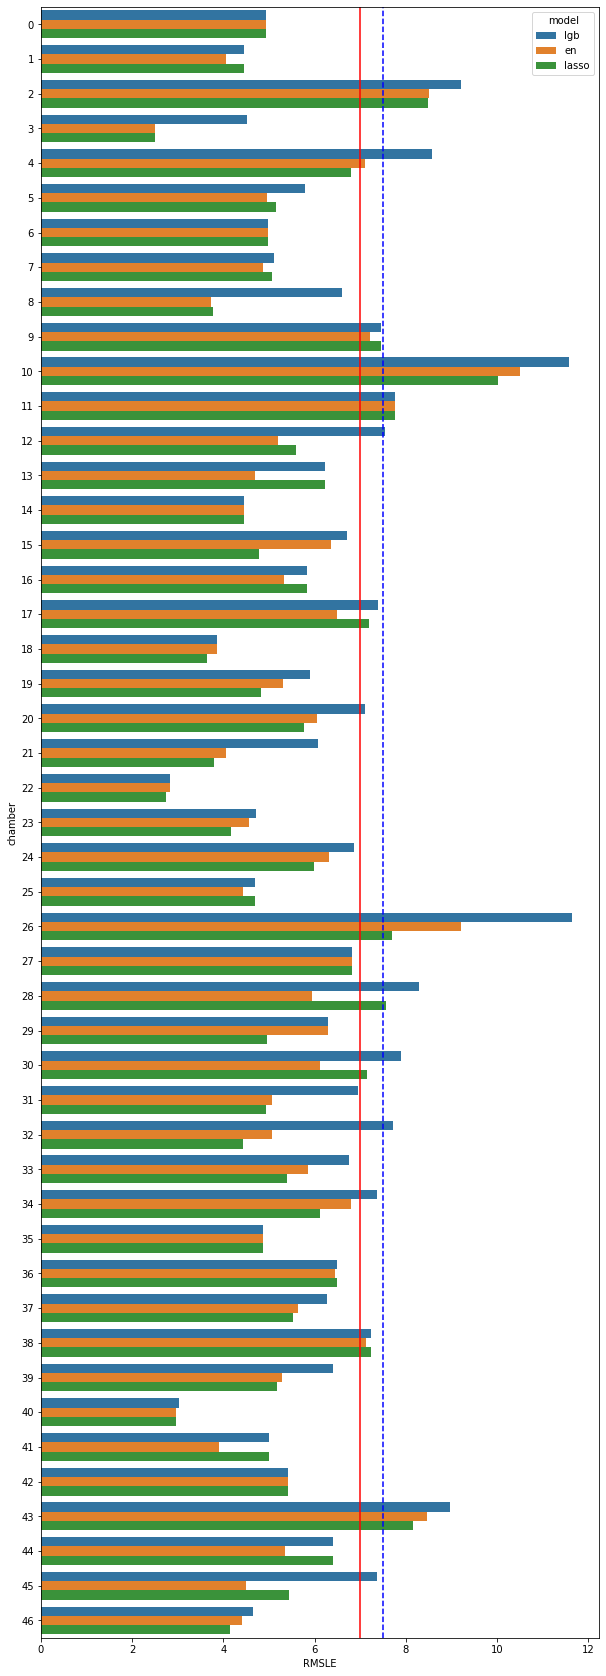

In [81]:
score_df = pd.DataFrame({'model':['lgb']*47 + ['en']*47 + ['lasso']*47,
                         'chamber': list(range(0,47))*3,
                         'RMSLE' : lgb_scores + en_scores + ls_scores})

fig = plt.figure(figsize = (10, 30))
sns.barplot(data = score_df, orient = 'h', x = 'RMSLE', y = 'chamber', hue = 'model')
plt.axvline(7.5, color='b', linestyle='--')
plt.axvline(7.0, color='r')

In [83]:
score_df.pivot('chamber', 'model', 'RMSLE')

model,en,lasso,lgb
chamber,,,
0,4.936722,4.936722,4.936724
1,4.051416,4.462187,4.462187
2,8.500838,8.496759,9.208819
3,2.504417,2.508075,4.520839
4,7.100840,6.797192,8.584949
5,4.950177,5.151204,5.800541
6,4.975702,4.975702,4.975700
7,4.876846,5.072998,5.117376
8,3.728284,3.765617,6.606208


In [84]:
# (건물 별 모델 cv score 의 pivot_q quantile 값*threshold) 보다 작은 cv score를 가진 모델만 건물별로 선택
def good_models(score_df, pivot_q, threshold):
    score_pivot = pd.DataFrame(score_df.pivot('chamber', 'model', 'RMSLE').values,
                               columns = ['en','lasso','lgb'])
    li = []
    for i in range(len(score_pivot)):
        temp = score_pivot.iloc[i]
        q = temp.quantile(pivot_q)
        best = list(temp[temp <= threshold*q].index)
        li.append(best)
    return li

In [85]:
bests = good_models(score_df, 0.1, 1.05)
bests

[['en', 'lasso', 'lgb'],
 ['en'],
 ['en', 'lasso'],
 ['en', 'lasso'],
 ['en', 'lasso'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['en'],
 ['en'],
 ['en', 'lasso', 'lgb'],
 ['lasso'],
 ['en'],
 ['en'],
 ['lasso'],
 ['lasso'],
 ['en', 'lasso'],
 ['lasso'],
 ['en', 'lasso', 'lgb'],
 ['lasso'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['lasso'],
 ['en', 'lasso', 'lgb'],
 ['en'],
 ['lasso'],
 ['en'],
 ['en', 'lasso'],
 ['lasso'],
 ['lasso'],
 ['lasso'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso'],
 ['en', 'lasso', 'lgb'],
 ['en'],
 ['en', 'lasso', 'lgb'],
 ['en', 'lasso'],
 ['en'],
 ['en'],
 ['lasso']]

In [87]:
# voting ensemble training & inference
bests = good_models(score_df, 0.1, 1.05)
voting_pred = []
for i, (X_test, num_f, best, l,e,ls) in enumerate(zip(df_predicts, num_features_lst, bests, lgbs, ens, lss)):
    pred = []
#     if 'cat' in best:
#         cat = c
#         pred.append(cat.predict(X_test[num_f]))
    if 'lgb' in best:
        lgb = l
        pred.append(lgb.predict(X_test[num_f]))
    if 'en' in best:
        en = e
        en_pred = en.predict(X_test[num_f])
        pred.append(en_pred)
    if 'lasso' in best:
        lasso = ls
        ls_pred = lasso.predict(X_test[num_f])
        pred.append(ls_pred)
#     if 'ridge' in best:
#         rid = r
#         rid_pred = rid.predict(X_test[num_f])
#         if (rid_pred < 7.0).sum()<1:
#             pred.append(rid_pred)
#     if 'br' in best:
#         bayer = br
#         bayer_pred = bayer.predict(X_test[num_f])
#         if (bayer_pred < 7.0).sum()<1:
#             pred.append(bayer_pred)
#     if 'rf' in best:
#         randomf_ = randomf
#         pred.append(randomf_.predict(X_test[num_f]))
#     if 'ngb' in best:
#         ngb = ng
#         pred.append(ngb.predict(X_test[num_f]))
#     if 'xgb' in best:
#         xgb = xg
#         pred.append(xgb.predict(X_test[num_f]))
    
    voting_pred.append(np.array(pred).mean(axis = 0))

    print (f'model{i+1} prediction complete')
voting_pred = np.concatenate(voting_pred)

model1 prediction complete
model2 prediction complete
model3 prediction complete
model4 prediction complete
model5 prediction complete
model6 prediction complete
model7 prediction complete
model8 prediction complete
model9 prediction complete
model10 prediction complete
model11 prediction complete
model12 prediction complete
model13 prediction complete
model14 prediction complete
model15 prediction complete
model16 prediction complete
model17 prediction complete
model18 prediction complete
model19 prediction complete
model20 prediction complete
model21 prediction complete
model22 prediction complete
model23 prediction complete
model24 prediction complete
model25 prediction complete
model26 prediction complete
model27 prediction complete
model28 prediction complete
model29 prediction complete
model30 prediction complete
model31 prediction complete
model32 prediction complete
model33 prediction complete
model34 prediction complete
model35 prediction complete
model36 prediction complete
m

In [88]:
pred

[array([1234.58904139, 1257.20872915, 1255.44518403, 1258.49041435])]

In [89]:
voting_pred

array([1256.80545295, 1256.80545295, 1256.80545295, 1256.80545295,
       1256.80545295, 1265.34175192, 1262.92626519, 1263.20672576,
       1262.32804518, 1262.13485039, 1261.56837292, 1261.25827892,
       1261.25497602, 1263.84881975, 1262.89934098, 1253.88049954,
       1255.10252638, 1255.8701525 , 1261.03679191, 1269.44982619,
       1251.24990723, 1253.17403804, 1251.17842154, 1246.46630158,
       1253.27692238, 1248.67265446, 1263.53332795, 1262.32263319,
        772.54819055,  771.5521687 ,  773.1152823 ,  769.45146929,
       1268.64352859, 1268.48271166, 1267.06165094, 1265.07975572,
       1265.96819107, 1266.11450973, 1259.93744749, 1259.93744749,
       1259.93744749, 1259.93744749, 1259.93744749, 1259.93744749,
       1262.52021103, 1262.5064893 , 1262.11654047, 1261.16271029,
       1262.6935159 , 1138.48143921, 1142.2562611 , 1207.92195384,
       1207.58132481, 1201.4463232 , 1203.94389931, 1214.53864293,
       1213.79557489, 1266.30488726, 1266.56553198, 1264.88901

In [39]:
predict['msure_val'] = voting_pred
df_submission = predict[['key_val','msure_val']]
# 예측 파일을 저장합니다. 
# 제출용 파일 이름은 cds_submission_팀명_차수.csv 형태로 제출합니다.
df_submission.set_index('key_val', inplace=True)
df_submission.to_csv('cds_submission_데이터조무사_35.csv')

In [69]:
df_submission.iloc[19:25]

,msure_val
key_val,
LOT227_19,1268.594991
LOT114_16,1269.167986
LOT122_21,1269.523309
LOT101_17,1269.657628
LOT44_20,1269.712955
LOT112_11,1269.991225


In [68]:
df_predicts[3]

,key_val,04_efem_para2,04_efem_para25,04_efem_para78,04_fr_para28,04_gas_para21,04_gas_para26,04_gas_para36,04_gas_para51,04_gas_para52,04_gas_para59,04_gas_para6,04_gas_para71,04_gas_para73,04_gas_para74,04_gas_para85,04_he_para22,04_he_para88,04_hv_para3,04_hv_para45,04_hv_para47,04_hv_para56,04_position_para72,04_power_para76,04_pressure_para91,04_temp_para11,04_temp_para12,04_temp_para17,04_temp_para18,04_temp_para20,04_temp_para23,04_temp_para32,04_temp_para38,04_temp_para53,04_temp_para54,04_temp_para55,04_temp_para60,04_temp_para65,04_temp_para66,04_temp_para79,04_temp_para86,04_temp_para87,04_temp_para92,04_time_para16,04_time_para29,04_time_para30,04_time_para34,04_time_para37,04_time_para64,04_time_para75,04_tmp_para31,06_efem_para2,06_efem_para25,06_efem_para78,06_epd_para4,06_epd_para40,06_epd_para63,06_fr_para28,06_gas_para21,06_gas_para26,06_gas_para36,06_gas_para52,06_gas_para59,06_gas_para6,06_gas_para71,06_gas_para73,06_he_para22,06_he_para88,06_position_para72,06_power_para49,06_power_para57,06_power_para76,06_pressure_para91,06_temp_para11,06_temp_para12,06_temp_para17,06_temp_para18,06_temp_para20,06_temp_para23,06_temp_para32,06_temp_para38,06_temp_para53,06_temp_para54,06_temp_para55,06_temp_para60,06_temp_para65,06_temp_para66,06_temp_para79,06_temp_para86,06_temp_para87,06_temp_para92,06_time_para16,06_time_para29,06_time_para30,06_time_para37,06_time_para67,06_tmp_para31,12_efem_para2,12_efem_para25,12_efem_para78,12_fr_para28,12_fr_para35,12_gas_para21,12_gas_para26,12_gas_para36,12_gas_para52,12_gas_para6,12_gas_para73,12_gas_para74,12_he_para22,12_he_para88,12_hv_para3,12_hv_para45,12_hv_para47,12_hv_para56,12_position_para72,12_power_para14,12_power_para76,12_power_para82,12_pressure_para91,12_temp_para11,12_temp_para12,12_temp_para18,12_temp_para20,12_temp_para23,12_temp_para24,12_temp_para32,12_temp_para38,12_temp_para53,12_temp_para55,12_temp_para58,12_temp_para60,12_temp_para65,12_temp_para66,12_temp_para79,12_temp_para86,12_temp_para87,12_temp_para92,12_time_para16,12_time_para29,12_time_para30,12_time_para37,12_time_para5,12_time_para7,12_time_para90,12_tmp_para31,13_efem_para2,13_efem_para25,13_efem_para78,13_fr_para35,13_gas_para21,13_gas_para26,13_gas_para27,13_gas_para36,13_gas_para46,13_gas_para48,13_gas_para52,13_gas_para6,13_gas_para73,13_he_para22,13_he_para88,13_hv_para3,13_hv_para45,13_hv_para47,13_hv_para56,13_position_para72,13_power_para14,13_power_para76,13_power_para82,13_pressure_para91,13_temp_para11,13_temp_para12,13_temp_para18,13_temp_para20,13_temp_para24,13_temp_para32,13_temp_para38,13_temp_para53,13_temp_para55,13_temp_para58,13_temp_para60,13_temp_para65,13_temp_para66,13_temp_para79,13_temp_para86,13_temp_para87,13_temp_para92,13_time_para16,13_time_para29,13_time_para30,13_time_para37,13_time_para5,13_time_para7,13_time_para83,13_tmp_para31,17_efem_para2,17_efem_para25,17_efem_para78,17_fr_para28,17_fr_para35,17_fr_para61,17_gas_para21,17_gas_para26,17_gas_para36,17_gas_para52,17_gas_para6,17_gas_para73,17_gas_para74,17_he_para22,17_he_para88,17_hv_para3,17_hv_para45,17_hv_para47,17_hv_para56,17_position_para72,17_power_para14,17_power_para76,17_power_para82,17_pressure_para91,17_temp_para11,17_temp_para12,17_temp_para18,17_temp_para20,17_temp_para24,17_temp_para32,17_temp_para38,17_temp_para53,17_temp_para55,17_temp_para58,17_temp_para60,17_temp_para65,17_temp_para66,17_temp_para79,17_temp_para86,17_temp_para87,17_temp_para92,17_time_para16,17_time_para29,17_time_para30,17_time_para37,17_time_para5,17_time_para75,17_tmp_para31,18_efem_para2,18_efem_para25,18_efem_para78,18_fr_para28,18_fr_para35,18_gas_para21,18_gas_para26,18_gas_para27,18_gas_para36,18_gas_para46,18_gas_para48,18_gas_para52,18_gas_para6,18_gas_para73,18_he_para22,18_he_para88,18_hv_para3,18_hv_para45,18_hv_para47,18_hv_para56,18_position_para72,18_power_para14,18_power_para76,18_power_para82,18_pressure_para91,18_temp_para11,18_temp_para12,18_temp_para18,18_temp_para20,18_temp_para24,18_temp_para3

# Feature Selection

In [43]:
pip install --user probatus

Note: you may need to restart the kernel to use updated packages.


In [44]:
from probatus.feature_elimination import EarlyStoppingShapRFECV

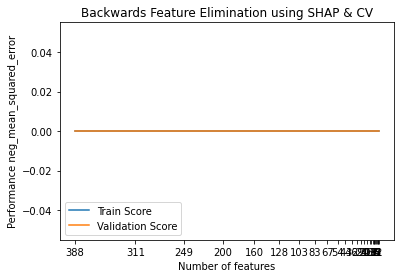

In [50]:
# Run feature elimination
shap_elimination = EarlyStoppingShapRFECV(
    clf=lgbs[3], step=0.2, cv=10, scoring='neg_mean_squared_error', early_stopping_rounds=15, n_jobs=-1, eval_metric='rmse')
report = shap_elimination.fit_compute(df_trains[3][num_features_lst[3]], np.log1p(df_trains[3]['y']), feature_perturbation="tree_path_dependent")

# Make plots
performance_plot = shap_elimination.plot()

In [51]:
report

,num_features,features_set,eliminated_features,train_metric_mean,train_metric_std,val_metric_mean,val_metric_std
1,388,"[04_efem_para2, 04_efem_para25, 04_efem_para78...","[12_time_para16, 13_temp_para58, 12_fr_para28,...",-0.0,0.0,-0.0,0.0
2,311,"[12_gas_para36, 13_time_para83, 12_date_sin, 1...","[13_date_sin, 13_he_para88, 20_temp_para20, 06...",-0.0,0.0,-0.0,0.0
3,249,"[12_gas_para36, 13_time_para83, 12_date_sin, 1...","[13_temp_para53, 06_temp_para32, 18_efem_para7...",-0.0,0.0,-0.0,0.0
4,200,"[20_time_para16, 12_gas_para36, 17_gas_para21,...","[12_fr_para35, gen_tmdiff, 04_time_para64, 13_...",-0.0,0.0,-0.0,0.0
5,160,"[20_time_para16, 12_gas_para36, 17_gas_para21,...","[12_temp_para60, 20_temp_para60, 04_temp_para6...",-0.0,0.0,-0.0,0.0
6,128,"[20_time_para16, 12_gas_para36, 17_gas_para21,...","[04_position_para72, 13_gas_para26, 06_date_co...",-0.0,0.0,-0.0,0.0
7,103,"[20_time_para16, 12_gas_para36, 17_gas_para21,...","[17_temp_para60, 18_gas_para36, 12_temp_para11...",-0.0,0.0,-0.0,0.0
8,83,"[20_time_para16, 12_gas_para36, 17_gas_para21,...","[20_power_para76, 13_gas_para46, 20_gas_para26...",-0.0,0.0,-0.0,0.0
9,67,"[20_time_para16, 12_gas_para36, 17_gas_para21,...","[18_power_para14, 13_weekday_sin, 04_power_par...",-0.0,0.0,-0.0,0.0
10,54,"[20_time_para16, 12_gas_para36, 17_gas_para21,...","[06_gas_para73, 13_temp_para18, 17_hv_para47, ...",-0.0,0.0,-0.0,0.0


In [52]:
# Get final feature set
''' num_features는 마지막에 남길 feature 수임. '''
final_features_set = shap_elimination.get_reduced_features_set(num_features=128)
final_features_set

['20_time_para16',
 '12_gas_para36',
 '17_gas_para21',
 '13_time_para83',
 '06_temp_para86',
 '12_date_sin',
 '17_efem_para78',
 '17_gas_para52',
 '06_epd_para40',
 '18_date_sin',
 '18_power_para14',
 '04_power_para76',
 '18_temp_para65',
 '13_temp_para86',
 '06_gas_para26',
 '12_gas_para74',
 '17_efem_para2',
 '06_time_para67',
 'gen_tmdiff_1820',
 '12_tmp_para31',
 '13_gas_para36',
 '04_temp_para55',
 'gen_tmdiff_1718',
 '17_hv_para45',
 '17_date_cos',
 '17_time_para37',
 '18_temp_para11',
 '12_temp_para79',
 '17_gas_para6',
 '18_gas_para6',
 '18_temp_para24',
 'gen_tmdiff_0612',
 '13_temp_para92',
 '17_temp_para24',
 '06_temp_para23',
 'gen_tmdiff_0406',
 '12_time_para5',
 '20_temp_para17',
 '20_hour_sin',
 '04_fr_para28',
 '18_efem_para2',
 '04_gas_para71',
 '04_temp_para66',
 '18_hour_sin',
 '18_he_para88',
 '20_gas_para59',
 '17_fr_para61',
 '12_time_para37',
 '20_gas_para50',
 '13_temp_para32',
 '17_tmp_para31',
 '18_hv_para47',
 '18_gas_para48',
 '13_temp_para24',
 '12_he_para2

The provided number of features has not been achieved at any stage of the process. You can select one of the following: [402, 322, 258, 207, 166, 133, 107, 86, 69, 56, 45, 36, 29, 24, 20, 16, 13, 11, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [ ]:
final_features_set

# 예측 결과 제출